In [18]:
import modeller
import fitter

import casadi as ca
from scipy.integrate import solve_ivp
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from importlib import reload

In [19]:
%matplotlib notebook
# plt.rcParams['figure.figsize'] = [13, 8.]


In [20]:
p_true = [2, 0.75]
tspan = [0, 20]
def system(t, y, p):
    return [
        -p[0]*y[0]*y[1]/(y[0]+y[1]+y[2]),
        p[0]*y[0]*y[1]/(y[0]+y[1]+y[2]) - p[1]*y[1],
        p[1]*y[1]
    ]
sol = solve_ivp(lambda t, y: system(t, y, p_true), tspan, [9999, 1, 0], dense_output=True) 

<IPython.core.display.Javascript object>


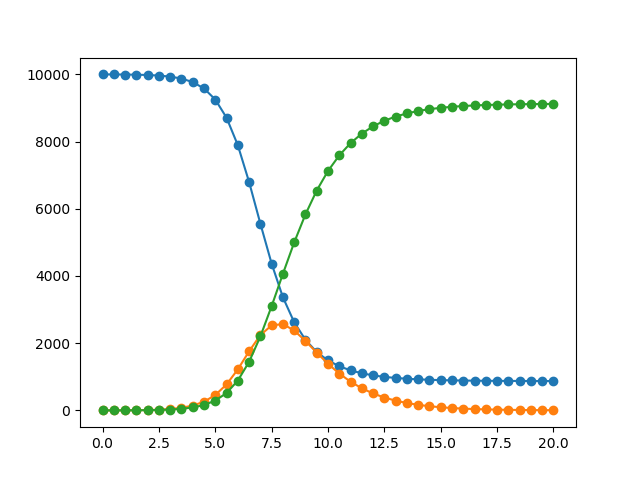

In [21]:
tofsol = np.linspace(0, 20, 41)
plt.figure()
plt.plot(tofsol, sol.sol(tofsol).T, 'o-');

In [22]:
raw_data = sol.sol(tofsol)[2, :]
gendata = sol.sol(tofsol)[1, :]
randdata = np.random.multivariate_normal(gendata, 10000*np.exp(-1/(2*2**2)*np.abs(tofsol.reshape(1,-1)-tofsol.reshape(-1,1))**2)).reshape(1,-1)
randdata[randdata < 0] = 0
data = (np.cumsum(randdata)*p_true[1]*np.gradient(tofsol)).reshape(1, -1)
# data = raw_data.reshape(1,-1)
data_pd = np.array([i for i in data.T])

<IPython.core.display.Javascript object>


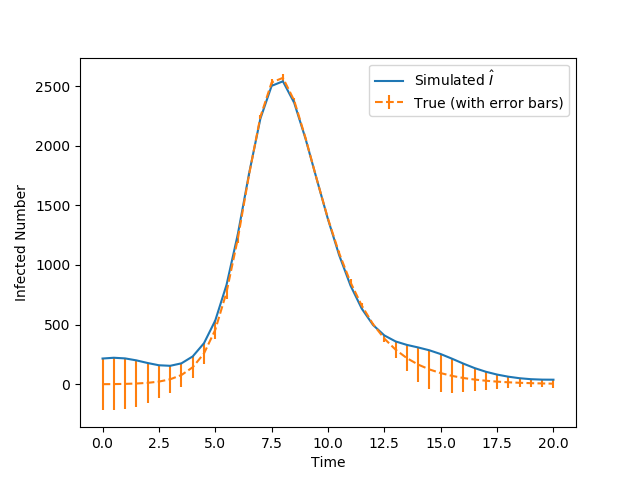

In [23]:
# plt.plot(tofsol, gendata.T)
plt.figure()
plt.plot(tofsol, randdata.T)
plt.errorbar(tofsol, gendata.T, (randdata-gendata).flatten(), linestyle='--')
plt.xlabel('Time')
plt.ylabel("Infected Number")
plt.legend([r'Simulated $\hat{I}$', 'True (with error bars)'])

<IPython.core.display.Javascript object>


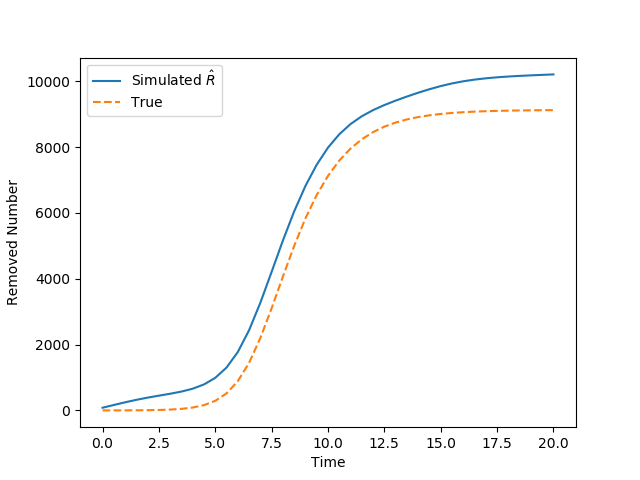

In [24]:
plt.figure()
plt.plot(tofsol, data.T)
plt.plot(tofsol, raw_data.T, '--')
plt.xlabel('Time')
plt.ylabel("Removed Number")
plt.legend([r"Simulated $\hat{R}$", "True"])

In [25]:
def build_config(t,y):
    return {
    "grid_size": 120,
    "basis_number": 60,
    "model_form": {
        "state": 3,
        "parameters": 2
    },
    "time_span": tspan,
    "knot_function": None,
    "model": system,
    "dataset": {"y": y, "t": t},
    "observation_vector": [2],
    "weightings":[
        [1]*3,
        [1]*len(t)
    ],
    "regularisation_value": [0]*len(p_true),
}

In [26]:
p0 = np.ones(2)
config=build_config([None], [None])
c0 = [c*np.linspace(1, 0, config['basis_number'])+d 
      for c,d in zip([10000, 1, -10000], [0, 0, 10000])]
x0 = np.hstack([*c0, p0])
lbx = [-np.inf]*(config['basis_number']*3) + [0]*len(config['regularisation_value'])

testn = 5
# js = list(range(0,len(tofsol),int(len(tofsol)//(testn+1))))[1:-1]
js = [12,13,14,15,16,17,18]

fcv_vals = []

for j in js:
    times_slice = tofsol[0:j]
    data_pd_slice = data_pd[0:j]
    config = build_config(times_slice, data_pd_slice)
    model = modeller.Model(config)
    objective = fitter.Objective()
    objective.make(config, config['dataset'], model)

    solver_setup = {
        'f': objective.objective,
        'x': ca.vcat(objective.input_list),
        'p': ca.hcat([objective.rho, objective.alpha]),
        'g': ca.vcat(model.xs),
    }

    opts = {
        'ipopt': {'max_iter': 300}
    }

    solver = ca.nlpsol('solver', 'ipopt', solver_setup, opts)
    x0 = np.hstack([*c0, p0])
    pure_data = solver(x0=x0, p=[1e-14, 1e-14], lbx=lbx, lbg=0);
    x0 = list(np.array(pure_data['x'][:-2]).flatten()) + list(p0)
    prange = np.logspace(-6, 6, num=50)
    solutions = []
    fcv_vals.append(solutions)
    xguess = x0
    for p in prange:
        solutions.append(solver(x0=xguess, p=[p, 0.5], lbx=lbx, lbg=0))
        xguess = np.array(solutions[-1]['x']).flatten()

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1254
Number of nonzeros in Lagrangian Hessian.............:     2289

Total number of variables............................:      182
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 6.7582045e-003 0.00e+000 1.55e-006  -8.6 7.33e+001 -15.9 1.00e+000 1.00e+000h  1
  61 6.7547200e-003 0.00e+000 5.73e-004  -8.6 3.19e+004    -  1.00e+000 5.00e-001h  2
  62 6.7546247e-003 0.00e+000 1.95e-008  -8.6 4.49e+001 -16.4 1.00e+000 1.00e+000h  1
  63 6.7494284e-003 0.00e+000 1.53e-003  -9.0 1.13e+005    -  9.72e-001 2.50e-001h  3
  64 6.7488339e-003 0.00e+000 4.69e-007  -9.0 9.30e+001 -16.0 1.00e+000 1.00e+000h  1
  65 6.7406006e-003 0.00e+000 3.61e-003  -9.0 1.36e+005    -  1.00e+000 5.00e-001h  2
  66 6.7372318e-003 0.00e+000 2.93e-007  -9.0 3.93e+001 -15.5 1.00e+000 1.00e+000h  1
  67 6.7303252e-003 0.00e+000 2.47e-003  -9.0 1.20e+005    -  1.00e+000 5.00e-001h  2
  68 6.7289659e-003 0.00e+000 3.42e-005  -9.0 2.71e+002 -16.0 1.00e+000 1.00e+000h  1
  69 6.7264274e-003 0.00e+000 1.86e-003  -9.0 1.04e+005    -  1.00e+000 2.50e-001h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

  58 1.1841523e-002 0.00e+000 3.70e-001  -5.7 1.36e+004 -13.6 1.00e+000 2.50e-001h  3
  59 1.1834546e-002 0.00e+000 5.21e-002  -5.7 7.82e+002 -13.2 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 1.1833539e-002 0.00e+000 4.95e-003  -5.7 6.52e+002 -13.6 1.00e+000 1.00e+000h  1
  61 1.1827918e-002 0.00e+000 4.58e-001  -5.7 5.39e+004    -  1.00e+000 1.25e-001h  4
  62 1.1820573e-002 0.00e+000 6.06e-003  -5.7 2.98e+002 -13.2 1.00e+000 1.00e+000h  1
  63 1.1814896e-002 0.00e+000 4.30e-001  -5.7 5.37e+004    -  1.00e+000 1.25e-001h  4
  64 1.1808558e-002 0.00e+000 1.70e-004  -5.7 5.56e+001 -12.8 1.00e+000 1.00e+000h  1
  65 1.1795547e-002 0.00e+000 2.54e-001  -5.7 4.32e+004    -  1.00e+000 2.50e-001h  3
  66 1.1793210e-002 0.00e+000 2.87e-004  -5.7 1.04e+002 -13.3 1.00e+000 1.00e+000h  1
  67 1.1781960e-002 0.00e+000 6.18e-001  -5.7 3.72e+004    -  1.00e+000 5.00e-001h  2
  68 1.1769865e-002 0.00e+000 1.09e-004  -5.7 1.90e+001 -12

  41 1.9387997e-002 0.00e+000 5.49e+000  -8.6 1.53e+004 -13.4 1.00e+000 2.50e-001h  3
  42 1.9331012e-002 0.00e+000 2.41e-002  -8.6 4.09e+002 -13.0 1.00e+000 1.00e+000h  1
  43 1.9325303e-002 0.00e+000 4.02e-001  -8.6 1.51e+003 -13.5 1.00e+000 1.00e+000h  1
  44 1.9318827e-002 0.00e+000 2.40e-001  -8.6 1.72e+003 -14.0 1.00e+000 1.00e+000h  1
  45 1.9324374e-002 0.00e+000 3.49e+000  -8.6 2.49e+003 -14.4 1.00e+000 1.00e+000h  1
  46 1.9307732e-002 0.00e+000 2.26e-002  -8.6 4.47e+002 -13.1 1.00e+000 1.00e+000h  1
  47 1.9303611e-002 0.00e+000 4.05e-001  -8.6 1.45e+003 -13.6 1.00e+000 1.00e+000h  1
  48 1.9298993e-002 0.00e+000 2.73e-001  -8.6 1.61e+003 -14.1 1.00e+000 1.00e+000h  1
  49 1.9297665e-002 0.00e+000 1.55e+000  -8.6 3.33e+003 -14.5 1.00e+000 5.00e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 1.9293243e-002 0.00e+000 6.93e-004  -8.6 4.03e+002 -13.2 1.00e+000 1.00e+000h  1
  51 1.9292354e-002 0.00e+000 8.61e-001  -8.6 8.91e+006    

 150 1.9118359e-002 0.00e+000 9.51e-007  -8.6 1.44e+000 -13.4 1.00e+000 1.00e+000h  1
 151 1.9119066e-002 0.00e+000 4.03e+000  -8.6 2.23e+006    -  1.00e+000 5.00e-001h  2
 152 1.9114320e-002 0.00e+000 1.08e-005  -8.6 1.57e+000 -13.0 1.00e+000 1.00e+000h  1
 153 1.9113160e-002 0.00e+000 4.28e-001  -8.6 1.43e+006    -  1.00e+000 2.50e-001h  3
 154 1.9113110e-002 0.00e+000 2.65e-007  -8.6 8.23e-001 -13.5 1.00e+000 1.00e+000h  1
 155 1.9112188e-002 0.00e+000 2.67e-001  -8.6 1.14e+006    -  1.00e+000 2.50e-001h  3
 156 1.9112169e-002 0.00e+000 1.15e-007  -8.6 1.67e+000 -13.9 1.00e+000 1.00e+000h  1
 157 1.9111447e-002 0.00e+000 1.63e-001  -8.6 9.04e+005    -  1.00e+000 2.50e-001h  3
 158 1.9111440e-002 0.00e+000 1.49e-006  -8.6 3.72e+000 -14.4 1.00e+000 1.00e+000h  1
 159 1.9109848e-002 0.00e+000 1.49e+000  -8.6 6.97e+005    -  1.00e+000 1.00e+000H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 1.9109274e-002 0.00e+000 6.81e-006  -8.6 1.66e+000 -14

 101 3.2254506e-002 0.00e+000 3.32e+000  -5.7 9.17e+005    -  1.00e+000 1.13e-001f  4
 102 3.2209656e-002 0.00e+000 4.31e-004  -5.7 4.27e+001 -12.7 1.00e+000 1.00e+000h  1
 103 3.2283866e-002 0.00e+000 2.10e+000  -5.7 5.97e+005    -  1.00e+000 1.25e-001f  4
 104 3.2265765e-002 0.00e+000 4.09e-003  -5.7 1.58e+002 -13.2 1.00e+000 1.00e+000h  1
 105 3.2348665e-002 0.00e+000 3.08e+000  -5.7 4.14e+005    -  1.00e+000 1.25e-001f  4
 106 3.2310983e-002 0.00e+000 1.25e-003  -5.7 1.41e+002 -12.7 1.00e+000 1.00e+000h  1
 107 3.2425721e-002 0.00e+000 1.95e+000  -5.7 2.94e+005    -  1.00e+000 2.50e-001f  3
 108 3.2383759e-002 0.00e+000 1.92e-005  -5.7 1.07e+001 -12.3 1.00e+000 1.00e+000h  1
 109 3.4303455e-002 0.00e+000 2.08e+001  -5.7 1.60e+005    -  1.00e+000 1.00e+000H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 3.2827748e-002 0.00e+000 4.62e+000  -5.7 1.86e+003 -11.9 1.00e+000 1.00e+000f  1
 111 3.2605383e-002 0.00e+000 1.93e-002  -5.7 2.90e+002 -12

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250 3.1385548e-002 0.00e+000 3.06e+000  -8.6 5.52e+006    -  1.00e+000 6.25e-002h  5
 251 3.1383695e-002 0.00e+000 1.94e-005  -8.6 1.93e+001 -13.7 1.00e+000 1.00e+000h  1
 252 3.1380661e-002 0.00e+000 3.08e+000  -8.6 5.64e+006    -  1.00e+000 6.25e-002h  5
 253 3.1378847e-002 0.00e+000 3.84e-006  -8.6 3.53e+000 -13.3 1.00e+000 1.00e+000h  1
 254 3.1375846e-002 0.00e+000 3.04e+000  -8.6 5.74e+006    -  1.00e+000 6.25e-002h  5
 255 3.1374138e-002 0.00e+000 2.92e-005  -8.6 2.15e+001 -13.8 1.00e+000 1.00e+000h  1
 256 3.1371243e-002 0.00e+000 3.07e+000  -8.6 5.85e+006    -  1.00e+000 6.25e-002h  5
 257 3.1369563e-002 0.00e+000 3.70e-006  -8.6 3.26e+000 -13.4 1.00e+000 1.00e+000h  1
 258 3.1366676e-002 0.00e+000 3.00e+000  -8.6 5.96e+006    -  1.00e+000 6.25e-002h  5
 259 3.1365116e-002 0.00e+000 4.34e-005  -8.6 2.38e+001 -13.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

  59 5.0302815e-002 0.00e+000 8.15e-002  -5.7 9.23e+002 -13.0 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 5.0289206e-002 0.00e+000 6.57e+000  -5.7 5.65e+003 -13.5 1.00e+000 5.00e-001h  2
  61 5.0282624e-002 0.00e+000 1.76e+001  -5.7 1.69e+004 -14.0 1.00e+000 5.00e-001h  2
  62 5.0238897e-002 0.00e+000 1.16e+000  -5.7 7.15e+002 -12.7 1.00e+000 1.00e+000h  1
  63 5.0221572e-002 0.00e+000 3.29e+000  -5.7 2.31e+003 -13.1 1.00e+000 1.00e+000h  1
  64 5.0199073e-002 0.00e+000 4.79e-001  -5.7 2.94e+003 -13.6 1.00e+000 1.00e+000h  1
  65 5.0185875e-002 0.00e+000 3.94e+000  -5.7 3.52e+003 -14.1 1.00e+000 5.00e-001h  2
  66 5.0164003e-002 0.00e+000 2.21e+000  -5.7 3.53e+003 -13.7 1.00e+000 1.00e+000h  1
  67 5.0166797e-002 0.00e+000 1.49e+001  -5.7 5.79e+003 -14.1 1.00e+000 5.00e-001h  2
  68 5.0135118e-002 0.00e+000 3.65e-002  -5.7 8.63e+002 -12.8 1.00e+000 1.00e+000h  1
  69 5.0130712e-002 0.00e+000 7.80e+000  -5.7 3.14e+003 -13

 169 5.0062124e-002 0.00e+000 1.15e-003  -5.7 5.11e+001 -12.5 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170 5.0110057e-002 0.00e+000 1.29e+001  -5.7 2.68e+007    -  3.70e-001 3.92e-003f  6
 171 5.0076559e-002 0.00e+000 3.73e-003  -5.7 1.54e+002 -13.0 1.00e+000 1.00e+000h  1
 172 5.0456235e-002 0.00e+000 3.98e+001  -5.7 2.46e+007    -  3.67e-001 8.36e-003f  5
 173 5.0106736e-002 0.00e+000 4.84e-005  -5.7 1.07e+001 -11.7 1.00e+000 1.00e+000f  1
 174 5.0155554e-002 0.00e+000 1.23e+001  -5.7 2.15e+007    -  4.21e-001 4.46e-003f  6
 175 5.0121770e-002 0.00e+000 5.82e-004  -5.7 1.95e+001 -12.1 1.00e+000 1.00e+000h  1
 176 5.0168326e-002 0.00e+000 1.17e+001  -5.7 2.00e+007    -  4.36e-001 4.68e-003f  6
 177 5.0137035e-002 0.00e+000 1.81e-003  -5.7 5.85e+001 -12.6 1.00e+000 1.00e+000h  1
 178 5.0176311e-002 0.00e+000 9.96e+000  -5.7 1.84e+007    -  4.42e-001 4.95e-003f  6
 179 5.0152586e-002 0.00e+000 6.33e-004  -5.7 2.20e+001 -12

 270 5.1418494e-002 0.00e+000 2.02e-001  -5.7 8.33e+002 -12.1 1.00e+000 1.00e+000f  1
 271 5.1418050e-002 0.00e+000 3.26e-003  -5.7 5.84e+001 -12.6 1.00e+000 1.00e+000h  1
 272 5.1413923e-002 0.00e+000 3.01e-001  -5.7 4.78e+003    -  1.00e+000 5.00e-001h  2
 273 5.1413718e-002 0.00e+000 2.59e-003  -5.7 6.53e+001 -13.1 1.00e+000 1.00e+000h  1
 274 5.1411301e-002 0.00e+000 7.70e-002  -5.7 2.62e+003    -  1.00e+000 5.00e-001h  2
 275 5.1411279e-002 0.00e+000 1.21e-003  -5.7 4.81e+001 -13.5 1.00e+000 1.00e+000h  1
 276 5.1408640e-002 0.00e+000 6.64e-002  -5.7 1.43e+003    -  1.00e+000 1.00e+000h  1
 277 5.1408632e-002 0.00e+000 5.43e-008  -5.7 5.18e-001 -14.0 1.00e+000 1.00e+000h  1
 278 5.1381283e-002 0.00e+000 2.76e+000  -8.6 3.79e+005    -  6.05e-001 6.25e-002f  5
 279 5.1368526e-002 0.00e+000 3.50e-004  -8.6 5.04e+001 -12.7 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280 5.1337830e-002 0.00e+000 2.99e+000  -8.6 4.62e+005    

  79 8.0956436e-002 0.00e+000 2.42e-001  -3.8 6.70e+002 -12.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 8.1228058e-002 0.00e+000 6.20e+000  -3.8 4.17e+005    -  1.00e+000 2.32e-002f  6
  81 8.1063641e-002 0.00e+000 1.09e+000  -3.8 9.38e+002 -11.5 1.00e+000 1.00e+000f  1
  82 8.1011913e-002 0.00e+000 1.12e+000  -3.8 1.30e+003 -12.0 1.00e+000 1.00e+000f  1
  83 8.1000367e-002 0.00e+000 3.73e+000  -3.8 2.61e+003 -12.5 1.00e+000 1.00e+000f  1
  84 8.1099674e-002 0.00e+000 1.63e+000  -3.8 5.75e+003 -13.0 1.00e+000 1.00e+000f  1
  85 8.1032379e-002 0.00e+000 2.09e+000  -3.8 3.85e+004 -12.5 1.00e+000 6.25e-002f  5
  86 8.1279881e-002 0.00e+000 8.93e+000  -3.8 5.07e+003 -13.0 1.00e+000 1.00e+000f  1
  87 8.1145324e-002 0.00e+000 1.40e+000  -3.8 3.33e+003 -12.6 1.00e+000 1.00e+000f  1
  88 8.1129710e-002 0.00e+000 4.72e+000  -3.8 2.45e+003 -12.2 1.00e+000 1.00e+000f  1
  89 8.1061563e-002 0.00e+000 7.08e-001  -3.8 1.95e+003 -12

 169 8.2070913e-002 0.00e+000 2.20e-001  -5.7 3.47e+002 -12.0 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170 8.2055223e-002 0.00e+000 5.82e-001  -5.7 6.27e+002 -12.5 1.00e+000 1.00e+000h  1
 171 8.2026720e-002 0.00e+000 9.51e-001  -5.7 1.15e+003 -12.9 1.00e+000 1.00e+000h  1
 172 8.1984523e-002 0.00e+000 1.03e+000  -5.7 3.79e+003 -13.4 1.00e+000 1.00e+000h  1
 173 8.1952969e-002 0.00e+000 1.19e+000  -5.7 7.91e+002 -12.1 1.00e+000 1.00e+000h  1
 174 8.1935257e-002 0.00e+000 2.19e-001  -5.7 4.88e+002 -12.6 1.00e+000 1.00e+000h  1
 175 8.1917418e-002 0.00e+000 2.33e+000  -5.7 1.55e+003 -13.1 1.00e+000 1.00e+000h  1
 176 8.1885610e-002 0.00e+000 7.83e-002  -5.7 4.91e+002 -12.6 1.00e+000 1.00e+000h  1
 177 8.1866984e-002 0.00e+000 4.65e+000  -5.7 6.74e+005    -  3.06e-001 7.78e-003f  7
 178 8.1834800e-002 0.00e+000 8.77e-003  -5.7 6.62e+001 -11.3 1.00e+000 1.00e+000h  1
 179 8.1804547e-002 0.00e+000 6.60e+000  -5.7 1.26e+005    

 255 7.9864476e-002 0.00e+000 2.06e+000  -5.7 1.90e+005    -  1.00e+000 6.25e-002f  5
 256 7.9854248e-002 0.00e+000 2.02e-002  -5.7 1.66e+002 -12.6 1.00e+000 1.00e+000h  1
 257 7.9798040e-002 0.00e+000 5.85e+000  -5.7 2.05e+005    -  1.00e+000 6.25e-002f  5
 258 7.9780649e-002 0.00e+000 6.32e-002  -5.7 2.02e+002 -12.1 1.00e+000 1.00e+000h  1
 259 7.9756748e-002 0.00e+000 3.15e+000  -5.7 4.00e+005    -  1.00e+000 1.56e-002f  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260 7.9749104e-002 0.00e+000 3.62e-003  -5.7 4.91e+001 -11.7 1.00e+000 1.00e+000h  1
 261 7.9698225e-002 0.00e+000 3.43e+000  -5.7 1.91e+005    -  1.00e+000 6.25e-002f  5
 262 7.9680950e-002 0.00e+000 4.98e-003  -5.7 8.06e+001 -12.2 1.00e+000 1.00e+000h  1
 263 7.9627560e-002 0.00e+000 2.87e+000  -5.7 1.93e+005    -  1.00e+000 6.25e-002f  5
 264 7.9614676e-002 0.00e+000 1.86e-002  -5.7 1.66e+002 -12.7 1.00e+000 1.00e+000h  1
 265 7.9559128e-002 0.00e+000 4.54e+000  -5.7 2.05e+005    

  17 3.5279525e-001 0.00e+000 1.39e+001  -3.8 5.00e+003  -9.7 1.00e+000 1.00e+000f  1
  18 1.6953216e-001 0.00e+000 2.00e+001  -3.8 6.19e+003 -10.2 1.00e+000 1.00e+000f  1
  19 1.2787120e-001 0.00e+000 6.47e+000  -3.8 3.84e+003 -10.7 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 1.2520004e-001 0.00e+000 1.03e+000  -3.8 8.26e+002 -11.2 1.00e+000 1.00e+000f  1
  21 1.2480376e-001 0.00e+000 1.13e+001  -3.8 1.85e+003 -11.6 1.00e+000 1.00e+000f  1
  22 1.2438348e-001 0.00e+000 7.16e+000  -3.8 2.08e+003 -12.1 1.00e+000 1.00e+000f  1
  23 1.2430774e-001 0.00e+000 2.69e+001  -3.8 3.84e+003 -12.6 1.00e+000 1.00e+000f  1
  24 1.2363026e-001 0.00e+000 2.36e+000  -3.8 1.18e+003 -12.2 1.00e+000 1.00e+000f  1
  25 1.2337487e-001 0.00e+000 1.05e+001  -3.8 7.43e+003 -12.6 1.00e+000 2.50e-001f  3
  26 1.2348731e-001 0.00e+000 1.42e+001  -3.8 1.17e+004 -13.1 1.00e+000 1.00e+000f  1
  27 1.2321434e-001 0.00e+000 1.28e+001  -3.8 8.24e+003 -11

 158 1.2166752e-001 0.00e+000 2.76e-002  -5.7 6.65e+001 -11.2 1.00e+000 1.00e+000f  1
 159 1.2152381e-001 0.00e+000 1.09e+001  -5.7 1.42e+005    -  1.00e+000 6.25e-002f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 1.2146864e-001 0.00e+000 2.91e-001  -5.7 2.19e+002 -11.6 1.00e+000 1.00e+000f  1
 161 1.2145864e-001 0.00e+000 3.48e-001  -5.7 3.24e+002 -12.1 1.00e+000 1.00e+000h  1
 162 1.2143560e-001 0.00e+000 1.31e+000  -5.7 8.21e+002 -12.6 1.00e+000 1.00e+000h  1
 163 1.2138733e-001 0.00e+000 4.98e-001  -5.7 2.04e+003 -13.1 1.00e+000 1.00e+000h  1
 164 1.2137517e-001 0.00e+000 3.80e+000  -5.7 1.79e+003 -12.6 1.00e+000 5.00e-001h  2
 165 1.2132161e-001 0.00e+000 2.44e+000  -5.7 3.49e+003 -13.1 1.00e+000 1.00e+000f  1
 166 1.2128264e-001 0.00e+000 2.23e+000  -5.7 5.90e+002 -11.8 1.00e+000 1.00e+000h  1
 167 1.2126655e-001 0.00e+000 1.48e-001  -5.7 3.17e+002 -12.3 1.00e+000 1.00e+000h  1
 168 1.2121380e-001 0.00e+000 3.66e+000  -5.7 7.38e+005    

 247 1.1799257e-001 0.00e+000 5.98e+000  -5.7 3.76e+005    -  1.00e+000 1.56e-002f  7
 248 1.1799608e-001 0.00e+000 4.67e+000  -5.7 8.78e+002 -12.3 1.00e+000 1.00e+000h  1
 249 1.1797966e-001 0.00e+000 6.41e-002  -5.7 3.04e+002 -12.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250 1.1795109e-001 0.00e+000 4.60e+000  -5.7 3.22e+005    -  1.00e+000 1.56e-002f  7
 251 1.1794605e-001 0.00e+000 2.06e-001  -5.7 2.44e+002 -12.4 1.00e+000 1.00e+000h  1
 252 1.1794191e-001 0.00e+000 2.91e-001  -5.7 4.35e+002 -12.8 1.00e+000 1.00e+000h  1
 253 1.1793290e-001 0.00e+000 1.80e+000  -5.7 1.15e+003 -13.3 1.00e+000 1.00e+000h  1
 254 1.1791700e-001 0.00e+000 4.68e-001  -5.7 4.57e+003 -13.8 1.00e+000 5.00e-001h  2
 255 1.1791415e-001 0.00e+000 4.21e+000  -5.7 3.72e+004 -13.4 1.00e+000 3.12e-002h  6
 256 1.1789138e-001 0.00e+000 8.37e-001  -5.7 1.39e+004 -13.9 1.00e+000 2.50e-001h  3
 257 1.1788239e-001 0.00e+000 4.39e-001  -5.7 3.47e+002 -12

  62 1.7164050e-001 0.00e+000 1.61e+000  -5.7 3.39e+002 -11.8 1.00e+000 1.00e+000h  1
  63 1.7163042e-001 0.00e+000 1.70e+000  -5.7 3.44e+002 -12.2 1.00e+000 1.00e+000h  1
  64 1.7161789e-001 0.00e+000 3.76e+000  -5.7 5.35e+002 -12.7 1.00e+000 1.00e+000h  1
  65 1.7159844e-001 0.00e+000 1.27e+000  -5.7 1.14e+003 -13.2 1.00e+000 1.00e+000h  1
  66 1.7158947e-001 0.00e+000 2.28e+000  -5.7 4.84e+002 -12.8 1.00e+000 1.00e+000h  1
  67 1.7157262e-001 0.00e+000 1.15e+000  -5.7 1.39e+003 -13.2 1.00e+000 1.00e+000h  1
  68 1.7155036e-001 0.00e+000 6.64e+000  -5.7 3.56e+003 -13.7 1.00e+000 1.00e+000h  1
  69 1.7153349e-001 0.00e+000 3.06e-003  -5.7 3.36e+001 -11.5 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 1.7147042e-001 0.00e+000 2.06e+001  -5.7 3.28e+005    -  1.00e+000 3.12e-002f  6
  71 1.7144587e-001 0.00e+000 8.16e-002  -5.7 1.07e+002 -12.0 1.00e+000 1.00e+000h  1
  72 1.7139921e-001 0.00e+000 1.14e+001  -5.7 3.90e+005    

 195 1.6928809e-001 0.00e+000 8.03e-003  -5.7 2.32e+001 -11.7 1.00e+000 1.00e+000h  1
 196 1.6925377e-001 0.00e+000 9.38e+000  -5.7 3.22e+005    -  1.00e+000 3.12e-002f  6
 197 1.6924817e-001 0.00e+000 5.57e-002  -5.7 6.16e+001 -12.1 1.00e+000 1.00e+000h  1
 198 1.6922319e-001 0.00e+000 3.10e+001  -5.7 3.59e+005    -  1.00e+000 3.12e-002f  6
 199 1.6920517e-001 0.00e+000 2.89e-002  -5.7 4.25e+001 -11.7 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200 1.6917278e-001 0.00e+000 1.81e+001  -5.7 3.22e+005    -  1.00e+000 3.12e-002h  6
 201 1.6916656e-001 0.00e+000 2.15e-001  -5.7 1.21e+002 -12.2 1.00e+000 1.00e+000h  1
 202 1.6916575e-001 0.00e+000 4.19e-001  -5.7 1.68e+002 -12.7 1.00e+000 1.00e+000h  1
 203 1.6916455e-001 0.00e+000 7.89e-001  -5.7 2.53e+002 -13.1 1.00e+000 1.00e+000h  1
 204 1.6916222e-001 0.00e+000 5.00e-001  -5.7 5.66e+002 -13.6 1.00e+000 1.00e+000h  1
 205 1.6915581e-001 0.00e+000 3.76e-001  -5.7 1.70e+003 -14

 292 1.6835084e-001 0.00e+000 2.20e-002  -5.7 4.51e+001 -12.6 1.00e+000 1.00e+000h  1
 293 1.6832101e-001 0.00e+000 1.43e+001  -5.7 2.17e+005    -  1.00e+000 6.25e-002h  5
 294 1.6831460e-001 0.00e+000 1.95e-001  -5.7 1.42e+002 -13.1 1.00e+000 1.00e+000h  1
 295 1.6830388e-001 0.00e+000 5.40e+000  -5.7 1.16e+007    -  1.07e-001 3.80e-004f 10
 296 1.6830311e-001 0.00e+000 1.48e-001  -5.7 1.08e+002 -12.6 1.00e+000 1.00e+000h  1
 297 1.6828912e-001 0.00e+000 1.43e+001  -5.7 9.02e+005    -  1.00e+000 7.81e-003h  8
 298 1.6828518e-001 0.00e+000 3.56e-002  -5.7 5.14e+001 -12.2 1.00e+000 1.00e+000h  1
 299 1.6825709e-001 0.00e+000 1.97e+001  -5.7 2.05e+005    -  1.00e+000 6.25e-002h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300 1.6825204e-001 0.00e+000 6.55e-001  -5.7 2.36e+002 -12.7 1.00e+000 1.00e+000h  1

Number of Iterations....: 300

                                   (scaled)                 (unscaled)
Objective...............:  1.6825203576396

  79 2.4909171e-001 0.00e+000 1.67e+001  -3.8 1.66e+003 -12.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 2.4909608e-001 0.00e+000 8.16e+000  -3.8 4.97e+003 -12.7 1.00e+000 1.00e+000f  1
  81 2.5099813e-001 0.00e+000 1.68e+002  -3.8 1.42e+004 -13.2 1.00e+000 1.00e+000f  1
  82 2.4908681e-001 0.00e+000 4.87e-001  -3.8 7.31e+002 -11.8 1.00e+000 1.00e+000f  1
  83 2.4909830e-001 0.00e+000 3.73e+001  -3.8 2.76e+003 -12.3 1.00e+000 5.00e-001f  2
  84 2.4919055e-001 0.00e+000 3.60e+001  -3.8 7.42e+003 -12.8 1.00e+000 1.00e+000f  1
  85 2.4906678e-001 0.00e+000 2.52e+001  -3.8 9.84e+002 -11.5 1.00e+000 1.00e+000f  1
  86 2.4901792e-001 0.00e+000 2.98e+000  -3.8 8.67e+002 -11.9 1.00e+000 1.00e+000f  1
  87 2.4924548e-001 0.00e+000 6.36e+001  -3.8 2.70e+003 -12.4 1.00e+000 1.00e+000f  1
  88 2.4942080e-001 0.00e+000 4.70e+001  -3.8 1.93e+004 -12.9 1.00e+000 5.00e-001f  2
  89 2.4906550e-001 0.00e+000 1.19e+001  -3.8 7.36e+002 -11

 192 2.5301262e-001 0.00e+000 6.19e-002  -3.8 5.20e+001 -10.6 1.00e+000 1.00e+000f  1
 193 2.5362635e-001 0.00e+000 4.29e+001  -3.8 6.86e+005    -  1.00e+000 1.41e-002f  6
 194 2.5313330e-001 0.00e+000 8.50e-002  -3.8 7.68e+001 -11.1 1.00e+000 1.00e+000f  1
 195 2.5350930e-001 0.00e+000 2.28e+001  -3.8 6.19e+005    -  1.00e+000 1.80e-002f  6
 196 2.5329485e-001 0.00e+000 5.05e-001  -3.8 2.19e+002 -11.5 1.00e+000 1.00e+000f  1
 197 2.5357327e-001 0.00e+000 4.47e+001  -3.8 1.13e+006    -  1.00e+000 6.66e-003f  7
 198 2.5342545e-001 0.00e+000 2.89e+000  -3.8 3.27e+002 -11.1 1.00e+000 1.00e+000f  1
 199 2.5341421e-001 0.00e+000 1.75e+000  -3.8 3.44e+002 -11.6 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200 2.5340626e-001 0.00e+000 8.87e+000  -3.8 8.71e+002 -12.1 1.00e+000 1.00e+000f  1
 201 2.5344342e-001 0.00e+000 3.90e-001  -3.8 2.46e+003 -12.5 1.00e+000 1.00e+000f  1
 202 2.5342479e-001 0.00e+000 1.02e+001  -3.8 1.52e+003 -12

  32 3.8759519e-001 0.00e+000 1.91e+001  -3.8 8.77e+002 -11.5 1.00e+000 1.00e+000f  1
  33 3.8728740e-001 0.00e+000 5.63e+000  -3.8 5.93e+002 -11.9 1.00e+000 1.00e+000f  1
  34 3.8710746e-001 0.00e+000 1.84e+001  -3.8 1.17e+003 -12.4 1.00e+000 5.00e-001f  2
  35 3.8677988e-001 0.00e+000 1.88e+001  -3.8 7.50e+003 -12.9 1.00e+000 5.00e-001f  2
  36 3.8660602e-001 0.00e+000 9.54e-001  -3.8 1.62e+002 -10.7 1.00e+000 1.00e+000f  1
  37 3.8641931e-001 0.00e+000 2.55e+001  -3.8 8.98e+004    -  1.00e+000 3.12e-002f  6
  38 3.8627251e-001 0.00e+000 1.15e+001  -3.8 4.98e+002 -11.1 1.00e+000 1.00e+000f  1
  39 3.8617852e-001 0.00e+000 3.08e+000  -3.8 3.25e+002 -11.6 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 3.8613193e-001 0.00e+000 2.43e+001  -3.8 6.77e+002 -12.1 1.00e+000 1.00e+000f  1
  41 3.8591281e-001 0.00e+000 1.61e+000  -3.8 1.11e+003 -12.6 1.00e+000 1.00e+000f  1
  42 3.8586853e-001 0.00e+000 7.08e+000  -3.8 2.23e+003 -12

 191 3.7821716e-001 0.00e+000 2.94e+001  -5.7 6.92e+002 -11.4 1.00e+000 1.00e+000f  1
 192 3.7815107e-001 0.00e+000 5.00e-002  -5.7 1.75e+002 -11.9 1.00e+000 1.00e+000f  1
 193 3.7807126e-001 0.00e+000 2.58e+001  -5.7 2.60e+005    -  1.00e+000 1.56e-002f  7
 194 3.7813472e-001 0.00e+000 2.69e+001  -5.7 1.54e+003 -12.4 1.00e+000 5.00e-001h  2
 195 3.7802201e-001 0.00e+000 4.92e+000  -5.7 2.42e+003 -12.8 1.00e+000 1.00e+000f  1
 196 3.7800283e-001 0.00e+000 2.08e+000  -5.7 1.94e+002 -11.5 1.00e+000 1.00e+000h  1
 197 3.7799653e-001 0.00e+000 1.30e+000  -5.7 2.18e+002 -12.0 1.00e+000 1.00e+000h  1
 198 3.7798480e-001 0.00e+000 3.03e+000  -5.7 4.54e+002 -12.5 1.00e+000 1.00e+000h  1
 199 3.7795371e-001 0.00e+000 3.08e-001  -5.7 1.35e+003 -12.9 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200 3.7794684e-001 0.00e+000 6.78e+000  -5.7 9.24e+003 -13.4 1.00e+000 6.25e-002h  5
 201 3.7790957e-001 0.00e+000 3.16e+000  -5.7 1.79e+003 -13

 297 3.7545891e-001 0.00e+000 2.35e-001  -5.7 1.51e+003 -13.2 1.00e+000 1.00e+000h  1
 298 3.7545480e-001 0.00e+000 1.10e+001  -5.7 7.15e+002 -12.8 1.00e+000 1.00e+000h  1
 299 3.7543408e-001 0.00e+000 1.02e+001  -5.7 3.00e+003 -13.2 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300 3.7540674e-001 0.00e+000 3.29e-002  -5.7 2.15e+001 -11.0 1.00e+000 1.00e+000h  1

Number of Iterations....: 300

                                   (scaled)                 (unscaled)
Objective...............:  3.7540673590294982e-001   3.7540673590294982e-001
Dual infeasibility......:  3.2864416365502684e-002   3.2864416365502684e-002
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  1.8449144630255272e-006   1.8449144630255272e-006
Overall NLP error.......:  3.2864416365502684e-002   3.2864416365502684e-002


Number of objective function evaluations             = 860
Number of objective gradie

  56 5.7725240e-001 0.00e+000 1.66e-002  -5.7 3.29e+001 -11.2 1.00e+000 1.00e+000h  1
  57 5.7720142e-001 0.00e+000 9.09e+001  -5.7 3.34e+005    -  1.00e+000 1.56e-002f  7
  58 5.7715490e-001 0.00e+000 1.01e-001  -5.7 7.90e+001 -11.7 1.00e+000 1.00e+000h  1
  59 5.7713091e-001 0.00e+000 1.29e+002  -5.7 3.52e+005    -  1.00e+000 1.56e-002f  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 5.7705352e-001 0.00e+000 3.08e-002  -5.7 3.73e+001 -11.2 1.00e+000 1.00e+000f  1
  61 5.7700836e-001 0.00e+000 1.00e+002  -5.7 3.39e+005    -  1.00e+000 1.56e-002f  7
  62 5.7695696e-001 0.00e+000 4.10e-001  -5.7 9.65e+001 -11.7 1.00e+000 1.00e+000h  1
  63 5.7690880e-001 0.00e+000 5.59e+001  -5.7 8.93e+005    -  6.66e-001 3.91e-003f  9
  64 5.7689412e-001 0.00e+000 2.26e-002  -5.7 3.99e+001 -11.3 1.00e+000 1.00e+000h  1
  65 5.7684543e-001 0.00e+000 9.30e+001  -5.7 3.35e+005    -  1.00e+000 1.56e-002f  7
  66 5.7680087e-001 0.00e+000 3.77e-001  -5.7 9.90e+001 -11

 201 5.7257331e-001 0.00e+000 9.99e+001  -5.7 3.54e+005    -  1.00e+000 1.56e-002f  7
 202 5.7255400e-001 0.00e+000 4.72e-003  -5.7 2.42e+001 -11.7 1.00e+000 1.00e+000h  1
 203 5.7252872e-001 0.00e+000 9.19e+001  -5.7 3.52e+005    -  1.00e+000 1.56e-002f  7
 204 5.7251150e-001 0.00e+000 1.02e-001  -5.7 6.97e+001 -12.2 1.00e+000 1.00e+000h  1
 205 5.7249851e-001 0.00e+000 1.36e+002  -5.7 3.89e+005    -  1.00e+000 1.56e-002f  7
 206 5.7246538e-001 0.00e+000 6.27e-002  -5.7 3.52e+001 -11.8 1.00e+000 1.00e+000h  1
 207 5.7244655e-001 0.00e+000 1.16e+002  -5.7 3.69e+005    -  1.00e+000 1.56e-002f  7
 208 5.7242235e-001 0.00e+000 1.62e-003  -5.7 1.05e+001 -11.4 1.00e+000 1.00e+000h  1
 209 5.7239744e-001 0.00e+000 8.86e+001  -5.7 3.48e+005    -  1.00e+000 1.56e-002f  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 5.7238210e-001 0.00e+000 5.66e-003  -5.7 2.79e+001 -11.8 1.00e+000 1.00e+000h  1
 211 5.7235787e-001 0.00e+000 9.01e+001  -5.7 3.47e+005    

 293 5.7116237e-001 0.00e+000 6.05e+001  -5.7 2.74e+005    -  1.00e+000 1.56e-002h  7
 294 5.7115770e-001 0.00e+000 1.15e-003  -5.7 2.03e+001 -12.0 1.00e+000 1.00e+000h  1
 295 5.7114207e-001 0.00e+000 5.88e+001  -5.7 2.72e+005    -  1.00e+000 1.56e-002h  7
 296 5.7113747e-001 0.00e+000 8.90e-003  -5.7 5.98e+001 -12.5 1.00e+000 1.00e+000h  1
 297 5.7112213e-001 0.00e+000 5.95e+001  -5.7 2.71e+005    -  1.00e+000 1.56e-002h  7
 298 5.7111768e-001 0.00e+000 1.22e-003  -5.7 2.21e+001 -12.1 1.00e+000 1.00e+000h  1
 299 5.7110243e-001 0.00e+000 5.73e+001  -5.7 2.68e+005    -  1.00e+000 1.56e-002h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300 5.7109810e-001 0.00e+000 1.79e-002  -5.7 6.53e+001 -12.5 1.00e+000 1.00e+000h  1

Number of Iterations....: 300

                                   (scaled)                 (unscaled)
Objective...............:  5.7109809700097558e-001   5.7109809700097558e-001
Dual infeasibility......:  1.7915767764352039e-002 

  11 3.7602005e+005 0.00e+000 5.05e-003  -5.7 4.52e+002  -6.9 1.00e+000 1.00e+000f  1
  12 3.6407049e+005 0.00e+000 1.84e-002  -5.7 8.57e+002  -7.3 1.00e+000 1.00e+000f  1
  13 3.3253237e+005 0.00e+000 1.05e-001  -5.7 2.13e+003  -7.8 1.00e+000 1.00e+000f  1
  14 2.6053858e+005 0.00e+000 6.25e-001  -5.7 5.32e+003  -8.3 1.00e+000 1.00e+000f  1
  15 1.4535999e+005 0.00e+000 2.42e+000  -5.7 1.04e+004  -8.8 1.00e+000 1.00e+000f  1
  16 4.7394730e+004 0.00e+000 3.35e+000  -5.7 1.36e+004  -9.2 1.00e+000 1.00e+000f  1
  17 8.9457248e+003 0.00e+000 3.87e-001  -5.7 1.29e+004  -9.7 1.00e+000 1.00e+000f  1
  18 1.8682786e+003 0.00e+000 3.38e-001  -5.7 7.03e+003 -10.2 1.00e+000 1.00e+000f  1
  19 1.2863879e+003 0.00e+000 1.45e-001  -5.7 4.09e+003 -10.7 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 9.9113454e+002 0.00e+000 7.64e-001  -5.7 7.21e+003 -11.2 1.00e+000 1.00e+000f  1
  21 5.9884283e+002 0.00e+000 2.49e+000  -5.7 1.43e+004 -11

  77 2.5603513e+000 0.00e+000 3.83e+000  -3.8 2.06e+002 -11.4 1.00e+000 1.00e+000h  1
  78 2.5603762e+000 0.00e+000 3.43e+001  -3.8 5.71e+002 -11.9 1.00e+000 1.00e+000h  1
  79 2.5602669e+000 0.00e+000 1.17e+000  -3.8 1.11e+002 -11.5 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 2.5600590e+000 0.00e+000 2.47e+001  -3.8 3.09e+004    -  1.00e+000 6.25e-002f  5
  81 2.5600177e+000 0.00e+000 2.03e+001  -3.8 2.53e+003 -12.0 1.00e+000 2.50e-001f  3
  82 2.5598534e+000 0.00e+000 9.73e-001  -3.8 1.09e+002 -11.5 1.00e+000 1.00e+000f  1
  83 2.5596049e+000 0.00e+000 5.69e+000  -3.8 2.67e+004    -  1.00e+000 6.25e-002f  5
  84 2.5595603e+000 0.00e+000 3.03e+001  -3.8 5.59e+002 -12.0 1.00e+000 1.00e+000h  1
  85 2.5594740e+000 0.00e+000 1.16e+000  -3.8 1.27e+002 -11.6 1.00e+000 1.00e+000f  1
  86 2.5590454e+000 0.00e+000 5.96e+000  -3.8 2.25e+004    -  1.00e+000 1.25e-001f  4
  87 2.5589975e+000 0.00e+000 2.02e+000  -3.8 1.41e+002 -11

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 2.5516999e+000 0.00e+000 1.03e+001  -3.8 5.65e+002 -13.4 1.00e+000 1.00e+000h  1
 211 2.5516997e+000 0.00e+000 9.21e-001  -3.8 1.00e+002 -12.1 1.00e+000 1.00e+000h  1
 212 2.5515910e+000 0.00e+000 1.35e+001  -3.8 3.38e+003    -  1.00e+000 2.50e-001h  3
 213 2.5515843e+000 0.00e+000 7.03e-001  -3.8 9.97e+001 -12.6 1.00e+000 1.00e+000h  1
 214 2.5521990e+000 0.00e+000 1.91e+002  -3.8 3.15e+003    -  1.00e+000 1.00e+000H  1
 215 2.5511594e+000 0.00e+000 3.63e-003  -3.8 7.35e+000 -10.4 1.00e+000 1.00e+000f  1
 216 2.5511311e+000 0.00e+000 1.05e+001  -3.8 5.95e+003    -  1.00e+000 6.25e-002h  5
 217 2.5511283e+000 0.00e+000 7.69e-003  -3.8 1.86e+001 -10.8 1.00e+000 1.00e+000h  1
 218 2.5511022e+000 0.00e+000 8.06e+000  -3.8 5.24e+003    -  1.00e+000 6.25e-002h  5
 219 2.5511033e+000 0.00e+000 5.08e-002  -3.8 4.33e+001 -11.3 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 


Number of objective function evaluations             = 673
Number of objective gradient evaluations             = 301
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 673
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 301
Number of Lagrangian Hessian evaluations             = 300
Total CPU secs in IPOPT (w/o function evaluations)   =      0.681
Total CPU secs in NLP function evaluations           =      0.175

EXIT: Maximum Number of Iterations Exceeded.
               t_proc [s]   t_wall [s]    n_eval
       nlp_f        0.019         0.02       673
       nlp_g        0.004        0.004       673
    nlp_grad            0            0         1
  nlp_grad_f        0.012        0.012       302
  nlp_hess_l        0.132        0.132       300
   nlp_jac_g        0.004      0.00399       302
      solver        0.868        0.869         1
This is Ipopt versio

  86 4.3236831e+000 0.00e+000 1.25e+001  -5.7 2.25e+002 -11.0 1.00e+000 1.00e+000f  1
  87 4.3236171e+000 0.00e+000 3.01e+001  -5.7 4.14e+002 -11.5 1.00e+000 1.00e+000f  1
  88 4.3235026e+000 0.00e+000 2.72e+001  -5.7 6.69e+002 -11.9 1.00e+000 1.00e+000f  1
  89 4.3234471e+000 0.00e+000 3.02e+001  -5.7 5.73e+002 -11.5 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 4.3233448e+000 0.00e+000 3.00e+001  -5.7 6.37e+002 -12.0 1.00e+000 1.00e+000f  1
  91 4.3232653e+000 0.00e+000 3.33e+001  -5.7 3.81e+003 -12.5 1.00e+000 5.00e-001f  2
  92 4.3231890e+000 0.00e+000 2.17e+000  -5.7 7.77e+001 -10.2 1.00e+000 1.00e+000f  1
  93 4.3231483e+000 0.00e+000 9.23e+000  -5.7 1.69e+002 -10.7 1.00e+000 1.00e+000h  1
  94 4.3230879e+000 0.00e+000 3.24e+001  -5.7 3.47e+002 -11.2 1.00e+000 1.00e+000h  1
  95 4.3230052e+000 0.00e+000 1.29e+001  -5.7 3.60e+002 -11.7 1.00e+000 1.00e+000f  1
  96 4.3229311e+000 0.00e+000 7.82e+001  -5.7 8.77e+002 -12

 216 4.3159101e+000 0.00e+000 2.91e+001  -5.7 8.49e+002 -12.0 1.00e+000 5.00e-001h  2
 217 4.3158631e+000 0.00e+000 2.71e+000  -5.7 1.78e+002 -11.6 1.00e+000 1.00e+000h  1
 218 4.3158446e+000 0.00e+000 1.57e+002  -5.7 4.87e+005    -  6.93e-001 3.91e-003f  9
 219 4.3157834e+000 0.00e+000 1.04e+002  -5.7 5.83e+003 -11.1 1.00e+000 6.25e-002f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220 4.3157123e+000 0.00e+000 1.20e+001  -5.7 3.09e+002 -11.6 1.00e+000 1.00e+000f  1
 221 4.3156751e+000 0.00e+000 2.72e+001  -5.7 5.70e+002 -12.1 1.00e+000 1.00e+000h  1
 222 4.3156227e+000 0.00e+000 4.54e+000  -5.7 2.17e+002 -11.7 1.00e+000 1.00e+000h  1
 223 4.3155964e+000 0.00e+000 2.74e+001  -5.7 8.70e+002 -12.1 1.00e+000 5.00e-001h  2
 224 4.3155469e+000 0.00e+000 2.88e+000  -5.7 2.39e+002 -11.7 1.00e+000 1.00e+000h  1
 225 4.3155428e+000 0.00e+000 4.16e+001  -5.7 1.06e+003 -12.2 1.00e+000 5.00e-001h  2
 226 4.3154599e+000 0.00e+000 4.39e+000  -5.7 3.19e+002 -11

   4 7.5665723e+000 0.00e+000 2.88e-003  -1.0 1.36e+000  -4.0 1.00e+000 1.00e+000f  1
   5 7.5487061e+000 0.00e+000 6.14e-003  -2.5 2.09e+000  -4.5 1.00e+000 1.00e+000f  1
   6 7.5403704e+000 0.00e+000 3.48e-003  -3.8 2.00e+000  -5.0 1.00e+000 1.00e+000f  1
   7 7.5381491e+000 0.00e+000 1.50e-004  -3.8 2.27e+000  -5.4 1.00e+000 1.00e+000f  1
   8 7.5371114e+000 0.00e+000 1.44e-003  -5.7 2.34e+000  -5.9 1.00e+000 1.00e+000f  1
   9 7.5351770e+000 0.00e+000 3.66e-002  -5.7 5.25e+000  -6.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 7.5297526e+000 0.00e+000 3.75e-001  -5.7 1.64e+001  -6.9 1.00e+000 1.00e+000f  1
  11 7.5151064e+000 0.00e+000 3.02e+000  -5.7 4.65e+001  -7.3 1.00e+000 1.00e+000f  1
  12 7.4823643e+000 0.00e+000 1.91e+001  -5.7 1.17e+002  -7.8 1.00e+000 1.00e+000f  1
  13 7.4359760e+000 0.00e+000 6.92e+001  -5.7 2.22e+002  -8.3 1.00e+000 1.00e+000f  1
  14 7.4081432e+000 0.00e+000 8.54e+001  -5.7 2.46e+002  -8

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 7.3687881e+000 0.00e+000 3.99e+001  -5.7 2.42e+002 -11.2 1.00e+000 1.00e+000f  1
 111 7.3687809e+000 0.00e+000 1.26e+002  -5.7 1.43e+003 -11.7 1.00e+000 5.00e-001f  2
 112 7.3678310e+000 0.00e+000 2.78e+001  -5.7 2.88e+002 -11.2 1.00e+000 1.00e+000f  1
 113 7.3674887e+000 0.00e+000 7.76e+001  -5.7 1.82e+003 -11.7 1.00e+000 2.50e-001f  3
 114 7.3669887e+000 0.00e+000 7.68e+001  -5.7 3.15e+002 -11.3 1.00e+000 1.00e+000f  1
 115 7.3666468e+000 0.00e+000 6.01e+001  -5.7 8.97e+002 -11.8 1.00e+000 5.00e-001f  2
 116 7.3661593e+000 0.00e+000 1.14e+002  -5.7 3.87e+002 -11.3 1.00e+000 1.00e+000f  1
 117 7.3658547e+000 0.00e+000 1.13e+002  -5.7 8.41e+002 -11.8 1.00e+000 1.00e+000f  1
 118 7.3650715e+000 0.00e+000 8.65e+001  -5.7 5.53e+002 -11.4 1.00e+000 1.00e+000f  1
 119 7.3648047e+000 0.00e+000 5.84e+001  -5.7 2.04e+003 -11.9 1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 202 7.3128237e+000 0.00e+000 1.41e+002  -5.7 2.59e+003 -11.7 1.00e+000 5.00e-001f  2
 203 7.3117755e+000 0.00e+000 6.17e+001  -5.7 4.75e+002 -11.3 1.00e+000 1.00e+000f  1
 204 7.3109614e+000 0.00e+000 2.68e+002  -5.7 1.77e+003 -11.8 1.00e+000 1.00e+000f  1
 205 7.3105244e+000 0.00e+000 1.66e+002  -5.7 1.88e+003 -11.3 1.00e+000 5.00e-001f  2
 206 7.3088156e+000 0.00e+000 7.26e+001  -5.7 3.02e+002 -10.9 1.00e+000 1.00e+000f  1
 207 7.3082000e+000 0.00e+000 1.25e+002  -5.7 1.16e+003 -11.4 1.00e+000 5.00e-001f  2
 208 7.3072131e+000 0.00e+000 7.50e+001  -5.7 2.95e+002 -11.0 1.00e+000 1.00e+000f  1
 209 7.3065615e+000 0.00e+000 1.26e+002  -5.7 1.04e+003 -11.4 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 7.3056158e+000 0.00e+000 9.00e+001  -5.7 3.20e+002 -11.0 1.00e+000 1.00e+000f  1
 211 7.3049561e+000 0.00e+000 1.06e+002  -5.7 9.54e+002 -11.5 1.00e+000 5.00e-001f  2
 212 7.3040421e+000 0.00e+000 1.29e+002  -5.7 3.84e+002 -11

  23 1.2305759e+001 0.00e+000 7.76e+001  -5.7 1.10e+003 -12.2 1.00e+000 1.00e+000f  1
  24 1.2300280e+001 0.00e+000 1.54e+001  -5.7 5.06e+002 -11.7 1.00e+000 1.00e+000f  1
  25 1.2298707e+001 0.00e+000 1.09e+002  -5.7 1.46e+003 -12.2 1.00e+000 5.00e-001f  2
  26 1.2290840e+001 0.00e+000 6.72e+000  -5.7 1.41e+003 -11.8 1.00e+000 1.00e+000f  1
  27 1.2289538e+001 0.00e+000 1.11e+002  -5.7 2.41e+004 -11.4 1.00e+000 3.12e-002f  6
  28 1.2281202e+001 0.00e+000 4.17e+000  -5.7 1.30e+003 -11.8 1.00e+000 1.00e+000f  1
  29 1.2277976e+001 0.00e+000 3.04e+001  -5.7 1.29e+004 -11.4 1.00e+000 3.12e-002f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 1.2274750e+001 0.00e+000 4.09e+001  -5.7 1.19e+003 -11.9 1.00e+000 5.00e-001f  2
  31 1.2270287e+001 0.00e+000 4.29e+001  -5.7 4.49e+002 -11.5 1.00e+000 1.00e+000f  1
  32 1.2265869e+001 0.00e+000 5.87e+001  -5.7 8.94e+002 -11.9 1.00e+000 1.00e+000f  1
  33 1.2260656e+001 0.00e+000 2.40e+001  -5.7 4.26e+002 -11

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 1.1640996e+001 0.00e+000 5.91e+001  -5.7 4.90e+002  -9.9 1.00e+000 1.00e+000f  1
 131 1.1634131e+001 0.00e+000 1.64e+001  -5.7 2.71e+002 -10.4 1.00e+000 1.00e+000f  1
 132 1.1628522e+001 0.00e+000 5.75e+001  -5.7 8.96e+002 -10.9 1.00e+000 5.00e-001f  2
 133 1.1619945e+001 0.00e+000 4.07e+001  -5.7 5.14e+002 -11.4 1.00e+000 1.00e+000f  1
 134 1.1611617e+001 0.00e+000 7.37e+001  -5.7 8.13e+002 -11.8 1.00e+000 1.00e+000f  1
 135 1.1601931e+001 0.00e+000 2.20e+001  -5.7 4.80e+002 -11.4 1.00e+000 1.00e+000f  1
 136 1.1595822e+001 0.00e+000 6.96e+001  -5.7 9.26e+002 -11.9 1.00e+000 5.00e-001f  2
 137 1.1586258e+001 0.00e+000 2.55e+001  -5.7 5.11e+002 -11.5 1.00e+000 1.00e+000f  1
 138 1.1579775e+001 0.00e+000 5.74e+001  -5.7 1.01e+003 -11.9 1.00e+000 5.00e-001f  2
 139 1.1570566e+001 0.00e+000 3.66e+001  -5.7 5.86e+002 -11.5 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 255 1.0294173e+001 0.00e+000 8.90e+001  -5.7 1.53e+003 -11.8 1.00e+000 5.00e-001f  2
 256 1.0275515e+001 0.00e+000 1.01e+001  -5.7 4.05e+002 -11.3 1.00e+000 1.00e+000f  1
 257 1.0267014e+001 0.00e+000 5.25e+001  -5.7 2.09e+003 -11.8 1.00e+000 2.50e-001f  3
 258 1.0253376e+001 0.00e+000 2.84e+001  -5.7 5.83e+002 -11.4 1.00e+000 1.00e+000f  1
 259 1.0246412e+001 0.00e+000 9.32e+001  -5.7 1.09e+003 -11.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260 1.0225540e+001 0.00e+000 8.12e+000  -5.7 4.86e+002 -11.5 1.00e+000 1.00e+000f  1
 261 1.0217961e+001 0.00e+000 6.76e+001  -5.7 2.32e+003 -11.9 1.00e+000 2.50e-001f  3
 262 1.0202234e+001 0.00e+000 1.60e+001  -5.7 6.17e+002 -11.5 1.00e+000 1.00e+000f  1
 263 1.0195002e+001 0.00e+000 7.43e+001  -5.7 1.47e+003 -12.0 1.00e+000 5.00e-001f  2
 264 1.0177298e+001 0.00e+000 1.20e+001  -5.7 7.90e+002 -11.6 1.00e+000 1.00e+000f  1
 265 1.0169062e+001 0.00e+000 3.43e+001  -5.7 2.95e+003 -12

  29 1.5616154e+001 0.00e+000 3.19e+002  -5.7 1.67e+003 -10.5 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 1.5573362e+001 0.00e+000 1.62e+002  -5.7 4.93e+002 -10.1 1.00e+000 1.00e+000f  1
  31 1.5553343e+001 0.00e+000 2.72e+002  -5.7 1.23e+003 -10.6 1.00e+000 5.00e-001f  2
  32 1.5520340e+001 0.00e+000 2.59e+002  -5.7 1.25e+003 -11.0 1.00e+000 1.00e+000f  1
  33 1.5502229e+001 0.00e+000 9.40e+001  -5.7 1.23e+004 -11.5 1.00e+000 2.50e-001f  3
  34 1.5484344e+001 0.00e+000 1.75e+002  -5.7 2.72e+004 -11.1 1.00e+000 6.25e-002f  5
  35 1.5450782e+001 0.00e+000 2.46e+002  -5.7 7.25e+002 -10.7 1.00e+000 1.00e+000f  1
  36 1.5421994e+001 0.00e+000 3.01e+002  -5.7 1.87e+003 -11.1 1.00e+000 1.00e+000f  1
  37 1.5387627e+001 0.00e+000 1.81e+002  -5.7 1.38e+003 -10.7 1.00e+000 1.00e+000f  1
  38 1.5367914e+001 0.00e+000 1.90e+002  -5.7 7.27e+003 -11.2 1.00e+000 2.50e-001f  3
  39 1.5333277e+001 0.00e+000 2.00e+002  -5.7 7.29e+002 -10

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200 1.1860844e+001 0.00e+000 1.16e+002  -5.7 5.14e+002  -9.9 1.00e+000 1.00e+000f  1
 201 1.1847985e+001 0.00e+000 4.70e+001  -5.7 5.36e+002 -10.4 1.00e+000 1.00e+000f  1
 202 1.1840302e+001 0.00e+000 9.77e+001  -5.7 1.17e+003 -10.9 1.00e+000 5.00e-001f  2
 203 1.1829399e+001 0.00e+000 1.02e+002  -5.7 1.92e+003 -11.3 1.00e+000 1.00e+000f  1
 204 1.1822056e+001 0.00e+000 8.55e+001  -5.7 3.70e+003 -10.9 1.00e+000 2.50e-001f  3
 205 1.1807353e+001 0.00e+000 5.01e+001  -5.7 1.08e+003 -11.4 1.00e+000 1.00e+000f  1
 206 1.1805949e+001 0.00e+000 2.17e+002  -5.7 9.60e+002 -11.0 1.00e+000 1.00e+000f  1
 207 1.1786730e+001 0.00e+000 1.07e+002  -5.7 3.01e+003 -11.4 1.00e+000 1.00e+000f  1
 208 1.1777078e+001 0.00e+000 1.00e+002  -5.7 1.46e+004 -11.9 1.00e+000 1.25e-001f  4
 209 1.1759277e+001 0.00e+000 9.25e+001  -5.7 1.35e+003 -11.5 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

  23 1.6039010e+001 0.00e+000 1.18e+002  -5.7 5.06e+003 -11.3 1.00e+000 1.00e+000f  1
  24 1.6016239e+001 0.00e+000 4.89e+002  -5.7 5.81e+002  -9.0 1.00e+000 1.00e+000f  1
  25 1.5990676e+001 0.00e+000 7.11e+001  -5.7 3.43e+002  -9.5 1.00e+000 1.00e+000f  1
  26 1.5979347e+001 0.00e+000 2.20e+002  -5.7 1.45e+003 -10.0 1.00e+000 2.50e-001f  3
  27 1.5963044e+001 0.00e+000 3.51e+002  -5.7 8.16e+002 -10.5 1.00e+000 1.00e+000f  1
  28 1.5941596e+001 0.00e+000 3.60e+001  -5.7 2.04e+003 -10.9 1.00e+000 1.00e+000f  1
  29 1.5928940e+001 0.00e+000 3.32e+002  -5.7 1.11e+003  -9.6 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 1.5909793e+001 0.00e+000 1.27e+002  -5.7 4.92e+002 -10.1 1.00e+000 1.00e+000f  1
  31 1.5898360e+001 0.00e+000 2.96e+002  -5.7 1.13e+003 -10.6 1.00e+000 5.00e-001f  2
  32 1.5876891e+001 0.00e+000 1.23e+002  -5.7 1.97e+003 -11.0 1.00e+000 1.00e+000f  1
  33 1.5862537e+001 0.00e+000 2.36e+002  -5.7 5.80e+003 -11

 165 1.5245462e+001 0.00e+000 1.32e-001  -5.7 6.30e+001 -10.8 1.00e+000 1.00e+000h  1
 166 1.5245449e+001 0.00e+000 9.80e-001  -5.7 1.48e+002 -11.3 1.00e+000 1.00e+000h  1
 167 1.5245347e+001 0.00e+000 2.57e+001  -5.7 1.75e+006    -  3.50e-001 3.91e-003f  9
 168 1.5245224e+001 0.00e+000 3.60e-002  -5.7 4.41e+000  -9.0 1.00e+000 1.00e+000f  1
 169 1.5245224e+001 0.00e+000 2.35e-002  -5.7 6.07e+000  -9.5 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170 1.5245222e+001 0.00e+000 9.24e-002  -5.7 1.47e+001 -10.0 1.00e+000 1.00e+000h  1
 171 1.5245220e+001 0.00e+000 3.75e-002  -5.7 3.14e+001 -10.5 1.00e+000 1.00e+000h  1
 172 1.5245214e+001 0.00e+000 1.51e-001  -5.7 7.22e+001 -11.0 1.00e+000 1.00e+000h  1
 173 1.5245203e+001 0.00e+000 1.10e+000  -5.7 1.67e+002 -11.4 1.00e+000 1.00e+000h  1
 174 1.5245103e+001 0.00e+000 2.69e+001  -5.7 1.76e+006    -  3.56e-001 3.91e-003f  9
 175 1.5244973e+001 0.00e+000 2.23e-001  -5.7 1.19e+001  -9

 257 1.5241270e+001 0.00e+000 5.16e+000  -5.7 3.21e+006    -  1.97e-001 1.95e-003f 10
 258 1.5241260e+001 0.00e+000 1.84e+001  -5.7 5.92e+002 -12.4 1.00e+000 1.00e+000h  1
 259 1.5241158e+001 0.00e+000 1.73e+001  -5.7 1.22e+004 -12.8 1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260 1.5241094e+001 0.00e+000 3.54e+000  -5.7 5.01e+001  -9.7 1.00e+000 1.00e+000h  1
 261 1.5241092e+001 0.00e+000 4.39e-002  -5.7 9.08e+000 -10.2 1.00e+000 1.00e+000h  1
 262 1.5241090e+001 0.00e+000 8.14e-002  -5.7 2.54e+001 -10.7 1.00e+000 1.00e+000h  1
 263 1.5241087e+001 0.00e+000 1.55e-001  -5.7 6.76e+001 -11.1 1.00e+000 1.00e+000h  1
 264 1.5241080e+001 0.00e+000 5.51e-001  -5.7 1.65e+002 -11.6 1.00e+000 1.00e+000h  1
 265 1.5240862e+001 0.00e+000 8.92e+000  -5.7 6.31e+006    -  1.03e-001 9.77e-004f 11
 266 1.5240824e+001 0.00e+000 5.50e-003  -5.7 2.02e+000  -9.4 1.00e+000 1.00e+000h  1
 267 1.5240824e+001 0.00e+000 9.43e-003  -5.7 4.48e+000  -9

  79 2.0628687e+001 0.00e+000 1.47e+002  -5.7 1.11e+003 -10.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 2.0622966e+001 0.00e+000 1.14e+002  -5.7 2.60e+002  -9.6 1.00e+000 1.00e+000f  1
  81 2.0618588e+001 0.00e+000 9.06e+001  -5.7 3.52e+002 -10.0 1.00e+000 1.00e+000f  1
  82 2.0615366e+001 0.00e+000 1.82e+002  -5.7 5.11e+002 -10.5 1.00e+000 1.00e+000f  1
  83 2.0610349e+001 0.00e+000 6.44e+001  -5.7 8.64e+002 -11.0 1.00e+000 1.00e+000f  1
  84 2.0608292e+001 0.00e+000 7.17e+001  -5.7 3.72e+003 -10.6 1.00e+000 1.25e-001f  4
  85 2.0604925e+001 0.00e+000 1.44e+002  -5.7 8.88e+002 -11.0 1.00e+000 1.00e+000f  1
  86 2.0603405e+001 0.00e+000 1.18e+002  -5.7 5.17e+003 -10.6 1.00e+000 1.25e-001f  4
  87 2.0599258e+001 0.00e+000 5.73e+001  -5.7 6.20e+002 -11.1 1.00e+000 1.00e+000f  1
  88 2.0597085e+001 0.00e+000 1.09e+002  -5.7 5.73e+002 -10.7 1.00e+000 5.00e-001f  2
  89 2.0594377e+001 0.00e+000 1.46e+002  -5.7 1.39e+003 -11

 207 2.0531238e+001 0.00e+000 2.27e+000  -5.7 5.67e+002 -12.2 1.00e+000 1.00e+000h  1
 208 2.0530881e+001 0.00e+000 1.57e+001  -5.7 8.01e+005    -  9.44e-001 1.56e-002f  7
 209 2.0530593e+001 0.00e+000 2.03e-002  -5.7 3.52e+000  -9.1 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 2.0530592e+001 0.00e+000 4.95e-002  -5.7 5.83e+000  -9.5 1.00e+000 1.00e+000h  1
 211 2.0530591e+001 0.00e+000 1.48e-001  -5.7 1.30e+001 -10.0 1.00e+000 1.00e+000h  1
 212 2.0530589e+001 0.00e+000 6.40e-002  -5.7 2.79e+001 -10.5 1.00e+000 1.00e+000h  1
 213 2.0530584e+001 0.00e+000 1.24e-001  -5.7 6.91e+001 -11.0 1.00e+000 1.00e+000h  1
 214 2.0530575e+001 0.00e+000 8.52e-001  -5.7 1.65e+002 -11.4 1.00e+000 1.00e+000h  1
 215 2.0530557e+001 0.00e+000 1.37e+000  -5.7 3.37e+002 -11.9 1.00e+000 1.00e+000h  1
 216 2.0530513e+001 0.00e+000 1.30e+000  -5.7 8.05e+002 -12.4 1.00e+000 1.00e+000h  1
 217 2.0530385e+001 0.00e+000 4.75e+000  -5.7 2.43e+003 -12

  65 2.7715628e+001 0.00e+000 1.29e+002  -3.8 3.58e+002 -10.1 1.00e+000 1.00e+000f  1
  66 2.7712894e+001 0.00e+000 4.40e+002  -3.8 6.41e+002 -10.5 1.00e+000 1.00e+000f  1
  67 2.7697217e+001 0.00e+000 5.97e+001  -3.8 9.67e+002 -11.0 1.00e+000 1.00e+000f  1
  68 2.7692605e+001 0.00e+000 9.44e+001  -3.8 9.60e+003 -10.6 1.00e+000 6.25e-002f  5
  69 2.7687651e+001 0.00e+000 2.33e+002  -3.8 2.20e+003 -11.1 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 2.7677923e+001 0.00e+000 1.39e+002  -3.8 3.55e+002  -9.7 1.00e+000 1.00e+000f  1
  71 2.7671030e+001 0.00e+000 2.62e+002  -3.8 6.42e+002 -10.2 1.00e+000 1.00e+000f  1
  72 2.7662378e+001 0.00e+000 9.87e+001  -3.8 2.43e+002  -9.8 1.00e+000 1.00e+000f  1
  73 2.7660585e+001 0.00e+000 4.30e+002  -3.8 7.11e+002 -10.3 1.00e+000 1.00e+000f  1
  74 2.7647815e+001 0.00e+000 3.04e+001  -3.8 1.34e+002  -9.8 1.00e+000 1.00e+000f  1
  75 2.7643289e+001 0.00e+000 1.95e+002  -3.8 1.37e+003 -10

  30 3.7428977e+001 0.00e+000 6.11e+002  -3.8 1.41e+003 -10.5 1.00e+000 5.00e-001f  2
  31 3.7391763e+001 0.00e+000 1.94e+001  -3.8 8.20e+002 -10.1 1.00e+000 1.00e+000f  1
  32 3.7379332e+001 0.00e+000 5.46e+002  -3.8 2.88e+003  -9.7 1.00e+000 2.50e-001f  3
  33 3.7345837e+001 0.00e+000 3.33e+001  -3.8 1.03e+003 -10.1 1.00e+000 1.00e+000f  1
  34 3.7336111e+001 0.00e+000 5.52e+002  -3.8 7.27e+003  -9.7 1.00e+000 1.25e-001f  4
  35 3.7302593e+001 0.00e+000 8.06e+001  -3.8 1.27e+003 -10.2 1.00e+000 1.00e+000f  1
  36 3.7299849e+001 0.00e+000 8.20e+002  -3.8 5.54e+002  -8.9 1.00e+000 1.00e+000f  1
  37 3.7246926e+001 0.00e+000 3.27e+001  -3.8 1.96e+002  -9.3 1.00e+000 1.00e+000f  1
  38 3.7245578e+001 0.00e+000 6.71e+002  -3.8 1.90e+003  -9.8 1.00e+000 2.50e-001f  3
  39 3.7204882e+001 0.00e+000 2.60e+001  -3.8 4.30e+002 -10.3 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 3.7197439e+001 0.00e+000 4.60e+002  -3.8 7.24e+003 -10

 201 3.6603111e+001 0.00e+000 3.92e-002  -3.8 1.57e+001  -9.7 1.00e+000 1.00e+000h  1
 202 3.6603105e+001 0.00e+000 2.83e-002  -3.8 4.05e+001 -10.2 1.00e+000 1.00e+000h  1
 203 3.6603091e+001 0.00e+000 2.75e-001  -3.8 1.09e+002 -10.7 1.00e+000 1.00e+000h  1
 204 3.6603053e+001 0.00e+000 9.79e-001  -3.8 2.81e+002 -11.1 1.00e+000 1.00e+000h  1
 205 3.6605511e+001 0.00e+000 1.21e+002  -3.8 2.55e+007    -  1.00e+000 6.75e-004f  6
 206 3.6600593e+001 0.00e+000 3.36e-002  -3.8 4.61e+000  -8.9 1.00e+000 1.00e+000f  1
 207 3.6600592e+001 0.00e+000 5.61e-003  -3.8 6.94e+000  -9.4 1.00e+000 1.00e+000h  1
 208 3.6600589e+001 0.00e+000 5.70e-003  -3.8 1.89e+001  -9.9 1.00e+000 1.00e+000h  1
 209 3.6600582e+001 0.00e+000 4.99e-002  -3.8 5.20e+001 -10.3 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 3.6600563e+001 0.00e+000 3.32e-001  -3.8 1.42e+002 -10.8 1.00e+000 1.00e+000h  1
 211 3.6600510e+001 0.00e+000 8.63e-001  -3.8 3.75e+002 -11

  77 4.8574352e+001 0.00e+000 1.88e+002  -2.5 6.26e+002 -10.4 1.00e+000 1.00e+000f  1
  78 4.8565372e+001 0.00e+000 4.40e+001  -2.5 1.09e+002  -9.0 1.00e+000 1.00e+000f  1
  79 4.8562899e+001 0.00e+000 2.37e+002  -2.5 3.48e+002  -9.5 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 4.8552935e+001 0.00e+000 1.58e+001  -2.5 4.23e+002 -10.0 1.00e+000 1.00e+000f  1
  81 4.8549274e+001 0.00e+000 8.45e+001  -2.5 1.09e+003 -10.5 1.00e+000 1.25e-001f  4
  82 4.8545469e+001 0.00e+000 1.52e+002  -2.5 2.21e+003 -10.9 1.00e+000 1.00e+000f  1
  83 4.8541909e+001 0.00e+000 1.86e+002  -2.5 1.28e+003  -9.6 1.00e+000 2.50e-001f  3
  84 4.8529936e+001 0.00e+000 2.28e+001  -2.5 2.62e+002 -10.1 1.00e+000 1.00e+000f  1
  85 4.8527382e+001 0.00e+000 8.52e+001  -2.5 1.01e+003 -10.6 1.00e+000 2.50e-001f  3
  86 4.8524782e+001 0.00e+000 1.54e+002  -2.5 2.41e+003 -11.0 1.00e+000 1.00e+000f  1
  87 4.8516188e+001 0.00e+000 9.94e+001  -2.5 1.58e+002  -8

   3 6.6146943e+001 0.00e+000 4.82e+002  -1.0 2.49e+003    -  9.89e-001 5.00e-001f  2
   4 6.6060464e+001 0.00e+000 5.35e-002  -1.0 2.28e-001  -4.0 1.00e+000 1.00e+000f  1
   5 6.6011512e+001 0.00e+000 3.61e+002  -2.5 8.04e+004    -  8.85e-001 1.56e-002f  7
   6 6.5986835e+001 0.00e+000 1.18e-001  -2.5 5.62e-001  -4.5 1.00e+000 1.00e+000f  1
   7 6.5983671e+001 0.00e+000 1.64e-001  -2.5 1.82e+000  -5.0 1.00e+000 1.00e+000f  1
   8 6.5975306e+001 0.00e+000 1.30e+000  -2.5 5.43e+000  -5.4 1.00e+000 1.00e+000f  1
   9 6.5956790e+001 0.00e+000 8.32e+000  -2.5 1.43e+001  -5.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 6.5929284e+001 0.00e+000 3.20e+001  -2.5 3.13e+001  -6.4 1.00e+000 1.00e+000f  1
  11 6.5899215e+001 0.00e+000 6.29e+001  -2.5 5.85e+001  -6.9 1.00e+000 1.00e+000f  1
  12 6.5847225e+001 0.00e+000 1.31e+002  -2.5 1.28e+002  -7.3 1.00e+000 1.00e+000f  1
  13 6.5770711e+001 0.00e+000 2.64e+002  -2.5 2.20e+002  -7

 143 6.3927113e+001 0.00e+000 4.21e+000  -5.7 5.28e+003    -  1.00e+000 5.00e-001h  2
 144 6.3927103e+001 0.00e+000 1.00e-002  -5.7 3.12e+000 -10.5 1.00e+000 1.00e+000h  1
 145 6.3927095e+001 0.00e+000 2.50e+000  -5.7 2.67e+003    -  1.00e+000 1.00e+000h  1
 146 6.3927086e+001 0.00e+000 1.29e-003  -5.7 1.27e+001    -  1.00e+000 1.00e+000h  1
 147 6.3927086e+001 0.00e+000 3.56e-004  -5.7 9.19e+000    -  1.00e+000 1.00e+000h  1
 148 6.3927086e+001 0.00e+000 5.36e-009  -5.7 1.08e-002    -  1.00e+000 1.00e+000h  1
 149 6.3927086e+001 0.00e+000 9.08e-002  -8.6 4.58e+002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150 6.3927086e+001 0.00e+000 5.31e-007  -8.6 7.67e-001    -  1.00e+000 1.00e+000h  1
 151 6.3927086e+001 0.00e+000 1.12e-008  -8.6 3.97e-002    -  1.00e+000 1.00e+000h  1
 152 6.3927086e+001 0.00e+000 2.21e-008  -9.0 3.99e-001    -  1.00e+000 5.00e-001h  2
 153 6.3927086e+001 0.00e+000 1.56e-008  -9.0 1.99e-001    

  95 8.4164931e+001 0.00e+000 9.98e-001  -2.5 6.63e+000  -7.2 1.00e+000 1.00e+000f  1
  96 8.4179373e+001 0.00e+000 1.88e+002  -2.5 3.68e+005    -  1.00e+000 2.86e-002f  6
  97 8.4168304e+001 0.00e+000 3.21e-001  -2.5 2.90e+000  -6.8 1.00e+000 1.00e+000f  1
  98 8.4197807e+001 0.00e+000 1.70e+002  -2.5 2.87e+005    -  1.00e+000 6.25e-002f  5
  99 8.4174236e+001 0.00e+000 7.69e+000  -2.5 1.87e+001  -7.3 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 8.4173855e+001 0.00e+000 1.60e-001  -2.5 1.11e+001  -7.7 1.00e+000 1.00e+000f  1
 101 8.4187632e+001 0.00e+000 5.67e+001  -2.5 2.26e+005    -  1.00e+000 6.25e-002f  5
 102 8.4180109e+001 0.00e+000 8.03e-001  -2.5 5.85e+000  -7.3 1.00e+000 1.00e+000f  1
 103 8.4185923e+001 0.00e+000 6.78e+001  -2.5 2.22e+005    -  1.00e+000 3.12e-002f  6
 104 8.4183378e+001 0.00e+000 1.57e+001  -2.5 7.85e+001  -7.8 1.00e+000 5.00e-001f  2
 105 8.4182753e+001 0.00e+000 3.80e+000  -2.5 2.28e+001  -8

   8 1.1384219e+002 0.00e+000 4.90e+000  -1.7 7.52e+000  -5.4 1.00e+000 1.00e+000f  1
   9 1.1381294e+002 0.00e+000 2.28e+001  -1.7 1.78e+001  -5.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.1377490e+002 0.00e+000 5.71e+001  -1.7 3.60e+001  -6.4 1.00e+000 1.00e+000f  1
  11 1.1371053e+002 0.00e+000 1.22e+002  -1.7 7.73e+001  -6.9 1.00e+000 1.00e+000f  1
  12 1.1360347e+002 0.00e+000 3.13e+002  -1.7 1.55e+002  -7.3 1.00e+000 1.00e+000f  1
  13 1.1348344e+002 0.00e+000 2.18e+002  -1.7 1.49e+002  -7.8 1.00e+000 1.00e+000f  1
  14 1.1340023e+002 0.00e+000 6.17e+002  -1.7 2.16e+002  -8.3 1.00e+000 1.00e+000f  1
  15 1.1325869e+002 0.00e+000 1.08e+002  -1.7 1.05e+002  -8.8 1.00e+000 1.00e+000f  1
  16 1.1324048e+002 0.00e+000 8.34e+002  -1.7 4.88e+002  -9.2 1.00e+000 5.00e-001f  2
  17 1.1305807e+002 0.00e+000 9.44e+001  -1.7 6.15e+002  -9.7 1.00e+000 1.00e+000f  1
  18 1.1304918e+002 0.00e+000 9.59e+001  -1.7 9.85e+004  -9

 118 1.1060264e+002 0.00e+000 2.02e+000  -3.8 6.01e+001  -9.4 1.00e+000 1.00e+000f  1
 119 1.1059773e+002 0.00e+000 7.16e+001  -3.8 1.54e+005    -  1.00e+000 3.12e-002f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 1.1059560e+002 0.00e+000 2.18e+000  -3.8 9.49e+000  -7.2 1.00e+000 1.00e+000f  1
 121 1.1059401e+002 0.00e+000 1.39e+002  -3.8 3.96e+005    -  8.53e-001 1.56e-002f  7
 122 1.1058722e+002 0.00e+000 2.79e-003  -3.8 1.34e+000  -6.8 1.00e+000 1.00e+000f  1
 123 1.1058276e+002 0.00e+000 1.48e+002  -3.8 9.86e+004    -  1.00e+000 1.25e-001f  4
 124 1.1057295e+002 0.00e+000 1.48e+001  -3.8 2.47e+001  -7.2 1.00e+000 1.00e+000f  1
 125 1.1057253e+002 0.00e+000 1.27e-001  -3.8 4.39e+000  -7.7 1.00e+000 1.00e+000f  1
 126 1.1056659e+002 0.00e+000 1.10e+002  -3.8 8.88e+004    -  1.00e+000 1.25e-001f  4
 127 1.1056090e+002 0.00e+000 4.68e-001  -3.8 3.79e+000  -7.3 1.00e+000 1.00e+000f  1
 128 1.1055636e+002 0.00e+000 4.88e+001  -3.8 8.84e+004    

  39 1.4610463e+002 0.00e+000 5.41e+002  -1.7 2.79e+003  -9.4 1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 1.4601662e+002 0.00e+000 5.69e+001  -1.7 6.40e+001  -8.1 1.00e+000 1.00e+000f  1
  41 1.4599370e+002 0.00e+000 5.73e+002  -1.7 4.16e+002  -8.5 1.00e+000 5.00e-001f  2
  42 1.4589650e+002 0.00e+000 4.87e+001  -1.7 5.33e+002  -9.0 1.00e+000 1.00e+000f  1
  43 1.4585379e+002 0.00e+000 1.96e+002  -1.7 1.95e+003  -9.5 1.00e+000 6.25e-002f  5
  44 1.4580471e+002 0.00e+000 3.21e+002  -1.7 1.45e+003 -10.0 1.00e+000 1.00e+000f  1
  45 1.4574966e+002 0.00e+000 4.03e+002  -1.7 2.52e+002  -7.7 1.00e+000 5.00e-001f  2
  46 1.4567910e+002 0.00e+000 5.76e+001  -1.7 7.03e+001  -8.2 1.00e+000 1.00e+000f  1
  47 1.4564602e+002 0.00e+000 1.70e+002  -1.7 3.44e+002  -8.7 1.00e+000 2.50e-001f  3
  48 1.4560680e+002 0.00e+000 4.04e+002  -1.7 2.93e+002  -9.2 1.00e+000 1.00e+000f  1
  49 1.4558524e+002 0.00e+000 2.40e+002  -1.7 3.14e+003  -8

  22 1.9266672e+002 0.00e+000 2.51e+002  -2.5 1.72e+002  -7.6 1.00e+000 1.00e+000f  1
  23 1.9254179e+002 0.00e+000 7.01e+002  -2.5 2.35e+002  -8.1 1.00e+000 1.00e+000f  1
  24 1.9247969e+002 0.00e+000 3.21e+002  -2.5 1.67e+003  -8.5 1.00e+000 2.50e-001f  3
  25 1.9237411e+002 0.00e+000 6.61e+002  -2.5 1.10e+003  -9.0 1.00e+000 5.00e-001f  2
  26 1.9221515e+002 0.00e+000 2.31e+002  -2.5 1.60e+002  -7.7 1.00e+000 1.00e+000f  1
  27 1.9211806e+002 0.00e+000 7.80e+002  -2.5 2.65e+002  -8.2 1.00e+000 1.00e+000f  1
  28 1.9196105e+002 0.00e+000 1.32e+002  -2.5 1.08e+002  -7.7 1.00e+000 1.00e+000f  1
  29 1.9187911e+002 0.00e+000 4.89e+002  -2.5 3.32e+002  -8.2 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 1.9175777e+002 0.00e+000 2.85e+002  -2.5 1.65e+002  -8.7 1.00e+000 1.00e+000f  1
  31 1.9168866e+002 0.00e+000 2.81e+002  -2.5 2.86e+002  -9.2 1.00e+000 5.00e-001f  2
  32 1.9161571e+002 0.00e+000 4.19e+002  -2.5 1.98e+003  -9

 143 1.8920698e+002 0.00e+000 2.16e+001  -5.7 2.00e+004    -  1.00e+000 2.50e-001f  3
 144 1.8920685e+002 0.00e+000 3.89e-001  -5.7 3.75e+000  -8.3 1.00e+000 1.00e+000f  1
 145 1.8920646e+002 0.00e+000 3.00e+001  -5.7 1.60e+004    -  1.00e+000 2.50e-001f  3
 146 1.8920629e+002 0.00e+000 1.77e-002  -5.7 8.39e-001  -7.9 1.00e+000 1.00e+000f  1
 147 1.8920597e+002 0.00e+000 2.70e+001  -5.7 1.15e+004    -  1.00e+000 5.00e-001f  2
 148 1.8920577e+002 0.00e+000 1.28e+000  -5.7 6.40e+000  -8.3 1.00e+000 1.00e+000f  1
 149 1.8920570e+002 0.00e+000 1.55e+001  -5.7 8.11e+003    -  1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150 1.8920567e+002 0.00e+000 2.39e+000  -5.7 9.72e+000  -8.8 1.00e+000 1.00e+000h  1
 151 1.8920564e+002 0.00e+000 8.83e+000  -5.7 6.84e+003    -  1.00e+000 2.50e-001h  3
 152 1.8920561e+002 0.00e+000 3.35e+000  -5.7 3.71e+001  -9.3 1.00e+000 5.00e-001h  2
 153 1.8920559e+002 0.00e+000 8.05e+000  -5.7 1.10e+004    

  54 2.4791947e+002 0.00e+000 2.31e+002  -1.7 1.16e+002  -8.0 1.00e+000 1.00e+000f  1
  55 2.4786640e+002 0.00e+000 4.84e+002  -1.7 1.88e+002  -8.5 1.00e+000 1.00e+000f  1
  56 2.4780305e+002 0.00e+000 1.14e+002  -1.7 5.86e+001  -8.0 1.00e+000 1.00e+000f  1
  57 2.4776079e+002 0.00e+000 3.86e+002  -1.7 3.08e+002  -8.5 1.00e+000 5.00e-001f  2
  58 2.4770634e+002 0.00e+000 1.45e+002  -1.7 7.92e+001  -8.1 1.00e+000 1.00e+000f  1
  59 2.4766767e+002 0.00e+000 2.80e+002  -1.7 2.71e+002  -8.6 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 2.4762021e+002 0.00e+000 2.42e+002  -1.7 9.25e+001  -8.1 1.00e+000 1.00e+000f  1
  61 2.4756599e+002 0.00e+000 2.93e+002  -1.7 3.08e+002  -8.6 1.00e+000 1.00e+000f  1
  62 2.4751990e+002 0.00e+000 1.92e+002  -1.7 5.46e+001  -7.3 1.00e+000 1.00e+000f  1
  63 2.4747935e+002 0.00e+000 1.68e+002  -1.7 9.02e+001  -7.8 1.00e+000 1.00e+000f  1
  64 2.4744192e+002 0.00e+000 3.71e+002  -1.7 1.54e+002  -8

 154 2.4668363e+002 0.00e+000 2.36e-002  -8.6 1.44e+002    -  1.00e+000 1.00e+000h  1
 155 2.4668363e+002 0.00e+000 1.55e-007  -8.6 8.49e-003    -  1.00e+000 1.00e+000h  1
 156 2.4668363e+002 0.00e+000 4.92e-008  -8.6 2.37e-005    -  1.00e+000 1.00e+000h  1
 157 2.4668363e+002 0.00e+000 2.10e-007  -8.6 5.03e-006    -  1.00e+000 1.00e+000h  1
 158 2.4668363e+002 0.00e+000 1.61e-007  -8.6 6.96e-007    -  1.00e+000 1.00e+000h  1
 159 2.4668363e+002 0.00e+000 8.11e-008  -8.6 6.03e-006    -  1.00e+000 1.00e+000H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 2.4668363e+002 0.00e+000 4.95e-008  -8.6 4.41e-006    -  1.00e+000 6.25e-002h  5
 161 2.4668363e+002 0.00e+000 5.90e-009  -8.6 2.44e-006    -  1.00e+000 6.25e-002h  5

Number of Iterations....: 161

                                   (scaled)                 (unscaled)
Objective...............:  2.4668362528276393e+002   2.4668362528276393e+002
Dual infeasibility......:  5.8997187538189858e-009 

 113 3.2092917e+002 0.00e+000 2.37e+002  -2.5 1.24e+002  -8.5 1.00e+000 5.00e-001f  2
 114 3.2090838e+002 0.00e+000 3.44e+001  -2.5 2.66e+002  -9.0 1.00e+000 1.00e+000f  1
 115 3.2090597e+002 0.00e+000 2.33e+002  -2.5 2.76e+002  -9.5 1.00e+000 2.50e-001f  3
 116 3.2090129e+002 0.00e+000 1.51e+002  -2.5 2.07e+003  -9.9 1.00e+000 1.25e-001f  4
 117 3.2089439e+002 0.00e+000 2.53e+002  -2.5 7.30e+002 -10.4 1.00e+000 1.00e+000f  1
 118 3.2087492e+002 0.00e+000 6.71e+001  -2.5 4.81e+001  -7.3 1.00e+000 1.00e+000f  1
 119 3.2086834e+002 0.00e+000 4.54e+001  -2.5 2.78e+001  -7.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 3.2086431e+002 0.00e+000 1.31e+002  -2.5 4.61e+001  -8.2 1.00e+000 1.00e+000f  1
 121 3.2085808e+002 0.00e+000 2.40e+001  -2.5 3.59e+001  -8.7 1.00e+000 1.00e+000f  1
 122 3.2085530e+002 0.00e+000 1.02e+002  -2.5 8.86e+001  -9.2 1.00e+000 5.00e-001f  2
 123 3.2085128e+002 0.00e+000 3.26e+001  -2.5 1.05e+002  -9

  24 4.2202151e+002 0.00e+000 5.92e+002  -1.0 1.72e+002  -8.1 1.00e+000 1.00e+000f  1
  25 4.2190274e+002 0.00e+000 5.38e+002  -1.0 1.52e+002  -7.7 1.00e+000 5.00e-001f  2
  26 4.2173299e+002 0.00e+000 1.00e+003  -1.0 2.80e+002  -8.2 1.00e+000 1.00e+000f  1
  27 4.2152605e+002 0.00e+000 3.68e+002  -1.0 6.15e+001  -6.8 1.00e+000 1.00e+000f  1
  28 4.2136702e+002 0.00e+000 7.28e+002  -1.0 1.07e+002  -7.3 1.00e+000 1.00e+000f  1
  29 4.2119728e+002 0.00e+000 4.02e+002  -1.0 1.17e+002  -7.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 4.2113447e+002 0.00e+000 1.51e+003  -1.0 1.63e+002  -8.3 1.00e+000 1.00e+000f  1
  31 4.2086014e+002 0.00e+000 9.16e+001  -1.0 1.29e+002  -7.9 1.00e+000 1.00e+000f  1
  32 4.2080074e+002 0.00e+000 6.80e+002  -1.0 1.13e+003  -8.3 1.00e+000 1.25e-001f  4
  33 4.2059917e+002 0.00e+000 1.14e+003  -1.0 1.98e+003  -8.8 1.00e+000 2.50e-001f  3
  34 4.2041186e+002 0.00e+000 1.31e+002  -1.0 4.82e+001  -7

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200 4.1564867e+002 0.00e+000 9.03e-008  -8.6 1.54e-005    -  1.00e+000 5.00e-001f  2
 201 4.1564867e+002 0.00e+000 3.29e-009  -8.6 2.38e-005    -  1.00e+000 5.00e-001h  2

Number of Iterations....: 201

                                   (scaled)                 (unscaled)
Objective...............:  4.1564866824981823e+002   4.1564866824981823e+002
Dual infeasibility......:  3.2875789517590004e-009   3.2875789517590004e-009
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5059035596809535e-009   2.5059035596809535e-009
Overall NLP error.......:  3.2875789517590004e-009   3.2875789517590004e-009


Number of objective function evaluations             = 476
Number of objective gradient evaluations             = 202
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 476
Number of equality cons

 135 5.3682510e+002 0.00e+000 5.19e+000  -2.5 7.86e+000  -7.2 1.00e+000 1.00e+000f  1
 136 5.3682458e+002 0.00e+000 1.92e+001  -2.5 1.10e+001  -7.6 1.00e+000 1.00e+000f  1
 137 5.3682429e+002 0.00e+000 5.17e+000  -2.5 7.39e+000  -8.1 1.00e+000 1.00e+000f  1
 138 5.3681091e+002 0.00e+000 1.60e+002  -2.5 2.50e+005    -  1.00e+000 1.56e-002f  7
 139 5.3680741e+002 0.00e+000 7.13e-003  -2.5 1.10e-001  -5.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140 5.3677872e+002 0.00e+000 5.41e+002  -3.8 1.49e+005    -  7.89e-001 1.25e-001f  4
 141 5.3673416e+002 0.00e+000 3.81e+000  -3.8 1.29e+000  -5.5 1.00e+000 1.00e+000f  1
 142 5.3672180e+002 0.00e+000 1.24e+002  -3.8 2.51e+005    -  1.00e+000 1.56e-002f  7
 143 5.3671960e+002 0.00e+000 1.31e+000  -3.8 1.03e+000  -5.9 1.00e+000 1.00e+000f  1
 144 5.3670318e+002 0.00e+000 3.40e+002  -3.8 1.43e+005    -  1.00e+000 6.25e-002f  5
 145 5.3668826e+002 0.00e+000 8.30e-003  -3.8 1.52e-001  -5

  82 6.8957799e+002 0.00e+000 2.80e+002  -1.0 3.34e+001  -6.9 1.00e+000 1.00e+000f  1
  83 6.8953613e+002 0.00e+000 1.53e+002  -1.0 4.18e+001  -7.4 1.00e+000 1.00e+000f  1
  84 6.8951103e+002 0.00e+000 7.29e+002  -1.0 7.62e+001  -7.9 1.00e+000 1.00e+000f  1
  85 6.8948733e+002 0.00e+000 1.30e+002  -1.0 1.12e+003  -8.3 1.00e+000 2.50e-001f  3
  86 6.8943940e+002 0.00e+000 3.62e+002  -1.0 3.33e+003  -7.9 1.00e+000 3.12e-002f  6
  87 6.8938158e+002 0.00e+000 6.77e+002  -1.0 2.48e+002  -8.4 1.00e+000 1.00e+000f  1
  88 6.8932011e+002 0.00e+000 4.09e+002  -1.0 1.21e+002  -7.1 1.00e+000 5.00e-001f  2
  89 6.8928543e+002 0.00e+000 7.22e+001  -1.0 3.92e+001  -7.5 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 6.8925588e+002 0.00e+000 2.80e+002  -1.0 1.03e+002  -8.0 1.00e+000 5.00e-001f  2
  91 6.8922623e+002 0.00e+000 1.48e+002  -1.0 1.70e+002  -8.5 1.00e+000 1.00e+000f  1
  92 6.8920228e+002 0.00e+000 4.74e+002  -1.0 4.94e+002  -9

 205 6.8858070e+002 0.00e+000 6.95e-001  -3.8 1.98e+000  -6.8 1.00e+000 1.00e+000f  1
 206 6.8857952e+002 0.00e+000 4.02e+001  -3.8 1.36e+004    -  1.00e+000 2.50e-001f  3
 207 6.8857939e+002 0.00e+000 4.84e+000  -3.8 4.23e+000  -7.3 1.00e+000 1.00e+000f  1
 208 6.8857891e+002 0.00e+000 5.46e+001  -3.8 3.55e+004    -  1.00e+000 6.25e-002f  5
 209 6.8857866e+002 0.00e+000 4.06e-001  -3.8 1.20e+000  -6.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 6.8857768e+002 0.00e+000 2.61e+001  -3.8 7.80e+003    -  1.00e+000 5.00e-001f  2
 211 6.8857762e+002 0.00e+000 5.56e-001  -3.8 1.48e+000  -7.3 1.00e+000 1.00e+000h  1
 212 6.8857721e+002 0.00e+000 1.10e+001  -3.8 3.99e+003    -  1.00e+000 5.00e-001f  2
 213 6.8857721e+002 0.00e+000 2.47e-001  -3.8 9.68e-001  -7.8 1.00e+000 1.00e+000h  1
 214 6.8857689e+002 0.00e+000 9.89e+000  -3.8 1.94e+003    -  1.00e+000 1.00e+000h  1
 215 6.8857688e+002 0.00e+000 4.72e-002  -3.8 4.72e-001  -8

 108 8.7776612e+002 0.00e+000 7.00e+001  -1.0 3.00e+003  -8.5 1.00e+000 1.56e-002f  7
 109 8.7777140e+002 0.00e+000 8.56e+002  -1.0 5.23e+002  -8.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 8.7772206e+002 0.00e+000 6.21e+000  -1.0 7.52e+000  -6.7 1.00e+000 1.00e+000f  1
 111 8.7813613e+002 0.00e+000 2.21e+003  -1.0 6.45e+006    -  1.00e+000 1.72e-003f  7
 112 8.7777313e+002 0.00e+000 1.43e+001  -1.0 1.93e+000  -4.5 1.00e+000 1.00e+000f  1
 113 8.7777242e+002 0.00e+000 2.39e-001  -1.0 4.87e-001  -5.0 1.00e+000 1.00e+000f  1
 114 8.7785602e+002 0.00e+000 9.57e+002  -1.7 3.95e+005    -  1.00e+000 3.12e-002f  6
 115 8.7778491e+002 0.00e+000 5.36e+000  -1.7 1.92e+000  -5.4 1.00e+000 1.00e+000f  1
 116 8.7794147e+002 0.00e+000 1.23e+003  -1.7 8.67e+005    -  1.00e+000 1.19e-002f  7
 117 8.7787531e+002 0.00e+000 6.00e+002  -1.7 1.73e+001  -5.0 1.00e+000 1.00e+000f  1
 118 8.7781183e+002 0.00e+000 2.63e+001  -1.7 7.83e+000  -5

 271 8.7736771e+002 0.00e+000 3.81e-007  -8.6 3.85e-006    -  1.00e+000 7.81e-003h  8
 272 8.7736771e+002 0.00e+000 1.45e-006  -8.6 3.43e-005    -  1.00e+000 2.50e-001h  3
 273 8.7736771e+002 0.00e+000 7.49e-007  -8.6 2.83e-005    -  1.00e+000 1.00e+000H  1
 274 8.7736771e+002 0.00e+000 2.43e-007  -8.6 6.44e-005    -  1.00e+000 3.81e-006h 19
 275 8.7736771e+002 0.00e+000 9.08e-007  -8.6 5.14e-005    -  1.00e+000 5.00e-001h  2
 276 8.7736771e+002 0.00e+000 6.24e-007  -8.6 1.96e-005    -  1.00e+000 7.81e-003h  8
 277 8.7736771e+002 0.00e+000 2.97e-007  -8.6 9.22e-006    -  1.00e+000 9.77e-004h 11
 278 8.7736771e+002 0.00e+000 9.14e-007  -8.6 4.40e-005    -  1.00e+000 1.00e+000H  1
 279 8.7736771e+002 0.00e+000 3.82e-007  -8.6 9.16e-005    -  1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280 8.7736771e+002 0.00e+000 3.77e-007  -8.6 3.23e-005    -  1.00e+000 1.91e-006h 20
 281 8.7736771e+002 0.00e+000 3.62e-007  -8.6 4.07e-005    

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 1.1100406e+003 0.00e+000 4.24e+002  -1.0 2.38e+001  -7.0 1.00e+000 1.00e+000f  1
  51 1.1099549e+003 0.00e+000 1.56e+003  -1.0 1.26e+002  -7.5 1.00e+000 1.00e+000f  1
  52 1.1098590e+003 0.00e+000 6.70e+002  -1.0 2.05e+002  -7.0 1.00e+000 5.00e-001f  2
  53 1.1096977e+003 0.00e+000 7.72e+002  -1.0 1.53e+002  -7.5 1.00e+000 1.00e+000f  1
  54 1.1096626e+003 0.00e+000 7.01e+002  -1.0 3.88e+002  -7.1 1.00e+000 2.50e-001f  3
  55 1.1094906e+003 0.00e+000 8.51e+002  -1.0 1.74e+002  -7.6 1.00e+000 1.00e+000f  1
  56 1.1093869e+003 0.00e+000 4.93e+002  -1.0 2.40e+001  -6.2 1.00e+000 1.00e+000f  1
  57 1.1092991e+003 0.00e+000 4.36e+002  -1.0 3.83e+001  -6.7 1.00e+000 1.00e+000f  1
  58 1.1092154e+003 0.00e+000 9.50e+002  -1.0 6.44e+001  -7.2 1.00e+000 1.00e+000f  1
  59 1.1091177e+003 0.00e+000 8.06e+002  -1.0 2.68e+002  -7.7 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 251 1.1063396e+003 0.00e+000 7.23e-008  -8.6 1.96e-005    -  1.00e+000 1.56e-002f  7
 252 1.1063396e+003 0.00e+000 2.25e-006  -8.6 1.49e-005    -  1.00e+000 1.95e-003h 10
 253 1.1063396e+003 0.00e+000 1.71e-006  -8.6 2.76e-006    -  1.00e+000 4.88e-004h 12
 254 1.1063396e+003 0.00e+000 1.99e-006  -8.6 7.51e-006    -  1.00e+000 9.77e-004h 11
 255 1.1063396e+003 0.00e+000 6.68e-007  -8.6 1.97e-005    -  1.00e+000 1.00e+000h  1
 256 1.1063396e+003 0.00e+000 3.19e-007  -8.6 1.88e-005    -  1.00e+000 9.77e-004h 11
 257 1.1063396e+003 0.00e+000 2.93e-007  -8.6 6.19e-006    -  1.00e+000 1.53e-005h 17
 258 1.1063396e+003 0.00e+000 1.13e-007  -8.6 1.88e-005    -  1.00e+000 9.77e-004h 11
 259 1.1063396e+003 0.00e+000 2.69e-007  -8.6 1.99e-005    -  1.00e+000 1.00e+000H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260 1.1063396e+003 0.00e+000 3.28e-007  -8.6 1.51e-006    -  1.00e+000 6.10e-005f 15
 261 1.1063396e+003 0.00e+000 5.33e-007  -8.6 1.78e-007    

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 1.3799881e+003 0.00e+000 5.89e+002  -1.7 9.65e+001  -6.8 1.00e+000 1.00e+000f  1
  31 1.3799064e+003 0.00e+000 1.25e+003  -1.7 4.53e+001  -6.4 1.00e+000 1.00e+000f  1
  32 1.3796820e+003 0.00e+000 1.01e+002  -1.7 1.14e+002  -6.9 1.00e+000 1.00e+000f  1
  33 1.3796136e+003 0.00e+000 1.14e+003  -1.7 3.49e+002  -7.4 1.00e+000 1.25e-001f  4
  34 1.3793928e+003 0.00e+000 1.37e+002  -1.7 1.23e+002  -6.9 1.00e+000 1.00e+000f  1
  35 1.3793266e+003 0.00e+000 9.09e+002  -1.7 2.90e+002  -7.4 1.00e+000 1.25e-001f  4
  36 1.3791972e+003 0.00e+000 4.18e+002  -1.7 7.29e+004  -7.9 2.41e-001 1.96e-003f  9
  37 1.3789964e+003 0.00e+000 1.56e+003  -1.7 5.93e+002  -7.5 1.00e+000 2.50e-001f  3
  38 1.3788279e+003 0.00e+000 2.90e+002  -1.7 2.72e+002  -7.1 1.00e+000 5.00e-001f  2
  39 1.3787402e+003 0.00e+000 2.53e+003  -1.7 7.17e+002  -7.5 1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 177 1.3751546e+003 0.00e+000 1.45e+000  -3.8 2.69e-001  -4.3 1.00e+000 1.00e+000f  1
 178 1.3751208e+003 0.00e+000 6.38e+002  -3.8 2.30e+005    -  1.00e+000 3.12e-002f  6
 179 1.3750980e+003 0.00e+000 2.86e-001  -3.8 3.52e-001  -4.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180 1.3750852e+003 0.00e+000 1.22e+003  -3.8 2.00e+005    -  1.00e+000 6.25e-002f  5
 181 1.3750056e+003 0.00e+000 1.10e+000  -3.8 2.40e-001  -4.4 1.00e+000 1.00e+000f  1
 182 1.3749707e+003 0.00e+000 4.70e+002  -3.8 2.11e+005    -  1.00e+000 3.12e-002f  6
 183 1.3749587e+003 0.00e+000 1.80e-001  -3.8 3.23e-001  -4.9 1.00e+000 1.00e+000f  1
 184 1.3749295e+003 0.00e+000 9.87e+002  -3.8 1.90e+005    -  1.00e+000 6.25e-002f  5
 185 1.3748790e+003 0.00e+000 5.72e-001  -3.8 1.56e-001  -4.4 1.00e+000 1.00e+000f  1
 186 1.3748455e+003 0.00e+000 3.05e+002  -3.8 1.91e+005    -  1.00e+000 3.12e-002f  6
 187 1.3748406e+003 0.00e+000 3.00e-002  -3.8 2.72e-001  -4

  65 1.6701370e+003 0.00e+000 4.31e+002  -1.7 1.88e+001  -5.9 1.00e+000 1.00e+000f  1
  66 1.6701013e+003 0.00e+000 6.84e+000  -1.7 2.81e+001  -6.4 1.00e+000 1.00e+000f  1
  67 1.6703020e+003 0.00e+000 2.63e+003  -1.7 6.58e+005    -  1.00e+000 1.56e-002f  7
  68 1.6701096e+003 0.00e+000 3.22e+001  -1.7 1.63e+000  -4.2 1.00e+000 1.00e+000f  1
  69 1.6701083e+003 0.00e+000 9.03e-001  -1.7 6.13e-001  -4.6 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 1.6703649e+003 0.00e+000 3.31e+003  -1.7 5.37e+005    -  1.00e+000 3.12e-002f  6
  71 1.6700951e+003 0.00e+000 1.72e-001  -1.7 1.57e+000  -5.1 1.00e+000 1.00e+000f  1
  72 1.6700316e+003 0.00e+000 5.90e+002  -2.5 2.17e+004    -  1.00e+000 3.12e-002f  6
  73 1.6700161e+003 0.00e+000 1.28e+001  -2.5 5.12e+000  -5.6 1.00e+000 1.00e+000f  1
  74 1.6700009e+003 0.00e+000 2.91e+002  -2.5 1.95e+001  -6.1 1.00e+000 1.00e+000f  1
  75 1.6699620e+003 0.00e+000 6.92e+001  -2.5 3.62e+001  -6

 258 1.6678661e+003 0.00e+000 2.22e+000  -3.8 2.20e+000  -7.9 1.00e+000 1.00e+000h  1
 259 1.6678661e+003 0.00e+000 1.23e-001  -3.8 3.71e+000  -8.4 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260 1.6678661e+003 0.00e+000 4.63e-002  -3.8 8.04e+000  -8.9 1.00e+000 1.00e+000h  1
 261 1.6678661e+003 0.00e+000 3.64e-003  -3.8 2.21e+001  -9.4 1.00e+000 1.00e+000h  1
 262 1.6678659e+003 0.00e+000 4.36e-002  -3.8 6.64e+001  -9.8 1.00e+000 1.00e+000h  1
 263 1.6678656e+003 0.00e+000 4.11e-001  -3.8 1.99e+002 -10.3 1.00e+000 1.00e+000f  1
 264 1.6678645e+003 0.00e+000 2.52e+000  -3.8 5.98e+002 -10.8 1.00e+000 1.00e+000f  1
 265 1.6678612e+003 0.00e+000 2.88e+001  -3.8 1.79e+003 -11.3 1.00e+000 1.00e+000f  1
 266 1.6678666e+003 0.00e+000 4.61e+002  -3.8 3.15e+001  -7.2 1.00e+000 5.00e-001h  2
 267 1.6678614e+003 0.00e+000 3.83e-001  -3.8 2.55e+000  -7.7 1.00e+000 1.00e+000f  1
 268 1.6678614e+003 0.00e+000 6.56e+001  -3.8 1.34e+001  -8

  21 1.9631393e+003 0.00e+000 8.77e+002  -1.0 1.09e+002  -6.2 1.00e+000 2.50e-001f  3
  22 1.9626199e+003 0.00e+000 5.83e+002  -1.0 1.55e+002  -6.7 1.00e+000 1.00e+000f  1
  23 1.9625070e+003 0.00e+000 1.60e+003  -1.0 1.94e+002  -6.3 1.00e+000 1.25e-001f  4
  24 1.9624317e+003 0.00e+000 3.78e+003  -1.0 2.02e+002  -6.7 1.00e+000 1.00e+000f  1
  25 1.9617997e+003 0.00e+000 8.40e+002  -1.0 6.51e+000  -4.5 1.00e+000 1.00e+000f  1
  26 1.9617422e+003 0.00e+000 1.24e+002  -1.0 7.71e+000  -5.0 1.00e+000 1.00e+000f  1
  27 1.9616832e+003 0.00e+000 2.19e+003  -1.0 2.31e+001  -5.5 1.00e+000 1.00e+000f  1
  28 1.9614638e+003 0.00e+000 3.78e+001  -1.0 3.33e+001  -5.9 1.00e+000 1.00e+000f  1
  29 1.9613702e+003 0.00e+000 1.27e+003  -1.0 1.02e+002  -6.4 1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 1.9608574e+003 0.00e+000 2.54e+003  -1.0 2.15e+002  -6.9 1.00e+000 1.00e+000f  1
  31 1.9608695e+003 0.00e+000 3.96e+003  -1.0 1.51e+001  -4

 153 1.9520682e+003 0.00e+000 3.86e+002  -1.0 3.27e+001  -7.3 1.00e+000 1.00e+000f  1
 154 1.9520922e+003 0.00e+000 1.60e+003  -1.0 9.52e+001  -7.8 1.00e+000 1.00e+000f  1
 155 1.9520583e+003 0.00e+000 1.13e+002  -1.0 1.12e+001  -6.5 1.00e+000 1.00e+000f  1
 156 1.9520587e+003 0.00e+000 7.64e+002  -1.0 3.32e+001  -6.9 1.00e+000 5.00e-001f  2
 157 1.9520483e+003 0.00e+000 1.47e+002  -1.0 2.10e+001  -7.4 1.00e+000 1.00e+000f  1
 158 1.9520529e+003 0.00e+000 9.94e+002  -1.0 7.74e+001  -7.9 1.00e+000 5.00e-001f  2
 159 1.9520389e+003 0.00e+000 8.44e+001  -1.0 2.04e+001  -7.5 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 1.9520388e+003 0.00e+000 6.40e+002  -1.0 1.07e+002  -7.9 1.00e+000 2.50e-001f  3
 161 1.9520337e+003 0.00e+000 3.22e+002  -1.0 1.77e+002  -8.4 1.00e+000 1.00e+000f  1
 162 1.9520369e+003 0.00e+000 1.26e+003  -1.0 2.12e+001  -6.2 1.00e+000 1.00e+000f  1
 163 1.9520166e+003 0.00e+000 4.32e+001  -1.0 9.19e+000  -6

Overall NLP error.......:  9.0342512202861755e+001   9.0872904180671355e+001


Number of objective function evaluations             = 673
Number of objective gradient evaluations             = 301
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 673
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 301
Number of Lagrangian Hessian evaluations             = 300
Total CPU secs in IPOPT (w/o function evaluations)   =      0.933
Total CPU secs in NLP function evaluations           =      0.137

EXIT: Maximum Number of Iterations Exceeded.
               t_proc [s]   t_wall [s]    n_eval
       nlp_f        0.014       0.0139       673
       nlp_g        0.005        0.005       673
    nlp_grad            0            0         1
  nlp_grad_f        0.017        0.017       302
  nlp_hess_l        0.088       0.0881       300
   nlp_jac_g        0.006      0.00609  

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 2.1735639e+003 0.00e+000 3.45e+003  -1.0 1.08e+001  -4.3 1.00e+000 1.00e+000f  1
  81 2.1732952e+003 0.00e+000 8.43e+000  -1.0 5.24e+000  -4.8 1.00e+000 1.00e+000f  1
  82 2.1732193e+003 0.00e+000 9.81e+002  -1.0 2.44e+001  -5.3 1.00e+000 5.00e-001f  2
  83 2.1730394e+003 0.00e+000 8.93e+002  -1.0 2.06e+001  -5.7 1.00e+000 1.00e+000f  1
  84 2.1729046e+003 0.00e+000 1.48e+003  -1.0 2.28e+001  -6.2 1.00e+000 1.00e+000f  1
  85 2.1727133e+003 0.00e+000 2.09e+002  -1.0 4.06e+001  -6.7 1.00e+000 1.00e+000f  1
  86 2.1726236e+003 0.00e+000 1.42e+003  -1.0 3.60e+001  -7.2 1.00e+000 5.00e-001f  2
  87 2.1724316e+003 0.00e+000 8.95e+002  -1.0 2.90e+002  -7.7 1.00e+000 5.00e-001f  2
  88 2.1723704e+003 0.00e+000 7.67e+002  -1.0 9.51e+002  -6.3 1.00e+000 3.12e-002f  6
  89 2.1721648e+003 0.00e+000 4.15e+002  -1.0 1.97e+001  -6.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 199 2.1630593e+003 0.00e+000 3.63e+002  -1.0 6.04e+001  -7.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200 2.1630191e+003 0.00e+000 1.12e+003  -1.0 2.03e+002  -7.4 1.00e+000 2.50e-001f  3
 201 2.1629725e+003 0.00e+000 1.34e+003  -1.0 1.07e+002  -7.9 1.00e+000 1.00e+000f  1
 202 2.1629163e+003 0.00e+000 1.59e+003  -1.0 2.85e+001  -6.5 1.00e+000 1.00e+000f  1
 203 2.1628158e+003 0.00e+000 4.70e+002  -1.0 2.26e+001  -7.0 1.00e+000 1.00e+000f  1
 204 2.1627707e+003 0.00e+000 7.74e+002  -1.0 8.59e+001  -7.5 1.00e+000 2.50e-001f  3
 205 2.1627943e+003 0.00e+000 2.78e+003  -1.0 1.22e+002  -8.0 1.00e+000 1.00e+000f  1
 206 2.1626437e+003 0.00e+000 2.00e+002  -1.0 4.74e+001  -6.6 1.00e+000 1.00e+000f  1
 207 2.1626355e+003 0.00e+000 2.49e+003  -1.0 1.19e+002  -7.1 1.00e+000 5.00e-001f  2
 208 2.1625134e+003 0.00e+000 2.32e+002  -1.0 1.12e+001  -6.7 1.00e+000 1.00e+000f  1
 209 2.1624742e+003 0.00e+000 1.18e+003  -1.0 7.08e+001  -7

 299 2.1583326e+003 0.00e+000 6.31e+001  -1.0 3.42e+002  -7.7 1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300 2.1583059e+003 0.00e+000 1.20e+003  -1.0 8.42e+002  -7.2 1.00e+000 6.25e-002f  5

Number of Iterations....: 300

                                   (scaled)                 (unscaled)
Objective...............:  1.2295183184850714e+003   2.1583059398382766e+003
Dual infeasibility......:  1.1986716959568569e+003   2.1041575407248533e+003
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  1.0056291959385523e-001   1.7652892472096346e-001
Overall NLP error.......:  1.1986716959568569e+003   2.1041575407248533e+003


Number of objective function evaluations             = 664
Number of objective gradient evaluations             = 301
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 664
Number of equality cons

 100 2.2798005e+003 0.00e+000 7.67e+001  -2.5 2.33e+001  -7.8 1.00e+000 1.00e+000f  1
 101 2.2796593e+003 0.00e+000 1.14e+002  -2.5 1.53e+001  -8.3 1.00e+000 1.00e+000f  1
 102 2.2795497e+003 0.00e+000 1.92e+001  -2.5 1.28e+002  -8.7 1.00e+000 5.00e-001f  2
 103 2.2795536e+003 0.00e+000 2.68e+002  -2.5 1.22e+002  -8.3 1.00e+000 5.00e-001f  2
 104 2.2792652e+003 0.00e+000 1.66e+000  -2.5 4.12e+001  -7.9 1.00e+000 1.00e+000f  1
 105 2.2791913e+003 0.00e+000 1.25e+002  -2.5 3.02e+002  -8.4 1.00e+000 1.25e-001f  4
 106 2.2790312e+003 0.00e+000 5.68e+001  -2.5 2.05e+001  -7.9 1.00e+000 1.00e+000f  1
 107 2.2789745e+003 0.00e+000 2.22e+002  -2.5 2.11e+001  -8.4 1.00e+000 1.00e+000f  1
 108 2.2787390e+003 0.00e+000 1.08e+001  -2.5 2.06e+001  -8.0 1.00e+000 1.00e+000f  1
 109 2.2787056e+003 0.00e+000 2.22e+002  -2.5 1.17e+002  -8.5 1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 2.2784789e+003 0.00e+000 1.96e+000  -2.5 3.74e+001  -8

 282 2.2617636e+003 0.00e+000 1.34e+002  -2.5 4.93e+000  -5.2 1.00e+000 1.00e+000f  1
 283 2.2616978e+003 0.00e+000 8.31e+000  -2.5 2.72e+000  -5.7 1.00e+000 1.00e+000f  1
 284 2.2616664e+003 0.00e+000 1.55e+002  -2.5 1.11e+001  -6.2 1.00e+000 1.00e+000f  1
 285 2.2615391e+003 0.00e+000 1.66e+001  -2.5 1.03e+001  -6.6 1.00e+000 1.00e+000f  1
 286 2.2614808e+003 0.00e+000 8.82e+001  -2.5 3.96e+001  -7.1 1.00e+000 2.50e-001f  3
 287 2.2613895e+003 0.00e+000 1.12e+002  -2.5 1.72e+001  -7.6 1.00e+000 1.00e+000f  1
 288 2.2612968e+003 0.00e+000 7.93e+001  -2.5 1.54e+001  -8.1 1.00e+000 1.00e+000f  1
 289 2.2612346e+003 0.00e+000 1.69e+002  -2.5 2.36e+001  -8.6 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 290 2.2611214e+003 0.00e+000 3.67e+001  -2.5 1.17e+001  -8.1 1.00e+000 1.00e+000f  1
 291 2.2611011e+003 0.00e+000 2.14e+002  -2.5 4.18e+001  -8.6 1.00e+000 5.00e-001f  2
 292 2.2609585e+003 0.00e+000 2.36e+001  -2.5 1.24e+001  -8

 104 2.3242872e+003 0.00e+000 5.64e+001  -1.7 5.15e+001  -8.4 1.00e+000 1.00e+000f  1
 105 2.3244441e+003 0.00e+000 1.67e+002  -1.7 1.05e+002  -8.8 1.00e+000 1.00e+000f  1
 106 2.3239211e+003 0.00e+000 1.57e+001  -1.7 6.37e+001  -8.4 1.00e+000 1.00e+000f  1
 107 2.3237659e+003 0.00e+000 5.71e+001  -1.7 1.41e+002  -8.9 1.00e+000 1.25e-001f  4
 108 2.3241384e+003 0.00e+000 2.00e+001  -1.7 3.46e+003  -9.4 1.00e+000 3.12e-002f  6
 109 2.3247040e+003 0.00e+000 1.69e+002  -1.7 4.30e+002  -8.9 1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 2.3241443e+003 0.00e+000 1.82e+001  -1.7 1.15e+001  -7.6 1.00e+000 1.00e+000f  1
 111 2.3240774e+003 0.00e+000 7.97e+001  -1.7 7.57e+001  -8.1 1.00e+000 2.50e-001f  3
 112 2.3239595e+003 0.00e+000 7.52e+001  -1.7 8.12e+001  -8.6 1.00e+000 1.00e+000f  1
 113 2.3238153e+003 0.00e+000 9.73e+001  -1.7 3.13e+001  -8.1 1.00e+000 1.00e+000f  1
 114 2.3236836e+003 0.00e+000 5.08e+001  -1.7 9.38e+001  -8

 206 2.3163280e+003 0.00e+000 4.01e+001  -1.7 1.65e+001  -7.4 1.00e+000 1.00e+000f  1
 207 2.3162460e+003 0.00e+000 8.51e+001  -1.7 3.78e+001  -7.8 1.00e+000 5.00e-001f  2
 208 2.3160278e+003 0.00e+000 6.94e+001  -1.7 4.66e+001  -8.3 1.00e+000 1.00e+000f  1
 209 2.3159642e+003 0.00e+000 1.15e+002  -1.7 1.01e+002  -8.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 2.3156803e+003 0.00e+000 4.13e+001  -1.7 4.04e+001  -8.4 1.00e+000 1.00e+000f  1
 211 2.3156562e+003 0.00e+000 9.89e+001  -1.7 1.29e+002  -8.8 1.00e+000 5.00e-001f  2
 212 2.3154214e+003 0.00e+000 5.64e+001  -1.7 4.59e+001  -8.4 1.00e+000 1.00e+000f  1
 213 2.3156301e+003 0.00e+000 1.76e+002  -1.7 1.37e+002  -8.9 1.00e+000 1.00e+000f  1
 214 2.3150178e+003 0.00e+000 3.71e+000  -1.7 5.53e+001  -8.5 1.00e+000 1.00e+000f  1
 215 2.3150804e+003 0.00e+000 1.12e+002  -1.7 1.20e+002  -8.0 1.00e+000 2.50e-001f  3
 216 2.3147737e+003 0.00e+000 3.72e+001  -1.7 7.74e+001  -8

  32 2.4052758e+003 0.00e+000 2.38e+002  -1.0 2.94e+001  -5.2 1.00e+000 5.00e-001f  2
  33 2.3983401e+003 0.00e+000 1.08e+001  -1.0 6.45e+000  -5.7 1.00e+000 1.00e+000f  1
  34 2.4119227e+003 0.00e+000 2.52e+002  -1.0 3.31e+001  -6.1 1.00e+000 5.00e-001f  2
  35 2.4099574e+003 0.00e+000 3.48e+001  -1.0 1.41e+001  -6.6 1.00e+000 1.00e+000f  1
  36 2.4260855e+003 0.00e+000 3.36e+002  -1.0 7.45e+001  -7.1 1.00e+000 5.00e-001f  2
  37 2.3967122e+003 0.00e+000 6.81e+001  -1.0 1.47e+002  -7.6 1.00e+000 1.00e+000f  1
  38 2.4041924e+003 0.00e+000 2.05e+002  -1.0 1.17e+001  -5.3 1.00e+000 1.00e+000f  1
  39 2.4043160e+003 0.00e+000 2.86e+001  -1.0 7.49e+000  -5.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 2.4138838e+003 0.00e+000 1.85e+002  -1.0 3.00e+001  -6.3 1.00e+000 5.00e-001f  2
  41 2.4139058e+003 0.00e+000 5.96e+001  -1.0 2.27e+001  -6.8 1.00e+000 1.00e+000f  1
  42 2.4177854e+003 0.00e+000 1.66e+002  -1.0 7.48e+001  -7

 239 2.3275666e+003 0.00e+000 5.99e+000  -2.5 1.27e+002  -7.8 1.00e+000 6.25e-002f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240 2.3274445e+003 0.00e+000 2.85e+001  -2.5 1.95e+001  -8.2 1.00e+000 1.00e+000f  1
 241 2.3272839e+003 0.00e+000 9.00e+000  -2.5 1.34e+001  -8.7 1.00e+000 1.00e+000f  1
 242 2.3272306e+003 0.00e+000 2.19e+001  -2.5 3.55e+001  -9.2 1.00e+000 5.00e-001f  2
 243 2.3271761e+003 0.00e+000 4.13e+001  -2.5 1.24e+002  -9.7 1.00e+000 1.00e+000f  1
 244 2.3273317e+003 0.00e+000 5.51e+001  -2.5 1.69e+001  -6.5 1.00e+000 5.00e-001f  2
 245 2.3267671e+003 0.00e+000 8.31e-002  -2.5 4.91e+000  -7.0 1.00e+000 1.00e+000f  1
 246 2.3268849e+003 0.00e+000 4.81e+001  -2.5 2.73e+001  -7.5 1.00e+000 5.00e-001f  2
 247 2.3264993e+003 0.00e+000 1.53e+000  -2.5 1.31e+001  -8.0 1.00e+000 1.00e+000f  1
 248 2.3264807e+003 0.00e+000 2.47e+001  -2.5 8.27e+001  -8.4 1.00e+000 1.25e-001f  4
 249 2.3263266e+003 0.00e+000 1.12e+001  -2.5 2.06e+001  -8

  30 2.3794251e+003 0.00e+000 2.38e+001  -1.0 1.44e+000  -4.2 1.00e+000 1.00e+000f  1
  31 2.3796611e+003 0.00e+000 1.57e+001  -1.0 1.91e+000  -4.7 1.00e+000 1.00e+000f  1
  32 2.3813858e+003 0.00e+000 1.40e+002  -1.0 5.43e+000  -5.2 1.00e+000 1.00e+000f  1
  33 2.3839914e+003 0.00e+000 2.11e+002  -1.0 7.35e+000  -5.7 1.00e+000 1.00e+000f  1
  34 2.3859852e+003 0.00e+000 1.88e+002  -1.0 9.12e+000  -6.1 1.00e+000 1.00e+000f  1
  35 2.3878475e+003 0.00e+000 2.62e+002  -1.0 1.91e+001  -6.6 1.00e+000 1.00e+000f  1
  36 2.3863348e+003 0.00e+000 1.51e+002  -1.0 4.07e+001  -7.1 1.00e+000 1.00e+000f  1
  37 2.3878235e+003 0.00e+000 5.14e+002  -1.0 9.75e+001  -7.6 1.00e+000 1.00e+000f  1
  38 2.3845129e+003 0.00e+000 4.30e+001  -1.0 3.56e+001  -7.2 1.00e+000 1.00e+000f  1
  39 2.3870334e+003 0.00e+000 4.27e+002  -1.0 1.48e+002  -7.6 1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 2.3833949e+003 0.00e+000 5.19e+002  -1.0 2.02e+003  -8

 153 2.3998437e+003 0.00e+000 7.73e+001  -1.0 4.06e+000  -5.1 1.00e+000 1.00e+000f  1
 154 2.4034111e+003 0.00e+000 3.59e+002  -1.0 8.70e+000  -5.6 1.00e+000 1.00e+000f  1
 155 2.4041809e+003 0.00e+000 1.06e+002  -1.0 5.76e+000  -6.1 1.00e+000 1.00e+000f  1
 156 2.4065046e+003 0.00e+000 2.77e+002  -1.0 2.22e+001  -6.6 1.00e+000 5.00e-001f  2
 157 2.4068909e+003 0.00e+000 1.93e+002  -1.0 2.95e+001  -7.0 1.00e+000 1.00e+000f  1
 158 2.4075587e+003 0.00e+000 4.24e+002  -1.0 7.77e+001  -7.5 1.00e+000 1.00e+000f  1
 159 2.4021703e+003 0.00e+000 1.62e+002  -1.0 3.44e+002  -8.0 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 2.4039917e+003 0.00e+000 1.73e+002  -1.0 3.02e+001  -5.8 1.00e+000 2.50e-001f  3
 161 2.4063618e+003 0.00e+000 2.66e+002  -1.0 9.28e+000  -6.2 1.00e+000 1.00e+000f  1
 162 2.4077647e+003 0.00e+000 2.04e+002  -1.0 1.65e+001  -6.7 1.00e+000 1.00e+000f  1
 163 2.4088726e+003 0.00e+000 3.56e+002  -1.0 4.35e+001  -7

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.5650137e+003 0.00e+000 6.03e+002  -1.0 1.83e+002  -7.3 1.00e+000 1.25e-001f  4
  11 2.5905460e+003 0.00e+000 7.67e+000  -1.0 9.71e+001  -7.8 1.00e+000 1.00e+000f  1
  12 2.6022351e+003 0.00e+000 7.99e+002  -1.0 1.50e+001  -5.6 1.00e+000 1.00e+000f  1
  13 2.5955409e+003 0.00e+000 1.59e+001  -1.0 5.50e+000  -6.1 1.00e+000 1.00e+000f  1
  14 2.6007709e+003 0.00e+000 2.80e+002  -1.0 4.60e+001  -6.5 1.00e+000 2.50e-001f  3
  15 2.5964268e+003 0.00e+000 1.41e+002  -1.0 3.94e+001  -7.0 1.00e+000 1.00e+000f  1
  16 2.5974881e+003 0.00e+000 7.07e+002  -1.0 9.17e+001  -7.5 1.00e+000 1.00e+000f  1
  17 2.5880958e+003 0.00e+000 2.10e+001  -1.0 3.35e+001  -7.1 1.00e+000 1.00e+000f  1
  18 2.5918738e+003 0.00e+000 3.60e+002  -1.0 1.89e+002  -7.5 1.00e+000 1.25e-001f  4
  19 2.5765688e+003 0.00e+000 7.40e+002  -1.0 2.72e+002  -8.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240 2.6902011e+003 0.00e+000 8.68e+001  -1.0 3.92e+000  -5.1 1.00e+000 1.00e+000f  1
 241 2.6939838e+003 0.00e+000 1.57e+002  -1.0 6.01e+000  -5.6 1.00e+000 1.00e+000f  1
 242 2.7003251e+003 0.00e+000 3.51e+002  -1.0 9.91e+000  -6.0 1.00e+000 1.00e+000f  1
 243 2.7029858e+003 0.00e+000 1.60e+002  -1.0 1.12e+001  -6.5 1.00e+000 1.00e+000f  1
 244 2.7120568e+003 0.00e+000 7.30e+002  -1.0 3.33e+001  -7.0 1.00e+000 1.00e+000f  1
 245 2.6989370e+003 0.00e+000 4.00e+001  -1.0 7.97e+001  -7.5 1.00e+000 1.00e+000f  1
 246 2.7040690e+003 0.00e+000 2.89e+002  -1.0 3.62e+001  -6.2 1.00e+000 2.50e-001f  3
 247 2.7072911e+003 0.00e+000 2.19e+002  -1.0 1.45e+001  -6.6 1.00e+000 1.00e+000f  1
 248 2.7107356e+003 0.00e+000 4.24e+002  -1.0 3.60e+001  -7.1 1.00e+000 1.00e+000f  1
 249 2.7037251e+003 0.00e+000 7.75e+001  -1.0 8.52e+001  -7.6 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 118 2.9784323e+003 0.00e+000 1.05e+001  -1.7 1.82e+000  -5.6 1.00e+000 1.00e+000f  1
 119 2.9795509e+003 0.00e+000 1.12e+001  -1.7 2.12e+000  -6.1 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 2.9820339e+003 0.00e+000 6.09e+001  -1.7 5.15e+000  -6.5 1.00e+000 1.00e+000f  1
 121 2.9836662e+003 0.00e+000 2.73e+001  -1.7 5.28e+000  -7.0 1.00e+000 1.00e+000f  1
 122 2.9868399e+003 0.00e+000 1.06e+002  -1.7 1.59e+001  -7.5 1.00e+000 1.00e+000f  1
 123 2.9862166e+003 0.00e+000 6.76e+000  -1.7 3.38e+001  -8.0 1.00e+000 1.00e+000f  1
 124 2.9880708e+003 0.00e+000 1.16e+002  -1.7 1.35e+002  -8.4 1.00e+000 2.50e-001f  3
 125 2.9837553e+003 0.00e+000 3.77e+001  -1.7 4.85e+002  -8.9 1.00e+000 2.50e-001f  3
 126 2.9877583e+003 0.00e+000 1.40e+002  -1.7 1.11e+003  -8.5 1.00e+000 3.12e-002f  6
 127 2.9913366e+003 0.00e+000 5.53e+002  -1.7 3.59e+002  -9.0 1.00e+000 1.00e+000f  1
 128 2.9805179e+003 0.00e+000 7.54e-001  -1.7 3.55e-001  -4

 259 3.0478607e+003 0.00e+000 1.42e+002  -1.7 1.93e+001  -6.9 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260 3.0466827e+003 0.00e+000 1.38e+000  -1.7 1.06e+001  -7.4 1.00e+000 1.00e+000f  1
 261 3.0480911e+003 0.00e+000 5.09e+001  -1.7 5.43e+001  -7.9 1.00e+000 2.50e-001f  3
 262 3.0460463e+003 0.00e+000 1.11e+001  -1.7 8.48e+001  -8.4 1.00e+000 1.00e+000f  1
 263 3.0476770e+003 0.00e+000 4.55e+001  -1.7 1.49e+002  -7.9 1.00e+000 6.25e-002f  5
 264 3.0467212e+003 0.00e+000 1.74e+001  -1.7 9.06e+001  -8.4 1.00e+000 1.00e+000f  1
 265 3.0456579e+003 0.00e+000 8.12e+001  -1.7 2.62e+002  -8.9 1.00e+000 1.00e+000f  1
 266 3.0444352e+003 0.00e+000 1.38e+002  -1.7 1.06e+003  -9.4 1.00e+000 1.25e-001f  4
 267 3.0471511e+003 0.00e+000 1.13e+002  -1.7 1.77e+001  -7.1 1.00e+000 5.00e-001f  2
 268 3.0466257e+003 0.00e+000 5.40e+000  -1.7 1.53e+001  -7.6 1.00e+000 1.00e+000f  1
 269 3.0492261e+003 0.00e+000 1.52e+002  -1.7 6.60e+001  -8

  29 3.4522577e+003 0.00e+000 6.07e+003  -1.0 6.84e+000  -6.5 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 3.4489659e+003 0.00e+000 1.95e+002  -1.0 3.53e+001  -6.9 1.00e+000 1.00e+000f  1
  31 3.4480115e+003 0.00e+000 5.39e+003  -1.0 7.96e+001  -7.4 1.00e+000 2.50e-001f  3
  32 3.4434532e+003 0.00e+000 4.52e+002  -1.0 4.03e+001  -7.0 1.00e+000 1.00e+000f  1
  33 3.4419324e+003 0.00e+000 1.07e+003  -1.0 4.93e+002  -6.6 1.00e+000 1.56e-002f  7
  34 3.4405394e+003 0.00e+000 2.94e+003  -1.0 4.22e+001  -7.1 1.00e+000 1.00e+000f  1
  35 3.4378782e+003 0.00e+000 5.14e+002  -1.0 1.30e+001  -6.6 1.00e+000 1.00e+000f  1
  36 3.4368315e+003 0.00e+000 4.75e+003  -1.0 4.97e+001  -7.1 1.00e+000 5.00e-001f  2
  37 3.4339436e+003 0.00e+000 1.72e+002  -1.0 1.69e+001  -6.7 1.00e+000 1.00e+000f  1
  38 3.4323822e+003 0.00e+000 1.73e+003  -1.0 6.48e+001  -7.2 1.00e+000 1.25e-001f  4
  39 3.4328102e+003 0.00e+000 3.55e+003  -1.0 1.48e+002  -7

 201 3.1964292e+003 0.00e+000 2.52e+001  -1.0 2.66e+001  -7.3 1.00e+000 1.00e+000f  1
 202 3.1957684e+003 0.00e+000 9.47e+002  -1.0 9.98e+001  -6.8 1.00e+000 6.25e-002f  5
 203 3.1947771e+003 0.00e+000 4.32e+002  -1.0 3.28e+001  -7.3 1.00e+000 1.00e+000f  1
 204 3.1945561e+003 0.00e+000 2.68e+002  -1.0 7.52e+001  -7.8 1.00e+000 1.00e+000f  1
 205 3.1938165e+003 0.00e+000 1.09e+003  -1.0 4.01e+001  -7.4 1.00e+000 2.50e-001f  3
 206 3.1936404e+003 0.00e+000 4.51e+002  -1.0 8.75e+001  -7.8 1.00e+000 1.00e+000f  1
 207 3.1927906e+003 0.00e+000 1.66e+003  -1.0 3.19e+001  -6.5 1.00e+000 2.50e-001f  3
 208 3.1925875e+003 0.00e+000 4.98e+001  -1.0 1.40e+001  -7.0 1.00e+000 1.00e+000f  1
 209 3.1921632e+003 0.00e+000 2.17e+003  -1.0 5.22e+001  -7.5 1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 3.1916063e+003 0.00e+000 1.33e+003  -1.0 1.21e+002  -7.9 1.00e+000 1.00e+000f  1
 211 3.1907211e+003 0.00e+000 4.81e+002  -1.0 1.98e+001  -5

  67 3.7086456e+003 0.00e+000 2.32e+001  -1.0 3.43e+001  -7.4 1.00e+000 1.00e+000f  1
  68 3.7105268e+003 0.00e+000 9.24e+002  -1.0 1.70e+002  -7.9 1.00e+000 1.25e-001f  4
  69 3.7048692e+003 0.00e+000 1.02e+003  -1.0 9.08e+002  -8.3 1.00e+000 1.25e-001f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 3.7041303e+003 0.00e+000 1.42e+002  -1.0 2.18e+000  -5.2 1.00e+000 1.00e+000f  1
  71 3.7060261e+003 0.00e+000 3.57e+002  -1.0 3.54e+000  -5.7 1.00e+000 1.00e+000f  1
  72 3.7082498e+003 0.00e+000 4.37e+002  -1.0 4.24e+000  -6.2 1.00e+000 1.00e+000f  1
  73 3.7104854e+003 0.00e+000 4.03e+002  -1.0 6.28e+000  -6.6 1.00e+000 1.00e+000f  1
  74 3.7126806e+003 0.00e+000 4.70e+002  -1.0 1.64e+001  -7.1 1.00e+000 1.00e+000f  1
  75 3.7133912e+003 0.00e+000 3.28e+002  -1.0 4.78e+001  -7.6 1.00e+000 1.00e+000f  1
  76 3.7127847e+003 0.00e+000 2.19e+002  -1.0 1.46e+002  -8.1 1.00e+000 1.00e+000f  1
  77 3.7142845e+003 0.00e+000 3.34e+002  -1.0 7.03e+001  -6

 158 3.7743871e+003 0.00e+000 5.19e+002  -1.0 5.01e+000  -5.7 1.00e+000 1.00e+000f  1
 159 3.7755166e+003 0.00e+000 2.12e+002  -1.0 4.52e+000  -6.1 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 3.7785523e+003 0.00e+000 1.14e+003  -1.0 1.28e+001  -6.6 1.00e+000 1.00e+000f  1
 161 3.7763819e+003 0.00e+000 4.52e+001  -1.0 2.17e+001  -7.1 1.00e+000 1.00e+000f  1
 162 3.7773150e+003 0.00e+000 4.47e+002  -1.0 9.55e+001  -7.6 1.00e+000 1.25e-001f  4
 163 3.7748226e+003 0.00e+000 3.83e+002  -1.0 1.28e+002  -8.0 1.00e+000 1.00e+000f  1
 164 3.7879609e+003 0.00e+000 4.60e+003  -1.0 3.80e+002  -8.5 1.00e+000 1.00e+000f  1
 165 3.7734754e+003 0.00e+000 1.32e+001  -1.0 5.92e-001  -4.5 1.00e+000 1.00e+000f  1
 166 3.7738942e+003 0.00e+000 3.40e+001  -1.0 1.08e+000  -5.0 1.00e+000 1.00e+000f  1
 167 3.7752266e+003 0.00e+000 2.61e+002  -1.0 3.03e+000  -5.4 1.00e+000 1.00e+000f  1
 168 3.7776268e+003 0.00e+000 6.38e+002  -1.0 4.94e+000  -5

 274 3.7457526e+003 0.00e+000 1.80e+002  -2.5 4.93e+000  -6.7 1.00e+000 1.00e+000f  1
 275 3.7455606e+003 0.00e+000 9.31e+002  -2.5 1.50e+001  -7.1 1.00e+000 1.00e+000f  1
 276 3.7445983e+003 0.00e+000 7.70e+001  -2.5 3.25e+001  -7.6 1.00e+000 1.00e+000f  1
 277 3.7444973e+003 0.00e+000 9.08e+002  -2.5 1.36e+001  -6.3 1.00e+000 5.00e-001f  2
 278 3.7438589e+003 0.00e+000 4.12e+001  -2.5 4.91e+000  -6.8 1.00e+000 1.00e+000f  1
 279 3.7435910e+003 0.00e+000 4.11e+002  -2.5 3.16e+001  -7.2 1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280 3.7427552e+003 0.00e+000 1.64e+002  -2.5 3.63e+001  -7.7 1.00e+000 1.00e+000f  1
 281 3.7419838e+003 0.00e+000 1.49e+003  -2.5 8.72e+001  -8.2 1.00e+000 1.00e+000f  1
 282 3.7408370e+003 0.00e+000 6.33e+002  -2.5 5.41e+002  -7.8 1.00e+000 1.25e-001f  4
 283 3.7383618e+003 0.00e+000 1.37e+002  -2.5 9.34e+001  -8.2 1.00e+000 1.00e+000f  1
 284 3.7383015e+003 0.00e+000 9.51e+002  -2.5 1.84e+002  -7

  78 4.5516986e+003 0.00e+000 1.71e+002  -3.8 1.56e+001  -6.3 1.00e+000 5.00e-001f  2
  79 4.5489445e+003 0.00e+000 9.11e+000  -3.8 1.47e+000  -6.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 4.5481296e+003 0.00e+000 6.18e+001  -3.8 1.49e+001  -7.3 1.00e+000 2.50e-001f  3
  81 4.5471450e+003 0.00e+000 1.12e+002  -3.8 5.73e+000  -7.7 1.00e+000 1.00e+000f  1
  82 4.5459311e+003 0.00e+000 3.82e+001  -3.8 8.00e+000  -8.2 1.00e+000 1.00e+000f  1
  83 4.5451656e+003 0.00e+000 1.00e+002  -3.8 2.87e+001  -8.7 1.00e+000 5.00e-001f  2
  84 4.5445479e+003 0.00e+000 9.98e+000  -3.8 2.40e+002  -9.2 1.00e+000 2.50e-001f  3
  85 4.5439247e+003 0.00e+000 1.63e+002  -3.8 1.83e+002  -8.8 1.00e+000 1.25e-001f  4
  86 4.5420078e+003 0.00e+000 1.43e+001  -3.8 1.21e+001  -8.3 1.00e+000 1.00e+000f  1
  87 4.5414614e+003 0.00e+000 1.22e+002  -3.8 3.99e+002  -8.8 1.00e+000 3.12e-002f  6
  88 4.5401191e+003 0.00e+000 3.27e+001  -3.8 8.05e+000  -8

 175 4.4523022e+003 0.00e+000 3.15e+000  -3.8 7.84e-001  -5.6 1.00e+000 1.00e+000f  1
 176 4.4518145e+003 0.00e+000 1.46e+001  -3.8 1.76e+000  -6.1 1.00e+000 1.00e+000h  1
 177 4.4509641e+003 0.00e+000 7.74e+001  -3.8 4.11e+000  -6.6 1.00e+000 1.00e+000f  1
 178 4.4499817e+003 0.00e+000 4.06e+001  -3.8 2.84e+000  -7.1 1.00e+000 1.00e+000f  1
 179 4.4494567e+003 0.00e+000 1.45e+002  -3.8 6.19e+000  -7.5 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180 4.4480721e+003 0.00e+000 1.49e+001  -3.8 4.38e+000  -8.0 1.00e+000 1.00e+000f  1
 181 4.4474876e+003 0.00e+000 8.34e+001  -3.8 3.82e+001  -8.5 1.00e+000 2.50e-001f  3
 182 4.4457145e+003 0.00e+000 2.00e+001  -3.8 6.98e+001  -9.0 1.00e+000 1.00e+000f  1
 183 4.4449912e+003 0.00e+000 6.08e+001  -3.8 8.28e+000  -6.7 1.00e+000 5.00e-001f  2
 184 4.4441811e+003 0.00e+000 4.51e+001  -3.8 3.71e+000  -7.2 1.00e+000 1.00e+000f  1
 185 4.4435386e+003 0.00e+000 1.02e+002  -3.8 7.36e+000  -7

 288 4.3493843e+003 0.00e+000 9.35e+001  -3.8 1.57e+002  -9.0 1.00e+000 5.00e-001f  2
 289 4.3485310e+003 0.00e+000 4.60e+000  -3.8 9.87e-001  -5.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 290 4.3480526e+003 0.00e+000 2.22e+001  -3.8 2.25e+000  -6.3 1.00e+000 1.00e+000h  1
 291 4.3474084e+003 0.00e+000 7.01e+001  -3.8 4.11e+000  -6.8 1.00e+000 1.00e+000h  1
 292 4.3466594e+003 0.00e+000 3.11e+001  -3.8 3.03e+000  -7.3 1.00e+000 1.00e+000f  1
 293 4.3464275e+003 0.00e+000 1.40e+002  -3.8 8.43e+000  -7.8 1.00e+000 1.00e+000f  1
 294 4.3450671e+003 0.00e+000 8.23e+000  -3.8 1.27e+001  -8.2 1.00e+000 1.00e+000f  1
 295 4.3448273e+003 0.00e+000 1.35e+002  -3.8 6.36e+001  -8.7 1.00e+000 2.50e-001f  3
 296 4.3435241e+003 0.00e+000 6.91e+000  -3.8 1.57e+001  -8.3 1.00e+000 1.00e+000f  1
 297 4.3430302e+003 0.00e+000 4.73e+001  -3.8 7.35e+001  -8.8 1.00e+000 1.25e-001f  4
 298 4.3407864e+003 0.00e+000 1.74e+002  -3.8 1.43e+002  -9

 123 5.5653011e+003 0.00e+000 1.14e+002  -2.5 7.45e+001  -8.4 1.00e+000 1.00e+000f  1
 124 5.5618750e+003 0.00e+000 3.44e+002  -2.5 2.11e+002  -8.9 1.00e+000 5.00e-001f  2
 125 5.5604726e+003 0.00e+000 2.98e+002  -2.5 3.89e+000  -5.7 1.00e+000 1.00e+000f  1
 126 5.5593229e+003 0.00e+000 7.67e+001  -2.5 2.20e+000  -6.2 1.00e+000 1.00e+000f  1
 127 5.5583958e+003 0.00e+000 2.49e+002  -2.5 7.46e+000  -6.7 1.00e+000 5.00e-001f  2
 128 5.5571350e+003 0.00e+000 1.78e+002  -2.5 5.47e+000  -7.2 1.00e+000 1.00e+000f  1
 129 5.5559028e+003 0.00e+000 3.67e+002  -2.5 1.42e+001  -7.6 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 5.5544589e+003 0.00e+000 2.31e+002  -2.5 5.76e+001  -8.1 1.00e+000 1.00e+000f  1
 131 5.5531270e+003 0.00e+000 3.03e+002  -2.5 9.48e+000  -5.9 1.00e+000 5.00e-001f  2
 132 5.5519081e+003 0.00e+000 7.27e+001  -2.5 2.28e+000  -6.4 1.00e+000 1.00e+000f  1
 133 5.5510010e+003 0.00e+000 2.93e+002  -2.5 8.69e+000  -6

  52 7.8755554e+003 0.00e+000 4.47e+001  -1.7 6.55e+000  -7.5 1.00e+000 1.00e+000f  1
  53 7.8842397e+003 0.00e+000 1.81e+002  -1.7 2.54e+001  -7.9 1.00e+000 5.00e-001f  2
  54 7.8537004e+003 0.00e+000 3.26e+002  -1.7 1.10e+002  -8.4 1.00e+000 1.00e+000f  1
  55 7.8454005e+003 0.00e+000 4.46e+000  -1.7 7.26e-001  -5.3 1.00e+000 1.00e+000f  1
  56 7.8465761e+003 0.00e+000 1.61e+001  -1.7 1.41e+000  -5.8 1.00e+000 1.00e+000h  1
  57 7.8530308e+003 0.00e+000 1.03e+002  -1.7 3.65e+000  -6.2 1.00e+000 1.00e+000f  1
  58 7.8608420e+003 0.00e+000 8.16e+001  -1.7 3.45e+000  -6.7 1.00e+000 1.00e+000f  1
  59 7.8722012e+003 0.00e+000 1.75e+002  -1.7 5.85e+000  -7.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 7.8787537e+003 0.00e+000 4.78e+001  -1.7 9.10e+000  -7.7 1.00e+000 1.00e+000f  1
  61 7.8876539e+003 0.00e+000 1.84e+002  -1.7 3.35e+001  -8.1 1.00e+000 5.00e-001f  2
  62 7.8919144e+003 0.00e+000 4.32e+001  -1.7 9.46e+000  -7

 269 8.3355680e+003 0.00e+000 3.64e+000  -1.7 3.23e+000  -7.1 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270 8.3412683e+003 0.00e+000 7.77e+001  -1.7 3.45e+001  -7.6 1.00e+000 1.25e-001f  4
 271 8.3449902e+003 0.00e+000 1.03e+002  -1.7 2.96e+001  -8.0 1.00e+000 1.00e+000f  1
 272 8.3269260e+003 0.00e+000 1.60e+002  -1.7 1.03e+002  -8.5 1.00e+000 1.00e+000f  1
 273 8.3257262e+003 0.00e+000 1.84e+000  -1.7 4.83e-001  -5.4 1.00e+000 1.00e+000f  1
 274 8.3270347e+003 0.00e+000 9.93e+000  -1.7 1.18e+000  -5.9 1.00e+000 1.00e+000h  1
 275 8.3326245e+003 0.00e+000 6.70e+001  -1.7 3.15e+000  -6.3 1.00e+000 1.00e+000h  1
 276 8.3397393e+003 0.00e+000 7.19e+001  -1.7 4.04e+000  -6.8 1.00e+000 1.00e+000f  1
 277 8.3474201e+003 0.00e+000 1.00e+002  -1.7 7.15e+000  -7.3 1.00e+000 1.00e+000f  1
 278 8.3523455e+003 0.00e+000 6.56e+001  -1.7 1.51e+001  -7.8 1.00e+000 1.00e+000f  1
 279 8.3569820e+003 0.00e+000 1.56e+002  -1.7 4.50e+001  -8

  47 2.5104461e+000 0.00e+000 4.37e-001  -8.6 4.03e+004 -11.7 1.64e-001 1.78e-015h 50
  48 2.5104461e+000 0.00e+000 4.37e-001  -8.6 4.55e+003 -11.2 1.69e-001 7.11e-015h 48
  49 2.5104461e+000 0.00e+000 4.37e-001  -8.6 1.69e+005 -11.7 1.54e-003 3.98e-016h 52
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 5.3860612e-001 0.00e+000 1.23e-001  -8.6 5.17e+003 -11.3 1.23e-002 1.00e+000f  1
  51 3.8625906e-002 0.00e+000 1.05e-002  -8.6 3.86e+003 -11.8 1.00e+000 1.00e+000F  1
  52 3.1128410e-002 0.00e+000 3.14e-004  -8.6 7.11e+002 -12.2 8.63e-001 1.00e+000f  1
  53 2.6966950e-002 0.00e+000 6.00e-004  -8.6 1.34e+003 -12.7 1.00e+000 1.00e+000h  1
  54r2.6966950e-002 0.00e+000 9.58e+002  -8.6 0.00e+000 -13.2 0.00e+000 1.42e-014R 47
  55r2.6966950e-002 0.00e+000 7.71e-008  -8.6 1.54e-003    -  1.00e+000 3.96e-014f 41
  56r2.7171551e-002 0.00e+000 1.11e-008  -9.0 5.59e-004    -  1.00e+000 1.00e+000f  1
  57r2.6968852e-002 0.00e+000 6.88e-010 -11.0 5.34e-004    

  37 3.1164752e-002 0.00e+000 1.29e+000  -8.6 1.91e+003 -13.2 1.00e+000 1.00e+000h  1
  38 3.1143952e-002 0.00e+000 8.85e-004  -8.6 4.64e+001 -12.7 1.00e+000 1.00e+000h  1
  39 3.1106730e-002 0.00e+000 1.16e+000  -8.6 3.96e+005    -  1.00e+000 1.25e-001f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 3.1095221e-002 0.00e+000 1.44e-003  -8.6 1.69e+002 -13.2 1.00e+000 1.00e+000h  1
  41 3.1055996e-002 0.00e+000 9.45e-001  -8.6 4.29e+005    -  1.00e+000 1.25e-001f  4
  42 3.1048616e-002 0.00e+000 6.88e-004  -8.6 4.08e+001 -12.8 1.00e+000 1.00e+000h  1
  43 3.1015459e-002 0.00e+000 1.28e+000  -8.6 4.63e+005    -  1.00e+000 1.25e-001f  4
  44 3.1003442e-002 0.00e+000 4.44e-004  -8.6 2.16e+002 -13.3 1.00e+000 1.00e+000h  1
  45 3.0976735e-002 0.00e+000 1.60e+000  -8.6 5.00e+005    -  1.00e+000 1.25e-001f  4
  46 3.0959814e-002 0.00e+000 5.56e-004  -8.6 4.26e+001 -12.8 1.00e+000 1.00e+000h  1
  47 3.0929689e-002 0.00e+000 1.36e+000  -8.6 5.41e+005    

 147 3.0110085e-002 0.00e+000 1.01e+000  -8.6 6.43e+006    -  1.00e+000 6.25e-002h  5
 148 3.0109669e-002 0.00e+000 1.15e-005  -8.6 2.98e+000 -13.7 1.00e+000 1.00e+000h  1
 149 3.0106150e-002 0.00e+000 1.01e+000  -8.6 6.51e+006    -  1.00e+000 6.25e-002h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150 3.0105748e-002 0.00e+000 3.41e-005  -8.6 7.48e+000 -14.2 1.00e+000 1.00e+000h  1
 151 3.0102324e-002 0.00e+000 9.85e-001  -8.6 6.57e+006    -  1.00e+000 6.25e-002h  5
 152 3.0101954e-002 0.00e+000 1.00e-005  -8.6 3.24e+000 -13.7 1.00e+000 1.00e+000h  1
 153 3.0098634e-002 0.00e+000 9.79e-001  -8.6 6.63e+006    -  1.00e+000 6.25e-002h  5
 154 3.0098280e-002 0.00e+000 2.58e-005  -8.6 1.02e+001 -14.2 1.00e+000 1.00e+000h  1
 155 3.0096141e-002 0.00e+000 3.68e+000  -8.6 6.65e+006    -  1.00e+000 1.25e-001h  4
 156 3.0091337e-002 0.00e+000 2.51e-005  -8.6 5.60e+000 -13.8 1.00e+000 1.00e+000h  1
 157 3.0088319e-002 0.00e+000 9.30e-001  -8.6 6.72e+006    

 149 4.8381196e-002 0.00e+000 1.47e-003  -5.7 1.25e+002 -12.6 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150 4.8765783e-002 0.00e+000 2.30e+001  -5.7 1.90e+007    -  5.50e-001 9.59e-003f  5
 151 4.8414934e-002 0.00e+000 2.14e-004  -5.7 3.14e+001 -12.2 1.00e+000 1.00e+000f  1
 152 4.8667007e-002 0.00e+000 1.75e+001  -5.7 1.59e+007    -  5.47e-001 1.09e-002f  5
 153 4.8450186e-002 0.00e+000 9.36e-004  -5.7 1.21e+002 -12.6 1.00e+000 1.00e+000f  1
 154 4.8746069e-002 0.00e+000 1.86e+001  -5.7 1.38e+007    -  6.17e-001 1.18e-002f  5
 155 4.8486224e-002 0.00e+000 4.74e-005  -5.7 3.03e+001 -12.2 1.00e+000 1.00e+000f  1
 156 4.8690330e-002 0.00e+000 1.44e+001  -5.7 1.16e+007    -  6.31e-001 1.33e-002f  5
 157 4.8523696e-002 0.00e+000 2.45e-004  -5.7 1.10e+002 -12.7 1.00e+000 1.00e+000f  1
 158 4.8737320e-002 0.00e+000 1.43e+001  -5.7 1.00e+007    -  6.98e-001 1.45e-002f  5
 159 4.8562131e-002 0.00e+000 2.29e-004  -5.7 2.90e+001 -12

 266 4.8453459e-002 0.00e+000 2.90e-005  -8.6 2.92e+001 -13.2 1.00e+000 1.00e+000h  1
 267 4.8446737e-002 0.00e+000 5.24e+000  -8.6 1.90e+006    -  1.00e+000 6.25e-002h  5
 268 4.8428650e-002 0.00e+000 2.39e-005  -8.6 1.28e+001 -12.8 1.00e+000 1.00e+000h  1
 269 4.8422932e-002 0.00e+000 5.45e+000  -8.6 1.97e+006    -  1.00e+000 6.25e-002h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270 4.8404346e-002 0.00e+000 3.15e-005  -8.6 2.94e+001 -13.3 1.00e+000 1.00e+000h  1
 271 4.8399818e-002 0.00e+000 5.70e+000  -8.6 2.05e+006    -  1.00e+000 6.25e-002h  5
 272 4.8380534e-002 0.00e+000 2.71e-005  -8.6 1.29e+001 -12.8 1.00e+000 1.00e+000h  1
 273 4.8377001e-002 0.00e+000 5.92e+000  -8.6 2.13e+006    -  1.00e+000 6.25e-002h  5
 274 4.8357208e-002 0.00e+000 3.56e-005  -8.6 2.94e+001 -13.3 1.00e+000 1.00e+000h  1
 275 4.8354866e-002 0.00e+000 6.19e+000  -8.6 2.22e+006    -  1.00e+000 6.25e-002h  5
 276 4.8334358e-002 0.00e+000 3.09e-005  -8.6 1.29e+001 -12

  29 7.8548209e-002 0.00e+000 3.26e-001  -3.8 1.10e+003 -11.7 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 1.2473569e-001 0.00e+000 1.96e+002  -3.8 3.58e+007    -  2.70e-001 2.92e-002f  2
  31 8.0462692e-002 0.00e+000 1.03e-001  -3.8 6.75e+002 -11.3 1.00e+000 1.00e+000f  1
  32 8.3195111e-002 0.00e+000 5.52e+001  -3.8 1.13e+007    -  4.44e-001 4.91e-003f  5
  33 8.0268446e-002 0.00e+000 4.07e-001  -3.8 1.20e+003 -11.8 1.00e+000 1.00e+000f  1
  34 8.5903214e-002 0.00e+000 7.57e+001  -3.8 1.19e+007    -  1.66e-001 3.92e-003f  5
  35 8.0649310e-002 0.00e+000 4.01e-001  -3.8 9.24e+002 -11.4 1.00e+000 1.00e+000f  1
  36 8.6325377e-002 0.00e+000 7.19e+001  -3.8 9.68e+006    -  2.46e-001 5.56e-003f  5
  37 8.1090901e-002 0.00e+000 1.90e-002  -3.8 2.53e+002 -10.9 1.00e+000 1.00e+000f  1
  38 8.3917105e-002 0.00e+000 5.21e+001  -3.8 1.18e+007    -  1.63e-001 4.06e-003f  5
  39 8.0774598e-002 0.00e+000 1.35e-001  -3.8 5.38e+002 -11

 131 7.9841075e-002 0.00e+000 1.99e-001  -3.8 9.36e+002 -12.8 1.00e+000 1.00e+000f  1
 132 8.0125164e-002 0.00e+000 7.47e-001  -3.8 4.20e+004    -  1.00e+000 2.50e-001f  3
 133 8.0143650e-002 0.00e+000 2.74e+000  -3.8 4.68e+003 -12.4 1.00e+000 5.00e-001f  2
 134 8.0067418e-002 0.00e+000 1.51e-001  -3.8 7.64e+002 -12.8 1.00e+000 1.00e+000f  1
 135 8.0214707e-002 0.00e+000 1.18e+000  -3.8 1.94e+004    -  1.00e+000 2.50e-001f  3
 136 8.0206898e-002 0.00e+000 8.62e-001  -3.8 1.58e+003 -13.3 1.00e+000 1.00e+000f  1
 137 8.0312961e-002 0.00e+000 6.29e-001  -3.8 1.25e+004 -13.8 1.00e+000 2.50e-001f  3
 138 8.0354343e-002 0.00e+000 1.32e+000  -3.8 4.23e+003 -14.3 1.00e+000 5.00e-001f  2
 139 8.0330944e-002 0.00e+000 1.39e-001  -3.8 5.57e+002 -12.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140 8.0408479e-002 0.00e+000 7.83e-001  -3.8 9.50e+003    -  1.00e+000 2.50e-001f  3
 141 8.0417105e-002 0.00e+000 5.23e-001  -3.8 9.79e+002 -13

 258 7.5955691e-002 0.00e+000 9.90e-002  -5.7 6.23e+002 -13.5 1.00e+000 1.00e+000h  1
 259 7.5951365e-002 0.00e+000 2.04e-001  -5.7 1.18e+003 -14.0 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260 7.5939364e-002 0.00e+000 2.63e-002  -5.7 3.30e+003 -14.4 1.00e+000 1.00e+000h  1
 261 7.5899024e-002 0.00e+000 2.35e+000  -5.7 2.16e+005    -  1.00e+000 6.25e-002h  5
 262 7.5896041e-002 0.00e+000 9.12e-001  -5.7 1.21e+003 -13.1 1.00e+000 1.00e+000h  1
 263 7.5891638e-002 0.00e+000 2.43e-003  -5.7 4.93e+002 -13.6 1.00e+000 1.00e+000h  1
 264 7.5869713e-002 0.00e+000 9.68e-001  -5.7 2.15e+005    -  1.00e+000 3.12e-002h  6
 265 7.5861787e-002 0.00e+000 2.40e-001  -5.7 2.01e+003 -14.1 1.00e+000 1.00e+000h  1
 266 7.5859659e-002 0.00e+000 5.95e-002  -5.7 6.36e+002 -13.6 1.00e+000 1.00e+000h  1
 267 7.5835349e-002 0.00e+000 2.15e+000  -5.7 6.34e+005    -  1.00e+000 1.56e-002f  7
 268 7.5828923e-002 0.00e+000 1.25e-003  -5.7 5.33e+001 -12

  69 1.0958808e-001 0.00e+000 6.75e+000  -5.7 3.48e+003 -13.8 1.00e+000 1.00e+000H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 1.0953067e-001 0.00e+000 7.83e-001  -5.7 2.16e+003 -13.3 1.00e+000 1.00e+000f  1
  71 1.0952241e-001 0.00e+000 2.05e+000  -5.7 6.43e+003 -13.8 1.00e+000 2.50e-001h  3
  72 1.1049769e-001 0.00e+000 3.06e+001  -5.7 1.71e+004 -14.3 1.00e+000 1.00e+000H  1
  73 1.0941125e-001 0.00e+000 7.27e-003  -5.7 3.50e+001 -11.2 1.00e+000 1.00e+000f  1
  74 1.0937585e-001 0.00e+000 1.65e+001  -5.7 2.79e+005    -  1.00e+000 6.25e-002f  5
  75 1.0932186e-001 0.00e+000 6.03e-003  -5.7 4.68e+001 -11.6 1.00e+000 1.00e+000h  1
  76 1.0928411e-001 0.00e+000 1.57e+001  -5.7 2.71e+005    -  1.00e+000 6.25e-002f  5
  77 1.0923638e-001 0.00e+000 6.43e-002  -5.7 1.55e+002 -12.1 1.00e+000 1.00e+000h  1
  78 1.0920130e-001 0.00e+000 1.01e+001  -5.7 4.43e+005    -  1.00e+000 3.12e-002f  6
  79 1.0917379e-001 0.00e+000 6.79e-003  -5.7 4.78e+001 -11

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 1.4895315e-001 0.00e+000 8.99e+000  -5.7 5.10e+003 -14.1 1.00e+000 5.00e-001h  2
 121 1.4895219e-001 0.00e+000 1.94e+000  -5.7 4.00e+003 -14.6 1.00e+000 1.00e+000h  1
 122 1.4894614e-001 0.00e+000 2.28e+000  -5.7 1.04e+003 -13.2 1.00e+000 1.00e+000h  1
 123 1.4894079e-001 0.00e+000 2.80e+000  -5.7 1.46e+003 -13.7 1.00e+000 1.00e+000h  1
 124 1.4893467e-001 0.00e+000 6.37e+000  -5.7 2.32e+003 -14.2 1.00e+000 1.00e+000h  1
 125 1.4892788e-001 0.00e+000 1.44e+000  -5.7 9.45e+002 -13.8 1.00e+000 1.00e+000h  1
 126 1.4892324e-001 0.00e+000 6.41e+000  -5.7 4.02e+003 -14.2 1.00e+000 5.00e-001h  2
 127 1.4891659e-001 0.00e+000 1.62e+000  -5.7 9.97e+002 -13.8 1.00e+000 1.00e+000h  1
 128 1.4891192e-001 0.00e+000 6.40e+000  -5.7 4.10e+003 -14.3 1.00e+000 5.00e-001h  2
 129 1.4890526e-001 0.00e+000 1.83e+000  -5.7 1.03e+003 -13.9 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 227 1.4855711e-001 0.00e+000 3.27e+000  -5.7 1.43e+003 -14.0 1.00e+000 1.00e+000h  1
 228 1.4855654e-001 0.00e+000 1.66e+000  -5.7 1.60e+003 -14.5 1.00e+000 1.00e+000h  1
 229 1.4855333e-001 0.00e+000 2.84e+000  -5.7 1.30e+004 -14.9 1.00e+000 1.25e-001h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 1.4855233e-001 0.00e+000 2.26e+000  -5.7 1.52e+003 -14.5 1.00e+000 1.00e+000h  1
 231 1.4855330e-001 0.00e+000 3.47e+000  -5.7 2.39e+003 -15.0 1.00e+000 1.00e+000h  1
 232 1.4855237e-001 0.00e+000 1.19e+000  -5.7 1.27e+003 -14.6 1.00e+000 1.00e+000h  1
 233 1.4856100e-001 0.00e+000 1.28e+001  -5.7 3.16e+003 -15.0 1.00e+000 1.00e+000H  1
 234 1.4854979e-001 0.00e+000 8.46e-002  -5.7 2.86e+002 -13.7 1.00e+000 1.00e+000h  1
 235 1.4858368e-001 0.00e+000 8.39e+000  -5.7 3.19e+005    -  1.00e+000 6.25e-002h  5
 236 1.4859083e-001 0.00e+000 1.38e+001  -5.7 2.00e+003 -13.3 1.00e+000 1.00e+000h  1
 237 1.4857972e-001 0.00e+000 2.85e-001  -5.7 4.70e+002 -13

  18 2.9783329e-001 0.00e+000 6.33e+000  -3.8 2.73e+003 -10.2 1.00e+000 1.00e+000f  1
  19 2.5476120e-001 0.00e+000 2.89e+001  -3.8 5.63e+003 -10.7 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 2.2189947e-001 0.00e+000 5.83e+001  -3.8 7.52e+003 -11.2 1.00e+000 1.00e+000f  1
  21 2.1239366e-001 0.00e+000 1.72e+001  -3.8 4.90e+003 -11.6 1.00e+000 1.00e+000f  1
  22 2.1138355e-001 0.00e+000 6.85e+001  -3.8 2.92e+003 -12.1 1.00e+000 1.00e+000f  1
  23 2.1093933e-001 0.00e+000 9.08e+000  -3.8 4.11e+003 -12.6 1.00e+000 1.00e+000f  1
  24 2.1117505e-001 0.00e+000 8.34e+001  -3.8 1.19e+004 -13.1 1.00e+000 5.00e-001f  2
  25 2.1051589e-001 0.00e+000 3.91e+000  -3.8 4.82e+003 -12.6 1.00e+000 1.00e+000f  1
  26 2.1247913e-001 0.00e+000 1.66e+002  -3.8 6.21e+006    -  1.00e+000 4.27e-003f  6
  27 2.1057284e-001 0.00e+000 2.11e+000  -3.8 1.60e+003 -12.2 1.00e+000 1.00e+000f  1
  28 2.1038645e-001 0.00e+000 4.55e+001  -3.8 9.09e+003 -12

 135 2.1091771e-001 0.00e+000 2.96e+001  -3.8 2.12e+006    -  1.00e+000 7.06e-003f  6
 136 2.1055700e-001 0.00e+000 3.76e-001  -3.8 2.97e+002 -11.5 1.00e+000 1.00e+000f  1
 137 2.1187429e-001 0.00e+000 1.10e+002  -3.8 2.69e+006    -  1.00e+000 8.36e-003f  6
 138 2.1085688e-001 0.00e+000 3.71e+000  -3.8 6.26e+002 -11.1 1.00e+000 1.00e+000f  1
 139 2.1082736e-001 0.00e+000 9.32e-001  -3.8 4.74e+002 -11.6 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140 2.1076793e-001 0.00e+000 9.40e+000  -3.8 1.37e+003 -12.1 1.00e+000 1.00e+000f  1
 141 2.1075658e-001 0.00e+000 3.19e+000  -3.8 2.91e+003 -12.5 1.00e+000 1.00e+000f  1
 142 2.1088385e-001 0.00e+000 1.25e+001  -3.8 8.81e+003 -13.0 1.00e+000 1.00e+000f  1
 143 2.1087087e-001 0.00e+000 4.47e-001  -3.8 3.45e+003 -12.6 1.00e+000 1.00e+000f  1
 144 2.1098014e-001 0.00e+000 3.64e+001  -3.8 2.18e+004 -13.1 1.00e+000 1.25e-001f  4
 145 2.1085636e-001 0.00e+000 3.05e+000  -3.8 4.67e+003 -12

 263 2.1904766e-001 0.00e+000 3.93e+000  -3.8 2.59e+004 -13.3 1.00e+000 1.25e-001f  4
 264 2.1903544e-001 0.00e+000 5.16e+000  -3.8 1.18e+003 -12.9 1.00e+000 1.00e+000h  1
 265 2.1898268e-001 0.00e+000 2.97e-001  -3.8 1.91e+002 -12.4 1.00e+000 1.00e+000h  1
 266 2.1917052e-001 0.00e+000 2.39e+000  -3.8 1.52e+004    -  1.00e+000 2.50e-001f  3
 267 2.1911432e-001 0.00e+000 9.87e-001  -3.8 3.20e+002 -12.9 1.00e+000 1.00e+000h  1
 268 2.1925642e-001 0.00e+000 2.35e+000  -3.8 4.07e+004    -  1.00e+000 6.25e-002h  5
 269 2.1925217e-001 0.00e+000 1.03e+000  -3.8 1.33e+004 -13.4 1.00e+000 6.25e-002f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270 2.1957493e-001 0.00e+000 2.33e+000  -3.8 8.79e+003 -13.9 1.00e+000 5.00e-001h  2
 271 2.1947658e-001 0.00e+000 3.07e+000  -3.8 5.72e+002 -11.6 1.00e+000 1.00e+000f  1
 272 2.1945206e-001 0.00e+000 2.62e-001  -3.8 1.65e+002 -12.1 1.00e+000 1.00e+000h  1
 273 2.1946252e-001 0.00e+000 2.01e+000  -3.8 3.49e+003    

  79 2.9178067e-001 0.00e+000 2.62e+000  -5.7 9.27e+002 -12.3 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 2.9170323e-001 0.00e+000 3.68e+000  -5.7 2.81e+005    -  5.32e-001 7.81e-003f  8
  81 2.9156425e-001 0.00e+000 6.19e+000  -5.7 3.46e+003 -12.8 1.00e+000 1.00e+000f  1
  82 2.9150015e-001 0.00e+000 2.56e-001  -5.7 2.97e+002 -11.5 1.00e+000 1.00e+000f  1
  83 2.9137169e-001 0.00e+000 4.94e+001  -5.7 2.08e+005    -  1.00e+000 3.12e-002f  6
  84 2.9116675e-001 0.00e+000 4.82e-002  -5.7 1.02e+002 -11.1 1.00e+000 1.00e+000f  1
  85 2.9099266e-001 0.00e+000 4.30e+001  -5.7 2.06e+005    -  1.00e+000 3.12e-002f  6
  86 2.9083911e-001 0.00e+000 4.08e-001  -5.7 2.38e+002 -11.5 1.00e+000 1.00e+000f  1
  87 2.9066791e-001 0.00e+000 2.29e+001  -5.7 5.57e+005    -  5.57e-001 7.81e-003f  8
  88 2.9062523e-001 0.00e+000 1.86e-002  -5.7 9.44e+001 -11.1 1.00e+000 1.00e+000h  1
  89 2.9043301e-001 0.00e+000 3.71e+001  -5.7 2.08e+005    

 229 2.7928079e-001 0.00e+000 2.35e+001  -5.7 4.35e+005    -  1.00e+000 1.56e-002f  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 2.7926874e-001 0.00e+000 2.29e-001  -5.7 1.71e+002 -12.2 1.00e+000 1.00e+000h  1
 231 2.7924887e-001 0.00e+000 9.15e+001  -5.7 6.78e+005    -  1.00e+000 1.56e-002f  7
 232 2.7914608e-001 0.00e+000 1.29e+001  -5.7 7.52e+002 -11.8 1.00e+000 1.00e+000f  1
 233 2.7913051e-001 0.00e+000 3.61e-002  -5.7 1.57e+002 -12.2 1.00e+000 1.00e+000h  1
 234 2.7905679e-001 0.00e+000 1.19e+001  -5.7 4.30e+005    -  1.00e+000 1.56e-002f  7
 235 2.7903998e-001 0.00e+000 3.01e-001  -5.7 4.78e+002 -12.7 1.00e+000 1.00e+000h  1
 236 2.7902543e-001 0.00e+000 1.13e+000  -5.7 1.16e+003 -13.2 1.00e+000 1.00e+000h  1
 237 2.7898447e-001 0.00e+000 4.51e+000  -5.7 3.60e+003 -13.7 1.00e+000 1.00e+000h  1
 238 2.7897853e-001 0.00e+000 2.09e+000  -5.7 3.72e+002 -12.3 1.00e+000 1.00e+000h  1
 239 2.7897214e-001 0.00e+000 2.63e-002  -5.7 4.82e+002 -12

  12 3.9475745e-001 0.00e+000 7.24e-004  -5.7 2.28e+001  -7.3 1.00e+000 1.00e+000f  1
  13 3.9358829e-001 0.00e+000 1.67e-003  -5.7 2.04e+001  -7.8 1.00e+000 1.00e+000f  1
  14 3.9329144e-001 0.00e+000 6.57e-003  -5.7 1.60e+001  -8.3 1.00e+000 1.00e+000f  1
  15 3.9308464e-001 0.00e+000 4.76e-002  -5.7 3.22e+001  -8.8 1.00e+000 1.00e+000f  1
  16 3.9254599e-001 0.00e+000 3.73e-001  -5.7 9.34e+001  -9.2 1.00e+000 1.00e+000f  1
  17 3.9123410e-001 0.00e+000 2.69e+000  -5.7 2.49e+002  -9.7 1.00e+000 1.00e+000f  1
  18 3.8896835e-001 0.00e+000 1.36e+001  -5.7 5.43e+002 -10.2 1.00e+000 1.00e+000f  1
  19 3.8702475e-001 0.00e+000 3.35e+001  -5.7 7.88e+002 -10.7 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 3.8621738e-001 0.00e+000 3.90e+001  -5.7 7.07e+002 -11.2 1.00e+000 1.00e+000f  1
  21 3.8560305e-001 0.00e+000 6.37e+001  -5.7 1.27e+003 -11.6 1.00e+000 1.00e+000f  1
  22 3.8487888e-001 0.00e+000 4.51e+001  -5.7 1.64e+003 -12

 142 3.7357297e-001 0.00e+000 1.79e+001  -5.7 2.37e+003 -13.7 1.00e+000 1.00e+000h  1
 143 3.7356254e-001 0.00e+000 2.53e+000  -5.7 9.23e+002 -13.2 1.00e+000 1.00e+000h  1
 144 3.7356028e-001 0.00e+000 4.06e+000  -5.7 6.66e+003 -13.7 1.00e+000 1.25e-001h  4
 145 3.7354002e-001 0.00e+000 1.28e+001  -5.7 1.75e+004 -14.2 1.00e+000 2.50e-001h  3
 146 3.7352477e-001 0.00e+000 1.70e-001  -5.7 1.16e+002 -12.0 1.00e+000 1.00e+000h  1
 147 3.7348275e-001 0.00e+000 4.64e+001  -5.7 7.53e+005    -  1.00e+000 7.81e-003f  8
 148 3.7347498e-001 0.00e+000 6.82e+000  -5.7 4.40e+002 -12.4 1.00e+000 1.00e+000h  1
 149 3.7347102e-001 0.00e+000 4.87e-001  -5.7 4.31e+002 -12.9 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150 3.7342612e-001 0.00e+000 5.08e+001  -5.7 4.28e+005    -  1.00e+000 1.56e-002f  7
 151 3.7341684e-001 0.00e+000 1.73e-002  -5.7 3.41e+001 -11.6 1.00e+000 1.00e+000h  1
 152 3.7336880e-001 0.00e+000 9.59e+001  -5.7 6.33e+005    

 290 3.7011774e-001 0.00e+000 9.57e+001  -5.7 5.95e+005    -  1.00e+000 1.56e-002f  7
 291 3.7010437e-001 0.00e+000 2.95e-003  -5.7 1.58e+001 -11.9 1.00e+000 1.00e+000h  1
 292 3.7007448e-001 0.00e+000 8.35e+001  -5.7 5.63e+005    -  1.00e+000 1.56e-002f  7
 293 3.7006414e-001 0.00e+000 3.04e-002  -5.7 4.81e+001 -12.4 1.00e+000 1.00e+000h  1
 294 3.7003495e-001 0.00e+000 9.09e+001  -5.7 5.82e+005    -  1.00e+000 1.56e-002f  7
 295 3.7002306e-001 0.00e+000 2.33e-003  -5.7 1.65e+001 -11.9 1.00e+000 1.00e+000h  1
 296 3.6999372e-001 0.00e+000 8.19e+001  -5.7 5.57e+005    -  1.00e+000 1.56e-002f  7
 297 3.6998397e-001 0.00e+000 2.21e-002  -5.7 4.99e+001 -12.4 1.00e+000 1.00e+000h  1
 298 3.6995509e-001 0.00e+000 8.68e+001  -5.7 5.70e+005    -  1.00e+000 1.56e-002f  7
 299 3.6994442e-001 0.00e+000 1.89e-003  -5.7 1.72e+001 -12.0 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300 3.6991561e-001 0.00e+000 8.03e+001  -5.7 5.50e+005    

  81 5.1763832e-001 0.00e+000 2.08e+001  -5.7 5.24e+003 -14.5 1.00e+000 1.00e+000h  1
  82 5.1762175e-001 0.00e+000 5.83e+000  -5.7 3.62e+002 -12.3 1.00e+000 1.00e+000h  1
  83 5.1762022e-001 0.00e+000 4.06e-001  -5.7 2.53e+002 -12.8 1.00e+000 1.00e+000h  1
  84 5.1761799e-001 0.00e+000 2.22e+000  -5.7 5.85e+002 -13.3 1.00e+000 1.00e+000h  1
  85 5.1761314e-001 0.00e+000 2.65e+000  -5.7 8.92e+002 -13.7 1.00e+000 1.00e+000h  1
  86 5.1759997e-001 0.00e+000 1.28e+001  -5.7 2.28e+003 -14.2 1.00e+000 1.00e+000h  1
  87 5.1758217e-001 0.00e+000 6.91e+000  -5.7 6.80e+003 -14.7 1.00e+000 5.00e-001h  2
  88 5.1758059e-001 0.00e+000 3.50e-001  -5.7 1.36e+002 -12.5 1.00e+000 1.00e+000h  1
  89 5.1755376e-001 0.00e+000 1.02e+002  -5.7 1.90e+006    -  9.54e-001 3.91e-003f  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 5.1753792e-001 0.00e+000 6.57e-002  -5.7 5.35e+001 -12.0 1.00e+000 1.00e+000h  1
  91 5.1751483e-001 0.00e+000 3.62e+001  -5.7 5.58e+005    

 224 5.1563304e-001 0.00e+000 4.20e-003  -5.7 4.94e+001 -12.9 1.00e+000 1.00e+000h  1
 225 5.1561612e-001 0.00e+000 3.85e+001  -5.7 2.97e+005    -  1.00e+000 1.56e-002h  7
 226 5.1561414e-001 0.00e+000 2.19e-002  -5.7 1.27e+002 -13.4 1.00e+000 1.00e+000h  1
 227 5.1559769e-001 0.00e+000 3.60e+001  -5.7 2.88e+005    -  1.00e+000 1.56e-002h  7
 228 5.1559620e-001 0.00e+000 4.95e-003  -5.7 5.37e+001 -13.0 1.00e+000 1.00e+000h  1
 229 5.1557970e-001 0.00e+000 3.66e+001  -5.7 2.90e+005    -  1.00e+000 1.56e-002h  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 5.1557783e-001 0.00e+000 2.57e-002  -5.7 1.39e+002 -13.5 1.00e+000 1.00e+000h  1
 231 5.1556184e-001 0.00e+000 3.41e+001  -5.7 2.80e+005    -  1.00e+000 1.56e-002h  7
 232 5.1556048e-001 0.00e+000 5.85e-003  -5.7 5.84e+001 -13.0 1.00e+000 1.00e+000h  1
 233 5.1554441e-001 0.00e+000 3.49e+001  -5.7 2.83e+005    -  1.00e+000 1.56e-002h  7
 234 5.1554263e-001 0.00e+000 3.03e-002  -5.7 1.51e+002 -13

  88 7.5187663e-001 0.00e+000 8.20e+000  -5.7 6.16e+001  -8.8 1.00e+000 1.00e+000f  1
  89 7.5187538e-001 0.00e+000 9.87e-006  -5.7 8.60e-001  -9.3 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 7.5186824e-001 0.00e+000 1.56e+002  -8.6 7.31e+005    -  7.94e-001 7.81e-003h  8
  91 7.5186408e-001 0.00e+000 1.76e-004  -8.6 1.36e+000  -9.8 1.00e+000 1.00e+000h  1
  92 7.5185709e-001 0.00e+000 1.60e+002  -8.6 7.40e+005    -  1.00e+000 7.81e-003h  8
  93 7.5185269e-001 0.00e+000 1.11e-003  -8.6 3.48e+000 -10.2 1.00e+000 1.00e+000h  1
  94 7.5184575e-001 0.00e+000 1.59e+002  -8.6 7.36e+005    -  1.00e+000 7.81e-003h  8
  95 7.5184143e-001 0.00e+000 2.43e-003  -8.6 7.18e+000 -10.7 1.00e+000 1.00e+000h  1
  96 7.5183455e-001 0.00e+000 1.57e+002  -8.6 7.31e+005    -  1.00e+000 7.81e-003h  8
  97 7.5183037e-001 0.00e+000 7.85e-004  -8.6 1.21e+001 -11.2 1.00e+000 1.00e+000h  1
  98 7.5182354e-001 0.00e+000 1.54e+002  -8.6 7.24e+005    

 267 7.5123671e-001 0.00e+000 1.66e+002  -8.6 3.98e+005    -  1.00e+000 1.56e-002h  7
 268 7.5123320e-001 0.00e+000 4.42e-002  -8.6 5.93e+001 -12.8 1.00e+000 1.00e+000h  1
 269 7.5123016e-001 0.00e+000 5.99e+001  -8.6 4.74e+005    -  1.00e+000 7.81e-003h  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270 7.5122958e-001 0.00e+000 1.32e-001  -8.6 1.37e+002 -13.3 1.00e+000 1.00e+000h  1
 271 7.5122703e-001 0.00e+000 1.57e+002  -8.6 3.87e+005    -  1.00e+000 1.56e-002h  7
 272 7.5122389e-001 0.00e+000 3.87e-002  -8.6 6.09e+001 -12.8 1.00e+000 1.00e+000h  1
 273 7.5122395e-001 0.00e+000 2.29e+002  -8.6 4.64e+005    -  1.00e+000 1.56e-002h  7
 274 7.5121718e-001 0.00e+000 3.94e-003  -8.6 2.20e+001 -12.4 1.00e+000 1.00e+000h  1
 275 7.5121427e-001 0.00e+000 5.99e+001  -8.6 4.74e+005    -  1.00e+000 7.81e-003h  8
 276 7.5121376e-001 0.00e+000 2.40e-002  -8.6 6.10e+001 -12.9 1.00e+000 1.00e+000h  1
 277 7.5121325e-001 0.00e+000 2.12e+002  -8.6 4.47e+005    

 139 1.1553298e+000 0.00e+000 2.53e-002  -5.7 3.19e+001 -11.9 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140 1.1553268e+000 0.00e+000 1.63e+002  -5.7 1.07e+006    -  1.00e+000 3.91e-003f  9
 141 1.1553245e+000 0.00e+000 1.58e-001  -5.7 8.88e+001 -12.4 1.00e+000 1.00e+000h  1
 142 1.1553342e+000 0.00e+000 4.87e+002  -5.7 9.32e+005    -  1.00e+000 7.81e-003f  8
 143 1.1553156e+000 0.00e+000 2.84e-002  -5.7 3.48e+001 -12.0 1.00e+000 1.00e+000h  1
 144 1.1553127e+000 0.00e+000 1.56e+002  -5.7 1.04e+006    -  1.00e+000 3.91e-003f  9
 145 1.1553106e+000 0.00e+000 1.72e-001  -5.7 9.58e+001 -12.4 1.00e+000 1.00e+000h  1
 146 1.1553178e+000 0.00e+000 4.43e+002  -5.7 8.89e+005    -  1.00e+000 7.81e-003f  8
 147 1.1553024e+000 0.00e+000 3.18e-002  -5.7 3.78e+001 -12.0 1.00e+000 1.00e+000h  1
 148 1.1552995e+000 0.00e+000 1.49e+002  -5.7 1.02e+006    -  1.00e+000 3.91e-003f  9
 149 1.1552976e+000 0.00e+000 1.85e-001  -5.7 1.03e+002 -12

 247 1.1550969e+000 0.00e+000 1.66e+000  -5.7 4.55e+002 -13.5 1.00e+000 1.00e+000h  1
 248 1.1550997e+000 0.00e+000 1.78e+002  -5.7 2.63e+005    -  1.00e+000 1.56e-002h  7
 249 1.1550961e+000 0.00e+000 1.00e+000  -5.7 2.28e+002 -13.1 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250 1.1551020e+000 0.00e+000 2.51e+002  -5.7 6.99e+005    -  1.00e+000 7.81e-003h  8
 251 1.1550958e+000 0.00e+000 1.53e-002  -5.7 2.23e+001 -11.7 1.00e+000 1.00e+000h  1
 252 1.1550993e+000 0.00e+000 2.00e+002  -5.7 5.64e+005    -  1.00e+000 7.81e-003h  8
 253 1.1550953e+000 0.00e+000 8.42e-002  -5.7 5.69e+001 -12.2 1.00e+000 1.00e+000h  1
 254 1.1550978e+000 0.00e+000 1.70e+002  -5.7 5.22e+005    -  1.00e+000 7.81e-003h  8
 255 1.1550948e+000 0.00e+000 5.29e-001  -5.7 1.43e+002 -12.7 1.00e+000 1.00e+000h  1
 256 1.1550967e+000 0.00e+000 1.49e+002  -5.7 5.11e+005    -  1.00e+000 7.81e-003h  8
 257 1.1550945e+000 0.00e+000 9.68e-002  -5.7 6.29e+001 -12

  55 2.1008907e+000 0.00e+000 2.56e+004  -5.7 4.63e+001 -10.7 1.00e+000 3.64e-012h 39
  56 2.1008907e+000 0.00e+000 2.56e+004  -5.7 3.07e+002 -11.2 1.00e+000 2.27e-013h 43
  57 2.1008907e+000 0.00e+000 2.56e+004  -5.7 5.21e+001 -10.7 1.00e+000 3.64e-012h 39
  58 2.1008907e+000 0.00e+000 2.56e+004  -5.7 5.76e+002 -11.2 1.00e+000 1.14e-013h 44
  59 1.8521970e+000 0.00e+000 3.33e-001  -5.7 5.92e+001 -10.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 1.8521970e+000 0.00e+000 3.33e-001  -5.7 1.24e+006    -  1.00e+000 7.11e-015h 48
  61r1.8521970e+000 0.00e+000 2.38e+002  -5.7 0.00e+000    -  0.00e+000 8.88e-016R 51
  62r1.8521970e+000 0.00e+000 3.24e-005  -5.7 9.19e-002    -  1.00e+000 5.82e-011f 35
  63r1.8521970e+000 0.00e+000 2.38e+002  -5.7 0.00e+000    -  0.00e+000 8.88e-016R 51
  64r1.8521970e+000 0.00e+000 2.13e-005  -5.7 9.19e-002    -  1.00e+000 1.46e-011f 37
  65r1.8521970e+000 0.00e+000 2.38e+002  -5.7 0.00e+000    

  22 8.5312107e+001 0.00e+000 5.21e-002  -5.7 5.17e+003 -11.6 1.00e+000 1.00e+000f  1
  23 4.3051703e+001 0.00e+000 3.26e-003  -5.7 1.63e+003 -12.1 1.00e+000 1.00e+000f  1
  24 4.2232900e+001 0.00e+000 5.72e-003  -5.7 5.29e+002 -12.6 1.00e+000 1.00e+000h  1
  25 4.1706513e+001 0.00e+000 5.98e-002  -5.7 1.58e+003 -13.1 1.00e+000 1.00e+000h  1
  26 4.0759002e+001 0.00e+000 3.72e-001  -5.7 4.00e+003 -13.5 1.00e+000 1.00e+000h  1
  27 3.9123044e+001 0.00e+000 1.18e-001  -5.7 3.63e+003 -14.0 1.00e+000 1.00e+000h  1
  28 3.8593919e+001 0.00e+000 3.95e-001  -5.7 1.15e+004 -14.5 1.00e+000 1.00e+000h  1
  29 3.9518212e+001 0.00e+000 4.64e+000  -5.7 3.83e+004 -15.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 3.1810941e+001 0.00e+000 1.87e-002  -5.7 8.81e+002 -12.7 1.00e+000 1.00e+000f  1
  31 3.0870035e+001 0.00e+000 1.39e-001  -5.7 2.44e+003 -13.2 1.00e+000 1.00e+000h  1
  32 2.9584334e+001 0.00e+000 4.42e-001  -5.7 4.58e+003 -13

 132 4.1110784e+000 0.00e+000 5.48e-005  -5.7 4.85e+001 -12.6 1.00e+000 1.00e+000h  1
 133 5.2108419e+000 0.00e+000 4.90e-001  -5.7 9.79e+005    -  1.00e+000 3.20e-002f  5
 134 4.1595796e+000 0.00e+000 1.05e-004  -5.7 1.52e+002 -13.1 1.00e+000 1.00e+000h  1
 135 5.0155545e+000 0.00e+000 4.11e-001  -5.7 8.42e+005    -  1.00e+000 3.53e-002f  5
 136 4.2154507e+000 0.00e+000 5.11e-005  -5.7 5.05e+001 -12.7 1.00e+000 1.00e+000h  1
 137 5.0694196e+000 0.00e+000 3.88e-001  -5.7 7.22e+005    -  1.00e+000 3.85e-002f  5
 138 4.2643743e+000 0.00e+000 9.06e-005  -5.7 1.57e+002 -13.1 1.00e+000 1.00e+000h  1
 139 4.9604829e+000 0.00e+000 3.30e-001  -5.7 6.18e+005    -  1.00e+000 4.27e-002f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140 4.3226071e+000 0.00e+000 4.69e-005  -5.7 5.17e+001 -12.7 1.00e+000 1.00e+000h  1
 141 4.9991364e+000 0.00e+000 3.09e-001  -5.7 5.25e+005    -  1.00e+000 4.70e-002f  5
 142 4.3730531e+000 0.00e+000 8.64e-005  -5.7 1.57e+002 -13

 263 3.1183408e+000 0.00e+000 2.36e-005  -8.6 4.17e+002 -16.7 1.00e+000 1.00e+000h  1
 264 3.1183310e+000 0.00e+000 7.63e-005  -8.6 2.09e+002 -16.3 1.00e+000 1.00e+000h  1
 265 3.1182853e+000 0.00e+000 2.55e-004  -8.6 4.25e+002 -16.8 1.00e+000 1.00e+000h  1
 266 3.1182294e+000 0.00e+000 6.62e-004  -8.6 1.61e+003 -17.3 1.00e+000 5.00e-001h  2
 267 3.1181618e+000 0.00e+000 1.92e-003  -8.6 7.89e+002 -16.9 1.00e+000 1.00e+000h  1
 268 3.1181111e+000 0.00e+000 2.88e-004  -8.6 3.53e+002 -16.4 1.00e+000 1.00e+000h  1
 269 3.1180353e+000 0.00e+000 4.73e-004  -8.6 6.35e+002 -16.9 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270 3.1180175e+000 0.00e+000 1.77e-004  -8.6 2.97e+002 -16.5 1.00e+000 1.00e+000h  1
 271 3.1179459e+000 0.00e+000 5.68e-004  -8.6 6.50e+002 -17.0 1.00e+000 1.00e+000h  1
 272 3.1179249e+000 0.00e+000 2.11e-004  -8.6 3.30e+002 -16.5 1.00e+000 1.00e+000h  1
 273 3.1178446e+000 0.00e+000 8.11e-004  -8.6 7.54e+002 -17

  34 5.2207597e+000 0.00e+000 1.44e+001  -5.7 1.62e+002 -10.6 1.00e+000 1.00e+000f  1
  35 5.2205509e+000 0.00e+000 2.24e+002  -5.7 1.46e+005    -  1.00e+000 1.56e-002f  7
  36 5.2203502e+000 0.00e+000 1.91e+000  -5.7 9.44e+001 -10.2 1.00e+000 1.00e+000f  1
  37 5.2202832e+000 0.00e+000 2.40e+002  -5.7 2.55e+004    -  1.00e+000 6.25e-002f  5
  38 5.2198801e+000 0.00e+000 1.61e+001  -5.7 1.70e+002 -10.7 1.00e+000 1.00e+000f  1
  39 5.2196858e+000 0.00e+000 1.82e+002  -5.7 1.05e+006    -  2.43e-001 1.88e-003f  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 5.2195207e+000 0.00e+000 2.80e+000  -5.7 1.14e+002 -10.2 1.00e+000 1.00e+000f  1
  41 5.2193249e+000 0.00e+000 8.92e+001  -5.7 1.52e+004    -  1.00e+000 6.25e-002f  5
  42 5.2191489e+000 0.00e+000 8.46e+000  -5.7 1.96e+002 -10.7 1.00e+000 1.00e+000f  1
  43 5.2190809e+000 0.00e+000 7.41e+001  -5.7 6.06e+002 -11.2 1.00e+000 1.00e+000f  1
  44 5.2186848e+000 0.00e+000 7.35e+001  -5.7 1.23e+003 -11

 185 5.1789448e+000 0.00e+000 7.22e-001  -5.7 6.16e+001  -9.7 1.00e+000 1.00e+000f  1
 186 5.1787524e+000 0.00e+000 1.10e+002  -5.7 4.94e+004    -  1.00e+000 7.81e-003f  8
 187 5.1785887e+000 0.00e+000 3.88e+000  -5.7 1.47e+002 -10.2 1.00e+000 1.00e+000f  1
 188 5.1782918e+000 0.00e+000 7.73e+001  -5.7 9.47e+004    -  1.00e+000 3.12e-002f  6
 189 5.1782110e+000 0.00e+000 9.49e+001  -5.7 6.85e+002 -10.7 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190 5.1775518e+000 0.00e+000 5.14e+000  -5.7 2.13e+002 -11.2 1.00e+000 1.00e+000f  1
 191 5.1773007e+000 0.00e+000 5.35e+001  -5.7 1.75e+003 -11.6 1.00e+000 2.50e-001f  3
 192 5.1769732e+000 0.00e+000 2.17e+001  -5.7 3.78e+002 -11.2 1.00e+000 1.00e+000f  1
 193 5.1768852e+000 0.00e+000 1.74e+002  -5.7 8.03e+002 -11.7 1.00e+000 1.00e+000f  1
 194 5.1762314e+000 0.00e+000 6.27e+000  -5.7 2.83e+002 -11.3 1.00e+000 1.00e+000f  1
 195 5.1760100e+000 0.00e+000 1.17e+002  -5.7 1.74e+003 -11

  24 8.6627590e+000 0.00e+000 3.20e+002  -5.7 1.70e+003 -11.3 1.00e+000 5.00e-001f  2
  25 8.6604851e+000 0.00e+000 1.23e+002  -5.7 6.48e+002 -10.8 1.00e+000 1.00e+000f  1
  26 8.6594939e+000 0.00e+000 1.68e+002  -5.7 2.17e+003 -11.3 1.00e+000 2.50e-001f  3
  27 8.6581188e+000 0.00e+000 4.06e+001  -5.7 2.94e+004 -11.8 1.00e+000 6.25e-002f  5
  28 8.6570294e+000 0.00e+000 1.96e+002  -5.7 1.53e+004 -11.4 1.00e+000 3.12e-002f  6
  29 8.6558803e+000 0.00e+000 2.77e+002  -5.7 1.91e+005 -11.8 1.00e+000 1.56e-002f  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 8.6545678e+000 0.00e+000 3.97e+001  -5.7 1.64e+002  -9.6 1.00e+000 1.00e+000f  1
  31 8.6535264e+000 0.00e+000 1.90e+002  -5.7 3.52e+002 -10.1 1.00e+000 1.00e+000f  1
  32 8.6521924e+000 0.00e+000 3.21e+002  -5.7 4.44e+002 -10.6 1.00e+000 1.00e+000f  1
  33 8.6503827e+000 0.00e+000 1.88e+002  -5.7 6.46e+002 -11.0 1.00e+000 1.00e+000f  1
  34 8.6480780e+000 0.00e+000 2.48e+002  -5.7 1.90e+003 -11

 138 8.4292800e+000 0.00e+000 1.99e+002  -5.7 1.20e+004 -11.5 1.00e+000 2.50e-001f  3
 139 8.4261032e+000 0.00e+000 1.59e+002  -5.7 1.85e+003 -10.1 1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140 8.4229278e+000 0.00e+000 3.34e+002  -5.7 8.16e+002 -10.6 1.00e+000 1.00e+000f  1
 141 8.4191420e+000 0.00e+000 1.51e+002  -5.7 5.97e+002 -11.1 1.00e+000 1.00e+000f  1
 142 8.4173295e+000 0.00e+000 1.24e+002  -5.7 3.27e+003 -11.6 1.00e+000 2.50e-001f  3
 143 8.4150701e+000 0.00e+000 6.30e+002  -5.7 5.86e+002 -11.1 1.00e+000 1.00e+000f  1
 144 8.4110611e+000 0.00e+000 8.77e+001  -5.7 6.79e+002 -10.7 1.00e+000 1.00e+000f  1
 145 8.4092955e+000 0.00e+000 2.46e+002  -5.7 1.55e+003 -11.2 1.00e+000 2.50e-001f  3
 146 8.4063459e+000 0.00e+000 2.87e+002  -5.7 5.59e+002 -10.8 1.00e+000 1.00e+000f  1
 147 8.4029875e+000 0.00e+000 2.35e+002  -5.7 8.74e+002 -11.2 1.00e+000 1.00e+000f  1
 148 8.3999794e+000 0.00e+000 2.99e+002  -5.7 5.28e+002 -10

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 290 7.8266628e+000 0.00e+000 1.43e+002  -5.7 8.84e+003 -11.7 1.00e+000 1.25e-001f  4
 291 7.8254018e+000 0.00e+000 8.44e+002  -5.7 8.62e+002 -11.3 1.00e+000 1.00e+000f  1
 292 7.8137445e+000 0.00e+000 8.62e+001  -5.7 9.32e+002 -10.9 1.00e+000 1.00e+000f  1
 293 7.8104897e+000 0.00e+000 2.59e+002  -5.7 4.29e+003 -11.4 1.00e+000 1.25e-001f  4
 294 7.8046391e+000 0.00e+000 2.48e+002  -5.7 9.86e+002 -10.9 1.00e+000 1.00e+000f  1
 295 7.7988113e+000 0.00e+000 2.78e+002  -5.7 3.91e+002 -10.5 1.00e+000 1.00e+000f  1
 296 7.7956880e+000 0.00e+000 3.12e+002  -5.7 1.59e+003 -11.0 1.00e+000 1.00e+000f  1
 297 7.7864303e+000 0.00e+000 2.00e+002  -5.7 4.05e+002 -10.6 1.00e+000 1.00e+000f  1
 298 7.7826541e+000 0.00e+000 2.23e+002  -5.7 2.59e+003 -11.0 1.00e+000 5.00e-001f  2
 299 7.7757449e+000 0.00e+000 2.43e+002  -5.7 3.61e+002 -10.6 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 180 1.0475665e+001 0.00e+000 1.93e+002  -5.7 6.58e+003 -12.1 1.00e+000 5.00e-001f  2
 181 1.0452273e+001 0.00e+000 1.71e+002  -5.7 1.02e+003 -10.8 1.00e+000 1.00e+000f  1
 182 1.0448847e+001 0.00e+000 2.19e+002  -5.7 2.90e+003 -11.3 1.00e+000 1.00e+000f  1
 183 1.0433324e+001 0.00e+000 2.60e+002  -5.7 1.70e+003 -10.8 1.00e+000 1.00e+000f  1
 184 1.0404064e+001 0.00e+000 1.20e+002  -5.7 4.75e+003 -11.3 1.00e+000 5.00e-001f  2
 185 1.0382795e+001 0.00e+000 3.66e+001  -5.7 5.09e+002 -10.9 1.00e+000 1.00e+000f  1
 186 1.0378240e+001 0.00e+000 2.48e+002  -5.7 2.17e+003 -11.4 1.00e+000 5.00e-001f  2
 187 1.0356534e+001 0.00e+000 1.84e+001  -5.7 5.70e+002 -10.9 1.00e+000 1.00e+000f  1
 188 1.0350058e+001 0.00e+000 1.97e+002  -5.7 3.08e+003 -11.4 1.00e+000 2.50e-001f  3
 189 1.0332042e+001 0.00e+000 2.74e+001  -5.7 9.00e+002 -11.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190 1.0324200e+001 0.00e+000 1.01e+002  -5.7 2.21e+003 -11

 279 9.4242337e+000 0.00e+000 9.02e+001  -5.7 2.31e+003 -11.5 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280 9.4181859e+000 0.00e+000 8.34e+001  -5.7 1.93e+003 -11.1 1.00e+000 5.00e-001f  2
 281 9.4059714e+000 0.00e+000 1.54e+001  -5.7 8.77e+002 -11.5 1.00e+000 1.00e+000f  1
 282 9.4045547e+000 0.00e+000 7.64e+001  -5.7 4.54e+003 -12.0 1.00e+000 2.50e-001f  3
 283 9.4019008e+000 0.00e+000 1.17e+002  -5.7 2.64e+003 -11.6 1.00e+000 1.00e+000f  1
 284 9.3938790e+000 0.00e+000 9.04e+001  -5.7 5.06e+003 -11.2 1.00e+000 2.50e-001f  3
 285 9.3813604e+000 0.00e+000 1.50e+001  -5.7 6.10e+002 -11.6 1.00e+000 1.00e+000f  1
 286 9.3767568e+000 0.00e+000 3.53e+001  -5.7 3.94e+003 -12.1 1.00e+000 2.50e-001f  3
 287 9.3725890e+000 0.00e+000 9.34e+001  -5.7 1.07e+003 -11.7 1.00e+000 1.00e+000f  1
 288 9.3660742e+000 0.00e+000 8.70e+001  -5.7 8.90e+003 -12.2 1.00e+000 5.00e-001f  2
 289 9.3573853e+000 0.00e+000 6.69e+001  -5.7 5.80e+002 -10

 103 1.2652135e+001 0.00e+000 1.44e+002  -5.7 1.33e+003 -10.6 1.00e+000 1.00e+000f  1
 104 1.2646921e+001 0.00e+000 2.16e+002  -5.7 9.19e+002 -10.2 1.00e+000 5.00e-001f  2
 105 1.2637625e+001 0.00e+000 8.08e+001  -5.7 8.24e+002 -10.6 1.00e+000 1.00e+000f  1
 106 1.2634263e+001 0.00e+000 1.29e+002  -5.7 2.56e+003 -11.1 1.00e+000 2.50e-001f  3
 107 1.2628243e+001 0.00e+000 1.77e+002  -5.7 3.02e+003 -11.6 1.00e+000 5.00e-001f  2
 108 1.2624522e+001 0.00e+000 1.22e+002  -5.7 4.79e+003 -11.2 1.00e+000 2.50e-001f  3
 109 1.2617593e+001 0.00e+000 2.32e+002  -5.7 2.23e+003 -11.7 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 1.2608022e+001 0.00e+000 1.40e+002  -5.7 5.69e+002 -10.3 1.00e+000 1.00e+000f  1
 111 1.2601249e+001 0.00e+000 1.41e+002  -5.7 2.28e+003 -10.8 1.00e+000 5.00e-001f  2
 112 1.2593244e+001 0.00e+000 1.21e+002  -5.7 9.94e+002 -11.3 1.00e+000 1.00e+000f  1
 113 1.2587547e+001 0.00e+000 2.59e+002  -5.7 8.29e+002 -10

 226 1.2352329e+001 0.00e+000 1.97e-002  -5.7 5.03e+000  -9.2 1.00e+000 1.00e+000h  1
 227 1.2352325e+001 0.00e+000 1.71e-001  -5.7 1.41e+001  -9.7 1.00e+000 1.00e+000h  1
 228 1.2352318e+001 0.00e+000 8.40e-001  -5.7 3.31e+001 -10.2 1.00e+000 1.00e+000h  1
 229 1.2352306e+001 0.00e+000 1.59e+000  -5.7 6.81e+001 -10.6 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 1.2352279e+001 0.00e+000 9.93e-001  -5.7 1.53e+002 -11.1 1.00e+000 1.00e+000h  1
 231 1.2352202e+001 0.00e+000 7.94e-001  -5.7 4.43e+002 -11.6 1.00e+000 1.00e+000h  1
 232 1.2351972e+001 0.00e+000 1.04e+000  -5.7 1.33e+003 -12.1 1.00e+000 1.00e+000f  1
 233 1.2351371e+001 0.00e+000 6.95e+001  -5.7 4.11e+005    -  1.00e+000 1.56e-002f  7
 234 1.2350747e+001 0.00e+000 3.97e+000  -5.7 8.23e+002 -11.6 1.00e+000 1.00e+000f  1
 235 1.2350718e+001 0.00e+000 1.06e+001  -5.7 2.48e+002 -11.2 1.00e+000 1.00e+000h  1
 236 1.2350596e+001 0.00e+000 2.30e+000  -5.7 6.12e+002 -11

 130 1.6571931e+001 0.00e+000 3.55e+000  -5.7 5.15e+001  -9.0 1.00e+000 1.00e+000f  1
 131 1.6571902e+001 0.00e+000 6.47e-001  -5.7 2.63e+001  -9.5 1.00e+000 1.00e+000h  1
 132 1.6571868e+001 0.00e+000 3.70e+000  -5.7 5.65e+001 -10.0 1.00e+000 1.00e+000h  1
 133 1.6571836e+001 0.00e+000 2.24e+000  -5.7 8.41e+001 -10.5 1.00e+000 1.00e+000h  1
 134 1.6571784e+001 0.00e+000 1.88e+000  -5.7 1.77e+002 -10.9 1.00e+000 1.00e+000h  1
 135 1.6571646e+001 0.00e+000 7.35e-001  -5.7 4.82e+002 -11.4 1.00e+000 1.00e+000f  1
 136 1.6570692e+001 0.00e+000 8.57e+001  -5.7 2.30e+006    -  1.00e+000 2.96e-003f  7
 137 1.6569735e+001 0.00e+000 3.77e-003  -5.7 1.13e+000  -8.3 1.00e+000 1.00e+000f  1
 138 1.6568293e+001 0.00e+000 2.22e+001  -5.7 8.24e+005    -  1.00e+000 7.28e-003f  7
 139 1.6568055e+001 0.00e+000 8.88e-003  -5.7 2.79e+000  -8.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140 1.6566635e+001 0.00e+000 2.17e+001  -5.7 7.47e+005    

  29 2.2534352e+001 0.00e+000 2.47e+002  -3.8 6.31e+004 -10.9 1.00e+000 3.12e-002f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 2.2520980e+001 0.00e+000 8.55e+001  -3.8 9.18e+003 -10.5 1.00e+000 2.50e-001f  3
  31 2.2501354e+001 0.00e+000 2.36e+002  -3.8 3.59e+003 -10.1 1.00e+000 2.50e-001f  3
  32 2.2461766e+001 0.00e+000 1.08e+001  -3.8 1.53e+003 -10.6 1.00e+000 1.00e+000f  1
  33 2.2448222e+001 0.00e+000 1.07e+002  -3.8 3.64e+003 -10.1 1.00e+000 1.25e-001f  4
  34 2.2433454e+001 0.00e+000 2.49e+002  -3.8 1.21e+003 -10.6 1.00e+000 1.00e+000f  1
  35 2.2408490e+001 0.00e+000 4.69e+001  -3.8 2.21e+002  -9.3 1.00e+000 1.00e+000f  1
  36 2.2396421e+001 0.00e+000 1.62e+002  -3.8 7.76e+002  -9.8 1.00e+000 5.00e-001f  2
  37 2.2378024e+001 0.00e+000 9.70e+001  -3.8 6.20e+002 -10.2 1.00e+000 1.00e+000f  1
  38 2.2367536e+001 0.00e+000 1.16e+002  -3.8 5.39e+002  -9.8 1.00e+000 5.00e-001f  2
  39 2.2352374e+001 0.00e+000 1.47e+002  -3.8 8.01e+002 -10

  49 2.9550161e+001 0.00e+000 9.63e+001  -3.8 8.48e+002 -10.5 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 2.9541050e+001 0.00e+000 1.33e+002  -3.8 5.91e+002  -9.2 1.00e+000 5.00e-001f  2
  51 2.9525709e+001 0.00e+000 4.99e+001  -3.8 2.92e+002  -9.7 1.00e+000 1.00e+000f  1
  52 2.9518112e+001 0.00e+000 1.48e+002  -3.8 6.83e+002 -10.2 1.00e+000 5.00e-001f  2
  53 2.9505060e+001 0.00e+000 1.34e+002  -3.8 1.14e+003 -10.6 1.00e+000 1.00e+000f  1
  54 2.9501034e+001 0.00e+000 1.57e+002  -3.8 8.92e+002  -9.3 1.00e+000 5.00e-001f  2
  55 2.9479688e+001 0.00e+000 2.59e+001  -3.8 3.21e+002  -9.8 1.00e+000 1.00e+000f  1
  56 2.9473547e+001 0.00e+000 8.75e+001  -3.8 8.88e+002 -10.3 1.00e+000 2.50e-001f  3
  57 2.9467924e+001 0.00e+000 1.67e+002  -3.8 1.21e+003 -10.7 1.00e+000 1.00e+000f  1
  58 2.9458564e+001 0.00e+000 1.42e+002  -3.8 2.02e+003  -9.4 1.00e+000 2.50e-001f  3
  59 2.9446034e+001 0.00e+000 2.56e+001  -3.8 2.27e+002  -9

  54 3.9052981e+001 0.00e+000 1.74e+002  -3.8 6.11e+002 -10.2 1.00e+000 1.00e+000f  1
  55 3.9048097e+001 0.00e+000 1.39e+002  -3.8 7.95e+003  -9.8 1.00e+000 6.25e-002f  5
  56 3.9033414e+001 0.00e+000 4.71e+001  -3.8 4.47e+002 -10.3 1.00e+000 1.00e+000f  1
  57 3.9032777e+001 0.00e+000 1.89e+001  -3.8 5.63e+003 -10.7 1.00e+000 1.25e-001f  4
  58 3.9020343e+001 0.00e+000 8.43e+001  -3.8 6.82e+002  -9.4 1.00e+000 5.00e-001f  2
  59 3.9008333e+001 0.00e+000 8.64e+001  -3.8 5.28e+002  -9.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 3.9006551e+001 0.00e+000 1.44e+002  -3.8 3.14e+002  -9.5 1.00e+000 1.00e+000f  1
  61 3.8987899e+001 0.00e+000 1.27e+002  -3.8 8.68e+002  -9.9 1.00e+000 1.00e+000f  1
  62 3.8986410e+001 0.00e+000 1.34e+002  -3.8 8.81e+003  -9.5 1.00e+000 6.25e-002f  5
  63 3.8971035e+001 0.00e+000 4.02e+001  -3.8 4.97e+002 -10.0 1.00e+000 1.00e+000f  1
  64 3.8970481e+001 0.00e+000 1.48e+002  -3.8 7.33e+002 -10

  52 5.1707731e+001 0.00e+000 1.67e+002  -2.5 3.68e+003  -9.3 1.00e+000 1.25e-001f  4
  53 5.1686115e+001 0.00e+000 7.33e+001  -2.5 2.96e+002  -9.7 1.00e+000 1.00e+000f  1
  54 5.1679972e+001 0.00e+000 1.73e+002  -2.5 6.76e+002 -10.2 1.00e+000 5.00e-001f  2
  55 5.1666345e+001 0.00e+000 3.45e+002  -2.5 3.17e+003 -10.7 1.00e+000 5.00e-001f  2
  56 5.1653603e+001 0.00e+000 2.93e+002  -2.5 4.77e+003  -9.4 1.00e+000 1.25e-001f  4
  57 5.1623809e+001 0.00e+000 2.80e+001  -2.5 3.39e+002  -9.8 1.00e+000 1.00e+000f  1
  58 5.1613705e+001 0.00e+000 1.44e+002  -2.5 8.02e+002 -10.3 1.00e+000 2.50e-001f  3
  59 5.1606738e+001 0.00e+000 4.52e+001  -2.5 3.03e+003 -10.8 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 5.1600434e+001 0.00e+000 2.64e+002  -2.5 1.88e+003  -9.5 1.00e+000 2.50e-001f  3
  61 5.1575268e+001 0.00e+000 5.95e+000  -2.5 2.33e+002  -9.9 1.00e+000 1.00e+000f  1
  62 5.1566420e+001 0.00e+000 7.38e+001  -2.5 5.01e+003 -10

  66 6.7987876e+001 0.00e+000 7.31e+001  -2.5 1.41e+002  -9.6 1.00e+000 1.00e+000f  1
  67 6.7977754e+001 0.00e+000 1.45e+002  -2.5 8.82e+002 -10.1 1.00e+000 5.00e-001f  2
  68 6.7969628e+001 0.00e+000 7.41e+001  -2.5 6.11e+002  -9.7 1.00e+000 5.00e-001f  2
  69 6.7959285e+001 0.00e+000 1.07e+002  -2.5 8.09e+002 -10.2 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 6.7952855e+001 0.00e+000 2.89e+001  -2.5 1.45e+003 -10.6 1.00e+000 5.00e-001f  2
  71 6.7942818e+001 0.00e+000 1.20e+002  -2.5 3.39e+003 -10.2 1.00e+000 1.25e-001f  4
  72 6.7932184e+001 0.00e+000 4.89e+001  -2.5 6.71e+002 -10.7 1.00e+000 1.00e+000f  1
  73 6.7926612e+001 0.00e+000 5.12e+001  -2.5 1.63e+003 -10.3 1.00e+000 1.25e-001f  4
  74 6.7920000e+001 0.00e+000 1.02e+002  -2.5 5.62e+002 -10.7 1.00e+000 5.00e-001f  2
  75 6.7914677e+001 0.00e+000 4.40e+001  -2.5 6.18e+002 -10.3 1.00e+000 5.00e-001f  2
  76 6.7912464e+001 0.00e+000 2.13e+002  -2.5 1.34e+003 -10

  38 9.0440089e+001 0.00e+000 9.36e+001  -2.5 1.19e+004  -9.8 1.00e+000 3.12e-002f  6
  39 9.0401587e+001 0.00e+000 3.26e+002  -2.5 5.19e+003 -10.3 1.00e+000 1.25e-001f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 9.0392997e+001 0.00e+000 2.82e+002  -2.5 5.89e+003  -9.9 1.00e+000 6.25e-002f  5
  41 9.0346518e+001 0.00e+000 3.74e+002  -2.5 9.31e+002 -10.3 1.00e+000 1.00e+000f  1
  42 9.0298892e+001 0.00e+000 2.87e+002  -2.5 2.54e+002  -8.1 1.00e+000 1.00e+000f  1
  43 9.0242624e+001 0.00e+000 1.25e+002  -2.5 2.04e+002  -8.6 1.00e+000 1.00e+000f  1
  44 9.0216245e+001 0.00e+000 3.32e+002  -2.5 3.64e+002  -9.1 1.00e+000 5.00e-001f  2
  45 9.0165497e+001 0.00e+000 2.42e+002  -2.5 7.43e+002  -9.5 1.00e+000 1.00e+000f  1
  46 9.0132846e+001 0.00e+000 2.38e+002  -2.5 3.34e+002  -8.2 1.00e+000 5.00e-001f  2
  47 9.0094886e+001 0.00e+000 1.50e+002  -2.5 1.65e+002  -8.7 1.00e+000 1.00e+000f  1
  48 9.0075938e+001 0.00e+000 5.42e+002  -2.5 3.73e+002  -9

 175 8.9333387e+001 0.00e+000 5.06e+001  -5.7 1.30e+004    -  1.00e+000 5.00e-001f  2
 176 8.9332740e+001 0.00e+000 1.59e-003  -5.7 4.07e-001  -7.9 1.00e+000 1.00e+000f  1
 177 8.9332548e+001 0.00e+000 1.14e+001  -5.7 6.44e+003    -  1.00e+000 5.00e-001f  2
 178 8.9332513e+001 0.00e+000 9.11e-004  -5.7 5.45e-001  -8.3 1.00e+000 1.00e+000h  1
 179 8.9332472e+001 0.00e+000 1.25e+001  -5.7 3.22e+003    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180 8.9332434e+001 0.00e+000 8.61e-005  -5.7 1.11e-001  -8.8 1.00e+000 1.00e+000h  1
 181 8.9332434e+001 0.00e+000 7.94e-005  -5.7 1.22e+000    -  1.00e+000 1.00e+000h  1
 182 8.9332434e+001 0.00e+000 4.66e-009  -5.7 2.84e-004    -  1.00e+000 1.00e+000h  1
 183 8.9332434e+001 0.00e+000 2.33e-002  -8.6 1.13e+002    -  1.00e+000 1.00e+000h  1
 184 8.9332434e+001 0.00e+000 5.52e-008  -8.6 3.38e-003    -  1.00e+000 1.00e+000h  1
 185 8.9332434e+001 0.00e+000 3.09e-008  -8.6 2.28e-005    

 139 1.1758349e+002 0.00e+000 2.90e-001  -3.8 3.11e+000  -7.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140 1.1757936e+002 0.00e+000 2.56e+002  -3.8 9.55e+004    -  1.00e+000 1.25e-001f  4
 141 1.1756547e+002 0.00e+000 1.58e-001  -3.8 1.12e+000  -7.0 1.00e+000 1.00e+000f  1
 142 1.1755691e+002 0.00e+000 1.46e+002  -3.8 8.23e+004    -  1.00e+000 1.25e-001f  4
 143 1.1755176e+002 0.00e+000 6.43e-003  -3.8 1.78e+000  -7.5 1.00e+000 1.00e+000f  1
 144 1.1754343e+002 0.00e+000 7.88e+001  -3.8 6.88e+004    -  1.00e+000 1.25e-001f  4
 145 1.1754185e+002 0.00e+000 2.29e+001  -3.8 3.60e+001  -8.0 1.00e+000 1.00e+000f  1
 146 1.1754165e+002 0.00e+000 6.79e-001  -3.8 6.27e+000  -8.4 1.00e+000 1.00e+000f  1
 147 1.1754025e+002 0.00e+000 2.09e+002  -3.8 6.42e+004    -  1.00e+000 1.25e-001f  4
 148 1.1753322e+002 0.00e+000 2.80e-002  -3.8 7.65e-001  -7.1 1.00e+000 1.00e+000f  1
 149 1.1752809e+002 0.00e+000 5.98e+001  -3.8 5.12e+004    

  64 1.5530421e+002 0.00e+000 2.57e+002  -1.7 6.93e+002  -9.1 1.00e+000 5.00e-001f  2
  65 1.5529247e+002 0.00e+000 6.18e+002  -1.7 6.60e+002  -9.6 1.00e+000 1.00e+000f  1
  66 1.5521250e+002 0.00e+000 5.19e+001  -1.7 5.99e+001  -7.3 1.00e+000 1.00e+000f  1
  67 1.5519296e+002 0.00e+000 4.68e+002  -1.7 1.38e+002  -7.8 1.00e+000 1.00e+000f  1
  68 1.5513930e+002 0.00e+000 4.49e+001  -1.7 7.64e+001  -8.3 1.00e+000 1.00e+000f  1
  69 1.5511346e+002 0.00e+000 2.21e+002  -1.7 4.24e+002  -8.8 1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 1.5508243e+002 0.00e+000 2.98e+002  -1.7 3.11e+002  -9.2 1.00e+000 1.00e+000f  1
  71 1.5506242e+002 0.00e+000 1.93e+002  -1.7 1.14e+003  -8.8 1.00e+000 2.50e-001f  3
  72 1.5503314e+002 0.00e+000 3.27e+002  -1.7 4.97e+002  -9.3 1.00e+000 1.00e+000f  1
  73 1.5499572e+002 0.00e+000 1.91e+002  -1.7 1.61e+002  -8.0 1.00e+000 1.00e+000f  1
  74 1.5496268e+002 0.00e+000 1.24e+002  -1.7 1.46e+002  -8

 187 1.5436112e+002 0.00e+000 8.04e-005  -5.7 2.93e-002  -8.3 1.00e+000 1.00e+000h  1
 188 1.5436112e+002 0.00e+000 1.97e-004  -5.7 3.60e+000    -  1.00e+000 1.00e+000h  1
 189 1.5436112e+002 0.00e+000 1.14e-007  -5.7 7.60e-006    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190 1.5436112e+002 0.00e+000 1.93e-002  -8.6 7.86e+001    -  1.00e+000 1.00e+000h  1
 191 1.5436112e+002 0.00e+000 4.44e-008  -8.6 1.58e-003    -  1.00e+000 1.00e+000h  1
 192 1.5436112e+002 0.00e+000 3.10e-008  -8.6 1.56e-005    -  1.00e+000 1.00e+000H  1
 193 1.5436112e+002 0.00e+000 1.28e-007  -8.6 3.68e-006    -  1.00e+000 1.00e+000f  1
 194 1.5436112e+002 0.00e+000 9.20e-008  -8.6 1.53e-006    -  1.00e+000 1.00e+000H  1
 195 1.5436112e+002 0.00e+000 9.09e-009  -8.6 2.08e-006    -  1.00e+000 1.00e+000H  1

Number of Iterations....: 195

                                   (scaled)                 (unscaled)
Objective...............:  1.5436112159064

 110 2.0284053e+002 0.00e+000 1.16e+002  -1.7 5.70e+002  -9.8 1.00e+000 5.00e-001f  2
 111 2.0285131e+002 0.00e+000 1.08e+002  -1.7 1.84e+003 -10.3 1.00e+000 1.00e+000f  1
 112 2.0284767e+002 0.00e+000 6.80e+000  -1.7 1.10e+001  -7.1 1.00e+000 1.00e+000f  1
 113 2.0284535e+002 0.00e+000 1.01e+001  -1.7 2.11e+001  -7.6 1.00e+000 1.00e+000f  1
 114 2.0284206e+002 0.00e+000 2.76e+001  -1.7 3.72e+001  -8.1 1.00e+000 1.00e+000f  1
 115 2.0283991e+002 0.00e+000 1.46e+001  -1.7 4.71e+001  -8.6 1.00e+000 1.00e+000f  1
 116 2.0283789e+002 0.00e+000 3.04e+001  -1.7 1.06e+002  -9.0 1.00e+000 1.00e+000f  1
 117 2.0283798e+002 0.00e+000 1.06e+001  -1.7 2.97e+002  -9.5 1.00e+000 1.00e+000f  1
 118 2.0283973e+002 0.00e+000 4.60e+001  -1.7 8.73e+002 -10.0 1.00e+000 1.00e+000f  1
 119 2.0285572e+002 0.00e+000 1.40e+002  -1.7 2.72e+003 -10.5 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 2.0285136e+002 0.00e+000 1.07e+001  -1.7 1.51e+001  -7

  20 2.7168323e+002 0.00e+000 1.47e+003  -1.0 1.70e+002  -7.5 1.00e+000 1.00e+000f  1
  21 2.7142656e+002 0.00e+000 1.08e+002  -1.0 1.07e+002  -8.0 1.00e+000 1.00e+000f  1
  22 2.7132939e+002 0.00e+000 1.09e+003  -1.0 5.76e+002  -8.4 1.00e+000 2.50e-001f  3
  23 2.7113973e+002 0.00e+000 3.41e+002  -1.0 7.06e+002  -8.9 1.00e+000 1.00e+000f  1
  24 2.7101964e+002 0.00e+000 5.52e+002  -1.0 4.10e+002  -7.6 1.00e+000 2.50e-001f  3
  25 2.7087523e+002 0.00e+000 5.33e+002  -1.0 1.29e+002  -8.1 1.00e+000 1.00e+000f  1
  26 2.7074227e+002 0.00e+000 7.78e+002  -1.0 2.26e+002  -8.5 1.00e+000 1.00e+000f  1
  27 2.7060119e+002 0.00e+000 3.56e+002  -1.0 1.48e+002  -8.1 1.00e+000 1.00e+000f  1
  28 2.7049941e+002 0.00e+000 6.22e+002  -1.0 5.37e+002  -8.6 1.00e+000 5.00e-001f  2
  29 2.7036923e+002 0.00e+000 4.77e+002  -1.0 1.52e+002  -8.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 2.7027530e+002 0.00e+000 1.07e+003  -1.0 4.94e+002  -8

 136 2.6697995e+002 0.00e+000 2.75e+000  -1.7 3.41e+000  -6.2 1.00e+000 1.00e+000f  1
 137 2.6717764e+002 0.00e+000 8.01e+002  -1.7 1.56e+006    -  1.00e+000 7.82e-003f  6
 138 2.6707428e+002 0.00e+000 2.20e-001  -1.7 1.13e+000  -5.7 1.00e+000 1.00e+000f  1
 139 2.6735831e+002 0.00e+000 7.34e+002  -1.7 8.77e+005    -  1.00e+000 2.48e-002f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140 2.6723068e+002 0.00e+000 6.47e-001  -1.7 3.04e+000  -6.2 1.00e+000 1.00e+000f  1
 141 2.6744542e+002 0.00e+000 3.61e+002  -1.7 6.81e+005    -  1.00e+000 3.12e-002f  5
 142 2.6738476e+002 0.00e+000 3.69e+000  -1.7 5.23e+000  -6.7 1.00e+000 1.00e+000f  1
 143 2.6743959e+002 0.00e+000 2.24e+002  -1.7 4.51e+006    -  1.00e+000 1.26e-003f  7
 144 2.6742975e+002 0.00e+000 9.96e-001  -1.7 2.76e+000  -6.3 1.00e+000 1.00e+000f  1
 145 2.6766662e+002 0.00e+000 4.89e+002  -1.7 1.03e+006    -  1.00e+000 1.98e-002f  5
 146 2.6758009e+002 0.00e+000 3.47e+000  -1.7 2.86e+000  -5

 226 2.6595154e+002 0.00e+000 3.97e+000  -2.5 2.54e+000  -6.4 1.00e+000 1.00e+000f  1
 227 2.6592845e+002 0.00e+000 1.93e+002  -2.5 3.17e+005    -  1.00e+000 1.56e-002f  7
 228 2.6592401e+002 0.00e+000 6.48e+000  -2.5 8.52e+000  -6.9 1.00e+000 1.00e+000f  1
 229 2.6592378e+002 0.00e+000 2.58e+000  -2.5 8.39e+000  -7.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 2.6590067e+002 0.00e+000 3.89e+002  -2.5 2.36e+005    -  1.00e+000 3.12e-002f  6
 231 2.6588384e+002 0.00e+000 2.48e-002  -2.5 6.59e-001  -6.0 1.00e+000 1.00e+000f  1
 232 2.6586958e+002 0.00e+000 3.39e+002  -3.8 2.65e+005    -  6.68e-001 1.25e-001f  4
 233 2.6571971e+002 0.00e+000 9.70e+001  -3.8 2.44e+001  -6.5 1.00e+000 1.00e+000f  1
 234 2.6571612e+002 0.00e+000 6.37e+000  -3.8 4.62e+000  -7.0 1.00e+000 1.00e+000f  1
 235 2.6570051e+002 0.00e+000 2.23e+002  -3.8 1.17e+006    -  5.25e-001 3.91e-003f  9
 236 2.6569522e+002 0.00e+000 1.22e+000  -3.8 3.35e+000  -6

  42 3.5165321e+002 0.00e+000 9.62e+002  -1.0 1.06e+002  -7.2 1.00e+000 1.00e+000f  1
  43 3.5151591e+002 0.00e+000 1.66e+002  -1.0 7.83e+001  -7.6 1.00e+000 1.00e+000f  1
  44 3.5146086e+002 0.00e+000 1.38e+003  -1.0 3.02e+002  -8.1 1.00e+000 5.00e-001f  2
  45 3.5127598e+002 0.00e+000 1.46e+002  -1.0 4.30e+002  -8.6 1.00e+000 1.00e+000f  1
  46 3.5119206e+002 0.00e+000 3.56e+002  -1.0 1.93e+003  -9.1 1.00e+000 6.25e-002f  5
  47 3.5115884e+002 0.00e+000 1.36e+003  -1.0 2.01e+003  -9.5 1.00e+000 5.00e-001f  2
  48 3.5095755e+002 0.00e+000 2.71e+002  -1.0 1.35e+002  -7.3 1.00e+000 1.00e+000f  1
  49 3.5084334e+002 0.00e+000 7.60e+002  -1.0 1.51e+002  -7.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 3.5073304e+002 0.00e+000 3.42e+002  -1.0 1.34e+002  -8.3 1.00e+000 1.00e+000f  1
  51 3.5066004e+002 0.00e+000 6.31e+002  -1.0 4.28e+002  -8.7 1.00e+000 5.00e-001f  2
  52 3.5061734e+002 0.00e+000 3.87e+002  -1.0 2.62e+002  -8


Number of Iterations....: 242

                                   (scaled)                 (unscaled)
Objective...............:  3.4685078102122327e+002   3.4685078102122327e+002
Dual infeasibility......:  8.6131011182512656e-008   8.6131011182512656e-008
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  9.0909090930159800e-010   9.0909090930159800e-010
Overall NLP error.......:  8.6131011182512656e-008   8.6131011182512656e-008


Number of objective function evaluations             = 582
Number of objective gradient evaluations             = 243
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 582
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 243
Number of Lagrangian Hessian evaluations             = 242
Total CPU secs in IPOPT (w/o function evaluations)   =      0.559
Total CPU secs in NLP function eval

 118 4.5362776e+002 0.00e+000 3.23e+002  -1.0 2.64e+002  -8.7 1.00e+000 1.00e+000f  1
 119 4.5362263e+002 0.00e+000 2.82e+001  -1.0 8.04e+002  -9.1 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 4.5360693e+002 0.00e+000 5.11e+002  -1.0 2.31e+003  -9.6 1.00e+000 2.50e-001f  3
 121 4.5374210e+002 0.00e+000 5.51e+002  -1.0 8.63e+004 -10.1 7.39e-001 1.56e-002f  7
 122 4.5362571e+002 0.00e+000 1.17e+002  -1.0 3.06e+001  -7.0 1.00e+000 1.00e+000f  1
 123 4.5359290e+002 0.00e+000 2.21e+002  -1.0 7.00e+001  -7.4 1.00e+000 1.00e+000f  1
 124 4.5356968e+002 0.00e+000 3.42e+001  -1.0 7.33e+001  -7.9 1.00e+000 1.00e+000f  1
 125 4.5354660e+002 0.00e+000 1.94e+002  -1.0 1.95e+002  -8.4 1.00e+000 5.00e-001f  2
 126 4.5353179e+002 0.00e+000 2.51e+001  -1.0 4.30e+002  -8.9 1.00e+000 1.00e+000f  1
 127 4.5352157e+002 0.00e+000 4.14e+002  -1.0 1.25e+003  -9.4 1.00e+000 5.00e-001f  2
 128 4.5350333e+002 0.00e+000 1.14e+002  -1.0 5.36e+002  -8

 228 4.5252644e+002 0.00e+000 5.88e+001  -5.7 5.67e+003    -  1.00e+000 5.00e-001f  2
 229 4.5252625e+002 0.00e+000 5.02e-005  -5.7 2.63e-002  -7.1 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 4.5252613e+002 0.00e+000 1.45e+001  -5.7 2.82e+003    -  1.00e+000 5.00e-001f  2
 231 4.5252612e+002 0.00e+000 1.20e-006  -5.7 2.83e-002  -7.6 1.00e+000 1.00e+000h  1
 232 4.5252609e+002 0.00e+000 1.55e+001  -8.6 1.45e+003    -  1.00e+000 1.00e+000h  1
 233 4.5252607e+002 0.00e+000 3.61e-006  -8.6 2.87e-003  -8.1 1.00e+000 1.00e+000h  1
 234 4.5252607e+002 0.00e+000 2.01e-005  -8.6 1.58e+000    -  1.00e+000 1.00e+000h  1
 235 4.5252607e+002 0.00e+000 9.52e-006  -8.6 5.91e-004    -  1.00e+000 5.00e-001h  2
 236 4.5252607e+002 0.00e+000 3.81e-007  -8.6 2.95e-004    -  1.00e+000 1.00e+000H  1
 237 4.5252607e+002 0.00e+000 6.03e-007  -8.6 1.22e-005    -  1.00e+000 5.00e-001h  2
 238 4.5252607e+002 0.00e+000 8.88e-007  -8.6 2.59e-006    

  38 5.9699021e+002 0.00e+000 1.87e+003  -1.0 2.29e+002  -7.5 1.00e+000 1.00e+000f  1
  39 5.9675904e+002 0.00e+000 5.34e+002  -1.0 1.03e+002  -7.1 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 5.9659484e+002 0.00e+000 1.71e+003  -1.0 1.82e+002  -7.6 1.00e+000 1.00e+000f  1
  41 5.9640618e+002 0.00e+000 3.69e+002  -1.0 4.96e+001  -7.2 1.00e+000 1.00e+000f  1
  42 5.9628344e+002 0.00e+000 9.80e+002  -1.0 2.02e+002  -7.6 1.00e+000 5.00e-001f  2
  43 5.9611227e+002 0.00e+000 1.02e+003  -1.0 2.64e+002  -8.1 1.00e+000 1.00e+000f  1
  44 5.9603742e+002 0.00e+000 8.89e+002  -1.0 6.33e+003  -7.7 1.00e+000 3.12e-002f  6
  45 5.9585923e+002 0.00e+000 1.26e+003  -1.0 3.60e+002  -8.2 1.00e+000 1.00e+000f  1
  46 5.9569784e+002 0.00e+000 9.92e+002  -1.0 9.54e+001  -6.8 1.00e+000 1.00e+000f  1
  47 5.9552307e+002 0.00e+000 4.04e+002  -1.0 8.69e+001  -7.3 1.00e+000 1.00e+000f  1
  48 5.9541735e+002 0.00e+000 1.26e+003  -1.0 1.84e+002  -7

 202 5.8908967e+002 0.00e+000 7.67e+002  -3.8 1.41e+005    -  1.00e+000 6.25e-002f  5
 203 5.8906098e+002 0.00e+000 5.99e-003  -3.8 3.26e-001  -5.6 1.00e+000 1.00e+000f  1
 204 5.8903320e+002 0.00e+000 5.41e+002  -3.8 1.26e+005    -  1.00e+000 6.25e-002f  5
 205 5.8901880e+002 0.00e+000 1.18e-001  -3.8 6.84e-001  -6.0 1.00e+000 1.00e+000f  1
 206 5.8899417e+002 0.00e+000 5.05e+002  -3.8 1.17e+005    -  1.00e+000 6.25e-002f  5
 207 5.8898187e+002 0.00e+000 2.03e+001  -3.8 8.85e+000  -6.5 1.00e+000 1.00e+000f  1
 208 5.8898161e+002 0.00e+000 5.12e-002  -3.8 2.18e+000  -7.0 1.00e+000 1.00e+000f  1
 209 5.8895717e+002 0.00e+000 3.86e+002  -3.8 1.07e+005    -  1.00e+000 6.25e-002f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 5.8894996e+002 0.00e+000 2.08e+000  -3.8 2.95e+000  -6.6 1.00e+000 1.00e+000f  1
 211 5.8894072e+002 0.00e+000 6.98e+002  -3.8 1.12e+005    -  1.00e+000 6.25e-002f  5
 212 5.8891876e+002 0.00e+000 9.55e-002  -3.8 4.06e-001  -6

  80 7.6693115e+002 0.00e+000 6.64e+002  -1.0 3.95e+001  -6.4 1.00e+000 1.00e+000f  1
  81 7.6682698e+002 0.00e+000 4.56e+002  -1.0 5.25e+001  -6.8 1.00e+000 1.00e+000f  1
  82 7.6673212e+002 0.00e+000 7.44e+002  -1.0 6.47e+001  -7.3 1.00e+000 1.00e+000f  1
  83 7.6663793e+002 0.00e+000 5.63e+002  -1.0 6.42e+001  -7.8 1.00e+000 1.00e+000f  1
  84 7.6655743e+002 0.00e+000 1.16e+003  -1.0 1.15e+002  -8.3 1.00e+000 1.00e+000f  1
  85 7.6646020e+002 0.00e+000 2.30e+002  -1.0 6.77e+001  -7.9 1.00e+000 1.00e+000f  1
  86 7.6641404e+002 0.00e+000 1.50e+003  -1.0 3.47e+002  -8.3 1.00e+000 5.00e-001f  2
  87 7.6629656e+002 0.00e+000 1.75e+002  -1.0 4.16e+001  -7.0 1.00e+000 1.00e+000f  1
  88 7.6623425e+002 0.00e+000 6.53e+002  -1.0 1.17e+002  -7.5 1.00e+000 5.00e-001f  2
  89 7.6615530e+002 0.00e+000 6.27e+002  -1.0 9.98e+001  -8.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 7.6613097e+002 0.00e+000 3.64e+002  -1.0 1.13e+003  -8

 225 7.6327266e+002 0.00e+000 1.31e-003  -5.7 3.49e-001  -6.3 1.00e+000 1.00e+000f  1
 226 7.6325221e+002 0.00e+000 3.72e+002  -5.7 8.91e+004    -  1.00e+000 6.25e-002f  5
 227 7.6324709e+002 0.00e+000 5.16e-004  -5.7 1.16e-001  -5.8 1.00e+000 1.00e+000f  1
 228 7.6322874e+002 0.00e+000 3.29e+002  -5.7 8.29e+004    -  1.00e+000 6.25e-002f  5
 229 7.6322477e+002 0.00e+000 9.70e-004  -5.7 3.33e-001  -6.3 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 7.6320837e+002 0.00e+000 2.90e+002  -5.7 7.72e+004    -  1.00e+000 6.25e-002f  5
 231 7.6320530e+002 0.00e+000 3.20e-001  -5.7 1.57e+000  -6.8 1.00e+000 1.00e+000f  1
 232 7.6319106e+002 0.00e+000 2.89e+002  -5.7 7.28e+004    -  1.00e+000 6.25e-002f  5
 233 7.6318806e+002 0.00e+000 8.42e-003  -5.7 2.18e-001  -6.4 1.00e+000 1.00e+000f  1
 234 7.6317507e+002 0.00e+000 2.27e+002  -5.7 6.70e+004    -  1.00e+000 6.25e-002f  5
 235 7.6317321e+002 0.00e+000 2.88e-003  -5.7 8.22e-001  -6

  15 1.0007651e+003 0.00e+000 2.77e+003  -1.0 4.28e+002  -7.4 1.00e+000 5.00e-001f  2
  16 1.0004625e+003 0.00e+000 6.57e+002  -1.0 5.33e+001  -7.0 1.00e+000 1.00e+000f  1
  17 1.0002623e+003 0.00e+000 2.38e+003  -1.0 2.23e+002  -7.5 1.00e+000 5.00e-001f  2
  18 1.0002135e+003 0.00e+000 8.26e+002  -1.0 2.67e+003  -8.0 1.00e+000 1.25e-001f  4
  19 1.0000191e+003 0.00e+000 3.90e+003  -1.0 5.17e+002  -7.5 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 9.9969846e+002 0.00e+000 1.92e+003  -1.0 2.74e+002  -7.1 1.00e+000 5.00e-001f  2
  21 9.9939195e+002 0.00e+000 1.25e+003  -1.0 1.60e+002  -7.6 1.00e+000 1.00e+000f  1
  22 9.9923699e+002 0.00e+000 1.90e+003  -1.0 1.91e+002  -7.2 1.00e+000 5.00e-001f  2
  23 9.9890336e+002 0.00e+000 1.93e+003  -1.0 2.44e+002  -7.6 1.00e+000 1.00e+000f  1
  24 9.9864551e+002 0.00e+000 1.42e+003  -1.0 5.99e+001  -6.3 1.00e+000 1.00e+000f  1
  25 9.9839821e+002 0.00e+000 8.43e+002  -1.0 6.37e+001  -6

 164 9.8487143e+002 0.00e+000 6.88e+001  -1.0 9.51e+000  -6.3 1.00e+000 1.00e+000f  1
 165 9.8486346e+002 0.00e+000 4.33e+001  -1.0 1.51e+001  -6.8 1.00e+000 1.00e+000f  1
 166 9.8485126e+002 0.00e+000 1.56e+002  -1.0 2.92e+001  -7.2 1.00e+000 1.00e+000f  1
 167 9.8484399e+002 0.00e+000 3.55e+001  -1.0 3.92e+001  -7.7 1.00e+000 1.00e+000f  1
 168 9.8483357e+002 0.00e+000 3.14e+002  -1.0 1.03e+002  -8.2 1.00e+000 1.00e+000f  1
 169 9.8483099e+002 0.00e+000 7.64e+000  -1.0 2.63e+002  -8.7 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170 9.8504061e+002 0.00e+000 2.05e+003  -1.0 1.74e+006    -  1.00e+000 4.88e-003f  8
 171 9.8491324e+002 0.00e+000 2.02e+002  -1.0 1.26e+001  -5.5 1.00e+000 1.00e+000f  1
 172 9.8490719e+002 0.00e+000 2.17e+001  -1.0 5.39e+000  -6.0 1.00e+000 1.00e+000f  1
 173 9.8539175e+002 0.00e+000 3.56e+003  -1.0 5.15e+006    -  1.00e+000 1.90e-003f  8
 174 9.8501770e+002 0.00e+000 9.51e-003  -1.0 2.05e-001  -4

                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1.3163638e+003 0.00e+000 1.72e+001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 1.2826901e+003 0.00e+000 7.64e+003  -1.0 4.48e+001    -  9.06e-001 1.00e+000f  1
   2 1.2805178e+003 0.00e+000 1.69e+002  -1.0 5.49e+001    -  9.90e-001 1.00e+000f  1
   3 1.2804489e+003 0.00e+000 3.43e+001  -1.0 2.16e+000  -4.0 9.90e-001 1.00e+000f  1
   4 1.2803826e+003 0.00e+000 4.91e+003  -1.0 1.20e+005    -  

  99 1.2635937e+003 0.00e+000 9.75e+002  -1.0 1.06e+002  -8.2 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 1.2635965e+003 0.00e+000 3.43e+002  -1.0 1.07e+003  -8.7 1.00e+000 2.50e-001f  3
 101 1.2635150e+003 0.00e+000 1.21e+003  -1.0 7.67e+002  -7.4 1.00e+000 1.25e-001f  4
 102 1.2634220e+003 0.00e+000 4.54e+002  -1.0 5.37e+001  -7.8 1.00e+000 1.00e+000f  1
 103 1.2633763e+003 0.00e+000 4.17e+002  -1.0 2.81e+002  -8.3 1.00e+000 2.50e-001f  3
 104 1.2633270e+003 0.00e+000 1.05e+003  -1.0 5.69e+002  -8.8 1.00e+000 2.50e-001f  3
 105 1.2632583e+003 0.00e+000 4.12e+002  -1.0 8.34e+001  -7.5 1.00e+000 1.00e+000f  1
 106 1.2631926e+003 0.00e+000 1.26e+003  -1.0 5.45e+002  -7.9 1.00e+000 2.50e-001f  3
 107 1.2631109e+003 0.00e+000 2.72e+002  -1.0 1.47e+002  -8.4 1.00e+000 1.00e+000f  1
 108 1.2630688e+003 0.00e+000 7.93e+002  -1.0 5.13e+002  -8.9 1.00e+000 2.50e-001f  3
 109 1.2630180e+003 0.00e+000 5.78e+002  -1.0 9.86e+001  -7

 231 1.2615929e+003 0.00e+000 1.80e-003  -5.7 9.20e-002  -5.6 1.00e+000 1.00e+000f  1
 232 1.2615305e+003 0.00e+000 6.04e+002  -5.7 1.88e+005    -  1.00e+000 3.12e-002f  6
 233 1.2615210e+003 0.00e+000 1.02e-001  -5.7 3.95e-001  -6.0 1.00e+000 1.00e+000f  1
 234 1.2614627e+003 0.00e+000 5.89e+002  -5.7 1.81e+005    -  1.00e+000 3.12e-002f  6
 235 1.2614538e+003 0.00e+000 1.36e-003  -5.7 8.08e-002  -5.6 1.00e+000 1.00e+000f  1
 236 1.2614505e+003 0.00e+000 2.16e+003  -5.7 1.74e+005    -  1.00e+000 6.25e-002f  5
 237 1.2613311e+003 0.00e+000 2.59e-001  -5.7 2.67e-001  -5.2 1.00e+000 1.00e+000f  1
 238 1.2613289e+003 0.00e+000 2.05e+003  -5.7 1.62e+005    -  1.00e+000 6.25e-002f  5
 239 1.2612236e+003 0.00e+000 7.28e-003  -5.7 8.27e-002  -4.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240 1.2612022e+003 0.00e+000 1.68e+003  -5.7 1.48e+005    -  1.00e+000 6.25e-002f  5
 241 1.2611320e+003 0.00e+000 5.75e-003  -5.7 8.14e-002  -5

 116 1.6011793e+003 0.00e+000 1.62e+002  -1.0 3.07e+001  -7.3 1.00e+000 1.00e+000f  1
 117 1.6011389e+003 0.00e+000 1.09e+003  -1.0 1.36e+002  -7.8 1.00e+000 2.50e-001f  3
 118 1.6010753e+003 0.00e+000 5.93e+002  -1.0 1.66e+002  -8.2 1.00e+000 1.00e+000f  1
 119 1.6010323e+003 0.00e+000 7.79e+002  -1.0 1.38e+002  -6.9 1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 1.6009803e+003 0.00e+000 5.89e+002  -1.0 2.98e+001  -7.4 1.00e+000 1.00e+000f  1
 121 1.6009346e+003 0.00e+000 1.23e+003  -1.0 7.02e+001  -7.9 1.00e+000 1.00e+000f  1
 122 1.6008888e+003 0.00e+000 1.97e+002  -1.0 6.66e+001  -7.4 1.00e+000 1.00e+000f  1
 123 1.6008563e+003 0.00e+000 1.84e+003  -1.0 1.12e+003  -7.9 1.00e+000 1.25e-001f  4
 124 1.6007812e+003 0.00e+000 5.16e+000  -1.0 5.73e+001  -7.5 1.00e+000 1.00e+000f  1
 125 1.6007424e+003 0.00e+000 8.04e+002  -1.0 1.21e+003  -8.0 1.00e+000 6.25e-002f  5
 126 1.6007024e+003 0.00e+000 4.81e+002  -1.0 2.07e+002  -8

 206 1.6001481e+003 0.00e+000 9.44e+001  -1.7 2.26e+001  -8.5 1.00e+000 1.00e+000f  1
 207 1.6001473e+003 0.00e+000 9.64e+001  -1.7 5.20e+001  -9.0 1.00e+000 1.00e+000f  1
 208 1.6001480e+003 0.00e+000 6.51e+001  -1.7 1.49e+002  -9.5 1.00e+000 1.00e+000f  1
 209 1.6001527e+003 0.00e+000 9.34e+001  -1.7 4.36e+002 -10.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 1.6001708e+003 0.00e+000 1.13e+002  -1.7 1.37e+003 -10.4 1.00e+000 1.00e+000f  1
 211 1.6001700e+003 0.00e+000 9.06e+000  -1.7 2.47e+000  -6.4 1.00e+000 1.00e+000f  1
 212 1.6002718e+003 0.00e+000 1.31e+003  -1.7 1.61e+005    -  1.00e+000 3.12e-002f  6
 213 1.6002383e+003 0.00e+000 6.49e-002  -1.7 1.69e-001  -5.1 1.00e+000 1.00e+000f  1
 214 1.6001925e+003 0.00e+000 5.60e+002  -2.5 1.24e+005    -  1.00e+000 3.12e-002f  6
 215 1.6001862e+003 0.00e+000 2.13e+000  -2.5 1.02e+000  -5.6 1.00e+000 1.00e+000f  1
 216 1.6001423e+003 0.00e+000 7.39e+002  -2.5 1.33e+005    

   5 2.0181603e+003 0.00e+000 1.09e+001  -1.0 1.53e+000  -4.5 1.00e+000 1.00e+000f  1
   6 2.0190112e+003 0.00e+000 1.13e+004  -1.0 8.61e+005    -  1.00e+000 1.56e-002f  7
   7 2.0178051e+003 0.00e+000 2.79e+001  -1.0 1.60e+000  -4.1 1.00e+000 1.00e+000f  1
   8 2.0180936e+003 0.00e+000 5.54e+003  -1.0 2.22e+006    -  1.00e+000 3.06e-003f  9
   9 2.0177940e+003 0.00e+000 2.15e+001  -1.0 2.60e+000  -4.5 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.0178788e+003 0.00e+000 3.46e+003  -1.0 1.44e+006    -  1.00e+000 3.91e-003f  9
  11 2.0177448e+003 0.00e+000 1.19e+002  -1.0 7.34e+000  -5.0 1.00e+000 1.00e+000f  1
  12 2.0177034e+003 0.00e+000 2.18e+001  -1.0 1.14e+001  -5.5 1.00e+000 1.00e+000f  1
  13 2.0178657e+003 0.00e+000 4.30e+003  -1.0 1.56e+006    -  1.00e+000 3.91e-003f  9
  14 2.0176957e+003 0.00e+000 1.28e+003  -1.0 2.84e+001  -5.1 1.00e+000 5.00e-001f  2
  15 2.0176130e+003 0.00e+000 2.03e+001  -1.0 1.22e+001  -5

 127 2.0030049e+003 0.00e+000 6.94e+002  -1.0 4.94e+002  -7.5 1.00e+000 1.25e-001f  4
 128 2.0029557e+003 0.00e+000 1.62e+003  -1.0 2.54e+002  -8.0 1.00e+000 5.00e-001f  2
 129 2.0029046e+003 0.00e+000 1.46e+002  -1.0 1.46e+001  -6.6 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 2.0028764e+003 0.00e+000 9.12e+002  -1.0 5.72e+001  -7.1 1.00e+000 5.00e-001f  2
 131 2.0028399e+003 0.00e+000 4.00e+002  -1.0 3.86e+001  -7.6 1.00e+000 1.00e+000f  1
 132 2.0028211e+003 0.00e+000 4.27e+002  -1.0 1.44e+002  -8.1 1.00e+000 2.50e-001f  3
 133 2.0027954e+003 0.00e+000 8.34e+002  -1.0 2.60e+002  -8.6 1.00e+000 5.00e-001f  2
 134 2.0027735e+003 0.00e+000 5.35e+002  -1.0 4.87e+001  -7.2 1.00e+000 1.00e+000f  1
 135 2.0027293e+003 0.00e+000 9.51e+002  -1.0 1.53e+002  -7.7 1.00e+000 5.00e-001f  2
 136 2.0026990e+003 0.00e+000 2.93e+002  -1.0 1.07e+002  -8.2 1.00e+000 1.00e+000f  1
 137 2.0026870e+003 0.00e+000 1.91e+002  -1.0 3.09e+003  -8

   7 2.4710150e+003 0.00e+000 1.39e+000  -1.0 8.46e-001  -4.1 1.00e+000 1.00e+000f  1
   8 2.4712958e+003 0.00e+000 1.05e+004  -1.0 6.95e+005    -  1.00e+000 1.56e-002f  7
   9 2.4704791e+003 0.00e+000 1.65e-002  -1.0 3.19e-001  -3.6 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.4703517e+003 0.00e+000 6.59e+003  -2.5 8.67e+004    -  9.85e-001 1.56e-002f  7
  11 2.4700488e+003 0.00e+000 4.30e-001  -2.5 8.60e-001  -4.1 1.00e+000 1.00e+000f  1
  12 2.4699076e+003 0.00e+000 6.25e+003  -2.5 9.18e+004    -  1.00e+000 1.56e-002f  7
  13 2.4696281e+003 0.00e+000 1.24e-001  -2.5 2.44e+000  -4.6 1.00e+000 1.00e+000f  1
  14 2.4694953e+003 0.00e+000 6.19e+003  -2.5 8.93e+004    -  1.00e+000 1.56e-002f  7
  15 2.4692014e+003 0.00e+000 1.88e+000  -2.5 7.08e+000  -5.1 1.00e+000 1.00e+000f  1
  16 2.4690963e+003 0.00e+000 6.54e+003  -2.5 6.26e+004    -  1.00e+000 1.56e-002f  7
  17 2.4687138e+003 0.00e+000 2.82e+001  -2.5 2.10e+001  -5

 120 2.4580168e+003 0.00e+000 1.53e+002  -2.5 1.08e+001  -7.2 1.00e+000 1.00e+000f  1
 121 2.4580039e+003 0.00e+000 6.07e+002  -2.5 8.40e+001  -7.7 1.00e+000 2.50e-001f  3
 122 2.4579869e+003 0.00e+000 9.46e+002  -2.5 6.37e+001  -8.1 1.00e+000 1.00e+000f  1
 123 2.4579702e+003 0.00e+000 6.74e+002  -2.5 4.15e+001  -6.8 1.00e+000 5.00e-001f  2
 124 2.4579526e+003 0.00e+000 4.93e+002  -2.5 2.09e+001  -7.3 1.00e+000 1.00e+000f  1
 125 2.4579388e+003 0.00e+000 1.08e+003  -2.5 3.75e+001  -7.8 1.00e+000 1.00e+000f  1
 126 2.4579193e+003 0.00e+000 2.26e+002  -2.5 8.60e+000  -7.3 1.00e+000 1.00e+000f  1
 127 2.4579081e+003 0.00e+000 9.67e+002  -2.5 7.70e+001  -7.8 1.00e+000 5.00e-001f  2
 128 2.4578909e+003 0.00e+000 2.58e+002  -2.5 1.13e+001  -7.4 1.00e+000 1.00e+000f  1
 129 2.4578794e+003 0.00e+000 8.11e+002  -2.5 8.00e+001  -7.9 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 2.4578650e+003 0.00e+000 3.33e+002  -2.5 1.54e+001  -7

 256 2.4576190e+003 0.00e+000 9.90e-006  -8.6 2.67e-005    -  1.00e+000 1.91e-006f 20
 257 2.4576190e+003 0.00e+000 9.90e-006  -8.6 2.67e-005    -  1.00e+000 1.91e-006f 20
 258 2.4576190e+003 0.00e+000 9.90e-006  -8.6 2.67e-005    -  1.00e+000 1.91e-006f 20
 259 2.4576190e+003 0.00e+000 9.90e-006  -8.6 2.67e-005    -  1.00e+000 1.91e-006f 20
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260 2.4576190e+003 0.00e+000 9.90e-006  -8.6 2.67e-005    -  1.00e+000 1.91e-006f 20
 261 2.4576190e+003 0.00e+000 9.90e-006  -8.6 2.67e-005    -  1.00e+000 1.91e-006f 20
 262 2.4576190e+003 0.00e+000 2.61e-006  -8.6 2.67e-005    -  1.00e+000 1.00e+000w  1
 263 2.4576190e+003 0.00e+000 1.07e-005  -8.6 3.78e-005    -  1.00e+000 1.00e+000w  1
 264 2.4576190e+003 0.00e+000 3.41e-006  -8.6 3.63e-005    -  1.00e+000 1.00e+000w  1
 265 2.4576190e+003 0.00e+000 9.90e-006  -8.6 2.01e-006    -  1.00e+000 1.91e-006f 19
 266 2.4576190e+003 0.00e+000 9.90e-006  -8.6 2.67e-005    

  76 2.9333011e+003 0.00e+000 2.64e+000  -2.5 2.56e+000  -5.9 1.00e+000 1.00e+000f  1
  77 2.9332358e+003 0.00e+000 1.96e+003  -2.5 4.35e+004    -  1.00e+000 2.50e-001f  3
  78 2.9332309e+003 0.00e+000 1.02e+003  -2.5 1.25e+001  -5.4 1.00e+000 1.00e+000f  1
  79 2.9332156e+003 0.00e+000 4.80e+000  -2.5 3.27e+000  -5.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 2.9332098e+003 0.00e+000 6.08e+002  -2.5 2.77e+004    -  1.00e+000 3.12e-002f  6
  81 2.9332054e+003 0.00e+000 2.51e+000  -2.5 6.98e+000  -6.4 1.00e+000 1.00e+000f  1
  82 2.9331772e+003 0.00e+000 1.24e+003  -2.5 3.14e+004    -  1.00e+000 2.50e-001f  3
  83 2.9331696e+003 0.00e+000 1.52e+000  -2.5 4.84e-001  -5.1 1.00e+000 1.00e+000f  1
  84 2.9331791e+003 0.00e+000 2.83e+003  -2.5 2.31e+004    -  1.00e+000 5.00e-001f  2
  85 2.9331465e+003 0.00e+000 3.21e-001  -2.5 3.37e-001  -5.5 1.00e+000 1.00e+000f  1
  86 2.9331464e+003 0.00e+000 2.87e+002  -2.5 1.09e+004    

  62 3.3671131e+003 0.00e+000 3.26e+003  -1.0 1.33e+002  -6.4 1.00e+000 2.50e-001f  3
  63 3.3669763e+003 0.00e+000 1.31e+003  -1.0 7.63e+001  -6.9 1.00e+000 1.00e+000f  1
  64 3.3669369e+003 0.00e+000 2.19e+003  -1.0 1.46e+001  -5.5 1.00e+000 1.00e+000f  1
  65 3.3668740e+003 0.00e+000 2.23e+002  -1.0 1.49e+001  -6.0 1.00e+000 1.00e+000f  1
  66 3.3668512e+003 0.00e+000 1.77e+003  -1.0 3.41e+001  -6.5 1.00e+000 5.00e-001f  2
  67 3.3667806e+003 0.00e+000 5.30e+002  -1.0 4.58e+001  -7.0 1.00e+000 1.00e+000f  1
  68 3.3667905e+003 0.00e+000 3.17e+003  -1.0 1.21e+002  -6.5 1.00e+000 2.50e-001f  3
  69 3.3667010e+003 0.00e+000 1.07e+003  -1.0 6.61e+001  -7.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 3.3666787e+003 0.00e+000 2.38e+003  -1.0 1.69e+001  -5.7 1.00e+000 1.00e+000f  1
  71 3.3666262e+003 0.00e+000 1.72e+002  -1.0 1.10e+001  -6.2 1.00e+000 1.00e+000f  1
  72 3.3666081e+003 0.00e+000 8.13e+002  -1.0 3.91e+001  -6

 200 3.3623077e+003 0.00e+000 1.61e-001  -2.5 5.61e-001  -5.5 1.00e+000 1.00e+000f  1
 201 3.3621532e+003 0.00e+000 2.31e+003  -2.5 3.54e+005    -  1.00e+000 7.81e-003f  8
 202 3.3621249e+003 0.00e+000 5.82e+001  -2.5 2.07e+000  -5.1 1.00e+000 1.00e+000f  1
 203 3.3621246e+003 0.00e+000 2.81e-001  -2.5 5.67e-001  -5.6 1.00e+000 1.00e+000f  1
 204 3.3619706e+003 0.00e+000 2.41e+003  -2.5 3.60e+005    -  1.00e+000 7.81e-003f  8
 205 3.3619400e+003 0.00e+000 2.67e-003  -2.5 2.21e-002  -4.2 1.00e+000 1.00e+000f  1
 206 3.3617901e+003 0.00e+000 2.20e+003  -3.8 3.45e+005    -  9.58e-001 7.81e-003f  8
 207 3.3617642e+003 0.00e+000 1.24e-001  -3.8 1.08e-001  -4.7 1.00e+000 1.00e+000f  1
 208 3.3616174e+003 0.00e+000 2.14e+003  -3.8 3.39e+005    -  1.00e+000 7.81e-003f  8
 209 3.3615931e+003 0.00e+000 2.81e-003  -3.8 2.77e-002  -4.3 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 3.3614492e+003 0.00e+000 2.04e+003  -3.8 3.31e+005    

  12 3.6826154e+003 0.00e+000 3.10e+001  -2.5 3.16e+001  -6.9 1.00e+000 1.00e+000f  1
  13 3.6820641e+003 0.00e+000 5.18e+001  -2.5 6.37e+001  -7.3 1.00e+000 1.00e+000f  1
  14 3.6813284e+003 0.00e+000 2.33e+002  -2.5 3.49e+002  -7.8 1.00e+000 2.50e-001f  3
  15 3.6800554e+003 0.00e+000 1.03e+002  -2.5 6.65e+002  -8.3 1.00e+000 2.50e-001f  3
  16 3.6792339e+003 0.00e+000 2.11e+001  -2.5 1.45e+001  -7.0 1.00e+000 1.00e+000f  1
  17 3.6789074e+003 0.00e+000 1.25e+002  -2.5 8.64e+001  -7.4 1.00e+000 5.00e-001f  2
  18 3.6773883e+003 0.00e+000 1.68e+002  -2.5 1.85e+002  -7.9 1.00e+000 1.00e+000f  1
  19 3.6773120e+003 0.00e+000 2.97e+002  -2.5 3.30e+001  -6.6 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 3.6763581e+003 0.00e+000 5.74e+000  -2.5 2.72e+001  -7.1 1.00e+000 1.00e+000f  1
  21 3.6763329e+003 0.00e+000 2.47e+002  -2.5 1.17e+002  -7.5 1.00e+000 2.50e-001f  3
  22 3.6746862e+003 0.00e+000 1.46e+002  -2.5 1.83e+002  -8

 133 3.6619232e+003 0.00e+000 3.95e+001  -2.5 4.29e+002  -8.6 1.00e+000 6.25e-002f  5
 134 3.6619066e+003 0.00e+000 1.23e+002  -2.5 7.57e+001  -9.1 1.00e+000 1.00e+000f  1
 135 3.6618473e+003 0.00e+000 2.20e+001  -2.5 3.30e+001  -7.8 1.00e+000 1.00e+000f  1
 136 3.6618367e+003 0.00e+000 1.57e+002  -2.5 4.68e+001  -8.2 1.00e+000 1.00e+000f  1
 137 3.6617674e+003 0.00e+000 3.38e+000  -2.5 4.36e+001  -7.8 1.00e+000 1.00e+000f  1
 138 3.6617715e+003 0.00e+000 1.69e+002  -2.5 4.72e+002  -8.3 1.00e+000 1.25e-001f  4
 139 3.6616503e+003 0.00e+000 3.84e+000  -2.5 7.37e+000  -7.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140 3.6616539e+003 0.00e+000 1.19e+002  -2.5 7.75e+001  -8.3 1.00e+000 2.50e-001f  3
 141 3.6615757e+003 0.00e+000 9.39e+000  -2.5 3.08e+001  -8.8 1.00e+000 1.00e+000f  1
 142 3.6615608e+003 0.00e+000 9.70e+001  -2.5 1.41e+002  -9.3 1.00e+000 2.50e-001f  3
 143 3.6615037e+003 0.00e+000 6.87e+000  -2.5 3.50e+001  -8

 279 3.6584905e+003 0.00e+000 3.56e+000  -2.5 2.52e+001  -8.7 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280 3.6584913e+003 0.00e+000 5.80e+001  -2.5 1.16e+002  -9.2 1.00e+000 2.50e-001f  3
 281 3.6584460e+003 0.00e+000 2.45e+001  -2.5 2.27e+002  -9.7 1.00e+000 1.00e+000f  1
 282 3.6584432e+003 0.00e+000 5.21e+001  -2.5 1.31e+001  -7.4 1.00e+000 1.00e+000f  1
 283 3.6584312e+003 0.00e+000 4.53e+000  -2.5 7.73e+000  -7.9 1.00e+000 1.00e+000f  1
 284 3.6584292e+003 0.00e+000 2.42e+001  -2.5 3.97e+001  -8.4 1.00e+000 2.50e-001f  3
 285 3.6584196e+003 0.00e+000 3.24e+001  -2.5 4.51e+001  -8.9 1.00e+000 1.00e+000f  1
 286 3.6584174e+003 0.00e+000 2.75e+001  -2.5 1.85e+001  -8.5 1.00e+000 1.00e+000f  1
 287 3.6584047e+003 0.00e+000 4.14e+001  -2.5 5.88e+001  -8.9 1.00e+000 1.00e+000f  1
 288 3.6583970e+003 0.00e+000 1.61e+001  -2.5 7.21e+000  -7.6 1.00e+000 1.00e+000f  1
 289 3.6583932e+003 0.00e+000 2.45e+001  -2.5 1.33e+001  -8

  47 3.8753985e+003 0.00e+000 2.14e+002  -3.8 4.45e+001  -7.7 1.00e+000 2.50e-001f  3
  48 3.8752876e+003 0.00e+000 2.57e+002  -3.8 9.98e+001  -8.2 1.00e+000 1.00e+000f  1
  49 3.8752599e+003 0.00e+000 3.56e+001  -3.8 3.22e+000  -6.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 3.8752438e+003 0.00e+000 6.70e+001  -3.8 6.25e+000  -6.5 1.00e+000 1.00e+000f  1
  51 3.8752234e+003 0.00e+000 9.74e+001  -3.8 1.02e+001  -6.9 1.00e+000 1.00e+000f  1
  52 3.8751964e+003 0.00e+000 1.90e+001  -3.8 1.59e+001  -7.4 1.00e+000 1.00e+000f  1
  53 3.8751701e+003 0.00e+000 1.25e+001  -3.8 2.57e+001  -7.9 1.00e+000 1.00e+000f  1
  54 3.8751441e+003 0.00e+000 2.78e+001  -3.8 8.20e+000  -7.5 1.00e+000 1.00e+000f  1
  55 3.8751270e+003 0.00e+000 5.80e+001  -3.8 3.02e+001  -7.9 1.00e+000 5.00e-001f  2
  56 3.8750878e+003 0.00e+000 8.08e+001  -3.8 5.54e+001  -8.4 1.00e+000 1.00e+000f  1
  57 3.8750830e+003 0.00e+000 1.80e+002  -3.8 4.58e+001  -7

 158 3.8693526e+003 0.00e+000 6.68e+002  -3.8 4.39e+006    -  5.44e-001 6.25e-004f 10
 159 3.8691869e+003 0.00e+000 2.29e+000  -3.8 2.35e+000  -6.5 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 3.8691862e+003 0.00e+000 7.35e-001  -3.8 2.01e+000  -6.9 1.00e+000 1.00e+000h  1
 161 3.8689507e+003 0.00e+000 6.06e+002  -3.8 3.25e+006    -  9.05e-001 1.69e-003f  9
 162 3.8673197e+003 0.00e+000 1.09e-002  -3.8 1.98e-002  -4.7 1.00e+000 1.00e+000f  1
 163 3.8665548e+003 0.00e+000 6.66e+002  -3.8 4.10e+006    -  5.78e-001 6.66e-004f 10
 164 3.8663920e+003 0.00e+000 2.60e-003  -3.8 3.66e-002  -5.2 1.00e+000 1.00e+000f  1
 165 3.8656329e+003 0.00e+000 6.82e+002  -3.8 3.94e+006    -  5.97e-001 6.91e-004f 10
 166 3.8654668e+003 0.00e+000 2.53e-003  -3.8 1.04e-001  -5.7 1.00e+000 1.00e+000f  1
 167 3.8647108e+003 0.00e+000 6.88e+002  -3.8 3.87e+006    -  6.06e-001 7.02e-004f 10
 168 3.8645439e+003 0.00e+000 9.33e-003  -3.8 3.50e-001  -6

 266 3.8230087e+003 0.00e+000 3.06e-002  -3.8 2.50e-002  -4.3 1.00e+000 1.00e+000f  1
 267 3.8224068e+003 0.00e+000 9.08e+002  -3.8 2.87e+006    -  6.93e-001 8.60e-004f 10
 268 3.8222016e+003 0.00e+000 1.29e-002  -3.8 3.84e-002  -4.8 1.00e+000 1.00e+000f  1
 269 3.8216089e+003 0.00e+000 9.30e+002  -3.8 2.91e+006    -  6.79e-001 8.46e-004f 10
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270 3.8213968e+003 0.00e+000 2.36e-002  -3.8 9.31e-002  -5.3 1.00e+000 1.00e+000f  1
 271 3.8208003e+003 0.00e+000 9.11e+002  -3.8 2.92e+006    -  6.78e-001 8.42e-004f 10
 272 3.8205942e+003 0.00e+000 6.64e-002  -3.8 2.37e-001  -5.8 1.00e+000 1.00e+000f  1
 273 3.8199772e+003 0.00e+000 8.34e+002  -3.8 2.82e+006    -  7.14e-001 8.72e-004f 10
 274 3.8197938e+003 0.00e+000 2.64e-001  -3.8 5.70e-001  -6.2 1.00e+000 1.00e+000f  1
 275 3.8191162e+003 0.00e+000 5.47e+002  -3.8 2.60e+006    -  8.29e-001 9.43e-004f 10
 276 3.8189960e+003 0.00e+000 2.72e-001  -3.8 3.60e-001  -5

  28 3.9673808e+003 0.00e+000 1.61e+001  -2.5 8.68e+000  -6.7 1.00e+000 1.00e+000f  1
  29 3.9673606e+003 0.00e+000 4.43e+002  -2.5 3.63e+001  -7.2 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 3.9672294e+003 0.00e+000 3.50e+001  -2.5 1.04e+002  -7.7 1.00e+000 5.00e-001f  2
  31 3.9671796e+003 0.00e+000 6.77e+002  -2.5 3.71e+001  -7.3 1.00e+000 1.00e+000f  1
  32 3.9670740e+003 0.00e+000 1.05e+001  -2.5 1.09e+001  -6.8 1.00e+000 1.00e+000f  1
  33 3.9670517e+003 0.00e+000 1.33e+002  -2.5 6.90e+001  -7.3 1.00e+000 1.25e-001f  4
  34 3.9668875e+003 0.00e+000 1.92e+002  -2.5 7.39e+001  -7.8 1.00e+000 1.00e+000f  1
  35 3.9668253e+003 0.00e+000 1.18e+001  -2.5 2.67e+001  -7.4 1.00e+000 1.00e+000f  1
  36 3.9657746e+003 0.00e+000 1.17e+003  -2.5 1.62e+007    -  1.43e-001 1.51e-004f 10
  37 3.9655179e+003 0.00e+000 6.48e+001  -2.5 2.74e+000  -5.1 1.00e+000 1.00e+000f  1
  38 3.9655079e+003 0.00e+000 1.15e-001  -2.5 9.94e-001  -5

 193 3.9542314e+003 0.00e+000 1.60e+002  -2.5 1.96e+002  -9.0 1.00e+000 2.50e-001f  3
 194 3.9541051e+003 0.00e+000 1.82e+002  -2.5 6.36e+002  -9.5 1.00e+000 5.00e-001f  2
 195 3.9540829e+003 0.00e+000 7.44e+000  -2.5 1.27e+000  -6.4 1.00e+000 1.00e+000f  1
 196 3.9540794e+003 0.00e+000 3.06e+001  -2.5 3.81e+000  -6.8 1.00e+000 1.00e+000f  1
 197 3.9540745e+003 0.00e+000 2.33e+001  -2.5 6.64e+000  -7.3 1.00e+000 1.00e+000f  1
 198 3.9540660e+003 0.00e+000 2.80e+001  -2.5 1.53e+001  -7.8 1.00e+000 1.00e+000f  1
 199 3.9540475e+003 0.00e+000 2.00e+000  -2.5 3.73e+001  -8.3 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200 3.9540011e+003 0.00e+000 1.59e+002  -2.5 1.02e+002  -8.8 1.00e+000 1.00e+000f  1
 201 3.9538487e+003 0.00e+000 1.42e+001  -2.5 3.00e+002  -9.2 1.00e+000 1.00e+000f  1
 202 3.9538465e+003 0.00e+000 8.02e+001  -2.5 5.15e+000  -7.0 1.00e+000 1.00e+000f  1
 203 3.9538415e+003 0.00e+000 1.57e+000  -2.5 6.00e+000  -7

 282 3.9124949e+003 0.00e+000 2.00e+001  -3.8 3.44e+000  -7.2 1.00e+000 1.00e+000h  1
 283 3.9124911e+003 0.00e+000 1.88e+001  -3.8 7.73e+000  -7.7 1.00e+000 1.00e+000f  1
 284 3.9124807e+003 0.00e+000 3.57e+001  -3.8 2.22e+001  -8.1 1.00e+000 1.00e+000f  1
 285 3.9124510e+003 0.00e+000 1.18e+001  -3.8 6.44e+001  -8.6 1.00e+000 1.00e+000f  1
 286 3.9123678e+003 0.00e+000 1.54e+002  -3.8 1.86e+002  -9.1 1.00e+000 1.00e+000f  1
 287 3.9123591e+003 0.00e+000 3.07e+002  -3.8 7.70e+002  -9.6 1.00e+000 2.50e-001f  3
 288 3.9122926e+003 0.00e+000 4.51e+000  -3.8 9.82e-001  -6.4 1.00e+000 1.00e+000f  1
 289 3.9122902e+003 0.00e+000 3.33e+001  -3.8 4.08e+000  -6.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 290 3.9122862e+003 0.00e+000 1.13e+001  -3.8 6.77e+000  -7.4 1.00e+000 1.00e+000f  1
 291 3.9122790e+003 0.00e+000 2.50e+001  -3.8 1.64e+001  -7.9 1.00e+000 1.00e+000f  1
 292 3.9122610e+003 0.00e+000 6.65e+000  -3.8 3.94e+001  -8

 112 4.0146402e+003 0.00e+000 1.28e+003  -1.0 1.10e+001  -6.2 1.00e+000 1.00e+000f  1
 113 4.0146097e+003 0.00e+000 9.63e+003  -1.0 3.93e+001  -6.7 1.00e+000 5.00e-001f  2
 114 4.0145504e+003 0.00e+000 9.85e+002  -1.0 1.27e+001  -6.2 1.00e+000 1.00e+000f  1
 115 4.0145425e+003 0.00e+000 1.37e+004  -1.0 5.21e+001  -6.7 1.00e+000 5.00e-001f  2
 116 4.0144592e+003 0.00e+000 5.41e+002  -1.0 3.07e+000  -5.4 1.00e+000 1.00e+000f  1
 117 4.0144321e+003 0.00e+000 3.54e+003  -1.0 2.35e+001  -5.9 1.00e+000 2.50e-001f  3
 118 4.0143875e+003 0.00e+000 5.46e+003  -1.0 1.37e+001  -6.3 1.00e+000 1.00e+000f  1
 119 4.0143280e+003 0.00e+000 3.37e+003  -1.0 3.17e+001  -6.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 4.0142302e+003 0.00e+000 7.50e+003  -1.0 1.12e+002  -7.3 1.00e+000 1.00e+000f  1
 121 4.0141765e+003 0.00e+000 2.43e+003  -1.0 4.71e+000  -5.1 1.00e+000 1.00e+000f  1
 122 4.0141425e+003 0.00e+000 4.30e+003  -1.0 7.02e+000  -5

  32 4.0668763e+003 0.00e+000 1.66e+002  -1.7 2.08e+001  -7.3 1.00e+000 1.00e+000f  1
  33 4.0662545e+003 0.00e+000 6.06e+000  -1.7 1.99e+001  -7.8 1.00e+000 1.00e+000f  1
  34 4.0665353e+003 0.00e+000 4.96e+001  -1.7 3.59e+001  -7.4 1.00e+000 2.50e-001f  3
  35 4.0665780e+003 0.00e+000 3.15e+001  -1.7 1.93e+001  -7.9 1.00e+000 1.00e+000f  1
  36 4.0668691e+003 0.00e+000 1.05e+002  -1.7 4.82e+001  -8.3 1.00e+000 1.00e+000f  1
  37 4.0666965e+003 0.00e+000 5.97e+000  -1.7 1.91e+001  -7.9 1.00e+000 1.00e+000f  1
  38 4.0669764e+003 0.00e+000 6.17e+001  -1.7 1.05e+002  -8.4 1.00e+000 1.25e-001f  4
  39 4.0676691e+003 0.00e+000 2.24e+002  -1.7 1.94e+002  -8.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 4.0668862e+003 0.00e+000 1.49e+001  -1.7 2.29e+000  -5.7 1.00e+000 1.00e+000f  1
  41 4.0669559e+003 0.00e+000 2.88e+000  -1.7 1.95e+000  -6.2 1.00e+000 1.00e+000f  1
  42 4.0670881e+003 0.00e+000 1.95e+001  -1.7 5.76e+000  -6

 164 4.0849596e+003 0.00e+000 3.68e+001  -1.7 7.46e+000  -7.1 1.00e+000 1.00e+000f  1
 165 4.0850235e+003 0.00e+000 1.47e+001  -1.7 1.02e+001  -7.6 1.00e+000 1.00e+000f  1
 166 4.0852196e+003 0.00e+000 3.93e+001  -1.7 2.88e+001  -8.0 1.00e+000 5.00e-001f  2
 167 4.0853269e+003 0.00e+000 3.44e+001  -1.7 5.41e+001  -8.5 1.00e+000 1.00e+000f  1
 168 4.0856159e+003 0.00e+000 5.37e+001  -1.7 2.47e+001  -8.1 1.00e+000 1.00e+000f  1
 169 4.0856532e+003 0.00e+000 2.56e+001  -1.7 6.31e+001  -8.6 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170 4.0860470e+003 0.00e+000 6.64e+001  -1.7 3.28e+001  -8.1 1.00e+000 5.00e-001f  2
 171 4.0860170e+003 0.00e+000 2.73e+001  -1.7 7.38e+001  -8.6 1.00e+000 1.00e+000f  1
 172 4.0863558e+003 0.00e+000 5.38e+001  -1.7 8.03e+001  -8.2 1.00e+000 2.50e-001f  3
 173 4.0864126e+003 0.00e+000 4.36e+001  -1.7 8.56e+001  -8.7 1.00e+000 1.00e+000f  1
 174 4.0866244e+003 0.00e+000 3.73e+001  -1.7 9.64e+000  -7

  15 4.2807407e+003 0.00e+000 7.54e+001  -2.5 4.04e+001  -7.9 1.00e+000 1.00e+000f  1
  16 4.2792200e+003 0.00e+000 3.22e+002  -2.5 9.84e+000  -6.5 1.00e+000 1.00e+000f  1
  17 4.2791176e+003 0.00e+000 7.43e+002  -2.5 2.53e+001  -7.0 1.00e+000 1.00e+000f  1
  18 4.2771937e+003 0.00e+000 8.37e+001  -2.5 6.76e+000  -7.5 1.00e+000 1.00e+000f  1
  19 4.2771650e+003 0.00e+000 5.38e+002  -2.5 1.19e+002  -8.0 1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 4.2754108e+003 0.00e+000 3.20e+002  -2.5 2.18e+001  -7.5 1.00e+000 1.00e+000f  1
  21 4.2747646e+003 0.00e+000 3.64e+002  -2.5 6.33e+001  -7.1 1.00e+000 2.50e-001f  3
  22 4.2740347e+003 0.00e+000 2.17e+002  -2.5 2.89e+001  -7.6 1.00e+000 1.00e+000f  1
  23 4.2729876e+003 0.00e+000 5.29e+002  -2.5 1.87e+001  -7.2 1.00e+000 1.00e+000f  1
  24 4.2726115e+003 0.00e+000 1.46e+002  -2.5 4.34e+002  -7.6 1.00e+000 1.25e-001f  4
  25 4.2714709e+003 0.00e+000 6.38e+002  -2.5 2.73e+001  -7

 169 4.1963303e+003 0.00e+000 9.96e+001  -2.5 9.26e+000  -7.3 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170 4.1960299e+003 0.00e+000 3.99e+002  -2.5 4.55e+001  -7.8 1.00e+000 5.00e-001f  2
 171 4.1956185e+003 0.00e+000 1.39e+002  -2.5 7.44e+000  -7.3 1.00e+000 1.00e+000f  1
 172 4.1953265e+003 0.00e+000 2.91e+002  -2.5 3.65e+001  -7.8 1.00e+000 5.00e-001f  2
 173 4.1949681e+003 0.00e+000 2.44e+002  -2.5 8.72e+000  -7.4 1.00e+000 1.00e+000f  1
 174 4.1945564e+003 0.00e+000 3.69e+002  -2.5 3.53e+001  -7.9 1.00e+000 1.00e+000f  1
 175 4.1941487e+003 0.00e+000 1.89e+002  -2.5 6.54e+000  -6.5 1.00e+000 1.00e+000f  1
 176 4.1938015e+003 0.00e+000 2.36e+002  -2.5 1.14e+001  -7.0 1.00e+000 1.00e+000f  1
 177 4.1934360e+003 0.00e+000 2.87e+002  -2.5 1.60e+001  -7.5 1.00e+000 1.00e+000f  1
 178 4.1929934e+003 0.00e+000 1.89e+002  -2.5 4.04e+001  -8.0 1.00e+000 1.00e+000f  1
 179 4.1927277e+003 0.00e+000 2.57e+002  -2.5 1.13e+001  -6

  28 4.3487457e+003 0.00e+000 2.22e+002  -1.0 1.06e+001  -6.4 1.00e+000 1.00e+000f  1
  29 4.3482736e+003 0.00e+000 8.92e+001  -1.0 1.56e+001  -6.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 4.3493135e+003 0.00e+000 2.60e+002  -1.0 3.79e+001  -7.4 1.00e+000 5.00e-001f  2
  31 4.3487397e+003 0.00e+000 5.39e+002  -1.0 1.08e+002  -7.9 1.00e+000 1.00e+000f  1
  32 4.3498329e+003 0.00e+000 2.56e+002  -1.0 4.15e+001  -5.6 1.00e+000 1.25e-001f  4
  33 4.3519295e+003 0.00e+000 3.38e+002  -1.0 9.42e+000  -6.1 1.00e+000 1.00e+000f  1
  34 4.3507967e+003 0.00e+000 3.05e+001  -1.0 1.04e+001  -6.6 1.00e+000 1.00e+000f  1
  35 4.3517393e+003 0.00e+000 1.52e+002  -1.0 3.72e+001  -7.1 1.00e+000 2.50e-001f  3
  36 4.3519841e+003 0.00e+000 3.31e+002  -1.0 4.38e+001  -7.5 1.00e+000 1.00e+000f  1
  37 4.3521072e+003 0.00e+000 1.12e+002  -1.0 1.58e+001  -7.1 1.00e+000 1.00e+000f  1
  38 4.3556536e+003 0.00e+000 7.25e+002  -1.0 4.70e+001  -7

 204 4.2889974e+003 0.00e+000 2.19e+002  -2.5 1.45e+001  -6.4 1.00e+000 5.00e-001f  2
 205 4.2884703e+003 0.00e+000 9.44e+000  -2.5 4.72e+000  -6.8 1.00e+000 1.00e+000f  1
 206 4.2882186e+003 0.00e+000 1.11e+002  -2.5 2.78e+001  -7.3 1.00e+000 2.50e-001f  3
 207 4.2878135e+003 0.00e+000 9.39e+001  -2.5 1.60e+001  -7.8 1.00e+000 1.00e+000f  1
 208 4.2874810e+003 0.00e+000 2.05e+002  -2.5 1.87e+001  -8.3 1.00e+000 1.00e+000f  1
 209 4.2870497e+003 0.00e+000 3.97e+001  -2.5 9.18e+000  -7.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 4.2868176e+003 0.00e+000 9.82e+001  -2.5 2.71e+001  -8.3 1.00e+000 2.50e-001f  3
 211 4.2866537e+003 0.00e+000 1.97e+001  -2.5 3.70e+002  -8.8 1.00e+000 1.25e-001f  4
 212 4.2863055e+003 0.00e+000 1.92e+002  -2.5 3.11e+001  -7.5 1.00e+000 5.00e-001f  2
 213 4.2858345e+003 0.00e+000 2.95e+001  -2.5 1.77e+001  -7.9 1.00e+000 1.00e+000f  1
 214 4.2856373e+003 0.00e+000 6.79e+001  -2.5 8.14e+001  -8

 293 4.2584241e+003 0.00e+000 4.93e+001  -2.5 1.09e+001  -8.2 1.00e+000 1.00e+000f  1
 294 4.2582047e+003 0.00e+000 1.22e+002  -2.5 3.01e+001  -8.7 1.00e+000 5.00e-001f  2
 295 4.2578794e+003 0.00e+000 6.43e+001  -2.5 1.72e+001  -8.2 1.00e+000 1.00e+000f  1
 296 4.2578099e+003 0.00e+000 1.33e+002  -2.5 2.97e+001  -7.8 1.00e+000 5.00e-001f  2
 297 4.2572702e+003 0.00e+000 1.26e+002  -2.5 3.84e+001  -8.3 1.00e+000 1.00e+000f  1
 298 4.2569907e+003 0.00e+000 1.14e+002  -2.5 8.69e+000  -7.0 1.00e+000 1.00e+000f  1
 299 4.2566700e+003 0.00e+000 3.13e+001  -2.5 7.05e+000  -7.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300 4.2565289e+003 0.00e+000 1.70e+002  -2.5 1.94e+001  -7.9 1.00e+000 5.00e-001f  2

Number of Iterations....: 300

                                   (scaled)                 (unscaled)
Objective...............:  1.6163901955310997e+001   4.2565289124180872e+003
Dual infeasibility......:  1.6974683000437850e+002 

  91 4.6343229e+003 0.00e+000 1.19e+002  -1.0 1.24e+001  -6.7 1.00e+000 1.00e+000f  1
  92 4.6357396e+003 0.00e+000 1.97e+002  -1.0 4.90e+001  -7.2 1.00e+000 2.50e-001f  3
  93 4.6301773e+003 0.00e+000 1.88e+002  -1.0 5.86e+001  -7.6 1.00e+000 1.00e+000f  1
  94 4.6418160e+003 0.00e+000 3.81e+002  -1.0 1.93e+001  -7.2 1.00e+000 1.00e+000f  1
  95 4.6278292e+003 0.00e+000 3.02e+002  -1.0 8.58e+001  -7.7 1.00e+000 1.00e+000f  1
  96 4.6331699e+003 0.00e+000 1.86e+002  -1.0 1.47e+001  -5.4 1.00e+000 5.00e-001f  2
  97 4.6364659e+003 0.00e+000 6.92e+001  -1.0 4.16e+000  -5.9 1.00e+000 1.00e+000f  1
  98 4.6425966e+003 0.00e+000 1.78e+002  -1.0 1.32e+001  -6.4 1.00e+000 5.00e-001f  2
  99 4.6457805e+003 0.00e+000 1.88e+002  -1.0 1.64e+001  -6.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 4.6456043e+003 0.00e+000 2.16e+002  -1.0 3.33e+001  -7.4 1.00e+000 1.00e+000f  1
 101 4.6376205e+003 0.00e+000 9.48e+001  -1.0 1.36e+002  -7

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180 4.7749277e+003 0.00e+000 3.97e+002  -1.0 1.57e+002  -7.6 1.00e+000 2.50e-001f  3
 181 4.7658185e+003 0.00e+000 9.67e+001  -1.0 3.00e+001  -7.2 1.00e+000 1.00e+000f  1
 182 4.7701169e+003 0.00e+000 2.80e+002  -1.0 5.68e+001  -7.6 1.00e+000 5.00e-001f  2
 183 4.7683347e+003 0.00e+000 1.16e+002  -1.0 2.46e+001  -7.2 1.00e+000 1.00e+000f  1
 184 4.7810255e+003 0.00e+000 6.84e+002  -1.0 5.96e+001  -7.7 1.00e+000 1.00e+000f  1
 185 4.7730765e+003 0.00e+000 2.25e+001  -1.0 4.18e+000  -6.4 1.00e+000 1.00e+000f  1
 186 4.7785239e+003 0.00e+000 1.75e+002  -1.0 3.47e+001  -6.8 1.00e+000 2.50e-001f  3
 187 4.7779684e+003 0.00e+000 2.07e+002  -1.0 3.29e+001  -7.3 1.00e+000 1.00e+000f  1
 188 4.7696297e+003 0.00e+000 1.19e+002  -1.0 8.91e+001  -7.8 1.00e+000 1.00e+000f  1
 189 4.7751614e+003 0.00e+000 8.44e+001  -1.0 1.81e+003  -6.5 1.00e+000 3.91e-003f  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 294 4.9437428e+003 0.00e+000 4.34e+001  -1.0 2.31e+000  -5.1 1.00e+000 1.00e+000f  1
 295 4.9495166e+003 0.00e+000 9.16e+001  -1.0 3.86e+000  -5.6 1.00e+000 1.00e+000f  1
 296 4.9571949e+003 0.00e+000 1.63e+002  -1.0 6.08e+000  -6.0 1.00e+000 1.00e+000f  1
 297 4.9610027e+003 0.00e+000 1.15e+002  -1.0 9.25e+000  -6.5 1.00e+000 1.00e+000f  1
 298 4.9655964e+003 0.00e+000 2.80e+002  -1.0 2.18e+001  -7.0 1.00e+000 1.00e+000f  1
 299 4.9580270e+003 0.00e+000 4.49e+000  -1.0 4.35e+001  -7.5 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300 4.9649549e+003 0.00e+000 3.22e+002  -1.0 2.86e+002  -8.0 1.00e+000 6.25e-002f  5

Number of Iterations....: 300

                                   (scaled)                 (unscaled)
Objective...............:  6.3185975390026794e+000   4.9649548829030518e+003
Dual infeasibility......:  3.2172786540055370e+002   2.5280362080769290e+005
Constraint violation....:  0.0000000000000000e+000   0.00000

  71 5.3877640e+003 0.00e+000 8.05e+001  -2.5 1.29e+001  -6.6 1.00e+000 5.00e-001f  2
  72 5.3831754e+003 0.00e+000 6.72e+000  -2.5 2.60e+000  -7.1 1.00e+000 1.00e+000f  1
  73 5.3805624e+003 0.00e+000 5.96e+001  -2.5 1.28e+001  -7.5 1.00e+000 5.00e-001f  2
  74 5.3773350e+003 0.00e+000 5.20e+000  -2.5 8.56e+000  -8.0 1.00e+000 1.00e+000f  1
  75 5.3753993e+003 0.00e+000 2.33e+001  -2.5 2.46e+001  -8.5 1.00e+000 2.50e-001f  3
  76 5.3732971e+003 0.00e+000 6.33e+000  -2.5 4.25e+001  -9.0 1.00e+000 1.00e+000f  1
  77 5.3704405e+003 0.00e+000 6.50e+001  -2.5 1.16e+001  -7.6 1.00e+000 1.00e+000f  1
  78 5.3668991e+003 0.00e+000 4.30e+001  -2.5 6.04e+001  -8.1 1.00e+000 5.00e-001f  2
  79 5.3660570e+003 0.00e+000 5.06e+000  -2.5 3.02e+001  -8.6 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 5.3628576e+003 0.00e+000 4.16e+001  -2.5 4.27e+000  -6.4 1.00e+000 1.00e+000f  1
  81 5.3602719e+003 0.00e+000 9.30e+000  -2.5 2.07e+000  -6

 207 5.1508491e+003 0.00e+000 3.56e+001  -2.5 4.45e+001  -8.3 1.00e+000 5.00e-001f  2
 208 5.1480027e+003 0.00e+000 1.79e+001  -2.5 3.05e+001  -8.7 1.00e+000 1.00e+000f  1
 209 5.1470286e+003 0.00e+000 2.24e+001  -2.5 4.32e+001  -8.3 1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 5.1457524e+003 0.00e+000 4.43e+000  -2.5 2.98e+001  -8.8 1.00e+000 1.00e+000f  1
 211 5.1444794e+003 0.00e+000 3.50e+001  -2.5 5.74e+001  -9.3 1.00e+000 2.50e-001f  3
 212 5.1429256e+003 0.00e+000 2.85e+000  -2.5 3.52e+001  -8.8 1.00e+000 1.00e+000f  1
 213 5.1415605e+003 0.00e+000 2.31e+001  -2.5 1.27e+002  -8.4 1.00e+000 6.25e-002f  5
 214 5.1397575e+003 0.00e+000 1.73e+001  -2.5 3.08e+001  -8.9 1.00e+000 1.00e+000f  1
 215 5.1388209e+003 0.00e+000 2.08e+001  -2.5 1.35e+002  -8.5 1.00e+000 1.25e-001f  4
 216 5.1368468e+003 0.00e+000 2.34e+001  -2.5 3.91e+001  -8.9 1.00e+000 1.00e+000f  1
 217 5.1352753e+003 0.00e+000 2.12e+001  -2.5 5.45e+000  -7

  46 5.8444968e+003 0.00e+000 1.19e+002  -1.0 2.06e+001  -7.3 1.00e+000 1.00e+000f  1
  47 5.8464858e+003 0.00e+000 3.26e+002  -1.0 5.13e+001  -7.8 1.00e+000 1.00e+000f  1
  48 5.8469549e+003 0.00e+000 6.05e+001  -1.0 1.86e+001  -7.4 1.00e+000 1.00e+000f  1
  49 5.8498642e+003 0.00e+000 3.33e+002  -1.0 6.05e+001  -7.8 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 5.8496478e+003 0.00e+000 3.50e+001  -1.0 2.20e+001  -7.4 1.00e+000 1.00e+000f  1
  51 5.8525854e+003 0.00e+000 2.74e+002  -1.0 7.53e+001  -7.9 1.00e+000 2.50e-001f  3
  52 5.8531333e+003 0.00e+000 6.36e+001  -1.0 2.44e+001  -7.5 1.00e+000 1.00e+000f  1
  53 5.8574523e+003 0.00e+000 4.76e+002  -1.0 7.32e+001  -7.9 1.00e+000 5.00e-001f  2
  54 5.8554139e+003 0.00e+000 2.78e+001  -1.0 3.13e+001  -7.5 1.00e+000 1.00e+000f  1
  55 5.8594381e+003 0.00e+000 2.66e+002  -1.0 5.16e+001  -7.1 1.00e+000 1.25e-001f  4
  56 5.8601240e+003 0.00e+000 8.01e+001  -1.0 3.20e+001  -7

 198 5.6340086e+003 0.00e+000 2.21e+002  -1.7 2.13e+001  -7.6 1.00e+000 1.00e+000f  1
 199 5.6321692e+003 0.00e+000 3.34e+002  -1.7 6.36e+000  -7.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200 5.6299582e+003 0.00e+000 3.51e+001  -1.7 2.84e+001  -7.6 1.00e+000 1.00e+000f  1
 201 5.6284746e+003 0.00e+000 2.34e+002  -1.7 5.96e+001  -8.1 1.00e+000 1.25e-001f  4
 202 5.6262453e+003 0.00e+000 2.28e+002  -1.7 2.33e+001  -7.7 1.00e+000 1.00e+000f  1
 203 5.6249208e+003 0.00e+000 2.94e+002  -1.7 2.28e+001  -7.3 1.00e+000 5.00e-001f  2
 204 5.6220791e+003 0.00e+000 1.81e+002  -1.7 3.35e+001  -7.7 1.00e+000 1.00e+000f  1
 205 5.6208901e+003 0.00e+000 2.26e+002  -1.7 3.55e+001  -7.3 1.00e+000 2.50e-001f  3
 206 5.6185139e+003 0.00e+000 1.05e+002  -1.7 3.71e+001  -7.8 1.00e+000 1.00e+000f  1
 207 5.6171680e+003 0.00e+000 2.09e+002  -1.7 1.94e+001  -7.4 1.00e+000 2.50e-001f  3
 208 5.6146968e+003 0.00e+000 2.19e+002  -1.7 3.66e+001  -7

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1254
Number of nonzeros in Lagrangian Hessian.............:     2289

Total number of variables............................:      182
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

  40 3.4980700e+000 0.00e+000 2.49e-001  -8.6 1.61e+005    -  4.96e-001 4.69e-001H  1
  41 3.4980700e+000 0.00e+000 2.49e-001  -8.6 2.54e+005 -12.5 8.28e-008 2.13e-016h 52
  42 3.4980700e+000 0.00e+000 2.49e-001  -8.6 2.00e+005 -12.1 8.57e-004 4.44e-016h 52
  43 3.4980700e+000 0.00e+000 2.49e-001  -8.6 1.07e+007 -12.6 1.44e-004 1.34e-015h 44
  44 3.4980700e+000 0.00e+000 2.49e-001  -8.6 2.06e+005 -12.1 1.99e-003 1.11e-016h 54
  45 4.9518849e-001 0.00e+000 4.16e-002  -8.6 4.12e+003 -11.7 5.31e-002 1.00e+000f  1
  46 6.2923372e-002 0.00e+000 4.09e-003  -8.6 3.89e+003 -12.2 1.86e-001 1.00e+000f  1
  47 5.7017861e-002 0.00e+000 4.01e-005  -8.6 8.46e+002 -12.7 9.04e-001 1.00e+000h  1
  48 5.1156207e-002 0.00e+000 4.26e-004  -8.6 1.57e+003 -13.2 1.00e+000 1.00e+000h  1
  49 4.7313158e-002 0.00e+000 9.97e-004  -8.6 1.64e+003 -13.6 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 4.5898906e-002 0.00e+000 1.21e-003  -8.6 1.80e+003 -14


Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1254
Number of nonzeros in Lagrangian Hessian.............:     2289

Total number of variables............................:      182
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1.3249561e+000 0.00e+000 6.90e+002  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 6.4823702e-002 0.00e+000 9.58e-002  -1.0 2.01e+000    -  

 176 5.9855537e-002 0.00e+000 5.03e-002  -8.6 1.27e+003 -14.8 1.00e+000 1.00e+000h  1
 177 5.9854569e-002 0.00e+000 1.93e-001  -8.6 3.90e+003 -15.3 1.00e+000 1.00e+000h  1
 178 5.9851907e-002 0.00e+000 1.33e-001  -8.6 9.97e+003 -15.8 1.00e+000 1.00e+000h  1
 179 5.9850816e-002 0.00e+000 5.00e-001  -8.6 6.23e+003 -15.4 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180 5.9850248e-002 0.00e+000 1.56e-002  -8.6 1.47e+003 -14.9 1.00e+000 1.00e+000h  1
 181 5.9848546e-002 0.00e+000 6.39e+000  -8.6 2.62e+006    -  1.00e+000 3.12e-002h  6
 182 5.9830020e-002 0.00e+000 1.37e-004  -8.6 2.25e+001 -12.7 1.00e+000 1.00e+000h  1
 183 5.9816377e-002 0.00e+000 3.30e+000  -8.6 2.39e+006    -  1.00e+000 3.12e-002h  6
 184 5.9811321e-002 0.00e+000 8.24e-005  -8.6 6.17e+001 -13.2 1.00e+000 1.00e+000h  1
 185 5.9798049e-002 0.00e+000 3.41e+000  -8.6 2.44e+006    -  1.00e+000 3.12e-002h  6
 186 5.9792786e-002 0.00e+000 3.90e-004  -8.6 1.69e+002 -13

 277 5.9127842e-002 0.00e+000 6.03e-005  -8.6 6.67e+001 -13.9 1.00e+000 1.00e+000h  1
 278 5.9122776e-002 0.00e+000 2.28e+000  -8.6 5.85e+006    -  1.00e+000 1.56e-002h  7
 279 5.9122068e-002 0.00e+000 2.37e-004  -8.6 1.83e+002 -14.4 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280 5.9117117e-002 0.00e+000 2.47e+000  -8.6 5.93e+006    -  1.00e+000 1.56e-002h  7
 281 5.9116303e-002 0.00e+000 2.34e-005  -8.6 5.44e+001 -14.0 1.00e+000 1.00e+000h  1
 282 5.9111312e-002 0.00e+000 2.33e+000  -8.6 5.96e+006    -  1.00e+000 1.56e-002h  7
 283 5.9110590e-002 0.00e+000 2.15e-004  -8.6 1.89e+002 -14.5 1.00e+000 1.00e+000h  1
 284 5.9105698e-002 0.00e+000 2.49e+000  -8.6 6.03e+006    -  1.00e+000 1.56e-002h  7
 285 5.9104891e-002 0.00e+000 4.03e-005  -8.6 5.48e+001 -14.0 1.00e+000 1.00e+000h  1
 286 5.9104908e-002 0.00e+000 9.41e+000  -8.6 6.07e+006    -  1.00e+000 3.12e-002h  6
 287 5.9093686e-002 0.00e+000 2.01e-005  -8.6 1.99e+001 -13

  45 8.9710605e-002 0.00e+000 2.37e+001  -5.7 1.93e+004 -14.1 1.00e+000 1.00e+000h  1
  46 8.9515358e-002 0.00e+000 1.50e+001  -5.7 3.97e+003 -12.7 1.00e+000 1.00e+000f  1
  47 8.9334603e-002 0.00e+000 1.12e+000  -5.7 5.25e+003 -13.2 1.00e+000 1.00e+000h  1
  48 8.9272098e-002 0.00e+000 1.13e+001  -5.7 1.26e+004 -13.7 1.00e+000 5.00e-001h  2
  49 8.9087890e-002 0.00e+000 8.20e-001  -5.7 4.57e+003 -13.3 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 8.9120290e-002 0.00e+000 1.70e+001  -5.7 1.54e+004 -13.7 1.00e+000 5.00e-001h  2
  51 8.8826666e-002 0.00e+000 1.74e+000  -5.7 5.07e+003 -13.3 1.00e+000 1.00e+000f  1
  52 8.8812627e-002 0.00e+000 1.59e+001  -5.7 2.01e+004 -13.8 1.00e+000 2.50e-001f  3
  53 8.8601836e-002 0.00e+000 2.47e+000  -5.7 6.09e+003 -13.4 1.00e+000 1.00e+000f  1
  54 8.8591464e-002 0.00e+000 1.60e+001  -5.7 1.72e+004 -13.8 1.00e+000 2.50e-001h  3
  55 8.8396127e-002 0.00e+000 3.43e+000  -5.7 7.06e+003 -13

 198 8.7493336e-002 0.00e+000 9.54e-002  -5.7 1.90e+003 -13.9 1.00e+000 1.00e+000h  1
 199 8.7555350e-002 0.00e+000 9.57e+000  -5.7 1.99e+007    -  4.59e-001 2.46e-003f  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200 8.7526965e-002 0.00e+000 1.83e-003  -5.7 1.67e+002 -12.6 1.00e+000 1.00e+000h  1
 201 8.7583369e-002 0.00e+000 1.17e+001  -5.7 9.50e+006    -  1.00e+000 3.64e-003f  7
 202 8.7538441e-002 0.00e+000 2.93e-003  -5.7 3.79e+002 -13.0 1.00e+000 1.00e+000h  1
 203 8.7589501e-002 0.00e+000 1.08e+001  -5.7 8.39e+006    -  1.00e+000 4.13e-003f  7
 204 8.7550397e-002 0.00e+000 2.12e-002  -5.7 9.05e+002 -13.5 1.00e+000 1.00e+000h  1
 205 8.7704569e-002 0.00e+000 1.85e+001  -5.7 5.68e+006    -  1.00e+000 1.36e-002f  6
 206 8.7590511e-002 0.00e+000 2.70e-003  -5.7 3.93e+002 -13.1 1.00e+000 1.00e+000h  1
 207 8.7640460e-002 0.00e+000 1.04e+001  -5.7 7.53e+006    -  1.00e+000 4.41e-003f  7
 208 8.7602657e-002 0.00e+000 2.57e-002  -5.7 9.46e+002 -13

  23 1.3613311e-001 0.00e+000 7.81e+000  -5.7 4.94e+003 -12.6 1.00e+000 1.00e+000f  1
  24 1.3547451e-001 0.00e+000 1.61e+001  -5.7 8.07e+003 -13.1 1.00e+000 1.00e+000f  1
  25 1.3450440e-001 0.00e+000 2.75e+000  -5.7 1.06e+004 -13.5 1.00e+000 1.00e+000f  1
  26 1.3416507e-001 0.00e+000 8.89e+000  -5.7 2.54e+005 -13.1 5.40e-001 1.33e-002f  6
  27 1.3339370e-001 0.00e+000 9.31e+000  -5.7 9.80e+003 -13.6 1.00e+000 1.00e+000f  1
  28 1.3298021e-001 0.00e+000 1.34e+001  -5.7 8.63e+003 -14.1 1.00e+000 5.00e-001f  2
  29 1.3241153e-001 0.00e+000 1.15e+001  -5.7 2.55e+004 -13.6 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 1.3200502e-001 0.00e+000 1.46e+001  -5.7 4.46e+004 -14.1 1.00e+000 2.50e-001f  3
  31 1.3138654e-001 0.00e+000 1.00e+001  -5.7 2.15e+004 -13.7 1.00e+000 5.00e-001f  2
  32 1.3088311e-001 0.00e+000 2.21e+000  -5.7 2.26e+004 -14.2 1.00e+000 5.00e-001f  2
  33 1.3034472e-001 0.00e+000 9.95e+000  -5.7 5.07e+003 -12

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 1.2228242e-001 0.00e+000 2.52e+000  -5.7 6.03e+003 -14.6 1.00e+000 5.00e-001h  2
 161 1.2227472e-001 0.00e+000 1.42e+000  -5.7 1.83e+003 -14.2 1.00e+000 1.00e+000h  1
 162 1.2226571e-001 0.00e+000 2.34e+000  -5.7 6.31e+003 -14.6 1.00e+000 5.00e-001h  2
 163 1.2225846e-001 0.00e+000 1.79e+000  -5.7 1.98e+003 -14.2 1.00e+000 1.00e+000h  1
 164 1.2224734e-001 0.00e+000 2.49e+000  -5.7 7.75e+003 -14.7 1.00e+000 5.00e-001h  2
 165 1.2224222e-001 0.00e+000 3.11e+000  -5.7 2.34e+003 -14.3 1.00e+000 1.00e+000h  1
 166 1.2223330e-001 0.00e+000 1.18e+000  -5.7 1.63e+003 -13.8 1.00e+000 1.00e+000h  1
 167 1.2223156e-001 0.00e+000 4.98e+000  -5.7 3.40e+003 -14.3 1.00e+000 1.00e+000h  1
 168 1.2221862e-001 0.00e+000 6.11e-001  -5.7 1.34e+003 -13.9 1.00e+000 1.00e+000h  1
 169 1.2222256e-001 0.00e+000 7.15e+000  -5.7 4.37e+003 -14.4 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 248 1.2199991e-001 0.00e+000 2.44e+000  -5.7 6.23e+004    -  1.00e+000 6.25e-002h  5
 249 1.2199853e-001 0.00e+000 1.12e-002  -5.7 1.07e+002 -13.3 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250 1.2200403e-001 0.00e+000 1.57e+000  -5.7 5.07e+004    -  1.00e+000 6.25e-002h  5
 251 1.2200339e-001 0.00e+000 3.60e-002  -5.7 2.09e+002 -13.8 1.00e+000 1.00e+000h  1
 252 1.2201173e-001 0.00e+000 2.33e+000  -5.7 3.42e+004    -  1.00e+000 1.25e-001h  4
 253 1.2201032e-001 0.00e+000 4.14e-002  -5.7 2.71e+002 -14.3 1.00e+000 1.00e+000h  1
 254 1.2201680e-001 0.00e+000 1.48e+000  -5.7 2.82e+004    -  1.00e+000 1.25e-001h  4
 255 1.2201590e-001 0.00e+000 1.06e-001  -5.7 5.00e+002 -14.8 1.00e+000 1.00e+000h  1
 256 1.2204739e-001 0.00e+000 2.84e+000  -5.7 2.95e+004    -  1.00e+000 5.00e-001h  2
 257 1.2204358e-001 0.00e+000 1.37e-001  -5.7 6.09e+002 -14.3 1.00e+000 1.00e+000h  1
 258 1.2204825e-001 0.00e+000 1.66e+000  -5.7 1.15e+004    

  36 1.6899214e-001 0.00e+000 4.26e+001  -5.7 4.04e+003 -13.4 1.00e+000 1.00e+000f  1
  37 1.6846949e-001 0.00e+000 3.07e+001  -5.7 1.81e+004 -13.8 1.00e+000 1.00e+000f  1
  38 1.6795852e-001 0.00e+000 2.60e+000  -5.7 9.52e+002 -11.6 1.00e+000 1.00e+000f  1
  39 1.6769476e-001 0.00e+000 1.21e+001  -5.7 1.98e+003 -12.1 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 1.6738433e-001 0.00e+000 1.61e+001  -5.7 2.26e+003 -12.6 1.00e+000 1.00e+000f  1
  41 1.6704644e-001 0.00e+000 1.74e+001  -5.7 2.24e+003 -13.0 1.00e+000 1.00e+000f  1
  42 1.6667885e-001 0.00e+000 1.77e+001  -5.7 4.51e+003 -13.5 1.00e+000 1.00e+000f  1
  43 1.6630147e-001 0.00e+000 1.26e+001  -5.7 8.53e+003 -14.0 1.00e+000 1.00e+000f  1
  44 1.6601789e-001 0.00e+000 1.75e+001  -5.7 2.34e+003 -12.7 1.00e+000 1.00e+000f  1
  45 1.6573587e-001 0.00e+000 1.08e+001  -5.7 1.97e+003 -13.2 1.00e+000 1.00e+000f  1
  46 1.6566122e-001 0.00e+000 3.19e+001  -5.7 4.76e+003 -13

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200 1.6104772e-001 0.00e+000 1.34e+001  -5.7 3.90e+005    -  1.00e+000 3.12e-002h  6
 201 1.6104342e-001 0.00e+000 1.24e-002  -5.7 6.59e+001 -12.4 1.00e+000 1.00e+000h  1
 202 1.6101178e-001 0.00e+000 1.92e+001  -5.7 2.27e+005    -  1.00e+000 6.25e-002h  5
 203 1.6100459e-001 0.00e+000 1.19e-001  -5.7 1.86e+002 -12.8 1.00e+000 1.00e+000h  1
 204 1.6097561e-001 0.00e+000 1.48e+001  -5.7 4.19e+005    -  1.00e+000 3.12e-002h  6
 205 1.6097049e-001 0.00e+000 1.35e-002  -5.7 6.75e+001 -12.4 1.00e+000 1.00e+000h  1
 206 1.6094092e-001 0.00e+000 1.61e+001  -5.7 2.08e+005    -  1.00e+000 6.25e-002h  5
 207 1.6093591e-001 0.00e+000 9.75e-002  -5.7 1.78e+002 -12.9 1.00e+000 1.00e+000h  1
 208 1.6091185e-001 0.00e+000 8.92e+000  -5.7 3.24e+005    -  1.00e+000 3.12e-002h  6
 209 1.6091262e-001 0.00e+000 5.18e+000  -5.7 1.03e+003 -13.4 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

  16 3.0192899e-001 0.00e+000 3.50e-002  -5.7 2.21e+002  -9.2 1.00e+000 1.00e+000f  1
  17 2.9701828e-001 0.00e+000 2.59e-001  -5.7 6.24e+002  -9.7 1.00e+000 1.00e+000f  1
  18 2.8444315e-001 0.00e+000 1.90e+000  -5.7 1.70e+003 -10.2 1.00e+000 1.00e+000f  1
  19 2.5979403e-001 0.00e+000 9.97e+000  -5.7 3.97e+003 -10.7 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 2.3251646e-001 0.00e+000 2.29e+001  -5.7 6.63e+003 -11.2 1.00e+000 1.00e+000f  1
  21 2.2001931e-001 0.00e+000 1.69e+001  -5.7 6.40e+003 -11.6 1.00e+000 1.00e+000f  1
  22 2.1783426e-001 0.00e+000 4.52e+001  -5.7 2.49e+003 -12.1 1.00e+000 1.00e+000f  1
  23 2.1717353e-001 0.00e+000 2.25e+001  -5.7 1.47e+003 -12.6 1.00e+000 1.00e+000f  1
  24 2.1709734e-001 0.00e+000 1.11e+002  -5.7 3.37e+003 -13.1 1.00e+000 1.00e+000f  1
  25 2.1583125e-001 0.00e+000 3.35e+001  -5.7 1.39e+004 -13.5 1.00e+000 1.00e+000f  1
  26 2.1538468e-001 0.00e+000 6.15e+001  -5.7 1.19e+004 -12

 135 2.0632321e-001 0.00e+000 4.99e+000  -5.7 3.65e+003 -14.0 1.00e+000 5.00e-001h  2
 136 2.0630224e-001 0.00e+000 8.90e+000  -5.7 1.42e+004 -14.5 1.00e+000 5.00e-001h  2
 137 2.0628851e-001 0.00e+000 1.70e-002  -5.7 1.08e+002 -12.3 1.00e+000 1.00e+000h  1
 138 2.0625629e-001 0.00e+000 2.57e+001  -5.7 3.07e+005    -  1.00e+000 3.12e-002h  6
 139 2.0624396e-001 0.00e+000 9.40e-002  -5.7 2.44e+002 -12.7 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140 2.0621068e-001 0.00e+000 5.18e+001  -5.7 4.76e+005    -  1.00e+000 3.12e-002h  6
 141 2.0618797e-001 0.00e+000 2.75e-002  -5.7 1.13e+002 -12.3 1.00e+000 1.00e+000h  1
 142 2.0615569e-001 0.00e+000 2.75e+001  -5.7 3.16e+005    -  1.00e+000 3.12e-002h  6
 143 2.0614457e-001 0.00e+000 9.23e-002  -5.7 2.63e+002 -12.8 1.00e+000 1.00e+000h  1
 144 2.0611231e-001 0.00e+000 5.11e+001  -5.7 4.78e+005    -  1.00e+000 3.12e-002h  6
 145 2.0609027e-001 0.00e+000 2.06e-002  -5.7 1.19e+002 -12

 256 2.0482155e-001 0.00e+000 3.32e+000  -5.7 1.40e+003    -  1.00e+000 1.00e+000H  1
 257 2.0482099e-001 0.00e+000 8.03e-007  -5.7 5.49e-001 -14.0 1.00e+000 1.00e+000h  1
 258 2.0479093e-001 0.00e+000 3.17e+001  -8.6 1.17e+006    -  6.35e-001 1.56e-002f  7
 259 2.0478279e-001 0.00e+000 1.92e+000  -8.6 8.22e+002 -13.6 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260 2.0477918e-001 0.00e+000 7.72e-001  -8.6 1.78e+003 -14.1 1.00e+000 1.00e+000h  1
 261 2.0476906e-001 0.00e+000 4.22e+000  -8.6 5.15e+003 -14.6 1.00e+000 1.00e+000h  1
 262 2.0476824e-001 0.00e+000 4.43e-001  -8.6 3.54e+002 -13.2 1.00e+000 1.00e+000h  1
 263 2.0476677e-001 0.00e+000 1.67e-001  -8.6 7.39e+002 -13.7 1.00e+000 1.00e+000h  1
 264 2.0475917e-001 0.00e+000 6.76e+001  -8.6 2.56e+006    -  9.43e-001 7.81e-003f  8
 265 2.0472703e-001 0.00e+000 1.42e-001  -8.6 1.20e+002 -12.4 1.00e+000 1.00e+000h  1
 266 2.0470562e-001 0.00e+000 2.53e+001  -8.6 1.62e+006    

  50 2.5811146e-001 0.00e+000 2.48e+001  -5.7 2.37e+003 -13.7 1.00e+000 1.00e+000h  1
  51 2.5821340e-001 0.00e+000 1.79e+002  -5.7 4.81e+003 -14.2 1.00e+000 1.00e+000h  1
  52 2.5805900e-001 0.00e+000 1.51e+002  -5.7 2.27e+004 -13.8 1.00e+000 2.50e-001f  3
  53 2.5783071e-001 0.00e+000 4.28e+000  -5.7 9.85e+002 -13.4 1.00e+000 1.00e+000f  1
  54 2.5779806e-001 0.00e+000 7.41e+001  -5.7 8.12e+003 -13.8 1.00e+000 2.50e-001h  3
  55 2.5770924e-001 0.00e+000 4.10e+001  -5.7 9.58e+004 -14.3 1.00e+000 1.25e-001h  4
  56 2.5762198e-001 0.00e+000 3.27e+001  -5.7 1.78e+003 -13.0 1.00e+000 1.00e+000h  1
  57 2.5759618e-001 0.00e+000 3.76e+001  -5.7 2.42e+003 -13.5 1.00e+000 1.00e+000h  1
  58 2.5750889e-001 0.00e+000 5.73e+001  -5.7 5.37e+003 -13.9 1.00e+000 1.00e+000h  1
  59 2.5745028e-001 0.00e+000 6.86e+000  -5.7 7.81e+002 -12.6 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 2.5744184e-001 0.00e+000 6.84e+001  -5.7 2.13e+003 -13

 292 2.5540822e-001 0.00e+000 1.92e-003  -8.6 2.16e+001 -12.3 1.00e+000 1.00e+000h  1
 293 2.5539230e-001 0.00e+000 4.17e+001  -8.6 1.48e+006    -  1.00e+000 7.81e-003f  8
 294 2.5538977e-001 0.00e+000 2.36e-003  -8.6 6.10e+001 -12.7 1.00e+000 1.00e+000h  1
 295 2.5537395e-001 0.00e+000 4.18e+001  -8.6 1.49e+006    -  1.00e+000 7.81e-003f  8
 296 2.5537125e-001 0.00e+000 4.74e-002  -8.6 1.90e+002 -13.2 1.00e+000 1.00e+000h  1
 297 2.5535509e-001 0.00e+000 5.02e+001  -8.6 1.61e+006    -  1.00e+000 7.81e-003f  8
 298 2.5535150e-001 0.00e+000 4.18e-003  -8.6 6.94e+001 -12.8 1.00e+000 1.00e+000h  1
 299 2.5533587e-001 0.00e+000 4.24e+001  -8.6 1.50e+006    -  1.00e+000 7.81e-003f  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300 2.5533312e-001 0.00e+000 6.89e-002  -8.6 2.11e+002 -13.3 1.00e+000 1.00e+000h  1

Number of Iterations....: 300

                                   (scaled)                 (unscaled)
Objective...............:  2.5533312235388

  69 1.5373000e+000 0.00e+000 8.06e+003  -5.7 5.69e+004 -14.7 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 3.2095513e-001 0.00e+000 1.69e+000  -5.7 1.85e+002 -10.6 1.00e+000 1.00e+000f  1
  71 3.2093906e-001 0.00e+000 5.93e-002  -5.7 1.84e+002 -11.1 1.00e+000 1.00e+000h  1
  72 3.2090827e-001 0.00e+000 2.78e+001  -5.7 7.79e+004    -  1.00e+000 3.12e-002h  6
  73 3.2088799e-001 0.00e+000 1.66e-001  -5.7 3.17e+002 -11.6 1.00e+000 1.00e+000h  1
  74 3.2085291e-001 0.00e+000 8.15e+001  -5.7 3.59e+005    -  1.00e+000 3.12e-002h  6
  75 3.2080202e-001 0.00e+000 1.80e+001  -5.7 7.90e+002 -12.1 1.00e+000 1.00e+000h  1
  76 3.2076048e-001 0.00e+000 3.21e+001  -5.7 1.12e+003 -12.5 1.00e+000 1.00e+000h  1
  77 3.2071721e-001 0.00e+000 4.21e+001  -5.7 1.28e+003 -13.0 1.00e+000 1.00e+000h  1
  78 3.2067230e-001 0.00e+000 3.54e+001  -5.7 1.14e+003 -13.5 1.00e+000 1.00e+000h  1
  79 3.2063153e-001 0.00e+000 5.56e+001  -5.7 2.16e+003 -14

 164 3.1954866e-001 0.00e+000 1.51e-003  -8.6 3.43e+001 -12.5 1.00e+000 1.00e+000h  1
 165 3.1953345e-001 0.00e+000 1.02e+002  -8.6 1.65e+006    -  1.00e+000 7.81e-003f  8
 166 3.1952712e-001 0.00e+000 5.03e-003  -8.6 1.03e+002 -13.0 1.00e+000 1.00e+000h  1
 167 3.1951207e-001 0.00e+000 1.04e+002  -8.6 1.67e+006    -  1.00e+000 7.81e-003f  8
 168 3.1950563e-001 0.00e+000 1.44e-003  -8.6 3.77e+001 -12.5 1.00e+000 1.00e+000h  1
 169 3.1949063e-001 0.00e+000 1.02e+002  -8.6 1.65e+006    -  1.00e+000 7.81e-003f  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170 3.1948435e-001 0.00e+000 4.24e-003  -8.6 1.13e+002 -13.0 1.00e+000 1.00e+000h  1
 171 3.1946949e-001 0.00e+000 1.04e+002  -8.6 1.66e+006    -  1.00e+000 7.81e-003f  8
 172 3.1946321e-001 0.00e+000 1.43e-003  -8.6 4.15e+001 -12.6 1.00e+000 1.00e+000h  1
 173 3.1944842e-001 0.00e+000 1.02e+002  -8.6 1.66e+006    -  1.00e+000 7.81e-003f  8
 174 3.1944219e-001 0.00e+000 2.62e-003  -8.6 1.24e+002 -13

 282 3.1849714e-001 0.00e+000 1.01e+002  -8.6 1.75e+006    -  1.00e+000 7.81e-003h  8
 283 3.1849297e-001 0.00e+000 4.18e-003  -8.6 9.11e+001 -13.1 1.00e+000 1.00e+000h  1
 284 3.1848278e-001 0.00e+000 1.02e+002  -8.6 1.76e+006    -  1.00e+000 7.81e-003h  8
 285 3.1847858e-001 0.00e+000 9.35e-004  -8.6 3.36e+001 -12.7 1.00e+000 1.00e+000h  1
 286 3.1846843e-001 0.00e+000 1.00e+002  -8.6 1.75e+006    -  1.00e+000 7.81e-003h  8
 287 3.1846433e-001 0.00e+000 4.02e-003  -8.6 1.00e+002 -13.2 1.00e+000 1.00e+000h  1
 288 3.1845426e-001 0.00e+000 1.01e+002  -8.6 1.76e+006    -  1.00e+000 7.81e-003h  8
 289 3.1845020e-001 0.00e+000 9.00e-004  -8.6 3.73e+001 -12.7 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 290 3.1844018e-001 0.00e+000 1.00e+002  -8.6 1.75e+006    -  1.00e+000 7.81e-003h  8
 291 3.1843615e-001 0.00e+000 3.39e-003  -8.6 1.11e+002 -13.2 1.00e+000 1.00e+000h  1
 292 3.1842621e-001 0.00e+000 1.00e+002  -8.6 1.75e+006    

  57 4.1070639e-001 0.00e+000 4.03e+001  -5.7 3.92e+003 -13.9 1.00e+000 1.00e+000h  1
  58 4.1068286e-001 0.00e+000 1.56e+002  -5.7 1.07e+004 -13.5 1.00e+000 2.50e-001h  3
  59 4.1054334e-001 0.00e+000 2.55e+001  -5.7 3.64e+003 -14.0 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 4.1051321e-001 0.00e+000 8.39e+001  -5.7 1.58e+004 -13.6 1.00e+000 1.25e-001h  4
  61 4.1045109e-001 0.00e+000 4.19e+001  -5.7 2.69e+003 -14.0 1.00e+000 1.00e+000h  1
  62 4.1043020e-001 0.00e+000 1.57e+002  -5.7 2.80e+003 -13.6 1.00e+000 1.00e+000h  1
  63 4.1030776e-001 0.00e+000 2.36e+001  -5.7 1.87e+003 -13.2 1.00e+000 1.00e+000h  1
  64 4.1027095e-001 0.00e+000 8.36e+001  -5.7 3.78e+003 -13.7 1.00e+000 5.00e-001h  2
  65 4.1020497e-001 0.00e+000 2.36e+001  -5.7 2.64e+003 -14.1 1.00e+000 1.00e+000h  1
  66 4.1019986e-001 0.00e+000 1.16e+002  -5.7 4.53e+003 -13.7 1.00e+000 5.00e-001h  2
  67 4.1013860e-001 0.00e+000 3.60e+001  -5.7 5.01e+003 -14

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 4.1028594e-001 0.00e+000 2.40e+002  -5.7 2.36e+006    -  1.00e+000 7.81e-003f  8
 161 4.1024080e-001 0.00e+000 2.69e-003  -5.7 2.22e+001 -12.4 1.00e+000 1.00e+000h  1
 162 4.1030526e-001 0.00e+000 2.35e+002  -5.7 2.33e+006    -  1.00e+000 7.81e-003f  8
 163 4.1026184e-001 0.00e+000 8.91e-003  -5.7 6.55e+001 -12.8 1.00e+000 1.00e+000h  1
 164 4.1032189e-001 0.00e+000 2.22e+002  -5.7 2.26e+006    -  1.00e+000 7.81e-003f  8
 165 4.1028257e-001 0.00e+000 2.96e-003  -5.7 2.47e+001 -12.4 1.00e+000 1.00e+000h  1
 166 4.1034211e-001 0.00e+000 2.20e+002  -5.7 2.24e+006    -  1.00e+000 7.81e-003f  8
 167 4.1030352e-001 0.00e+000 9.60e-003  -5.7 7.25e+001 -12.9 1.00e+000 1.00e+000h  1
 168 4.1035915e-001 0.00e+000 2.08e+002  -5.7 2.18e+006    -  1.00e+000 7.81e-003f  8
 169 4.1032415e-001 0.00e+000 3.16e-003  -5.7 2.74e+001 -12.5 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 282 4.1138923e-001 0.00e+000 5.01e+001  -5.7 9.97e+005    -  1.00e+000 7.81e-003h  8
 283 4.1138644e-001 0.00e+000 1.93e-002  -5.7 1.73e+002 -13.5 1.00e+000 1.00e+000h  1
 284 4.1140268e-001 0.00e+000 3.89e+001  -5.7 8.85e+005    -  1.00e+000 7.81e-003h  8
 285 4.1140210e-001 0.00e+000 3.61e-001  -5.7 5.21e+002 -14.0 1.00e+000 1.00e+000h  1
 286 4.1140534e-001 0.00e+000 2.66e+000  -5.7 1.72e+003 -14.4 1.00e+000 1.00e+000h  1
 287 4.1141854e-001 0.00e+000 1.04e+001  -5.7 5.03e+003 -14.9 1.00e+000 1.00e+000h  1
 288 4.1141634e-001 0.00e+000 7.47e-002  -5.7 7.93e+001 -12.7 1.00e+000 1.00e+000h  1
 289 4.1143524e-001 0.00e+000 4.78e+001  -5.7 9.83e+005    -  1.00e+000 7.81e-003h  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 290 4.1143264e-001 0.00e+000 5.53e-001  -5.7 2.00e+002 -13.2 1.00e+000 1.00e+000h  1
 291 4.1143302e-001 0.00e+000 2.74e-001  -5.7 3.60e+002 -13.6 1.00e+000 1.00e+000h  1
 292 4.1146158e-001 0.00e+000 7.37e+001  -5.7 2.54e+006    

  76 5.5382246e-001 0.00e+000 3.53e+000  -8.6 5.62e+002 -13.4 1.00e+000 1.00e+000h  1
  77 5.5382055e-001 0.00e+000 4.42e+000  -8.6 1.01e+003 -13.9 1.00e+000 1.00e+000h  1
  78 5.5381646e-001 0.00e+000 2.00e+001  -8.6 2.49e+003 -14.4 1.00e+000 1.00e+000h  1
  79 5.5382727e-001 0.00e+000 8.26e+001  -8.6 6.48e+003 -14.9 1.00e+000 5.00e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 5.5381080e-001 0.00e+000 6.86e+000  -8.6 8.27e+002 -13.5 1.00e+000 1.00e+000h  1
  81 5.5380915e-001 0.00e+000 8.23e+000  -8.6 1.35e+003 -14.0 1.00e+000 1.00e+000h  1
  82 5.5380505e-001 0.00e+000 1.30e+001  -8.6 3.45e+003 -14.5 1.00e+000 1.00e+000h  1
  83 5.5380583e-001 0.00e+000 3.82e+001  -8.6 9.02e+002 -13.2 1.00e+000 1.00e+000h  1
  84 5.5380286e-001 0.00e+000 3.84e-001  -8.6 5.04e+002 -13.6 1.00e+000 1.00e+000h  1
  85 5.5380085e-001 0.00e+000 7.31e+000  -8.6 1.34e+003 -14.1 1.00e+000 1.00e+000h  1
  86 6.4771406e-001 0.00e+000 1.07e+004  -8.6 1.62e+005    

 202 5.5337703e-001 0.00e+000 3.33e+001  -8.6 2.04e+004 -14.6 1.00e+000 2.50e-001h  3
 203 5.5336663e-001 0.00e+000 3.70e-001  -8.6 8.19e+001 -12.4 1.00e+000 1.00e+000h  1
 204 5.5336509e-001 0.00e+000 1.22e+002  -8.6 4.23e+005    -  1.00e+000 1.56e-002h  7
 205 5.5336189e-001 0.00e+000 5.33e+000  -8.6 2.58e+002 -12.8 1.00e+000 1.00e+000h  1
 206 5.5336142e-001 0.00e+000 3.34e+000  -8.6 2.94e+002 -13.3 1.00e+000 1.00e+000h  1
 207 5.5336106e-001 0.00e+000 2.89e+000  -8.6 4.20e+002 -13.8 1.00e+000 1.00e+000h  1
 208 5.5336057e-001 0.00e+000 1.06e+000  -8.6 7.69e+002 -14.3 1.00e+000 1.00e+000h  1
 209 5.5335837e-001 0.00e+000 4.47e+001  -8.6 5.68e+005    -  1.00e+000 7.81e-003h  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 5.5335784e-001 0.00e+000 6.45e-001  -8.6 1.18e+002 -12.9 1.00e+000 1.00e+000h  1
 211 5.5335566e-001 0.00e+000 5.08e+001  -8.6 5.56e+005    -  1.00e+000 7.81e-003h  8
 212 5.5335513e-001 0.00e+000 1.21e+000  -8.6 2.00e+002 -13

  19 7.9695424e-001 0.00e+000 1.21e+002  -5.7 6.81e+002 -11.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 7.9667962e-001 0.00e+000 1.81e+002  -5.7 9.17e+002 -11.6 1.00e+000 1.00e+000f  1
  21 7.9632781e-001 0.00e+000 3.51e+002  -5.7 2.11e+003 -12.1 1.00e+000 1.00e+000f  1
  22 7.9591072e-001 0.00e+000 1.85e+002  -5.7 2.02e+003 -12.6 1.00e+000 1.00e+000f  1
  23 7.9566240e-001 0.00e+000 7.93e+002  -5.7 2.81e+003 -13.1 1.00e+000 1.00e+000f  1
  24 7.9512704e-001 0.00e+000 2.79e+002  -5.7 8.56e+003 -13.5 1.00e+000 1.00e+000f  1
  25 7.9485511e-001 0.00e+000 4.79e+001  -5.7 5.10e+002 -11.3 1.00e+000 1.00e+000f  1
  26 7.9464453e-001 0.00e+000 1.77e+002  -5.7 1.33e+003 -11.8 1.00e+000 1.00e+000h  1
  27 7.9437328e-001 0.00e+000 2.42e+002  -5.7 2.07e+003 -12.3 1.00e+000 1.00e+000f  1
  28 7.9408067e-001 0.00e+000 2.05e+002  -5.7 1.99e+003 -12.7 1.00e+000 1.00e+000f  1
  29 7.9381602e-001 0.00e+000 4.10e+002  -5.7 2.40e+003 -13

 108 7.9099792e-001 0.00e+000 1.22e-002  -5.7 6.81e+001 -12.4 1.00e+000 1.00e+000h  1
 109 7.9098876e-001 0.00e+000 2.78e+002  -5.7 1.81e+006    -  1.00e+000 3.91e-003f  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 7.9098083e-001 0.00e+000 1.62e-001  -5.7 2.04e+002 -12.8 1.00e+000 1.00e+000h  1
 111 7.9098814e-001 0.00e+000 5.48e+002  -5.7 2.52e+006    -  1.00e+000 3.91e-003f  9
 112 7.9095770e-001 0.00e+000 1.45e-002  -5.7 7.47e+001 -12.4 1.00e+000 1.00e+000h  1
 113 7.9094863e-001 0.00e+000 2.65e+002  -5.7 1.76e+006    -  1.00e+000 3.91e-003f  9
 114 7.9094130e-001 0.00e+000 1.30e-001  -5.7 2.24e+002 -12.9 1.00e+000 1.00e+000h  1
 115 7.9094090e-001 0.00e+000 4.41e+002  -5.7 2.26e+006    -  1.00e+000 3.91e-003f  9
 116 7.9092091e-001 0.00e+000 2.55e-002  -5.7 8.16e+001 -12.5 1.00e+000 1.00e+000h  1
 117 7.9091186e-001 0.00e+000 2.49e+002  -5.7 1.71e+006    -  1.00e+000 3.91e-003f  9
 118 7.9090525e-001 0.00e+000 1.41e-001  -5.7 2.47e+002 -12

 229 7.9025903e-001 0.00e+000 2.80e-002  -5.7 4.16e+001 -11.9 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 7.9026893e-001 0.00e+000 4.12e+002  -5.7 1.06e+006    -  1.00e+000 7.81e-003f  8
 231 7.9024878e-001 0.00e+000 1.25e-001  -5.7 9.73e+001 -12.4 1.00e+000 1.00e+000h  1
 232 7.9025327e-001 0.00e+000 3.41e+002  -5.7 9.66e+005    -  1.00e+000 7.81e-003f  8
 233 7.9023943e-001 0.00e+000 1.57e+000  -5.7 2.55e+002 -12.9 1.00e+000 1.00e+000h  1
 234 7.9023818e-001 0.00e+000 2.38e+002  -5.7 7.17e+006    -  6.46e-001 9.39e-004f 10
 235 7.9023167e-001 0.00e+000 1.98e-001  -5.7 1.24e+002 -12.4 1.00e+000 1.00e+000h  1
 236 7.9023280e-001 0.00e+000 2.79e+002  -5.7 8.78e+005    -  1.00e+000 7.81e-003f  8
 237 7.9022346e-001 0.00e+000 7.77e-001  -5.7 2.62e+002 -12.9 1.00e+000 1.00e+000h  1
 238 7.9022287e-001 0.00e+000 2.47e+002  -5.7 8.61e+005    -  1.00e+000 7.81e-003f  8
 239 7.9021593e-001 0.00e+000 1.85e-001  -5.7 1.27e+002 -12

  28 1.1966844e+000 0.00e+000 2.30e+002  -5.7 2.02e+003 -12.7 1.00e+000 1.00e+000f  1
  29 1.1965023e+000 0.00e+000 1.64e+002  -5.7 2.89e+003 -13.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 1.1963132e+000 0.00e+000 4.53e+002  -5.7 3.67e+003 -12.8 1.00e+000 5.00e-001f  2
  31 1.1960604e+000 0.00e+000 2.66e+002  -5.7 3.80e+003 -13.3 1.00e+000 1.00e+000f  1
  32 1.1959220e+000 0.00e+000 2.00e+002  -5.7 1.02e+003 -11.9 1.00e+000 1.00e+000h  1
  33 1.1957902e+000 0.00e+000 1.02e+002  -5.7 1.98e+003 -12.4 1.00e+000 1.00e+000h  1
  34 1.1956876e+000 0.00e+000 4.00e+002  -5.7 1.72e+003 -12.9 1.00e+000 1.00e+000h  1
  35 1.1955948e+000 0.00e+000 3.01e+002  -5.7 6.33e+003 -13.4 1.00e+000 2.50e-001f  3
  36 1.1954735e+000 0.00e+000 3.43e+001  -5.7 1.27e+003 -12.9 1.00e+000 1.00e+000h  1
  37 1.1957149e+000 0.00e+000 8.50e+002  -5.7 2.80e+003 -13.4 1.00e+000 1.00e+000h  1
  38 1.1952935e+000 0.00e+000 2.86e+001  -5.7 1.00e+003 -13

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150 1.1939464e+000 0.00e+000 2.37e+002  -5.7 2.91e+005    -  1.00e+000 1.56e-002f  7
 151 1.1939410e+000 0.00e+000 8.22e-001  -5.7 1.88e+002 -12.4 1.00e+000 1.00e+000h  1
 152 1.1939287e+000 0.00e+000 2.06e+002  -5.7 5.20e+005    -  1.00e+000 7.81e-003f  8
 153 1.1939235e+000 0.00e+000 4.29e+000  -5.7 4.03e+002 -12.9 1.00e+000 1.00e+000h  1
 154 1.1939258e+000 0.00e+000 6.00e+002  -5.7 2.43e+005    -  1.00e+000 3.12e-002f  6
 155 1.1938947e+000 0.00e+000 2.23e-002  -5.7 3.48e+001 -11.6 1.00e+000 1.00e+000h  1
 156 1.1938832e+000 0.00e+000 2.05e+002  -5.7 1.00e+006    -  1.00e+000 3.91e-003f  9
 157 1.1938790e+000 0.00e+000 1.78e-001  -5.7 9.30e+001 -12.1 1.00e+000 1.00e+000h  1
 158 1.1938792e+000 0.00e+000 5.22e+002  -5.7 8.04e+005    -  1.00e+000 7.81e-003f  8
 159 1.1938539e+000 0.00e+000 6.89e-001  -5.7 2.03e+002 -12.5 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 241 1.1932103e+000 0.00e+000 3.18e-001  -5.7 9.92e+001 -11.9 1.00e+000 1.00e+000h  1
 242 1.1932133e+000 0.00e+000 4.09e+002  -5.7 6.95e+005    -  1.00e+000 7.81e-003f  8
 243 1.1931946e+000 0.00e+000 4.26e+000  -5.7 2.50e+002 -12.4 1.00e+000 1.00e+000h  1
 244 1.1931921e+000 0.00e+000 9.54e+000  -5.7 5.70e+002 -12.9 1.00e+000 1.00e+000h  1
 245 1.1931892e+000 0.00e+000 2.69e+001  -5.7 9.30e+002 -13.3 1.00e+000 1.00e+000h  1
 246 1.1931843e+000 0.00e+000 5.18e+001  -5.7 1.84e+003 -13.8 1.00e+000 1.00e+000h  1
 247 1.1931795e+000 0.00e+000 4.12e+001  -5.7 4.38e+004    -  1.00e+000 1.25e-001h  4
 248 1.1931731e+000 0.00e+000 2.84e+001  -5.7 1.09e+003 -13.4 1.00e+000 1.00e+000h  1
 249 1.1931669e+000 0.00e+000 6.23e+001  -5.7 2.05e+003 -13.9 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250 1.1931613e+000 0.00e+000 2.07e+002  -5.7 4.68e+003 -14.3 1.00e+000 1.00e+000h  1
 251 1.1931556e+000 0.00e+000 4.14e-001  -5.7 1.42e+002 -12

  35 1.8926850e+000 0.00e+000 6.11e+001  -8.6 1.28e+003 -13.4 1.00e+000 1.00e+000h  1
  36 1.8926549e+000 0.00e+000 4.18e+001  -8.6 2.90e+003 -13.8 1.00e+000 5.00e-001h  2
  37 1.8926088e+000 0.00e+000 3.41e+000  -8.6 5.59e+002 -13.4 1.00e+000 1.00e+000h  1
  38 1.8927358e+000 0.00e+000 2.11e+002  -8.6 2.89e+003 -13.9 1.00e+000 1.00e+000H  1
  39 1.8925513e+000 0.00e+000 3.35e-001  -8.6 1.23e+002 -12.6 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 1.8925256e+000 0.00e+000 1.30e+002  -8.6 4.74e+005    -  1.00e+000 7.81e-003h  8
  41 1.8925088e+000 0.00e+000 6.63e+000  -8.6 5.06e+002 -13.0 1.00e+000 1.00e+000h  1
  42 1.8924979e+000 0.00e+000 3.77e+001  -8.6 1.24e+003 -13.5 1.00e+000 1.00e+000h  1
  43 1.8924817e+000 0.00e+000 3.85e+000  -8.6 3.46e+003 -14.0 1.00e+000 5.00e-001h  2
  44 1.8924531e+000 0.00e+000 8.96e+001  -8.6 1.32e+005    -  1.00e+000 3.12e-002h  6
  45 1.8924431e+000 0.00e+000 1.64e+000  -8.6 3.80e+002 -12

 188 1.8899494e+000 0.00e+000 4.29e-001  -8.6 2.09e+001  -9.9 1.00e+000 1.00e+000f  1
 189 1.8899494e+000 0.00e+000 9.72e-005  -8.6 2.64e+000 -10.4 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190 1.8899463e+000 0.00e+000 1.65e+002  -8.6 4.95e+005    -  1.00e+000 7.81e-003h  8
 191 1.8899262e+000 0.00e+000 7.44e-004  -8.6 7.86e+000 -10.9 1.00e+000 1.00e+000h  1
 192 1.8899226e+000 0.00e+000 1.60e+002  -8.6 4.88e+005    -  1.00e+000 7.81e-003h  8
 193 1.8899032e+000 0.00e+000 6.13e-003  -8.6 2.31e+001 -11.4 1.00e+000 1.00e+000h  1
 194 1.8898985e+000 0.00e+000 1.52e+002  -8.6 4.75e+005    -  1.00e+000 7.81e-003h  8
 195 1.8898804e+000 0.00e+000 4.97e-002  -8.6 6.54e+001 -11.8 1.00e+000 1.00e+000h  1
 196 1.8898720e+000 0.00e+000 1.22e+002  -8.6 4.27e+005    -  1.00e+000 7.81e-003h  8
 197 1.8898587e+000 0.00e+000 3.46e-001  -8.6 1.71e+002 -12.3 1.00e+000 1.00e+000h  1
 198 1.8898478e+000 0.00e+000 6.05e+001  -8.6 3.13e+005    

 274 1.8886552e+000 0.00e+000 3.55e-001  -8.6 2.44e+001 -10.4 1.00e+000 1.00e+000f  1
 275 1.8886548e+000 0.00e+000 7.90e-003  -8.6 6.77e+000 -10.8 1.00e+000 1.00e+000h  1
 276 1.8939640e+000 0.00e+000 2.23e+003  -8.6 2.62e+004    -  1.00e+000 5.00e-001h  2
 277 1.8886504e+000 0.00e+000 7.89e-003  -8.6 4.29e+000 -11.3 1.00e+000 1.00e+000f  1
 278 1.8886513e+000 0.00e+000 3.39e+001  -8.6 1.28e+004    -  1.00e+000 1.25e-001h  4
 279 1.8886500e+000 0.00e+000 1.01e-004  -8.6 3.87e+000 -11.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280 1.8888139e+000 0.00e+000 3.90e+002  -8.6 1.09e+004    -  1.00e+000 5.00e-001h  2
 281 1.8886493e+000 0.00e+000 2.82e-003  -8.6 5.17e+000 -12.3 1.00e+000 1.00e+000h  1
 282 1.8886498e+000 0.00e+000 2.43e+001  -8.6 5.42e+003    -  1.00e+000 2.50e-001h  3
 283 1.8886493e+000 0.00e+000 2.16e+000  -8.6 6.20e+002    -  1.00e+000 1.00e+000h  1
 284 1.8886492e+000 0.00e+000 5.37e-003  -8.6 2.42e+001 -12

  46 3.1026366e+000 0.00e+000 1.33e+000  -5.7 1.64e+002 -11.8 1.00e+000 1.00e+000h  1
  47 3.1026328e+000 0.00e+000 6.62e+002  -5.7 2.11e+005    -  1.00e+000 1.56e-002f  7
  48 3.1025959e+000 0.00e+000 1.30e+001  -5.7 3.18e+002 -12.2 1.00e+000 1.00e+000h  1
  49 3.1025865e+000 0.00e+000 1.45e+002  -5.7 9.59e+002 -12.7 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 3.1025705e+000 0.00e+000 1.83e+001  -5.7 1.45e+003 -13.2 1.00e+000 1.00e+000h  1
  51 3.1025790e+000 0.00e+000 2.18e+002  -5.7 2.29e+003 -12.8 1.00e+000 5.00e-001h  2
  52 3.1025529e+000 0.00e+000 3.47e+000  -5.7 2.08e+002 -12.4 1.00e+000 1.00e+000h  1
  53 3.1025349e+000 0.00e+000 2.35e+002  -5.7 1.28e+005    -  1.00e+000 1.56e-002f  7
  54 3.1025252e+000 0.00e+000 1.30e+001  -5.7 5.50e+002 -12.8 1.00e+000 1.00e+000h  1
  55 3.1025102e+000 0.00e+000 2.41e+002  -5.7 1.69e+003 -13.3 1.00e+000 1.00e+000h  1
  56 3.1027037e+000 0.00e+000 7.47e+002  -5.7 1.07e+004 -13

 166 3.1009962e+000 0.00e+000 1.69e+002  -5.7 3.87e+005    -  1.00e+000 3.91e-003f  9
 167 3.1009921e+000 0.00e+000 7.16e-001  -5.7 6.95e+001 -11.3 1.00e+000 1.00e+000h  1
 168 3.1009831e+000 0.00e+000 1.86e+002  -5.7 2.03e+005    -  1.00e+000 7.81e-003f  8
 169 3.1009765e+000 0.00e+000 4.67e+000  -5.7 1.72e+002 -11.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170 3.1009679e+000 0.00e+000 2.15e+002  -5.7 5.61e+004    -  1.00e+000 3.12e-002h  6
 171 3.1009576e+000 0.00e+000 1.92e+001  -5.7 3.26e+002 -12.3 1.00e+000 1.00e+000h  1
 172 3.1032468e+000 0.00e+000 5.11e+003  -5.7 2.17e+004    -  1.00e+000 5.00e-001h  2
 173 3.1009030e+000 0.00e+000 2.66e-003  -5.7 5.08e+000 -10.1 1.00e+000 1.00e+000f  1
 174 3.1008944e+000 0.00e+000 1.74e+002  -5.7 3.89e+005    -  1.00e+000 3.91e-003f  9
 175 3.1008912e+000 0.00e+000 1.72e-002  -5.7 1.69e+001 -10.5 1.00e+000 1.00e+000h  1
 176 3.1008827e+000 0.00e+000 1.62e+002  -5.7 3.76e+005    

  26 5.2175732e+000 0.00e+000 1.42e+002  -8.6 1.52e+004 -12.7 1.00e+000 6.25e-002f  5
  27 5.2174147e+000 0.00e+000 1.56e+002  -8.6 1.06e+003 -12.3 1.00e+000 1.00e+000f  1
  28 5.2173441e+000 0.00e+000 1.60e+002  -8.6 1.21e+003 -12.7 1.00e+000 1.00e+000h  1
  29 5.2172924e+000 0.00e+000 1.01e+002  -8.6 6.97e+002 -13.2 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 5.2172441e+000 0.00e+000 6.49e+001  -8.6 9.50e+002 -12.8 1.00e+000 1.00e+000h  1
  31 5.2172254e+000 0.00e+000 1.87e+002  -8.6 3.42e+004    -  1.00e+000 6.25e-002h  5
  32 5.2172041e+000 0.00e+000 1.10e+001  -8.6 2.10e+002 -11.5 1.00e+000 1.00e+000h  1
  33 5.2171870e+000 0.00e+000 1.84e+002  -8.6 4.42e+004    -  1.00e+000 3.12e-002h  6
  34 5.2171578e+000 0.00e+000 6.77e+001  -8.6 4.75e+002 -11.9 1.00e+000 1.00e+000h  1
  35 5.2171274e+000 0.00e+000 2.06e+002  -8.6 7.66e+002 -12.4 1.00e+000 1.00e+000h  1
  36 5.2170954e+000 0.00e+000 8.80e+001  -8.6 5.32e+002 -12

 146 5.2148340e+000 0.00e+000 6.07e+000  -8.6 1.39e+002 -11.7 1.00e+000 1.00e+000h  1
 147 5.2148200e+000 0.00e+000 1.97e+002  -8.6 3.64e+004    -  1.00e+000 3.12e-002h  6
 148 5.2148097e+000 0.00e+000 2.99e+001  -8.6 2.91e+002 -12.2 1.00e+000 1.00e+000h  1
 149 5.2153241e+000 0.00e+000 2.51e+003  -8.6 1.20e+004    -  1.00e+000 5.00e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150 5.2147406e+000 0.00e+000 7.10e-001  -8.6 4.32e+001 -10.9 1.00e+000 1.00e+000f  1
 151 5.2147277e+000 0.00e+000 1.38e+002  -8.6 9.37e+005    -  1.00e+000 9.77e-004f 11
 152 5.2147225e+000 0.00e+000 3.08e+000  -8.6 1.06e+002 -11.3 1.00e+000 1.00e+000h  1
 153 5.2147096e+000 0.00e+000 1.52e+002  -8.6 6.10e+004    -  1.00e+000 1.56e-002h  7
 154 5.2147006e+000 0.00e+000 1.75e+001  -8.6 2.31e+002 -11.8 1.00e+000 1.00e+000h  1
 155 5.2148821e+000 0.00e+000 1.56e+003  -8.6 1.36e+004    -  1.00e+000 2.50e-001h  3
 156 5.2146499e+000 0.00e+000 8.07e-001  -8.6 7.23e+001 -11

 269 5.2132091e+000 0.00e+000 4.37e+000  -8.6 1.20e+002 -11.7 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270 5.2132000e+000 0.00e+000 1.52e+002  -8.6 2.95e+004    -  1.00e+000 3.12e-002h  6
 271 5.2131913e+000 0.00e+000 2.64e+001  -8.6 2.65e+002 -12.2 1.00e+000 1.00e+000h  1
 272 5.2131853e+000 0.00e+000 3.20e+002  -8.6 7.09e+003    -  1.00e+000 2.50e-001h  3
 273 5.2131814e+000 0.00e+000 2.49e+002  -8.6 2.66e+003 -12.7 1.00e+000 1.25e-001h  4
 274 5.2131675e+000 0.00e+000 3.35e+001  -8.6 8.66e+002 -13.1 1.00e+000 1.00e+000h  1
 275 5.2142817e+000 0.00e+000 7.78e+002  -8.6 1.87e+003 -12.7 1.00e+000 1.00e+000H  1
 276 5.2131491e+000 0.00e+000 6.94e-002  -8.6 2.85e+001 -11.4 1.00e+000 1.00e+000f  1
 277 5.2131416e+000 0.00e+000 2.64e+002  -8.6 3.13e+005    -  1.00e+000 3.91e-003f  9
 278 5.2131297e+000 0.00e+000 1.63e+001  -8.6 1.98e+002 -11.9 1.00e+000 1.00e+000h  1
 279 5.2131262e+000 0.00e+000 7.58e+000  -8.6 2.39e+002 -12

  28 8.9125712e+000 0.00e+000 3.54e+001  -5.7 1.54e+005    -  1.00e+000 7.81e-003h  8
  29 8.9124835e+000 0.00e+000 2.59e+000  -5.7 3.96e+002 -12.3 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 8.9579419e+000 0.00e+000 2.11e+003  -5.7 2.46e+004    -  1.00e+000 5.00e-001h  2
  31 8.9121119e+000 0.00e+000 2.25e-001  -5.7 4.35e+001 -10.9 1.00e+000 1.00e+000f  1
  32 8.9120953e+000 0.00e+000 1.59e-001  -5.7 7.60e+001 -11.4 1.00e+000 1.00e+000h  1
  33 8.9120471e+000 0.00e+000 5.31e+001  -5.7 3.57e+005    -  1.00e+000 3.91e-003f  9
  34 8.9119759e+000 0.00e+000 8.38e-001  -5.7 1.98e+002 -11.9 1.00e+000 1.00e+000h  1
  35 8.9119528e+000 0.00e+000 8.23e+001  -5.7 5.51e+004    -  1.00e+000 3.12e-002h  6
  36 8.9118041e+000 0.00e+000 2.10e+000  -5.7 4.17e+002 -12.4 1.00e+000 1.00e+000h  1
  37 9.9099283e+000 0.00e+000 9.58e+003  -5.7 2.32e+004    -  1.00e+000 1.00e+000H  1
  38 8.9109798e+000 0.00e+000 6.99e-001  -5.7 4.26e+001 -10

  38 1.5702755e+001 0.00e+000 6.47e-001  -5.7 5.30e+003 -14.3 1.00e+000 5.00e-001h  2
  39 1.5742043e+001 0.00e+000 2.63e+000  -5.7 6.09e+004 -14.8 1.00e+000 1.25e-001h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 1.5712112e+001 0.00e+000 7.16e-002  -5.7 1.10e+003 -13.5 1.00e+000 1.00e+000h  1
  41 1.5695823e+001 0.00e+000 4.81e-001  -5.7 2.35e+003 -14.0 1.00e+000 1.00e+000h  1
  42 1.5680287e+001 0.00e+000 1.35e+000  -5.7 3.12e+003 -14.4 1.00e+000 1.00e+000h  1
  43 1.5689861e+001 0.00e+000 7.74e-001  -5.7 1.04e+004 -14.9 1.00e+000 5.00e-001h  2
  44 1.5678406e+001 0.00e+000 2.43e+000  -5.7 3.97e+003 -14.5 1.00e+000 1.00e+000h  1
  45 1.5671236e+001 0.00e+000 1.53e+000  -5.7 2.35e+003 -14.1 1.00e+000 1.00e+000h  1
  46 1.5664875e+001 0.00e+000 3.95e+000  -5.7 5.32e+003 -14.5 1.00e+000 1.00e+000h  1
  47 1.5632409e+001 0.00e+000 1.63e-001  -5.7 6.13e+002 -13.2 1.00e+000 1.00e+000h  1
  48 1.5622107e+001 0.00e+000 1.08e-001  -5.7 1.22e+003 -13

 203 1.5649049e+001 0.00e+000 5.67e-003  -5.7 1.49e+002 -12.6 1.00e+000 1.00e+000h  1
 204 1.5647319e+001 0.00e+000 3.73e-003  -5.7 2.42e+002 -13.1 1.00e+000 1.00e+000h  1
 205 1.5665719e+001 0.00e+000 1.64e+000  -5.7 9.72e+005    -  1.00e+000 8.65e-003f  7
 206 1.5646211e+001 0.00e+000 1.45e-001  -5.7 7.82e+002 -13.5 1.00e+000 1.00e+000h  1
 207 1.5640190e+001 0.00e+000 6.20e-001  -5.7 1.77e+003 -14.0 1.00e+000 1.00e+000h  1
 208 1.5640442e+001 0.00e+000 2.25e-001  -5.7 3.15e+003 -14.5 1.00e+000 1.00e+000h  1
 209 1.5675783e+001 0.00e+000 4.47e-001  -5.7 2.88e+004 -15.0 1.00e+000 2.50e-001h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 1.5655336e+001 0.00e+000 5.73e-003  -5.7 1.44e+002 -12.7 1.00e+000 1.00e+000h  1
 211 1.5652307e+001 0.00e+000 9.87e-003  -5.7 3.61e+002 -13.2 1.00e+000 1.00e+000h  1
 212 1.5672626e+001 0.00e+000 1.00e+000  -5.7 1.51e+006    -  1.00e+000 6.02e-003f  7
 213 1.5661811e+001 0.00e+000 9.25e-003  -5.7 1.96e+002 -12

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 2.6984937e+001 0.00e+000 9.06e+001  -5.7 1.25e+003 -12.1 1.00e+000 1.00e+000f  1
  41 2.6982151e+001 0.00e+000 1.83e+002  -5.7 4.12e+003 -11.7 1.00e+000 2.50e-001f  3
  42 2.6980537e+001 0.00e+000 8.82e+001  -5.7 4.69e+004 -12.1 1.00e+000 6.25e-002f  5
  43 2.6977009e+001 0.00e+000 3.33e+001  -5.7 5.40e+002 -10.8 1.00e+000 1.00e+000f  1
  44 2.6974532e+001 0.00e+000 3.77e+001  -5.7 4.10e+002 -11.3 1.00e+000 1.00e+000f  1
  45 2.6973688e+001 0.00e+000 7.58e+001  -5.7 9.06e+002 -11.8 1.00e+000 1.00e+000f  1
  46 2.6968981e+001 0.00e+000 1.48e+001  -5.7 2.45e+002 -11.3 1.00e+000 1.00e+000f  1
  47 2.6967833e+001 0.00e+000 8.37e+001  -5.7 2.17e+004    -  1.00e+000 6.25e-002f  5
  48 2.6965638e+001 0.00e+000 1.39e+002  -5.7 1.75e+003 -11.8 1.00e+000 5.00e-001f  2
  49 2.6962605e+001 0.00e+000 1.71e+001  -5.7 4.24e+002 -11.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 204 2.6373491e+001 0.00e+000 7.41e+001  -5.7 1.72e+003 -12.1 1.00e+000 1.00e+000f  1
 205 2.6368635e+001 0.00e+000 5.12e+001  -5.7 7.55e+002 -11.7 1.00e+000 1.00e+000f  1
 206 2.6363372e+001 0.00e+000 1.55e+001  -5.7 2.94e+003 -12.1 1.00e+000 1.00e+000f  1
 207 2.6357970e+001 0.00e+000 8.22e+001  -5.7 9.25e+002 -10.8 1.00e+000 1.00e+000f  1
 208 2.6351192e+001 0.00e+000 7.05e+001  -5.7 4.44e+002 -11.3 1.00e+000 1.00e+000f  1
 209 2.6348164e+001 0.00e+000 6.38e+001  -5.7 1.71e+003 -11.8 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 2.6342770e+001 0.00e+000 5.88e+001  -5.7 4.09e+002 -11.3 1.00e+000 1.00e+000f  1
 211 2.6339422e+001 0.00e+000 5.19e+001  -5.7 1.56e+003 -11.8 1.00e+000 5.00e-001f  2
 212 2.6334475e+001 0.00e+000 6.00e+001  -5.7 4.52e+002 -11.4 1.00e+000 1.00e+000f  1
 213 2.6330973e+001 0.00e+000 5.20e+001  -5.7 1.46e+003 -11.9 1.00e+000 5.00e-001f  2
 214 2.6326219e+001 0.00e+000 6.83e+001  -5.7 5.03e+002 -11

  53 4.4533133e+001 0.00e+000 3.00e+002  -5.7 1.61e+003 -12.0 1.00e+000 5.00e-001f  2
  54 4.4517883e+001 0.00e+000 4.31e+001  -5.7 7.23e+002 -11.5 1.00e+000 1.00e+000f  1
  55 4.4511041e+001 0.00e+000 1.13e+002  -5.7 1.95e+003 -12.0 1.00e+000 2.50e-001f  3
  56 4.4499728e+001 0.00e+000 1.33e+002  -5.7 6.43e+002 -11.6 1.00e+000 1.00e+000f  1
  57 4.4491672e+001 0.00e+000 1.67e+002  -5.7 3.54e+003 -12.1 1.00e+000 1.00e+000f  1
  58 4.4480953e+001 0.00e+000 4.64e+000  -5.7 1.12e+002  -9.8 1.00e+000 1.00e+000f  1
  59 4.4473960e+001 0.00e+000 1.06e+002  -5.7 1.18e+005    -  1.00e+000 1.56e-002f  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 4.4467022e+001 0.00e+000 3.80e+001  -5.7 2.76e+002 -10.3 1.00e+000 1.00e+000f  1
  61 4.4457708e+001 0.00e+000 1.61e+002  -5.7 6.61e+002 -10.8 1.00e+000 1.00e+000f  1
  62 4.4445469e+001 0.00e+000 5.42e+001  -5.7 4.66e+002 -11.3 1.00e+000 1.00e+000f  1
  63 4.4437182e+001 0.00e+000 1.49e+002  -5.7 9.57e+002 -11

 181 4.2734611e+001 0.00e+000 8.26e+001  -5.7 3.62e+002 -11.2 1.00e+000 1.00e+000f  1
 182 4.2720363e+001 0.00e+000 1.94e+002  -5.7 1.73e+003 -11.6 1.00e+000 5.00e-001f  2
 183 4.2696352e+001 0.00e+000 9.00e+001  -5.7 3.74e+002 -11.2 1.00e+000 1.00e+000f  1
 184 4.2681470e+001 0.00e+000 1.77e+002  -5.7 1.65e+003 -11.7 1.00e+000 5.00e-001f  2
 185 4.2658251e+001 0.00e+000 1.13e+002  -5.7 4.17e+002 -11.3 1.00e+000 1.00e+000f  1
 186 4.2643118e+001 0.00e+000 1.37e+002  -5.7 1.60e+003 -11.7 1.00e+000 5.00e-001f  2
 187 4.2621301e+001 0.00e+000 1.79e+002  -5.7 5.29e+002 -11.3 1.00e+000 1.00e+000f  1
 188 4.2606384e+001 0.00e+000 1.33e+002  -5.7 1.51e+003 -11.8 1.00e+000 1.00e+000f  1
 189 4.2574748e+001 0.00e+000 1.73e+002  -5.7 7.17e+002 -11.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190 4.2571406e+001 0.00e+000 1.71e+002  -5.7 3.48e+003 -11.8 1.00e+000 5.00e-001f  2
 191 4.2533101e+001 0.00e+000 2.06e+002  -5.7 8.52e+002 -11

 293 3.9628322e+001 0.00e+000 5.97e+001  -5.7 1.14e+003 -11.3 1.00e+000 1.00e+000f  1
 294 3.9626637e+001 0.00e+000 4.32e+002  -5.7 3.27e+003 -11.8 1.00e+000 5.00e-001f  2
 295 3.9549192e+001 0.00e+000 7.33e+001  -5.7 1.35e+003 -11.4 1.00e+000 1.00e+000f  1
 296 3.9526762e+001 0.00e+000 2.35e+002  -5.7 5.15e+003 -11.8 1.00e+000 2.50e-001f  3
 297 3.9477324e+001 0.00e+000 5.83e+001  -5.7 9.83e+002 -11.4 1.00e+000 1.00e+000f  1
 298 3.9451073e+001 0.00e+000 2.52e+002  -5.7 2.84e+003 -11.9 1.00e+000 5.00e-001f  2
 299 3.9409759e+001 0.00e+000 1.33e+002  -5.7 1.72e+003 -11.5 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300 3.9388115e+001 0.00e+000 4.55e+002  -5.7 8.97e+002 -11.0 1.00e+000 1.00e+000f  1

Number of Iterations....: 300

                                   (scaled)                 (unscaled)
Objective...............:  2.6422998153579145e+000   3.9388114523648831e+001
Dual infeasibility......:  4.5527059738271089e+002 

  54 6.5729781e+001 0.00e+000 4.57e+001  -3.8 1.39e+003 -12.5 1.00e+000 1.00e+000f  1
  55 6.5652679e+001 0.00e+000 3.61e+001  -3.8 5.50e+002 -12.1 1.00e+000 1.00e+000f  1
  56 6.5597082e+001 0.00e+000 5.55e+001  -3.8 1.76e+003 -12.6 1.00e+000 1.00e+000f  1
  57 6.5515604e+001 0.00e+000 2.63e+001  -3.8 4.87e+002 -12.1 1.00e+000 1.00e+000f  1
  58 6.5516619e+001 0.00e+000 1.05e+002  -3.8 1.79e+003 -12.6 1.00e+000 1.00e+000f  1
  59 6.5376420e+001 0.00e+000 6.96e+000  -3.8 6.87e+002 -12.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 6.5373035e+001 0.00e+000 1.00e+002  -3.8 3.45e+003 -12.7 1.00e+000 2.50e-001f  3
  61 6.5249049e+001 0.00e+000 2.62e+000  -3.8 1.95e+003 -12.2 1.00e+000 1.00e+000f  1
  62 6.5193145e+001 0.00e+000 6.46e+001  -3.8 1.08e+004 -11.8 1.00e+000 6.25e-002f  5
  63 6.5105974e+001 0.00e+000 1.72e+001  -3.8 7.97e+002 -12.3 1.00e+000 1.00e+000f  1
  64 6.5070585e+001 0.00e+000 7.31e+001  -3.8 1.97e+003 -12

 168 5.5616633e+001 0.00e+000 2.03e+001  -3.8 3.93e+002 -11.8 1.00e+000 1.00e+000f  1
 169 5.5610129e+001 0.00e+000 5.85e+001  -3.8 1.48e+003 -12.3 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170 5.5357662e+001 0.00e+000 6.35e+000  -3.8 1.25e+003 -11.9 1.00e+000 1.00e+000f  1
 171 5.5279561e+001 0.00e+000 1.83e+001  -3.8 9.72e+003 -12.3 1.00e+000 1.25e-001f  4
 172 5.5162358e+001 0.00e+000 3.37e+001  -3.8 5.62e+002 -11.9 1.00e+000 1.00e+000f  1
 173 5.5051089e+001 0.00e+000 2.02e+001  -3.8 1.30e+003 -12.4 1.00e+000 1.00e+000f  1
 174 5.5017701e+001 0.00e+000 5.83e+001  -3.8 1.30e+003 -12.0 1.00e+000 1.00e+000f  1
 175 5.4824340e+001 0.00e+000 2.09e+001  -3.8 5.17e+003 -12.4 1.00e+000 5.00e-001f  2
 176 5.4690054e+001 0.00e+000 1.96e+001  -3.8 6.26e+002 -12.0 1.00e+000 1.00e+000f  1
 177 5.4640629e+001 0.00e+000 6.26e+001  -3.8 1.01e+003 -12.5 1.00e+000 1.00e+000f  1
 178 5.4454240e+001 0.00e+000 6.04e+000  -3.8 3.18e+002 -12

  12 6.8811150e+001 0.00e+000 9.49e+000  -5.7 1.04e+002  -7.8 1.00e+000 1.00e+000f  1
  13 6.8364015e+001 0.00e+000 2.10e+001  -5.7 1.34e+002  -8.3 1.00e+000 1.00e+000f  1
  14 6.8200021e+001 0.00e+000 2.28e+001  -5.7 1.45e+002  -8.8 1.00e+000 1.00e+000f  1
  15 6.8050594e+001 0.00e+000 5.17e+001  -5.7 3.63e+002  -9.2 1.00e+000 1.00e+000f  1
  16 6.7852538e+001 0.00e+000 1.17e+002  -5.7 6.21e+002  -9.7 1.00e+000 1.00e+000f  1
  17 6.7609253e+001 0.00e+000 6.72e+001  -5.7 5.45e+002 -10.2 1.00e+000 1.00e+000f  1
  18 6.7505013e+001 0.00e+000 2.32e+002  -5.7 1.08e+003 -10.7 1.00e+000 1.00e+000f  1
  19 6.7079424e+001 0.00e+000 1.45e+001  -5.7 1.37e+003 -11.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 6.6998788e+001 0.00e+000 2.26e+002  -5.7 5.41e+003 -11.6 1.00e+000 2.50e-001f  3
  21 6.6591488e+001 0.00e+000 2.35e+001  -5.7 2.88e+003 -11.2 1.00e+000 1.00e+000f  1
  22 6.6412436e+001 0.00e+000 1.51e+002  -5.7 1.56e+003  -9

 102 4.9419384e+001 0.00e+000 1.52e+001  -5.7 2.99e+002 -10.1 1.00e+000 1.00e+000f  1
 103 4.9330824e+001 0.00e+000 1.04e+002  -5.7 1.70e+003 -10.6 1.00e+000 5.00e-001f  2
 104 4.9084245e+001 0.00e+000 2.01e+001  -5.7 1.18e+003 -11.1 1.00e+000 1.00e+000f  1
 105 4.9002166e+001 0.00e+000 3.03e+001  -5.7 8.67e+003 -11.6 1.00e+000 1.25e-001f  4
 106 4.8836804e+001 0.00e+000 6.12e+001  -5.7 6.58e+003 -12.0 1.00e+000 5.00e-001f  2
 107 4.8657390e+001 0.00e+000 6.64e+001  -5.7 7.13e+002 -10.7 1.00e+000 1.00e+000f  1
 108 4.8487748e+001 0.00e+000 6.87e+001  -5.7 2.21e+003 -11.2 1.00e+000 1.00e+000f  1
 109 4.8327326e+001 0.00e+000 5.81e+001  -5.7 2.47e+003 -10.7 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 4.8093395e+001 0.00e+000 2.69e+001  -5.7 1.24e+003 -11.2 1.00e+000 1.00e+000f  1
 111 4.7987932e+001 0.00e+000 6.48e+001  -5.7 1.16e+003 -10.8 1.00e+000 5.00e-001f  2
 112 4.7790637e+001 0.00e+000 4.02e+001  -5.7 1.71e+003 -11

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 3.4056321e+001 0.00e+000 1.52e+001  -5.7 9.45e+002 -11.6 1.00e+000 1.00e+000f  1
 231 3.4004267e+001 0.00e+000 2.98e+001  -5.7 4.23e+003 -12.1 1.00e+000 5.00e-001f  2
 232 3.3930527e+001 0.00e+000 2.63e+001  -5.7 7.46e+002 -10.7 1.00e+000 1.00e+000f  1
 233 3.3822721e+001 0.00e+000 2.16e+001  -5.7 1.58e+003 -11.2 1.00e+000 1.00e+000f  1
 234 3.3767504e+001 0.00e+000 2.22e+001  -5.7 1.62e+003 -10.8 1.00e+000 5.00e-001f  2
 235 3.3674677e+001 0.00e+000 1.05e+001  -5.7 9.29e+002 -11.3 1.00e+000 1.00e+000f  1
 236 3.3662106e+001 0.00e+000 9.37e+000  -5.7 6.36e+004 -11.7 1.00e+000 1.56e-002f  7
 237 3.3603894e+001 0.00e+000 1.77e+001  -5.7 2.97e+003 -12.2 1.00e+000 5.00e-001f  2
 238 3.3537173e+001 0.00e+000 1.99e+001  -5.7 5.33e+002 -10.9 1.00e+000 1.00e+000f  1
 239 3.3467920e+001 0.00e+000 2.35e+001  -5.7 1.65e+003 -11.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

  48 4.2436036e+001 0.00e+000 6.79e+001  -5.7 7.88e+002  -9.6 1.00e+000 1.00e+000f  1
  49 4.2325251e+001 0.00e+000 3.96e+001  -5.7 6.52e+002 -10.1 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 4.2293106e+001 0.00e+000 7.19e+001  -5.7 1.20e+003 -10.6 1.00e+000 5.00e-001f  2
  51 4.2270126e+001 0.00e+000 1.38e+002  -5.7 2.25e+003 -11.1 1.00e+000 1.00e+000f  1
  52 4.2165444e+001 0.00e+000 9.25e+001  -5.7 1.83e+003  -9.7 1.00e+000 5.00e-001f  2
  53 4.2053230e+001 0.00e+000 1.41e+001  -5.7 3.54e+002 -10.2 1.00e+000 1.00e+000f  1
  54 4.2013272e+001 0.00e+000 6.95e+001  -5.7 1.69e+003 -10.7 1.00e+000 2.50e-001f  3
  55 4.1954971e+001 0.00e+000 7.89e+001  -5.7 1.82e+003 -11.2 1.00e+000 1.00e+000f  1
  56 4.1906203e+001 0.00e+000 7.73e+001  -5.7 1.37e+003  -9.8 1.00e+000 5.00e-001f  2
  57 4.1813948e+001 0.00e+000 1.89e+001  -5.7 4.29e+002 -10.3 1.00e+000 1.00e+000f  1
  58 4.1777731e+001 0.00e+000 4.98e+001  -5.7 1.33e+003 -10

 164 3.9177513e+001 0.00e+000 1.60e+001  -5.7 5.89e+002 -11.7 1.00e+000 1.00e+000f  1
 165 3.9175758e+001 0.00e+000 5.81e+000  -5.7 1.14e+003 -11.3 1.00e+000 5.00e-001f  2
 166 3.9174621e+001 0.00e+000 1.87e+001  -5.7 9.67e+002 -11.8 1.00e+000 1.00e+000f  1
 167 3.9168547e+001 0.00e+000 4.00e+000  -5.7 3.15e+002 -10.4 1.00e+000 1.00e+000f  1
 168 3.9165959e+001 0.00e+000 9.69e+000  -5.7 3.95e+002 -10.9 1.00e+000 1.00e+000f  1
 169 3.9163816e+001 0.00e+000 3.45e+000  -5.7 1.78e+002 -11.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170 3.9162509e+001 0.00e+000 6.86e+000  -5.7 5.81e+002 -11.9 1.00e+000 5.00e-001f  2
 171 3.9159961e+001 0.00e+000 3.02e+000  -5.7 1.62e+003 -12.3 1.00e+000 1.00e+000f  1
 172 3.9158411e+001 0.00e+000 1.38e+001  -5.7 3.56e+003 -12.8 1.00e+000 5.00e-001f  2
 173 3.9155976e+001 0.00e+000 2.50e+000  -5.7 4.63e+003 -12.4 1.00e+000 5.00e-001f  2
 174 3.9154789e+001 0.00e+000 7.53e+000  -5.7 8.84e+002 -11

 264 3.8988204e+001 0.00e+000 1.88e-001  -5.7 2.12e+003    -  1.00e+000 1.00e+000h  1
 265 3.8988199e+001 0.00e+000 9.56e-004  -5.7 8.56e+000    -  1.00e+000 1.00e+000h  1
 266 3.8988199e+001 0.00e+000 1.09e-004  -5.7 2.49e+001    -  1.00e+000 1.00e+000h  1
 267 3.8988199e+001 0.00e+000 2.30e-009  -5.7 2.44e-002    -  1.00e+000 1.00e+000h  1
 268 3.8988193e+001 0.00e+000 4.05e-001  -8.6 2.12e+003    -  9.94e-001 1.00e+000h  1
 269 3.8988186e+001 0.00e+000 1.98e-006  -8.6 2.13e-001 -10.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270 3.8988186e+001 0.00e+000 2.52e-005  -8.6 1.01e+001    -  1.00e+000 1.00e+000h  1
 271 3.8988186e+001 0.00e+000 3.96e-010  -8.6 6.39e-004    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 271

                                   (scaled)                 (unscaled)
Objective...............:  4.6280508698162466e+000   3.8988186133561783e+001
Dual infeasibility......:  3.9595640992500189e-010 

  56 5.1751225e+001 0.00e+000 8.88e+001  -2.5 1.46e+003  -9.8 1.00e+000 2.50e-001f  3
  57 5.1736258e+001 0.00e+000 1.64e+002  -2.5 6.64e+002 -10.3 1.00e+000 1.00e+000f  1
  58 5.1718828e+001 0.00e+000 8.08e+001  -2.5 2.70e+002  -8.9 1.00e+000 1.00e+000f  1
  59 5.1701587e+001 0.00e+000 1.27e+002  -2.5 4.30e+002  -9.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 5.1689867e+001 0.00e+000 8.11e+001  -2.5 1.96e+002  -9.9 1.00e+000 1.00e+000f  1
  61 5.1676904e+001 0.00e+000 1.03e+002  -2.5 9.62e+002 -10.4 1.00e+000 5.00e-001f  2
  62 5.1664587e+001 0.00e+000 7.37e+001  -2.5 2.93e+002 -10.9 1.00e+000 1.00e+000f  1
  63 5.1656182e+001 0.00e+000 1.61e+002  -2.5 2.98e+002 -10.4 1.00e+000 1.00e+000f  1
  64 5.1656247e+001 0.00e+000 2.98e+001  -2.5 8.54e+003 -10.9 1.00e+000 2.50e-001f  3
  65 5.1649714e+001 0.00e+000 8.87e+001  -2.5 5.69e+003 -10.5 1.00e+000 6.25e-002f  5
  66 5.1635199e+001 0.00e+000 4.51e+001  -2.5 8.20e+002 -11

  15 6.9905643e+001 0.00e+000 5.01e+002  -2.5 2.78e+002  -8.8 1.00e+000 1.00e+000f  1
  16 6.9804351e+001 0.00e+000 1.07e+002  -2.5 2.28e+002  -9.2 1.00e+000 1.00e+000f  1
  17 6.9769516e+001 0.00e+000 6.53e+002  -2.5 9.21e+002  -9.7 1.00e+000 5.00e-001f  2
  18 6.9663149e+001 0.00e+000 2.47e+001  -2.5 2.97e+002  -9.3 1.00e+000 1.00e+000f  1
  19 6.9615958e+001 0.00e+000 3.68e+002  -2.5 3.98e+003  -9.8 1.00e+000 1.25e-001f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 6.9566216e+001 0.00e+000 9.48e+001  -2.5 5.52e+002  -9.4 1.00e+000 1.00e+000f  1
  21 6.9491870e+001 0.00e+000 2.92e+002  -2.5 8.45e+002  -8.9 1.00e+000 5.00e-001f  2
  22 6.9423659e+001 0.00e+000 2.62e+002  -2.5 3.92e+002  -9.4 1.00e+000 1.00e+000f  1
  23 6.9417057e+001 0.00e+000 6.43e+001  -2.5 3.26e+003  -9.9 1.00e+000 2.50e-001f  3
  24 6.9367485e+001 0.00e+000 5.10e+002  -2.5 6.60e+003  -9.5 1.00e+000 1.25e-001f  4
  25 6.9274887e+001 0.00e+000 4.21e+001  -2.5 7.05e+002  -9

 123 6.8128271e+001 0.00e+000 1.04e+001  -2.5 1.87e+004    -  1.00e+000 2.50e-001f  3
 124 6.8131490e+001 0.00e+000 9.29e+000  -2.5 6.95e+003    -  1.00e+000 2.50e-001f  3
 125 6.8130940e+001 0.00e+000 5.84e+000  -2.5 3.30e+001  -8.9 1.00e+000 1.00e+000f  1
 126 6.8130857e+001 0.00e+000 2.02e-001  -2.5 2.42e+001  -9.4 1.00e+000 1.00e+000h  1
 127 6.8142385e+001 0.00e+000 2.67e+001  -2.5 1.23e+004    -  1.00e+000 5.00e-001f  2
 128 6.8141655e+001 0.00e+000 7.35e-002  -2.5 1.02e+001  -9.8 1.00e+000 1.00e+000f  1
 129 6.8147390e+001 0.00e+000 1.01e+001  -2.5 6.30e+003    -  1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 6.8147282e+001 0.00e+000 7.79e-002  -2.5 6.74e+000 -10.3 1.00e+000 1.00e+000f  1
 131 6.8150197e+001 0.00e+000 2.25e+000  -2.5 3.19e+003    -  1.00e+000 5.00e-001h  2
 132 6.8151705e+001 0.00e+000 7.44e-001  -2.5 1.57e+003    -  1.00e+000 5.00e-001h  2
 133 6.8152360e+001 0.00e+000 1.01e+000  -2.5 7.72e+002    

 144 8.9468761e+001 0.00e+000 7.95e-003  -5.7 3.09e+000  -7.9 1.00e+000 1.00e+000f  1
 145 8.9465121e+001 0.00e+000 5.13e+001  -5.7 5.39e+004    -  1.00e+000 1.25e-001f  4
 146 8.9464310e+001 0.00e+000 1.82e+000  -5.7 1.38e+001  -8.3 1.00e+000 1.00e+000f  1
 147 8.9463473e+001 0.00e+000 1.05e+002  -5.7 7.77e+004    -  1.00e+000 6.25e-002f  5
 148 8.9461419e+001 0.00e+000 3.85e-001  -5.7 5.52e+000  -7.9 1.00e+000 1.00e+000f  1
 149 8.9459323e+001 0.00e+000 5.88e+001  -5.7 4.38e+004    -  1.00e+000 1.25e-001f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150 8.9458580e+001 0.00e+000 3.13e-003  -5.7 2.83e-001  -7.5 1.00e+000 1.00e+000f  1
 151 8.9456957e+001 0.00e+000 8.02e+001  -5.7 3.71e+004    -  1.00e+000 2.50e-001f  3
 152 8.9454666e+001 0.00e+000 2.32e-002  -5.7 7.05e-001  -8.0 1.00e+000 1.00e+000f  1
 153 8.9453218e+001 0.00e+000 4.83e+001  -5.7 2.78e+004    -  1.00e+000 2.50e-001f  3
 154 8.9452497e+001 0.00e+000 4.84e+000  -5.7 2.14e+001  -8

  92 1.1758657e+002 0.00e+000 2.49e+001  -2.5 3.39e+001  -7.6 1.00e+000 1.00e+000f  1
  93 1.1758450e+002 0.00e+000 1.93e+001  -2.5 3.46e+001  -8.1 1.00e+000 1.00e+000f  1
  94 1.1758250e+002 0.00e+000 4.26e+001  -2.5 6.24e+001  -8.5 1.00e+000 1.00e+000f  1
  95 1.1758060e+002 0.00e+000 2.62e+001  -2.5 7.95e+001  -9.0 1.00e+000 1.00e+000f  1
  96 1.1757891e+002 0.00e+000 7.23e+001  -2.5 1.37e+002  -9.5 1.00e+000 1.00e+000f  1
  97 1.1757727e+002 0.00e+000 1.19e+001  -2.5 9.20e+001 -10.0 1.00e+000 1.00e+000f  1
  98 1.1757627e+002 0.00e+000 5.45e+001  -2.5 2.18e+002 -10.4 1.00e+000 5.00e-001f  2
  99 1.1757606e+002 0.00e+000 1.08e+001  -2.5 5.69e+002 -10.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 1.1757647e+002 0.00e+000 5.20e+001  -2.5 1.59e+003 -11.4 1.00e+000 5.00e-001f  2
 101 1.1757660e+002 0.00e+000 6.30e+000  -2.5 6.33e+002 -11.0 1.00e+000 1.00e+000f  1
 102 1.1757737e+002 0.00e+000 5.11e+001  -2.5 1.85e+003 -11

  29 1.5683670e+002 0.00e+000 5.37e+002  -2.5 3.68e+002  -8.2 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 1.5673558e+002 0.00e+000 3.39e+002  -2.5 2.16e+002  -8.7 1.00e+000 1.00e+000f  1
  31 1.5667603e+002 0.00e+000 3.88e+002  -2.5 3.06e+002  -9.2 1.00e+000 5.00e-001f  2
  32 1.5665281e+002 0.00e+000 9.69e+002  -2.5 8.09e+002  -9.7 1.00e+000 1.00e+000f  1
  33 1.5646647e+002 0.00e+000 2.03e+002  -2.5 1.48e+002  -7.4 1.00e+000 1.00e+000f  1
  34 1.5639219e+002 0.00e+000 4.82e+002  -2.5 1.60e+002  -7.9 1.00e+000 1.00e+000f  1
  35 1.5630740e+002 0.00e+000 2.66e+002  -2.5 1.54e+002  -8.4 1.00e+000 1.00e+000f  1
  36 1.5628037e+002 0.00e+000 1.01e+003  -2.5 3.02e+002  -8.9 1.00e+000 1.00e+000f  1
  37 1.5614842e+002 0.00e+000 7.46e+001  -2.5 9.03e+001  -8.4 1.00e+000 1.00e+000f  1
  38 1.5609868e+002 0.00e+000 5.51e+002  -2.5 7.75e+002  -8.9 1.00e+000 2.50e-001f  3
  39 1.5601152e+002 0.00e+000 2.68e+002  -2.5 6.21e+002  -9

  23 2.0821121e+002 0.00e+000 5.93e-001  -1.0 7.05e+000  -5.6 1.00e+000 1.00e+000f  1
  24 2.0820419e+002 0.00e+000 9.27e+002  -1.7 7.13e+005    -  9.84e-001 6.25e-003f  7
  25 2.0808494e+002 0.00e+000 2.01e+001  -1.7 2.13e+001  -6.1 1.00e+000 1.00e+000f  1
  26 2.0796063e+002 0.00e+000 2.55e+002  -1.7 7.43e+001  -6.6 1.00e+000 1.00e+000f  1
  27 2.0779636e+002 0.00e+000 4.35e+002  -1.7 1.10e+002  -7.1 1.00e+000 1.00e+000f  1
  28 2.0762729e+002 0.00e+000 3.98e+002  -1.7 1.00e+002  -7.5 1.00e+000 1.00e+000f  1
  29 2.0747569e+002 0.00e+000 6.67e+002  -1.7 1.46e+002  -8.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 2.0730687e+002 0.00e+000 3.58e+002  -1.7 1.38e+002  -8.5 1.00e+000 1.00e+000f  1
  31 2.0726811e+002 0.00e+000 1.29e+003  -1.7 2.70e+002  -9.0 1.00e+000 1.00e+000f  1
  32 2.0706344e+002 0.00e+000 5.13e+002  -1.7 9.76e+002  -9.5 1.00e+000 1.00e+000f  1
  33 2.0690667e+002 0.00e+000 3.77e+002  -1.7 4.76e+002  -7

 159 2.0276610e+002 0.00e+000 2.34e-001  -3.8 2.40e+000  -6.5 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 2.0271556e+002 0.00e+000 3.03e+002  -3.8 3.62e+005    -  1.00e+000 6.25e-002f  5
 161 2.0265493e+002 0.00e+000 4.04e+000  -3.8 4.59e+000  -7.0 1.00e+000 1.00e+000f  1
 162 2.0263676e+002 0.00e+000 1.80e+002  -3.8 1.26e+006    -  3.49e-001 3.91e-003f  9
 163 2.0263199e+002 0.00e+000 4.56e-001  -3.8 2.88e+000  -6.6 1.00e+000 1.00e+000f  1
 164 2.0259205e+002 0.00e+000 4.38e+002  -3.8 2.87e+005    -  1.00e+000 6.25e-002f  5
 165 2.0255048e+002 0.00e+000 4.78e-001  -3.8 1.03e+000  -6.1 1.00e+000 1.00e+000f  1
 166 2.0250270e+002 0.00e+000 2.80e+002  -3.8 2.52e+005    -  1.00e+000 6.25e-002f  5
 167 2.0248301e+002 0.00e+000 6.20e-002  -3.8 3.56e+000  -6.6 1.00e+000 1.00e+000f  1
 168 2.0246030e+002 0.00e+000 2.16e+002  -3.8 2.12e+005    -  1.00e+000 1.25e-001f  4
 169 2.0237851e+002 0.00e+000 2.32e+000  -3.8 1.69e+001  -7

  26 2.7030988e+002 0.00e+000 7.10e+002  -1.7 2.98e+002  -7.6 1.00e+000 5.00e-001f  2
  27 2.7014846e+002 0.00e+000 4.96e+002  -1.7 1.34e+002  -8.1 1.00e+000 1.00e+000f  1
  28 2.7005621e+002 0.00e+000 1.34e+003  -1.7 1.94e+002  -8.5 1.00e+000 1.00e+000f  1
  29 2.6984775e+002 0.00e+000 2.04e+002  -1.7 5.89e+002  -9.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 2.6976130e+002 0.00e+000 8.12e+002  -1.7 1.31e+003  -9.5 1.00e+000 1.25e-001f  4
  31 2.6959087e+002 0.00e+000 1.10e+003  -1.7 1.38e+003 -10.0 1.00e+000 1.00e+000f  1
  32 2.6937419e+002 0.00e+000 3.93e+002  -1.7 1.06e+002  -6.8 1.00e+000 1.00e+000f  1
  33 2.6924394e+002 0.00e+000 4.40e+002  -1.7 8.88e+001  -7.3 1.00e+000 1.00e+000f  1
  34 2.6912036e+002 0.00e+000 7.04e+002  -1.7 1.27e+002  -7.8 1.00e+000 1.00e+000f  1
  35 2.6898241e+002 0.00e+000 4.52e+002  -1.7 1.50e+002  -8.3 1.00e+000 1.00e+000f  1
  36 2.6893440e+002 0.00e+000 1.22e+003  -1.7 1.75e+002  -8

 147 2.6485233e+002 0.00e+000 4.63e-002  -2.5 4.35e-001  -6.3 1.00e+000 1.00e+000f  1
 148 2.6482570e+002 0.00e+000 3.22e+002  -2.5 6.59e+004    -  1.00e+000 1.25e-001f  4
 149 2.6481624e+002 0.00e+000 9.99e-003  -2.5 1.24e+000  -6.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150 2.6478668e+002 0.00e+000 2.95e+002  -3.8 1.48e+005    -  8.07e-001 6.25e-002f  5
 151 2.6477823e+002 0.00e+000 8.83e-002  -3.8 6.93e-001  -6.4 1.00e+000 1.00e+000f  1
 152 2.6475198e+002 0.00e+000 2.88e+002  -3.8 1.41e+005    -  1.00e+000 6.25e-002f  5
 153 2.6474417e+002 0.00e+000 3.21e-001  -3.8 2.32e+000  -6.8 1.00e+000 1.00e+000f  1
 154 2.6472248e+002 0.00e+000 3.00e+002  -3.8 1.31e+005    -  1.00e+000 6.25e-002f  5
 155 2.6471442e+002 0.00e+000 8.73e-003  -3.8 4.43e-001  -6.4 1.00e+000 1.00e+000f  1
 156 2.6469338e+002 0.00e+000 2.11e+002  -3.8 1.18e+005    -  1.00e+000 6.25e-002f  5
 157 2.6468935e+002 0.00e+000 6.97e-002  -3.8 1.39e+000  -6

   8 3.5537639e+002 0.00e+000 6.99e+000  -1.0 2.55e+000  -5.0 1.00e+000 1.00e+000f  1
   9 3.5652480e+002 0.00e+000 4.84e+003  -1.0 1.75e+006    -  1.00e+000 1.93e-002f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.5536733e+002 0.00e+000 2.02e+001  -1.0 4.50e+000  -5.4 1.00e+000 1.00e+000f  1
  11 3.5591202e+002 0.00e+000 2.54e+003  -1.0 4.22e+006    -  1.00e+000 2.57e-003f  7
  12 3.5555061e+002 0.00e+000 8.74e+002  -1.0 1.87e+002  -5.9 1.00e+000 5.00e-001f  2
  13 3.5520950e+002 0.00e+000 5.52e+000  -1.0 6.60e+001  -6.4 1.00e+000 1.00e+000f  1
  14 3.5502678e+002 0.00e+000 7.32e+002  -1.0 1.70e+002  -6.9 1.00e+000 5.00e-001f  2
  15 3.5480934e+002 0.00e+000 5.08e+002  -1.0 8.56e+001  -7.3 1.00e+000 1.00e+000f  1
  16 3.5463975e+002 0.00e+000 1.42e+003  -1.0 1.53e+002  -7.8 1.00e+000 1.00e+000f  1
  17 3.5441276e+002 0.00e+000 3.31e+002  -1.0 1.12e+002  -8.3 1.00e+000 1.00e+000f  1
  18 3.5431331e+002 0.00e+000 1.63e+003  -1.0 3.72e+002  -8

 115 3.4726160e+002 0.00e+000 2.48e+002  -1.7 2.12e+002  -8.0 1.00e+000 5.00e-001f  2
 116 3.4723589e+002 0.00e+000 2.11e+002  -1.7 9.61e+001  -8.5 1.00e+000 1.00e+000f  1
 117 3.4721476e+002 0.00e+000 3.67e+002  -1.7 9.38e+001  -9.0 1.00e+000 1.00e+000f  1
 118 3.4719173e+002 0.00e+000 1.12e+002  -1.7 2.00e+002  -9.5 1.00e+000 1.00e+000f  1
 119 3.4718464e+002 0.00e+000 3.73e+002  -1.7 3.47e+002  -9.9 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 3.4718838e+002 0.00e+000 2.85e+002  -1.7 2.55e+003 -10.4 1.00e+000 1.00e+000f  1
 121 3.4717143e+002 0.00e+000 4.24e+001  -1.7 1.53e+001  -6.4 1.00e+000 1.00e+000f  1
 122 3.4715779e+002 0.00e+000 6.00e+001  -1.7 2.76e+001  -6.9 1.00e+000 1.00e+000f  1
 123 3.4714091e+002 0.00e+000 1.84e+002  -1.7 4.50e+001  -7.3 1.00e+000 1.00e+000f  1
 124 3.4712502e+002 0.00e+000 9.22e+001  -1.7 4.44e+001  -7.8 1.00e+000 1.00e+000f  1
 125 3.4711437e+002 0.00e+000 4.14e+002  -1.7 1.08e+002  -8

   1 4.6428035e+002 0.00e+000 1.26e+002  -1.0 1.28e+001    -  9.40e-001 1.00e+000f  1
   2 4.6412525e+002 0.00e+000 2.92e+003  -1.0 1.20e+002    -  9.89e-001 1.00e+000f  1
   3 4.6360625e+002 0.00e+000 3.56e+002  -1.0 1.24e+003    -  9.88e-001 1.00e+000f  1
   4 4.6357864e+002 0.00e+000 3.64e+000  -1.0 8.38e-001  -4.0 9.99e-001 1.00e+000f  1
   5 4.6508770e+002 0.00e+000 7.34e+003  -1.0 2.25e+006    -  1.00e+000 7.65e-003f  6
   6 4.6336760e+002 0.00e+000 5.76e+000  -1.0 1.47e+000  -4.5 1.00e+000 1.00e+000f  1
   7 4.6429590e+002 0.00e+000 5.75e+003  -1.0 1.59e+006    -  1.00e+000 1.13e-002f  6
   8 4.6322760e+002 0.00e+000 1.19e+001  -1.0 2.86e+000  -5.0 1.00e+000 1.00e+000f  1
   9 4.6369953e+002 0.00e+000 2.74e+003  -1.0 1.59e+006    -  1.00e+000 1.29e-002f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 4.6331206e+002 0.00e+000 2.74e+002  -1.0 2.21e+001  -5.4 1.00e+000 1.00e+000f  1
  11 4.6322046e+002 0.00e+000 3.14e+001  -1.0 2.68e+001  -5

  93 4.5454201e+002 0.00e+000 3.25e+001  -2.5 1.07e+001  -5.6 1.00e+000 1.00e+000f  1
  94 4.5451544e+002 0.00e+000 3.29e+001  -2.5 1.87e+001  -6.1 1.00e+000 1.00e+000f  1
  95 4.5445892e+002 0.00e+000 3.27e+002  -2.5 4.80e+001  -6.6 1.00e+000 1.00e+000f  1
  96 4.5439471e+002 0.00e+000 3.21e+002  -2.5 5.24e+001  -7.1 1.00e+000 1.00e+000f  1
  97 4.5433535e+002 0.00e+000 6.04e+002  -2.5 8.30e+001  -7.5 1.00e+000 1.00e+000f  1
  98 4.5426462e+002 0.00e+000 3.52e+002  -2.5 9.75e+001  -8.0 1.00e+000 1.00e+000f  1
  99 4.5424906e+002 0.00e+000 1.25e+003  -2.5 1.44e+002  -8.5 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 4.5416709e+002 0.00e+000 3.40e+002  -2.5 7.46e+002  -9.0 1.00e+000 5.00e-001f  2
 101 4.5411719e+002 0.00e+000 7.10e+002  -2.5 6.67e+002  -9.4 1.00e+000 5.00e-001f  2
 102 4.5410723e+002 0.00e+000 2.53e+002  -2.5 5.90e+003  -9.0 1.00e+000 6.25e-002f  5
 103 4.5409907e+002 0.00e+000 1.50e+003  -2.5 2.88e+003  -8

 184 4.5152188e+002 0.00e+000 1.04e-003  -3.8 4.97e-001  -6.1 1.00e+000 1.00e+000f  1
 185 4.5150340e+002 0.00e+000 3.74e+002  -5.7 9.36e+004    -  8.95e-001 6.25e-002f  5
 186 4.5149665e+002 0.00e+000 9.99e-003  -5.7 1.26e+000  -6.6 1.00e+000 1.00e+000f  1
 187 4.5147986e+002 0.00e+000 3.31e+002  -5.7 8.71e+004    -  1.00e+000 6.25e-002f  5
 188 4.5147463e+002 0.00e+000 7.23e-004  -5.7 4.77e-001  -6.1 1.00e+000 1.00e+000f  1
 189 4.5145944e+002 0.00e+000 2.92e+002  -5.7 8.09e+004    -  1.00e+000 6.25e-002f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190 4.5145538e+002 0.00e+000 5.80e-003  -5.7 1.25e+000  -6.6 1.00e+000 1.00e+000f  1
 191 4.5144170e+002 0.00e+000 2.58e+002  -5.7 7.54e+004    -  1.00e+000 6.25e-002f  5
 192 4.5143849e+002 0.00e+000 5.04e+000  -5.7 7.65e+000  -7.1 1.00e+000 1.00e+000f  1
 193 4.5143836e+002 0.00e+000 6.63e+002  -5.7 9.86e+004    -  1.00e+000 6.25e-002f  5
 194 4.5141776e+002 0.00e+000 3.42e-002  -5.7 3.93e-001  -5

   2 6.0329182e+002 0.00e+000 3.45e+003  -1.0 1.03e+002    -  9.89e-001 1.00e+000f  1
   3 6.0276079e+002 0.00e+000 2.12e+002  -1.0 1.17e+003    -  9.89e-001 1.00e+000f  1
   4 6.0273556e+002 0.00e+000 5.90e+000  -1.0 9.93e-001  -4.0 9.98e-001 1.00e+000f  1
   5 6.0277117e+002 0.00e+000 2.44e+003  -1.0 1.57e+006    -  1.00e+000 6.36e-003f  7
   6 6.0261195e+002 0.00e+000 8.01e+000  -1.0 2.21e+000  -4.5 1.00e+000 1.00e+000f  1
   7 6.0334706e+002 0.00e+000 5.92e+003  -1.0 1.43e+006    -  1.00e+000 1.48e-002f  6
   8 6.0249808e+002 0.00e+000 1.89e+001  -1.0 3.40e+000  -5.0 1.00e+000 1.00e+000f  1
   9 6.0305565e+002 0.00e+000 3.55e+003  -1.0 1.67e+006    -  1.00e+000 7.76e-003f  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 6.0262934e+002 0.00e+000 8.79e+002  -1.0 3.54e+001  -5.4 1.00e+000 1.00e+000f  1
  11 6.0245288e+002 0.00e+000 1.15e+001  -1.0 3.35e+001  -5.9 1.00e+000 1.00e+000f  1
  12 6.0294305e+002 0.00e+000 3.18e+003  -1.0 1.71e+006    

 156 5.9113284e+002 0.00e+000 4.94e+002  -1.7 1.10e+005    -  1.00e+000 3.12e-002f  6
 157 5.9111964e+002 0.00e+000 1.08e+000  -1.7 1.77e+000  -5.5 1.00e+000 1.00e+000f  1
 158 5.9123216e+002 0.00e+000 7.21e+002  -1.7 2.03e+005    -  1.00e+000 3.12e-002f  6
 159 5.9120410e+002 0.00e+000 3.20e+000  -1.7 4.42e+000  -5.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 5.9140635e+002 0.00e+000 6.80e+002  -1.7 1.89e+005    -  1.00e+000 6.25e-002f  5
 161 5.9137647e+002 0.00e+000 1.26e+001  -1.7 9.20e+000  -6.4 1.00e+000 1.00e+000f  1
 162 5.9136130e+002 0.00e+000 2.44e+002  -1.7 3.36e+001  -6.9 1.00e+000 1.00e+000f  1
 163 5.9134677e+002 0.00e+000 6.95e+001  -1.7 2.09e+001  -7.4 1.00e+000 1.00e+000f  1
 164 5.9133662e+002 0.00e+000 1.80e+002  -1.7 6.93e+001  -7.8 1.00e+000 5.00e-001f  2
 165 5.9132380e+002 0.00e+000 2.44e+002  -1.7 6.73e+001  -8.3 1.00e+000 1.00e+000f  1
 166 5.9131149e+002 0.00e+000 1.76e+002  -1.7 5.61e+001  -8

 252 5.8812711e+002 0.00e+000 5.84e-001  -3.8 1.70e+000  -6.8 1.00e+000 1.00e+000f  1
 253 5.8810382e+002 0.00e+000 3.51e+002  -3.8 9.05e+004    -  1.00e+000 6.25e-002f  5
 254 5.8809917e+002 0.00e+000 8.81e-004  -3.8 2.47e-001  -6.3 1.00e+000 1.00e+000f  1
 255 5.8809340e+002 0.00e+000 1.05e+003  -5.7 8.51e+004    -  9.18e-001 1.25e-001f  4
 256 5.8805148e+002 0.00e+000 4.34e-002  -5.7 1.38e-001  -5.9 1.00e+000 1.00e+000f  1
 257 5.8804106e+002 0.00e+000 8.27e+002  -5.7 7.34e+004    -  1.00e+000 1.25e-001f  4
 258 5.8801554e+002 0.00e+000 6.17e-002  -5.7 5.98e-001  -6.4 1.00e+000 1.00e+000f  1
 259 5.8800392e+002 0.00e+000 6.47e+002  -5.7 6.31e+004    -  1.00e+000 1.25e-001f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260 5.8798852e+002 0.00e+000 1.01e-002  -5.7 3.77e-002  -6.0 1.00e+000 1.00e+000f  1
 261 5.8797679e+002 0.00e+000 4.89e+002  -5.7 5.46e+004    -  1.00e+000 1.25e-001f  4
 262 5.8796810e+002 0.00e+000 3.43e-003  -5.7 2.44e-001  -6

  45 7.7370109e+002 0.00e+000 2.04e+003  -1.0 1.15e+002  -7.3 1.00e+000 1.00e+000f  1
  46 7.7349983e+002 0.00e+000 4.61e+002  -1.0 1.10e+002  -7.7 1.00e+000 1.00e+000f  1
  47 7.7338989e+002 0.00e+000 1.05e+003  -1.0 2.52e+002  -8.2 1.00e+000 2.50e-001f  3
  48 7.7329356e+002 0.00e+000 2.51e+003  -1.0 5.50e+002  -8.7 1.00e+000 1.00e+000f  1
  49 7.7298403e+002 0.00e+000 8.30e+002  -1.0 7.85e+001  -6.5 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 7.7282152e+002 0.00e+000 6.50e+002  -1.0 5.65e+001  -6.9 1.00e+000 1.00e+000f  1
  51 7.7271960e+002 0.00e+000 2.22e+003  -1.0 1.05e+002  -7.4 1.00e+000 1.00e+000f  1
  52 7.7249287e+002 0.00e+000 3.69e+002  -1.0 1.37e+002  -7.9 1.00e+000 1.00e+000f  1
  53 7.7240036e+002 0.00e+000 6.04e+002  -1.0 7.23e+002  -8.4 1.00e+000 1.25e-001f  4
  54 7.7230396e+002 0.00e+000 2.01e+003  -1.0 6.23e+002  -8.8 1.00e+000 5.00e-001f  2
  55 7.7220314e+002 0.00e+000 1.62e+003  -1.0 2.96e+003  -7

 149 7.6611412e+002 0.00e+000 4.55e+002  -1.7 2.85e+002  -9.4 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150 7.6610084e+002 0.00e+000 1.44e+002  -1.7 1.28e+002  -9.9 1.00e+000 1.00e+000f  1
 151 7.6609231e+002 0.00e+000 4.32e+002  -1.7 1.97e+002 -10.4 1.00e+000 5.00e-001f  2
 152 7.6608119e+002 0.00e+000 1.46e+002  -1.7 1.57e+002 -10.0 1.00e+000 1.00e+000f  1
 153 7.6607317e+002 0.00e+000 3.80e+002  -1.7 1.98e+002 -10.4 1.00e+000 5.00e-001f  2
 154 7.6606347e+002 0.00e+000 1.63e+002  -1.7 1.85e+002 -10.0 1.00e+000 1.00e+000f  1
 155 7.6605585e+002 0.00e+000 2.92e+002  -1.7 1.85e+002 -10.5 1.00e+000 5.00e-001f  2
 156 7.6610368e+002 0.00e+000 9.40e+001  -1.7 8.28e+004 -11.0 1.00e+000 3.12e-002f  6
 157 7.6609544e+002 0.00e+000 4.92e+002  -1.7 2.76e+002  -7.8 1.00e+000 2.50e-001f  3
 158 7.6608156e+002 0.00e+000 5.97e+001  -1.7 2.86e+001  -8.3 1.00e+000 1.00e+000f  1
 159 7.6607501e+002 0.00e+000 1.92e+002  -1.7 1.43e+002  -8

 261 7.6378671e+002 0.00e+000 2.54e-003  -5.7 3.25e-001  -7.2 1.00e+000 1.00e+000f  1
 262 7.6378659e+002 0.00e+000 1.85e+002  -5.7 5.92e+003    -  1.00e+000 5.00e-001f  2
 263 7.6378572e+002 0.00e+000 9.51e-005  -5.7 4.85e-002  -6.8 1.00e+000 1.00e+000f  1
 264 7.6378552e+002 0.00e+000 4.63e+001  -5.7 2.95e+003    -  1.00e+000 5.00e-001f  2
 265 7.6378547e+002 0.00e+000 4.67e-005  -5.7 6.04e-002  -7.3 1.00e+000 1.00e+000h  1
 266 7.6378544e+002 0.00e+000 4.63e+001  -5.7 1.47e+003    -  1.00e+000 1.00e+000h  1
 267 7.6378538e+002 0.00e+000 3.32e-006  -5.7 3.37e-003  -7.8 1.00e+000 1.00e+000h  1
 268 7.6378538e+002 0.00e+000 1.31e-002  -8.6 2.41e+001    -  1.00e+000 1.00e+000h  1
 269 7.6378538e+002 0.00e+000 1.62e-006  -8.6 4.94e-003    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270 7.6378538e+002 0.00e+000 6.64e-007  -8.6 1.58e-005    -  1.00e+000 1.00e+000h  1
 271 7.6378538e+002 0.00e+000 1.35e-006  -8.6 1.24e-005    

  55 9.9983914e+002 0.00e+000 1.03e+003  -1.0 6.31e+001  -7.0 1.00e+000 1.00e+000f  1
  56 9.9968858e+002 0.00e+000 1.72e+003  -1.0 8.27e+001  -7.5 1.00e+000 1.00e+000f  1
  57 9.9951487e+002 0.00e+000 8.91e+002  -1.0 1.36e+002  -7.9 1.00e+000 1.00e+000f  1
  58 9.9941741e+002 0.00e+000 9.79e+002  -1.0 2.96e+002  -7.5 1.00e+000 2.50e-001f  3
  59 9.9929453e+002 0.00e+000 2.35e+003  -1.0 1.90e+002  -8.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 9.9908737e+002 0.00e+000 5.54e+002  -1.0 5.27e+001  -6.7 1.00e+000 1.00e+000f  1
  61 9.9895904e+002 0.00e+000 1.96e+003  -1.0 9.29e+001  -7.1 1.00e+000 1.00e+000f  1
  62 9.9879179e+002 0.00e+000 5.16e+002  -1.0 8.38e+001  -7.6 1.00e+000 1.00e+000f  1
  63 9.9874676e+002 0.00e+000 2.44e+003  -1.0 1.44e+002  -8.1 1.00e+000 5.00e-001f  2
  64 9.9847979e+002 0.00e+000 7.42e+002  -1.0 5.16e+002  -8.6 1.00e+000 1.00e+000f  1
  65 9.9835544e+002 0.00e+000 8.49e+002  -1.0 1.78e+003  -7

 184 9.9323220e+002 0.00e+000 2.02e+002  -1.7 1.73e+003 -10.6 1.00e+000 1.00e+000f  1
 185 9.9323025e+002 0.00e+000 7.68e+000  -1.7 5.02e+000  -6.5 1.00e+000 1.00e+000f  1
 186 9.9313964e+002 0.00e+000 4.69e+002  -1.7 1.24e+005    -  1.00e+000 3.12e-002f  6
 187 9.9313336e+002 0.00e+000 6.59e-001  -1.7 1.61e+000  -6.1 1.00e+000 1.00e+000f  1
 188 9.9303118e+002 0.00e+000 4.19e+002  -1.7 7.04e+004    -  1.00e+000 6.25e-002f  5
 189 9.9302634e+002 0.00e+000 2.17e-002  -1.7 4.18e-001  -5.7 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190 9.9274409e+002 0.00e+000 1.65e+003  -3.8 4.98e+005    -  6.31e-001 3.12e-002f  6
 191 9.9266242e+002 0.00e+000 1.95e+000  -3.8 8.66e-001  -5.3 1.00e+000 1.00e+000f  1
 192 9.9265947e+002 0.00e+000 3.64e+003  -3.8 5.05e+005    -  1.00e+000 3.12e-002f  6
 193 9.9230302e+002 0.00e+000 2.31e-001  -3.8 2.38e-001  -4.8 1.00e+000 1.00e+000f  1
 194 9.9209375e+002 0.00e+000 1.80e+003  -3.8 4.36e+005    

 271 9.8867444e+002 0.00e+000 5.85e-004  -5.7 1.96e-001  -6.3 1.00e+000 1.00e+000f  1
 272 9.8866956e+002 0.00e+000 2.92e+002  -5.7 2.50e+004    -  1.00e+000 1.25e-001f  4
 273 9.8866787e+002 0.00e+000 4.54e-004  -5.7 4.91e-001  -6.8 1.00e+000 1.00e+000f  1
 274 9.8866385e+002 0.00e+000 2.24e+002  -5.7 2.18e+004    -  1.00e+000 1.25e-001f  4
 275 9.8866286e+002 0.00e+000 3.19e-004  -5.7 1.34e-001  -6.3 1.00e+000 1.00e+000f  1
 276 9.8865961e+002 0.00e+000 1.72e+002  -5.7 1.90e+004    -  1.00e+000 1.25e-001f  4
 277 9.8865903e+002 0.00e+000 5.51e-004  -5.7 3.16e-001  -6.8 1.00e+000 1.00e+000f  1
 278 9.8865644e+002 0.00e+000 1.32e+002  -5.7 1.66e+004    -  1.00e+000 1.25e-001f  4
 279 9.8865610e+002 0.00e+000 2.39e-001  -5.7 1.15e+000  -7.3 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280 9.8865519e+002 0.00e+000 4.10e+002  -5.7 1.46e+004    -  1.00e+000 2.50e-001f  3
 281 9.8865190e+002 0.00e+000 1.79e-004  -5.7 4.50e-002  -6

  47 1.2859634e+003 0.00e+000 1.86e+003  -1.0 1.57e+002  -7.8 1.00e+000 5.00e-001f  2
  48 1.2858044e+003 0.00e+000 3.13e+002  -1.0 3.75e+002  -8.3 1.00e+000 1.00e+000f  1
  49 1.2861736e+003 0.00e+000 2.98e+003  -1.0 2.81e+006    -  1.00e+000 2.15e-003f  9
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 1.2859829e+003 0.00e+000 7.29e+002  -1.0 1.55e+001  -5.1 1.00e+000 1.00e+000f  1
  51 1.2858987e+003 0.00e+000 9.34e+001  -1.0 1.62e+001  -5.6 1.00e+000 1.00e+000f  1
  52 1.2857565e+003 0.00e+000 1.70e+003  -1.0 4.42e+001  -6.1 1.00e+000 1.00e+000f  1
  53 1.2855752e+003 0.00e+000 4.81e+002  -1.0 3.36e+001  -6.6 1.00e+000 1.00e+000f  1
  54 1.2854505e+003 0.00e+000 1.79e+003  -1.0 1.05e+002  -7.0 1.00e+000 5.00e-001f  2
  55 1.2852675e+003 0.00e+000 1.23e+003  -1.0 8.79e+001  -7.5 1.00e+000 1.00e+000f  1
  56 1.2852146e+003 0.00e+000 9.92e+002  -1.0 2.59e+002  -8.0 1.00e+000 5.00e-001f  2
  57 1.2851009e+003 0.00e+000 3.99e+003  -1.0 4.82e+003  -8

 166 1.2792555e+003 0.00e+000 4.48e+001  -1.7 7.39e+000  -5.7 1.00e+000 1.00e+000f  1
 167 1.2792380e+003 0.00e+000 1.44e+002  -1.7 1.48e+001  -6.1 1.00e+000 1.00e+000f  1
 168 1.2792158e+003 0.00e+000 4.76e+002  -1.7 2.53e+001  -6.6 1.00e+000 1.00e+000f  1
 169 1.2791923e+003 0.00e+000 2.51e+002  -1.7 2.48e+001  -7.1 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170 1.2791814e+003 0.00e+000 1.16e+003  -1.7 5.93e+001  -7.6 1.00e+000 1.00e+000f  1
 171 1.2791437e+003 0.00e+000 1.00e+002  -1.7 6.61e+001  -8.0 1.00e+000 1.00e+000f  1
 172 1.2791302e+003 0.00e+000 9.21e+002  -1.7 1.92e+002  -8.5 1.00e+000 2.50e-001f  3
 173 1.2790998e+003 0.00e+000 1.87e+002  -1.7 1.16e+002  -9.0 1.00e+000 1.00e+000f  1
 174 1.2790814e+003 0.00e+000 4.72e+002  -1.7 3.53e+002  -9.5 1.00e+000 2.50e-001f  3
 175 1.2790332e+003 0.00e+000 6.89e+002  -1.7 8.65e+002  -9.9 1.00e+000 1.00e+000f  1
 176 1.2790182e+003 0.00e+000 5.16e+002  -1.7 2.67e+002  -7

 262 1.2735086e+003 0.00e+000 1.33e+003  -5.7 8.72e+004    -  1.00e+000 6.25e-002f  5
 263 1.2734809e+003 0.00e+000 4.15e-003  -5.7 1.80e-001  -5.4 1.00e+000 1.00e+000f  1
 264 1.2734596e+003 0.00e+000 1.15e+003  -5.7 8.09e+004    -  1.00e+000 6.25e-002f  5
 265 1.2734388e+003 0.00e+000 2.96e-002  -5.7 4.52e-001  -5.9 1.00e+000 1.00e+000f  1
 266 1.2734180e+003 0.00e+000 1.02e+003  -5.7 7.58e+004    -  1.00e+000 6.25e-002f  5
 267 1.2734019e+003 0.00e+000 3.04e-003  -5.7 1.64e-001  -5.4 1.00e+000 1.00e+000f  1
 268 1.2733818e+003 0.00e+000 8.90e+002  -5.7 7.06e+004    -  1.00e+000 6.25e-002f  5
 269 1.2733695e+003 0.00e+000 1.82e-002  -5.7 4.25e-001  -5.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270 1.2733507e+003 0.00e+000 7.85e+002  -5.7 6.61e+004    -  1.00e+000 6.25e-002f  5
 271 1.2733411e+003 0.00e+000 1.83e-003  -5.7 1.57e-001  -5.5 1.00e+000 1.00e+000f  1
 272 1.2733236e+003 0.00e+000 6.88e+002  -5.7 6.17e+004    

  33 1.6427738e+003 0.00e+000 7.66e+002  -1.7 8.82e+001  -6.9 1.00e+000 5.00e-001f  2
  34 1.6425677e+003 0.00e+000 6.57e+002  -1.7 5.09e+001  -7.4 1.00e+000 1.00e+000f  1
  35 1.6423776e+003 0.00e+000 1.17e+003  -1.7 9.78e+001  -7.9 1.00e+000 1.00e+000f  1
  36 1.6421595e+003 0.00e+000 3.95e+002  -1.7 4.31e+001  -7.5 1.00e+000 1.00e+000f  1
  37 1.6420002e+003 0.00e+000 9.06e+002  -1.7 2.02e+002  -8.0 1.00e+000 5.00e-001f  2
  38 1.6418229e+003 0.00e+000 6.24e+002  -1.7 5.44e+001  -8.4 1.00e+000 1.00e+000f  1
  39 1.6416736e+003 0.00e+000 1.65e+003  -1.7 6.15e+002  -8.9 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 1.6413566e+003 0.00e+000 2.82e+002  -1.7 4.19e+001  -6.7 1.00e+000 1.00e+000f  1
  41 1.6412326e+003 0.00e+000 1.35e+003  -1.7 6.97e+001  -7.2 1.00e+000 1.00e+000f  1
  42 1.6409752e+003 0.00e+000 2.40e+002  -1.7 5.37e+001  -7.6 1.00e+000 1.00e+000f  1
  43 1.6408512e+003 0.00e+000 6.91e+002  -1.7 1.49e+002  -8

 121 1.6320710e+003 0.00e+000 8.23e+001  -1.7 3.53e+003  -9.2 1.00e+000 3.12e-002f  6
 122 1.6320220e+003 0.00e+000 3.87e+002  -1.7 6.09e+003  -8.8 1.00e+000 1.56e-002f  7
 123 1.6319725e+003 0.00e+000 5.61e+002  -1.7 1.63e+002  -9.3 1.00e+000 1.00e+000f  1
 124 1.6319030e+003 0.00e+000 3.50e+002  -1.7 5.07e+001  -7.0 1.00e+000 1.00e+000f  1
 125 1.6318344e+003 0.00e+000 1.70e+002  -1.7 3.41e+001  -7.5 1.00e+000 1.00e+000f  1
 126 1.6317949e+003 0.00e+000 4.12e+002  -1.7 6.81e+001  -8.0 1.00e+000 5.00e-001f  2
 127 1.6317391e+003 0.00e+000 3.22e+002  -1.7 7.95e+001  -8.4 1.00e+000 1.00e+000f  1
 128 1.6317090e+003 0.00e+000 3.14e+002  -1.7 1.32e+002  -8.0 1.00e+000 5.00e-001f  2
 129 1.6316816e+003 0.00e+000 8.68e+002  -1.7 1.88e+002  -8.5 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 1.6316452e+003 0.00e+000 2.89e+002  -1.7 1.01e+002  -7.2 1.00e+000 1.00e+000f  1
 131 1.6315014e+003 0.00e+000 3.24e+002  -1.7 8.12e+001  -7

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 1.6306304e+003 0.00e+000 6.52e-001  -3.8 1.07e+000  -5.7 1.00e+000 1.00e+000f  1
 231 1.6305744e+003 0.00e+000 1.24e+003  -3.8 2.51e+005    -  1.00e+000 3.12e-002f  6
 232 1.6304236e+003 0.00e+000 3.42e-002  -3.8 2.19e-001  -5.3 1.00e+000 1.00e+000f  1
 233 1.6303358e+003 0.00e+000 9.79e+002  -3.8 2.28e+005    -  1.00e+000 3.12e-002f  6
 234 1.6302418e+003 0.00e+000 5.39e-001  -3.8 9.87e-001  -5.8 1.00e+000 1.00e+000f  1
 235 1.6301707e+003 0.00e+000 1.04e+003  -3.8 2.28e+005    -  1.00e+000 3.12e-002f  6
 236 1.6300653e+003 0.00e+000 7.06e-003  -3.8 1.73e-001  -5.3 1.00e+000 1.00e+000f  1
 237 1.6299784e+003 0.00e+000 8.50e+002  -3.8 2.10e+005    -  1.00e+000 3.12e-002f  6
 238 1.6299082e+003 0.00e+000 3.86e-001  -3.8 9.00e-001  -5.8 1.00e+000 1.00e+000f  1
 239 1.6298308e+003 0.00e+000 8.74e+002  -3.8 2.08e+005    -  1.00e+000 3.12e-002f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1254
Number of nonzeros in Lagrangian Hessian.............:     2289

Total number of variables............................:      182
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 2.1566815e+003 0.00e+000 9.90e+001  -1.0 0.00e+000    -  0.00e+00

  91 2.0696606e+003 0.00e+000 4.59e+000  -1.7 4.22e+001  -8.3 1.00e+000 1.00e+000f  1
  92 2.0695866e+003 0.00e+000 8.59e+001  -1.7 3.16e+002  -8.8 1.00e+000 1.25e-001f  4
  93 2.0695038e+003 0.00e+000 1.22e+002  -1.7 2.31e+002  -9.3 1.00e+000 1.00e+000f  1
  94 2.0694382e+003 0.00e+000 1.73e+002  -1.7 6.61e+002  -9.8 1.00e+000 1.00e+000f  1
  95 2.0693192e+003 0.00e+000 1.12e+002  -1.7 5.91e+001  -7.5 1.00e+000 1.00e+000f  1
  96 2.0691938e+003 0.00e+000 3.80e+001  -1.7 2.87e+001  -8.0 1.00e+000 1.00e+000f  1
  97 2.0691242e+003 0.00e+000 1.67e+002  -1.7 8.36e+001  -8.5 1.00e+000 5.00e-001f  2
  98 2.0690254e+003 0.00e+000 4.93e+001  -1.7 1.22e+002  -9.0 1.00e+000 1.00e+000f  1
  99 2.0689816e+003 0.00e+000 6.22e+001  -1.7 4.90e+002  -9.4 1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 2.0689118e+003 0.00e+000 1.60e+002  -1.7 3.84e+003  -9.9 1.00e+000 3.12e-002f  6
 101 2.0690806e+003 0.00e+000 2.40e+002  -1.7 3.07e+003 -10

 205 2.0670678e+003 0.00e+000 4.28e+001  -2.5 4.44e+001  -8.4 1.00e+000 5.00e-001f  2
 206 2.0670495e+003 0.00e+000 5.31e+001  -2.5 4.26e+001  -8.9 1.00e+000 1.00e+000f  1
 207 2.0670310e+003 0.00e+000 4.42e+001  -2.5 2.87e+001  -9.4 1.00e+000 1.00e+000f  1
 208 2.0670136e+003 0.00e+000 6.10e+001  -2.5 6.22e+001  -9.9 1.00e+000 1.00e+000f  1
 209 2.0670052e+003 0.00e+000 4.35e+001  -2.5 2.21e+003 -10.3 1.00e+000 3.12e-002f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 2.0669797e+003 0.00e+000 6.06e+001  -2.5 2.41e+002 -10.8 1.00e+000 1.00e+000f  1
 211 2.0669666e+003 0.00e+000 5.06e+001  -2.5 1.89e+002  -8.6 1.00e+000 2.50e-001f  3
 212 2.0669481e+003 0.00e+000 3.14e+001  -2.5 5.66e+001  -9.1 1.00e+000 1.00e+000f  1
 213 2.0669372e+003 0.00e+000 4.41e+001  -2.5 3.98e+001  -9.5 1.00e+000 5.00e-001f  2
 214 2.0669208e+003 0.00e+000 4.81e+001  -2.5 7.49e+001 -10.0 1.00e+000 1.00e+000f  1
 215 2.0669135e+003 0.00e+000 3.18e+001  -2.5 4.91e+002  -9

   9 2.5832948e+003 0.00e+000 8.95e+000  -1.7 2.01e+001  -5.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.5830874e+003 0.00e+000 1.32e+002  -1.7 5.51e+001  -5.9 1.00e+000 1.00e+000f  1
  11 2.5825930e+003 0.00e+000 1.94e+002  -1.7 1.15e+002  -6.4 1.00e+000 1.00e+000f  1
  12 2.5821745e+003 0.00e+000 2.47e+003  -1.7 3.15e+002  -6.9 1.00e+000 5.00e-001f  2
  13 2.5819818e+003 0.00e+000 5.00e+003  -1.7 1.42e+003  -6.4 1.00e+000 6.25e-002f  5
  14 2.5808403e+003 0.00e+000 3.00e+003  -1.7 2.85e+002  -6.9 1.00e+000 1.00e+000f  1
  15 2.5807433e+003 0.00e+000 3.87e+002  -1.7 1.61e+001  -5.6 1.00e+000 1.00e+000f  1
  16 2.5806263e+003 0.00e+000 4.94e+001  -1.7 3.75e+001  -6.1 1.00e+000 1.00e+000f  1
  17 2.5803858e+003 0.00e+000 4.65e+003  -1.7 7.40e+004    -  1.00e+000 3.12e-002f  6
  18 2.5801267e+003 0.00e+000 1.02e+003  -1.7 2.70e+002  -6.5 1.00e+000 5.00e-001f  2
  19 2.5797691e+003 0.00e+000 4.77e+003  -1.7 5.17e+002  -7

 104 2.5715600e+003 0.00e+000 9.02e+002  -1.7 4.47e+001  -7.4 1.00e+000 1.00e+000f  1
 105 2.5715311e+003 0.00e+000 1.49e+003  -1.7 4.75e+001  -7.8 1.00e+000 5.00e-001f  2
 106 2.5714795e+003 0.00e+000 2.01e+003  -1.7 1.35e+002  -8.3 1.00e+000 1.00e+000f  1
 107 2.5714172e+003 0.00e+000 1.03e+003  -1.7 2.49e+001  -6.1 1.00e+000 1.00e+000f  1
 108 2.5713724e+003 0.00e+000 6.48e+002  -1.7 1.97e+001  -6.6 1.00e+000 1.00e+000f  1
 109 2.5713590e+003 0.00e+000 2.91e+003  -1.7 4.25e+001  -7.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 2.5712804e+003 0.00e+000 2.88e+002  -1.7 5.04e+001  -7.5 1.00e+000 1.00e+000f  1
 111 2.5712680e+003 0.00e+000 2.54e+003  -1.7 1.26e+002  -8.0 1.00e+000 2.50e-001f  3
 112 2.5711929e+003 0.00e+000 4.78e+002  -1.7 1.12e+002  -8.5 1.00e+000 1.00e+000f  1
 113 2.5711824e+003 0.00e+000 1.01e+003  -1.7 4.95e+002  -8.9 1.00e+000 1.25e-001f  4
 114 2.5711367e+003 0.00e+000 2.40e+003  -1.7 1.89e+003  -9

 245 2.5670620e+003 0.00e+000 1.74e-003  -3.8 4.73e-002  -4.8 1.00e+000 1.00e+000f  1
 246 2.5670444e+003 0.00e+000 1.76e+003  -3.8 5.68e+004    -  1.00e+000 6.25e-002f  5
 247 2.5670240e+003 0.00e+000 2.94e-003  -3.8 1.26e-001  -5.2 1.00e+000 1.00e+000f  1
 248 2.5670062e+003 0.00e+000 1.54e+003  -3.8 5.32e+004    -  1.00e+000 6.25e-002f  5
 249 2.5669905e+003 0.00e+000 2.34e-001  -3.8 4.62e-001  -5.7 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250 2.5669733e+003 0.00e+000 1.38e+003  -3.8 5.04e+004    -  1.00e+000 6.25e-002f  5
 251 2.5669608e+003 0.00e+000 2.76e-003  -3.8 1.40e-001  -5.3 1.00e+000 1.00e+000f  1
 252 2.5669442e+003 0.00e+000 1.19e+003  -3.8 4.68e+004    -  1.00e+000 6.25e-002f  5
 253 2.5669349e+003 0.00e+000 7.77e-002  -3.8 3.60e-001  -5.8 1.00e+000 1.00e+000f  1
 254 2.5669192e+003 0.00e+000 1.04e+003  -3.8 4.38e+004    -  1.00e+000 6.25e-002f  5
 255 2.5669121e+003 0.00e+000 3.41e-003  -3.8 1.27e-001  -5

  35 3.1355890e+003 0.00e+000 6.03e+001  -2.5 2.31e+001  -5.9 1.00e+000 1.00e+000f  1
  36 3.1355297e+003 0.00e+000 5.34e+003  -2.5 6.56e+001  -6.4 1.00e+000 1.00e+000f  1
  37 3.1353418e+003 0.00e+000 1.36e+003  -2.5 5.32e+002  -6.9 1.00e+000 2.50e-001f  3
  38 3.1352022e+003 0.00e+000 8.28e+003  -2.5 2.39e+003  -7.4 1.00e+000 6.25e-002f  5
  39 3.1352017e+003 0.00e+000 2.94e+003  -2.5 4.23e+002  -6.9 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 3.1347840e+003 0.00e+000 7.71e+002  -2.5 1.31e+001  -5.6 1.00e+000 1.00e+000f  1
  41 3.1347446e+003 0.00e+000 3.12e+003  -2.5 2.91e+001  -6.1 1.00e+000 1.00e+000f  1
  42 3.1346461e+003 0.00e+000 6.61e+002  -2.5 3.02e+001  -6.6 1.00e+000 1.00e+000f  1
  43 3.1346298e+003 0.00e+000 4.91e+003  -2.5 8.88e+001  -7.1 1.00e+000 5.00e-001f  2
  44 3.1345062e+003 0.00e+000 8.59e+002  -2.5 2.77e+002  -7.5 1.00e+000 5.00e-001f  2
  45 3.1344458e+003 0.00e+000 4.07e+003  -2.5 1.60e+003  -8

 127 3.1311876e+003 0.00e+000 8.37e+002  -2.5 2.31e+001  -6.5 1.00e+000 1.00e+000f  1
 128 3.1311669e+003 0.00e+000 6.16e+002  -2.5 2.37e+001  -7.0 1.00e+000 1.00e+000f  1
 129 3.1311635e+003 0.00e+000 2.34e+003  -2.5 3.36e+001  -7.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 3.1311329e+003 0.00e+000 7.08e+001  -2.5 5.73e+001  -7.9 1.00e+000 1.00e+000f  1
 131 3.1311245e+003 0.00e+000 2.59e+003  -2.5 6.15e+004    -  1.00e+000 6.25e-002f  5
 132 3.1310957e+003 0.00e+000 3.76e+001  -2.5 1.59e+000  -4.8 1.00e+000 1.00e+000f  1
 133 3.1310841e+003 0.00e+000 1.01e+003  -2.5 7.23e+004    -  1.00e+000 3.12e-002f  6
 134 3.1310764e+003 0.00e+000 4.64e+001  -2.5 2.89e+000  -5.3 1.00e+000 1.00e+000f  1
 135 3.1310802e+003 0.00e+000 1.95e+003  -2.5 1.89e+005    -  1.00e+000 1.56e-002f  7
 136 3.1310635e+003 0.00e+000 4.88e+000  -2.5 9.81e-001  -4.8 1.00e+000 1.00e+000f  1
 137 3.1310625e+003 0.00e+000 2.85e+003  -2.5 2.39e+004    

 251 3.1307727e+003 0.00e+000 1.78e-005  -8.6 2.72e-005    -  1.00e+000 3.81e-006h 19
 252 3.1307727e+003 0.00e+000 1.78e-005  -8.6 2.72e-005    -  1.00e+000 3.81e-006h 19
 253 3.1307727e+003 0.00e+000 1.78e-005  -8.6 2.72e-005    -  1.00e+000 3.81e-006h 19
 254 3.1307727e+003 0.00e+000 1.85e-005  -8.6 2.72e-005    -  1.00e+000 1.00e+000w  1
 255 3.1307727e+003 0.00e+000 5.37e-006  -8.6 1.19e-004    -  1.00e+000 1.00e+000w  1
 256 3.1307727e+003 0.00e+000 3.46e-005  -8.6 4.20e-005    -  1.00e+000 1.00e+000w  1
 257 3.1307727e+003 0.00e+000 1.78e-005  -8.6 1.04e-004    -  1.00e+000 3.81e-006h 18
 258 3.1307727e+003 0.00e+000 1.78e-005  -8.6 2.72e-005    -  1.00e+000 3.81e-006h 19
 259 3.1307727e+003 0.00e+000 1.78e-005  -8.6 2.72e-005    -  1.00e+000 3.81e-006h 19
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260 3.1307727e+003 0.00e+000 1.78e-005  -8.6 2.72e-005    -  1.00e+000 3.81e-006h 19
 261 3.1307727e+003 0.00e+000 1.78e-005  -8.6 2.72e-005    

  12 3.7131197e+003 0.00e+000 1.21e+004  -1.0 1.87e+002  -6.0 1.00e+000 1.00e+000f  1
  13 3.7117763e+003 0.00e+000 7.45e-001  -1.0 7.73e+000  -4.7 1.00e+000 1.00e+000f  1
  14 3.7116107e+003 0.00e+000 1.25e+004  -1.7 3.50e+005    -  1.00e+000 1.56e-002f  7
  15 3.7112037e+003 0.00e+000 4.13e+002  -1.7 4.78e+000  -4.3 1.00e+000 1.00e+000f  1
  16 3.7110972e+003 0.00e+000 1.30e+002  -1.7 1.01e+001  -4.7 1.00e+000 1.00e+000f  1
  17 3.7108468e+003 0.00e+000 2.02e+003  -1.7 2.87e+001  -5.2 1.00e+000 1.00e+000f  1
  18 3.7104371e+003 0.00e+000 3.83e+002  -1.7 4.90e+001  -5.7 1.00e+000 1.00e+000f  1
  19 3.7098127e+003 0.00e+000 2.41e+003  -1.7 9.92e+001  -6.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 3.7094671e+003 0.00e+000 6.83e+002  -1.7 3.63e+001  -5.7 1.00e+000 1.00e+000f  1
  21 3.7089408e+003 0.00e+000 2.51e+003  -1.7 1.01e+002  -6.2 1.00e+000 1.00e+000f  1
  22 3.7086227e+003 0.00e+000 1.04e+002  -1.7 3.41e+001  -5

 130 3.7002043e+003 0.00e+000 2.86e+003  -5.7 1.16e+005    -  1.00e+000 3.12e-002f  6
 131 3.7001708e+003 0.00e+000 5.66e-003  -5.7 5.43e-002  -4.4 1.00e+000 1.00e+000f  1
 132 3.7000994e+003 0.00e+000 2.59e+003  -5.7 1.11e+005    -  1.00e+000 3.12e-002f  6
 133 3.7000716e+003 0.00e+000 2.49e-001  -5.7 2.18e-001  -4.9 1.00e+000 1.00e+000f  1
 134 3.7000036e+003 0.00e+000 2.53e+003  -5.7 1.08e+005    -  1.00e+000 3.12e-002f  6
 135 3.6999849e+003 0.00e+000 1.07e+003  -5.7 3.36e+001  -5.4 1.00e+000 2.50e-001f  3
 136 3.6999773e+003 0.00e+000 1.85e+001  -5.7 5.95e-001  -5.0 1.00e+000 1.00e+000f  1
 137 3.6999492e+003 0.00e+000 5.15e+003  -5.7 1.26e+005    -  1.00e+000 3.12e-002f  6
 138 3.6998707e+003 0.00e+000 1.68e-001  -5.7 1.03e-001  -4.5 1.00e+000 1.00e+000f  1
 139 3.6998078e+003 0.00e+000 2.09e+003  -5.7 1.00e+005    -  1.00e+000 3.12e-002f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140 3.6997894e+003 0.00e+000 9.27e-003  -5.7 2.00e-001  -5

 238 3.6985583e+003 0.00e+000 2.12e-005  -8.6 2.81e-004    -  1.00e+000 1.00e+000s 22
 239r3.6985583e+003 0.00e+000 9.95e+002  -8.6 0.00e+000    -  0.00e+000 0.00e+000R  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240r3.6985584e+003 0.00e+000 1.44e-009  -8.6 2.31e-003    -  1.00e+000 5.34e-003f  1
 241r3.6987464e+003 0.00e+000 2.96e-010  -9.0 8.26e-004    -  1.00e+000 1.00e+000h  1
Restoration phase converged to a feasible point that is
unacceptable to the filter for the original problem.
Restoration phase in the restoration phase failed.

Number of Iterations....: 241

                                   (scaled)                 (unscaled)
Objective...............:  3.6985583977233528e+003   3.6985583977233528e+003
Dual infeasibility......:  1.4848992621463185e+002   1.4848992621463185e+002
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  9.1034814475019835e-012   9.1034814475019835e-012
Over

  76 4.1920724e+003 0.00e+000 1.54e+000  -2.5 2.82e+000  -6.4 1.00e+000 1.00e+000f  1
  77 4.1918557e+003 0.00e+000 3.23e+003  -2.5 6.20e+005    -  1.00e+000 3.91e-003f  9
  78 4.1917802e+003 0.00e+000 3.28e+002  -2.5 4.07e+001  -6.9 1.00e+000 1.00e+000f  1
  79 4.1917710e+003 0.00e+000 1.08e+002  -2.5 4.63e+000  -6.5 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 4.1917689e+003 0.00e+000 3.29e+002  -2.5 9.54e+000  -7.0 1.00e+000 1.00e+000f  1
  81 4.1917653e+003 0.00e+000 6.50e+001  -2.5 1.16e+001  -7.4 1.00e+000 1.00e+000f  1
  82 4.1917627e+003 0.00e+000 3.44e+002  -2.5 4.03e+001  -7.9 1.00e+000 5.00e-001f  2
  83 4.1917517e+003 0.00e+000 9.96e+001  -2.5 7.83e+001  -8.4 1.00e+000 1.00e+000f  1
  84 4.1917291e+003 0.00e+000 1.01e+003  -2.5 2.35e+002  -8.9 1.00e+000 1.00e+000f  1
  85 4.1916470e+003 0.00e+000 9.37e+002  -2.5 7.83e+002  -9.4 1.00e+000 1.00e+000f  1
  86 4.1916341e+003 0.00e+000 4.30e+000  -2.5 2.18e+000  -6

 191 4.1728136e+003 0.00e+000 2.00e+003  -2.5 4.21e+005    -  1.00e+000 7.81e-003f  8
 192 4.1727533e+003 0.00e+000 9.13e-001  -2.5 2.34e-001  -4.5 1.00e+000 1.00e+000f  1
 193 4.1726719e+003 0.00e+000 3.84e+003  -2.5 3.24e+005    -  1.00e+000 7.81e-003f  8
 194 4.1725569e+003 0.00e+000 6.36e-001  -2.5 3.66e-001  -5.0 1.00e+000 1.00e+000f  1
 195 4.1724929e+003 0.00e+000 4.17e+003  -2.5 3.31e+005    -  1.00e+000 7.81e-003f  8
 196 4.1723572e+003 0.00e+000 2.62e+000  -2.5 7.38e-001  -5.5 1.00e+000 1.00e+000f  1
 197 4.1722198e+003 0.00e+000 2.15e+003  -2.5 3.02e+005    -  1.00e+000 7.81e-003f  8
 198 4.1721796e+003 0.00e+000 2.08e+001  -2.5 1.89e+000  -5.9 1.00e+000 1.00e+000f  1
 199 4.1721272e+003 0.00e+000 4.53e+003  -2.5 5.51e+005    -  1.00e+000 7.81e-003f  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200 4.1718898e+003 0.00e+000 4.76e+000  -2.5 5.17e-001  -4.6 1.00e+000 1.00e+000f  1
 201 4.1718415e+003 0.00e+000 5.14e+003  -2.5 2.88e+005    

   2 4.5291117e+003 0.00e+000 1.63e+003  -1.0 9.22e+001    -  9.90e-001 1.00e+000f  1
   3 4.5289457e+003 0.00e+000 4.61e+001  -1.0 1.32e+000  -4.0 9.90e-001 1.00e+000f  1
   4 4.5284152e+003 0.00e+000 6.63e+003  -1.0 5.03e+005    -  1.00e+000 7.81e-003f  8
   5 4.5276011e+003 0.00e+000 6.33e+002  -1.0 5.32e+000  -4.5 1.00e+000 1.00e+000f  1
   6 4.5272993e+003 0.00e+000 1.14e+002  -1.0 9.69e+000  -5.0 1.00e+000 1.00e+000f  1
   7 4.5267424e+003 0.00e+000 2.26e+003  -1.0 2.72e+001  -5.4 1.00e+000 1.00e+000f  1
   8 4.5258015e+003 0.00e+000 1.39e+002  -1.0 3.75e+001  -5.9 1.00e+000 1.00e+000f  1
   9 4.5258701e+003 0.00e+000 2.34e+003  -1.0 8.11e+001  -6.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 4.5237925e+003 0.00e+000 1.00e+002  -1.0 2.70e+001  -6.0 1.00e+000 1.00e+000f  1
  11 4.5233872e+003 0.00e+000 1.52e+003  -1.0 1.60e+002  -6.4 1.00e+000 1.25e-001f  4
  12 4.5221999e+003 0.00e+000 6.09e+003  -1.0 1.97e+002  -6

 107 4.5056132e+003 0.00e+000 2.48e-002  -3.8 4.56e-001  -5.9 1.00e+000 1.00e+000f  1
 108 4.5053523e+003 0.00e+000 1.71e+003  -3.8 1.24e+006    -  1.00e+000 9.77e-004f 11
 109 4.5053089e+003 0.00e+000 4.70e-001  -3.8 1.25e+000  -6.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 4.5050867e+003 0.00e+000 4.57e+003  -3.8 1.09e+006    -  1.00e+000 1.95e-003f 10
 111 4.5047804e+003 0.00e+000 4.41e-002  -3.8 4.69e-001  -6.0 1.00e+000 1.00e+000f  1
 112 4.5047516e+003 0.00e+000 6.10e+003  -3.8 1.18e+006    -  1.00e+000 1.95e-003f 10
 113 4.5042047e+003 0.00e+000 1.04e+000  -3.8 2.12e+000  -6.5 1.00e+000 1.00e+000f  1
 114 4.5040175e+003 0.00e+000 3.90e+003  -3.8 1.90e+006    -  9.98e-001 8.61e-004f 11
 115 4.5037963e+003 0.00e+000 9.03e+001  -3.8 2.03e+001  -6.9 1.00e+000 1.00e+000f  1
 116 4.5037947e+003 0.00e+000 4.67e+002  -3.8 2.69e+001  -7.4 1.00e+000 5.00e-001f  2
 117 4.5037841e+003 0.00e+000 1.40e+001  -3.8 2.40e+001  -7

 213 4.4862445e+003 0.00e+000 1.28e+001  -3.8 4.05e+002  -9.1 1.00e+000 1.00e+000f  1
 214 4.4862434e+003 0.00e+000 5.08e+002  -3.8 9.99e+001  -7.8 1.00e+000 1.25e-001f  4
 215 4.4862249e+003 0.00e+000 5.53e+001  -3.8 6.38e+001  -8.3 1.00e+000 1.00e+000f  1
 216 4.4862202e+003 0.00e+000 1.22e+003  -3.8 1.92e+002  -8.8 1.00e+000 5.00e-001f  2
 217 4.4861254e+003 0.00e+000 1.31e+003  -3.8 6.25e+002  -9.3 1.00e+000 1.00e+000f  1
 218 4.4860802e+003 0.00e+000 2.79e+001  -3.8 2.08e+000  -6.1 1.00e+000 1.00e+000f  1
 219 4.4860768e+003 0.00e+000 4.48e+000  -3.8 6.28e+000  -6.6 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220 4.4860710e+003 0.00e+000 1.58e+001  -3.8 1.15e+001  -7.1 1.00e+000 1.00e+000f  1
 221 4.4860661e+003 0.00e+000 2.94e+002  -3.8 2.82e+001  -7.5 1.00e+000 5.00e-001f  2
 222 4.4860522e+003 0.00e+000 7.95e+001  -3.8 4.72e+001  -8.0 1.00e+000 1.00e+000f  1
 223 4.4860496e+003 0.00e+000 1.91e+002  -3.8 7.47e+001  -7

 300 4.4759654e+003 0.00e+000 4.04e+002  -5.7 1.91e+001  -7.2 1.00e+000 5.00e-001f  2

Number of Iterations....: 300

                                   (scaled)                 (unscaled)
Objective...............:  9.8900664468230877e+002   4.4759653556305511e+003
Dual infeasibility......:  4.0384706765682034e+002   1.8276980175250073e+003
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  1.8452641978027155e-006   8.3511457337108607e-006
Overall NLP error.......:  4.0384706765682034e+002   1.8276980175250073e+003


Number of objective function evaluations             = 1156
Number of objective gradient evaluations             = 301
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 1156
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 301
Number of Lagrangian Hessian evaluations             = 300
Total CPU sec

  65 4.7233428e+003 0.00e+000 1.14e+002  -3.8 3.70e+001  -8.6 1.00e+000 1.00e+000f  1
  66 4.7232782e+003 0.00e+000 8.63e+001  -3.8 1.08e+002  -9.1 1.00e+000 1.00e+000f  1
  67 4.7231424e+003 0.00e+000 1.80e+002  -3.8 3.03e+002  -9.6 1.00e+000 1.00e+000f  1
  68 4.7226974e+003 0.00e+000 2.63e+002  -3.8 1.01e+003 -10.1 1.00e+000 1.00e+000f  1
  69 4.7226591e+003 0.00e+000 1.27e+001  -3.8 1.91e+000  -6.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 4.7226509e+003 0.00e+000 1.27e+001  -3.8 2.75e+000  -6.5 1.00e+000 1.00e+000f  1
  71 4.7226376e+003 0.00e+000 7.70e+001  -3.8 6.48e+000  -7.0 1.00e+000 1.00e+000f  1
  72 4.7226227e+003 0.00e+000 3.97e+001  -3.8 5.65e+000  -7.4 1.00e+000 1.00e+000f  1
  73 4.7226134e+003 0.00e+000 1.74e+002  -3.8 1.38e+001  -7.9 1.00e+000 1.00e+000f  1
  74 4.7225828e+003 0.00e+000 2.23e+001  -3.8 2.48e+001  -8.4 1.00e+000 1.00e+000f  1
  75 4.7225670e+003 0.00e+000 9.73e+001  -3.8 7.03e+001  -8

 158 4.7049808e+003 0.00e+000 7.02e-004  -5.7 6.18e-001  -6.9 1.00e+000 1.00e+000f  1
 159 4.7047387e+003 0.00e+000 9.20e+002  -5.7 1.78e+006    -  9.79e-001 8.27e-004f 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 4.7043881e+003 0.00e+000 4.20e-002  -5.7 2.14e+000  -7.4 1.00e+000 1.00e+000f  1
 161 4.7041803e+003 0.00e+000 9.65e+002  -5.7 2.01e+006    -  8.55e-001 7.29e-004f 11
 162 4.7037971e+003 0.00e+000 2.94e-003  -5.7 6.47e-001  -7.0 1.00e+000 1.00e+000f  1
 163 4.7035553e+003 0.00e+000 9.19e+002  -5.7 1.71e+006    -  1.00e+000 8.58e-004f 11
 164 4.7032065e+003 0.00e+000 1.89e-002  -5.7 2.19e+000  -7.4 1.00e+000 1.00e+000f  1
 165 4.7029831e+003 0.00e+000 9.43e+002  -5.7 1.88e+006    -  9.19e-001 7.80e-004f 11
 166 4.7026175e+003 0.00e+000 4.74e-003  -5.7 7.22e-001  -7.0 1.00e+000 1.00e+000f  1
 167 4.7023771e+003 0.00e+000 9.19e+002  -5.7 1.69e+006    -  1.00e+000 8.64e-004f 11
 168 4.7020289e+003 0.00e+000 1.90e-003  -5.7 2.24e+000  -7

 245 4.6802708e+003 0.00e+000 9.64e+002  -5.7 1.56e+006    -  1.00e+000 9.06e-004f 11
 246 4.6799068e+003 0.00e+000 5.57e-003  -5.7 9.21e-001  -7.1 1.00e+000 1.00e+000f  1
 247 4.6797234e+003 0.00e+000 9.64e+002  -5.7 1.67e+006    -  9.94e-001 8.43e-004f 11
 248 4.6793602e+003 0.00e+000 4.73e-003  -5.7 3.71e-001  -6.7 1.00e+000 1.00e+000f  1
 249 4.6791794e+003 0.00e+000 9.66e+002  -5.7 1.59e+006    -  1.00e+000 8.84e-004f 11
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250 4.6788145e+003 0.00e+000 5.25e-003  -5.7 1.03e+000  -7.2 1.00e+000 1.00e+000f  1
 251 4.6786340e+003 0.00e+000 9.66e+002  -5.7 1.65e+006    -  1.00e+000 8.51e-004f 11
 252 4.6782699e+003 0.00e+000 4.78e-003  -5.7 4.11e-001  -6.7 1.00e+000 1.00e+000f  1
 253 4.6780918e+003 0.00e+000 9.69e+002  -5.7 1.54e+006    -  1.00e+000 9.14e-004f 11
 254 4.6777261e+003 0.00e+000 4.89e-003  -5.7 1.15e+000  -7.2 1.00e+000 1.00e+000f  1
 255 4.6775492e+003 0.00e+000 9.70e+002  -5.7 1.53e+006    

  31 4.8718151e+003 0.00e+000 1.92e+004  -1.0 1.68e+002  -7.4 1.00e+000 5.00e-001f  2
  32 4.8717725e+003 0.00e+000 1.08e+004  -1.0 1.69e+002  -6.1 1.00e+000 2.50e-001f  3
  33 4.8716085e+003 0.00e+000 1.66e+004  -1.0 5.63e+001  -6.6 1.00e+000 1.00e+000f  1
  34 4.8714787e+003 0.00e+000 5.71e+003  -1.0 1.03e+001  -5.2 1.00e+000 1.00e+000f  1
  35 4.8713956e+003 0.00e+000 7.74e+003  -1.0 1.28e+001  -5.7 1.00e+000 1.00e+000f  1
  36 4.8713104e+003 0.00e+000 1.06e+004  -1.0 1.76e+001  -6.2 1.00e+000 1.00e+000f  1
  37 4.8712042e+003 0.00e+000 7.15e+003  -1.0 3.36e+001  -6.7 1.00e+000 1.00e+000f  1
  38 4.8711623e+003 0.00e+000 1.03e+004  -1.0 3.38e+001  -6.2 1.00e+000 5.00e-001f  2
  39 4.8710253e+003 0.00e+000 1.27e+004  -1.0 5.37e+001  -6.7 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 4.8709456e+003 0.00e+000 1.02e+004  -1.0 1.41e+001  -5.4 1.00e+000 1.00e+000f  1
  41 4.8708372e+003 0.00e+000 3.67e+003  -1.0 1.26e+001  -5

 149 4.8624810e+003 0.00e+000 2.90e+002  -1.0 1.00e+000  -4.1 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150 4.8615999e+003 0.00e+000 5.01e+004  -1.0 6.90e+006    -  3.92e-001 4.03e-004f 10
 151 4.8609495e+003 0.00e+000 3.30e+001  -1.0 4.13e-001  -3.7 1.00e+000 1.00e+000f  1
 152 4.8612555e+003 0.00e+000 8.95e+004  -1.0 7.71e+005    -  1.00e+000 3.91e-003f  9
 153 4.8593382e+003 0.00e+000 1.93e+000  -1.0 6.04e-001  -4.2 1.00e+000 1.00e+000f  1
 154 4.8592185e+003 0.00e+000 5.04e+004  -1.0 1.90e+006    -  8.41e-001 7.09e-004f 11
 155 4.8586273e+003 0.00e+000 1.63e+001  -1.0 1.10e+000  -4.7 1.00e+000 1.00e+000f  1
 156 4.8581392e+003 0.00e+000 2.39e+004  -1.0 1.20e+006    -  1.00e+000 9.77e-004f 11
 157 4.8580000e+003 0.00e+000 1.11e+002  -1.0 2.94e+000  -5.1 1.00e+000 1.00e+000f  1
 158 4.8567906e+003 0.00e+000 5.55e+003  -1.0 3.59e+006    -  7.10e-001 7.63e-004f 10
 159 4.8565220e+003 0.00e+000 1.87e+001  -1.0 2.85e-001  -3

 244 4.8336556e+003 0.00e+000 2.12e-002  -3.8 2.48e+000  -5.9 1.00e+000 1.00e+000f  1
 245 4.8333663e+003 0.00e+000 1.41e+004  -3.8 1.63e+006    -  9.31e-001 4.02e-004f 12
 246 4.8333179e+003 0.00e+000 1.34e+000  -3.8 7.47e+000  -6.4 1.00e+000 1.00e+000f  1
 247 4.8330330e+003 0.00e+000 1.48e+004  -3.8 2.05e+006    -  7.32e-001 3.19e-004f 12
 248 4.8329829e+003 0.00e+000 5.44e-002  -3.8 2.82e+000  -6.0 1.00e+000 1.00e+000f  1
 249 4.8326943e+003 0.00e+000 1.41e+004  -3.8 1.69e+006    -  8.96e-001 3.87e-004f 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250 4.8326453e+003 0.00e+000 2.33e+000  -3.8 8.45e+000  -6.5 1.00e+000 1.00e+000f  1
 251 4.8323642e+003 0.00e+000 1.52e+004  -3.8 1.88e+006    -  7.92e-001 3.48e-004f 12
 252 4.8323109e+003 0.00e+000 1.71e-001  -3.8 3.22e+000  -6.0 1.00e+000 1.00e+000f  1
 253 4.8320231e+003 0.00e+000 1.42e+004  -3.8 1.67e+006    -  9.04e-001 3.91e-004f 12
 254 4.8319735e+003 0.00e+000 4.89e+000  -3.8 9.61e+000  -6

  13 5.0314633e+003 0.00e+000 3.01e+004  -1.7 3.98e+006    -  3.52e-001 1.59e-004f 12
  14 5.0312744e+003 0.00e+000 2.58e+002  -1.7 1.00e+001  -5.1 1.00e+000 1.00e+000f  1
  15 5.0311822e+003 0.00e+000 2.23e+004  -1.7 3.72e+001  -5.5 1.00e+000 5.00e-001f  2
  16 5.0311763e+003 0.00e+000 4.76e+004  -1.7 9.68e+001  -6.0 1.00e+000 1.00e+000f  1
  17 5.0307535e+003 0.00e+000 8.39e+003  -1.7 5.78e+001  -4.7 1.00e+000 2.50e-001f  3
  18 5.0303007e+003 0.00e+000 6.32e+003  -1.7 1.48e+001  -5.2 1.00e+000 1.00e+000f  1
  19 5.0301559e+003 0.00e+000 2.35e+004  -1.7 2.49e+001  -5.6 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 5.0300375e+003 0.00e+000 1.25e+004  -1.7 1.29e+002  -6.1 1.00e+000 5.00e-001f  2
  21 5.0297879e+003 0.00e+000 8.91e+003  -1.7 8.41e+000  -4.8 1.00e+000 1.00e+000f  1
  22 5.0296807e+003 0.00e+000 1.25e+004  -1.7 1.24e+001  -5.3 1.00e+000 1.00e+000f  1
  23 5.0295207e+003 0.00e+000 1.22e+004  -1.7 2.15e+001  -5

 125 5.0185703e+003 0.00e+000 2.36e+003  -1.7 2.69e+001  -6.5 1.00e+000 1.00e+000f  1
 126 5.0185481e+003 0.00e+000 1.80e+004  -1.7 6.92e+001  -7.0 1.00e+000 2.50e-001f  3
 127 5.0183452e+003 0.00e+000 8.09e+003  -1.7 1.82e+002  -7.5 1.00e+000 1.00e+000f  1
 128 5.0182905e+003 0.00e+000 1.81e+003  -1.7 5.47e+001  -5.3 1.00e+000 1.25e-001f  4
 129 5.0182766e+003 0.00e+000 2.42e+004  -1.7 1.59e+001  -5.7 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 5.0181600e+003 0.00e+000 9.22e+002  -1.7 1.05e+001  -6.2 1.00e+000 1.00e+000f  1
 131 5.0181348e+003 0.00e+000 1.92e+004  -1.7 7.11e+001  -6.7 1.00e+000 2.50e-001f  3
 132 5.0180109e+003 0.00e+000 2.05e+003  -1.7 7.25e+001  -7.2 1.00e+000 1.00e+000f  1
 133 5.0179455e+003 0.00e+000 1.50e+004  -1.7 2.06e+002  -7.6 1.00e+000 2.50e-001f  3
 134 5.0177106e+003 0.00e+000 1.37e+004  -1.7 8.18e+002  -8.1 1.00e+000 5.00e-001f  2
 135 5.0176041e+003 0.00e+000 2.92e+003  -1.7 1.64e+001  -5

 240 5.0008394e+003 0.00e+000 1.09e+002  -1.7 4.41e+000  -5.5 1.00e+000 1.00e+000f  1
 241 5.0008363e+003 0.00e+000 3.12e+003  -1.7 6.20e+000  -6.0 1.00e+000 1.00e+000f  1
 242 5.0008277e+003 0.00e+000 1.63e+002  -1.7 1.06e+001  -6.4 1.00e+000 1.00e+000f  1
 243 4.9998952e+003 0.00e+000 6.58e+004  -1.7 4.32e+005    -  1.00e+000 7.81e-003f  8
 244 4.9987902e+003 0.00e+000 2.38e-001  -1.7 1.11e-002  -3.3 1.00e+000 1.00e+000f  1
 245 4.9984916e+003 0.00e+000 2.31e+004  -1.7 1.36e+006    -  1.00e+000 4.58e-004f 12
 246 4.9984147e+003 0.00e+000 5.54e-002  -1.7 3.18e-002  -3.8 1.00e+000 1.00e+000f  1
 247 4.9981163e+003 0.00e+000 2.35e+004  -2.5 1.47e+006    -  5.29e-001 4.26e-004f 12
 248 4.9980368e+003 0.00e+000 3.50e-001  -2.5 9.82e-002  -4.3 1.00e+000 1.00e+000f  1
 249 4.9977377e+003 0.00e+000 2.34e+004  -2.5 1.40e+006    -  1.00e+000 4.48e-004f 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250 4.9976592e+003 0.00e+000 6.62e-001  -2.5 2.63e-001  -4

   1 5.2457378e+003 0.00e+000 3.16e+000  -1.0 2.85e+000    -  9.89e-001 1.00e+000f  1
   2 5.2766194e+003 0.00e+000 6.17e+002  -1.0 2.29e+002    -  9.89e-001 2.50e-001f  3
   3 5.2437395e+003 0.00e+000 5.26e-003  -1.0 6.30e-001  -4.0 9.91e-001 1.00e+000f  1
   4 5.3838902e+003 0.00e+000 1.56e+003  -1.0 1.15e+006    -  5.79e-001 1.60e-003f 10
   5 5.2466074e+003 0.00e+000 7.94e-002  -1.0 1.04e+000  -4.5 1.00e+000 1.00e+000f  1
   6 5.2479595e+003 0.00e+000 2.18e+002  -2.5 9.13e+005    -  6.37e-001 1.95e-003f 10
   7 5.2333796e+003 0.00e+000 5.82e-001  -2.5 1.87e+000  -5.0 1.00e+000 1.00e+000f  1
   8 5.2328588e+003 0.00e+000 1.98e+002  -2.5 2.30e+006    -  6.93e-001 1.10e-003f 10
   9 5.2296847e+003 0.00e+000 4.68e-003  -2.5 8.10e-001  -5.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 5.2293600e+003 0.00e+000 4.40e+001  -3.8 1.35e+006    -  5.25e-001 4.54e-004f 12
  11 5.2289901e+003 0.00e+000 1.69e+000  -3.8 1.56e+000  -5

  96 5.2088933e+003 0.00e+000 9.43e+000  -5.7 1.44e+001  -8.9 1.00e+000 1.00e+000f  1
  97 5.2088222e+003 0.00e+000 1.53e+001  -5.7 3.85e+001  -9.3 1.00e+000 2.50e-001f  3
  98 5.2087589e+003 0.00e+000 4.97e+001  -5.7 6.45e+001  -9.8 1.00e+000 1.00e+000f  1
  99 5.2084967e+003 0.00e+000 6.29e+000  -5.7 5.15e+000  -7.6 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 5.2084414e+003 0.00e+000 3.46e+001  -5.7 1.04e+001  -8.1 1.00e+000 1.00e+000f  1
 101 5.2082739e+003 0.00e+000 4.88e+000  -5.7 7.46e+000  -8.5 1.00e+000 1.00e+000f  1
 102 5.2081992e+003 0.00e+000 1.77e+001  -5.7 3.30e+001  -9.0 1.00e+000 2.50e-001f  3
 103 5.2080732e+003 0.00e+000 2.76e+001  -5.7 3.29e+001  -9.5 1.00e+000 1.00e+000f  1
 104 5.2079639e+003 0.00e+000 1.82e+001  -5.7 1.08e+001  -8.2 1.00e+000 1.00e+000f  1
 105 5.2078209e+003 0.00e+000 1.37e+001  -5.7 1.38e+001  -8.6 1.00e+000 1.00e+000f  1
 106 5.2077482e+003 0.00e+000 1.81e+001  -5.7 1.50e+001  -9

 182 5.2007367e+003 0.00e+000 7.60e+000  -5.7 2.08e+003  -9.3 1.00e+000 3.91e-003f  9
 183 5.2006992e+003 0.00e+000 2.91e+001  -5.7 3.26e+001  -9.7 1.00e+000 1.00e+000h  1
 184 5.2005399e+003 0.00e+000 1.00e+000  -5.7 1.05e+002 -10.2 1.00e+000 1.00e+000f  1
 185 5.2005127e+003 0.00e+000 2.24e+001  -5.7 7.87e+001  -8.9 1.00e+000 1.25e-001f  4
 186 5.2004351e+003 0.00e+000 2.92e+000  -5.7 1.36e+001  -9.4 1.00e+000 1.00e+000h  1
 187 5.2003978e+003 0.00e+000 1.26e+001  -5.7 4.82e+001  -9.8 1.00e+000 2.50e-001h  3
 188 5.2002636e+003 0.00e+000 1.21e+001  -5.7 1.13e+002 -10.3 1.00e+000 1.00e+000h  1
 189 5.1999339e+003 0.00e+000 2.65e+000  -5.7 3.62e+002 -10.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190 5.1997211e+003 0.00e+000 2.63e+001  -5.7 9.80e+002 -11.3 1.00e+000 2.50e-001f  3
 191 5.1997033e+003 0.00e+000 5.47e-001  -5.7 1.04e+003 -10.8 1.00e+000 1.25e-001f  4
 192 5.1996048e+003 0.00e+000 2.10e+001  -5.7 1.18e+001  -8

 277 5.1809889e+003 0.00e+000 4.09e-003  -5.7 5.59e-001  -8.1 1.00e+000 1.00e+000f  1
 278 5.1807254e+003 0.00e+000 2.52e+001  -5.7 9.51e+005    -  1.00e+000 4.88e-004f 12
 279 5.1806797e+003 0.00e+000 2.35e-002  -5.7 1.65e+000  -8.5 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280 5.1806776e+003 0.00e+000 1.02e+002  -5.7 5.73e+005    -  1.00e+000 1.95e-003f 10
 281 5.1799361e+003 0.00e+000 1.44e-003  -5.7 6.31e-001  -8.1 1.00e+000 1.00e+000f  1
 282 5.1796694e+003 0.00e+000 3.51e+001  -5.7 1.09e+006    -  1.00e+000 4.88e-004f 12
 283 5.1795827e+003 0.00e+000 9.02e-003  -5.7 1.90e+000  -8.6 1.00e+000 1.00e+000f  1
 284 5.1793617e+003 0.00e+000 6.48e+001  -5.7 7.95e+005    -  1.00e+000 9.77e-004f 11
 285 5.1790682e+003 0.00e+000 3.50e-003  -5.7 6.79e-001  -8.2 1.00e+000 1.00e+000f  1
 286 5.1787956e+003 0.00e+000 3.44e+001  -5.7 1.10e+006    -  1.00e+000 4.88e-004f 12
 287 5.1787121e+003 0.00e+000 8.61e-003  -5.7 2.12e+000  -8

  57 5.4308772e+003 0.00e+000 1.81e+001  -3.8 3.93e+000  -7.4 1.00e+000 1.00e+000f  1
  58 5.4307846e+003 0.00e+000 6.99e+001  -3.8 1.08e+001  -7.8 1.00e+000 1.00e+000f  1
  59 5.4305987e+003 0.00e+000 1.43e+001  -3.8 1.36e+001  -8.3 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 5.4305093e+003 0.00e+000 4.02e+001  -3.8 2.99e+001  -8.8 1.00e+000 2.50e-001f  3
  61 5.4302681e+003 0.00e+000 3.48e+001  -3.8 7.05e+001  -9.3 1.00e+000 1.00e+000f  1
  62 5.4301371e+003 0.00e+000 2.62e+001  -3.8 8.98e+000  -7.0 1.00e+000 5.00e-001f  2
  63 5.4300035e+003 0.00e+000 3.42e+001  -3.8 6.25e+000  -7.5 1.00e+000 1.00e+000f  1
  64 5.4298672e+003 0.00e+000 4.09e+001  -3.8 8.18e+000  -8.0 1.00e+000 1.00e+000f  1
  65 5.4297216e+003 0.00e+000 4.59e+001  -3.8 1.23e+001  -8.5 1.00e+000 1.00e+000f  1
  66 5.4295676e+003 0.00e+000 4.97e+001  -3.8 1.65e+001  -8.9 1.00e+000 1.00e+000f  1
  67 5.4294326e+003 0.00e+000 3.99e+001  -3.8 8.14e+000  -8

 159 5.4201618e+003 0.00e+000 1.07e+001  -3.8 2.47e+001  -8.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 5.4200039e+003 0.00e+000 1.42e+001  -3.8 6.72e+000  -7.7 1.00e+000 1.00e+000f  1
 161 5.4199685e+003 0.00e+000 4.52e+001  -3.8 9.78e+000  -8.2 1.00e+000 1.00e+000h  1
 162 5.4198794e+003 0.00e+000 5.82e+000  -3.8 1.72e+001  -8.7 1.00e+000 1.00e+000f  1
 163 5.4198445e+003 0.00e+000 4.52e+001  -3.8 3.84e+001  -9.2 1.00e+000 2.50e-001f  3
 164 5.4197932e+003 0.00e+000 1.73e+001  -3.8 9.30e+001  -9.6 1.00e+000 5.00e-001f  2
 165 5.4197375e+003 0.00e+000 1.42e+001  -3.8 1.51e+002  -8.3 1.00e+000 6.25e-002f  5
 166 5.4196779e+003 0.00e+000 2.91e+001  -3.8 2.18e+001  -8.8 1.00e+000 5.00e-001f  2
 167 5.4195950e+003 0.00e+000 1.58e+001  -3.8 2.35e+001  -9.3 1.00e+000 1.00e+000f  1
 168 5.4195795e+003 0.00e+000 9.45e+001  -3.8 6.94e+001  -9.7 1.00e+000 1.00e+000f  1
 169 5.4194125e+003 0.00e+000 3.54e+000  -3.8 3.07e+000  -7

 275 5.4101106e+003 0.00e+000 4.42e+001  -3.8 3.78e+002 -10.6 1.00e+000 1.00e+000f  1
 276 5.4100615e+003 0.00e+000 6.05e-001  -3.8 4.25e-001  -6.6 1.00e+000 1.00e+000f  1
 277 5.4092993e+003 0.00e+000 8.10e+001  -3.8 3.28e+005    -  1.00e+000 3.91e-003f  9
 278 5.4091613e+003 0.00e+000 7.73e-003  -3.8 1.02e-001  -6.1 1.00e+000 1.00e+000f  1
 279 5.4089332e+003 0.00e+000 8.03e+001  -3.8 9.90e+005    -  1.00e+000 4.88e-004f 12
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280 5.4088232e+003 0.00e+000 7.80e-003  -3.8 2.20e-001  -6.6 1.00e+000 1.00e+000f  1
 281 5.4085928e+003 0.00e+000 6.18e+001  -3.8 8.66e+005    -  1.00e+000 4.88e-004f 12
 282 5.4085269e+003 0.00e+000 5.31e-002  -3.8 5.12e-001  -7.1 1.00e+000 1.00e+000f  1
 283 5.4084863e+003 0.00e+000 1.86e+002  -3.8 4.70e+005    -  1.00e+000 1.95e-003f 10
 284 5.4078849e+003 0.00e+000 5.23e-002  -3.8 1.52e+000  -7.6 1.00e+000 1.00e+000f  1
 285 5.4078801e+003 0.00e+000 5.53e+000  -3.8 3.31e+000  -8

  38 5.7859752e+003 0.00e+000 5.02e+004  -1.0 3.05e+001  -4.9 1.00e+000 2.50e-001f  3
  39 5.7855908e+003 0.00e+000 2.20e+004  -1.0 1.91e+001  -5.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 5.7854471e+003 0.00e+000 6.38e+004  -1.0 1.64e+001  -5.9 1.00e+000 5.00e-001f  2
  41 5.7851364e+003 0.00e+000 1.37e+004  -1.0 1.79e+002  -6.4 1.00e+000 2.50e-001f  3
  42 5.7850842e+003 0.00e+000 1.28e+005  -1.0 6.14e+002  -5.9 1.00e+000 6.25e-002f  5
  43 5.7843997e+003 0.00e+000 5.21e+003  -1.0 3.15e+000  -4.6 1.00e+000 1.00e+000f  1
  44 5.7842066e+003 0.00e+000 3.22e+004  -1.0 2.44e+001  -5.1 1.00e+000 2.50e-001f  3
  45 5.7839307e+003 0.00e+000 6.14e+004  -1.0 1.67e+001  -5.6 1.00e+000 1.00e+000f  1
  46 5.7836231e+003 0.00e+000 2.19e+004  -1.0 5.47e+000  -5.1 1.00e+000 1.00e+000f  1
  47 5.7835690e+003 0.00e+000 1.16e+005  -1.0 2.48e+001  -5.6 1.00e+000 1.00e+000f  1
  48 5.7832089e+003 0.00e+000 4.20e+004  -1.0 4.56e+001  -5

 142 5.7623605e+003 0.00e+000 5.54e+004  -1.0 5.47e+001  -6.7 1.00e+000 1.00e+000f  1
 143 5.7620992e+003 0.00e+000 1.87e+004  -1.0 5.56e+000  -4.4 1.00e+000 1.00e+000f  1
 144 5.7619454e+003 0.00e+000 2.58e+004  -1.0 6.26e+000  -4.9 1.00e+000 1.00e+000f  1
 145 5.7617911e+003 0.00e+000 2.86e+004  -1.0 8.01e+000  -5.4 1.00e+000 1.00e+000f  1
 146 5.7616295e+003 0.00e+000 3.25e+004  -1.0 1.24e+001  -5.9 1.00e+000 1.00e+000f  1
 147 5.7616199e+003 0.00e+000 2.31e+004  -1.0 5.05e+002  -6.4 1.00e+000 3.12e-002f  6
 148 5.7613984e+003 0.00e+000 5.59e+004  -1.0 8.31e+001  -6.8 1.00e+000 1.00e+000f  1
 149 5.7612175e+003 0.00e+000 3.86e+004  -1.0 1.07e+001  -4.6 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150 5.7609547e+003 0.00e+000 7.99e+003  -1.0 5.53e+000  -5.1 1.00e+000 1.00e+000f  1
 151 5.7608602e+003 0.00e+000 2.20e+004  -1.0 1.90e+001  -5.6 1.00e+000 2.50e-001f  3
 152 5.7607324e+003 0.00e+000 5.18e+004  -1.0 1.77e+001  -6

 241 5.7512079e+003 0.00e+000 5.53e+003  -1.0 1.03e+001  -6.0 1.00e+000 1.00e+000f  1
 242 5.7511584e+003 0.00e+000 1.73e+004  -1.0 3.57e+001  -6.5 1.00e+000 2.50e-001f  3
 243 5.7510247e+003 0.00e+000 2.30e+004  -1.0 6.77e+001  -7.0 1.00e+000 1.00e+000f  1
 244 5.7507244e+003 0.00e+000 7.51e+002  -1.0 2.29e+002  -7.5 1.00e+000 1.00e+000f  1
 245 5.7498556e+003 0.00e+000 7.26e+004  -1.0 3.47e+006    -  3.72e-001 3.31e-004f 11
 246 5.7496001e+003 0.00e+000 5.73e+003  -1.0 6.91e+000  -3.4 1.00e+000 5.00e-001f  2
 247 5.7495276e+003 0.00e+000 3.00e+002  -1.0 1.73e+000  -3.9 1.00e+000 1.00e+000f  1
 248 5.7483200e+003 0.00e+000 6.31e+004  -1.0 4.33e+005    -  1.00e+000 3.91e-003f  9
 249 5.7480183e+003 0.00e+000 1.80e+004  -1.0 8.65e+000  -3.5 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250 5.7478734e+003 0.00e+000 1.98e+002  -1.0 2.22e+000  -4.0 1.00e+000 1.00e+000f  1
 251 5.7478233e+003 0.00e+000 1.51e+004  -1.0 4.36e+000  -4

   2 6.2653996e+003 0.00e+000 9.95e+002  -1.0 2.85e+002    -  9.90e-001 2.50e-001f  3
   3 6.2646018e+003 0.00e+000 7.23e+001  -1.0 5.71e-001  -4.0 9.91e-001 1.00e+000f  1
   4 6.2644767e+003 0.00e+000 4.31e+002  -1.0 1.72e+000  -4.5 1.00e+000 1.00e+000f  1
   5 6.2642331e+003 0.00e+000 6.72e+002  -1.0 4.05e+000  -5.0 1.00e+000 1.00e+000f  1
   6 6.2636389e+003 0.00e+000 6.88e+002  -1.0 9.42e+000  -5.4 1.00e+000 1.00e+000f  1
   7 6.2624549e+003 0.00e+000 3.46e+002  -1.0 1.88e+001  -5.9 1.00e+000 1.00e+000f  1
   8 6.2612612e+003 0.00e+000 7.45e+003  -1.0 5.09e+001  -6.4 1.00e+000 1.00e+000f  1
   9 6.2593057e+003 0.00e+000 3.67e+002  -1.0 4.83e+000  -5.1 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 6.2589869e+003 0.00e+000 1.25e+003  -1.0 8.86e+000  -5.5 1.00e+000 1.00e+000f  1
  11 6.2579427e+003 0.00e+000 4.75e+002  -1.0 1.84e+001  -6.0 1.00e+000 1.00e+000f  1
  12 6.2568893e+003 0.00e+000 3.29e+003  -1.0 5.43e+001  -6

 104 6.2168999e+003 0.00e+000 2.11e+003  -1.0 3.28e+001  -7.0 1.00e+000 2.50e-001f  3
 105 6.2166763e+003 0.00e+000 1.09e+002  -1.0 6.54e+001  -7.5 1.00e+000 5.00e-001f  2
 106 6.2163890e+003 0.00e+000 2.24e+003  -1.0 1.30e+002  -7.1 1.00e+000 1.25e-001f  4
 107 6.2162094e+003 0.00e+000 4.02e+002  -1.0 5.66e+001  -7.6 1.00e+000 5.00e-001f  2
 108 6.2159578e+003 0.00e+000 3.33e+003  -1.0 9.57e+001  -7.1 1.00e+000 2.50e-001f  3
 109 6.2155535e+003 0.00e+000 1.89e+002  -1.0 7.38e+000  -6.7 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 6.2152945e+003 0.00e+000 2.08e+003  -1.0 3.74e+001  -7.2 1.00e+000 2.50e-001f  3
 111 6.2152466e+003 0.00e+000 1.02e+003  -1.0 1.84e+002  -7.7 1.00e+000 1.25e-001f  4
 112 6.2149611e+003 0.00e+000 4.33e+003  -1.0 1.49e+002  -8.1 1.00e+000 1.00e+000f  1
 113 6.2141692e+003 0.00e+000 5.90e+002  -1.0 1.06e+001  -5.9 1.00e+000 1.00e+000f  1
 114 6.2138257e+003 0.00e+000 1.24e+003  -1.0 7.41e+000  -6

 218 6.1887984e+003 0.00e+000 3.43e+002  -1.0 5.01e+000  -6.3 1.00e+000 1.00e+000f  1
 219 6.1886238e+003 0.00e+000 1.65e+003  -1.0 8.77e+000  -6.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220 6.1884417e+003 0.00e+000 1.54e+002  -1.0 1.85e+001  -7.3 1.00e+000 1.00e+000f  1
 221 6.1882790e+003 0.00e+000 1.06e+003  -1.0 5.82e+001  -7.8 1.00e+000 2.50e-001f  3
 222 6.1879840e+003 0.00e+000 9.29e+002  -1.0 1.74e+002  -8.2 1.00e+000 1.00e+000f  1
 223 6.1877717e+003 0.00e+000 9.84e+002  -1.0 2.62e+000  -5.1 1.00e+000 1.00e+000f  1
 224 6.1876702e+003 0.00e+000 7.63e+001  -1.0 2.00e+000  -5.6 1.00e+000 1.00e+000f  1
 225 6.1875314e+003 0.00e+000 6.17e+002  -1.0 6.23e+000  -6.1 1.00e+000 5.00e-001f  2
 226 6.1873934e+003 0.00e+000 4.56e+002  -1.0 5.26e+000  -6.5 1.00e+000 1.00e+000f  1
 227 6.1872238e+003 0.00e+000 1.12e+003  -1.0 1.10e+001  -7.0 1.00e+000 1.00e+000f  1
 228 6.1870651e+003 0.00e+000 2.88e+002  -1.0 3.07e+001  -7

  24 6.8430504e+003 0.00e+000 1.77e+002  -1.7 3.30e+000  -6.3 1.00e+000 1.00e+000f  1
  25 6.8425383e+003 0.00e+000 1.67e+000  -1.7 6.48e+000  -6.7 1.00e+000 1.00e+000f  1
  26 6.8426087e+003 0.00e+000 4.96e+001  -1.7 1.80e+001  -7.2 1.00e+000 5.00e-001f  2
  27 6.8410003e+003 0.00e+000 2.24e+002  -1.7 3.78e+001  -7.7 1.00e+000 1.00e+000f  1
  28 6.8408300e+003 0.00e+000 1.15e+001  -1.7 2.94e+000  -6.4 1.00e+000 1.00e+000f  1
  29 6.8408203e+003 0.00e+000 1.14e+000  -1.7 5.65e+000  -6.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 6.8403494e+003 0.00e+000 1.26e+001  -1.7 1.36e+001  -7.3 1.00e+000 1.00e+000f  1
  31 6.8397533e+003 0.00e+000 1.50e+002  -1.7 4.66e+001  -7.8 1.00e+000 2.50e-001f  3
  32 6.8395037e+003 0.00e+000 8.74e+001  -1.7 1.93e+001  -7.4 1.00e+000 1.00e+000f  1
  33 6.8389396e+003 0.00e+000 4.86e+001  -1.7 1.09e+001  -6.9 1.00e+000 5.00e-001f  2
  34 6.8384199e+003 0.00e+000 9.25e+000  -1.7 1.42e+001  -7

 133 6.7574649e+003 0.00e+000 4.63e+001  -2.5 1.54e+001  -7.9 1.00e+000 1.00e+000f  1
 134 6.7572123e+003 0.00e+000 1.51e+002  -2.5 2.85e+001  -8.3 1.00e+000 2.50e-001f  3
 135 6.7561478e+003 0.00e+000 1.58e+002  -2.5 7.54e+001  -8.8 1.00e+000 1.00e+000f  1
 136 6.7557703e+003 0.00e+000 1.77e+002  -2.5 7.20e+001  -7.5 1.00e+000 1.25e-001f  4
 137 6.7552670e+003 0.00e+000 1.50e+002  -2.5 7.21e+000  -8.0 1.00e+000 1.00e+000f  1
 138 6.7548061e+003 0.00e+000 1.35e+002  -2.5 1.60e+001  -8.4 1.00e+000 1.00e+000f  1
 139 6.7542054e+003 0.00e+000 2.34e+002  -2.5 6.35e+001  -8.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140 6.7536549e+003 0.00e+000 2.05e+002  -2.5 7.20e+000  -6.7 1.00e+000 1.00e+000f  1
 141 6.7530248e+003 0.00e+000 3.26e+001  -2.5 3.73e+000  -7.2 1.00e+000 1.00e+000f  1
 142 6.7527191e+003 0.00e+000 1.10e+002  -2.5 1.66e+001  -7.6 1.00e+000 2.50e-001f  3
 143 6.7522985e+003 0.00e+000 2.16e+002  -2.5 1.29e+001  -8

 252 6.7145249e+003 0.00e+000 9.64e+001  -2.5 6.91e+000  -6.8 1.00e+000 5.00e-001f  2
 253 6.7142416e+003 0.00e+000 5.07e+001  -2.5 4.00e+000  -7.3 1.00e+000 1.00e+000f  1
 254 6.7140793e+003 0.00e+000 2.18e+002  -2.5 8.02e+000  -7.8 1.00e+000 1.00e+000f  1
 255 6.7136995e+003 0.00e+000 1.82e+001  -2.5 1.13e+001  -8.3 1.00e+000 1.00e+000f  1
 256 6.7135935e+003 0.00e+000 2.17e+002  -2.5 3.54e+001  -8.8 1.00e+000 2.50e-001f  3
 257 6.7135905e+003 0.00e+000 8.68e+001  -2.5 9.66e+002  -9.2 1.00e+000 3.12e-002f  6
 258 6.7133680e+003 0.00e+000 2.71e+002  -2.5 1.65e+001  -7.9 1.00e+000 1.00e+000f  1
 259 6.7127572e+003 0.00e+000 2.90e+001  -2.5 3.88e+000  -6.6 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260 6.7126155e+003 0.00e+000 2.00e+002  -2.5 5.76e+000  -7.1 1.00e+000 1.00e+000f  1
 261 6.7122202e+003 0.00e+000 1.29e+001  -2.5 3.16e+000  -7.5 1.00e+000 1.00e+000f  1
 262 6.7120316e+003 0.00e+000 1.43e+002  -2.5 2.39e+001  -8

  11 2.6247189e-001 0.00e+000 7.66e-008  -5.7 7.66e-004  -4.0 1.00e+000 1.00e+000h  1
  12 2.6247170e-001 0.00e+000 8.52e-008  -8.6 2.56e-003  -4.5 1.00e+000 1.00e+000h  1
  13 2.6247121e-001 0.00e+000 8.62e-008  -8.6 7.76e-003  -5.0 1.00e+000 1.00e+000h  1
  14 2.6246976e-001 0.00e+000 8.62e-008  -8.6 2.33e-002  -5.4 1.00e+000 1.00e+000h  1
  15 2.6246542e-001 0.00e+000 8.60e-008  -8.6 6.96e-002  -5.9 1.00e+000 1.00e+000h  1
  16 2.6245262e-001 0.00e+000 8.52e-008  -8.6 2.07e-001  -6.4 1.00e+000 1.00e+000h  1
  17 2.6241596e-001 0.00e+000 8.30e-008  -8.6 6.05e-001  -6.9 1.00e+000 1.00e+000h  1
  18 2.6231976e-001 0.00e+000 7.69e-008  -8.6 1.68e+000  -7.3 1.00e+000 1.00e+000h  1
  19 2.6211624e-001 0.00e+000 6.22e-008  -8.6 4.08e+000  -7.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 2.6182589e-001 0.00e+000 3.63e-008  -8.6 7.15e+000  -8.3 1.00e+000 1.00e+000h  1
  21 2.6150743e-001 0.00e+000 1.89e-008  -8.6 6.82e+000  -8

 125 6.1967477e-002 0.00e+000 1.83e-003  -9.0 2.12e+003 -15.8 1.00e+000 1.00e+000h  1
 126 6.1963758e-002 0.00e+000 7.71e-005  -9.0 9.85e+002 -16.2 1.00e+000 1.00e+000h  1
 127 6.1927253e-002 0.00e+000 1.53e-002  -9.0 7.35e+005    -  1.00e+000 6.25e-002h  5
 128 6.1885625e-002 0.00e+000 3.27e-006  -9.0 9.49e+001 -14.9 1.00e+000 1.00e+000h  1
 129 6.1829109e-002 0.00e+000 6.59e-003  -9.0 6.35e+005    -  1.00e+000 6.25e-002h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 6.1815924e-002 0.00e+000 3.55e-006  -9.0 1.93e+002 -15.4 1.00e+000 1.00e+000h  1
 131 6.1869286e-002 0.00e+000 2.62e-002  -9.0 6.50e+005    -  1.00e+000 1.25e-001h  4
 132 6.1683437e-002 0.00e+000 1.41e-006  -9.0 2.46e+002 -15.9 1.00e+000 1.00e+000h  1
 133 6.1635907e-002 0.00e+000 8.31e-003  -9.0 6.79e+005    -  1.00e+000 6.25e-002h  5
 134 6.1617575e-002 0.00e+000 3.37e-005  -9.0 7.06e+002 -16.3 1.00e+000 1.00e+000h  1
 135 6.1532281e-002 0.00e+000 1.99e-002  -9.0 7.08e+005    

 232 5.9981737e-002 0.00e+000 8.22e-004  -9.0 1.43e+005    -  1.00e+000 6.25e-002h  5
 233 5.9981622e-002 0.00e+000 1.38e-006  -9.0 7.66e+001 -15.6 1.00e+000 1.00e+000h  1
 234 6.1875470e-002 0.00e+000 1.86e-001  -9.0 1.35e+005    -  1.00e+000 1.00e+000H  1
 235 5.9938357e-002 0.00e+000 1.72e-005  -9.0 9.74e+001 -15.2 1.00e+000 1.00e+000h  1
 236 5.9936129e-002 0.00e+000 6.22e-004  -9.0 1.47e+004    -  1.00e+000 5.00e-001h  2
 237 5.9936106e-002 0.00e+000 1.98e-009  -9.0 5.90e+000 -15.6 1.00e+000 1.00e+000h  1

Number of Iterations....: 237

                                   (scaled)                 (unscaled)
Objective...............:  2.0818960849691009e-004   5.9936105672836318e-002
Dual infeasibility......:  1.9832893759945022e-009   5.7097298216584296e-007
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  9.0909091282962144e-010   2.6171992642168835e-007
Overall NLP error.......:  1.9832893759945022e-009   5.7097298216584296e-

  66 8.6056361e-002 0.00e+000 9.38e-003  -5.7 1.79e+002 -12.7 1.00e+000 1.00e+000h  1
  67 8.6092304e-002 0.00e+000 5.21e+000  -5.7 2.07e+006    -  1.00e+000 1.13e-002f  7
  68 8.6067811e-002 0.00e+000 3.91e-002  -5.7 3.92e+002 -13.2 1.00e+000 1.00e+000h  1
  69 8.6086395e-002 0.00e+000 2.01e+000  -5.7 1.25e+006    -  1.00e+000 1.56e-002f  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 8.6078842e-002 0.00e+000 2.28e-001  -5.7 1.12e+003 -13.7 1.00e+000 1.00e+000h  1
  71 8.6068298e-002 0.00e+000 2.07e+000  -5.7 4.32e+003 -14.1 1.00e+000 1.00e+000h  1
  72 8.6053998e-002 0.00e+000 1.31e+000  -5.7 5.84e+003 -14.6 1.00e+000 1.00e+000h  1
  73 8.6070296e-002 0.00e+000 1.59e+000  -5.7 4.05e+004 -15.1 1.00e+000 2.50e-001h  3
  74 8.6049288e-002 0.00e+000 3.19e-001  -5.7 2.87e+003 -13.8 1.00e+000 1.00e+000h  1
  75 8.6038410e-002 0.00e+000 1.48e+000  -5.7 4.92e+003 -14.2 1.00e+000 1.00e+000h  1
  76 8.6027026e-002 0.00e+000 1.41e+000  -5.7 4.91e+003 -14

 181 8.6484275e-002 0.00e+000 2.79e-001  -8.6 4.79e+003 -14.6 1.00e+000 1.00e+000h  1
 182 8.6481135e-002 0.00e+000 1.01e-001  -8.6 1.82e+003 -14.2 1.00e+000 1.00e+000h  1
 183 8.6457547e-002 0.00e+000 5.64e+000  -8.6 1.47e+007    -  1.09e-001 1.69e-003f  8
 184 8.6439203e-002 0.00e+000 7.43e-003  -8.6 1.51e+002 -12.8 1.00e+000 1.00e+000h  1
 185 8.6365883e-002 0.00e+000 9.36e+000  -8.6 1.13e+006    -  1.00e+000 6.25e-002f  5
 186 8.6322536e-002 0.00e+000 5.03e-003  -8.6 2.28e+002 -13.3 1.00e+000 1.00e+000h  1
 187 8.6265557e-002 0.00e+000 6.34e+000  -8.6 1.18e+006    -  1.00e+000 6.25e-002f  5
 188 8.6207044e-002 0.00e+000 1.27e-002  -8.6 7.24e+002 -13.8 1.00e+000 1.00e+000h  1
 189 8.6188587e-002 0.00e+000 4.35e+000  -8.6 1.46e+006    -  8.28e-001 1.56e-002f  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190 8.6168479e-002 0.00e+000 1.74e-001  -8.6 2.81e+003 -14.3 1.00e+000 1.00e+000h  1
 191 8.6163637e-002 0.00e+000 2.22e+000  -8.6 6.01e+003 -14

 291 8.4045019e-002 0.00e+000 1.19e+000  -8.6 5.82e+003 -15.4 1.00e+000 1.00e+000h  1
 292 8.4041935e-002 0.00e+000 1.26e+000  -8.6 2.22e+004 -15.8 1.00e+000 5.00e-001h  2
 293 8.4040650e-002 0.00e+000 9.59e-001  -8.6 3.44e+003 -14.5 1.00e+000 1.00e+000h  1
 294 8.4039226e-002 0.00e+000 4.37e-001  -8.6 2.83e+003 -15.0 1.00e+000 1.00e+000h  1
 295 8.4036831e-002 0.00e+000 2.43e+000  -8.6 7.41e+003 -15.5 1.00e+000 1.00e+000h  1
 296 8.4034853e-002 0.00e+000 1.11e-001  -8.6 2.57e+003 -15.0 1.00e+000 1.00e+000h  1
 297 8.4042713e-002 0.00e+000 7.99e+000  -8.6 1.15e+004 -15.5 1.00e+000 1.00e+000H  1
 298 8.4030043e-002 0.00e+000 7.51e-003  -8.6 4.38e+002 -14.2 1.00e+000 1.00e+000h  1
 299 8.4014220e-002 0.00e+000 9.83e+000  -8.6 2.99e+006    -  1.00e+000 3.12e-002h  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300 8.3997937e-002 0.00e+000 3.93e-002  -8.6 1.52e+003 -14.7 1.00e+000 1.00e+000h  1

Number of Iterations....: 300

                           

  56 1.1408949e-001 0.00e+000 1.34e+001  -5.7 9.32e+003 -14.8 1.00e+000 5.00e-001h  2
  57 1.1396079e-001 0.00e+000 7.39e+000  -5.7 8.87e+003 -14.4 1.00e+000 1.00e+000h  1
  58 1.1391358e-001 0.00e+000 8.20e+000  -5.7 1.04e+004 -13.9 1.00e+000 2.50e-001h  3
  59 1.1382891e-001 0.00e+000 7.47e+000  -5.7 5.12e+003 -14.4 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 1.1374521e-001 0.00e+000 8.29e+000  -5.7 9.40e+003 -14.9 1.00e+000 1.00e+000h  1
  61 1.1804619e-001 0.00e+000 1.08e+002  -5.7 1.55e+005 -15.4 1.00e+000 2.50e-001h  3
  62 1.1355511e-001 0.00e+000 3.84e+000  -5.7 4.87e+003 -13.1 1.00e+000 1.00e+000f  1
  63 1.1358684e-001 0.00e+000 1.80e+001  -5.7 5.47e+003 -13.6 1.00e+000 1.00e+000h  1
  64 1.1347616e-001 0.00e+000 1.76e+000  -5.7 3.10e+003 -14.1 1.00e+000 1.00e+000h  1
  65 1.1351929e-001 0.00e+000 1.78e+001  -5.7 1.07e+004 -14.6 1.00e+000 5.00e-001h  2
  66 1.1342101e-001 0.00e+000 1.16e+000  -5.7 2.39e+003 -14

 156 1.1348571e-001 0.00e+000 7.99e+000  -5.7 1.18e+004 -14.9 1.00e+000 5.00e-001h  2
 157 1.1347454e-001 0.00e+000 4.73e-001  -5.7 3.47e+003 -14.4 1.00e+000 1.00e+000h  1
 158 1.1348883e-001 0.00e+000 1.14e+001  -5.7 2.61e+004 -14.9 1.00e+000 2.50e-001h  3
 159 1.1347016e-001 0.00e+000 4.84e-001  -5.7 6.31e+003 -14.5 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 1.1346720e-001 0.00e+000 5.12e+000  -5.7 4.29e+003 -14.1 1.00e+000 1.00e+000h  1
 161 1.1346333e-001 0.00e+000 1.64e+000  -5.7 4.23e+003 -14.5 1.00e+000 1.00e+000h  1
 162 1.1407599e-001 0.00e+000 5.61e+001  -5.7 3.13e+004 -15.0 1.00e+000 5.00e-001h  2
 163 1.1343729e-001 0.00e+000 8.30e-001  -5.7 2.60e+003 -13.7 1.00e+000 1.00e+000f  1
 164 1.1343411e-001 0.00e+000 9.89e-001  -5.7 2.24e+003 -14.2 1.00e+000 1.00e+000h  1
 165 1.1343338e-001 0.00e+000 3.50e+000  -5.7 4.83e+003 -14.6 1.00e+000 1.00e+000h  1
 166 1.1349773e-001 0.00e+000 9.85e+000  -5.7 3.69e+004 -15

 255 1.1616910e-001 0.00e+000 4.63e+001  -5.7 4.19e+004 -14.8 1.00e+000 1.00e+000H  1
 256 1.1413407e-001 0.00e+000 2.02e+000  -5.7 2.15e+003 -12.5 1.00e+000 1.00e+000f  1
 257 1.1412664e-001 0.00e+000 5.21e-001  -5.7 8.84e+002 -13.0 1.00e+000 1.00e+000h  1
 258 1.1411886e-001 0.00e+000 2.64e+000  -5.7 2.04e+003 -13.5 1.00e+000 1.00e+000h  1
 259 1.1411096e-001 0.00e+000 1.45e+000  -5.7 1.67e+003 -14.0 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260 1.1410723e-001 0.00e+000 4.14e+000  -5.7 2.92e+003 -14.4 1.00e+000 1.00e+000h  1
 261 1.1410421e-001 0.00e+000 7.46e-001  -5.7 2.25e+003 -14.9 1.00e+000 1.00e+000h  1
 262 1.1410708e-001 0.00e+000 3.50e+000  -5.7 8.10e+003 -15.4 1.00e+000 5.00e-001h  2
 263 1.1410778e-001 0.00e+000 5.00e-001  -5.7 3.31e+003 -15.0 1.00e+000 1.00e+000h  1
 264 1.1422737e-001 0.00e+000 2.28e+001  -5.7 1.06e+004 -15.5 1.00e+000 1.00e+000H  1
 265 1.1410944e-001 0.00e+000 1.04e-002  -5.7 1.44e+003 -14

  23 1.5957215e-001 0.00e+000 2.13e+001  -5.7 4.11e+003 -12.6 1.00e+000 1.00e+000f  1
  24 1.5881533e-001 0.00e+000 2.07e+001  -5.7 3.76e+003 -13.1 1.00e+000 1.00e+000f  1
  25 1.5801152e-001 0.00e+000 2.49e+001  -5.7 6.47e+003 -13.5 1.00e+000 1.00e+000f  1
  26 1.5715033e-001 0.00e+000 6.51e+000  -5.7 1.42e+004 -14.0 1.00e+000 1.00e+000f  1
  27 1.5653477e-001 0.00e+000 3.44e+001  -5.7 5.19e+003 -12.7 1.00e+000 1.00e+000f  1
  28 1.5580289e-001 0.00e+000 7.59e+000  -5.7 3.01e+003 -13.2 1.00e+000 1.00e+000f  1
  29 1.5539189e-001 0.00e+000 3.27e+001  -5.7 8.94e+003 -13.6 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 1.5478392e-001 0.00e+000 1.42e+001  -5.7 4.19e+004 -14.1 1.00e+000 5.00e-001f  2
  31 1.5426914e-001 0.00e+000 1.53e+001  -5.7 6.42e+003 -12.8 1.00e+000 5.00e-001f  2
  32 1.5371963e-001 0.00e+000 1.75e+001  -5.7 3.59e+003 -13.3 1.00e+000 1.00e+000f  1
  33 1.5350729e-001 0.00e+000 2.57e+001  -5.7 9.05e+003 -13

 122 1.4672284e-001 0.00e+000 2.61e+000  -5.7 4.92e+003 -14.1 1.00e+000 5.00e-001h  2
 123 1.4670450e-001 0.00e+000 3.75e+000  -5.7 4.40e+003 -14.6 1.00e+000 1.00e+000h  1
 124 1.4669126e-001 0.00e+000 1.37e+000  -5.7 2.13e+003 -14.1 1.00e+000 1.00e+000h  1
 125 1.4667916e-001 0.00e+000 3.23e+000  -5.7 6.34e+003 -14.6 1.00e+000 5.00e-001h  2
 126 1.4666633e-001 0.00e+000 1.82e+000  -5.7 2.39e+003 -14.2 1.00e+000 1.00e+000h  1
 127 1.4665420e-001 0.00e+000 7.72e+000  -5.7 6.36e+003 -14.7 1.00e+000 1.00e+000h  1
 128 1.4663445e-001 0.00e+000 2.35e+000  -5.7 2.10e+003 -14.2 1.00e+000 1.00e+000h  1
 129 1.4682074e-001 0.00e+000 4.03e+001  -5.7 2.27e+004 -14.7 1.00e+000 5.00e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 1.4682074e-001 0.00e+000 4.03e+001  -5.7 7.21e+003 -13.4 1.00e+000 1.46e-011h 37
 131 1.4658550e-001 0.00e+000 3.21e-001  -5.7 6.48e+002 -13.0 1.00e+000 1.00e+000f  1
 132 1.4658019e-001 0.00e+000 7.69e-001  -5.7 1.11e+003 -13

 228 1.4590772e-001 0.00e+000 1.40e-001  -5.7 3.12e+002 -14.2 1.00e+000 1.00e+000h  1
 229 1.4591209e-001 0.00e+000 4.15e-001  -5.7 8.75e+003    -  1.00e+000 2.50e-001h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 1.4591207e-001 0.00e+000 5.47e-002  -5.7 2.79e+002 -14.7 1.00e+000 1.00e+000h  1
 231 1.4591515e-001 0.00e+000 4.68e-001  -5.7 6.68e+003    -  1.00e+000 2.50e-001h  3
 232 1.4591512e-001 0.00e+000 8.26e-002  -5.7 3.57e+002 -15.2 1.00e+000 1.00e+000h  1
 233 1.4592557e-001 0.00e+000 2.50e+000  -5.7 4.97e+003    -  1.00e+000 1.00e+000H  1
 234 1.4592472e-001 0.00e+000 6.46e-003  -5.7 1.04e+002 -14.7 1.00e+000 1.00e+000f  1
 235 1.4592757e-001 0.00e+000 7.44e-001  -5.7 6.92e+003    -  1.00e+000 2.50e-001h  3
 236 1.4592745e-001 0.00e+000 1.41e-002  -5.7 1.56e+002 -15.2 1.00e+000 1.00e+000h  1
 237 1.4593094e-001 0.00e+000 1.00e+000  -5.7 4.11e+003    -  1.00e+000 5.00e-001h  2
 238 1.4593067e-001 0.00e+000 2.93e-003  -5.7 1.24e+002 -15

  32 1.8834823e-001 0.00e+000 3.88e+001  -5.7 4.80e+003 -13.3 1.00e+000 5.00e-001f  2
  33 1.8769377e-001 0.00e+000 2.76e+001  -5.7 9.75e+003 -13.7 1.00e+000 1.00e+000f  1
  34 1.8737897e-001 0.00e+000 5.33e+001  -5.7 7.78e+003 -13.3 1.00e+000 5.00e-001f  2
  35 1.8700562e-001 0.00e+000 3.46e+001  -5.7 1.35e+004 -13.8 1.00e+000 5.00e-001f  2
  36 1.8653521e-001 0.00e+000 5.53e+001  -5.7 5.28e+003 -13.4 1.00e+000 1.00e+000f  1
  37 1.8631707e-001 0.00e+000 5.60e+001  -5.7 5.63e+004 -13.8 1.00e+000 1.25e-001f  4
  38 1.8574332e-001 0.00e+000 1.54e+001  -5.7 4.64e+003 -13.4 1.00e+000 1.00e+000f  1
  39 1.8567192e-001 0.00e+000 2.53e+001  -5.7 3.75e+004 -13.9 1.00e+000 1.25e-001f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 1.8562315e-001 0.00e+000 1.05e+002  -5.7 9.25e+003 -13.5 1.00e+000 1.00e+000f  1
  41 1.8521391e-001 0.00e+000 8.22e+001  -5.7 1.72e+004 -13.0 1.00e+000 2.50e-001f  3
  42 1.8454233e-001 0.00e+000 4.48e+000  -5.7 5.21e+003 -13

 130 1.8075996e-001 0.00e+000 4.30e+000  -5.7 2.45e+003 -13.9 1.00e+000 1.00e+000h  1
 131 1.8074582e-001 0.00e+000 1.89e+000  -5.7 2.55e+003 -14.3 1.00e+000 1.00e+000h  1
 132 1.8072582e-001 0.00e+000 7.13e+000  -5.7 7.14e+003 -14.8 1.00e+000 1.00e+000h  1
 133 1.8072534e-001 0.00e+000 4.43e+000  -5.7 9.77e+003 -14.4 1.00e+000 5.00e-001h  2
 134 1.8069292e-001 0.00e+000 1.58e+000  -5.7 3.40e+004 -14.9 1.00e+000 2.50e-001h  3
 135 1.8068215e-001 0.00e+000 2.10e+000  -5.7 3.33e+003 -13.5 1.00e+000 5.00e-001h  2
 136 1.8067252e-001 0.00e+000 3.90e+000  -5.7 2.49e+003 -14.0 1.00e+000 1.00e+000h  1
 137 1.8065544e-001 0.00e+000 1.05e+000  -5.7 3.66e+003 -14.5 1.00e+000 1.00e+000h  1
 138 1.8065061e-001 0.00e+000 5.01e+000  -5.7 8.70e+003 -15.0 1.00e+000 2.50e-001h  3
 139 1.8063051e-001 0.00e+000 3.88e+000  -5.7 9.08e+003 -14.5 1.00e+000 5.00e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140 1.8062510e-001 0.00e+000 3.81e+000  -5.7 1.30e+004 -15

 226 1.7974942e-001 0.00e+000 4.53e-002  -5.7 2.98e+002 -14.1 1.00e+000 1.00e+000h  1
 227 1.7972829e-001 0.00e+000 1.35e+001  -5.7 8.04e+004    -  1.00e+000 1.25e-001h  4
 228 1.7972749e-001 0.00e+000 2.14e+000  -5.7 3.03e+003 -14.6 1.00e+000 5.00e-001h  2
 229 1.7973369e-001 0.00e+000 1.46e+000  -5.7 7.93e+003 -15.1 1.00e+000 5.00e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 1.7973156e-001 0.00e+000 2.23e+000  -5.7 2.54e+003 -14.6 1.00e+000 5.00e-001h  2
 231 1.7972670e-001 0.00e+000 9.63e-002  -5.7 2.06e+003 -15.1 1.00e+000 1.00e+000h  1
 232 1.7970204e-001 0.00e+000 1.27e+001  -5.7 9.69e+004    -  1.00e+000 1.25e-001h  4
 233 1.7970044e-001 0.00e+000 5.85e-003  -5.7 5.35e+001 -12.9 1.00e+000 1.00e+000h  1
 234 1.7969071e-001 0.00e+000 3.50e+000  -5.7 4.50e+004    -  1.00e+000 1.25e-001h  4
 235 1.7968863e-001 0.00e+000 7.30e-003  -5.7 7.90e+001 -13.4 1.00e+000 1.00e+000h  1
 236 1.7967938e-001 0.00e+000 2.53e+000  -5.7 4.00e+004    

  25 2.2286787e-001 0.00e+000 2.00e+001  -5.7 5.61e+003 -13.5 1.00e+000 1.00e+000f  1
  26 2.2269617e-001 0.00e+000 1.09e+002  -5.7 6.26e+003 -13.1 1.00e+000 5.00e-001f  2
  27 2.2201304e-001 0.00e+000 1.32e+001  -5.7 6.36e+003 -13.6 1.00e+000 1.00e+000f  1
  28 2.2177571e-001 0.00e+000 7.44e+001  -5.7 1.15e+004 -13.2 1.00e+000 2.50e-001f  3
  29 2.2143172e-001 0.00e+000 2.86e+001  -5.7 6.60e+003 -13.6 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 2.2130150e-001 0.00e+000 1.24e+002  -5.7 1.96e+004 -13.2 1.00e+000 2.50e-001f  3
  31 2.2076636e-001 0.00e+000 3.21e+001  -5.7 1.45e+004 -13.7 1.00e+000 1.00e+000f  1
  32 2.2042536e-001 0.00e+000 5.98e+001  -5.7 5.42e+003 -12.4 1.00e+000 5.00e-001f  2
  33 2.2015309e-001 0.00e+000 2.04e+001  -5.7 2.13e+003 -12.8 1.00e+000 1.00e+000f  1
  34 2.1999197e-001 0.00e+000 8.78e+001  -5.7 3.01e+003 -13.3 1.00e+000 1.00e+000f  1
  35 2.1966117e-001 0.00e+000 1.73e+001  -5.7 7.83e+003 -13

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 2.1733244e-001 0.00e+000 1.19e+001  -5.7 5.01e+003 -14.5 1.00e+000 1.00e+000h  1
 121 2.1732312e-001 0.00e+000 2.79e+000  -5.7 1.13e+003 -13.1 1.00e+000 1.00e+000h  1
 122 2.1731834e-001 0.00e+000 3.35e+000  -5.7 1.20e+003 -13.6 1.00e+000 1.00e+000h  1
 123 2.1731523e-001 0.00e+000 7.60e+000  -5.7 2.18e+003 -14.1 1.00e+000 1.00e+000h  1
 124 2.1730699e-001 0.00e+000 2.28e+000  -5.7 9.28e+002 -13.7 1.00e+000 1.00e+000h  1
 125 2.1730276e-001 0.00e+000 4.39e+000  -5.7 3.18e+003 -14.1 1.00e+000 5.00e-001h  2
 126 2.1729005e-001 0.00e+000 7.61e+000  -5.7 4.17e+003 -14.6 1.00e+000 1.00e+000h  1
 127 2.1728448e-001 0.00e+000 1.72e+000  -5.7 9.15e+002 -13.3 1.00e+000 1.00e+000h  1
 128 2.1728034e-001 0.00e+000 7.14e+000  -5.7 1.67e+003 -13.8 1.00e+000 1.00e+000h  1
 129 2.1727530e-001 0.00e+000 4.44e+000  -5.7 1.63e+003 -14.2 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 221 2.1679077e-001 0.00e+000 2.83e-001  -5.7 3.62e+002 -13.8 1.00e+000 1.00e+000h  1
 222 2.1677906e-001 0.00e+000 6.41e+000  -5.7 3.42e+005    -  1.00e+000 1.56e-002h  7
 223 2.1677897e-001 0.00e+000 3.85e+000  -5.7 1.37e+004 -14.3 1.00e+000 6.25e-002h  5
 224 2.1676626e-001 0.00e+000 1.28e+001  -5.7 6.77e+003    -  1.00e+000 1.00e+000h  1
 225 2.1676293e-001 0.00e+000 5.37e-002  -5.7 6.43e+002 -14.7 1.00e+000 1.00e+000h  1
 226 2.1675344e-001 0.00e+000 4.92e+000  -5.7 7.01e+004    -  1.00e+000 6.25e-002h  5
 227 2.1674120e-001 0.00e+000 8.21e+000  -5.7 5.79e+003    -  1.00e+000 1.00e+000h  1
 228 2.1674153e-001 0.00e+000 3.76e+000  -5.7 1.75e+003 -15.2 1.00e+000 5.00e-001h  2
 229 2.1673271e-001 0.00e+000 2.69e+000  -5.7 4.13e+003 -15.7 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 2.1673219e-001 0.00e+000 3.58e-001  -5.7 2.53e+002 -13.5 1.00e+000 1.00e+000h  1
 231 2.1673203e-001 0.00e+000 6.53e-002  -5.7 1.97e+002 -13

  24 2.6534920e-001 0.00e+000 6.48e+001  -5.7 2.24e+003 -12.6 1.00e+000 1.00e+000f  1
  25 2.6494346e-001 0.00e+000 4.71e+001  -5.7 1.87e+003 -13.1 1.00e+000 1.00e+000f  1
  26 2.6460649e-001 0.00e+000 9.93e+001  -5.7 3.42e+003 -13.5 1.00e+000 1.00e+000f  1
  27 2.6411523e-001 0.00e+000 2.40e+001  -5.7 7.94e+003 -14.0 1.00e+000 1.00e+000f  1
  28 2.6386849e-001 0.00e+000 5.49e+001  -5.7 3.44e+003 -12.7 1.00e+000 5.00e-001f  2
  29 2.6357196e-001 0.00e+000 5.61e+001  -5.7 2.11e+003 -13.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 2.6324170e-001 0.00e+000 5.38e+001  -5.7 3.09e+003 -13.6 1.00e+000 1.00e+000f  1
  31 2.6307600e-001 0.00e+000 4.44e+001  -5.7 8.93e+003 -14.1 1.00e+000 5.00e-001f  2
  32 2.6286004e-001 0.00e+000 8.38e+001  -5.7 8.12e+003 -13.7 1.00e+000 5.00e-001f  2
  33 2.6260173e-001 0.00e+000 5.03e+001  -5.7 1.71e+004 -14.2 1.00e+000 5.00e-001f  2
  34 2.6253818e-001 0.00e+000 9.34e+001  -5.7 1.44e+004 -13

 111 2.6024228e-001 0.00e+000 4.00e+000  -5.7 1.28e+004 -15.3 1.00e+000 5.00e-001h  2
 112 2.6024041e-001 0.00e+000 2.41e+000  -5.7 5.07e+002 -13.0 1.00e+000 1.00e+000h  1
 113 2.6023945e-001 0.00e+000 1.99e+000  -5.7 6.07e+002 -13.5 1.00e+000 1.00e+000h  1
 114 2.6023873e-001 0.00e+000 4.88e+000  -5.7 1.36e+003 -14.0 1.00e+000 1.00e+000h  1
 115 2.6023995e-001 0.00e+000 2.43e+000  -5.7 2.11e+003 -14.5 1.00e+000 1.00e+000h  1
 116 2.6024820e-001 0.00e+000 1.21e+001  -5.7 4.19e+003 -14.9 1.00e+000 1.00e+000h  1
 117 2.6025046e-001 0.00e+000 1.15e+000  -5.7 3.10e+003 -14.5 1.00e+000 1.00e+000h  1
 118 2.6024927e-001 0.00e+000 2.00e+000  -5.7 4.94e+002 -13.2 1.00e+000 1.00e+000h  1
 119 2.6024858e-001 0.00e+000 2.25e+000  -5.7 7.10e+002 -13.7 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 2.6024853e-001 0.00e+000 4.25e+000  -5.7 1.51e+003 -14.1 1.00e+000 1.00e+000h  1
 121 2.6025147e-001 0.00e+000 1.74e+000  -5.7 2.54e+003 -14

 207 6.3968181e+000 0.00e+000 3.52e+004  -5.7 4.00e+005    -  1.00e+000 1.00e+000H  1
 208 2.6219795e-001 0.00e+000 3.53e+000  -5.7 1.75e+002  -9.5 1.00e+000 1.00e+000f  1
 209 2.6218799e-001 0.00e+000 1.34e-003  -5.7 1.45e+001  -9.9 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 2.6218363e-001 0.00e+000 5.57e-003  -5.7 2.60e+001 -10.4 1.00e+000 1.00e+000h  1
 211 2.6217536e-001 0.00e+000 2.99e-002  -5.7 5.78e+001 -10.9 1.00e+000 1.00e+000h  1
 212 2.6216177e-001 0.00e+000 7.16e+000  -5.7 1.35e+005    -  1.00e+000 3.12e-002h  6
 213 2.6215269e-001 0.00e+000 7.71e-002  -5.7 8.71e+001 -11.4 1.00e+000 1.00e+000h  1
 214 2.6212771e-001 0.00e+000 2.41e+001  -5.7 1.29e+005    -  1.00e+000 6.25e-002h  5
 215 2.6212234e-001 0.00e+000 9.16e-002  -5.7 7.84e+001 -11.8 1.00e+000 1.00e+000h  1
 216 2.6209666e-001 0.00e+000 2.32e+001  -5.7 1.35e+005    -  1.00e+000 6.25e-002h  5
 217 2.6209331e-001 0.00e+000 1.46e-001  -5.7 9.76e+001 -12

  16 2.3137198e+002 0.00e+000 9.51e-003  -5.7 6.79e+002  -8.8 1.00e+000 1.00e+000f  1
  17 1.0982003e+002 0.00e+000 3.02e-002  -5.7 1.33e+003  -9.2 1.00e+000 1.00e+000f  1
  18 3.4293492e+001 0.00e+000 3.32e-002  -5.7 1.66e+003  -9.7 1.00e+000 1.00e+000f  1
  19 1.7072464e+001 0.00e+000 7.71e-003  -5.7 1.11e+003 -10.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 1.4992793e+001 0.00e+000 5.43e-004  -5.7 8.40e+002 -10.7 1.00e+000 1.00e+000f  1
  21 1.4436686e+001 0.00e+000 4.64e-003  -5.7 5.97e+002 -11.2 1.00e+000 1.00e+000f  1
  22 1.3509702e+001 0.00e+000 5.40e-002  -5.7 1.75e+003 -11.6 1.00e+000 1.00e+000f  1
  23 1.1328888e+001 0.00e+000 3.66e-001  -5.7 4.67e+003 -12.1 1.00e+000 1.00e+000f  1
  24 7.7585058e+000 0.00e+000 1.38e+000  -5.7 9.43e+003 -12.6 1.00e+000 1.00e+000f  1
  25 4.1286384e+000 0.00e+000 5.63e-001  -5.7 1.96e+004 -13.1 1.00e+000 1.00e+000f  1
  26 1.6410882e+000 0.00e+000 1.28e+000  -5.7 2.76e+004 -13

 118 4.0669405e-001 0.00e+000 1.32e-001  -5.7 3.92e+005    -  1.00e+000 2.39e-002h  6
 119 4.0374658e-001 0.00e+000 5.89e-004  -5.7 3.88e+002 -13.2 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 4.0620347e-001 0.00e+000 1.73e-001  -5.7 3.39e+005    -  1.00e+000 2.76e-002h  6
 121 4.0012928e-001 0.00e+000 1.34e-002  -5.7 1.03e+003 -13.7 1.00e+000 1.00e+000h  1
 122 3.9524713e-001 0.00e+000 1.31e-002  -5.7 2.45e+003 -14.2 1.00e+000 1.00e+000h  1
 123 3.9144359e-001 0.00e+000 3.44e-002  -5.7 3.72e+003 -14.6 1.00e+000 1.00e+000h  1
 124 3.9210645e-001 0.00e+000 7.75e-002  -5.7 6.92e+003 -15.1 1.00e+000 1.00e+000h  1
 125 1.0251580e+000 0.00e+000 1.19e+000  -5.7 3.70e+004 -14.7 1.00e+000 2.50e-001h  3
 126 3.7267596e-001 0.00e+000 7.97e-004  -5.7 3.48e+002 -13.4 1.00e+000 1.00e+000f  1
 127 3.7330648e-001 0.00e+000 1.35e-003  -5.7 5.78e+002 -13.8 1.00e+000 1.00e+000h  1
 128 3.8395077e-001 0.00e+000 3.31e-001  -5.7 2.22e+005    

 227 3.5424034e-001 0.00e+000 4.75e-003  -8.6 5.87e+002 -14.5 1.00e+000 1.00e+000h  1
 228 3.5415836e-001 0.00e+000 4.36e-003  -8.6 8.80e+002 -15.0 1.00e+000 1.00e+000h  1
 229 3.5388175e-001 0.00e+000 3.58e-002  -8.6 4.93e+004    -  1.00e+000 1.25e-001h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 3.5381814e-001 0.00e+000 1.49e-002  -8.6 3.89e+003 -14.6 1.00e+000 2.50e-001h  3
 231 3.5373507e-001 0.00e+000 1.99e-003  -8.6 6.53e+002 -15.0 1.00e+000 1.00e+000h  1
 232 3.5368499e-001 0.00e+000 9.71e-002  -8.6 7.64e+004    -  1.00e+000 1.25e-001h  4
 233 3.5315339e-001 0.00e+000 8.21e-006  -8.6 6.42e+001 -13.7 1.00e+000 1.00e+000h  1
 234 3.5304506e-001 0.00e+000 7.72e-002  -8.6 2.37e+005    -  1.00e+000 3.12e-002h  6
 235 3.5268094e-001 0.00e+000 4.42e-005  -8.6 1.45e+002 -14.2 1.00e+000 1.00e+000h  1
 236 3.5251025e-001 0.00e+000 6.59e-002  -8.6 2.23e+005    -  1.00e+000 3.12e-002h  6
 237 3.5224030e-001 0.00e+000 2.98e-004  -8.6 2.97e+002 -14

  39 4.3923892e-001 0.00e+000 4.18e+000  -5.7 8.74e+002 -12.1 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 4.3913339e-001 0.00e+000 5.13e+001  -5.7 7.88e+004    -  1.00e+000 6.25e-002f  5
  41 4.3906197e-001 0.00e+000 1.10e+001  -5.7 6.44e+002 -11.7 1.00e+000 1.00e+000f  1
  42 4.3901619e-001 0.00e+000 4.00e+000  -5.7 6.85e+002 -12.1 1.00e+000 1.00e+000h  1
  43 4.3892364e-001 0.00e+000 9.00e+001  -5.7 5.23e+004    -  1.00e+000 1.25e-001f  4
  44 4.3879055e-001 0.00e+000 1.43e-002  -5.7 5.33e+001 -10.8 1.00e+000 1.00e+000f  1
  45 4.3866416e-001 0.00e+000 4.62e+001  -5.7 3.05e+005    -  1.00e+000 1.56e-002f  7
  46 4.3861873e-001 0.00e+000 5.18e-002  -5.7 1.31e+002 -11.3 1.00e+000 1.00e+000h  1
  47 4.3849939e-001 0.00e+000 3.72e+001  -5.7 2.64e+005    -  1.00e+000 1.56e-002f  7
  48 4.3846304e-001 0.00e+000 4.72e-001  -5.7 2.96e+002 -11.8 1.00e+000 1.00e+000h  1
  49 4.3834274e-001 0.00e+000 5.30e+001  -5.7 1.51e+005    

 145 4.3248098e-001 0.00e+000 3.97e+001  -5.7 2.81e+005    -  1.00e+000 1.56e-002f  7
 146 4.3246232e-001 0.00e+000 1.52e+000  -5.7 4.09e+002 -12.5 1.00e+000 1.00e+000h  1
 147 4.3244378e-001 0.00e+000 3.98e+000  -5.7 1.01e+003 -13.0 1.00e+000 1.00e+000h  1
 148 4.3242176e-001 0.00e+000 4.38e+000  -5.7 4.23e+005    -  7.36e-001 3.91e-003f  9
 149 4.3236688e-001 0.00e+000 2.22e+001  -5.7 3.48e+003 -13.5 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150 4.3235284e-001 0.00e+000 3.79e+000  -5.7 3.91e+002 -12.1 1.00e+000 1.00e+000h  1
 151 4.3234430e-001 0.00e+000 8.49e-001  -5.7 4.51e+002 -12.6 1.00e+000 1.00e+000h  1
 152 4.3230224e-001 0.00e+000 1.89e+001  -5.7 2.08e+005    -  1.00e+000 3.12e-002f  6
 153 4.3221285e-001 0.00e+000 1.45e+001  -5.7 7.37e+003 -13.1 1.00e+000 5.00e-001f  2
 154 4.3218435e-001 0.00e+000 3.12e+000  -5.7 1.75e+003 -12.7 1.00e+000 5.00e-001h  2
 155 4.3215156e-001 0.00e+000 4.37e+000  -5.7 1.38e+003 -13

 241 4.2956014e-001 0.00e+000 5.41e+001  -5.7 7.85e+006    -  1.15e-001 6.27e-004f  9
 242 4.2954366e-001 0.00e+000 8.41e-001  -5.7 2.05e+002 -12.1 1.00e+000 1.00e+000h  1
 243 4.2949715e-001 0.00e+000 5.17e+001  -5.7 1.30e+006    -  6.95e-001 3.70e-003f  9
 244 4.2948075e-001 0.00e+000 7.53e+000  -5.7 7.03e+002 -12.6 1.00e+000 1.00e+000h  1
 245 4.2946682e-001 0.00e+000 1.28e+000  -5.7 9.41e+002 -13.1 1.00e+000 1.00e+000h  1
 246 4.2968999e-001 0.00e+000 7.97e+001  -5.7 3.49e+003 -13.5 1.00e+000 1.00e+000h  1
 247 4.2942701e-001 0.00e+000 6.83e-002  -5.7 1.80e+002 -12.2 1.00e+000 1.00e+000f  1
 248 4.2942185e-001 0.00e+000 6.81e-001  -5.7 4.42e+002 -12.7 1.00e+000 1.00e+000h  1
 249 4.2937878e-001 0.00e+000 7.51e+001  -5.7 7.27e+005    -  1.00e+000 7.81e-003f  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250 4.2934940e-001 0.00e+000 1.06e+000  -5.7 2.73e+002 -12.3 1.00e+000 1.00e+000h  1
 251 4.2934369e-001 0.00e+000 8.17e-001  -5.7 4.85e+002 -12

  14 6.0677152e-001 0.00e+000 8.85e-001  -5.7 1.08e+002  -8.8 1.00e+000 1.00e+000f  1
  15 6.0242506e-001 0.00e+000 6.02e+000  -5.7 2.80e+002  -9.2 1.00e+000 1.00e+000f  1
  16 5.9549794e-001 0.00e+000 2.60e+001  -5.7 5.74e+002  -9.7 1.00e+000 1.00e+000f  1
  17 5.9044174e-001 0.00e+000 4.54e+001  -5.7 7.27e+002 -10.2 1.00e+000 1.00e+000f  1
  18 5.8907049e-001 0.00e+000 3.05e+001  -5.7 4.88e+002 -10.7 1.00e+000 1.00e+000f  1
  19 5.8841723e-001 0.00e+000 4.07e+001  -5.7 8.36e+002 -11.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 5.8757767e-001 0.00e+000 7.71e+001  -5.7 1.78e+003 -11.6 1.00e+000 1.00e+000f  1
  21 5.8671656e-001 0.00e+000 3.35e+001  -5.7 1.87e+003 -12.1 1.00e+000 1.00e+000f  1
  22 5.8620758e-001 0.00e+000 1.70e+002  -5.7 2.04e+003 -12.6 1.00e+000 1.00e+000f  1
  23 5.8564860e-001 0.00e+000 1.23e+002  -5.7 6.76e+003 -13.1 1.00e+000 5.00e-001f  2
  24 5.8508073e-001 0.00e+000 5.04e+001  -5.7 1.77e+003 -12

 118 5.8268196e-001 0.00e+000 2.43e+001  -5.7 7.87e+002 -12.2 1.00e+000 1.00e+000h  1
 119 5.8266399e-001 0.00e+000 3.00e+000  -5.7 4.13e+002 -12.7 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 5.8265198e-001 0.00e+000 1.31e+001  -5.7 1.78e+003 -13.2 1.00e+000 5.00e-001h  2
 121 5.8261692e-001 0.00e+000 9.44e+000  -5.7 2.66e+003 -13.7 1.00e+000 1.00e+000h  1
 122 5.8261585e-001 0.00e+000 2.83e+001  -5.7 1.98e+004 -14.1 1.00e+000 6.25e-002h  5
 123 5.8258605e-001 0.00e+000 2.72e+001  -5.7 1.53e+005 -13.7 1.00e+000 3.12e-002f  6
 124 5.8256327e-001 0.00e+000 5.03e+001  -5.7 2.48e+003 -12.4 1.00e+000 5.00e-001h  2
 125 5.8253017e-001 0.00e+000 1.81e+000  -5.7 3.96e+002 -12.9 1.00e+000 1.00e+000h  1
 126 5.8251962e-001 0.00e+000 2.34e+001  -5.7 2.43e+003 -13.3 1.00e+000 5.00e-001h  2
 127 5.8259869e-001 0.00e+000 4.19e+001  -5.7 2.87e+004 -13.8 1.00e+000 2.50e-001h  3
 128 5.8244684e-001 0.00e+000 2.32e+001  -5.7 7.42e+002 -11

 223 5.8008042e-001 0.00e+000 2.91e+001  -5.7 3.12e+003 -13.4 1.00e+000 5.00e-001h  2
 224 5.8005592e-001 0.00e+000 1.02e+000  -5.7 7.13e+002 -13.0 1.00e+000 1.00e+000h  1
 225 5.8005938e-001 0.00e+000 3.48e+001  -5.7 3.42e+003 -13.5 1.00e+000 5.00e-001h  2
 226 5.8002712e-001 0.00e+000 1.24e+000  -5.7 8.59e+002 -13.0 1.00e+000 1.00e+000h  1
 227 5.8002358e-001 0.00e+000 2.19e+001  -5.7 5.18e+003 -13.5 1.00e+000 2.50e-001h  3
 228 5.8000435e-001 0.00e+000 7.03e-001  -5.7 8.19e+002 -13.1 1.00e+000 1.00e+000h  1
 229 5.8001622e-001 0.00e+000 4.40e+001  -5.7 3.92e+003 -13.6 1.00e+000 5.00e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 5.7996866e-001 0.00e+000 2.30e+000  -5.7 1.31e+003 -13.1 1.00e+000 1.00e+000h  1
 231 5.7996254e-001 0.00e+000 1.16e+001  -5.7 7.18e+002 -12.7 1.00e+000 1.00e+000h  1
 232 5.7994782e-001 0.00e+000 2.29e+000  -5.7 1.01e+003 -13.2 1.00e+000 1.00e+000h  1
 233 5.7993151e-001 0.00e+000 1.78e+001  -5.7 3.15e+003 -13

  29 8.4306306e-001 0.00e+000 1.14e+000  -8.6 2.99e+002 -12.3 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 8.4302700e-001 0.00e+000 1.08e+002  -8.6 2.29e+006    -  5.85e-001 1.67e-003f 10
  31 8.4303118e-001 0.00e+000 4.49e+001  -8.6 2.97e+003 -12.8 1.00e+000 5.00e-001h  2
  32 8.4298580e-001 0.00e+000 1.46e+002  -8.6 1.97e+004 -13.3 1.00e+000 2.50e-001f  3
  33 8.4291713e-001 0.00e+000 4.13e+001  -8.6 8.62e+002 -11.9 1.00e+000 1.00e+000h  1
  34 8.4289908e-001 0.00e+000 4.98e+000  -8.6 4.06e+002 -12.4 1.00e+000 1.00e+000h  1
  35 8.4290360e-001 0.00e+000 7.23e+001  -8.6 1.60e+003 -12.9 1.00e+000 1.00e+000h  1
  36 8.4285459e-001 0.00e+000 1.23e+002  -8.6 3.59e+004 -13.4 1.00e+000 1.25e-001f  4
  37 8.4281588e-001 0.00e+000 2.07e+001  -8.6 5.39e+002 -12.0 1.00e+000 1.00e+000h  1
  38 8.4279781e-001 0.00e+000 2.11e+001  -8.6 6.23e+002 -12.5 1.00e+000 1.00e+000h  1
  39 8.4277675e-001 0.00e+000 2.69e+001  -8.6 1.12e+003 -13

 128 8.4076789e-001 0.00e+000 5.74e-002  -8.6 4.50e+001 -11.4 1.00e+000 1.00e+000h  1
 129 8.4076213e-001 0.00e+000 3.30e+002  -8.6 8.66e+005    -  1.00e+000 7.81e-003f  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 8.4069575e-001 0.00e+000 3.11e-001  -8.6 1.05e+002 -11.9 1.00e+000 1.00e+000h  1
 131 8.4066260e-001 0.00e+000 1.08e+002  -8.6 9.81e+005    -  1.00e+000 3.91e-003f  9
 132 8.4065367e-001 0.00e+000 5.03e-001  -8.6 2.30e+002 -12.3 1.00e+000 1.00e+000h  1
 133 8.4061854e-001 0.00e+000 1.27e+002  -8.6 5.49e+005    -  1.00e+000 7.81e-003f  8
 134 8.4060500e-001 0.00e+000 1.95e+000  -8.6 4.48e+002 -12.8 1.00e+000 1.00e+000h  1
 135 8.4059093e-001 0.00e+000 2.71e+001  -8.6 1.42e+003 -13.3 1.00e+000 1.00e+000h  1
 136 8.4055633e-001 0.00e+000 6.39e+001  -8.6 9.60e+004    -  1.00e+000 6.25e-002f  5
 137 8.4053044e-001 0.00e+000 4.53e+000  -8.6 5.79e+002 -12.9 1.00e+000 1.00e+000h  1
 138 8.4049510e-001 0.00e+000 2.73e+002  -8.6 1.30e+005    

 237 8.3827130e-001 0.00e+000 3.76e+000  -8.6 3.22e+002 -12.6 1.00e+000 1.00e+000h  1
 238 8.3826590e-001 0.00e+000 6.48e+000  -8.6 7.27e+002 -13.1 1.00e+000 1.00e+000h  1
 239 8.3822578e-001 0.00e+000 1.57e+002  -8.6 1.14e+005    -  1.00e+000 6.25e-002f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240 8.3821092e-001 0.00e+000 4.27e-001  -8.6 2.59e+002 -12.7 1.00e+000 1.00e+000h  1
 241 8.3820462e-001 0.00e+000 3.36e+002  -8.6 4.58e+005    -  1.00e+000 1.56e-002f  7
 242 8.3815586e-001 0.00e+000 1.55e-001  -8.6 1.23e+002 -12.3 1.00e+000 1.00e+000h  1
 243 8.3814099e-001 0.00e+000 2.78e+002  -8.6 8.06e+005    -  1.00e+000 7.81e-003f  8
 244 8.3810791e-001 0.00e+000 1.89e-002  -8.6 4.72e+001 -11.8 1.00e+000 1.00e+000h  1
 245 8.3809586e-001 0.00e+000 2.93e+002  -8.6 8.27e+005    -  1.00e+000 7.81e-003f  8
 246 8.3805856e-001 0.00e+000 1.04e-001  -8.6 1.05e+002 -12.3 1.00e+000 1.00e+000h  1
 247 8.3803814e-001 0.00e+000 2.32e+002  -8.6 7.41e+005    

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 1.2992612e+000 0.00e+000 1.26e+001  -5.7 4.58e+002 -11.6 1.00e+000 1.00e+000h  1
  21 1.2988213e+000 0.00e+000 3.68e+001  -5.7 1.34e+003 -12.1 1.00e+000 1.00e+000h  1
  22 1.2983307e+000 0.00e+000 2.41e+001  -5.7 1.85e+003 -12.6 1.00e+000 1.00e+000h  1
  23 1.2978978e+000 0.00e+000 4.41e+001  -5.7 1.80e+003 -13.1 1.00e+000 1.00e+000h  1
  24 1.2975633e+000 0.00e+000 1.94e+001  -5.7 2.14e+003 -13.5 1.00e+000 1.00e+000h  1
  25 1.2974482e+000 0.00e+000 5.89e+001  -5.7 5.38e+004 -14.0 1.00e+000 6.25e-002h  5
  26 1.2971634e+000 0.00e+000 1.77e+001  -5.7 2.16e+003 -13.6 1.00e+000 1.00e+000h  1
  27 1.2981796e+000 0.00e+000 2.11e+002  -5.7 5.37e+003 -13.2 1.00e+000 5.00e-001h  2
  28 1.2970113e+000 0.00e+000 1.12e+000  -5.7 4.90e+002 -12.7 1.00e+000 1.00e+000f  1
  29 4.6188965e+001 0.00e+000 9.09e+004  -5.7 7.89e+005    -  1.00e+000 2.50e-001h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 124 1.2978374e+000 0.00e+000 3.16e+000  -8.6 9.15e+002 -13.9 1.00e+000 1.00e+000h  1
 125 1.2978125e+000 0.00e+000 4.00e+001  -8.6 5.12e+004    -  1.00e+000 1.25e-001h  4
 126 1.2999836e+000 0.00e+000 2.78e+002  -8.6 1.22e+004 -14.4 1.00e+000 5.00e-001h  2
 127 1.2982681e+000 0.00e+000 1.15e+002  -8.6 3.53e+003 -12.1 1.00e+000 5.00e-001f  2
 128 1.2978041e+000 0.00e+000 1.36e+000  -8.6 4.52e+002 -12.6 1.00e+000 1.00e+000f  1
 129 1.6929255e+000 0.00e+000 8.44e+003  -8.6 5.98e+004    -  1.00e+000 1.00e+000H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 1.2974125e+000 0.00e+000 3.08e-001  -8.6 3.07e+001 -10.4 1.00e+000 1.00e+000f  1
 131 1.2974118e+000 0.00e+000 5.50e-003  -8.6 1.04e+001 -10.9 1.00e+000 1.00e+000h  1
 132 1.2974089e+000 0.00e+000 7.59e+001  -8.6 6.23e+005    -  1.00e+000 7.81e-003h  8
 133 1.2973793e+000 0.00e+000 2.14e-002  -8.6 3.44e+001 -11.3 1.00e+000 1.00e+000h  1
 134 1.2973654e+000 0.00e+000 2.03e+001  -8.6 6.45e+005    

 230 1.2960321e+000 0.00e+000 2.64e+001  -8.6 1.04e+005    -  1.00e+000 3.12e-002h  6
 231 1.2960274e+000 0.00e+000 2.18e+000  -8.6 5.38e+002 -13.7 1.00e+000 1.00e+000h  1
 232 1.2960227e+000 0.00e+000 5.06e+000  -8.6 1.01e+003 -14.2 1.00e+000 1.00e+000h  1
 233 1.2960118e+000 0.00e+000 2.64e+001  -8.6 3.07e+004    -  1.00e+000 1.25e-001h  4
 234 1.2960079e+000 0.00e+000 2.84e-001  -8.6 1.77e+002 -12.9 1.00e+000 1.00e+000h  1
 235 1.2959980e+000 0.00e+000 3.70e+001  -8.6 9.54e+005    -  1.00e+000 3.91e-003h  9
 236 1.2959920e+000 0.00e+000 3.25e-001  -8.6 2.21e+002 -13.4 1.00e+000 1.00e+000h  1
 237 1.2959858e+000 0.00e+000 5.95e+001  -8.6 1.54e+005    -  1.00e+000 3.12e-002h  6
 238 1.2959727e+000 0.00e+000 5.54e-002  -8.6 9.56e+001 -12.9 1.00e+000 1.00e+000h  1
 239 1.2959633e+000 0.00e+000 2.20e+001  -8.6 3.62e+005    -  1.00e+000 7.81e-003h  8
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240 1.2959605e+000 0.00e+000 2.28e-001  -8.6 2.05e+002 -13

   1 2.1019826e+000 0.00e+000 3.70e-002  -1.0 2.59e+000    -  9.90e-001 1.00e+000f  1
   2 2.1072765e+000 0.00e+000 2.51e-001  -1.0 2.53e+002    -  9.90e-001 1.00e+000f  1
   3 2.2132916e+000 0.00e+000 3.09e+003  -1.0 2.50e+004    -  9.92e-001 1.00e+000f  1
   4 2.1612311e+000 0.00e+000 3.70e-004  -1.0 2.61e-001  -4.0 1.00e+000 1.00e+000f  1
   5 2.1538283e+000 0.00e+000 1.25e-004  -2.5 1.45e+000  -4.5 1.00e+000 1.00e+000f  1
   6 2.1443697e+000 0.00e+000 6.05e-004  -3.8 2.42e+000  -5.0 1.00e+000 1.00e+000f  1
   7 2.1344817e+000 0.00e+000 1.35e-003  -5.7 3.63e+000  -5.4 1.00e+000 1.00e+000f  1
   8 2.1292941e+000 0.00e+000 8.96e-004  -5.7 4.80e+000  -5.9 1.00e+000 1.00e+000f  1
   9 2.1274626e+000 0.00e+000 6.99e-005  -5.7 5.59e+000  -6.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.1267611e+000 0.00e+000 1.86e-004  -5.7 4.56e+000  -6.9 1.00e+000 1.00e+000f  1
  11 2.1265612e+000 0.00e+000 1.63e-004  -5.7 2.95e+000  -7

 105 2.1009655e+000 0.00e+000 6.07e+000  -5.7 6.11e+002 -13.0 1.00e+000 1.00e+000h  1
 106 2.1009566e+000 0.00e+000 6.17e+000  -5.7 6.09e+002 -13.5 1.00e+000 1.00e+000h  1
 107 2.1009816e+000 0.00e+000 1.07e+002  -5.7 5.74e+005    -  1.00e+000 7.81e-003h  8
 108 2.1009641e+000 0.00e+000 1.87e+000  -5.7 1.80e+002 -12.2 1.00e+000 1.00e+000h  1
 109 2.1009610e+000 0.00e+000 8.63e-001  -5.7 2.34e+002 -12.6 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 2.8232924e+000 0.00e+000 2.79e+004  -5.7 1.27e+005    -  1.00e+000 5.00e-001h  2
 111 2.1010855e+000 0.00e+000 2.51e-001  -5.7 1.16e+001  -9.5 1.00e+000 1.00e+000f  1
 112 2.1011055e+000 0.00e+000 1.18e+002  -5.7 3.27e+006    -  6.77e-001 1.17e-003f 10
 113 2.1010912e+000 0.00e+000 5.31e-003  -5.7 4.72e+000 -10.0 1.00e+000 1.00e+000h  1
 114 2.1011137e+000 0.00e+000 1.27e+002  -5.7 5.09e+005    -  1.00e+000 7.81e-003h  8
 115 2.1010973e+000 0.00e+000 1.20e-002  -5.7 7.02e+000 -10

 221 2.1019880e+000 0.00e+000 1.07e+002  -8.6 5.92e+004    -  1.00e+000 6.25e-002h  5
 222 2.1019730e+000 0.00e+000 1.24e-001  -8.6 7.26e+001 -12.5 1.00e+000 1.00e+000h  1
 223 2.1019725e+000 0.00e+000 1.11e+002  -8.6 2.28e+005    -  1.00e+000 1.56e-002h  7
 224 2.1019557e+000 0.00e+000 5.18e-001  -8.6 1.69e+002 -13.0 1.00e+000 1.00e+000h  1
 225 2.1019518e+000 0.00e+000 9.48e+001  -8.6 2.17e+005    -  1.00e+000 1.56e-002h  7
 226 2.1019390e+000 0.00e+000 2.58e+000  -8.6 3.54e+002 -13.5 1.00e+000 1.00e+000h  1
 227 2.1019345e+000 0.00e+000 1.74e+001  -8.6 1.02e+003 -14.0 1.00e+000 1.00e+000h  1
 228 2.1019855e+000 0.00e+000 1.57e+002  -8.6 1.40e+004    -  1.00e+000 5.00e-001h  2
 229 2.1019111e+000 0.00e+000 1.16e+000  -8.6 1.10e+002 -11.7 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 2.1019081e+000 0.00e+000 4.65e-001  -8.6 1.51e+002 -12.2 1.00e+000 1.00e+000h  1
 231 2.1019006e+000 0.00e+000 4.08e+001  -8.6 5.64e+005    

  34 3.5117249e+000 0.00e+000 2.29e+002  -5.7 2.84e+005    -  1.00e+000 7.81e-003h  8
  35 3.5117209e+000 0.00e+000 2.44e-002  -5.7 1.88e+001 -11.0 1.00e+000 1.00e+000h  1
  36 3.5117216e+000 0.00e+000 2.10e+002  -5.7 2.72e+005    -  1.00e+000 7.81e-003h  8
  37 3.5117180e+000 0.00e+000 1.20e-001  -5.7 4.09e+001 -11.5 1.00e+000 1.00e+000h  1
  38 3.5117173e+000 0.00e+000 1.31e+002  -5.7 2.15e+005    -  1.00e+000 7.81e-003h  8
  39 3.5117197e+000 0.00e+000 6.15e+001  -5.7 1.85e+003    -  1.00e+000 5.00e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 3.5117129e+000 0.00e+000 2.30e-001  -5.7 5.41e+001 -12.0 1.00e+000 1.00e+000h  1
  41 3.5117203e+000 0.00e+000 3.76e+002  -5.7 1.83e+005    -  1.00e+000 1.56e-002h  7
  42 3.5117095e+000 0.00e+000 6.90e-001  -5.7 7.76e+001 -12.5 1.00e+000 1.00e+000h  1
  43 3.5117091e+000 0.00e+000 1.44e+002  -5.7 1.14e+005    -  1.00e+000 1.56e-002h  7
  44 3.5117071e+000 0.00e+000 2.75e+000  -5.7 1.97e+002 -12

 136 3.5116798e+000 0.00e+000 2.85e+002  -5.7 9.63e+003 -13.5 1.00e+000 6.25e-002h  5
 137 3.5116682e+000 0.00e+000 6.87e+001  -5.7 1.39e+003 -14.0 1.00e+000 1.00e+000h  1
 138 3.5116668e+000 0.00e+000 2.91e+001  -5.7 1.22e+003 -13.6 1.00e+000 1.00e+000h  1
 139 3.5116630e+000 0.00e+000 2.80e+001  -5.7 6.39e+002 -14.1 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140 3.5116653e+000 0.00e+000 1.62e+002  -5.7 3.29e+003    -  1.00e+000 5.00e-001h  2
 141 3.5116641e+000 0.00e+000 6.12e+001  -5.7 3.76e+003 -14.5 1.00e+000 2.50e-001h  3
 142 3.5116634e+000 0.00e+000 3.93e+001  -5.7 1.30e+003 -14.1 1.00e+000 1.00e+000h  1
 143 3.5116617e+000 0.00e+000 3.96e+000  -5.7 2.41e+002 -12.8 1.00e+000 1.00e+000h  1
 144 3.5116643e+000 0.00e+000 1.51e+002  -5.7 1.51e+004    -  1.00e+000 1.25e-001h  4
 145 3.5116623e+000 0.00e+000 2.53e+000  -5.7 1.59e+002 -13.3 1.00e+000 1.00e+000h  1
 146 3.5116639e+000 0.00e+000 1.13e+002  -5.7 2.51e+004    

  13 5.9946439e+000 0.00e+000 1.19e+001  -5.7 8.67e+001  -8.3 1.00e+000 1.00e+000f  1
  14 5.9895341e+000 0.00e+000 5.22e+001  -5.7 1.80e+002  -8.8 1.00e+000 1.00e+000f  1
  15 5.9856571e+000 0.00e+000 9.28e+001  -5.7 2.34e+002  -9.2 1.00e+000 1.00e+000f  1
  16 5.9847423e+000 0.00e+000 5.10e+001  -5.7 1.49e+002  -9.7 1.00e+000 1.00e+000f  1
  17 5.9845326e+000 0.00e+000 3.39e+001  -5.7 1.91e+002 -10.2 1.00e+000 1.00e+000f  1
  18 5.9841235e+000 0.00e+000 1.34e+002  -5.7 5.43e+002 -10.7 1.00e+000 1.00e+000f  1
  19 5.9835453e+000 0.00e+000 3.71e+002  -5.7 1.07e+003 -11.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 5.9830565e+000 0.00e+000 1.39e+002  -5.7 1.20e+003 -11.6 1.00e+000 1.00e+000f  1
  21 5.9827627e+000 0.00e+000 3.47e+002  -5.7 1.07e+003 -12.1 1.00e+000 1.00e+000f  1
  22 5.9826262e+000 0.00e+000 1.30e+002  -5.7 1.11e+003 -12.6 1.00e+000 1.00e+000f  1
  23 5.9826475e+000 0.00e+000 5.32e+002  -5.7 1.94e+003 -13

 127 5.9815346e+000 0.00e+000 7.31e+000  -5.7 2.80e+002 -12.8 1.00e+000 1.00e+000h  1
 128 5.9815275e+000 0.00e+000 1.74e+002  -5.7 4.80e+004    -  1.00e+000 3.12e-002h  6
 129 5.9815267e+000 0.00e+000 5.48e+001  -5.7 1.21e+004    -  1.00e+000 1.25e-001h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 5.9815164e+000 0.00e+000 8.81e+001  -5.7 8.41e+002 -13.3 1.00e+000 1.00e+000h  1
 131 5.9815141e+000 0.00e+000 4.17e+002  -5.7 6.28e+003    -  1.00e+000 5.00e-001h  2
 132 5.9815056e+000 0.00e+000 4.63e+001  -5.7 2.81e+003    -  1.00e+000 1.00e+000h  1
 133 5.9815646e+000 0.00e+000 1.09e+003  -5.7 5.74e+003 -13.8 1.00e+000 5.00e-001h  2
 134 5.9814728e+000 0.00e+000 5.29e+001  -5.7 3.43e+002 -12.5 1.00e+000 1.00e+000f  1
 135 5.9814672e+000 0.00e+000 3.45e+001  -5.7 9.66e+002 -12.9 1.00e+000 5.00e-001h  2
 136 5.9814575e+000 0.00e+000 1.84e+002  -5.7 1.43e+003 -13.4 1.00e+000 1.00e+000h  1
 137 5.9814549e+000 0.00e+000 1.01e+002  -5.7 1.91e+003 -13

 238 5.9808293e+000 0.00e+000 1.20e+002  -5.7 7.08e+004    -  1.00e+000 1.56e-002h  7
 239 5.9808354e+000 0.00e+000 2.33e+002  -5.7 3.38e+003    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240 5.9808213e+000 0.00e+000 4.08e+000  -5.7 1.20e+002 -12.2 1.00e+000 1.00e+000h  1
 241 5.9808176e+000 0.00e+000 1.25e+002  -5.7 3.54e+004    -  1.00e+000 3.12e-002h  6
 242 5.9808572e+000 0.00e+000 2.25e+002  -5.7 2.66e+003    -  1.00e+000 5.00e-001h  2
 243 5.9808080e+000 0.00e+000 5.69e+000  -5.7 2.10e+002 -12.7 1.00e+000 1.00e+000h  1
 244 5.9808043e+000 0.00e+000 1.37e+002  -5.7 3.80e+004    -  1.00e+000 3.12e-002h  6
 245 5.9808006e+000 0.00e+000 3.37e+001  -5.7 4.35e+002 -13.2 1.00e+000 1.00e+000h  1
 246 5.9808019e+000 0.00e+000 3.70e+002  -5.7 1.02e+004    -  1.00e+000 2.50e-001h  3
 247 5.9807904e+000 0.00e+000 7.31e+000  -5.7 1.32e+002 -11.8 1.00e+000 1.00e+000h  1
 248 5.9807890e+000 0.00e+000 6.48e+000  -5.7 1.69e+002 -12

   9 1.0720875e+001 0.00e+000 1.42e-003  -5.7 1.58e+001  -6.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.0686308e+001 0.00e+000 2.23e-004  -5.7 1.55e+001  -6.9 1.00e+000 1.00e+000f  1
  11 1.0675450e+001 0.00e+000 3.51e-005  -5.7 1.13e+001  -7.3 1.00e+000 1.00e+000f  1
  12 1.0670949e+001 0.00e+000 8.25e-003  -5.7 9.22e+000  -7.8 1.00e+000 1.00e+000h  1
  13 1.0660600e+001 0.00e+000 1.04e-001  -5.7 3.18e+001  -8.3 1.00e+000 1.00e+000f  1
  14 1.0631773e+001 0.00e+000 8.79e-001  -5.7 9.22e+001  -8.8 1.00e+000 1.00e+000f  1
  15 1.0561226e+001 0.00e+000 6.21e+000  -5.7 2.45e+002  -9.2 1.00e+000 1.00e+000f  1
  16 1.0438507e+001 0.00e+000 2.90e+001  -5.7 5.28e+002  -9.7 1.00e+000 1.00e+000f  1
  17 1.0334506e+001 0.00e+000 5.50e+001  -5.7 7.27e+002 -10.2 1.00e+000 1.00e+000f  1
  18 1.0305010e+001 0.00e+000 2.55e+001  -5.7 4.90e+002 -10.7 1.00e+000 1.00e+000f  1
  19 1.0302645e+001 0.00e+000 4.33e+000  -5.7 1.67e+002 -11

 115 1.1139334e+001 0.00e+000 4.59e+003  -5.7 5.47e+004    -  1.00e+000 5.00e-001h  2
 116 1.0296483e+001 0.00e+000 6.25e-001  -5.7 7.42e+001 -10.5 1.00e+000 1.00e+000f  1
 117 1.0296455e+001 0.00e+000 5.49e-003  -5.7 2.80e+001 -11.0 1.00e+000 1.00e+000h  1
 118 1.0296473e+001 0.00e+000 3.40e+001  -5.7 7.93e+006    -  1.77e-001 2.67e-004f 10
 119 1.0296397e+001 0.00e+000 5.31e-002  -5.7 6.97e+001 -11.5 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 1.0296337e+001 0.00e+000 2.60e-001  -5.7 1.75e+002 -11.9 1.00e+000 1.00e+000h  1
 121 1.0296358e+001 0.00e+000 3.21e+001  -5.7 5.74e+006    -  2.64e-001 3.75e-004f 10
 122 1.0296230e+001 0.00e+000 1.07e+000  -5.7 3.28e+002 -12.4 1.00e+000 1.00e+000h  1
 123 1.0296161e+001 0.00e+000 4.53e+000  -5.7 5.00e+002 -12.9 1.00e+000 1.00e+000h  1
 124 1.0296271e+001 0.00e+000 5.17e+001  -5.7 1.40e+004    -  1.00e+000 2.50e-001h  3
 125 1.0296135e+001 0.00e+000 2.56e-001  -5.7 1.93e+002 -12

 218 1.0294449e+001 0.00e+000 1.01e+000  -5.7 3.79e+002 -13.5 1.00e+000 1.00e+000h  1
 219 1.0294529e+001 0.00e+000 4.18e+001  -5.7 1.88e+004    -  1.00e+000 1.25e-001h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220 1.0294347e+001 0.00e+000 6.17e+000  -5.7 7.01e+002 -13.1 1.00e+000 1.00e+000h  1
 221 1.0294210e+001 0.00e+000 1.01e+001  -5.7 6.87e+002 -13.6 1.00e+000 1.00e+000h  1
 222 1.0294328e+001 0.00e+000 3.58e+001  -5.7 5.82e+003    -  1.00e+000 5.00e-001h  2
 223 1.0294187e+001 0.00e+000 6.28e-001  -5.7 2.12e+002 -12.2 1.00e+000 1.00e+000h  1
 224 1.0294251e+001 0.00e+000 4.46e+001  -5.7 3.15e+004    -  1.00e+000 6.25e-002h  5
 225 1.0294069e+001 0.00e+000 1.26e+000  -5.7 2.72e+002 -12.7 1.00e+000 1.00e+000h  1
 226 1.0295685e+001 0.00e+000 1.67e+002  -5.7 1.59e+004    -  1.00e+000 2.50e-001h  3
 227 1.0293946e+001 0.00e+000 1.42e-001  -5.7 1.09e+002 -12.3 1.00e+000 1.00e+000h  1
 228 1.0293937e+001 0.00e+000 1.48e+001  -5.7 1.62e+005    

  26 1.7810927e+001 0.00e+000 2.27e+001  -5.7 2.52e+002 -12.2 1.00e+000 1.00e+000h  1
  27 1.7810844e+001 0.00e+000 1.88e+002  -5.7 3.15e+003    -  1.00e+000 2.50e-001h  3
  28 1.7810654e+001 0.00e+000 1.50e+001  -5.7 2.76e+002 -12.6 1.00e+000 1.00e+000h  1
  29 1.7810591e+001 0.00e+000 1.51e+002  -5.7 7.64e+003    -  1.00e+000 1.25e-001h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 1.7810605e+001 0.00e+000 1.28e+002  -5.7 2.31e+003 -13.1 1.00e+000 5.00e-001h  2
  31 1.7810336e+001 0.00e+000 1.60e+002  -5.7 1.25e+003 -12.7 1.00e+000 1.00e+000f  1
  32 1.7811610e+001 0.00e+000 3.37e+002  -5.7 2.87e+003 -12.3 1.00e+000 5.00e-001h  2
  33 1.7809971e+001 0.00e+000 7.89e+000  -5.7 3.82e+002 -11.8 1.00e+000 1.00e+000f  1
  34 1.7810114e+001 0.00e+000 1.47e+002  -5.7 1.64e+003 -12.3 1.00e+000 5.00e-001h  2
  35 1.7809730e+001 0.00e+000 6.83e+000  -5.7 1.37e+002 -11.9 1.00e+000 1.00e+000f  1
  36 1.7809673e+001 0.00e+000 2.56e+002  -5.7 1.74e+004    

 133 1.7802623e+001 0.00e+000 1.09e+001  -5.7 1.90e+002 -12.2 1.00e+000 1.00e+000h  1
 134 1.7802595e+001 0.00e+000 3.37e+002  -5.7 1.42e+004    -  1.00e+000 1.25e-001f  4
 135 1.7802553e+001 0.00e+000 1.76e+002  -5.7 2.87e+003 -12.7 1.00e+000 2.50e-001h  3
 136 1.7802432e+001 0.00e+000 5.48e+001  -5.7 8.89e+002 -13.2 1.00e+000 1.00e+000h  1
 137 1.7802623e+001 0.00e+000 1.35e+002  -5.7 1.51e+003 -12.7 1.00e+000 5.00e-001h  2
 138 1.7802290e+001 0.00e+000 7.88e+000  -5.7 1.77e+002 -12.3 1.00e+000 1.00e+000f  1
 139 1.7802223e+001 0.00e+000 2.10e+002  -5.7 2.37e+004    -  1.00e+000 6.25e-002f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140 1.7802143e+001 0.00e+000 3.77e+001  -5.7 3.49e+002 -12.8 1.00e+000 1.00e+000h  1
 141 1.7802218e+001 0.00e+000 5.48e+002  -5.7 6.93e+003    -  1.00e+000 5.00e-001h  2
 142 1.7801957e+001 0.00e+000 6.25e+001  -5.7 3.47e+002 -11.4 1.00e+000 1.00e+000f  1
 143 1.7801897e+001 0.00e+000 2.75e+001  -5.7 2.94e+002 -11

 247 1.7793033e+001 0.00e+000 1.30e+000  -5.7 1.36e+002 -10.8 1.00e+000 1.00e+000h  1
 248 1.7792981e+001 0.00e+000 2.86e+002  -5.7 8.60e+004    -  1.00e+000 1.56e-002f  7
 249 1.7792812e+001 0.00e+000 2.72e+000  -5.7 2.10e+002 -11.2 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250 1.7792736e+001 0.00e+000 1.17e+002  -5.7 2.80e+004    -  1.00e+000 3.12e-002f  6
 251 1.7792641e+001 0.00e+000 3.85e+001  -5.7 3.12e+002 -11.7 1.00e+000 1.00e+000h  1
 252 1.7792570e+001 0.00e+000 1.58e+002  -5.7 4.01e+003    -  1.00e+000 2.50e-001h  3
 253 1.7792463e+001 0.00e+000 4.42e+001  -5.7 3.81e+002 -12.2 1.00e+000 1.00e+000h  1
 254 1.7792406e+001 0.00e+000 1.91e+002  -5.7 9.54e+003    -  1.00e+000 2.50e-001h  3
 255 1.7792262e+001 0.00e+000 1.32e+001  -5.7 3.66e+002 -11.8 1.00e+000 1.00e+000h  1
 256 1.7792220e+001 0.00e+000 3.23e+002  -5.7 1.58e+004    -  1.00e+000 1.25e-001f  4
 257 1.7792075e+001 0.00e+000 6.15e+001  -5.7 6.88e+002 -12

  23 3.0820227e+001 0.00e+000 1.98e+001  -5.7 1.80e+002 -11.7 1.00e+000 1.00e+000f  1
  24 3.0820019e+001 0.00e+000 3.13e+002  -5.7 1.60e+004    -  1.00e+000 6.25e-002f  5
  25 3.0820011e+001 0.00e+000 2.52e+002  -5.7 6.69e+002 -12.2 1.00e+000 1.00e+000f  1
  26 3.0819442e+001 0.00e+000 7.22e+001  -5.7 2.92e+002 -11.7 1.00e+000 1.00e+000f  1
  27 3.0819295e+001 0.00e+000 8.24e+002  -5.7 1.04e+004    -  1.00e+000 2.50e-001f  3
  28 3.0818845e+001 0.00e+000 8.74e+001  -5.7 5.87e+002 -12.2 1.00e+000 1.00e+000f  1
  29 3.0818593e+001 0.00e+000 3.52e+002  -5.7 3.82e+003 -12.7 1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 3.0818476e+001 0.00e+000 1.15e+002  -5.7 3.30e+003 -13.2 1.00e+000 1.00e+000f  1
  31 3.0818222e+001 0.00e+000 7.67e+001  -5.7 1.51e+003 -10.9 1.00e+000 2.50e-001f  3
  32 3.0817945e+001 0.00e+000 2.76e+002  -5.7 1.14e+003 -11.4 1.00e+000 5.00e-001f  2
  33 3.0817880e+001 0.00e+000 1.65e+002  -5.7 2.45e+004    

 125 3.0789313e+001 0.00e+000 4.53e+002  -5.7 1.98e+003 -12.3 1.00e+000 1.00e+000f  1
 126 3.0788901e+001 0.00e+000 7.57e+001  -5.7 3.41e+002 -11.0 1.00e+000 1.00e+000f  1
 127 3.0788797e+001 0.00e+000 3.18e+002  -5.7 2.03e+004    -  1.00e+000 1.25e-001f  4
 128 3.0788214e+001 0.00e+000 4.61e+002  -5.7 7.01e+002 -11.4 1.00e+000 1.00e+000f  1
 129 3.0787824e+001 0.00e+000 1.34e+002  -5.7 4.27e+002 -11.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 3.0787460e+001 0.00e+000 1.72e+002  -5.7 1.35e+004    -  1.00e+000 2.50e-001f  3
 131 3.0786986e+001 0.00e+000 2.47e+002  -5.7 1.18e+003 -11.5 1.00e+000 5.00e-001f  2
 132 3.0786650e+001 0.00e+000 3.85e+002  -5.7 4.55e+003    -  1.00e+000 5.00e-001f  2
 133 3.0786233e+001 0.00e+000 4.79e+001  -5.7 3.94e+002 -11.1 1.00e+000 1.00e+000f  1
 134 3.0785971e+001 0.00e+000 9.50e+002  -5.7 4.48e+004    -  1.00e+000 6.25e-002f  5
 135 3.0785393e+001 0.00e+000 1.40e+002  -5.7 6.77e+002 -11

 224 3.0746106e+001 0.00e+000 3.25e+002  -5.7 5.41e+002 -11.5 1.00e+000 1.00e+000f  1
 225 3.0745566e+001 0.00e+000 3.42e+002  -5.7 5.53e+002 -12.0 1.00e+000 1.00e+000f  1
 226 3.0744967e+001 0.00e+000 4.30e+002  -5.7 1.07e+003 -12.4 1.00e+000 1.00e+000f  1
 227 3.0744843e+001 0.00e+000 1.86e+002  -5.7 6.42e+003 -12.0 1.00e+000 1.25e-001f  4
 228 3.0744238e+001 0.00e+000 6.82e+002  -5.7 1.09e+003 -12.5 1.00e+000 1.00e+000f  1
 229 3.0744116e+001 0.00e+000 5.34e+002  -5.7 2.26e+004 -12.1 1.00e+000 3.12e-002f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 3.0743466e+001 0.00e+000 1.39e+002  -5.7 3.57e+002 -11.6 1.00e+000 1.00e+000f  1
 231 3.0743122e+001 0.00e+000 4.70e+002  -5.7 1.20e+003 -12.1 1.00e+000 5.00e-001f  2
 232 3.0742485e+001 0.00e+000 1.32e+002  -5.7 3.52e+002 -11.7 1.00e+000 1.00e+000f  1
 233 3.0742175e+001 0.00e+000 5.37e+002  -5.7 1.30e+003 -12.2 1.00e+000 5.00e-001f  2
 234 3.0741478e+001 0.00e+000 1.13e+002  -5.7 3.35e+002 -11

   4 5.4997898e+001 0.00e+000 4.42e-005  -1.0 3.81e-001  -4.0 1.00e+000 1.00e+000f  1
   5 5.4683692e+001 0.00e+000 4.75e-003  -2.5 4.23e+000  -4.5 1.00e+000 1.00e+000f  1
   6 5.4407444e+001 0.00e+000 7.95e-003  -3.8 5.74e+000  -5.0 1.00e+000 1.00e+000f  1
   7 5.4247619e+001 0.00e+000 3.97e-003  -3.8 8.52e+000  -5.4 1.00e+000 1.00e+000f  1
   8 5.4169504e+001 0.00e+000 1.67e-003  -3.8 9.90e+000  -5.9 1.00e+000 1.00e+000f  1
   9 5.4131203e+001 0.00e+000 1.52e-003  -3.8 9.11e+000  -6.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 5.4088474e+001 0.00e+000 5.39e-002  -3.8 1.08e+001  -6.9 1.00e+000 1.00e+000f  1
  11 5.3983708e+001 0.00e+000 5.49e-001  -3.8 3.30e+001  -7.3 1.00e+000 1.00e+000f  1
  12 5.3741966e+001 0.00e+000 3.73e+000  -3.8 8.54e+001  -7.8 1.00e+000 1.00e+000f  1
  13 5.3371250e+001 0.00e+000 1.49e+001  -3.8 1.70e+002  -8.3 1.00e+000 1.00e+000f  1
  14 5.3120686e+001 0.00e+000 2.18e+001  -3.8 2.04e+002  -8

 107 5.2919037e+001 0.00e+000 3.44e+001  -3.8 1.20e+003 -11.4 1.00e+000 5.00e-001f  2
 108 5.2916513e+001 0.00e+000 1.15e+002  -3.8 7.83e+002 -11.9 1.00e+000 1.00e+000f  1
 109 5.2915686e+001 0.00e+000 3.46e+001  -3.8 2.24e+003 -12.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 5.2913166e+001 0.00e+000 4.96e+001  -3.8 4.72e+003 -11.9 1.00e+000 1.25e-001f  4
 111 5.2912535e+001 0.00e+000 1.77e+002  -3.8 2.03e+003 -12.4 1.00e+000 1.00e+000f  1
 112 5.2909057e+001 0.00e+000 9.16e+000  -3.8 2.45e+002 -11.1 1.00e+000 1.00e+000f  1
 113 5.2908083e+001 0.00e+000 1.94e+002  -3.8 9.15e+002 -11.6 1.00e+000 1.00e+000f  1
 114 5.2904496e+001 0.00e+000 5.78e+000  -3.8 1.08e+003 -12.0 1.00e+000 1.00e+000f  1
 115 5.2902107e+001 0.00e+000 1.17e+002  -3.8 1.37e+003 -11.6 1.00e+000 5.00e-001f  2
 116 5.2899473e+001 0.00e+000 4.39e+001  -3.8 8.87e+002 -12.1 1.00e+000 1.00e+000f  1
 117 5.2905053e+001 0.00e+000 3.44e+002  -3.8 2.68e+003 -12

 202 5.2693422e+001 0.00e+000 6.04e+001  -3.8 1.70e+003 -11.8 1.00e+000 2.50e-001f  3
 203 5.2691002e+001 0.00e+000 1.53e+002  -3.8 1.07e+003 -12.3 1.00e+000 1.00e+000f  1
 204 5.2685400e+001 0.00e+000 3.33e+001  -3.8 3.62e+002 -11.9 1.00e+000 1.00e+000f  1
 205 5.2682971e+001 0.00e+000 1.43e+002  -3.8 1.46e+003 -12.4 1.00e+000 5.00e-001f  2
 206 5.2677585e+001 0.00e+000 3.21e+001  -3.8 3.97e+002 -11.9 1.00e+000 1.00e+000f  1
 207 5.2676067e+001 0.00e+000 1.75e+002  -3.8 1.58e+003 -12.4 1.00e+000 5.00e-001f  2
 208 5.2669616e+001 0.00e+000 2.11e+001  -3.8 5.20e+002 -12.0 1.00e+000 1.00e+000f  1
 209 5.2666557e+001 0.00e+000 1.21e+002  -3.8 2.41e+003 -12.5 1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 5.2661283e+001 0.00e+000 4.02e+001  -3.8 4.82e+002 -12.0 1.00e+000 1.00e+000f  1
 211 5.2658717e+001 0.00e+000 1.41e+002  -3.8 1.41e+003 -12.5 1.00e+000 5.00e-001f  2
 212 5.2653437e+001 0.00e+000 3.51e+001  -3.8 5.46e+002 -12

 296 5.2195520e+001 0.00e+000 2.14e+001  -3.8 2.71e+003 -12.4 1.00e+000 1.00e+000f  1
 297 5.2193997e+001 0.00e+000 1.50e+002  -3.8 3.19e+003 -11.1 1.00e+000 2.50e-001f  3
 298 5.2174721e+001 0.00e+000 1.60e+001  -3.8 7.94e+002 -11.6 1.00e+000 1.00e+000f  1
 299 5.2169063e+001 0.00e+000 1.07e+002  -3.8 2.15e+003 -12.1 1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300 5.2158570e+001 0.00e+000 3.84e+001  -3.8 3.54e+002 -11.6 1.00e+000 1.00e+000f  1

Number of Iterations....: 300

                                   (scaled)                 (unscaled)
Objective...............:  2.3663877733975323e+000   5.2158570000375647e+001
Dual infeasibility......:  3.8359702568717680e+001   8.4550269153538943e+002
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  1.5043075712646960e-004   3.3157089738193009e-003
Overall NLP error.......:  3.8359702568717680e+001   8.4550269153538943e+002



  85 8.8249017e+001 0.00e+000 1.36e+002  -5.7 6.51e+002 -11.4 1.00e+000 1.00e+000f  1
  86 8.8219563e+001 0.00e+000 1.17e+002  -5.7 2.74e+003 -11.8 1.00e+000 1.00e+000f  1
  87 8.8203967e+001 0.00e+000 3.42e+002  -5.7 2.55e+004 -11.4 1.00e+000 3.12e-002f  6
  88 8.8160525e+001 0.00e+000 5.39e+001  -5.7 5.50e+002 -11.0 1.00e+000 1.00e+000f  1
  89 8.8144497e+001 0.00e+000 1.48e+002  -5.7 1.65e+003 -11.5 1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 8.8126481e+001 0.00e+000 2.12e+002  -5.7 5.64e+003 -11.9 1.00e+000 5.00e-001f  2
  91 8.8110225e+001 0.00e+000 3.36e+001  -5.7 2.09e+002  -9.7 1.00e+000 1.00e+000f  1
  92 8.8087746e+001 0.00e+000 1.63e+002  -5.7 4.87e+002 -10.2 1.00e+000 1.00e+000f  1
  93 8.8060459e+001 0.00e+000 1.17e+002  -5.7 5.27e+002 -10.7 1.00e+000 1.00e+000f  1
  94 8.8034972e+001 0.00e+000 2.74e+002  -5.7 5.91e+002 -11.1 1.00e+000 1.00e+000f  1
  95 8.8000696e+001 0.00e+000 5.93e+001  -5.7 1.50e+003 -11

 181 8.4801565e+001 0.00e+000 3.66e+001  -5.7 6.82e+002 -11.1 1.00e+000 1.00e+000f  1
 182 8.4767665e+001 0.00e+000 2.15e+002  -5.7 1.61e+003 -11.6 1.00e+000 2.50e-001f  3
 183 8.4714332e+001 0.00e+000 2.00e+002  -5.7 8.61e+002 -11.2 1.00e+000 1.00e+000f  1
 184 8.4700579e+001 0.00e+000 2.84e+002  -5.7 8.68e+003 -11.6 1.00e+000 5.00e-001f  2
 185 8.4636368e+001 0.00e+000 9.44e+001  -5.7 3.09e+002  -9.4 1.00e+000 1.00e+000f  1
 186 8.4598288e+001 0.00e+000 1.51e+002  -5.7 3.96e+002  -9.9 1.00e+000 1.00e+000f  1
 187 8.4549191e+001 0.00e+000 2.58e+002  -5.7 6.39e+002 -10.4 1.00e+000 1.00e+000f  1
 188 8.4488286e+001 0.00e+000 8.66e+001  -5.7 6.75e+002 -10.8 1.00e+000 1.00e+000f  1
 189 8.4487613e+001 0.00e+000 6.62e+002  -5.7 8.72e+002 -11.3 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190 8.4366822e+001 0.00e+000 2.52e+001  -5.7 4.85e+002 -10.9 1.00e+000 1.00e+000f  1
 191 8.4331639e+001 0.00e+000 2.05e+002  -5.7 3.53e+003 -11

 279 7.7957524e+001 0.00e+000 6.23e+001  -5.7 9.10e+002 -10.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280 7.7895839e+001 0.00e+000 3.67e+002  -5.7 1.40e+003 -11.4 1.00e+000 5.00e-001f  2
 281 7.7776661e+001 0.00e+000 6.61e+001  -5.7 9.91e+002 -11.0 1.00e+000 1.00e+000f  1
 282 7.7719292e+001 0.00e+000 4.02e+002  -5.7 1.71e+003 -11.4 1.00e+000 5.00e-001f  2
 283 7.7588769e+001 0.00e+000 7.65e+001  -5.7 1.11e+003 -11.0 1.00e+000 1.00e+000f  1
 284 7.7556744e+001 0.00e+000 5.09e+002  -5.7 2.14e+003 -11.5 1.00e+000 5.00e-001f  2
 285 7.7387547e+001 0.00e+000 8.87e+001  -5.7 1.27e+003 -11.1 1.00e+000 1.00e+000f  1
 286 7.7322843e+001 0.00e+000 2.25e+002  -5.7 2.83e+003 -11.5 1.00e+000 2.50e-001f  3
 287 7.7211243e+001 0.00e+000 1.25e+002  -5.7 1.13e+003 -11.1 1.00e+000 1.00e+000f  1
 288 7.7131542e+001 0.00e+000 2.06e+001  -5.7 7.38e+003 -11.6 1.00e+000 5.00e-001f  2
 289 7.7085950e+001 0.00e+000 5.41e+002  -5.7 1.80e+003 -10

  41 1.2398084e+002 0.00e+000 1.53e+002  -5.7 1.42e+004 -11.2 1.00e+000 1.25e-001f  4
  42 1.2370185e+002 0.00e+000 9.57e+001  -5.7 5.74e+002 -10.8 1.00e+000 1.00e+000f  1
  43 1.2354962e+002 0.00e+000 1.54e+002  -5.7 1.78e+003 -11.3 1.00e+000 5.00e-001f  2
  44 1.2333881e+002 0.00e+000 1.54e+002  -5.7 7.05e+002 -10.9 1.00e+000 1.00e+000f  1
  45 1.2312450e+002 0.00e+000 1.43e+002  -5.7 1.65e+003 -11.3 1.00e+000 1.00e+000f  1
  46 1.2289105e+002 0.00e+000 1.37e+002  -5.7 5.62e+002 -10.9 1.00e+000 1.00e+000f  1
  47 1.2288789e+002 0.00e+000 2.53e+002  -5.7 2.60e+003 -11.4 1.00e+000 1.00e+000f  1
  48 1.2242490e+002 0.00e+000 5.54e+001  -5.7 2.28e+003 -11.0 1.00e+000 1.00e+000f  1
  49 1.2233309e+002 0.00e+000 3.82e+002  -5.7 2.84e+003 -10.5 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 1.2190583e+002 0.00e+000 1.86e+001  -5.7 7.01e+002 -11.0 1.00e+000 1.00e+000f  1
  51 1.2176469e+002 0.00e+000 1.40e+002  -5.7 4.30e+003 -11

 131 1.0301718e+002 0.00e+000 7.36e+001  -5.7 5.24e+002  -9.9 1.00e+000 1.00e+000f  1
 132 1.0289892e+002 0.00e+000 2.87e+002  -5.7 1.12e+003 -10.4 1.00e+000 1.00e+000f  1
 133 1.0245499e+002 0.00e+000 4.62e+001  -5.7 1.38e+003 -10.9 1.00e+000 1.00e+000f  1
 134 1.0239163e+002 0.00e+000 2.61e+002  -5.7 3.66e+003 -11.4 1.00e+000 2.50e-001f  3
 135 1.0194625e+002 0.00e+000 3.99e+001  -5.7 1.22e+003 -10.9 1.00e+000 1.00e+000f  1
 136 1.0179575e+002 0.00e+000 1.66e+002  -5.7 3.09e+003 -11.4 1.00e+000 2.50e-001f  3
 137 1.0146991e+002 0.00e+000 5.59e+001  -5.7 1.38e+003 -11.0 1.00e+000 1.00e+000f  1
 138 1.0130058e+002 0.00e+000 1.74e+002  -5.7 2.29e+003 -11.5 1.00e+000 5.00e-001f  2
 139 1.0095844e+002 0.00e+000 7.19e+001  -5.7 1.64e+003 -11.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140 1.0088418e+002 0.00e+000 1.87e+002  -5.7 4.82e+003 -11.5 1.00e+000 5.00e-001f  2
 141 1.0046519e+002 0.00e+000 1.61e+002  -5.7 2.64e+003 -11

 228 7.8022116e+001 0.00e+000 7.03e+001  -5.7 2.32e+003 -11.1 1.00e+000 1.00e+000f  1
 229 7.7896956e+001 0.00e+000 6.01e+001  -5.7 1.35e+004 -11.5 1.00e+000 1.25e-001f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 7.7405970e+001 0.00e+000 6.56e+001  -5.7 9.01e+003 -12.0 1.00e+000 1.00e+000f  1
 231 7.7314752e+001 0.00e+000 1.31e+002  -5.7 1.59e+003  -9.8 1.00e+000 5.00e-001f  2
 232 7.6955932e+001 0.00e+000 1.42e+001  -5.7 5.15e+002 -10.3 1.00e+000 1.00e+000f  1
 233 7.6807992e+001 0.00e+000 9.61e+001  -5.7 2.94e+003 -10.7 1.00e+000 2.50e-001f  3
 234 7.6515588e+001 0.00e+000 9.11e+001  -5.7 2.81e+003 -11.2 1.00e+000 1.00e+000f  1
 235 7.6299101e+001 0.00e+000 7.02e+001  -5.7 1.18e+003 -10.8 1.00e+000 5.00e-001f  2
 236 7.5982190e+001 0.00e+000 3.78e+001  -5.7 1.47e+003 -11.3 1.00e+000 1.00e+000f  1
 237 7.5928177e+001 0.00e+000 2.98e+001  -5.7 2.68e+004 -11.7 1.00e+000 6.25e-002f  5
 238 7.5543856e+001 0.00e+000 1.69e+002  -5.7 1.30e+004 -12

  23 9.7416188e+001 0.00e+000 4.13e+002  -5.7 3.20e+003 -10.8 1.00e+000 5.00e-001f  2
  24 9.7061373e+001 0.00e+000 1.18e+002  -5.7 1.67e+003 -10.4 1.00e+000 1.00e+000f  1
  25 9.6884300e+001 0.00e+000 4.78e+002  -5.7 2.10e+005 -10.8 1.00e+000 1.43e-002f  7
  26 9.6248488e+001 0.00e+000 7.27e+001  -5.7 9.89e+002 -10.4 1.00e+000 1.00e+000f  1
  27 9.6026564e+001 0.00e+000 4.16e+002  -5.7 6.36e+003 -10.9 1.00e+000 2.50e-001f  3
  28 9.5988124e+001 0.00e+000 2.66e+001  -5.7 2.82e+003 -10.5 1.00e+000 1.00e+000f  1
  29 9.5248359e+001 0.00e+000 2.52e+002  -5.7 6.89e+002  -9.1 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 9.4938378e+001 0.00e+000 3.07e+002  -5.7 7.29e+002  -9.6 1.00e+000 1.00e+000f  1
  31 9.4577494e+001 0.00e+000 2.36e+002  -5.7 1.01e+003 -10.1 1.00e+000 1.00e+000f  1
  32 9.4273655e+001 0.00e+000 4.23e+002  -5.7 1.37e+003 -10.6 1.00e+000 1.00e+000f  1
  33 9.3993776e+001 0.00e+000 3.34e+002  -5.7 4.09e+003 -11

 116 7.0360264e+001 0.00e+000 1.06e+002  -5.7 2.37e+003 -10.9 1.00e+000 2.50e-001f  3
 117 7.0167942e+001 0.00e+000 1.43e+002  -5.7 5.02e+003 -11.4 1.00e+000 5.00e-001f  2
 118 6.9978557e+001 0.00e+000 1.65e+002  -5.7 7.93e+002 -10.1 1.00e+000 1.00e+000f  1
 119 6.9700634e+001 0.00e+000 1.85e+002  -5.7 2.17e+003 -10.5 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 6.9552722e+001 0.00e+000 1.71e+002  -5.7 1.06e+004 -10.1 1.00e+000 1.25e-001f  4
 121 6.9260168e+001 0.00e+000 7.06e+001  -5.7 9.04e+002 -10.6 1.00e+000 1.00e+000f  1
 122 6.9092648e+001 0.00e+000 1.71e+002  -5.7 2.40e+003 -11.1 1.00e+000 5.00e-001f  2
 123 6.8838278e+001 0.00e+000 7.74e+001  -5.7 1.26e+003 -10.6 1.00e+000 1.00e+000f  1
 124 6.8720268e+001 0.00e+000 1.68e+002  -5.7 1.46e+003 -10.2 1.00e+000 5.00e-001f  2
 125 6.8424343e+001 0.00e+000 1.27e+002  -5.7 1.95e+003 -10.7 1.00e+000 1.00e+000f  1
 126 6.8309342e+001 0.00e+000 1.21e+002  -5.7 8.38e+003 -10

 208 5.4852481e+001 0.00e+000 5.42e+001  -5.7 6.69e+002  -9.6 1.00e+000 5.00e-001f  2
 209 5.4741521e+001 0.00e+000 4.55e+001  -5.7 4.64e+002 -10.1 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 5.4650125e+001 0.00e+000 9.03e+001  -5.7 9.50e+002 -10.6 1.00e+000 1.00e+000f  1
 211 5.4523036e+001 0.00e+000 2.50e+001  -5.7 3.02e+002 -10.2 1.00e+000 1.00e+000f  1
 212 5.4445147e+001 0.00e+000 7.42e+001  -5.7 1.75e+003 -10.6 1.00e+000 5.00e-001f  2
 213 5.4332036e+001 0.00e+000 3.21e+001  -5.7 3.88e+002 -10.2 1.00e+000 1.00e+000f  1
 214 5.4256017e+001 0.00e+000 5.48e+001  -5.7 1.43e+003 -10.7 1.00e+000 5.00e-001f  2
 215 5.4148035e+001 0.00e+000 5.46e+001  -5.7 1.31e+003 -11.2 1.00e+000 1.00e+000f  1
 216 5.4120619e+001 0.00e+000 1.20e+002  -5.7 3.19e+003 -11.7 1.00e+000 1.00e+000f  1
 217 5.3935240e+001 0.00e+000 7.20e+001  -5.7 6.49e+002  -9.4 1.00e+000 1.00e+000f  1
 218 5.3782725e+001 0.00e+000 1.84e+001  -5.7 3.91e+002  -9

   5 6.9444191e+001 0.00e+000 2.64e+002  -2.5 6.36e+004    -  8.46e-001 1.56e-002f  7
   6 6.9373553e+001 0.00e+000 5.72e-002  -2.5 1.29e+000  -4.5 1.00e+000 1.00e+000f  1
   7 6.9371474e+001 0.00e+000 2.28e-002  -2.5 7.73e-001  -5.0 1.00e+000 1.00e+000f  1
   8 6.9367465e+001 0.00e+000 8.62e-002  -3.8 2.41e+000  -5.4 1.00e+000 1.00e+000f  1
   9 6.9357922e+001 0.00e+000 5.75e-001  -3.8 6.89e+000  -5.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 6.9340771e+001 0.00e+000 2.80e+000  -3.8 1.66e+001  -6.4 1.00e+000 1.00e+000f  1
  11 6.9318452e+001 0.00e+000 7.73e+000  -3.8 3.48e+001  -6.9 1.00e+000 1.00e+000f  1
  12 6.9277676e+001 0.00e+000 1.98e+001  -3.8 8.26e+001  -7.3 1.00e+000 1.00e+000f  1
  13 6.9183843e+001 0.00e+000 9.25e+001  -3.8 2.11e+002  -7.8 1.00e+000 1.00e+000f  1
  14 6.9063504e+001 0.00e+000 1.44e+002  -3.8 2.88e+002  -8.3 1.00e+000 1.00e+000f  1
  15 6.8940822e+001 0.00e+000 1.24e+002  -3.8 2.58e+002  -8

  99 6.5372799e+001 0.00e+000 1.12e+001  -3.8 8.82e+001  -9.1 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 6.5371139e+001 0.00e+000 5.40e+001  -3.8 1.91e+002  -9.6 1.00e+000 1.00e+000f  1
 101 6.5362726e+001 0.00e+000 4.20e+000  -3.8 1.10e+002 -10.1 1.00e+000 1.00e+000f  1
 102 6.5359894e+001 0.00e+000 2.06e+001  -3.8 7.09e+002 -10.5 1.00e+000 2.50e-001f  3
 103 6.5356265e+001 0.00e+000 2.49e+001  -3.8 3.00e+002 -11.0 1.00e+000 1.00e+000f  1
 104 6.5352600e+001 0.00e+000 1.58e+001  -3.8 5.85e+002 -11.5 1.00e+000 1.00e+000f  1
 105 6.5349150e+001 0.00e+000 3.04e+001  -3.8 2.10e+003 -12.0 1.00e+000 1.00e+000f  1
 106 6.5345724e+001 0.00e+000 8.92e+000  -3.8 6.12e+002 -11.6 1.00e+000 1.00e+000f  1
 107 6.5346124e+001 0.00e+000 6.06e+001  -3.8 2.35e+003 -12.0 1.00e+000 1.00e+000f  1
 108 6.5339423e+001 0.00e+000 7.35e-001  -3.8 1.18e+002 -10.7 1.00e+000 1.00e+000f  1
 109 6.5338217e+001 0.00e+000 2.76e+001  -3.8 1.15e+003 -11

 195 6.5229221e+001 0.00e+000 1.74e-001  -5.7 4.22e+001 -10.2 1.00e+000 1.00e+000h  1
 196 6.5229101e+001 0.00e+000 2.41e-001  -5.7 1.17e+002 -10.7 1.00e+000 1.00e+000h  1
 197 6.5228754e+001 0.00e+000 1.68e-001  -5.7 3.36e+002 -11.1 1.00e+000 1.00e+000h  1
 198 6.5227713e+001 0.00e+000 6.55e-002  -5.7 1.00e+003 -11.6 1.00e+000 1.00e+000f  1
 199 6.5224572e+001 0.00e+000 6.71e-001  -5.7 3.01e+003 -12.1 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200 6.5223628e+001 0.00e+000 5.79e+001  -5.7 1.28e+008    -  8.33e-001 2.06e-004f  5
 201 6.5196408e+001 0.00e+000 9.49e-001  -5.7 1.25e+001  -8.1 1.00e+000 1.00e+000f  1
 202 6.5196380e+001 0.00e+000 5.23e-002  -5.7 4.39e+000  -8.5 1.00e+000 1.00e+000h  1
 203 6.5196369e+001 0.00e+000 5.78e-002  -5.7 7.72e+000  -9.0 1.00e+000 1.00e+000h  1
 204 6.5196357e+001 0.00e+000 3.90e-002  -5.7 1.13e+001  -9.5 1.00e+000 1.00e+000h  1
 205 6.5196332e+001 0.00e+000 4.26e-003  -5.7 2.30e+001 -10

   1 8.8124795e+001 0.00e+000 2.61e-001  -1.0 3.14e+000    -  9.81e-001 1.00e+000f  1
   2 8.8052526e+001 0.00e+000 1.62e+001  -1.0 6.88e+001    -  9.89e-001 1.00e+000f  1
   3 8.7915457e+001 0.00e+000 3.57e+002  -1.0 2.91e+003    -  9.85e-001 2.50e-001f  3
   4 8.7847250e+001 0.00e+000 2.92e-002  -1.0 1.88e-001  -4.0 1.00e+000 1.00e+000f  1
   5 8.7792020e+001 0.00e+000 2.85e+002  -2.5 3.03e+005    -  8.62e-001 1.09e-002f  7
   6 8.7766316e+001 0.00e+000 1.75e-001  -2.5 6.45e-001  -4.5 1.00e+000 1.00e+000f  1
   7 8.7764355e+001 0.00e+000 1.13e-001  -2.5 1.76e+000  -5.0 1.00e+000 1.00e+000f  1
   8 8.7759550e+001 0.00e+000 5.71e-001  -2.5 4.77e+000  -5.4 1.00e+000 1.00e+000f  1
   9 8.7748414e+001 0.00e+000 2.52e+000  -2.5 1.22e+001  -5.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 8.7719486e+001 0.00e+000 1.09e+001  -2.5 3.26e+001  -6.4 1.00e+000 1.00e+000f  1
  11 8.7642136e+001 0.00e+000 6.78e+001  -2.5 8.99e+001  -6

 123 8.5148286e+001 0.00e+000 7.29e+001  -3.8 1.34e+004 -12.0 1.00e+000 5.00e-001f  2
 124 8.5144836e+001 0.00e+000 4.71e-002  -3.8 1.42e+000  -7.0 1.00e+000 1.00e+000f  1
 125 8.5144821e+001 0.00e+000 2.71e-002  -3.8 2.17e+000  -7.5 1.00e+000 1.00e+000h  1
 126 8.5144800e+001 0.00e+000 1.04e-001  -3.8 4.20e+000  -8.0 1.00e+000 1.00e+000h  1
 127 8.5144780e+001 0.00e+000 1.31e-001  -3.8 6.39e+000  -8.4 1.00e+000 1.00e+000h  1
 128 8.5144743e+001 0.00e+000 1.11e-001  -3.8 1.41e+001  -8.9 1.00e+000 1.00e+000h  1
 129 8.5144647e+001 0.00e+000 1.92e-001  -3.8 4.08e+001  -9.4 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 8.5144379e+001 0.00e+000 2.65e-001  -3.8 1.16e+002  -9.9 1.00e+000 1.00e+000f  1
 131 8.5143587e+001 0.00e+000 1.55e-001  -3.8 3.41e+002 -10.4 1.00e+000 1.00e+000f  1
 132 8.5141206e+001 0.00e+000 2.63e-001  -3.8 1.02e+003 -10.8 1.00e+000 1.00e+000f  1
 133 8.5133998e+001 0.00e+000 2.88e+000  -3.8 3.08e+003 -11

 218 8.4810967e+001 0.00e+000 6.91e-002  -5.7 1.95e+000  -7.6 1.00e+000 1.00e+000f  1
 219 8.4810958e+001 0.00e+000 6.13e-004  -5.7 2.57e+000  -8.1 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220 8.4810934e+001 0.00e+000 2.99e-004  -5.7 7.57e+000  -8.6 1.00e+000 1.00e+000h  1
 221 8.4810860e+001 0.00e+000 1.23e-003  -5.7 2.26e+001  -9.0 1.00e+000 1.00e+000h  1
 222 8.4810640e+001 0.00e+000 4.62e-003  -5.7 6.74e+001  -9.5 1.00e+000 1.00e+000f  1
 223 8.4809977e+001 0.00e+000 1.50e-002  -5.7 2.02e+002 -10.0 1.00e+000 1.00e+000f  1
 224 8.4807981e+001 0.00e+000 1.06e-001  -5.7 6.07e+002 -10.5 1.00e+000 1.00e+000f  1
 225 8.4801932e+001 0.00e+000 9.64e-001  -5.7 1.83e+003 -11.0 1.00e+000 1.00e+000f  1
 226 8.4783524e+001 0.00e+000 1.36e+001  -5.7 5.58e+003 -11.4 1.00e+000 1.00e+000f  1
 227 8.4770746e+001 0.00e+000 5.84e+001  -5.7 1.91e+004 -11.9 1.00e+000 2.50e-001f  3
 228 8.4767087e+001 0.00e+000 1.57e-001  -5.7 2.98e+000  -7

  25 1.1082365e+002 0.00e+000 1.21e+002  -1.7 2.32e+002  -9.0 1.00e+000 1.00e+000f  1
  26 1.1074482e+002 0.00e+000 9.85e+001  -1.7 2.03e+002  -9.5 1.00e+000 1.00e+000f  1
  27 1.1067480e+002 0.00e+000 1.28e+002  -1.7 4.37e+002 -10.0 1.00e+000 1.00e+000f  1
  28 1.1066418e+002 0.00e+000 1.06e+002  -1.7 4.19e+003 -10.5 1.00e+000 1.00e+000f  1
  29 1.1058837e+002 0.00e+000 5.78e+001  -1.7 4.35e+001  -6.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 1.1053485e+002 0.00e+000 1.96e+001  -1.7 4.67e+001  -6.9 1.00e+000 1.00e+000f  1
  31 1.1048219e+002 0.00e+000 9.17e+001  -1.7 8.68e+001  -7.4 1.00e+000 1.00e+000f  1
  32 1.1043606e+002 0.00e+000 2.49e+001  -1.7 8.54e+001  -7.9 1.00e+000 1.00e+000f  1
  33 1.1039745e+002 0.00e+000 6.96e+001  -1.7 2.68e+002  -8.3 1.00e+000 5.00e-001f  2
  34 1.1034465e+002 0.00e+000 7.60e+001  -1.7 2.51e+002  -8.8 1.00e+000 1.00e+000f  1
  35 1.1029796e+002 0.00e+000 7.54e+001  -1.7 1.98e+002  -9

 126 1.0869670e+002 0.00e+000 3.93e-001  -3.8 2.82e+001  -8.4 1.00e+000 1.00e+000f  1
 127 1.0869552e+002 0.00e+000 5.24e-001  -3.8 7.65e+001  -8.9 1.00e+000 1.00e+000f  1
 128 1.0869213e+002 0.00e+000 2.71e-001  -3.8 2.19e+002  -9.4 1.00e+000 1.00e+000f  1
 129 1.0868193e+002 0.00e+000 3.63e-001  -3.8 6.53e+002  -9.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 1.0865066e+002 0.00e+000 3.10e+000  -3.8 1.99e+003 -10.3 1.00e+000 1.00e+000f  1
 131 1.0855555e+002 0.00e+000 4.11e+001  -3.8 6.14e+003 -10.8 1.00e+000 1.00e+000f  1
 132 1.0851250e+002 0.00e+000 1.11e+002  -3.8 3.92e+004 -11.3 1.00e+000 1.25e-001f  4
 133 1.0846905e+002 0.00e+000 5.14e+000  -3.8 1.30e+001  -6.3 1.00e+000 1.00e+000f  1
 134 1.0846827e+002 0.00e+000 3.38e-003  -3.8 3.22e+000  -6.8 1.00e+000 1.00e+000f  1
 135 1.0846816e+002 0.00e+000 1.10e-001  -3.8 3.79e+000  -7.3 1.00e+000 1.00e+000f  1
 136 1.0846799e+002 0.00e+000 1.08e-001  -3.8 7.64e+000  -7

 222 1.0572669e+002 0.00e+000 2.10e+002  -5.7 2.92e+005    -  1.00e+000 3.10e-002f  3
 223 1.0553237e+002 0.00e+000 1.37e+002  -5.7 9.61e+003 -10.3 1.00e+000 2.50e-001f  3
 224 1.0536476e+002 0.00e+000 1.07e+002  -5.7 3.90e+003    -  1.00e+000 5.00e-001f  2
 225 1.0522603e+002 0.00e+000 1.31e+001  -5.7 1.53e+003  -9.8 1.00e+000 1.00e+000f  1
 226 1.0521532e+002 0.00e+000 1.60e+001  -5.7 7.49e+002  -9.4 1.00e+000 5.00e-001f  2
 227 1.0514404e+002 0.00e+000 2.63e+001  -5.7 2.06e+003  -9.9 1.00e+000 1.00e+000f  1
 228 1.0514155e+002 0.00e+000 1.57e+001  -5.7 5.36e+003  -7.7 1.00e+000 8.84e-003f  7
 229 1.0514112e+002 0.00e+000 2.26e+001  -5.7 7.09e+001  -8.1 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 1.0513058e+002 0.00e+000 2.74e-001  -5.7 9.16e+001  -8.6 1.00e+000 1.00e+000f  1
 231 1.0501557e+002 0.00e+000 4.00e+001  -5.7 1.25e+005    -  1.00e+000 3.02e-002f  4
 232 1.0500161e+002 0.00e+000 2.34e+001  -5.7 9.82e+001  -8

  47 1.3672723e+002 0.00e+000 1.17e+001  -3.8 2.32e+003    -  1.00e+000 5.00e-001f  2
  48 1.3672430e+002 0.00e+000 3.52e+000  -3.8 1.11e+002    -  1.00e+000 1.00e+000f  1
  49 1.3672309e+002 0.00e+000 2.56e+000  -3.8 7.55e+002    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 1.3672292e+002 0.00e+000 2.95e-001  -3.8 2.35e+001    -  1.00e+000 1.00e+000f  1
  51 1.3672293e+002 0.00e+000 6.57e-003  -3.8 3.11e+001    -  1.00e+000 1.00e+000h  1
  52 1.3672293e+002 0.00e+000 1.39e-005  -3.8 3.33e-001    -  1.00e+000 1.00e+000h  1
  53 1.3672287e+002 0.00e+000 1.06e-001  -5.7 1.33e+002    -  1.00e+000 1.00e+000f  1
  54 1.3672287e+002 0.00e+000 7.54e-007  -5.7 1.90e-001    -  1.00e+000 1.00e+000h  1
  55 1.3672287e+002 0.00e+000 1.65e-005  -8.6 1.65e+000    -  1.00e+000 1.00e+000h  1
  56 1.3672287e+002 0.00e+000 8.86e-010  -8.6 3.90e-005    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 56

                            

  14 2.3369743e+002 0.00e+000 2.52e+002  -2.5 6.11e+003    -  1.00e+000 2.50e-001f  3
  15 2.3318308e+002 0.00e+000 3.96e+000  -2.5 2.81e+001  -6.4 1.00e+000 1.00e+000f  1
  16 2.3292663e+002 0.00e+000 1.20e+002  -2.5 6.75e+003    -  1.00e+000 2.50e-001f  3
  17 2.3274417e+002 0.00e+000 2.05e+001  -2.5 4.47e+001  -6.9 1.00e+000 1.00e+000f  1
  18 2.3264750e+002 0.00e+000 6.21e+001  -2.5 1.24e+002  -7.3 1.00e+000 5.00e-001f  2
  19 2.3253077e+002 0.00e+000 5.32e+001  -2.5 7.28e+001  -7.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 2.3244023e+002 0.00e+000 5.54e+001  -2.5 7.89e+001  -8.3 1.00e+000 1.00e+000f  1
  21 2.3236398e+002 0.00e+000 3.46e+001  -2.5 1.38e+002  -8.8 1.00e+000 1.00e+000f  1
  22 2.3230776e+002 0.00e+000 4.70e+001  -2.5 2.90e+002  -9.2 1.00e+000 1.00e+000f  1
  23 2.3225819e+002 0.00e+000 1.16e+001  -2.5 8.17e+002  -9.7 1.00e+000 1.00e+000f  1
  24 2.3224121e+002 0.00e+000 5.13e+001  -2.5 1.01e+003    

   3 3.9856566e+002 0.00e+000 5.56e+001  -1.0 6.84e+002    -  9.86e-001 1.00e+000f  1
   4 3.9796554e+002 0.00e+000 2.03e+002  -1.0 5.27e+004    -  7.62e-001 6.25e-002f  5
   5 3.9771462e+002 0.00e+000 2.16e+001  -1.0 2.89e+000  -4.0 1.00e+000 1.00e+000f  1
   6 3.9796720e+002 0.00e+000 6.69e+002  -1.0 1.92e+005    -  3.49e-001 3.12e-002f  6
   7 3.9759825e+002 0.00e+000 3.06e+002  -1.0 4.47e+001  -4.5 1.00e+000 5.00e-001f  2
   8 3.9662642e+002 0.00e+000 6.53e+001  -1.0 1.19e+001  -5.0 1.00e+000 1.00e+000f  1
   9 3.9648076e+002 0.00e+000 6.13e-001  -1.0 1.37e+001  -5.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.9596289e+002 0.00e+000 2.23e+002  -1.7 3.74e+003    -  1.00e+000 6.25e-002f  5
  11 3.9536383e+002 0.00e+000 1.51e+001  -1.7 4.22e+001  -5.9 1.00e+000 1.00e+000f  1
  12 3.9497272e+002 0.00e+000 2.22e+002  -1.7 5.38e+004    -  1.00e+000 6.25e-002f  5
  13 3.9476876e+002 0.00e+000 8.68e+001  -1.7 1.55e+002  -5

  35 5.0453489e+002 0.00e+000 3.67e+001  -2.5 3.51e+001  -6.3 1.00e+000 1.00e+000f  1
  36 5.0443192e+002 0.00e+000 1.39e+002  -2.5 6.93e+001  -6.8 1.00e+000 1.00e+000f  1
  37 5.0432945e+002 0.00e+000 4.80e+001  -2.5 5.33e+001  -7.3 1.00e+000 1.00e+000f  1
  38 5.0427433e+002 0.00e+000 1.04e+002  -2.5 8.55e+001  -7.7 1.00e+000 5.00e-001f  2
  39 5.0420439e+002 0.00e+000 7.91e+001  -2.5 5.97e+001  -8.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 5.0414771e+002 0.00e+000 9.70e+001  -2.5 1.19e+002  -8.7 1.00e+000 1.00e+000f  1
  41 5.0409184e+002 0.00e+000 4.54e+001  -2.5 2.85e+002  -9.2 1.00e+000 1.00e+000f  1
  42 5.0404701e+002 0.00e+000 1.02e+002  -2.5 6.56e+002  -9.7 1.00e+000 1.00e+000f  1
  43 5.0403845e+002 0.00e+000 1.31e+002  -2.5 5.77e+003 -10.1 1.00e+000 5.00e-001f  2
  44 5.0398042e+002 0.00e+000 1.21e+000  -2.5 2.75e+000  -5.2 1.00e+000 1.00e+000f  1
  45 5.0397078e+002 0.00e+000 1.08e+002  -2.5 1.11e+004    

  41 6.4892400e+002 0.00e+000 1.11e+001  -1.7 9.57e+000  -6.1 1.00e+000 1.00e+000f  1
  42 6.4883233e+002 0.00e+000 1.16e+002  -1.7 8.32e+004    -  1.00e+000 3.12e-002f  6
  43 6.4879607e+002 0.00e+000 7.78e+001  -1.7 1.50e+001  -5.7 1.00e+000 1.00e+000f  1
  44 6.4875980e+002 0.00e+000 1.11e+000  -1.7 1.71e+001  -6.2 1.00e+000 1.00e+000f  1
  45 6.4867852e+002 0.00e+000 2.05e+002  -1.7 2.81e+004    -  1.00e+000 1.25e-001f  4
  46 6.4863115e+002 0.00e+000 2.89e-001  -1.7 8.75e-001  -4.9 1.00e+000 1.00e+000f  1
  47 6.4856080e+002 0.00e+000 2.07e+002  -1.7 2.91e+004    -  1.00e+000 1.25e-001f  4
  48 6.4851234e+002 0.00e+000 8.82e-001  -1.7 2.51e+000  -5.3 1.00e+000 1.00e+000f  1
  49 6.4844963e+002 0.00e+000 1.91e+002  -1.7 2.84e+004    -  1.00e+000 1.25e-001f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 6.4841029e+002 0.00e+000 3.53e+001  -1.7 2.79e+001  -5.8 1.00e+000 5.00e-001f  2
  51 6.4838784e+002 0.00e+000 2.50e+000  -1.7 1.77e+001  -6

  28 8.3425231e+002 0.00e+000 9.95e+000  -1.7 5.16e+001  -6.3 1.00e+000 1.00e+000f  1
  29 8.3411225e+002 0.00e+000 6.45e+002  -1.7 2.76e+002  -6.8 1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 8.3369330e+002 0.00e+000 1.18e+001  -1.7 9.49e+001  -7.3 1.00e+000 1.00e+000f  1
  31 8.3357826e+002 0.00e+000 6.63e+002  -1.7 1.56e+005    -  9.81e-001 3.12e-002f  6
  32 8.3323724e+002 0.00e+000 7.02e+001  -1.7 3.93e+000  -4.1 1.00e+000 1.00e+000f  1
  33 8.3317144e+002 0.00e+000 5.97e-001  -1.7 4.70e+000  -4.6 1.00e+000 1.00e+000f  1
  34 8.3297125e+002 0.00e+000 4.84e+002  -1.7 6.35e+004    -  1.00e+000 6.25e-002f  5
  35 8.3272967e+002 0.00e+000 1.72e+002  -1.7 1.38e+002  -5.1 1.00e+000 1.25e-001f  4
  36 8.3257385e+002 0.00e+000 1.61e+002  -1.7 2.46e+001  -5.6 1.00e+000 1.00e+000f  1
  37 8.3243611e+002 0.00e+000 2.05e+001  -1.7 3.02e+001  -6.0 1.00e+000 1.00e+000f  1
  38 8.3229055e+002 0.00e+000 3.10e+002  -1.7 4.63e+005    

  30 1.0614362e+003 0.00e+000 5.46e+002  -1.0 6.29e+002  -9.2 1.00e+000 2.50e-001f  3
  31 1.0611887e+003 0.00e+000 2.19e+002  -1.0 1.01e+002  -8.8 1.00e+000 1.00e+000f  1
  32 1.0610104e+003 0.00e+000 4.15e+002  -1.0 3.05e+002  -9.2 1.00e+000 5.00e-001f  2
  33 1.0606017e+003 0.00e+000 2.49e+002  -1.0 2.65e+003  -9.7 1.00e+000 1.00e+000f  1
  34 1.0604643e+003 0.00e+000 8.77e+001  -1.0 6.94e+001  -5.7 1.00e+000 2.50e-001f  3
  35 1.0603183e+003 0.00e+000 1.46e+002  -1.0 3.63e+001  -6.1 1.00e+000 1.00e+000f  1
  36 1.0601253e+003 0.00e+000 3.09e+002  -1.0 6.59e+001  -6.6 1.00e+000 1.00e+000f  1
  37 1.0599473e+003 0.00e+000 2.17e+002  -1.0 6.91e+001  -7.1 1.00e+000 1.00e+000f  1
  38 1.0598232e+003 0.00e+000 6.32e+002  -1.0 6.63e+001  -7.6 1.00e+000 1.00e+000f  1
  39 1.0596426e+003 0.00e+000 7.15e+001  -1.0 3.24e+001  -8.1 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 1.0595343e+003 0.00e+000 2.94e+002  -1.0 1.53e+002  -8

 132 1.0566814e+003 0.00e+000 8.35e-002  -3.8 4.25e-001  -6.1 1.00e+000 1.00e+000f  1
 133 1.0566807e+003 0.00e+000 2.51e+001  -3.8 3.87e+003    -  1.00e+000 5.00e-001f  2
 134 1.0566805e+003 0.00e+000 3.88e-003  -3.8 1.99e-001  -6.6 1.00e+000 1.00e+000f  1
 135 1.0566803e+003 0.00e+000 2.86e+001  -3.8 2.02e+003    -  1.00e+000 1.00e+000f  1
 136 1.0566801e+003 0.00e+000 6.47e-005  -3.8 5.95e-002  -7.0 1.00e+000 1.00e+000f  1
 137 1.0566800e+003 0.00e+000 2.69e+000  -5.7 9.46e+002    -  1.00e+000 1.00e+000h  1
 138 1.0566800e+003 0.00e+000 4.12e-004  -5.7 6.59e+000    -  1.00e+000 1.00e+000h  1
 139 1.0566800e+003 0.00e+000 2.50e-005  -5.7 1.49e-001    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140 1.0566800e+003 0.00e+000 1.25e-005  -5.7 1.35e-005    -  1.00e+000 5.00e-001h  2
 141 1.0566800e+003 0.00e+000 4.15e-004  -8.6 1.16e+001    -  1.00e+000 1.00e+000h  1
 142 1.0566800e+003 0.00e+000 2.04e-007  -8.6 6.54e-004    

  51 1.3421574e+003 0.00e+000 3.85e+001  -1.0 7.64e+000  -5.2 1.00e+000 1.00e+000f  1
  52 1.3420717e+003 0.00e+000 2.01e+002  -1.0 1.38e+001  -5.7 1.00e+000 1.00e+000f  1
  53 1.3419916e+003 0.00e+000 1.33e+002  -1.0 2.10e+001  -6.1 1.00e+000 1.00e+000f  1
  54 1.3418871e+003 0.00e+000 5.14e+002  -1.0 4.91e+001  -6.6 1.00e+000 1.00e+000f  1
  55 1.3417734e+003 0.00e+000 8.47e+001  -1.0 4.85e+001  -7.1 1.00e+000 1.00e+000f  1
  56 1.3416975e+003 0.00e+000 2.78e+002  -1.0 1.13e+002  -7.6 1.00e+000 2.50e-001f  3
  57 1.3415991e+003 0.00e+000 4.47e+002  -1.0 4.79e+001  -8.0 1.00e+000 1.00e+000f  1
  58 1.3415032e+003 0.00e+000 1.66e+002  -1.0 4.91e+001  -8.5 1.00e+000 1.00e+000f  1
  59 1.3414370e+003 0.00e+000 3.24e+002  -1.0 1.53e+002  -9.0 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 1.3413758e+003 0.00e+000 2.38e+002  -1.0 4.84e+002  -9.5 1.00e+000 1.00e+000f  1
  61 1.3413868e+003 0.00e+000 2.03e+002  -1.0 1.97e+003  -9

 162 1.3391230e+003 0.00e+000 2.38e-007  -8.6 1.15e-005    -  1.00e+000 5.00e-001h  2
 163 1.3391230e+003 0.00e+000 3.15e-007  -8.6 5.70e-006    -  1.00e+000 1.00e+000h  1
 164 1.3391230e+003 0.00e+000 1.59e-007  -8.6 7.85e-006    -  1.00e+000 5.00e-001h  2
 165 1.3391230e+003 0.00e+000 2.97e-007  -8.6 1.36e-005    -  1.00e+000 5.00e-001h  2
 166 1.3391230e+003 0.00e+000 6.20e-008  -8.6 2.00e-005    -  1.00e+000 1.00e+000h  1
 167 1.3391230e+003 0.00e+000 4.53e-007  -8.6 5.63e-006    -  1.00e+000 5.00e-001h  2
 168 1.3391230e+003 0.00e+000 1.70e-007  -8.6 6.21e-006    -  1.00e+000 1.00e+000h  1
 169 1.3391230e+003 0.00e+000 2.76e-007  -8.6 1.37e-005    -  1.00e+000 1.00e+000H  1

Number of Iterations....: 169

                                   (scaled)                 (unscaled)
Objective...............:  1.3391229920641304e+003   1.3391229920641304e+003
Dual infeasibility......:  2.7624428264258621e-007   2.7624428264258621e-007
Constraint violation....:  0.0000000000000000e+000   0.

  65 1.6879641e+003 0.00e+000 3.54e+002  -1.0 6.67e+002  -9.6 1.00e+000 1.25e-001f  4
  66 1.6880691e+003 0.00e+000 1.09e+002  -1.0 1.69e+004 -10.1 1.00e+000 1.25e-001f  4
  67 1.6879769e+003 0.00e+000 2.35e+002  -1.0 6.09e+001  -6.1 1.00e+000 2.50e-001f  3
  68 1.6878901e+003 0.00e+000 4.18e+002  -1.0 2.72e+001  -6.5 1.00e+000 1.00e+000f  1
  69 1.6878053e+003 0.00e+000 2.69e+002  -1.0 3.22e+001  -7.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 1.6877346e+003 0.00e+000 7.34e+002  -1.0 4.50e+001  -7.5 1.00e+000 1.00e+000f  1
  71 1.6876434e+003 0.00e+000 1.02e+002  -1.0 2.93e+001  -8.0 1.00e+000 1.00e+000f  1
  72 1.6875885e+003 0.00e+000 3.22e+002  -1.0 1.00e+002  -8.4 1.00e+000 2.50e-001f  3
  73 1.6875230e+003 0.00e+000 4.43e+002  -1.0 1.85e+002  -8.9 1.00e+000 1.00e+000f  1
  74 1.6874857e+003 0.00e+000 1.75e+002  -1.0 6.53e+002  -9.4 1.00e+000 1.00e+000f  1
  75 1.6875571e+003 0.00e+000 9.97e+002  -1.0 1.91e+003  -9

 156 1.6856904e+003 0.00e+000 1.26e+000  -3.8 4.00e-001  -5.0 1.00e+000 1.00e+000f  1
 157 1.6856603e+003 0.00e+000 7.97e+002  -3.8 4.38e+004    -  1.00e+000 2.50e-001f  3
 158 1.6856098e+003 0.00e+000 4.25e-001  -3.8 2.98e-001  -4.6 1.00e+000 1.00e+000f  1
 159 1.6855667e+003 0.00e+000 3.95e+002  -3.8 3.61e+004    -  1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 1.6855580e+003 0.00e+000 1.34e-002  -3.8 7.19e-001  -5.1 1.00e+000 1.00e+000f  1
 161 1.6855340e+003 0.00e+000 4.03e+002  -3.8 3.03e+004    -  1.00e+000 2.50e-001f  3
 162 1.6855241e+003 0.00e+000 1.37e-001  -3.8 1.05e+000  -5.6 1.00e+000 1.00e+000f  1
 163 1.6855223e+003 0.00e+000 8.35e+002  -3.8 2.56e+004    -  1.00e+000 5.00e-001f  2
 164 1.6854858e+003 0.00e+000 5.40e-002  -3.8 1.80e+000  -6.0 1.00e+000 1.00e+000f  1
 165 1.6854813e+003 0.00e+000 4.02e+002  -3.8 1.60e+004    -  1.00e+000 5.00e-001f  2
 166 1.6854724e+003 0.00e+000 3.86e-002  -3.8 9.58e-001  -6

  29 2.1086102e+003 0.00e+000 9.42e+002  -1.0 2.39e+004  -9.6 1.00e+000 1.25e-001f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 2.1083821e+003 0.00e+000 1.08e+003  -1.0 2.37e+002  -5.6 1.00e+000 1.25e-001f  4
  31 2.1080664e+003 0.00e+000 2.08e+002  -1.0 1.45e+001  -6.0 1.00e+000 1.00e+000f  1
  32 2.1079412e+003 0.00e+000 1.44e+003  -1.0 6.56e+001  -6.5 1.00e+000 5.00e-001f  2
  33 2.1077068e+003 0.00e+000 2.80e+002  -1.0 3.88e+001  -7.0 1.00e+000 1.00e+000f  1
  34 2.1075807e+003 0.00e+000 7.19e+002  -1.0 9.51e+001  -7.5 1.00e+000 2.50e-001f  3
  35 2.1074133e+003 0.00e+000 1.25e+003  -1.0 4.53e+001  -8.0 1.00e+000 1.00e+000f  1
  36 2.1072176e+003 0.00e+000 4.12e+002  -1.0 4.45e+001  -8.4 1.00e+000 1.00e+000f  1
  37 2.1070927e+003 0.00e+000 1.07e+003  -1.0 1.31e+002  -8.9 1.00e+000 5.00e-001f  2
  38 2.1069664e+003 0.00e+000 3.63e+002  -1.0 7.33e+002  -9.4 1.00e+000 1.00e+000f  1
  39 2.1068837e+003 0.00e+000 1.32e+003  -1.0 1.11e+003  -9

 133 2.1043729e+003 0.00e+000 3.04e+002  -1.7 5.24e+005    -  6.86e-001 3.91e-003f  9
 134 2.1043541e+003 0.00e+000 1.19e+002  -1.7 2.61e+002  -5.7 1.00e+000 3.12e-002f  6
 135 2.1043405e+003 0.00e+000 8.97e+001  -1.7 2.49e+001  -6.2 1.00e+000 5.00e-001f  2
 136 2.1043153e+003 0.00e+000 1.86e+002  -1.7 2.72e+001  -6.7 1.00e+000 1.00e+000f  1
 137 2.1042963e+003 0.00e+000 1.95e+002  -1.7 2.42e+001  -7.2 1.00e+000 1.00e+000f  1
 138 2.1042803e+003 0.00e+000 2.20e+002  -1.7 2.01e+001  -7.6 1.00e+000 1.00e+000f  1
 139 2.1042647e+003 0.00e+000 1.52e+002  -1.7 3.11e+001  -8.1 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140 2.1042496e+003 0.00e+000 2.51e+002  -1.7 7.48e+001  -8.6 1.00e+000 1.00e+000f  1
 141 2.1042286e+003 0.00e+000 7.48e+001  -1.7 1.98e+002  -9.1 1.00e+000 1.00e+000f  1
 142 2.1042044e+003 0.00e+000 5.02e+002  -1.7 5.47e+002  -9.6 1.00e+000 1.00e+000f  1
 143 2.1041283e+003 0.00e+000 4.78e+002  -1.7 3.95e+004 -10

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 2.5960250e+003 0.00e+000 4.22e+002  -1.0 5.66e+002  -9.3 1.00e+000 1.00e+000f  1
  21 2.5959400e+003 0.00e+000 2.09e+003  -1.0 2.00e+002  -9.8 1.00e+000 5.00e-001f  2
  22 2.5956803e+003 0.00e+000 2.40e+002  -1.0 2.37e+001  -8.4 1.00e+000 1.00e+000f  1
  23 2.5955574e+003 0.00e+000 1.27e+003  -1.0 1.21e+002  -8.9 1.00e+000 2.50e-001f  3
  24 2.5954021e+003 0.00e+000 6.18e+002  -1.0 2.93e+002  -9.4 1.00e+000 1.00e+000f  1
  25 2.5954105e+003 0.00e+000 2.07e+003  -1.0 1.53e+003  -9.9 1.00e+000 1.00e+000f  1
  26 2.5951912e+003 0.00e+000 2.30e+002  -1.0 1.21e+002  -8.5 1.00e+000 1.00e+000f  1
  27 2.5950542e+003 0.00e+000 9.72e+002  -1.0 1.26e+002  -6.3 1.00e+000 2.50e-001f  3
  28 2.5948655e+003 0.00e+000 6.46e+002  -1.0 4.77e+001  -6.8 1.00e+000 1.00e+000f  1
  29 2.5948118e+003 0.00e+000 2.21e+003  -1.0 3.63e+001  -7.3 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 2.5902244e+003 0.00e+000 1.21e-002  -3.8 7.37e-002  -4.2 1.00e+000 1.00e+000f  1
 131 2.5901591e+003 0.00e+000 7.94e+002  -3.8 5.83e+004    -  1.00e+000 6.25e-002f  5
 132 2.5901282e+003 0.00e+000 3.07e-001  -3.8 2.65e-001  -4.7 1.00e+000 1.00e+000f  1
 133 2.5900688e+003 0.00e+000 7.57e+002  -3.8 5.64e+004    -  1.00e+000 6.25e-002f  5
 134 2.5900413e+003 0.00e+000 5.00e+001  -3.8 3.05e+000  -5.2 1.00e+000 1.00e+000f  1
 135 2.5900399e+003 0.00e+000 3.92e-001  -3.8 2.16e+000  -5.6 1.00e+000 1.00e+000f  1
 136 2.5899909e+003 0.00e+000 8.01e+002  -3.8 5.52e+004    -  1.00e+000 6.25e-002f  5
 137 2.5899594e+003 0.00e+000 4.23e-003  -3.8 1.14e-001  -4.3 1.00e+000 1.00e+000f  1
 138 2.5899050e+003 0.00e+000 5.59e+002  -3.8 5.10e+004    -  1.00e+000 6.25e-002f  5
 139 2.5898901e+003 0.00e+000 5.91e-003  -3.8 3.00e-001  -4.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.1381491e+003 0.00e+000 2.42e+001  -1.0 1.06e+001  -5.4 1.00e+000 1.00e+000f  1
  11 3.1380637e+003 0.00e+000 7.27e+002  -1.0 2.53e+001  -5.9 1.00e+000 1.00e+000f  1
  12 3.1379554e+003 0.00e+000 7.78e+001  -1.0 3.86e+001  -6.4 1.00e+000 1.00e+000f  1
  13 3.1379099e+003 0.00e+000 1.56e+003  -1.0 1.10e+002  -6.9 1.00e+000 2.50e-001f  3
  14 3.1378153e+003 0.00e+000 2.13e+001  -1.0 4.10e+001  -7.3 1.00e+000 1.00e+000f  1
  15 3.1378590e+003 0.00e+000 2.02e+003  -1.0 1.78e+005    -  1.00e+000 7.81e-003f  8
  16 3.1377212e+003 0.00e+000 6.51e+000  -1.0 1.81e+001  -7.8 1.00e+000 1.00e+000f  1
  17 3.1376710e+003 0.00e+000 5.11e+002  -1.0 2.89e+002  -8.3 1.00e+000 6.25e-002f  5
  18 3.1376261e+003 0.00e+000 1.44e+003  -1.0 1.81e+002  -8.8 1.00e+000 1.00e+000f  1
  19 3.1375977e+003 0.00e+000 1.53e+002  -1.0 8.63e+002  -9.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 125 3.1354315e+003 0.00e+000 9.87e+000  -3.8 6.27e+000  -6.2 1.00e+000 1.00e+000f  1
 126 3.1354196e+003 0.00e+000 2.64e+002  -3.8 1.94e+004    -  1.00e+000 6.25e-002f  5
 127 3.1354167e+003 0.00e+000 3.34e+001  -3.8 3.36e+000  -5.8 1.00e+000 1.00e+000f  1
 128 3.1354152e+003 0.00e+000 6.72e+000  -3.8 4.32e+000  -6.3 1.00e+000 1.00e+000f  1
 129 3.1354039e+003 0.00e+000 3.30e+002  -3.8 2.31e+004    -  1.00e+000 6.25e-002f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 3.1354002e+003 0.00e+000 4.67e-002  -3.8 2.03e-001  -4.9 1.00e+000 1.00e+000f  1
 131 3.1353996e+003 0.00e+000 8.02e+002  -3.8 1.84e+004    -  1.00e+000 1.25e-001f  4
 132 3.1353790e+003 0.00e+000 4.30e-003  -3.8 6.54e-002  -4.5 1.00e+000 1.00e+000f  1
 133 3.1353751e+003 0.00e+000 6.29e+002  -3.8 1.64e+004    -  1.00e+000 1.25e-001f  4
 134 3.1353624e+003 0.00e+000 8.06e-002  -3.8 2.03e-001  -5.0 1.00e+000 1.00e+000f  1
 135 3.1353573e+003 0.00e+000 4.98e+002  -3.8 1.47e+004    

   6 3.7068242e+003 0.00e+000 2.84e+002  -1.0 3.66e+001  -5.4 1.00e+000 1.00e+000f  1
   7 3.7062633e+003 0.00e+000 9.70e+002  -1.0 5.27e+001  -5.9 1.00e+000 1.00e+000f  1
   8 3.7059554e+003 0.00e+000 4.75e+002  -1.0 1.75e+001  -5.5 1.00e+000 1.00e+000f  1
   9 3.7057311e+003 0.00e+000 3.64e+002  -1.0 3.80e+001  -6.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.7055869e+003 0.00e+000 2.63e+002  -1.0 4.28e+001  -6.4 1.00e+000 1.00e+000f  1
  11 3.7055754e+003 0.00e+000 8.62e+002  -1.0 2.37e+001  -6.9 1.00e+000 5.00e-001f  2
  12 3.7055504e+003 0.00e+000 2.65e+001  -1.0 1.94e+001  -7.4 1.00e+000 1.00e+000f  1
  13 3.7055479e+003 0.00e+000 3.93e+002  -1.0 1.03e+002  -7.9 1.00e+000 1.25e-001f  4
  14 3.7055427e+003 0.00e+000 6.55e+002  -1.0 1.54e+002  -8.3 1.00e+000 1.00e+000f  1
  15 3.7055245e+003 0.00e+000 1.64e+002  -1.0 4.67e+002  -8.8 1.00e+000 1.00e+000f  1
  16 3.7056390e+003 0.00e+000 3.29e+003  -1.0 1.32e+003  -9

  92 3.7051708e+003 0.00e+000 2.20e-006  -8.6 1.33e-005    -  1.00e+000 1.00e+000H  1
  93 3.7051708e+003 0.00e+000 2.94e-006  -8.6 6.57e-007    -  1.00e+000 6.10e-005f 15
  94 3.7051708e+003 0.00e+000 8.91e-006  -8.6 1.16e-005    -  1.00e+000 1.00e+000H  1
  95 3.7051708e+003 0.00e+000 8.91e-006  -8.6 3.41e-006    -  1.00e+000 1.53e-005f 17
  96 3.7051708e+003 0.00e+000 4.01e-006  -8.6 3.30e-006    -  1.00e+000 2.50e-001h  3
  97 3.7051708e+003 0.00e+000 3.89e-006  -8.6 2.73e-005    -  1.00e+000 1.91e-006h 20
  98 3.7051708e+003 0.00e+000 5.91e-006  -8.6 2.36e-005    -  1.00e+000 1.25e-001h  4
  99 3.7051708e+003 0.00e+000 1.94e-005  -8.6 3.03e-005    -  1.00e+000 1.00e+000H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 3.7051708e+003 0.00e+000 3.14e-006  -8.6 3.28e-006    -  1.00e+000 2.50e-001f  3
 101 3.7051708e+003 0.00e+000 9.03e-006  -8.6 9.58e-006    -  1.00e+000 2.50e-001h  3
 102 3.7051708e+003 0.00e+000 2.06e-006  -8.6 1.59e-006    

  46 4.2347150e+003 0.00e+000 7.25e+002  -1.0 8.31e+001  -7.8 1.00e+000 1.00e+000f  1
  47 4.2346648e+003 0.00e+000 2.57e+003  -1.0 2.51e+002  -8.3 1.00e+000 5.00e-001f  2
  48 4.2345173e+003 0.00e+000 1.28e+003  -1.0 1.01e+003  -8.8 1.00e+000 1.00e+000f  1
  49 4.2344723e+003 0.00e+000 5.15e+002  -1.0 5.37e+000  -4.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 4.2344353e+003 0.00e+000 5.59e+002  -1.0 8.22e+000  -5.2 1.00e+000 1.00e+000f  1
  51 4.2343744e+003 0.00e+000 1.71e+003  -1.0 1.82e+001  -5.7 1.00e+000 1.00e+000f  1
  52 4.2342656e+003 0.00e+000 6.33e+002  -1.0 2.52e+001  -6.2 1.00e+000 1.00e+000f  1
  53 4.2342328e+003 0.00e+000 2.72e+003  -1.0 3.95e+001  -6.7 1.00e+000 5.00e-001f  2
  54 4.2341227e+003 0.00e+000 4.09e+002  -1.0 2.66e+001  -7.1 1.00e+000 1.00e+000f  1
  55 4.2340820e+003 0.00e+000 2.24e+003  -1.0 8.56e+001  -7.6 1.00e+000 2.50e-001f  3
  56 4.2339827e+003 0.00e+000 7.40e+002  -1.0 1.48e+002  -8

 156 4.2275760e+003 0.00e+000 1.71e+003  -1.0 2.08e+003  -6.8 1.00e+000 7.81e-003f  8
 157 4.2275356e+003 0.00e+000 4.42e+002  -1.0 2.46e+001  -7.3 1.00e+000 1.00e+000f  1
 158 4.2275308e+003 0.00e+000 2.03e+003  -1.0 7.58e+001  -7.8 1.00e+000 5.00e-001f  2
 159 4.2274761e+003 0.00e+000 2.77e+002  -1.0 1.79e+002  -8.3 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 4.2274535e+003 0.00e+000 1.21e+003  -1.0 5.32e+002  -8.7 1.00e+000 2.50e-001f  3
 161 4.2274434e+003 0.00e+000 3.99e+003  -1.0 2.13e+003  -9.2 1.00e+000 1.00e+000f  1
 162 4.2272957e+003 0.00e+000 3.87e+001  -1.0 1.25e+000  -4.3 1.00e+000 1.00e+000f  1
 163 4.2272927e+003 0.00e+000 1.76e+001  -1.0 1.66e+000  -4.8 1.00e+000 1.00e+000f  1
 164 4.2272375e+003 0.00e+000 2.68e+003  -1.0 1.65e+006    -  1.00e+000 1.18e-003f  9
 165 4.2271618e+003 0.00e+000 1.87e+001  -1.0 1.01e+000  -4.3 1.00e+000 1.00e+000f  1
 166 4.2271113e+003 0.00e+000 2.75e+003  -1.0 2.90e+006    

 251 4.2241158e+003 0.00e+000 3.00e+000  -3.8 6.87e-001  -4.9 1.00e+000 1.00e+000f  1
 252 4.2240869e+003 0.00e+000 7.92e+002  -3.8 4.17e+004    -  1.00e+000 3.12e-002f  6
 253 4.2240698e+003 0.00e+000 3.07e-001  -3.8 2.37e-001  -4.5 1.00e+000 1.00e+000f  1
 254 4.2240375e+003 0.00e+000 1.87e+002  -3.8 3.64e+004    -  1.00e+000 3.12e-002f  6
 255 4.2240281e+003 0.00e+000 3.43e+000  -3.8 7.26e-001  -5.0 1.00e+000 1.00e+000f  1
 256 4.2240011e+003 0.00e+000 6.95e+002  -3.8 3.89e+004    -  1.00e+000 3.12e-002f  6
 257 4.2239880e+003 0.00e+000 3.94e-001  -3.8 2.56e-001  -4.5 1.00e+000 1.00e+000f  1
 258 4.2239588e+003 0.00e+000 1.22e+002  -3.8 3.34e+004    -  1.00e+000 3.12e-002f  6
 259 4.2239520e+003 0.00e+000 3.70e+000  -3.8 7.59e-001  -5.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260 4.2239268e+003 0.00e+000 5.81e+002  -3.8 3.59e+004    -  1.00e+000 3.12e-002f  6
 261 4.2239172e+003 0.00e+000 4.83e-001  -3.8 2.75e-001  -4

  23 4.6396389e+003 0.00e+000 4.82e+002  -1.0 3.08e+002  -8.1 1.00e+000 1.00e+000f  1
  24 4.6395896e+003 0.00e+000 8.92e+003  -1.0 1.43e+003  -8.6 1.00e+000 2.50e-001f  3
  25 4.6395765e+003 0.00e+000 6.50e+003  -1.0 5.79e+002  -6.4 1.00e+000 6.25e-002f  5
  26 4.6393988e+003 0.00e+000 5.24e+003  -1.0 7.78e+001  -6.8 1.00e+000 1.00e+000f  1
  27 4.6391592e+003 0.00e+000 7.03e+002  -1.0 1.65e+001  -4.6 1.00e+000 5.00e-001f  2
  28 4.6390064e+003 0.00e+000 1.22e+003  -1.0 5.79e+000  -5.1 1.00e+000 1.00e+000f  1
  29 4.6389513e+003 0.00e+000 4.18e+003  -1.0 1.09e+001  -5.6 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 4.6387898e+003 0.00e+000 7.97e+002  -1.0 9.73e+000  -6.0 1.00e+000 1.00e+000f  1
  31 4.6388069e+003 0.00e+000 6.53e+003  -1.0 3.99e+001  -6.5 1.00e+000 5.00e-001f  2
  32 4.6385762e+003 0.00e+000 4.47e+002  -1.0 2.41e+001  -7.0 1.00e+000 1.00e+000f  1
  33 4.6385046e+003 0.00e+000 2.19e+003  -1.0 1.13e+002  -7

 111 4.6276298e+003 0.00e+000 1.37e+003  -1.7 1.03e+001  -5.3 1.00e+000 1.00e+000f  1
 112 4.6275441e+003 0.00e+000 1.70e+003  -1.7 1.76e+001  -5.8 1.00e+000 1.00e+000f  1
 113 4.6274609e+003 0.00e+000 2.69e+003  -1.7 2.21e+001  -6.3 1.00e+000 1.00e+000f  1
 114 4.6273784e+003 0.00e+000 1.58e+003  -1.7 1.61e+001  -6.8 1.00e+000 1.00e+000f  1
 115 4.6273445e+003 0.00e+000 4.82e+003  -1.7 3.59e+001  -7.2 1.00e+000 1.00e+000f  1
 116 4.6272092e+003 0.00e+000 5.14e+002  -1.7 7.51e+001  -7.7 1.00e+000 1.00e+000f  1
 117 4.6271536e+003 0.00e+000 3.26e+003  -1.7 2.48e+002  -8.2 1.00e+000 2.50e-001f  3
 118 4.6269152e+003 0.00e+000 2.82e+003  -1.7 9.79e+002  -8.7 1.00e+000 1.00e+000f  1
 119 4.6268526e+003 0.00e+000 1.26e+003  -1.7 5.93e+000  -4.6 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 4.6268135e+003 0.00e+000 3.00e+002  -1.7 5.81e+000  -5.1 1.00e+000 1.00e+000f  1
 121 4.6267934e+003 0.00e+000 4.56e+003  -1.7 1.87e+001  -5

 224 4.6174673e+003 0.00e+000 6.54e+003  -3.8 8.43e+005    -  1.00e+000 2.41e-003f  9
 225 4.6171810e+003 0.00e+000 3.98e-002  -3.8 1.82e-001  -3.6 1.00e+000 1.00e+000f  1
 226 4.6170660e+003 0.00e+000 6.97e+003  -3.8 7.05e+005    -  1.00e+000 3.18e-003f  9
 227 4.6166559e+003 0.00e+000 3.03e-002  -3.8 6.38e-002  -3.2 1.00e+000 1.00e+000f  1
 228 4.6165758e+003 0.00e+000 7.04e+003  -3.8 6.56e+005    -  1.00e+000 3.53e-003f  9
 229 4.6161096e+003 0.00e+000 2.15e-001  -3.8 1.88e-001  -3.7 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 4.6160635e+003 0.00e+000 7.05e+003  -3.8 6.20e+005    -  1.00e+000 3.84e-003f  9
 231 4.6155476e+003 0.00e+000 4.70e-002  -3.8 7.01e-002  -3.3 1.00e+000 1.00e+000f  1
 232 4.6154370e+003 0.00e+000 5.93e+003  -3.8 5.85e+005    -  1.00e+000 3.91e-003f  9
 233 4.6150046e+003 0.00e+000 2.92e-001  -3.8 2.08e-001  -3.7 1.00e+000 1.00e+000f  1
 234 4.6148403e+003 0.00e+000 5.07e+003  -3.8 5.56e+005    

  29 4.9403680e+003 0.00e+000 3.55e+001  -1.0 2.94e+001  -6.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 4.9406410e+003 0.00e+000 1.93e+002  -1.0 6.54e+001  -7.4 1.00e+000 5.00e-001f  2
  31 4.9401082e+003 0.00e+000 1.09e+002  -1.0 5.00e+001  -7.9 1.00e+000 1.00e+000f  1
  32 4.9429908e+003 0.00e+000 3.91e+002  -1.0 1.36e+002  -8.3 1.00e+000 1.00e+000f  1
  33 4.9404661e+003 0.00e+000 1.82e+001  -1.0 2.05e+001  -7.0 1.00e+000 1.00e+000f  1
  34 4.9408170e+003 0.00e+000 1.35e+002  -1.0 9.73e+001  -7.5 1.00e+000 2.50e-001f  3
  35 4.9406478e+003 0.00e+000 2.49e+002  -1.0 7.48e+001  -8.0 1.00e+000 1.00e+000f  1
  36 4.9407716e+003 0.00e+000 9.08e+001  -1.0 2.01e+001  -6.6 1.00e+000 1.00e+000f  1
  37 4.9413017e+003 0.00e+000 2.08e+002  -1.0 2.88e+001  -7.1 1.00e+000 1.00e+000f  1
  38 4.9406588e+003 0.00e+000 1.02e+002  -1.0 3.32e+001  -7.6 1.00e+000 1.00e+000f  1
  39 4.9441439e+003 0.00e+000 4.54e+002  -1.0 9.07e+001  -8

 127 4.9394152e+003 0.00e+000 1.76e+002  -1.0 2.51e+001  -6.7 1.00e+000 1.00e+000f  1
 128 4.9379641e+003 0.00e+000 1.01e+002  -1.0 2.41e+001  -7.2 1.00e+000 1.00e+000f  1
 129 4.9395582e+003 0.00e+000 1.93e+002  -1.0 4.74e+001  -7.6 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 4.9371193e+003 0.00e+000 1.71e+002  -1.0 1.15e+002  -8.1 1.00e+000 1.00e+000f  1
 131 4.9389047e+003 0.00e+000 2.08e+002  -1.0 5.52e+001  -6.8 1.00e+000 5.00e-001f  2
 132 4.9377288e+003 0.00e+000 9.04e+001  -1.0 2.25e+001  -7.3 1.00e+000 1.00e+000f  1
 133 4.9393435e+003 0.00e+000 2.16e+002  -1.0 5.71e+001  -7.8 1.00e+000 5.00e-001f  2
 134 4.9365857e+003 0.00e+000 1.35e+002  -1.0 1.32e+002  -8.2 1.00e+000 1.00e+000f  1
 135 4.9414657e+003 0.00e+000 2.99e+002  -1.0 7.48e+001  -6.9 1.00e+000 5.00e-001f  2
 136 4.9372567e+003 0.00e+000 5.72e+001  -1.0 2.59e+001  -7.4 1.00e+000 1.00e+000f  1
 137 4.9395759e+003 0.00e+000 1.93e+002  -1.0 9.85e+001  -7

 232 4.9432750e+003 0.00e+000 6.52e+001  -1.0 6.87e+001  -7.1 1.00e+000 1.00e+000f  1
 233 4.9416367e+003 0.00e+000 2.45e+002  -1.0 2.96e+001  -6.7 1.00e+000 1.00e+000f  1
 234 4.9414651e+003 0.00e+000 1.19e+002  -1.0 2.19e+001  -7.2 1.00e+000 1.00e+000f  1
 235 4.9432772e+003 0.00e+000 4.62e+002  -1.0 5.47e+001  -7.7 1.00e+000 1.00e+000f  1
 236 4.9418774e+003 0.00e+000 3.10e+001  -1.0 2.44e+001  -7.2 1.00e+000 1.00e+000f  1
 237 4.9417398e+003 0.00e+000 1.70e+002  -1.0 1.29e+002  -7.7 1.00e+000 2.50e-001f  3
 238 4.9402937e+003 0.00e+000 2.81e+002  -1.0 1.28e+002  -8.2 1.00e+000 1.00e+000f  1
 239 4.9410774e+003 0.00e+000 2.19e+002  -1.0 6.12e+001  -6.8 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240 4.9403637e+003 0.00e+000 1.24e+002  -1.0 2.51e+001  -7.3 1.00e+000 1.00e+000f  1
 241 4.9410582e+003 0.00e+000 2.00e+002  -1.0 5.92e+001  -7.8 1.00e+000 5.00e-001f  2
 242 4.9395237e+003 0.00e+000 2.25e+002  -1.0 1.39e+002  -8

  24 5.3342251e+003 0.00e+000 2.21e+000  -3.8 2.24e+001  -9.5 1.00e+000 1.00e+000f  1
  25 5.3342315e+003 0.00e+000 5.19e+000  -3.8 5.43e+000  -8.1 1.00e+000 1.00e+000h  1
  26 5.3342138e+003 0.00e+000 2.23e-001  -3.8 1.79e+000  -8.6 1.00e+000 1.00e+000h  1
  27 5.3342250e+003 0.00e+000 5.78e+000  -3.8 1.67e+001  -9.1 1.00e+000 5.00e-001h  2
  28 5.3342069e+003 0.00e+000 4.01e-001  -3.8 7.79e+000  -9.6 1.00e+000 1.00e+000h  1
  29 5.3343981e+003 0.00e+000 2.23e+001  -3.8 4.17e+001 -10.0 1.00e+000 5.00e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 5.3342073e+003 0.00e+000 1.68e+000  -3.8 8.48e+001 -10.5 1.00e+000 1.00e+000f  1
  31 5.3341995e+003 0.00e+000 5.52e-001  -3.8 4.33e+000  -8.3 1.00e+000 1.00e+000h  1
  32 5.3341902e+003 0.00e+000 1.91e+000  -3.8 8.39e+000  -8.8 1.00e+000 1.00e+000h  1
  33 5.3341801e+003 0.00e+000 2.19e+000  -3.8 9.98e+000  -9.2 1.00e+000 1.00e+000h  1
  34 5.3341760e+003 0.00e+000 3.45e+000  -3.8 1.30e+001  -9

 119 5.3329939e+003 0.00e+000 1.94e-002  -3.8 1.26e+000  -8.7 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 5.3329898e+003 0.00e+000 2.51e+000  -3.8 4.57e+001  -9.2 1.00e+000 1.25e-001h  4
 121 5.3329834e+003 0.00e+000 4.27e+000  -3.8 1.14e+001  -9.7 1.00e+000 1.00e+000h  1
 122 5.3329707e+003 0.00e+000 1.84e+000  -3.8 1.95e+001 -10.2 1.00e+000 1.00e+000h  1
 123 5.3329875e+003 0.00e+000 9.91e+000  -3.8 5.56e+001 -10.6 1.00e+000 1.00e+000h  1
 124 5.3329443e+003 0.00e+000 1.48e+000  -3.8 2.04e+002 -11.1 1.00e+000 1.00e+000f  1
 125 5.3329417e+003 0.00e+000 1.36e+000  -3.8 3.60e+000  -8.0 1.00e+000 1.00e+000h  1
 126 5.3329345e+003 0.00e+000 1.32e+000  -3.8 5.38e+000  -8.4 1.00e+000 1.00e+000h  1
 127 5.3329290e+003 0.00e+000 5.31e+000  -3.8 1.12e+001  -8.9 1.00e+000 1.00e+000h  1
 128 5.3329087e+003 0.00e+000 8.81e-001  -3.8 8.84e+000  -9.4 1.00e+000 1.00e+000h  1
 129 5.3329539e+003 0.00e+000 1.28e+001  -3.8 2.73e+001  -9

 223 5.3316393e+003 0.00e+000 9.81e-001  -5.7 9.05e+001 -11.4 1.00e+000 1.00e+000h  1
 224 5.3317252e+003 0.00e+000 1.97e+001  -5.7 2.51e+002 -11.9 1.00e+000 5.00e-001h  2
 225 5.3315774e+003 0.00e+000 1.46e-001  -5.7 9.40e+000 -10.5 1.00e+000 1.00e+000f  1
 226 5.3315602e+003 0.00e+000 3.60e+000  -5.7 2.51e+002 -11.0 1.00e+000 3.12e-002f  6
 227 5.3315322e+003 0.00e+000 5.19e+000  -5.7 1.15e+002 -11.5 1.00e+000 1.00e+000h  1
 228 5.3315076e+003 0.00e+000 8.10e+000  -5.7 1.46e+003 -12.0 1.00e+000 5.00e-001h  2
 229 5.3314690e+003 0.00e+000 5.87e-001  -5.7 1.50e+000  -7.0 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 5.3314517e+003 0.00e+000 8.83e-001  -5.7 2.45e+000  -7.5 1.00e+000 1.00e+000h  1
 231 5.3314303e+003 0.00e+000 3.41e+000  -5.7 4.13e+000  -8.0 1.00e+000 1.00e+000h  1
 232 5.3314072e+003 0.00e+000 1.91e+000  -5.7 4.39e+000  -8.5 1.00e+000 1.00e+000h  1
 233 5.3313976e+003 0.00e+000 8.99e+000  -5.7 1.14e+001  -8

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 5.8558973e+003 0.00e+000 1.19e+002  -1.7 4.99e+001  -7.1 1.00e+000 2.50e-001f  3
  21 5.8541408e+003 0.00e+000 1.99e+002  -1.7 6.35e+001  -7.6 1.00e+000 1.00e+000f  1
  22 5.8525388e+003 0.00e+000 1.57e+002  -1.7 8.40e+000  -6.3 1.00e+000 1.00e+000f  1
  23 5.8513994e+003 0.00e+000 5.53e+001  -1.7 1.74e+001  -6.7 1.00e+000 1.00e+000f  1
  24 5.8508973e+003 0.00e+000 1.25e+002  -1.7 2.45e+001  -7.2 1.00e+000 1.00e+000f  1
  25 5.8493635e+003 0.00e+000 5.48e+001  -1.7 3.35e+001  -7.7 1.00e+000 1.00e+000f  1
  26 5.8501738e+003 0.00e+000 3.25e+002  -1.7 8.29e+001  -7.3 1.00e+000 2.50e-001f  3
  27 5.8482775e+003 0.00e+000 1.17e+002  -1.7 4.94e+001  -7.7 1.00e+000 1.00e+000f  1
  28 5.8485691e+003 0.00e+000 2.73e+002  -1.7 1.26e+001  -6.4 1.00e+000 1.00e+000f  1
  29 5.8473039e+003 0.00e+000 1.29e+001  -1.7 8.54e+000  -6.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 113 5.8255957e+003 0.00e+000 1.65e+002  -1.7 2.71e+001  -8.1 1.00e+000 5.00e-001f  2
 114 5.8249568e+003 0.00e+000 1.47e+002  -1.7 5.21e+001  -8.6 1.00e+000 1.00e+000f  1
 115 5.8251187e+003 0.00e+000 1.81e+002  -1.7 4.43e+001  -7.3 1.00e+000 5.00e-001f  2
 116 5.8242576e+003 0.00e+000 8.62e+001  -1.7 1.95e+001  -7.8 1.00e+000 1.00e+000f  1
 117 5.8242309e+003 0.00e+000 9.87e+001  -1.7 5.35e+001  -8.2 1.00e+000 2.50e-001f  3
 118 5.8248479e+003 0.00e+000 4.31e+002  -1.7 6.58e+001  -8.7 1.00e+000 1.00e+000f  1
 119 5.8232081e+003 0.00e+000 2.91e+001  -1.7 6.41e+000  -6.5 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 5.8231780e+003 0.00e+000 1.46e+002  -1.7 1.87e+001  -7.0 1.00e+000 5.00e-001f  2
 121 5.8227124e+003 0.00e+000 9.94e+001  -1.7 1.24e+001  -7.4 1.00e+000 1.00e+000f  1
 122 5.8230266e+003 0.00e+000 3.15e+002  -1.7 2.16e+001  -7.9 1.00e+000 1.00e+000f  1
 123 5.8224776e+003 0.00e+000 2.69e+002  -1.7 9.81e+001  -8

 214 5.7862086e+003 0.00e+000 2.12e+002  -1.7 5.57e+001  -8.5 1.00e+000 1.00e+000f  1
 215 5.7858581e+003 0.00e+000 1.86e+002  -1.7 3.44e+001  -7.1 1.00e+000 5.00e-001f  2
 216 5.7852326e+003 0.00e+000 1.21e+002  -1.7 1.35e+001  -7.6 1.00e+000 1.00e+000f  1
 217 5.7855010e+003 0.00e+000 3.84e+002  -1.7 2.47e+001  -8.1 1.00e+000 1.00e+000f  1
 218 5.7841926e+003 0.00e+000 4.01e+001  -1.7 9.02e+000  -7.7 1.00e+000 1.00e+000f  1
 219 5.7840971e+003 0.00e+000 2.31e+002  -1.7 6.31e+001  -8.1 1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220 5.7830236e+003 0.00e+000 8.79e+001  -1.7 6.84e+001  -8.6 1.00e+000 1.00e+000f  1
 221 5.7837854e+003 0.00e+000 8.43e+001  -1.7 7.00e+002  -8.2 1.00e+000 6.25e-002f  5
 222 5.7825842e+003 0.00e+000 2.51e+002  -1.7 7.41e+001  -7.8 1.00e+000 5.00e-001f  2
 223 5.7816379e+003 0.00e+000 9.04e+001  -1.7 2.06e+001  -8.2 1.00e+000 1.00e+000f  1
 224 5.7815279e+003 0.00e+000 1.04e+002  -1.7 6.65e+001  -8

  13 6.3880005e+003 0.00e+000 3.26e+002  -1.7 3.33e+001  -6.5 1.00e+000 1.00e+000f  1
  14 6.3727603e+003 0.00e+000 1.61e+000  -1.7 1.72e+001  -7.0 1.00e+000 1.00e+000f  1
  15 6.3728289e+003 0.00e+000 2.76e+002  -1.7 8.12e+001  -7.4 1.00e+000 2.50e-001f  3
  16 6.3604483e+003 0.00e+000 2.91e+002  -1.7 1.14e+002  -7.9 1.00e+000 1.00e+000f  1
  17 6.3545832e+003 0.00e+000 1.17e+002  -1.7 6.13e+000  -5.7 1.00e+000 1.00e+000f  1
  18 6.3517798e+003 0.00e+000 2.77e+001  -1.7 9.12e+000  -6.2 1.00e+000 1.00e+000f  1
  19 6.3533038e+003 0.00e+000 3.04e+002  -1.7 2.39e+001  -6.6 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 6.3427280e+003 0.00e+000 1.25e-001  -1.7 2.23e+001  -7.1 1.00e+000 1.00e+000f  1
  21 6.3404621e+003 0.00e+000 9.72e+001  -2.5 5.69e+001  -7.6 1.00e+000 2.50e-001f  3
  22 6.3356225e+003 0.00e+000 1.89e+002  -2.5 8.79e+001  -8.1 1.00e+000 1.00e+000f  1
  23 6.3330589e+003 0.00e+000 1.82e+001  -2.5 5.00e+001  -6

 116 6.2267450e+003 0.00e+000 4.89e+001  -2.5 1.06e+001  -7.8 1.00e+000 1.00e+000f  1
 117 6.2260265e+003 0.00e+000 9.09e+001  -2.5 2.46e+001  -8.2 1.00e+000 5.00e-001f  2
 118 6.2248709e+003 0.00e+000 1.11e+002  -2.5 2.89e+001  -8.7 1.00e+000 1.00e+000f  1
 119 6.2244424e+003 0.00e+000 5.80e+001  -2.5 1.28e+002  -8.3 1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 6.2233548e+003 0.00e+000 1.07e+002  -2.5 7.85e+001  -8.8 1.00e+000 5.00e-001f  2
 121 6.2228215e+003 0.00e+000 4.43e+001  -2.5 2.73e+001  -8.3 1.00e+000 1.00e+000f  1
 122 6.2219648e+003 0.00e+000 2.15e+002  -2.5 2.57e+002  -8.8 1.00e+000 2.50e-001f  3
 123 6.2197836e+003 0.00e+000 1.53e+001  -2.5 7.32e+000  -7.5 1.00e+000 1.00e+000f  1
 124 6.2190963e+003 0.00e+000 7.37e+001  -2.5 4.45e+001  -8.0 1.00e+000 2.50e-001f  3
 125 6.2181330e+003 0.00e+000 1.46e+002  -2.5 2.90e+001  -8.4 1.00e+000 1.00e+000f  1
 126 6.2171663e+003 0.00e+000 2.74e+001  -2.5 2.57e+001  -8

 206 6.1280199e+003 0.00e+000 1.43e+002  -2.5 5.48e+001  -7.4 1.00e+000 5.00e-001f  2
 207 6.1263724e+003 0.00e+000 3.37e+001  -2.5 7.65e+000  -7.8 1.00e+000 1.00e+000f  1
 208 6.1257124e+003 0.00e+000 1.62e+002  -2.5 3.78e+001  -8.3 1.00e+000 5.00e-001f  2
 209 6.1241058e+003 0.00e+000 2.53e+001  -2.5 1.93e+001  -8.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 6.1233783e+003 0.00e+000 1.59e+002  -2.5 1.60e+002  -9.3 1.00e+000 2.50e-001f  3
 211 6.1226035e+003 0.00e+000 2.15e+001  -2.5 3.48e+001  -7.9 1.00e+000 1.00e+000f  1
 212 6.1215778e+003 0.00e+000 1.96e+002  -2.5 4.02e+002  -8.4 1.00e+000 1.25e-001f  4
 213 6.1195149e+003 0.00e+000 5.79e+001  -2.5 7.49e+001  -8.9 1.00e+000 1.00e+000f  1
 214 6.1184442e+003 0.00e+000 1.03e+002  -2.5 1.87e+001  -6.7 1.00e+000 5.00e-001f  2
 215 6.1169771e+003 0.00e+000 3.70e+001  -2.5 6.71e+000  -7.1 1.00e+000 1.00e+000f  1
 216 6.1161321e+003 0.00e+000 1.01e+002  -2.5 1.93e+001  -7

 296 6.0180577e+003 0.00e+000 1.04e+002  -2.5 4.15e+001  -8.8 1.00e+000 1.00e+000f  1
 297 6.0171258e+003 0.00e+000 1.05e+002  -2.5 2.11e+001  -7.4 1.00e+000 5.00e-001f  2
 298 6.0159083e+003 0.00e+000 1.04e+002  -2.5 1.32e+001  -7.9 1.00e+000 1.00e+000f  1
 299 6.0146007e+003 0.00e+000 1.35e+002  -2.5 2.80e+001  -8.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300 6.0137023e+003 0.00e+000 9.16e+001  -2.5 2.02e+001  -8.0 1.00e+000 1.00e+000f  1

Number of Iterations....: 300

                                   (scaled)                 (unscaled)
Objective...............:  8.7702691854446719e+000   6.0137023109827214e+003
Dual infeasibility......:  9.1580555726156774e+001   6.2796042854133586e+004
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.8284271247461892e-003   1.9394294949077964e+000
Overall NLP error.......:  9.1580555726156774e+001   6.2796042854133586e+004



  66 6.4923150e+003 0.00e+000 1.96e+002  -1.7 1.09e+002  -8.7 1.00e+000 5.00e-001f  2
  67 6.4909942e+003 0.00e+000 1.36e+002  -1.7 1.58e+001  -7.4 1.00e+000 1.00e+000f  1
  68 6.4884382e+003 0.00e+000 1.76e+002  -1.7 2.71e+001  -7.9 1.00e+000 1.00e+000f  1
  69 6.4876615e+003 0.00e+000 1.62e+002  -1.7 1.44e+001  -7.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 6.4845747e+003 0.00e+000 1.45e+002  -1.7 2.78e+001  -7.9 1.00e+000 1.00e+000f  1
  71 6.4865495e+003 0.00e+000 2.56e+002  -1.7 1.82e+001  -7.5 1.00e+000 1.00e+000f  1
  72 6.4803985e+003 0.00e+000 7.37e+001  -1.7 3.15e+001  -8.0 1.00e+000 1.00e+000f  1
  73 6.4825928e+003 0.00e+000 2.47e+001  -1.7 7.65e+002  -8.4 1.00e+000 6.25e-002f  5
  74 6.4808949e+003 0.00e+000 2.48e+002  -1.7 1.67e+002  -8.0 1.00e+000 2.50e-001f  3
  75 6.4776633e+003 0.00e+000 1.14e+002  -1.7 5.36e+002  -8.5 1.00e+000 1.25e-001f  4
  76 6.4756756e+003 0.00e+000 2.77e+002  -1.7 2.78e+002  -9

 193 6.2648126e+003 0.00e+000 1.52e+002  -1.7 1.19e+001  -7.0 1.00e+000 1.00e+000f  1
 194 6.2626794e+003 0.00e+000 1.25e+002  -1.7 1.63e+001  -7.5 1.00e+000 1.00e+000f  1
 195 6.2630441e+003 0.00e+000 3.18e+002  -1.7 2.72e+001  -8.0 1.00e+000 1.00e+000f  1
 196 6.2610877e+003 0.00e+000 1.24e+002  -1.7 2.35e+003  -8.4 1.00e+000 3.12e-002f  6
 197 6.2587314e+003 0.00e+000 2.44e+002  -1.7 4.41e+002  -8.9 1.00e+000 1.25e-001f  4
 198 6.2558379e+003 0.00e+000 2.23e+002  -1.7 2.08e+002  -9.4 1.00e+000 1.00e+000f  1
 199 6.2556974e+003 0.00e+000 2.76e+002  -1.7 4.33e+001  -7.2 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200 6.2514369e+003 0.00e+000 5.30e+001  -1.7 1.03e+001  -7.6 1.00e+000 1.00e+000f  1
 201 6.2542768e+003 0.00e+000 3.89e+002  -1.7 4.70e+001  -8.1 1.00e+000 5.00e-001f  2
 202 6.2475272e+003 0.00e+000 9.53e+001  -1.7 8.91e+001  -8.6 1.00e+000 1.00e+000f  1
 203 6.2460749e+003 0.00e+000 8.54e+001  -1.7 7.46e+002  -7

 297 6.0971019e+003 0.00e+000 1.29e+002  -1.7 1.71e+001  -7.9 1.00e+000 1.00e+000f  1
 298 6.0974374e+003 0.00e+000 4.01e+002  -1.7 4.98e+001  -8.3 1.00e+000 1.00e+000f  1
 299 6.0935339e+003 0.00e+000 5.07e+001  -1.7 6.38e+000  -7.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300 6.0937199e+003 0.00e+000 2.12e+002  -1.7 2.93e+001  -7.5 1.00e+000 5.00e-001f  2

Number of Iterations....: 300

                                   (scaled)                 (unscaled)
Objective...............:  5.5209531546363069e+000   6.0937198790244720e+003
Dual infeasibility......:  2.1163695635500352e+002   2.3359305756719029e+005
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.0017994415565097e-002   2.2094744710139750e+001
Overall NLP error.......:  2.1163695635500352e+002   2.3359305756719029e+005


Number of objective function evaluations             = 632
Number of objective gradie

  61 6.5844273e+003 0.00e+000 9.22e+000  -2.5 3.10e+000  -6.8 1.00e+000 1.00e+000f  1
  62 6.5844047e+003 0.00e+000 6.50e+001  -2.5 9.57e+000  -7.2 1.00e+000 1.00e+000f  1
  63 6.5822553e+003 0.00e+000 1.01e+001  -2.5 8.23e+000  -7.7 1.00e+000 1.00e+000f  1
  64 6.5830642e+003 0.00e+000 9.93e+001  -2.5 2.91e+001  -8.2 1.00e+000 5.00e-001f  2
  65 6.5799274e+003 0.00e+000 9.94e+000  -2.5 2.11e+001  -8.7 1.00e+000 1.00e+000f  1
  66 6.5811209e+003 0.00e+000 1.02e+002  -2.5 6.15e+001  -9.1 1.00e+000 2.50e-001f  3
  67 6.5791663e+003 0.00e+000 2.71e+001  -2.5 3.01e+002  -9.6 1.00e+000 2.50e-001f  3
  68 6.5790880e+003 0.00e+000 1.25e+002  -2.5 2.58e+001  -8.3 1.00e+000 1.00e+000f  1
  69 6.5754651e+003 0.00e+000 2.40e+001  -2.5 2.07e+001  -7.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 6.5745541e+003 0.00e+000 8.10e+001  -2.5 2.14e+001  -8.3 1.00e+000 1.00e+000f  1
  71 6.5754526e+003 0.00e+000 4.77e+000  -2.5 9.80e+001  -8

 148 6.5001737e+003 0.00e+000 1.10e+002  -2.5 1.44e+002  -9.4 1.00e+000 5.00e-001f  2
 149 6.4977598e+003 0.00e+000 1.11e+001  -2.5 8.64e+000  -8.1 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150 6.4980209e+003 0.00e+000 8.98e+001  -2.5 3.78e+001  -8.6 1.00e+000 5.00e-001f  2
 151 6.4962002e+003 0.00e+000 1.86e+001  -2.5 9.90e+001  -9.1 1.00e+000 5.00e-001f  2
 152 6.4957806e+003 0.00e+000 7.16e+001  -2.5 1.52e+002  -9.5 1.00e+000 2.50e-001f  3
 153 6.4945993e+003 0.00e+000 2.31e+001  -2.5 1.27e+001  -8.2 1.00e+000 1.00e+000f  1
 154 6.4952189e+003 0.00e+000 1.24e+002  -2.5 2.96e+001  -8.7 1.00e+000 1.00e+000f  1
 155 6.4926929e+003 0.00e+000 7.24e+000  -2.5 1.20e+001  -8.3 1.00e+000 1.00e+000f  1
 156 6.4922329e+003 0.00e+000 3.88e+001  -2.5 5.61e+001  -8.7 1.00e+000 2.50e-001f  3
 157 6.4917926e+003 0.00e+000 8.42e+001  -2.5 3.45e+001  -9.2 1.00e+000 1.00e+000f  1
 158 6.4904351e+003 0.00e+000 2.29e+001  -2.5 8.82e+000  -7

 252 6.4285284e+003 0.00e+000 1.08e+001  -2.5 1.11e+001  -8.5 1.00e+000 1.00e+000f  1
 253 6.4284443e+003 0.00e+000 4.71e+001  -2.5 4.68e+001  -9.0 1.00e+000 2.50e-001f  3
 254 6.4269539e+003 0.00e+000 2.72e+001  -2.5 8.89e+001  -9.4 1.00e+000 1.00e+000f  1
 255 6.4269582e+003 0.00e+000 6.28e+001  -2.5 8.78e+001  -8.1 1.00e+000 1.25e-001f  4
 256 6.4259672e+003 0.00e+000 2.42e+001  -2.5 1.12e+001  -8.6 1.00e+000 1.00e+000f  1
 257 6.4259427e+003 0.00e+000 5.24e+001  -2.5 2.90e+001  -9.1 1.00e+000 5.00e-001f  2
 258 6.4250811e+003 0.00e+000 4.60e+001  -2.5 6.10e+001  -9.5 1.00e+000 1.00e+000f  1
 259 6.4254442e+003 0.00e+000 6.11e+001  -2.5 3.90e+001  -8.2 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260 6.4239567e+003 0.00e+000 2.11e+001  -2.5 1.53e+001  -8.7 1.00e+000 1.00e+000f  1
 261 6.4239471e+003 0.00e+000 3.16e+001  -2.5 5.19e+001  -9.2 1.00e+000 2.50e-001f  3
 262 6.4234170e+003 0.00e+000 5.07e+001  -2.5 8.72e+001  -9

  40 7.2337933e+003 0.00e+000 2.97e+001  -2.5 7.95e+001  -8.5 1.00e+000 1.25e-001f  4
  41 7.2337451e+003 0.00e+000 5.82e+000  -2.5 1.57e+001  -9.0 1.00e+000 1.00e+000f  1
  42 7.2341805e+003 0.00e+000 5.86e+001  -2.5 5.76e+001  -9.4 1.00e+000 5.00e-001f  2
  43 7.2342699e+003 0.00e+000 2.73e+001  -2.5 5.09e+002  -9.9 1.00e+000 6.25e-002f  5
  44 7.2351650e+003 0.00e+000 1.11e+002  -2.5 4.42e+002 -10.4 1.00e+000 1.00e+000f  1
  45 7.2341898e+003 0.00e+000 1.34e+001  -2.5 4.68e+000  -7.3 1.00e+000 1.00e+000f  1
  46 7.2342599e+003 0.00e+000 9.04e+000  -2.5 4.03e+000  -7.7 1.00e+000 1.00e+000h  1
  47 7.2346239e+003 0.00e+000 3.70e+001  -2.5 8.34e+000  -8.2 1.00e+000 1.00e+000h  1
  48 7.2345917e+003 0.00e+000 6.77e+000  -2.5 1.09e+001  -8.7 1.00e+000 1.00e+000h  1
  49 7.2349924e+003 0.00e+000 4.97e+001  -2.5 3.70e+001  -9.2 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 7.2348407e+003 0.00e+000 8.00e+000  -2.5 7.21e+001  -9

 128 7.2430304e+003 0.00e+000 1.35e+001  -2.5 2.54e+002 -10.0 1.00e+000 2.50e-001f  3
 129 7.2432285e+003 0.00e+000 3.27e+001  -2.5 2.25e+002  -8.7 1.00e+000 6.25e-002f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 7.2429076e+003 0.00e+000 2.11e+001  -2.5 3.87e+001  -9.1 1.00e+000 1.00e+000f  1
 131 7.2434286e+003 0.00e+000 5.88e+001  -2.5 7.00e+001  -9.6 1.00e+000 1.00e+000f  1
 132 7.2430786e+003 0.00e+000 1.97e+001  -2.5 2.11e+002 -10.1 1.00e+000 1.00e+000f  1
 133 7.2435692e+003 0.00e+000 4.60e+001  -2.5 1.17e+001  -7.9 1.00e+000 5.00e-001h  2
 134 7.2434061e+003 0.00e+000 2.34e+000  -2.5 6.61e+000  -8.3 1.00e+000 1.00e+000f  1
 135 7.2442535e+003 0.00e+000 9.11e+001  -2.5 3.04e+001  -8.8 1.00e+000 5.00e-001h  2
 136 7.2438230e+003 0.00e+000 3.61e+001  -2.5 2.80e+002  -9.3 1.00e+000 1.25e-001f  4
 137 7.2442852e+003 0.00e+000 8.98e+001  -2.5 1.18e+002  -9.8 1.00e+000 1.00e+000f  1
 138 7.2438008e+003 0.00e+000 8.72e+000  -2.5 4.73e+000  -7

 221 7.2422649e+003 0.00e+000 7.27e+000  -3.8 1.45e+001  -9.5 1.00e+000 1.00e+000h  1
 222 7.2421988e+003 0.00e+000 7.12e+000  -3.8 4.21e+000  -8.2 1.00e+000 1.00e+000h  1
 223 7.2421521e+003 0.00e+000 8.55e+000  -3.8 6.31e+000  -8.7 1.00e+000 1.00e+000h  1
 224 7.2420884e+003 0.00e+000 1.39e+001  -3.8 1.14e+001  -9.2 1.00e+000 1.00e+000h  1
 225 7.2420292e+003 0.00e+000 6.67e+000  -3.8 1.29e+001  -9.6 1.00e+000 1.00e+000h  1
 226 7.2421081e+003 0.00e+000 5.98e+001  -3.8 1.25e+001 -10.1 1.00e+000 1.00e+000h  1
 227 7.2421720e+003 0.00e+000 1.61e+001  -3.8 7.08e+001  -9.7 1.00e+000 5.00e-001h  2
 228 7.2419735e+003 0.00e+000 3.80e+001  -3.8 7.55e+000  -8.4 1.00e+000 1.00e+000f  1
 229 7.2418162e+003 0.00e+000 2.10e+000  -3.8 1.10e+001  -8.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 7.2426430e+003 0.00e+000 1.38e+002  -3.8 4.80e+001  -9.3 1.00e+000 5.00e-001h  2
 231 7.2416372e+003 0.00e+000 1.47e-001  -3.8 1.75e+000  -8

  14 8.4992726e+003 0.00e+000 3.11e+002  -1.7 1.03e+001  -6.5 1.00e+000 1.00e+000f  1
  15 8.4970047e+003 0.00e+000 4.93e+002  -1.7 5.32e+001  -7.0 1.00e+000 2.50e-001f  3
  16 8.4919883e+003 0.00e+000 5.59e+002  -1.7 4.91e+001  -7.4 1.00e+000 1.00e+000f  1
  17 8.4920427e+003 0.00e+000 1.01e+003  -1.7 5.73e+000  -6.1 1.00e+000 1.00e+000f  1
  18 8.4871451e+003 0.00e+000 1.44e+001  -1.7 1.07e+001  -6.6 1.00e+000 1.00e+000f  1
  19 8.4878250e+003 0.00e+000 6.01e+002  -1.7 2.61e+001  -7.1 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 8.4807885e+003 0.00e+000 7.61e+001  -1.7 4.00e+001  -7.5 1.00e+000 1.00e+000f  1
  21 8.4807626e+003 0.00e+000 2.67e+002  -1.7 9.55e+001  -8.0 1.00e+000 6.25e-002f  5
  22 8.4798921e+003 0.00e+000 1.46e+003  -1.7 1.88e+002  -8.5 1.00e+000 5.00e-001f  2
  23 8.4724602e+003 0.00e+000 5.70e+001  -1.7 1.25e+000  -5.4 1.00e+000 1.00e+000f  1
  24 8.4726915e+003 0.00e+000 2.60e+001  -1.7 1.58e+000  -5

 116 8.4044529e+003 0.00e+000 2.36e+002  -3.8 1.42e+002  -8.6 1.00e+000 6.25e-002f  5
 117 8.4040146e+003 0.00e+000 1.72e+002  -3.8 9.35e+001  -9.0 1.00e+000 5.00e-001f  2
 118 8.4037163e+003 0.00e+000 5.19e+002  -3.8 1.49e+001  -6.8 1.00e+000 5.00e-001f  2
 119 8.4022625e+003 0.00e+000 3.10e+001  -3.8 3.86e+000  -7.3 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 8.4017594e+003 0.00e+000 2.98e+002  -3.8 2.79e+001  -7.8 1.00e+000 2.50e-001f  3
 121 8.4009278e+003 0.00e+000 1.76e+002  -3.8 1.44e+001  -8.2 1.00e+000 1.00e+000f  1
 122 8.4006801e+003 0.00e+000 9.49e+001  -3.8 6.34e+001  -8.7 1.00e+000 2.50e-001f  3
 123 8.4000907e+003 0.00e+000 4.34e+002  -3.8 1.29e+002  -9.2 1.00e+000 2.50e-001f  3
 124 8.3992100e+003 0.00e+000 5.88e+001  -3.8 1.10e+001  -7.9 1.00e+000 1.00e+000f  1
 125 8.3986365e+003 0.00e+000 2.53e+002  -3.8 6.27e+001  -8.3 1.00e+000 2.50e-001f  3
 126 8.3976765e+003 0.00e+000 5.93e+001  -3.8 5.02e+001  -8

 218 8.3502348e+003 0.00e+000 1.10e+002  -3.8 6.98e+000  -7.6 1.00e+000 1.00e+000f  1
 219 8.3498622e+003 0.00e+000 2.32e+002  -3.8 1.31e+001  -8.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220 8.3495374e+003 0.00e+000 9.21e+001  -3.8 7.63e+000  -8.5 1.00e+000 1.00e+000f  1
 221 8.3492290e+003 0.00e+000 3.17e+002  -3.8 5.54e+001  -9.0 1.00e+000 5.00e-001f  2
 222 8.3487459e+003 0.00e+000 5.41e+001  -3.8 5.11e+000  -7.7 1.00e+000 1.00e+000f  1
 223 8.3484915e+003 0.00e+000 1.93e+002  -3.8 1.99e+001  -8.1 1.00e+000 5.00e-001f  2
 224 8.3480866e+003 0.00e+000 8.19e+001  -3.8 2.18e+001  -8.6 1.00e+000 1.00e+000f  1
 225 8.3479861e+003 0.00e+000 8.15e+001  -3.8 5.56e+001  -9.1 1.00e+000 2.50e-001f  3
 226 8.3478465e+003 0.00e+000 4.37e+002  -3.8 1.33e+002  -9.6 1.00e+000 2.50e-001f  3
 227 8.3471172e+003 0.00e+000 2.39e+001  -3.8 2.90e+000  -7.3 1.00e+000 1.00e+000f  1
 228 8.3470468e+003 0.00e+000 3.47e+002  -3.8 1.74e+001  -7

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1254
Number of nonzeros in Lagrangian Hessian.............:     2289

Total number of variables............................:      182
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

  54 8.5100000e-002 0.00e+000 2.05e-003  -8.6 1.26e+004 -15.9 1.00e+000 1.00e+000h  1
  55 8.4677055e-002 0.00e+000 1.48e-003  -8.6 1.48e+003 -14.5 1.00e+000 1.00e+000h  1
  56 8.4594289e-002 0.00e+000 6.14e-004  -8.6 1.31e+003 -15.0 1.00e+000 1.00e+000h  1
  57 8.4305908e-002 0.00e+000 8.40e-003  -8.6 5.29e+005    -  4.06e-001 2.31e-002h  6
  58 8.4191260e-002 0.00e+000 8.40e-004  -8.6 1.05e+003 -14.6 1.00e+000 1.00e+000h  1
  59 8.4116399e-002 0.00e+000 5.64e-004  -8.6 1.43e+003 -15.1 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 8.3847015e-002 0.00e+000 9.39e-003  -8.6 5.47e+005    -  4.15e-001 2.38e-002h  6
  61 8.3727138e-002 0.00e+000 8.53e-004  -8.6 1.09e+003 -14.6 1.00e+000 1.00e+000h  1
  62 8.3654956e-002 0.00e+000 4.47e-004  -8.6 1.48e+003 -15.1 1.00e+000 1.00e+000h  1
  63 8.3401265e-002 0.00e+000 9.19e-003  -8.6 4.17e+005    -  5.77e-001 3.12e-002h  6
  64 8.3294803e-002 0.00e+000 7.69e-004  -8.6 1.07e+003 -14

 157 7.3399422e-002 0.00e+000 8.81e-005  -8.6 7.49e+002 -16.5 1.00e+000 1.00e+000h  1
 158 7.3299933e-002 0.00e+000 1.30e-002  -8.6 5.44e+005    -  1.00e+000 1.25e-001h  4
 159 7.3297030e-002 0.00e+000 7.74e-003  -8.6 6.06e+004 -17.0 1.00e+000 1.25e-001h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 7.3275122e-002 0.00e+000 1.76e-004  -8.6 1.29e+003 -16.6 1.00e+000 1.00e+000h  1
 161 7.3290925e-002 0.00e+000 5.12e-002  -8.6 5.76e+005    -  1.00e+000 1.25e-001h  4
 162 7.3161109e-002 0.00e+000 1.69e-005  -8.6 2.18e+002 -15.3 1.00e+000 1.00e+000h  1
 163 7.3135234e-002 0.00e+000 1.49e-002  -8.6 4.91e+005    -  1.00e+000 6.25e-002h  5
 164 7.3105489e-002 0.00e+000 9.79e-006  -8.6 2.09e+002 -15.7 1.00e+000 1.00e+000h  1
 165 7.3087229e-002 0.00e+000 1.67e-002  -8.6 4.91e+005    -  1.00e+000 6.25e-002h  5
 166 7.3050438e-002 0.00e+000 2.85e-005  -8.6 4.12e+002 -16.2 1.00e+000 1.00e+000h  1
 167 7.3015498e-002 0.00e+000 1.09e-002  -8.6 4.79e+005    

 258 7.1908738e-002 0.00e+000 9.80e-005  -8.6 6.28e+002 -18.2 1.00e+000 1.00e+000h  1
 259 7.1905518e-002 0.00e+000 5.13e-004  -8.6 1.55e+004    -  1.00e+000 2.50e-001h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260 7.1905373e-002 0.00e+000 2.72e-004  -8.6 1.19e+003 -18.7 1.00e+000 1.00e+000h  1
 261 7.1887040e-002 0.00e+000 1.78e-002  -8.6 4.35e+004    -  1.00e+000 1.00e+000H  1
 262 7.1887040e-002 0.00e+000 1.78e-002  -8.6 1.21e+002 -15.5 1.00e+000 5.82e-011h 35
 263 7.1874875e-002 0.00e+000 6.41e-003  -8.6 3.08e+003 -16.0 1.00e+000 1.00e+000s 35
 264 7.1869534e-002 0.00e+000 4.09e-005  -8.6 3.31e+002 -16.5 1.00e+000 0.00e+000S 35
 265 7.1869608e-002 0.00e+000 4.10e-005  -8.6 2.58e+004    -  1.00e+000 3.91e-003h  9
 266r7.1869608e-002 0.00e+000 9.97e+002  -8.6 0.00e+000    -  0.00e+000 9.31e-010R 31
 267r7.1953811e-002 0.00e+000 1.76e-007  -8.6 3.52e-003    -  1.00e+000 2.67e-003f  1
 268r1.7233477e+001 0.00e+000 2.27e-013  -8.6 4.23e-003    

  22 1.1154549e-001 0.00e+000 8.62e-001  -5.7 4.81e+003 -12.1 1.00e+000 1.00e+000f  1
  23 1.1067127e-001 0.00e+000 1.35e+001  -5.7 8.20e+003 -12.6 1.00e+000 1.00e+000f  1
  24 1.0952831e-001 0.00e+000 4.36e+000  -5.7 8.19e+003 -13.1 1.00e+000 1.00e+000f  1
  25 1.0878717e-001 0.00e+000 1.09e+001  -5.7 1.55e+004 -13.5 1.00e+000 5.00e-001f  2
  26 1.0789402e-001 0.00e+000 5.57e+000  -5.7 3.91e+004 -14.0 1.00e+000 5.00e-001f  2
  27 1.0756188e-001 0.00e+000 1.06e+001  -5.7 9.18e+004 -14.5 1.00e+000 6.25e-002f  5
  28 1.0645477e-001 0.00e+000 8.68e+000  -5.7 2.02e+004 -14.1 1.00e+000 1.00e+000f  1
  29 1.0550494e-001 0.00e+000 1.17e+001  -5.7 6.36e+003 -12.7 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 1.0463777e-001 0.00e+000 6.21e+000  -5.7 8.99e+003 -13.2 1.00e+000 1.00e+000f  1
  31 1.0425779e-001 0.00e+000 1.76e+001  -5.7 9.97e+003 -13.7 1.00e+000 1.00e+000f  1
  32 1.0356029e-001 0.00e+000 9.85e+000  -5.7 3.86e+005 -14

 120 9.5910249e-002 0.00e+000 2.07e-001  -5.7 9.36e+002 -13.9 1.00e+000 1.00e+000h  1
 121 9.5906316e-002 0.00e+000 1.03e+000  -5.7 2.75e+003 -14.4 1.00e+000 1.00e+000h  1
 122 9.5901606e-002 0.00e+000 8.40e-001  -5.7 2.69e+003 -14.8 1.00e+000 1.00e+000h  1
 123 9.5897693e-002 0.00e+000 1.55e+000  -5.7 3.39e+003 -15.3 1.00e+000 1.00e+000h  1
 124 9.5892296e-002 0.00e+000 3.84e-001  -5.7 2.14e+003 -14.9 1.00e+000 1.00e+000h  1
 125 9.5889713e-002 0.00e+000 1.31e+000  -5.7 5.58e+003 -15.4 1.00e+000 5.00e-001h  2
 126 9.5884963e-002 0.00e+000 4.50e-001  -5.7 2.24e+003 -14.9 1.00e+000 1.00e+000h  1
 127 9.5887374e-002 0.00e+000 3.23e+000  -5.7 4.65e+003 -15.4 1.00e+000 1.00e+000h  1
 128 9.5878403e-002 0.00e+000 4.90e-002  -5.7 6.15e+002 -14.1 1.00e+000 1.00e+000h  1
 129 9.5899665e-002 0.00e+000 3.61e+000  -5.7 7.81e+004    -  1.00e+000 1.25e-001h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 9.5889314e-002 0.00e+000 5.82e-002  -5.7 9.72e+002 -14

 218 9.4841332e-002 0.00e+000 1.44e-001  -8.6 2.76e+003 -14.4 1.00e+000 1.00e+000h  1
 219 9.4832819e-002 0.00e+000 7.44e-001  -8.6 7.28e+003 -14.9 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220 9.4819359e-002 0.00e+000 2.41e+000  -8.6 2.70e+004 -15.4 1.00e+000 5.00e-001h  2
 221 9.4817642e-002 0.00e+000 1.53e+000  -8.6 9.30e+004 -14.1 1.00e+000 1.56e-002h  7
 222 9.4815370e-002 0.00e+000 1.50e-003  -8.6 3.69e+002 -13.6 1.00e+000 1.00e+000h  1
 223 9.4801957e-002 0.00e+000 1.10e+001  -8.6 1.83e+006    -  1.00e+000 3.12e-002f  6
 224 9.4744935e-002 0.00e+000 7.96e-002  -8.6 1.87e+003 -14.1 1.00e+000 1.00e+000h  1
 225 9.4741145e-002 0.00e+000 1.42e-001  -8.6 3.29e+003 -14.6 1.00e+000 1.00e+000h  1
 226 9.4729991e-002 0.00e+000 6.64e-001  -8.6 9.72e+003 -15.1 1.00e+000 1.00e+000h  1
 227 9.4725888e-002 0.00e+000 8.28e-001  -8.6 3.86e+003 -14.7 1.00e+000 1.00e+000h  1
 228 9.4714119e-002 0.00e+000 2.45e+000  -8.6 1.24e+004 -15

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 1.6447865e-001 0.00e+000 1.46e+001  -5.7 1.19e+004 -11.2 1.00e+000 1.00e+000f  1
  21 1.3788620e-001 0.00e+000 1.55e+001  -5.7 1.23e+004 -11.6 1.00e+000 1.00e+000f  1
  22 1.3362873e-001 0.00e+000 2.22e+000  -5.7 5.33e+003 -12.1 1.00e+000 1.00e+000f  1
  23 1.3286482e-001 0.00e+000 2.60e+001  -5.7 7.07e+003 -12.6 1.00e+000 1.00e+000f  1
  24 1.3200720e-001 0.00e+000 1.02e+001  -5.7 4.92e+003 -13.1 1.00e+000 1.00e+000f  1
  25 1.3143700e-001 0.00e+000 2.11e+001  -5.7 1.11e+004 -13.5 1.00e+000 5.00e-001f  2
  26 1.3050342e-001 0.00e+000 1.38e+001  -5.7 1.80e+004 -14.0 1.00e+000 1.00e+000f  1
  27 1.3019176e-001 0.00e+000 1.97e+001  -5.7 1.08e+005 -13.6 1.00e+000 6.25e-002f  5
  28 1.2931424e-001 0.00e+000 8.85e+000  -5.7 9.73e+003 -14.1 1.00e+000 1.00e+000f  1
  29 1.2901006e-001 0.00e+000 2.26e+001  -5.7 4.55e+004 -14.5 1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 118 1.1993124e-001 0.00e+000 5.57e+000  -5.7 6.77e+003 -14.4 1.00e+000 5.00e-001h  2
 119 1.1993160e-001 0.00e+000 1.22e+000  -5.7 5.92e+003 -14.9 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 1.1992857e-001 0.00e+000 7.20e+000  -5.7 1.50e+004 -14.5 1.00e+000 2.50e-001h  3
 121 1.1993484e-001 0.00e+000 6.88e-001  -5.7 9.00e+003 -14.9 1.00e+000 1.00e+000h  1
 122 1.1992922e-001 0.00e+000 2.14e+000  -5.7 2.00e+003 -13.6 1.00e+000 1.00e+000h  1
 123 1.1992505e-001 0.00e+000 8.77e-001  -5.7 1.72e+003 -14.1 1.00e+000 1.00e+000h  1
 124 1.1992298e-001 0.00e+000 5.26e+000  -5.7 4.07e+003 -14.6 1.00e+000 1.00e+000h  1
 125 1.1991503e-001 0.00e+000 3.27e-001  -5.7 1.12e+003 -14.1 1.00e+000 1.00e+000h  1
 126 1.1991126e-001 0.00e+000 3.16e+000  -5.7 6.18e+003 -14.6 1.00e+000 5.00e-001h  2
 127 1.1992322e-001 0.00e+000 6.15e-001  -5.7 9.03e+003 -15.1 1.00e+000 1.00e+000h  1
 128 1.1991827e-001 0.00e+000 5.98e+000  -5.7 3.32e+003 -13

 230 1.2049553e-001 0.00e+000 3.22e-003  -5.7 1.31e+002 -14.0 1.00e+000 1.00e+000h  1
 231 1.2050267e-001 0.00e+000 9.45e-001  -5.7 6.08e+004    -  1.00e+000 6.25e-002h  5
 232 1.2050253e-001 0.00e+000 4.89e-002  -5.7 4.21e+002 -14.5 1.00e+000 1.00e+000h  1
 233 1.2083312e-001 0.00e+000 3.06e+001  -5.7 3.58e+004    -  1.00e+000 1.00e+000H  1
 234 1.2057337e-001 0.00e+000 5.32e-004  -5.7 2.68e+001 -13.2 1.00e+000 1.00e+000f  1
 235 1.2057574e-001 0.00e+000 3.13e-001  -5.7 2.45e+004    -  1.00e+000 6.25e-002h  5
 236 1.2057571e-001 0.00e+000 1.26e-002  -5.7 1.20e+002 -13.6 1.00e+000 1.00e+000h  1
 237 1.2057926e-001 0.00e+000 7.11e-001  -5.7 1.81e+004    -  1.00e+000 1.25e-001h  4
 238 1.2057911e-001 0.00e+000 1.48e-002  -5.7 1.60e+002 -14.1 1.00e+000 1.00e+000h  1
 239 1.2058205e-001 0.00e+000 4.83e-001  -5.7 1.51e+004    -  1.00e+000 1.25e-001h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240 1.2058194e-001 0.00e+000 3.37e-002  -5.7 3.08e+002 -14

  25 1.6145537e-001 0.00e+000 8.30e+000  -5.7 9.65e+003 -13.5 1.00e+000 1.00e+000f  1
  26 1.6080544e-001 0.00e+000 2.03e+001  -5.7 1.34e+004 -13.1 1.00e+000 2.50e-001f  3
  27 1.5996319e-001 0.00e+000 6.03e+001  -5.7 8.32e+003 -13.6 1.00e+000 1.00e+000f  1
  28 1.5906683e-001 0.00e+000 3.90e+001  -5.7 9.36e+004 -14.1 1.00e+000 2.50e-001f  3
  29 1.5883985e-001 0.00e+000 6.84e+001  -5.7 2.53e+005 -13.6 1.00e+000 3.12e-002f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 1.5767008e-001 0.00e+000 8.49e+000  -5.7 3.04e+003 -13.2 1.00e+000 1.00e+000f  1
  31 1.5715977e-001 0.00e+000 2.07e+001  -5.7 1.05e+004 -13.7 1.00e+000 2.50e-001f  3
  32 1.5649315e-001 0.00e+000 1.15e+001  -5.7 3.63e+004 -14.2 1.00e+000 5.00e-001f  2
  33 1.5607004e-001 0.00e+000 2.72e+001  -5.7 1.15e+004 -12.8 1.00e+000 5.00e-001f  2
  34 1.5510919e-001 0.00e+000 3.10e+001  -5.7 6.15e+003 -13.3 1.00e+000 1.00e+000f  1
  35 1.5485839e-001 0.00e+000 3.45e+001  -5.7 6.00e+004 -13

 116 1.4846367e-001 0.00e+000 2.94e+000  -5.7 5.16e+003 -14.5 1.00e+000 5.00e-001h  2
 117 1.4845388e-001 0.00e+000 8.82e+000  -5.7 2.84e+004 -15.0 1.00e+000 5.00e-001h  2
 118 1.4841805e-001 0.00e+000 4.04e-001  -5.7 5.53e+002 -12.8 1.00e+000 1.00e+000h  1
 119 1.4841561e-001 0.00e+000 3.05e-001  -5.7 5.61e+002 -13.2 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 1.4838124e-001 0.00e+000 1.06e+001  -5.7 2.39e+007    -  9.08e-002 5.70e-004f  9
 121 1.4837611e-001 0.00e+000 1.41e-001  -5.7 3.08e+002 -12.8 1.00e+000 1.00e+000h  1
 122 1.4833985e-001 0.00e+000 1.15e+001  -5.7 4.41e+005    -  1.00e+000 3.12e-002h  6
 123 1.4833420e-001 0.00e+000 8.53e-001  -5.7 7.74e+002 -13.3 1.00e+000 1.00e+000h  1
 124 1.4833051e-001 0.00e+000 6.26e-001  -5.7 1.23e+003 -13.8 1.00e+000 1.00e+000h  1
 125 1.4832472e-001 0.00e+000 3.27e+000  -5.7 2.98e+003 -14.2 1.00e+000 1.00e+000h  1
 126 1.4830837e-001 0.00e+000 1.71e-001  -5.7 4.50e+003 -14

 233 1.4698923e-001 0.00e+000 4.88e-001  -8.6 4.58e+002 -13.1 1.00e+000 1.00e+000h  1
 234 1.4698840e-001 0.00e+000 1.03e-001  -8.6 4.57e+002 -13.6 1.00e+000 1.00e+000h  1
 235 1.4695404e-001 0.00e+000 3.36e+001  -8.6 1.97e+006    -  1.00e+000 1.56e-002f  7
 236 1.4694188e-001 0.00e+000 7.05e+000  -8.6 1.72e+003 -13.2 1.00e+000 1.00e+000h  1
 237 1.4693737e-001 0.00e+000 3.82e-002  -8.6 6.24e+002 -13.6 1.00e+000 1.00e+000h  1
 238 1.4690799e-001 0.00e+000 1.04e+001  -8.6 1.88e+006    -  1.00e+000 1.56e-002f  7
 239 1.4688516e-001 0.00e+000 3.82e-001  -8.6 2.56e+003 -14.1 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240 1.4687924e-001 0.00e+000 4.81e+000  -8.6 4.91e+003 -14.6 1.00e+000 1.00e+000h  1
 241 1.4689787e-001 0.00e+000 1.54e+001  -8.6 3.55e+004 -15.1 1.00e+000 5.00e-001h  2
 242 1.4685183e-001 0.00e+000 8.49e-001  -8.6 5.57e+002 -12.8 1.00e+000 1.00e+000h  1
 243 1.4685037e-001 0.00e+000 5.98e-001  -8.6 4.92e+002 -13

  19 2.0596659e-001 0.00e+000 1.75e+000  -5.7 2.45e+003 -10.7 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 1.9540581e-001 0.00e+000 6.22e+000  -5.7 4.20e+003 -11.2 1.00e+000 1.00e+000f  1
  21 1.9003113e-001 0.00e+000 1.17e+001  -5.7 3.67e+003 -11.6 1.00e+000 1.00e+000f  1
  22 1.8882796e-001 0.00e+000 3.49e+001  -5.7 2.53e+003 -12.1 1.00e+000 1.00e+000f  1
  23 1.8814079e-001 0.00e+000 4.14e+001  -5.7 2.72e+003 -12.6 1.00e+000 1.00e+000f  1
  24 1.8743876e-001 0.00e+000 4.35e+001  -5.7 3.15e+003 -13.1 1.00e+000 1.00e+000f  1
  25 1.8668936e-001 0.00e+000 4.32e+001  -5.7 6.04e+003 -13.5 1.00e+000 1.00e+000f  1
  26 1.8607388e-001 0.00e+000 3.27e+001  -5.7 1.08e+004 -14.0 1.00e+000 1.00e+000f  1
  27 1.8542910e-001 0.00e+000 5.76e+001  -5.7 4.09e+003 -12.7 1.00e+000 1.00e+000f  1
  28 1.8507523e-001 0.00e+000 3.74e+001  -5.7 5.52e+003 -13.2 1.00e+000 1.00e+000f  1
  29 1.8459367e-001 0.00e+000 9.51e+001  -5.7 2.41e+004 -13

 137 1.7982812e-001 0.00e+000 1.10e+000  -5.7 1.69e+003 -14.5 1.00e+000 1.00e+000h  1
 138 1.7982903e-001 0.00e+000 9.85e+000  -5.7 4.40e+003 -15.0 1.00e+000 1.00e+000h  1
 139 1.7981632e-001 0.00e+000 1.39e-001  -5.7 3.60e+002 -13.6 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140 1.7979319e-001 0.00e+000 1.32e+001  -5.7 1.55e+005    -  1.00e+000 6.25e-002h  5
 141 1.7978852e-001 0.00e+000 2.97e+000  -5.7 1.39e+003 -14.1 1.00e+000 1.00e+000h  1
 142 1.7978578e-001 0.00e+000 4.06e+000  -5.7 2.27e+003 -14.6 1.00e+000 1.00e+000h  1
 143 1.7978086e-001 0.00e+000 1.74e+000  -5.7 1.24e+003 -14.2 1.00e+000 1.00e+000h  1
 144 1.7978723e-001 0.00e+000 1.02e+001  -5.7 3.60e+003 -14.7 1.00e+000 1.00e+000h  1
 145 1.7976956e-001 0.00e+000 1.18e+000  -5.7 1.72e+003 -14.2 1.00e+000 1.00e+000h  1
 146 1.7976888e-001 0.00e+000 5.51e+000  -5.7 1.00e+004 -14.7 1.00e+000 2.50e-001h  3
 147 1.7976272e-001 0.00e+000 7.83e-001  -5.7 1.09e+003 -14

 238 1.7955116e-001 0.00e+000 1.65e-001  -8.6 1.71e+002 -12.6 1.00e+000 1.00e+000h  1
 239 1.7952840e-001 0.00e+000 6.27e+001  -8.6 1.71e+006    -  1.00e+000 1.56e-002f  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240 1.7949827e-001 0.00e+000 1.74e-002  -8.6 5.56e+001 -12.2 1.00e+000 1.00e+000h  1
 241 1.7946302e-001 0.00e+000 2.29e+001  -8.6 1.41e+006    -  1.00e+000 1.56e-002f  7
 242 1.7945491e-001 0.00e+000 5.99e-002  -8.6 1.12e+002 -12.7 1.00e+000 1.00e+000h  1
 243 1.7942125e-001 0.00e+000 3.40e+001  -8.6 1.44e+006    -  1.00e+000 1.56e-002f  7
 244 1.7941095e-001 0.00e+000 1.22e+000  -8.6 5.21e+002 -13.2 1.00e+000 1.00e+000h  1
 245 1.7940976e-001 0.00e+000 1.17e-001  -8.6 5.79e+002 -13.6 1.00e+000 1.00e+000h  1
 246 1.7938448e-001 0.00e+000 5.42e+001  -8.6 1.60e+006    -  1.00e+000 1.56e-002f  7
 247 1.7936274e-001 0.00e+000 7.08e-003  -8.6 3.94e+001 -12.3 1.00e+000 1.00e+000h  1
 248 1.7932950e-001 0.00e+000 1.82e+001  -8.6 1.45e+006    

   6 1.3757529e+000 0.00e+000 2.70e-004  -2.5 8.10e+000  -4.5 1.00e+000 1.00e+000f  1
   7 1.3511435e+000 0.00e+000 1.54e-004  -3.8 1.03e+001  -5.0 1.00e+000 1.00e+000f  1
   8 1.2949231e+000 0.00e+000 7.25e-004  -5.7 1.64e+001  -5.4 1.00e+000 1.00e+000f  1
   9 1.1554949e+000 0.00e+000 4.96e-003  -5.7 3.56e+001  -5.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 8.7143605e-001 0.00e+000 2.81e-002  -5.7 8.53e+001  -6.4 1.00e+000 1.00e+000f  1
  11 5.0516986e-001 0.00e+000 8.97e-002  -5.7 1.62e+002  -6.9 1.00e+000 1.00e+000f  1
  12 2.8908088e-001 0.00e+000 8.85e-002  -5.7 1.88e+002  -7.3 1.00e+000 1.00e+000f  1
  13 2.3737215e-001 0.00e+000 4.92e-003  -5.7 1.09e+002  -7.8 1.00e+000 1.00e+000f  1
  14 2.2713548e-001 0.00e+000 7.35e-003  -5.7 9.83e+001  -8.3 1.00e+000 1.00e+000f  1
  15 2.2537995e-001 0.00e+000 4.04e-003  -5.7 8.66e+001  -8.8 1.00e+000 1.00e+000f  1
  16 2.2522489e-001 0.00e+000 2.11e-003  -5.7 5.03e+001  -9

 122 2.2119200e-001 0.00e+000 3.80e+000  -5.7 1.30e+003 -14.6 1.00e+000 1.00e+000h  1
 123 2.2119395e-001 0.00e+000 5.02e+000  -5.7 3.10e+003 -15.0 1.00e+000 1.00e+000h  1
 124 2.2118799e-001 0.00e+000 1.14e+001  -5.7 2.94e+003 -14.6 1.00e+000 1.00e+000h  1
 125 2.2118826e-001 0.00e+000 8.94e+000  -5.7 4.37e+003 -14.2 1.00e+000 5.00e-001h  2
 126 2.2117432e-001 0.00e+000 4.85e+000  -5.7 6.61e+003 -14.7 1.00e+000 1.00e+000h  1
 127 2.2116709e-001 0.00e+000 4.17e-002  -5.7 1.11e+002 -12.4 1.00e+000 1.00e+000h  1
 128 4.6885221e+000 0.00e+000 1.25e+004  -5.7 1.39e+005    -  1.00e+000 1.00e+000H  1
 129 4.6885221e+000 0.00e+000 1.25e+004  -5.7 4.00e+003 -11.1 1.00e+000 9.09e-013h 41
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 2.2145066e-001 0.00e+000 1.15e+001  -5.7 1.11e+003 -10.7 1.00e+000 1.00e+000F  1
 131 2.2135084e-001 0.00e+000 1.28e-001  -5.7 3.69e+002 -11.2 1.00e+000 1.00e+000h  1
 132 2.2145237e-001 0.00e+000 1.14e+002  -5.7 1.19e+005    

 215 2.2045898e-001 0.00e+000 6.04e+001  -8.6 1.33e+006    -  1.00e+000 1.56e-002f  7
 216 2.2044788e-001 0.00e+000 2.66e-002  -8.6 2.35e+002 -13.4 1.00e+000 1.00e+000h  1
 217 2.2043147e-001 0.00e+000 6.67e+001  -8.6 1.35e+006    -  1.00e+000 1.56e-002f  7
 218 2.2041877e-001 0.00e+000 2.85e-003  -8.6 8.57e+001 -13.0 1.00e+000 1.00e+000h  1
 219 2.2040137e-001 0.00e+000 6.10e+001  -8.6 1.33e+006    -  1.00e+000 1.56e-002f  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220 2.2039039e-001 0.00e+000 1.28e-001  -8.6 2.65e+002 -13.4 1.00e+000 1.00e+000h  1
 221 2.2038318e-001 0.00e+000 9.77e+001  -8.6 1.58e+006    -  1.00e+000 1.56e-002f  7
 222 2.2035768e-001 0.00e+000 6.51e-004  -8.6 1.23e+001 -12.1 1.00e+000 1.00e+000h  1
 223 2.2034088e-001 0.00e+000 6.09e+001  -8.6 1.33e+006    -  1.00e+000 1.56e-002f  7
 224 2.2033054e-001 0.00e+000 1.14e-003  -8.6 3.46e+001 -12.6 1.00e+000 1.00e+000h  1
 225 2.2031409e-001 0.00e+000 6.13e+001  -8.6 1.33e+006    

   3 3.0025308e-001 0.00e+000 6.39e+002  -1.0 3.79e+004    -  9.95e-001 1.00e+000f  1
   4 2.9891072e-001 0.00e+000 5.01e-006  -1.0 5.01e-002  -4.0 1.00e+000 1.00e+000f  1
   5 7.9272872e-001 0.00e+000 1.04e+004  -2.5 2.88e+006    -  7.09e-001 6.25e-002f  5
   6 3.1202480e-001 0.00e+000 1.17e-003  -2.5 6.42e+000  -4.5 1.00e+000 1.00e+000f  1
   7 3.0984544e-001 0.00e+000 6.12e-005  -3.8 5.50e+000  -5.0 1.00e+000 1.00e+000f  1
   8 3.0756870e-001 0.00e+000 7.79e-005  -5.7 3.88e+000  -5.4 1.00e+000 1.00e+000f  1
   9 3.0334186e-001 0.00e+000 4.34e-004  -5.7 6.07e+000  -5.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.9741061e-001 0.00e+000 1.45e-003  -5.7 1.18e+001  -6.4 1.00e+000 1.00e+000f  1
  11 2.9306347e-001 0.00e+000 1.62e-003  -5.7 1.60e+001  -6.9 1.00e+000 1.00e+000f  1
  12 2.9112087e-001 0.00e+000 7.41e-004  -5.7 2.00e+001  -7.3 1.00e+000 1.00e+000f  1
  13 2.9014982e-001 0.00e+000 2.49e-004  -5.7 2.42e+001  -7

  96 2.8121595e-001 0.00e+000 1.04e+001  -5.7 7.47e+003 -14.9 1.00e+000 1.00e+000h  1
  97 2.8120913e-001 0.00e+000 3.05e+001  -5.7 8.42e+003 -14.4 1.00e+000 2.50e-001h  3
  98 2.8120269e-001 0.00e+000 2.78e+000  -5.7 1.40e+003 -14.0 1.00e+000 1.00e+000h  1
  99 2.8120114e-001 0.00e+000 2.46e+001  -5.7 5.29e+003 -14.5 1.00e+000 5.00e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 2.8119419e-001 0.00e+000 1.72e+000  -5.7 1.59e+003 -14.1 1.00e+000 1.00e+000h  1
 101 2.8119075e-001 0.00e+000 1.57e+001  -5.7 7.38e+003 -14.5 1.00e+000 2.50e-001h  3
 102 2.8118615e-001 0.00e+000 4.34e+000  -5.7 1.86e+003 -14.1 1.00e+000 1.00e+000h  1
 103 2.8118356e-001 0.00e+000 1.54e+001  -5.7 4.27e+003 -14.6 1.00e+000 5.00e-001h  2
 104 2.8117914e-001 0.00e+000 4.22e+000  -5.7 1.88e+003 -14.2 1.00e+000 1.00e+000h  1
 105 2.8117691e-001 0.00e+000 1.62e+001  -5.7 4.67e+003 -14.6 1.00e+000 5.00e-001h  2
 106 2.8117267e-001 0.00e+000 3.68e+000  -5.7 1.98e+003 -14

 184 2.8120972e-001 0.00e+000 2.06e+000  -5.7 8.39e+002 -13.7 1.00e+000 1.00e+000h  1
 185 2.8120984e-001 0.00e+000 6.85e+000  -5.7 1.81e+003 -14.2 1.00e+000 1.00e+000h  1
 186 2.8121295e-001 0.00e+000 1.43e+000  -5.7 3.64e+003 -14.7 1.00e+000 1.00e+000h  1
 187 2.8121172e-001 0.00e+000 8.32e+000  -5.7 4.19e+004 -14.2 1.00e+000 3.12e-002h  6
 188 2.8121507e-001 0.00e+000 3.28e-001  -5.7 3.85e+003 -14.7 1.00e+000 1.00e+000h  1
 189 2.8122108e-001 0.00e+000 3.26e+001  -5.7 4.80e+003 -14.3 1.00e+000 5.00e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190 2.8121363e-001 0.00e+000 2.52e-001  -5.7 8.67e+002 -13.9 1.00e+000 1.00e+000h  1
 191 2.8123122e-001 0.00e+000 4.58e+001  -5.7 3.03e+006    -  1.00e+000 3.91e-003h  9
 192 2.8123673e-001 0.00e+000 3.48e+001  -5.7 1.71e+003 -13.4 1.00e+000 1.00e+000h  1
 193 2.8122858e-001 0.00e+000 1.59e+000  -5.7 1.40e+003 -13.9 1.00e+000 1.00e+000h  1
 194 2.8122976e-001 0.00e+000 9.62e+000  -5.7 2.38e+003 -14

 299 2.8190953e-001 0.00e+000 2.47e-003  -5.7 1.75e+001 -12.7 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300 2.8193025e-001 0.00e+000 3.30e+001  -5.7 3.64e+005    -  1.00e+000 3.12e-002h  6

Number of Iterations....: 300

                                   (scaled)                 (unscaled)
Objective...............:  2.8193024826307489e-001   2.8193024826307489e-001
Dual infeasibility......:  3.3004432910107774e+001   3.3004432910107774e+001
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.0719801259793789e-006   2.0719801259793789e-006
Overall NLP error.......:  3.3004432910107774e+001   3.3004432910107774e+001


Number of objective function evaluations             = 851
Number of objective gradient evaluations             = 298
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 851
Number of equality cons

  64 3.8104627e-001 0.00e+000 4.31e+000  -5.7 9.11e+002 -13.6 1.00e+000 1.00e+000h  1
  65 3.8104363e-001 0.00e+000 1.55e+001  -5.7 1.38e+003 -14.0 1.00e+000 1.00e+000h  1
  66 3.8104210e-001 0.00e+000 2.96e+000  -5.7 1.86e+003 -14.5 1.00e+000 1.00e+000h  1
  67 3.8103815e-001 0.00e+000 1.19e+001  -5.7 5.37e+003 -15.0 1.00e+000 2.50e-001h  3
  68 3.8103589e-001 0.00e+000 5.68e+000  -5.7 1.36e+003 -14.6 1.00e+000 1.00e+000h  1
  69 3.8103510e-001 0.00e+000 1.92e+001  -5.7 1.78e+003 -15.0 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 3.8104784e-001 0.00e+000 9.40e+000  -5.7 1.21e+004 -14.6 1.00e+000 5.00e-001h  2
  71 3.8104238e-001 0.00e+000 3.08e+000  -5.7 3.18e+002 -12.4 1.00e+000 1.00e+000h  1
  72 3.8104035e-001 0.00e+000 4.07e+000  -5.7 4.09e+002 -12.9 1.00e+000 1.00e+000h  1
  73 3.8103826e-001 0.00e+000 5.63e+000  -5.7 7.08e+002 -13.3 1.00e+000 1.00e+000h  1
  74 3.8103591e-001 0.00e+000 8.42e+000  -5.7 1.23e+003 -13

 161 3.8133237e-001 0.00e+000 6.85e-002  -8.6 4.30e+001 -12.0 1.00e+000 1.00e+000h  1
 162 3.8131454e-001 0.00e+000 6.11e+001  -8.6 1.60e+006    -  1.00e+000 7.81e-003f  8
 163 3.8130872e-001 0.00e+000 1.30e-001  -8.6 7.22e+001 -12.5 1.00e+000 1.00e+000h  1
 164 3.8129141e-001 0.00e+000 7.12e+001  -8.6 1.64e+006    -  1.00e+000 7.81e-003f  8
 165 3.8128456e-001 0.00e+000 4.30e-001  -8.6 1.56e+002 -13.0 1.00e+000 1.00e+000h  1
 166 3.8126902e-001 0.00e+000 5.64e+001  -8.6 2.65e+006    -  9.64e-001 3.91e-003f  9
 167 3.8126495e-001 0.00e+000 4.03e+000  -8.6 6.10e+002 -13.4 1.00e+000 1.00e+000h  1
 168 3.8126275e-001 0.00e+000 3.60e-001  -8.6 1.09e+003 -13.9 1.00e+000 1.00e+000h  1
 169 3.8126101e-001 0.00e+000 2.11e+001  -8.6 3.37e+003 -14.4 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170 3.8125406e-001 0.00e+000 1.32e+000  -8.6 1.62e+003 -14.0 1.00e+000 1.00e+000h  1
 171 3.8125301e-001 0.00e+000 1.64e+000  -8.6 5.25e+002 -13

 256 3.8043628e-001 0.00e+000 3.39e+001  -8.6 6.53e+003 -14.6 1.00e+000 5.00e-001h  2
 257 3.8041568e-001 0.00e+000 4.42e-002  -8.6 1.86e+002 -13.2 1.00e+000 1.00e+000h  1
 258 3.8040243e-001 0.00e+000 8.66e+001  -8.6 2.00e+006    -  1.00e+000 7.81e-003f  8
 259 3.8039422e-001 0.00e+000 2.91e-001  -8.6 4.85e+002 -13.7 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260 3.8039241e-001 0.00e+000 7.41e-001  -8.6 1.39e+003 -14.2 1.00e+000 1.00e+000h  1
 261 3.8038217e-001 0.00e+000 8.73e+001  -8.6 1.65e+006    -  1.00e+000 7.81e-003f  8
 262 3.8037583e-001 0.00e+000 8.11e+000  -8.6 5.04e+002 -12.8 1.00e+000 1.00e+000h  1
 263 3.8037503e-001 0.00e+000 4.66e-001  -8.6 2.56e+002 -13.3 1.00e+000 1.00e+000h  1
 264 3.8036271e-001 0.00e+000 8.96e+001  -8.6 4.44e+006    -  7.04e-001 3.17e-003f  9
 265 3.8035645e-001 0.00e+000 1.93e-001  -8.6 9.99e+001 -12.9 1.00e+000 1.00e+000h  1
 266 3.8034612e-001 0.00e+000 1.22e+002  -8.6 2.19e+006    

  20 5.5054054e-001 0.00e+000 1.09e+002  -5.7 1.16e+003 -11.6 1.00e+000 1.00e+000f  1
  21 5.5020029e-001 0.00e+000 1.61e+002  -5.7 1.38e+003 -12.1 1.00e+000 1.00e+000f  1
  22 5.4985865e-001 0.00e+000 1.26e+002  -5.7 1.22e+003 -12.6 1.00e+000 1.00e+000f  1
  23 5.4956930e-001 0.00e+000 1.84e+002  -5.7 1.92e+003 -13.1 1.00e+000 1.00e+000f  1
  24 5.4926951e-001 0.00e+000 7.40e+001  -5.7 3.57e+003 -13.5 1.00e+000 1.00e+000f  1
  25 5.4913166e-001 0.00e+000 1.33e+002  -5.7 2.64e+003 -13.1 1.00e+000 5.00e-001f  2
  26 5.4898268e-001 0.00e+000 8.62e+001  -5.7 3.50e+003 -13.6 1.00e+000 1.00e+000f  1
  27 5.4888269e-001 0.00e+000 2.28e+002  -5.7 5.63e+003 -13.2 1.00e+000 5.00e-001f  2
  28 5.4869634e-001 0.00e+000 2.09e+001  -5.7 6.05e+003 -13.6 1.00e+000 1.00e+000f  1
  29 5.4861882e-001 0.00e+000 1.26e+002  -5.7 1.60e+003 -12.3 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 5.4855637e-001 0.00e+000 1.82e+001  -5.7 5.97e+002 -12

 139 5.4862346e-001 0.00e+000 5.02e+000  -5.7 2.87e+002 -12.4 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140 5.4862342e-001 0.00e+000 8.61e-002  -5.7 8.39e+001 -12.9 1.00e+000 1.00e+000h  1
 141 5.4863384e-001 0.00e+000 4.61e+001  -5.7 2.34e+006    -  1.00e+000 3.91e-003h  9
 142 5.4863237e-001 0.00e+000 2.73e-001  -5.7 2.14e+002 -13.4 1.00e+000 1.00e+000h  1
 143 5.4866136e-001 0.00e+000 1.64e+002  -5.7 1.97e+006    -  1.00e+000 7.81e-003h  8
 144 5.4864754e-001 0.00e+000 6.20e-001  -5.7 1.53e+002 -13.0 1.00e+000 1.00e+000h  1
 145 5.4866348e-001 0.00e+000 9.77e+001  -5.7 6.44e+006    -  5.74e-001 1.76e-003f  9
 146 5.4865902e-001 0.00e+000 4.35e+000  -5.7 5.31e+002 -13.4 1.00e+000 1.00e+000h  1
 147 5.4865930e-001 0.00e+000 9.43e-001  -5.7 8.02e+002 -13.9 1.00e+000 1.00e+000h  1
 148 5.4866125e-001 0.00e+000 1.21e+001  -5.7 1.95e+003 -14.4 1.00e+000 1.00e+000h  1
 149 5.4870893e-001 0.00e+000 1.08e+002  -5.7 1.03e+004 -14

 241 5.4893016e-001 0.00e+000 1.51e-001  -5.7 1.37e+002 -13.2 1.00e+000 1.00e+000h  1
 242 5.4894025e-001 0.00e+000 2.53e+001  -5.7 6.63e+006    -  6.85e-001 1.22e-003f  9
 243 5.4893886e-001 0.00e+000 9.24e-002  -5.7 3.21e+002 -13.6 1.00e+000 1.00e+000h  1
 244 5.4893976e-001 0.00e+000 6.15e-001  -5.7 8.88e+002 -14.1 1.00e+000 1.00e+000h  1
 245 5.4894928e-001 0.00e+000 5.21e+001  -5.7 1.95e+006    -  1.00e+000 3.91e-003h  9
 246 5.4894840e-001 0.00e+000 1.81e+001  -5.7 1.47e+003 -13.7 1.00e+000 5.00e-001h  2
 247 5.4895505e-001 0.00e+000 4.14e+001  -5.7 8.87e+004    -  1.00e+000 6.25e-002h  5
 248 5.4895412e-001 0.00e+000 7.26e+000  -5.7 4.82e+002 -13.3 1.00e+000 1.00e+000h  1
 249 5.4895426e-001 0.00e+000 6.92e-002  -5.7 4.27e+002 -13.7 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250 5.4895541e-001 0.00e+000 6.53e-001  -5.7 1.12e+003 -14.2 1.00e+000 1.00e+000h  1
 251 5.4896812e-001 0.00e+000 7.53e+001  -5.7 2.31e+006    

   3 8.6535750e-001 0.00e+000 1.03e+003  -1.0 2.46e+004    -  9.95e-001 1.00e+000f  1
   4 8.5887675e-001 0.00e+000 5.54e-006  -1.0 4.54e-002  -4.0 1.00e+000 1.00e+000f  1
   5 8.5476113e-001 0.00e+000 1.30e-004  -2.5 3.90e+000  -4.5 1.00e+000 1.00e+000f  1
   6 8.5349395e-001 0.00e+000 2.18e-005  -3.8 1.96e+000  -5.0 1.00e+000 1.00e+000f  1
   7 8.5232708e-001 0.00e+000 6.59e-005  -5.7 1.92e+000  -5.4 1.00e+000 1.00e+000f  1
   8 8.5076382e-001 0.00e+000 1.97e-004  -5.7 3.38e+000  -5.9 1.00e+000 1.00e+000f  1
   9 8.4923252e-001 0.00e+000 2.10e-004  -5.7 5.11e+000  -6.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 8.4803139e-001 0.00e+000 7.59e-005  -5.7 7.61e+000  -6.9 1.00e+000 1.00e+000f  1
  11 8.4731125e-001 0.00e+000 1.58e-004  -5.7 8.65e+000  -7.3 1.00e+000 1.00e+000f  1
  12 8.4707188e-001 0.00e+000 2.15e-005  -5.7 6.79e+000  -7.8 1.00e+000 1.00e+000h  1
  13 8.4698181e-001 0.00e+000 1.07e-003  -5.7 1.11e+001  -8

  99 8.4007247e-001 0.00e+000 1.19e-001  -5.7 2.77e+002 -13.2 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 8.4007388e-001 0.00e+000 2.44e+001  -5.7 1.69e+003 -13.6 1.00e+000 1.00e+000h  1
 101 8.4006872e-001 0.00e+000 9.19e+000  -5.7 3.91e+003 -14.1 1.00e+000 1.00e+000h  1
 102 8.4006411e-001 0.00e+000 3.02e+001  -5.7 9.97e+002 -12.8 1.00e+000 1.00e+000h  1
 103 8.4005363e-001 0.00e+000 7.99e-001  -5.7 5.58e+002 -13.3 1.00e+000 1.00e+000h  1
 104 8.4005568e-001 0.00e+000 2.52e+001  -5.7 1.84e+003 -13.7 1.00e+000 1.00e+000h  1
 105 8.4010755e-001 0.00e+000 3.49e+001  -5.7 7.16e+003 -14.2 1.00e+000 1.00e+000h  1
 106 8.4004319e-001 0.00e+000 5.73e+000  -5.7 3.29e+002 -12.0 1.00e+000 1.00e+000h  1
 107 8.4003789e-001 0.00e+000 3.29e+000  -5.7 2.57e+002 -12.5 1.00e+000 1.00e+000h  1
 108 8.4003451e-001 0.00e+000 4.48e+000  -5.7 4.03e+002 -12.9 1.00e+000 1.00e+000h  1
 109 8.4003098e-001 0.00e+000 5.69e+000  -5.7 8.40e+002 -13

 196 8.3940954e-001 0.00e+000 2.61e+000  -5.7 3.87e+003 -14.2 1.00e+000 1.00e+000h  1
 197 8.3940308e-001 0.00e+000 6.59e+000  -5.7 5.79e+004 -14.7 1.00e+000 1.56e-002h  7
 198 8.3938804e-001 0.00e+000 3.19e+000  -5.7 4.14e+003 -14.3 1.00e+000 1.00e+000h  1
 199 8.3936946e-001 0.00e+000 3.93e+001  -5.7 1.17e+004 -14.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200 8.3934413e-001 0.00e+000 9.93e+000  -5.7 6.24e+002 -13.4 1.00e+000 1.00e+000h  1
 201 8.3933550e-001 0.00e+000 1.64e+001  -5.7 2.24e+003 -13.9 1.00e+000 1.00e+000h  1
 202 8.3951752e-001 0.00e+000 1.08e+002  -5.7 1.07e+004 -14.4 1.00e+000 1.00e+000H  1
 203 8.3932995e-001 0.00e+000 4.49e-001  -5.7 8.60e+001 -11.2 1.00e+000 1.00e+000h  1
 204 8.3932093e-001 0.00e+000 1.61e+000  -5.7 1.63e+002 -11.7 1.00e+000 1.00e+000h  1
 205 8.3930868e-001 0.00e+000 5.69e+000  -5.7 3.21e+002 -12.2 1.00e+000 1.00e+000h  1
 206 8.3930044e-001 0.00e+000 6.79e+000  -5.7 4.26e+002 -12

 286 8.3803545e-001 0.00e+000 2.20e+001  -5.7 6.52e+003 -14.2 1.00e+000 2.50e-001h  3
 287 8.3801014e-001 0.00e+000 7.84e+000  -5.7 1.31e+003 -13.8 1.00e+000 1.00e+000h  1
 288 8.3801023e-001 0.00e+000 4.73e+001  -5.7 4.77e+003 -14.2 1.00e+000 1.00e+000h  1
 289 8.3807587e-001 0.00e+000 3.75e+001  -5.7 7.13e+003 -13.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 290 8.3796172e-001 0.00e+000 4.22e+000  -5.7 2.72e+002 -11.6 1.00e+000 1.00e+000h  1
 291 8.3793765e-001 0.00e+000 8.23e+000  -5.7 3.86e+002 -12.1 1.00e+000 1.00e+000h  1
 292 8.3791913e-001 0.00e+000 1.15e+001  -5.7 5.44e+002 -12.5 1.00e+000 1.00e+000h  1
 293 8.3790346e-001 0.00e+000 1.11e+001  -5.7 8.63e+002 -13.0 1.00e+000 1.00e+000h  1
 294 8.3788550e-001 0.00e+000 1.62e+001  -5.7 1.61e+003 -13.5 1.00e+000 1.00e+000h  1
 295 8.3785797e-001 0.00e+000 2.50e+000  -5.7 2.97e+003 -14.0 1.00e+000 1.00e+000h  1
 296 8.3801274e-001 0.00e+000 1.09e+002  -5.7 8.23e+003 -14

  52 1.3397189e+000 0.00e+000 2.70e+000  -5.7 1.10e+003 -12.9 1.00e+000 1.00e+000f  1
  53 1.3399010e+000 0.00e+000 1.11e+002  -5.7 5.45e+003 -13.4 1.00e+000 5.00e-001h  2
  54 1.3395341e+000 0.00e+000 1.94e+000  -5.7 1.10e+003 -12.9 1.00e+000 1.00e+000f  1
  55 1.3394897e+000 0.00e+000 4.46e+001  -5.7 6.93e+003 -13.4 1.00e+000 2.50e-001h  3
  56 1.3393947e+000 0.00e+000 8.66e+000  -5.7 2.33e+004 -13.9 1.00e+000 2.50e-001h  3
  57 1.3395752e+000 0.00e+000 1.32e+002  -5.7 2.40e+003 -12.6 1.00e+000 1.00e+000h  1
  58 1.3391785e+000 0.00e+000 4.93e+000  -5.7 1.63e+003 -13.0 1.00e+000 1.00e+000f  1
  59 1.3391159e+000 0.00e+000 2.72e+001  -5.7 8.58e+003 -13.5 1.00e+000 1.25e-001h  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 1.3389854e+000 0.00e+000 8.54e+000  -5.7 5.18e+003 -14.0 1.00e+000 1.00e+000h  1
  61 1.3389225e+000 0.00e+000 4.69e+001  -5.7 5.06e+003 -13.6 1.00e+000 2.50e-001h  3
  62 1.3388745e+000 0.00e+000 1.53e+001  -5.7 5.28e+004 -14

 149 1.3291073e+000 0.00e+000 2.68e+001  -5.7 1.70e+003 -12.2 1.00e+000 5.00e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150 1.3289792e+000 0.00e+000 4.31e+001  -5.7 1.49e+003 -12.7 1.00e+000 1.00e+000h  1
 151 1.3288210e+000 0.00e+000 1.85e+001  -5.7 1.63e+003 -13.2 1.00e+000 1.00e+000h  1
 152 1.3287740e+000 0.00e+000 8.93e+001  -5.7 2.57e+003 -13.6 1.00e+000 1.00e+000h  1
 153 1.3284879e+000 0.00e+000 4.37e+000  -5.7 1.96e+003 -13.2 1.00e+000 1.00e+000h  1
 154 1.3283763e+000 0.00e+000 2.91e+001  -5.7 1.75e+004 -13.7 1.00e+000 6.25e-002f  5
 155 1.3285593e+000 0.00e+000 1.09e+002  -5.7 2.15e+004 -14.2 1.00e+000 5.00e-001h  2
 156 1.3281905e+000 0.00e+000 1.59e+000  -5.7 1.58e+002 -11.0 1.00e+000 1.00e+000f  1
 157 1.3281301e+000 0.00e+000 5.71e+000  -5.7 3.10e+002 -11.5 1.00e+000 1.00e+000h  1
 158 1.3280400e+000 0.00e+000 1.94e+001  -5.7 6.52e+002 -12.0 1.00e+000 1.00e+000h  1
 159 1.3279274e+000 0.00e+000 2.46e+001  -5.7 1.09e+003 -12

 237 1.3139027e+000 0.00e+000 2.61e+001  -5.7 3.64e+003 -13.1 1.00e+000 5.00e-001h  2
 238 1.3136292e+000 0.00e+000 3.11e+001  -5.7 2.77e+003 -13.5 1.00e+000 1.00e+000h  1
 239 1.3134206e+000 0.00e+000 4.23e+001  -5.7 1.70e+003 -13.1 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240 1.3132640e+000 0.00e+000 1.52e+001  -5.7 5.45e+003 -13.6 1.00e+000 1.00e+000h  1
 241 1.3129881e+000 0.00e+000 8.22e+001  -5.7 5.77e+003 -12.3 1.00e+000 2.50e-001f  3
 242 1.3127168e+000 0.00e+000 1.68e+001  -5.7 1.03e+003 -12.7 1.00e+000 1.00e+000h  1
 243 1.3129410e+000 0.00e+000 1.12e+002  -5.7 3.39e+003 -13.2 1.00e+000 1.00e+000h  1
 244 1.3122177e+000 0.00e+000 3.33e+000  -5.7 4.92e+002 -12.8 1.00e+000 1.00e+000f  1
 245 1.3120720e+000 0.00e+000 5.70e+001  -5.7 8.03e+003 -13.3 1.00e+000 2.50e-001f  3
 246 1.3118191e+000 0.00e+000 9.67e+000  -5.7 1.03e+003 -12.8 1.00e+000 1.00e+000h  1
 247 1.3117020e+000 0.00e+000 6.96e+001  -5.7 4.36e+003 -13

  29 2.1359717e+000 0.00e+000 3.67e+002  -5.7 1.72e+003 -12.3 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 2.1355843e+000 0.00e+000 3.00e+002  -5.7 1.11e+004 -12.8 1.00e+000 2.50e-001f  3
  31 2.1350113e+000 0.00e+000 2.87e+002  -5.7 1.59e+003 -12.4 1.00e+000 1.00e+000f  1
  32 2.1346110e+000 0.00e+000 1.60e+002  -5.7 4.76e+003 -12.8 1.00e+000 1.00e+000f  1
  33 2.1340167e+000 0.00e+000 5.51e+002  -5.7 4.11e+004 -12.4 1.00e+000 6.25e-002f  5
  34 2.1332551e+000 0.00e+000 7.35e+001  -5.7 8.31e+002 -12.0 1.00e+000 1.00e+000f  1
  35 2.1329474e+000 0.00e+000 3.81e+002  -5.7 4.51e+003 -12.5 1.00e+000 5.00e-001f  2
  36 2.1322388e+000 0.00e+000 6.18e+001  -5.7 8.21e+002 -12.0 1.00e+000 1.00e+000f  1
  37 2.1320731e+000 0.00e+000 4.67e+002  -5.7 5.08e+003 -12.5 1.00e+000 5.00e-001f  2
  38 2.1311717e+000 0.00e+000 3.93e+001  -5.7 7.42e+002 -12.1 1.00e+000 1.00e+000f  1
  39 2.1307715e+000 0.00e+000 2.28e+002  -5.7 6.59e+003 -12

 115 2.0884008e+000 0.00e+000 3.00e+002  -5.7 2.74e+003 -12.2 1.00e+000 5.00e-001f  2
 116 2.0876850e+000 0.00e+000 1.46e+002  -5.7 2.89e+003 -12.7 1.00e+000 1.00e+000f  1
 117 2.0872178e+000 0.00e+000 2.56e+002  -5.7 2.37e+003 -12.3 1.00e+000 5.00e-001f  2
 118 2.0865499e+000 0.00e+000 1.83e+002  -5.7 3.35e+003 -12.8 1.00e+000 1.00e+000f  1
 119 2.0864708e+000 0.00e+000 7.16e+002  -5.7 2.67e+003 -12.3 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 2.0863484e+000 0.00e+000 3.27e+002  -5.7 3.14e+003 -11.9 1.00e+000 1.00e+000f  1
 121 2.0847908e+000 0.00e+000 7.06e+002  -5.7 1.99e+003 -11.5 1.00e+000 1.00e+000f  1
 122 2.0836330e+000 0.00e+000 1.37e+002  -5.7 2.07e+003 -12.0 1.00e+000 1.00e+000f  1
 123 2.0830808e+000 0.00e+000 3.91e+002  -5.7 8.12e+003 -12.4 1.00e+000 2.50e-001f  3
 124 2.0823529e+000 0.00e+000 9.45e+001  -5.7 1.17e+003 -12.0 1.00e+000 1.00e+000f  1
 125 2.0818844e+000 0.00e+000 2.82e+002  -5.7 3.58e+003 -12

 235 2.0025264e+000 0.00e+000 1.77e+002  -5.7 7.70e+002 -10.8 1.00e+000 1.00e+000f  1
 236 2.0018116e+000 0.00e+000 2.38e+002  -5.7 1.21e+003 -11.3 1.00e+000 1.00e+000f  1
 237 2.0009408e+000 0.00e+000 2.88e+002  -5.7 1.92e+003 -11.7 1.00e+000 1.00e+000f  1
 238 1.9999360e+000 0.00e+000 2.53e+002  -5.7 1.48e+003 -12.2 1.00e+000 1.00e+000f  1
 239 1.9996233e+000 0.00e+000 3.99e+002  -5.7 3.92e+003 -12.7 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240 1.9983819e+000 0.00e+000 6.18e+002  -5.7 1.17e+004 -12.3 1.00e+000 5.00e-001f  2
 241 1.9974504e+000 0.00e+000 6.37e+002  -5.7 8.94e+003 -11.8 1.00e+000 2.50e-001f  3
 242 1.9958178e+000 0.00e+000 1.39e+002  -5.7 1.36e+003 -12.3 1.00e+000 1.00e+000f  1
 243 1.9951377e+000 0.00e+000 3.62e+002  -5.7 4.57e+003 -12.8 1.00e+000 5.00e-001f  2
 244 1.9939939e+000 0.00e+000 2.20e+002  -5.7 1.85e+003 -12.4 1.00e+000 1.00e+000f  1
 245 1.9934094e+000 0.00e+000 2.71e+002  -5.7 1.06e+004 -12

  29 3.2101602e+000 0.00e+000 2.31e+002  -5.7 2.08e+003 -12.3 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 3.2075748e+000 0.00e+000 6.37e+001  -5.7 2.41e+003 -12.8 1.00e+000 1.00e+000f  1
  31 3.2059070e+000 0.00e+000 2.81e+002  -5.7 4.09e+003 -12.4 1.00e+000 5.00e-001f  2
  32 3.2029781e+000 0.00e+000 5.78e+001  -5.7 2.32e+003 -12.8 1.00e+000 1.00e+000f  1
  33 3.2014508e+000 0.00e+000 2.79e+002  -5.7 4.12e+003 -12.4 1.00e+000 5.00e-001f  2
  34 3.1998286e+000 0.00e+000 7.72e+001  -5.7 5.18e+003 -12.9 1.00e+000 1.00e+000f  1
  35 3.1976299e+000 0.00e+000 3.93e+002  -5.7 4.12e+003 -11.6 1.00e+000 5.00e-001f  2
  36 3.1937678e+000 0.00e+000 2.96e+001  -5.7 8.46e+002 -12.0 1.00e+000 1.00e+000f  1
  37 3.1921755e+000 0.00e+000 1.21e+002  -5.7 5.73e+003 -12.5 1.00e+000 2.50e-001f  3
  38 3.1901660e+000 0.00e+000 2.02e+002  -5.7 2.49e+003 -13.0 1.00e+000 1.00e+000f  1
  39 3.1872829e+000 0.00e+000 7.87e+001  -5.7 1.83e+003 -12

 119 3.0401148e+000 0.00e+000 1.33e+002  -5.7 3.15e+003 -12.8 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 3.0387109e+000 0.00e+000 5.63e+001  -5.7 1.34e+003 -12.4 1.00e+000 1.00e+000f  1
 121 3.0377650e+000 0.00e+000 1.10e+002  -5.7 2.93e+003 -12.9 1.00e+000 5.00e-001f  2
 122 3.0367797e+000 0.00e+000 9.27e+001  -5.7 3.09e+003 -13.3 1.00e+000 1.00e+000f  1
 123 3.0352287e+000 0.00e+000 1.46e+002  -5.7 1.87e+004 -12.9 1.00e+000 2.50e-001f  3
 124 3.0342999e+000 0.00e+000 1.33e+002  -5.7 9.26e+003 -13.4 1.00e+000 2.50e-001f  3
 125 3.0329232e+000 0.00e+000 1.31e+002  -5.7 2.33e+003 -13.0 1.00e+000 1.00e+000f  1
 126 3.0316043e+000 0.00e+000 5.04e+001  -5.7 1.21e+003 -12.5 1.00e+000 1.00e+000f  1
 127 3.0307374e+000 0.00e+000 1.16e+002  -5.7 3.20e+003 -13.0 1.00e+000 5.00e-001f  2
 128 3.0295339e+000 0.00e+000 6.88e+001  -5.7 1.48e+003 -12.6 1.00e+000 1.00e+000f  1
 129 3.0290012e+000 0.00e+000 2.24e+002  -5.7 3.51e+003 -13

 215 2.9894639e+000 0.00e+000 2.54e+001  -5.7 1.93e+005 -13.4 1.00e+000 3.12e-002f  6
 216 2.9890776e+000 0.00e+000 1.32e+001  -5.7 2.57e+002 -11.1 1.00e+000 1.00e+000h  1
 217 2.9889177e+000 0.00e+000 2.48e+001  -5.7 3.62e+002 -11.6 1.00e+000 1.00e+000h  1
 218 2.9888271e+000 0.00e+000 1.60e+001  -5.7 3.98e+002 -12.1 1.00e+000 1.00e+000h  1
 219 2.9887472e+000 0.00e+000 2.63e+001  -5.7 7.81e+002 -12.6 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220 2.9886155e+000 0.00e+000 1.02e+001  -5.7 1.22e+003 -13.0 1.00e+000 1.00e+000h  1
 221 2.9883829e+000 0.00e+000 3.65e+001  -5.7 3.54e+003 -13.5 1.00e+000 1.00e+000h  1
 222 2.9882084e+000 0.00e+000 1.57e+000  -5.7 1.43e+003 -13.1 1.00e+000 1.00e+000h  1
 223 2.9881688e+000 0.00e+000 6.12e+001  -5.7 6.12e+003 -13.6 1.00e+000 2.50e-001h  3
 224 2.9879343e+000 0.00e+000 8.36e+000  -5.7 1.88e+003 -13.1 1.00e+000 1.00e+000h  1
 225 2.9886152e+000 0.00e+000 1.70e+002  -5.7 3.72e+003 -12

  15 4.9922772e+000 0.00e+000 7.44e+002  -3.8 6.09e+006    -  3.39e-001 9.29e-004f  7
  16 4.9878721e+000 0.00e+000 4.48e-001  -3.8 5.08e+001  -7.8 1.00e+000 1.00e+000f  1
  17 4.9855170e+000 0.00e+000 1.76e+000  -3.8 6.56e+001  -8.3 1.00e+000 1.00e+000f  1
  18 4.9845562e+000 0.00e+000 7.31e+000  -3.8 7.58e+001  -8.8 1.00e+000 1.00e+000f  1
  19 4.9833205e+000 0.00e+000 4.43e+001  -3.8 1.75e+002  -9.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 4.9807871e+000 0.00e+000 2.59e+002  -3.8 4.13e+002  -9.7 1.00e+000 1.00e+000f  1
  21 4.9781599e+000 0.00e+000 5.33e+002  -3.8 5.71e+002 -10.2 1.00e+000 1.00e+000f  1
  22 4.9761983e+000 0.00e+000 3.26e+002  -3.8 4.70e+002 -10.7 1.00e+000 1.00e+000f  1
  23 4.9749919e+000 0.00e+000 5.54e+002  -3.8 7.64e+002 -11.2 1.00e+000 1.00e+000f  1
  24 4.9740426e+000 0.00e+000 1.87e+002  -3.8 6.96e+002 -11.6 1.00e+000 1.00e+000f  1
  25 4.9738892e+000 0.00e+000 8.89e+002  -3.8 2.27e+003 -12

 118 4.8877315e+000 0.00e+000 4.14e+002  -3.8 2.18e+003 -11.4 1.00e+000 5.00e-001f  2
 119 4.8865569e+000 0.00e+000 9.13e+001  -3.8 2.59e+003 -11.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 4.8863055e+000 0.00e+000 6.26e+002  -3.8 9.29e+002 -10.6 1.00e+000 1.00e+000f  1
 121 4.8851543e+000 0.00e+000 2.88e+001  -3.8 5.93e+002 -11.1 1.00e+000 1.00e+000f  1
 122 4.8849715e+000 0.00e+000 5.66e+002  -3.8 2.62e+003 -11.6 1.00e+000 5.00e-001f  2
 123 4.8836345e+000 0.00e+000 7.02e+001  -3.8 7.35e+003 -12.0 1.00e+000 5.00e-001f  2
 124 4.8831435e+000 0.00e+000 6.15e+002  -3.8 9.28e+002 -10.7 1.00e+000 1.00e+000f  1
 125 4.8820420e+000 0.00e+000 2.97e+001  -3.8 4.97e+002 -11.2 1.00e+000 1.00e+000f  1
 126 4.8815737e+000 0.00e+000 1.78e+002  -3.8 2.85e+003 -11.7 1.00e+000 2.50e-001f  3
 127 4.8801800e+000 0.00e+000 8.69e+001  -3.8 3.66e+003 -12.1 1.00e+000 1.00e+000f  1
 128 4.8801017e+000 0.00e+000 1.30e+003  -3.8 1.52e+004 -12

 221 4.7771822e+000 0.00e+000 2.25e+003  -3.8 8.28e+006    -  8.20e-002 1.28e-003f  7
 222 4.7749261e+000 0.00e+000 4.17e+002  -3.8 5.99e+002  -9.8 1.00e+000 1.00e+000f  1
 223 4.7739277e+000 0.00e+000 1.05e+001  -3.8 3.02e+002 -10.3 1.00e+000 1.00e+000f  1
 224 4.7733930e+000 0.00e+000 3.29e+002  -3.8 1.04e+003 -10.8 1.00e+000 1.00e+000f  1
 225 4.7722472e+000 0.00e+000 2.06e+001  -3.8 8.66e+002 -11.2 1.00e+000 1.00e+000f  1
 226 4.7718337e+000 0.00e+000 4.06e+002  -3.8 4.36e+003 -11.7 1.00e+000 2.50e-001f  3
 227 4.7705584e+000 0.00e+000 1.21e+001  -3.8 7.80e+002 -11.3 1.00e+000 1.00e+000f  1
 228 4.7701727e+000 0.00e+000 4.23e+002  -3.8 4.63e+003 -11.8 1.00e+000 2.50e-001f  3
 229 4.7688122e+000 0.00e+000 9.82e+000  -3.8 8.28e+002 -11.3 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 4.7673836e+000 0.00e+000 2.20e+003  -3.8 3.42e+006    -  1.90e-001 2.95e-003f  7
 231 4.7647951e+000 0.00e+000 4.67e+000  -3.8 6.07e+001  -9

  13 8.4981601e+000 0.00e+000 3.09e-001  -3.8 1.26e+002  -7.8 1.00e+000 1.00e+000f  1
  14 8.3348592e+000 0.00e+000 1.93e+000  -3.8 2.25e+002  -8.3 1.00e+000 1.00e+000f  1
  15 8.1993913e+000 0.00e+000 7.88e+000  -3.8 2.87e+002  -8.8 1.00e+000 1.00e+000f  1
  16 8.1438770e+000 0.00e+000 2.86e+001  -3.8 3.76e+002  -9.2 1.00e+000 1.00e+000f  1
  17 8.0918626e+000 0.00e+000 1.17e+002  -3.8 7.25e+002  -9.7 1.00e+000 1.00e+000f  1
  18 8.0400513e+000 0.00e+000 1.19e+002  -3.8 8.50e+002 -10.2 1.00e+000 1.00e+000f  1
  19 7.9960003e+000 0.00e+000 9.81e+001  -3.8 8.59e+002 -10.7 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 7.9625891e+000 0.00e+000 8.85e+001  -3.8 7.64e+002 -11.2 1.00e+000 1.00e+000f  1
  21 7.9394489e+000 0.00e+000 6.49e+001  -3.8 6.96e+002 -11.6 1.00e+000 1.00e+000f  1
  22 7.9248833e+000 0.00e+000 7.66e+001  -3.8 5.84e+002 -12.1 1.00e+000 1.00e+000f  1
  23 7.9184105e+000 0.00e+000 1.98e+002  -3.8 6.30e+003 -12

 100 7.6743747e+000 0.00e+000 4.45e+001  -3.8 7.69e+002 -11.2 1.00e+000 1.00e+000f  1
 101 7.6721297e+000 0.00e+000 1.84e+000  -3.8 6.52e+002 -11.7 1.00e+000 1.00e+000f  1
 102 7.6698898e+000 0.00e+000 4.44e+001  -3.8 3.15e+003 -12.1 1.00e+000 2.50e-001f  3
 103 7.6712187e+000 0.00e+000 1.13e+002  -3.8 1.73e+004 -12.6 1.00e+000 2.50e-001f  3
 104 7.6655269e+000 0.00e+000 5.52e+001  -3.8 4.40e+002 -10.4 1.00e+000 1.00e+000f  1
 105 7.6629522e+000 0.00e+000 2.32e+000  -3.8 2.35e+002 -10.9 1.00e+000 1.00e+000f  1
 106 7.6609528e+000 0.00e+000 2.29e+001  -3.8 1.04e+003 -11.3 1.00e+000 5.00e-001f  2
 107 7.6588075e+000 0.00e+000 9.33e+000  -3.8 8.36e+002 -11.8 1.00e+000 1.00e+000f  1
 108 7.6558490e+000 0.00e+000 2.89e+001  -3.8 2.30e+003 -12.3 1.00e+000 1.00e+000f  1
 109 7.6533762e+000 0.00e+000 2.68e+000  -3.8 9.20e+002 -11.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 7.6600420e+000 0.00e+000 5.43e+002  -3.8 3.01e+005    

 215 7.4885583e+000 0.00e+000 1.95e-002  -3.8 1.19e+001 -10.3 1.00e+000 1.00e+000f  1
 216 7.4895075e+000 0.00e+000 1.70e+002  -3.8 1.42e+005    -  1.00e+000 3.12e-002f  6
 217 7.4860515e+000 0.00e+000 3.62e-002  -3.8 3.52e+001 -10.7 1.00e+000 1.00e+000f  1
 218 7.4866139e+000 0.00e+000 1.51e+002  -3.8 1.32e+005    -  1.00e+000 3.12e-002f  6
 219 7.4838430e+000 0.00e+000 1.82e-002  -3.8 1.26e+001 -10.3 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220 7.4842563e+000 0.00e+000 1.42e+002  -3.8 1.28e+005    -  1.00e+000 3.12e-002f  6
 221 7.4816559e+000 0.00e+000 3.66e-002  -3.8 3.71e+001 -10.8 1.00e+000 1.00e+000f  1
 222 7.4817895e+000 0.00e+000 1.25e+002  -3.8 1.19e+005    -  1.00e+000 3.12e-002f  6
 223 7.4797286e+000 0.00e+000 1.71e-002  -3.8 1.33e+001 -10.4 1.00e+000 1.00e+000f  1
 224 7.4797700e+000 0.00e+000 1.18e+002  -3.8 1.15e+005    -  1.00e+000 3.12e-002f  6
 225 7.4778121e+000 0.00e+000 3.82e-002  -3.8 3.90e+001 -10

  26 1.2858576e+001 0.00e+000 2.40e+001  -2.5 8.02e+002    -  1.00e+000 5.00e-001f  2
  27 1.2857401e+001 0.00e+000 1.05e+002  -2.5 3.89e+003    -  1.00e+000 2.50e-001f  3
  28 1.2864091e+001 0.00e+000 1.70e+001  -2.5 6.31e+002    -  1.00e+000 1.00e+000f  1
  29 1.2866618e+001 0.00e+000 4.04e+000  -2.5 8.81e+001 -10.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 1.2868121e+001 0.00e+000 1.16e+002  -2.5 9.83e+003    -  1.00e+000 1.25e-001f  4
  31 1.2874636e+001 0.00e+000 5.83e+001  -2.5 1.36e+003    -  1.00e+000 2.50e-001f  3
  32 1.2875344e+001 0.00e+000 8.03e+001  -2.5 1.03e+003    -  1.00e+000 1.00e+000f  1
  33 1.2883883e+001 0.00e+000 3.27e+001  -2.5 1.27e+004    -  1.00e+000 3.12e-002f  6
  34 1.2882593e+001 0.00e+000 8.56e+001  -2.5 1.75e+003    -  1.00e+000 5.00e-001f  2
  35 1.2886155e+001 0.00e+000 5.56e+000  -2.5 5.02e+002    -  1.00e+000 1.00e+000f  1
  36 1.2885679e+001 0.00e+000 5.75e+001  -2.5 3.14e+003    

 128 1.2625476e+001 0.00e+000 1.39e+002  -3.8 1.35e+003    -  1.00e+000 1.00e+000f  1
 129 1.2624630e+001 0.00e+000 2.54e+001  -3.8 4.54e+002    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 1.2623946e+001 0.00e+000 6.30e+001  -3.8 3.19e+003    -  1.00e+000 2.50e-001f  3
 131 1.2623484e+001 0.00e+000 9.38e+001  -3.8 9.10e+002    -  1.00e+000 1.00e+000f  1
 132 1.2623231e+001 0.00e+000 5.72e-002  -3.8 2.14e+001 -10.1 1.00e+000 1.00e+000f  1
 133 1.2622720e+001 0.00e+000 4.76e+001  -3.8 2.14e+005    -  5.26e-001 3.27e-003f  8
 134 1.2622041e+001 0.00e+000 1.24e+002  -3.8 1.26e+003    -  1.00e+000 1.00e+000f  1
 135 1.2621264e+001 0.00e+000 2.53e+001  -3.8 4.47e+002    -  1.00e+000 1.00e+000f  1
 136 1.2620628e+001 0.00e+000 5.37e+001  -3.8 2.79e+003    -  1.00e+000 2.50e-001f  3
 137 1.2620191e+001 0.00e+000 9.87e+001  -3.8 9.31e+002    -  1.00e+000 1.00e+000f  1
 138 1.2619915e+001 0.00e+000 2.52e-001  -3.8 5.17e+001 -10

 257 1.2548645e+001 0.00e+000 9.93e+000  -3.8 2.26e+002    -  1.00e+000 1.00e+000f  1
 258 1.2548110e+001 0.00e+000 6.55e+001  -3.8 1.16e+003    -  1.00e+000 5.00e-001f  2
 259 1.2546981e+001 0.00e+000 5.29e+000  -3.8 1.59e+002    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260 1.2546406e+001 0.00e+000 6.24e+001  -3.8 2.26e+003    -  1.00e+000 2.50e-001f  3
 261 1.2545290e+001 0.00e+000 5.72e+000  -3.8 1.67e+002    -  1.00e+000 1.00e+000f  1
 262 1.2544616e+001 0.00e+000 5.27e+001  -3.8 2.04e+003    -  1.00e+000 2.50e-001f  3
 263 1.2543617e+001 0.00e+000 7.83e+000  -3.8 1.97e+002    -  1.00e+000 1.00e+000f  1
 264 1.2542916e+001 0.00e+000 3.01e+001  -3.8 1.43e+003    -  1.00e+000 2.50e-001f  3
 265 1.2541991e+001 0.00e+000 2.35e+001  -3.8 3.49e+002    -  1.00e+000 1.00e+000f  1
 266 1.2541070e+001 0.00e+000 3.83e+001  -3.8 4.47e+002    -  1.00e+000 1.00e+000f  1
 267 1.2540131e+001 0.00e+000 1.43e+001  -3.8 2.68e+002    

  42 2.1450110e+001 0.00e+000 2.13e+002  -3.8 8.19e+002    -  1.00e+000 5.00e-001f  2
  43 2.1445659e+001 0.00e+000 7.94e+001  -3.8 2.64e+002    -  1.00e+000 1.00e+000f  1
  44 2.1442888e+001 0.00e+000 1.88e+002  -3.8 7.46e+002    -  1.00e+000 5.00e-001f  2
  45 2.1438482e+001 0.00e+000 9.98e+001  -3.8 2.97e+002    -  1.00e+000 1.00e+000f  1
  46 2.1437388e+001 0.00e+000 3.55e+002  -3.8 5.75e+002    -  1.00e+000 1.00e+000f  1
  47 2.1429816e+001 0.00e+000 2.80e+001  -3.8 1.40e+002    -  1.00e+000 1.00e+000f  1
  48 2.1426999e+001 0.00e+000 1.14e+002  -3.8 2.30e+003    -  1.00e+000 1.25e-001f  4
  49 2.1423841e+001 0.00e+000 2.59e+002  -3.8 4.92e+002    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 2.1418067e+001 0.00e+000 4.92e+001  -3.8 1.92e+002    -  1.00e+000 1.00e+000f  1
  51 2.1415126e+001 0.00e+000 1.32e+002  -3.8 1.18e+003    -  1.00e+000 2.50e-001f  3
  52 2.1410787e+001 0.00e+000 1.84e+002  -3.8 4.06e+002    

 142 1.9171591e+001 0.00e+000 7.75e+001  -3.8 1.74e+002    -  1.00e+000 1.00e+000f  1
 143 1.9066276e+001 0.00e+000 1.37e+002  -3.8 2.38e+002    -  1.00e+000 1.00e+000f  1
 144 1.8899576e+001 0.00e+000 3.94e+001  -3.8 1.15e+002    -  1.00e+000 1.00e+000f  1
 145 1.8831012e+001 0.00e+000 1.59e+002  -3.8 5.21e+002    -  1.00e+000 5.00e-001f  2
 146 1.8615797e+001 0.00e+000 2.39e+001  -3.8 1.32e+002    -  1.00e+000 1.00e+000f  1
 147 1.8506556e+001 0.00e+000 1.03e+002  -3.8 9.12e+002    -  1.00e+000 2.50e-001f  3
 148 1.8313271e+001 0.00e+000 5.70e+001  -3.8 1.40e+002    -  1.00e+000 1.00e+000f  1
 149 1.8266253e+001 0.00e+000 1.85e+002  -3.8 3.03e+002    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150 1.7907458e+001 0.00e+000 8.10e+000  -3.8 2.18e+002    -  1.00e+000 1.00e+000f  1
 151 1.7902187e+001 0.00e+000 1.80e+002  -3.8 2.14e+003    -  1.00e+000 1.75e-001f  3
 152 1.7475579e+001 0.00e+000 7.13e+000  -3.8 2.25e+002    

   1 2.2555540e+001 0.00e+000 1.45e-002  -1.0 8.88e-001    -  9.87e-001 1.00e+000f  1
   2 2.2782286e+001 0.00e+000 4.17e-001  -1.0 7.94e+001    -  9.83e-001 1.00e+000f  1
   3 2.6944412e+001 0.00e+000 1.34e+002  -1.0 8.58e+002    -  9.67e-001 1.00e+000f  1
   4 2.9241453e+001 0.00e+000 2.22e+002  -1.0 7.88e+003    -  1.00e+000 5.00e-001f  2
   5 2.6991356e+001 0.00e+000 1.23e+002  -1.0 1.56e+003    -  1.00e+000 1.00e+000f  1
   6 2.7719605e+001 0.00e+000 8.89e+001  -1.0 9.14e+004    -  1.64e-001 2.99e-002f  6
   7 2.8406395e+001 0.00e+000 1.33e+002  -1.0 3.81e+003    -  1.00e+000 1.00e+000f  1
   8 2.7559778e+001 0.00e+000 4.48e-001  -1.0 3.34e+000  -4.0 1.00e+000 1.00e+000f  1
   9 2.6934565e+001 0.00e+000 4.74e+001  -1.7 2.66e+003    -  9.51e-001 1.25e-001f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.6360573e+001 0.00e+000 4.14e+001  -1.7 1.79e+004    -  1.00e+000 1.25e-001f  4
  11 2.5072559e+001 0.00e+000 4.59e+001  -1.7 1.12e+003    

  23 4.6458022e+001 0.00e+000 3.57e+001  -3.8 2.99e+002  -7.3 1.00e+000 1.00e+000f  1
  24 4.5972322e+001 0.00e+000 2.78e+001  -3.8 3.14e+002  -7.8 1.00e+000 1.00e+000f  1
  25 4.5635901e+001 0.00e+000 4.58e+001  -3.8 3.29e+002  -8.3 1.00e+000 1.00e+000f  1
  26 4.5201606e+001 0.00e+000 1.23e+001  -3.8 7.78e+002  -8.8 1.00e+000 1.00e+000f  1
  27 4.4804854e+001 0.00e+000 5.74e+001  -3.8 2.45e+003  -9.2 1.00e+000 1.00e+000f  1
  28 4.4160457e+001 0.00e+000 2.84e+000  -3.8 9.58e+002  -8.8 1.00e+000 1.00e+000f  1
  29 4.3806955e+001 0.00e+000 2.91e+001  -3.8 3.11e+003  -9.3 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 4.2854512e+001 0.00e+000 6.42e+001  -3.8 2.60e+004  -9.8 1.00e+000 1.87e-001f  3
  31 4.1973245e+001 0.00e+000 9.97e+001  -3.8 8.46e+003    -  1.00e+000 5.00e-001f  2
  32 4.1796979e+001 0.00e+000 1.41e+002  -3.8 6.51e+003    -  1.00e+000 1.00e+000f  1
  33 3.9590675e+001 0.00e+000 7.02e+000  -3.8 1.88e+001  -6

  24 6.5889853e+001 0.00e+000 6.78e-004  -2.5 5.63e+000    -  1.00e+000 1.00e+000f  1
  25 6.5866372e+001 0.00e+000 4.97e-001  -3.8 1.93e+002    -  1.00e+000 1.00e+000f  1
  26 6.5862545e+001 0.00e+000 2.27e-003  -3.8 4.83e+000    -  1.00e+000 1.00e+000f  1
  27 6.5861888e+001 0.00e+000 1.96e-004  -3.8 1.24e+000    -  1.00e+000 1.00e+000f  1
  28 6.5861247e+001 0.00e+000 2.39e-003  -5.7 1.18e+001    -  1.00e+000 1.00e+000f  1
  29 6.5861169e+001 0.00e+000 7.54e-005  -5.7 6.60e-001    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 6.5861162e+001 0.00e+000 5.64e-006  -5.7 1.52e-001    -  1.00e+000 1.00e+000h  1
  31 6.5861162e+001 0.00e+000 1.43e-006  -8.6 1.73e-001    -  1.00e+000 1.00e+000h  1
  32 6.5861162e+001 0.00e+000 4.84e-009  -8.6 4.00e-003    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 32

                                   (scaled)                 (unscaled)
Objective...............:  6.58611615368934

   8 1.1432052e+002 0.00e+000 1.64e+001  -1.7 3.98e+002    -  1.00e+000 1.00e+000f  1
   9 1.1416357e+002 0.00e+000 6.80e+001  -1.7 7.15e+002    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.1385157e+002 0.00e+000 3.05e+000  -1.7 1.63e+002    -  1.00e+000 1.00e+000f  1
  11 1.1378032e+002 0.00e+000 1.37e+001  -1.7 3.55e+002    -  1.00e+000 5.00e-001f  2
  12 1.1373402e+002 0.00e+000 6.35e+000  -1.7 1.18e+002    -  1.00e+000 1.00e+000f  1
  13 1.1371340e+002 0.00e+000 3.07e+000  -1.7 7.39e+001    -  1.00e+000 1.00e+000f  1
  14 1.1370793e+002 0.00e+000 4.47e-001  -1.7 3.03e+001    -  1.00e+000 1.00e+000f  1
  15 1.1370693e+002 0.00e+000 2.18e-002  -1.7 6.44e+000    -  1.00e+000 1.00e+000f  1
  16 1.1345272e+002 0.00e+000 1.57e+001  -3.8 1.05e+003    -  1.00e+000 1.00e+000f  1
  17 1.1340972e+002 0.00e+000 3.74e-002  -3.8 2.95e+001    -  1.00e+000 1.00e+000f  1
  18 1.1340228e+002 0.00e+000 8.67e-003  -3.8 5.58e+000    

  12 1.9654544e+002 0.00e+000 6.19e+000  -1.0 4.26e+002    -  1.00e+000 1.00e+000f  1
  13 1.9646885e+002 0.00e+000 8.45e+000  -1.0 9.61e+001    -  1.00e+000 1.00e+000f  1
  14 1.9646587e+002 0.00e+000 2.53e-001  -1.0 4.87e+001    -  1.00e+000 1.00e+000f  1
  15 1.9514663e+002 0.00e+000 2.11e+002  -1.7 3.77e+003    -  1.00e+000 1.00e+000f  1
  16 1.9445486e+002 0.00e+000 6.32e-001  -1.7 2.22e+002    -  1.00e+000 1.00e+000f  1
  17 1.9444440e+002 0.00e+000 4.22e-001  -1.7 1.77e+002    -  1.00e+000 1.00e+000f  1
  18 1.9444426e+002 0.00e+000 4.18e-004  -1.7 4.79e+000    -  1.00e+000 1.00e+000h  1
  19 1.9422413e+002 0.00e+000 1.11e+001  -3.8 7.65e+002    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 1.9418687e+002 0.00e+000 3.10e-002  -3.8 9.05e+000    -  1.00e+000 1.00e+000f  1
  21 1.9418010e+002 0.00e+000 8.03e-003  -3.8 5.03e+000    -  1.00e+000 1.00e+000f  1
  22 1.9417889e+002 0.00e+000 5.26e-004  -3.8 1.30e+000    

  10 4.3256157e+002 0.00e+000 1.35e+002  -1.0 2.12e+003    -  1.00e+000 5.00e-001f  2
  11 4.3229824e+002 0.00e+000 2.66e+001  -1.0 1.02e+003    -  1.00e+000 1.00e+000f  1
  12 4.3204087e+002 0.00e+000 9.37e+001  -1.0 9.95e+001    -  1.00e+000 5.00e-001f  2
  13 4.3203446e+002 0.00e+000 1.61e+001  -1.0 9.54e+002    -  1.00e+000 1.00e+000f  1
  14 4.3180326e+002 0.00e+000 5.53e+001  -1.0 6.51e+002    -  1.00e+000 5.00e-001f  2
  15 4.3173227e+002 0.00e+000 1.11e+000  -1.0 5.37e+001    -  1.00e+000 1.00e+000f  1
  16 4.3168582e+002 0.00e+000 8.18e+000  -1.0 5.03e+001    -  1.00e+000 1.00e+000f  1
  17 4.3168320e+002 0.00e+000 1.26e-002  -1.0 4.57e-001    -  1.00e+000 1.00e+000f  1
  18 4.3092173e+002 0.00e+000 2.32e+002  -2.5 2.68e+003    -  1.00e+000 1.00e+000f  1
  19 4.3014220e+002 0.00e+000 1.05e-001  -2.5 5.77e+000  -4.5 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 4.3007288e+002 0.00e+000 2.73e-001  -2.5 4.07e+001    

Total number of variables............................:      182
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 9.7076352e+002 0.00e+000 1.52e+001  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 9.5410480e+002 0.00e+000 1.01e+003  -1.0 1.30e+001    -  9.16e-001 1.00e+000f  1
   2 9.5035285e+002 0.00e+000 1.57e+001  -1.0 2.47e+001    -  9.90e-001 1.00e+000f  1
   3 9.4908859e+002 0.00e+000 2.22e+002  -1.0 1.29e+003    -  9.77e-001 1.25e-001f  

   3 1.5449262e+003 0.00e+000 7.36e+002  -1.0 1.48e+003    -  9.79e-001 1.25e-001f  4
   4 1.5436158e+003 0.00e+000 3.00e+001  -1.0 1.55e+000  -4.0 1.00e+000 1.00e+000f  1
   5 1.5405983e+003 0.00e+000 2.62e+002  -1.0 1.78e+004    -  1.00e+000 1.25e-001f  4
   6 1.5398424e+003 0.00e+000 1.28e+002  -1.0 8.24e+000  -4.5 1.00e+000 1.00e+000f  1
   7 1.5383385e+003 0.00e+000 6.59e+002  -1.0 3.32e+004    -  1.00e+000 1.25e-001f  4
   8 1.5356162e+003 0.00e+000 1.90e-001  -1.0 4.95e-001  -3.1 1.00e+000 1.00e+000f  1
   9 1.5342955e+003 0.00e+000 8.22e+002  -2.5 1.09e+004    -  9.45e-001 1.25e-001f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.5324499e+003 0.00e+000 3.60e-001  -2.5 5.83e+000  -3.6 1.00e+000 1.00e+000f  1
  11 1.5311302e+003 0.00e+000 6.04e+002  -2.5 1.04e+004    -  1.00e+000 1.25e-001f  4
  12 1.5302456e+003 0.00e+000 1.63e-001  -2.5 5.46e+000  -4.1 1.00e+000 1.00e+000f  1
  13 1.5290612e+003 0.00e+000 4.54e+002  -2.5 9.82e+003    

  19 1.9275978e+003 0.00e+000 5.01e+002  -1.0 1.41e+004    -  1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 1.9265378e+003 0.00e+000 1.52e+002  -1.0 3.46e+000  -3.8 1.00e+000 1.00e+000f  1
  21 1.9261122e+003 0.00e+000 1.06e+002  -1.0 7.13e+004    -  1.00e+000 3.12e-002f  6
  22 1.9259705e+003 0.00e+000 5.88e+001  -1.0 2.65e+000  -4.3 1.00e+000 1.00e+000f  1
  23 1.9257052e+003 0.00e+000 1.65e+002  -1.0 9.46e+003    -  1.00e+000 2.50e-001f  3
  24 1.9254186e+003 0.00e+000 2.90e+001  -1.0 5.90e+000  -4.7 1.00e+000 1.00e+000f  1
  25 1.9253009e+003 0.00e+000 3.12e+002  -1.0 4.71e+003    -  1.00e+000 5.00e-001f  2
  26 1.9248864e+003 0.00e+000 1.99e+001  -1.0 7.37e+000  -5.2 1.00e+000 1.00e+000f  1
  27 1.9247573e+003 0.00e+000 2.23e+002  -1.0 1.70e+003    -  1.00e+000 5.00e-001f  2
  28 1.9246970e+003 0.00e+000 6.33e+001  -1.0 1.30e+003    -  1.00e+000 1.00e+000f  1
  29 1.9246227e+003 0.00e+000 6.40e+001  -1.0 3.93e+001  -5

  33 2.4002351e+003 0.00e+000 1.06e+002  -1.7 3.29e+002  -6.2 1.00e+000 3.12e-002f  6
  34 2.4002085e+003 0.00e+000 6.79e+001  -1.7 1.47e+002    -  1.00e+000 1.00e+000f  1
  35 2.4002008e+003 0.00e+000 3.01e+001  -1.7 1.14e+003    -  1.00e+000 5.00e-001f  2
  36 2.4001913e+003 0.00e+000 8.97e+001  -1.7 5.05e+002    -  1.00e+000 1.00e+000f  1
  37 2.4001815e+003 0.00e+000 1.12e+000  -1.7 1.05e+000  -6.6 1.00e+000 1.00e+000f  1
  38 2.4001774e+003 0.00e+000 2.17e+001  -1.7 1.72e+001    -  1.00e+000 1.00e+000f  1
  39 2.4001769e+003 0.00e+000 1.33e-002  -1.7 2.31e+000    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 2.4001420e+003 0.00e+000 1.22e+002  -3.8 2.04e+002    -  1.00e+000 1.00e+000f  1
  41 2.4001258e+003 0.00e+000 5.95e-003  -3.8 4.33e-001  -7.1 1.00e+000 1.00e+000f  1
  42 2.4001258e+003 0.00e+000 1.49e-001  -3.8 3.68e+001    -  1.00e+000 1.00e+000f  1
  43 2.4001258e+003 0.00e+000 5.84e-007  -3.8 3.86e-002    

  48 2.9419160e+003 0.00e+000 1.68e+001  -2.5 1.32e+003    -  1.00e+000 5.00e-001f  2
  49 2.9419138e+003 0.00e+000 2.99e+001  -2.5 3.65e+002    -  1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 2.9419131e+003 0.00e+000 9.48e-001  -2.5 8.21e+001    -  1.00e+000 1.00e+000f  1
  51 2.9419131e+003 0.00e+000 4.32e-001  -2.5 2.65e+001    -  1.00e+000 1.00e+000h  1
  52 2.9419131e+003 0.00e+000 2.57e-003  -2.5 6.06e-001    -  1.00e+000 1.00e+000h  1
  53 2.9419125e+003 0.00e+000 5.62e+000  -3.8 1.16e+001    -  1.00e+000 1.00e+000f  1
  54 2.9419125e+003 0.00e+000 9.24e-005  -3.8 7.79e-001    -  1.00e+000 1.00e+000h  1
  55 2.9419125e+003 0.00e+000 1.86e-002  -5.7 7.47e-001    -  1.00e+000 1.00e+000h  1
  56 2.9419125e+003 0.00e+000 1.42e-007  -5.7 2.70e-003    -  1.00e+000 1.00e+000H  1
  57 2.9419125e+003 0.00e+000 2.99e-006  -8.6 9.17e-003    -  1.00e+000 1.00e+000H  1
  58 2.9419125e+003 0.00e+000 1.39e-006  -8.6 8.21e-007    

  48 3.5126589e+003 0.00e+000 4.26e+001  -1.7 1.24e+003    -  1.00e+000 2.50e-001f  3
  49 3.5126575e+003 0.00e+000 1.87e+001  -1.7 2.97e+002    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 3.5126595e+003 0.00e+000 1.97e+001  -1.7 1.09e+002    -  1.00e+000 1.00e+000f  1
  51 3.5126594e+003 0.00e+000 9.11e+000  -1.7 1.44e+002    -  1.00e+000 1.00e+000f  1
  52 3.5126602e+003 0.00e+000 6.40e+000  -1.7 1.70e+000    -  1.00e+000 1.00e+000f  1
  53 3.5126604e+003 0.00e+000 1.98e+000  -1.7 2.86e+001    -  1.00e+000 1.00e+000h  1
  54 3.5126606e+003 0.00e+000 4.16e-001  -1.7 7.99e+000    -  1.00e+000 1.00e+000h  1
  55 3.5126606e+003 0.00e+000 1.19e-002  -1.7 1.61e+000    -  1.00e+000 1.00e+000h  1
  56 3.5126583e+003 0.00e+000 1.79e+002  -3.8 5.93e+002    -  1.00e+000 5.00e-001f  2
  57 3.5126523e+003 0.00e+000 5.03e-001  -3.8 5.30e-001  -5.5 1.00e+000 1.00e+000f  1
  58 3.5126513e+003 0.00e+000 3.71e+001  -3.8 3.06e+002    

  20 4.0586121e+003 0.00e+000 1.90e+002  -1.0 3.17e+003  -8.5 1.00e+000 5.00e-001f  2
  21 4.0581661e+003 0.00e+000 1.32e+003  -1.0 1.40e+001  -4.5 1.00e+000 5.00e-001f  2
  22 4.0578380e+003 0.00e+000 2.29e+002  -1.0 4.67e+000  -4.9 1.00e+000 1.00e+000f  1
  23 4.0576623e+003 0.00e+000 9.25e+002  -1.0 2.57e+001  -5.4 1.00e+000 5.00e-001f  2
  24 4.0573742e+003 0.00e+000 7.46e+002  -1.0 1.66e+001  -5.9 1.00e+000 1.00e+000f  1
  25 4.0571619e+003 0.00e+000 1.37e+003  -1.0 1.91e+001  -6.4 1.00e+000 1.00e+000f  1
  26 4.0568312e+003 0.00e+000 4.22e+002  -1.0 1.86e+001  -6.8 1.00e+000 1.00e+000f  1
  27 4.0566684e+003 0.00e+000 1.26e+003  -1.0 5.51e+001  -7.3 1.00e+000 5.00e-001f  2
  28 4.0563141e+003 0.00e+000 4.68e+002  -1.0 1.35e+002  -7.8 1.00e+000 1.00e+000f  1
  29 4.0560762e+003 0.00e+000 1.02e+003  -1.0 3.96e+002  -8.3 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 4.0551691e+003 0.00e+000 8.81e+002  -1.0 1.91e+003  -8

 122 4.0306425e+003 0.00e+000 2.96e+002  -1.0 2.05e+002  -8.8 1.00e+000 1.00e+000f  1
 123 4.0305717e+003 0.00e+000 7.55e+002  -1.0 6.38e+002  -9.3 1.00e+000 5.00e-001f  2
 124 4.0304690e+003 0.00e+000 3.84e+002  -1.0 2.36e+002  -8.9 1.00e+000 1.00e+000f  1
 125 4.0303679e+003 0.00e+000 1.19e+003  -1.0 8.67e+002  -9.4 1.00e+000 1.00e+000f  1
 126 4.0302077e+003 0.00e+000 6.70e+001  -1.0 4.09e+002  -8.9 1.00e+000 1.00e+000f  1
 127 4.0301619e+003 0.00e+000 6.03e+002  -1.0 5.80e+002  -9.4 1.00e+000 1.25e-001f  4
 128 4.0300763e+003 0.00e+000 6.00e+002  -1.0 2.49e+002  -9.0 1.00e+000 1.00e+000f  1
 129 4.0299600e+003 0.00e+000 1.77e+002  -1.0 8.29e+003  -9.5 1.00e+000 1.25e-001f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 4.0297184e+003 0.00e+000 1.12e+003  -1.0 1.68e+004    -  1.00e+000 1.25e-001f  4
 131 4.0296075e+003 0.00e+000 1.98e+002  -1.0 1.87e+002  -9.0 1.00e+000 1.00e+000f  1
 132 4.0295965e+003 0.00e+000 1.30e+003  -1.0 4.98e+002  -9

 229 4.0261193e+003 0.00e+000 2.74e+001  -2.5 2.83e+000  -6.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 4.0261138e+003 0.00e+000 1.62e+002  -2.5 2.19e+003    -  1.00e+000 2.50e-001f  3
 231 4.0261098e+003 0.00e+000 8.47e+001  -2.5 4.72e+000  -6.7 1.00e+000 1.00e+000f  1
 232 4.0261092e+003 0.00e+000 3.53e+002  -2.5 9.63e+000  -7.2 1.00e+000 1.00e+000f  1
 233 4.0261026e+003 0.00e+000 2.42e+001  -2.5 2.60e+000  -7.6 1.00e+000 1.00e+000f  1
 234 4.0260993e+003 0.00e+000 1.77e+002  -2.5 1.44e+003    -  1.00e+000 2.50e-001f  3
 235 4.0260959e+003 0.00e+000 7.11e+001  -2.5 4.31e+000  -8.1 1.00e+000 1.00e+000f  1
 236 4.0260940e+003 0.00e+000 1.37e+002  -2.5 1.03e+001  -8.6 1.00e+000 5.00e-001f  2
 237 4.0260914e+003 0.00e+000 1.10e+002  -2.5 7.70e+000  -9.1 1.00e+000 1.00e+000f  1
 238 4.0260892e+003 0.00e+000 1.46e+002  -2.5 2.57e+001  -9.5 1.00e+000 1.00e+000f  1
 239 4.0260864e+003 0.00e+000 6.69e+001  -2.5 1.24e+002 -10

  35 4.4165859e+003 0.00e+000 2.26e+003  -1.0 2.09e+001  -8.4 1.00e+000 1.00e+000f  1
  36 4.4162545e+003 0.00e+000 1.65e+003  -1.0 3.75e+002  -8.9 1.00e+000 1.00e+000f  1
  37 4.4160174e+003 0.00e+000 3.50e+003  -1.0 2.81e+001  -8.5 1.00e+000 1.00e+000f  1
  38 4.4155862e+003 0.00e+000 7.32e+002  -1.0 1.73e+001  -8.1 1.00e+000 1.00e+000f  1
  39 4.4155151e+003 0.00e+000 4.38e+003  -1.0 5.61e+001  -8.5 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 4.4149765e+003 0.00e+000 4.60e+002  -1.0 1.43e+001  -8.1 1.00e+000 1.00e+000f  1
  41 4.4147838e+003 0.00e+000 2.84e+003  -1.0 7.49e+001  -8.6 1.00e+000 2.50e-001f  3
  42 4.4144126e+003 0.00e+000 1.08e+003  -1.0 1.92e+001  -8.2 1.00e+000 1.00e+000f  1
  43 4.4142043e+003 0.00e+000 2.38e+003  -1.0 5.62e+001  -8.6 1.00e+000 5.00e-001f  2
  44 4.4138651e+003 0.00e+000 1.53e+003  -1.0 2.14e+001  -8.2 1.00e+000 1.00e+000f  1
  45 4.4136710e+003 0.00e+000 3.68e+003  -1.0 6.09e+001  -8

 129 4.3941952e+003 0.00e+000 4.02e+002  -1.0 4.58e+001  -8.6 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 4.3940870e+003 0.00e+000 2.64e+003  -1.0 1.00e+002  -9.0 1.00e+000 2.50e-001f  3
 131 4.3938582e+003 0.00e+000 8.97e+002  -1.0 3.10e+001  -8.6 1.00e+000 1.00e+000f  1
 132 4.3937420e+003 0.00e+000 2.37e+003  -1.0 1.09e+002  -9.1 1.00e+000 5.00e-001f  2
 133 4.3935292e+003 0.00e+000 1.11e+003  -1.0 3.91e+001  -8.7 1.00e+000 1.00e+000f  1
 134 4.3934096e+003 0.00e+000 1.80e+003  -1.0 1.51e+002  -9.1 1.00e+000 5.00e-001f  2
 135 4.3932269e+003 0.00e+000 1.91e+003  -1.0 3.77e+001  -8.7 1.00e+000 1.00e+000f  1
 136 4.3930372e+003 0.00e+000 1.68e+003  -1.0 1.87e+001  -8.3 1.00e+000 1.00e+000f  1
 137 4.3928670e+003 0.00e+000 2.14e+003  -1.0 5.49e+001  -8.8 1.00e+000 1.00e+000f  1
 138 4.3926681e+003 0.00e+000 1.33e+003  -1.0 1.90e+001  -8.3 1.00e+000 1.00e+000f  1
 139 4.3925732e+003 0.00e+000 3.41e+003  -1.0 6.07e+001  -8

 229 4.3809386e+003 0.00e+000 1.07e+003  -1.0 2.88e+001  -8.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 4.3809192e+003 0.00e+000 3.42e+003  -1.0 9.83e+001  -8.9 1.00e+000 1.00e+000f  1
 231 4.3807317e+003 0.00e+000 3.35e+002  -1.0 3.70e+001  -8.5 1.00e+000 1.00e+000f  1
 232 4.3806801e+003 0.00e+000 2.33e+003  -1.0 1.20e+002  -8.9 1.00e+000 2.50e-001f  3
 233 4.3805528e+003 0.00e+000 7.10e+002  -1.0 4.07e+001  -8.5 1.00e+000 1.00e+000f  1
 234 4.3804994e+003 0.00e+000 2.25e+003  -1.0 1.22e+002  -9.0 1.00e+000 5.00e-001f  2
 235 4.3803770e+003 0.00e+000 7.62e+002  -1.0 4.69e+001  -8.6 1.00e+000 1.00e+000f  1
 236 4.3803199e+003 0.00e+000 2.01e+003  -1.0 1.42e+002  -9.0 1.00e+000 5.00e-001f  2
 237 4.3802068e+003 0.00e+000 9.44e+002  -1.0 5.20e+001  -8.6 1.00e+000 1.00e+000f  1
 238 4.3801469e+003 0.00e+000 1.53e+003  -1.0 1.79e+002  -9.1 1.00e+000 5.00e-001f  2
 239 4.3800526e+003 0.00e+000 1.63e+003  -1.0 5.49e+001  -8

  22 4.6122396e+003 0.00e+000 5.06e+002  -1.0 3.30e+001  -6.7 1.00e+000 1.00e+000f  1
  23 4.6120070e+003 0.00e+000 7.15e+002  -1.0 1.97e+001  -7.2 1.00e+000 1.00e+000f  1
  24 4.6115891e+003 0.00e+000 3.31e+002  -1.0 2.88e+001  -7.7 1.00e+000 1.00e+000f  1
  25 4.6114223e+003 0.00e+000 5.67e+002  -1.0 7.94e+001  -8.2 1.00e+000 5.00e-001f  2
  26 4.6111023e+003 0.00e+000 5.13e+002  -1.0 2.12e+002  -8.7 1.00e+000 1.00e+000f  1
  27 4.6107524e+003 0.00e+000 4.62e+002  -1.0 7.50e+002  -9.1 1.00e+000 1.00e+000f  1
  28 4.6106949e+003 0.00e+000 2.74e+002  -1.0 2.64e+003  -9.6 1.00e+000 5.00e-001f  2
  29 4.6104962e+003 0.00e+000 1.06e+002  -1.0 3.11e+000  -4.7 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 4.6104396e+003 0.00e+000 7.75e+001  -1.0 4.92e+000  -5.1 1.00e+000 1.00e+000f  1
  31 4.6103031e+003 0.00e+000 3.64e+002  -1.0 1.30e+001  -5.6 1.00e+000 1.00e+000f  1
  32 4.6098527e+003 0.00e+000 2.89e+002  -1.0 2.07e+001  -6

 126 4.5909841e+003 0.00e+000 5.75e+001  -2.5 1.55e+001  -8.4 1.00e+000 1.00e+000f  1
 127 4.5908650e+003 0.00e+000 2.93e+002  -2.5 1.02e+002  -8.9 1.00e+000 1.25e-001f  4
 128 4.5907090e+003 0.00e+000 5.96e+002  -2.5 1.92e+002  -9.4 1.00e+000 1.00e+000f  1
 129 4.5904830e+003 0.00e+000 1.49e+002  -2.5 6.12e+001  -8.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 4.5903871e+003 0.00e+000 6.61e+002  -2.5 1.92e+002  -9.4 1.00e+000 5.00e-001f  2
 131 4.5901436e+003 0.00e+000 1.17e+002  -2.5 7.81e+001  -9.0 1.00e+000 1.00e+000f  1
 132 4.5900287e+003 0.00e+000 3.20e+002  -2.5 2.17e+002  -9.5 1.00e+000 2.50e-001f  3
 133 4.5898664e+003 0.00e+000 5.04e+002  -2.5 8.12e+001  -9.0 1.00e+000 1.00e+000f  1
 134 4.5896292e+003 0.00e+000 6.01e+001  -2.5 5.87e+002  -9.5 1.00e+000 1.00e+000f  1
 135 4.5895109e+003 0.00e+000 2.91e+002  -2.5 1.04e+004 -10.0 1.00e+000 7.81e-003f  8
 136 4.5893645e+003 0.00e+000 6.75e+002  -2.5 1.82e+002  -9

 221 4.5768798e+003 0.00e+000 3.19e+002  -2.5 2.42e+002  -9.4 1.00e+000 1.25e-001f  4
 222 4.5767977e+003 0.00e+000 5.09e+001  -2.5 1.21e+004  -9.9 1.00e+000 6.25e-002f  5
 223 4.5767071e+003 0.00e+000 3.41e+002  -2.5 1.81e+002  -6.8 1.00e+000 6.25e-002f  5
 224 4.5765546e+003 0.00e+000 3.25e+002  -2.5 1.80e+001  -7.2 1.00e+000 1.00e+000f  1
 225 4.5764330e+003 0.00e+000 3.92e+002  -2.5 1.39e+001  -7.7 1.00e+000 1.00e+000f  1
 226 4.5762977e+003 0.00e+000 2.55e+002  -2.5 1.77e+001  -8.2 1.00e+000 1.00e+000f  1
 227 4.5762115e+003 0.00e+000 6.05e+002  -2.5 4.39e+001  -8.7 1.00e+000 1.00e+000f  1
 228 4.5760292e+003 0.00e+000 9.27e+001  -2.5 1.54e+002  -9.1 1.00e+000 1.00e+000f  1
 229 4.5759400e+003 0.00e+000 3.57e+002  -2.5 3.29e+002  -9.6 1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 4.5758006e+003 0.00e+000 3.10e+002  -2.5 1.32e+002  -9.2 1.00e+000 1.00e+000f  1
 231 4.5756129e+003 0.00e+000 2.49e+002  -2.5 6.62e+002  -9

  12 4.7418730e+003 0.00e+000 2.55e+002  -1.0 1.86e+002  -8.3 1.00e+000 1.00e+000f  1
  13 4.7417781e+003 0.00e+000 1.24e+003  -1.0 4.89e+002  -8.8 1.00e+000 2.50e-001f  3
  14 4.7421588e+003 0.00e+000 3.64e+003  -1.0 1.11e+004  -9.2 1.00e+000 1.25e-001f  4
  15 4.7413801e+003 0.00e+000 2.80e-003  -1.0 8.88e-002  -3.4 1.00e+000 1.00e+000f  1
  16 4.7411792e+003 0.00e+000 1.59e+003  -2.5 2.37e+005    -  6.61e-001 1.95e-003f 10
  17 4.7410625e+003 0.00e+000 1.10e+000  -2.5 4.39e-001  -3.9 1.00e+000 1.00e+000f  1
  18 4.7410316e+003 0.00e+000 3.31e+003  -2.5 2.31e+005    -  1.00e+000 3.91e-003f  9
  19 4.7405158e+003 0.00e+000 1.33e+000  -2.5 1.15e+000  -4.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 4.7402239e+003 0.00e+000 1.07e+003  -2.5 5.72e+005    -  1.00e+000 1.18e-003f 10
  21 4.7401230e+003 0.00e+000 2.33e+000  -2.5 2.56e+000  -4.8 1.00e+000 1.00e+000f  1
  22 4.7400769e+003 0.00e+000 1.81e+001  -2.5 4.12e+000  -5

 125 4.7276814e+003 0.00e+000 2.40e+001  -2.5 9.26e-001  -4.5 1.00e+000 1.00e+000f  1
 126 4.7276692e+003 0.00e+000 2.89e+001  -2.5 1.69e+000  -5.0 1.00e+000 1.00e+000f  1
 127 4.7276358e+003 0.00e+000 1.81e+002  -2.5 4.78e+000  -5.4 1.00e+000 1.00e+000f  1
 128 4.7275711e+003 0.00e+000 6.36e+002  -2.5 1.06e+001  -5.9 1.00e+000 1.00e+000f  1
 129 4.7274907e+003 0.00e+000 4.65e+002  -2.5 1.11e+001  -6.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 4.7274493e+003 0.00e+000 1.36e+003  -2.5 1.44e+001  -6.9 1.00e+000 1.00e+000f  1
 131 4.7273435e+003 0.00e+000 1.84e+002  -2.5 1.22e+001  -7.3 1.00e+000 1.00e+000f  1
 132 4.7272948e+003 0.00e+000 7.28e+002  -2.5 4.96e+001  -7.8 1.00e+000 2.50e-001f  3
 133 4.7271940e+003 0.00e+000 6.23e+002  -2.5 9.11e+001  -8.3 1.00e+000 1.00e+000f  1
 134 4.7270288e+003 0.00e+000 7.18e+002  -2.5 2.89e+002  -8.8 1.00e+000 1.00e+000f  1
 135 4.7270332e+003 0.00e+000 2.47e+003  -2.5 1.14e+003  -9

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240 4.7158809e+003 0.00e+000 1.36e+003  -2.5 5.21e+001  -5.2 1.00e+000 1.25e-001f  4
 241 4.7157470e+003 0.00e+000 6.03e+001  -2.5 7.46e+000  -5.7 1.00e+000 1.00e+000f  1
 242 4.7157088e+003 0.00e+000 9.19e+002  -2.5 2.24e+001  -6.1 1.00e+000 5.00e-001f  2
 243 4.7156276e+003 0.00e+000 1.94e+002  -2.5 1.04e+001  -6.6 1.00e+000 1.00e+000f  1
 244 4.7156236e+003 0.00e+000 1.54e+003  -2.5 2.68e+001  -7.1 1.00e+000 5.00e-001f  2
 245 4.7155187e+003 0.00e+000 1.13e+002  -2.5 1.58e+001  -7.6 1.00e+000 1.00e+000f  1
 246 4.7154961e+003 0.00e+000 1.27e+003  -2.5 7.17e+001  -8.0 1.00e+000 2.50e-001f  3
 247 4.7153724e+003 0.00e+000 1.00e+002  -2.5 1.57e+002  -8.5 1.00e+000 1.00e+000f  1
 248 4.7153228e+003 0.00e+000 6.27e+002  -2.5 3.85e+002  -9.0 1.00e+000 1.25e-001f  4
 249 4.7152441e+003 0.00e+000 1.86e+003  -2.5 3.78e+003  -9.5 1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

  22 4.9066645e+003 0.00e+000 1.92e+002  -1.0 3.71e+002  -9.0 1.00e+000 1.00e+000f  1
  23 4.9092347e+003 0.00e+000 1.42e+002  -1.0 1.80e+003  -9.5 1.00e+000 2.50e-001f  3
  24 4.9108909e+003 0.00e+000 5.14e+002  -1.0 4.43e+001  -6.3 1.00e+000 5.00e-001f  2
  25 4.9074838e+003 0.00e+000 6.00e+000  -1.0 2.97e+001  -6.8 1.00e+000 1.00e+000f  1
  26 4.9100316e+003 0.00e+000 6.41e+002  -1.0 1.90e+002  -7.3 1.00e+000 1.25e-001f  4
  27 4.9066697e+003 0.00e+000 2.32e+002  -1.0 2.00e+002  -7.7 1.00e+000 2.50e-001f  3
  28 4.9061870e+003 0.00e+000 2.70e+002  -1.0 7.13e+001  -8.2 1.00e+000 1.00e+000f  1
  29 4.9109433e+003 0.00e+000 1.37e+002  -1.0 2.52e+002  -8.7 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 4.9120722e+003 0.00e+000 9.87e+002  -1.0 4.03e+001  -6.5 1.00e+000 1.00e+000f  1
  31 4.9077935e+003 0.00e+000 1.23e+001  -1.0 4.44e+000  -6.0 1.00e+000 1.00e+000f  1
  32 4.9086670e+003 0.00e+000 2.11e+002  -1.0 3.98e+001  -6

 133 4.9101724e+003 0.00e+000 1.09e+002  -1.0 1.66e+002  -8.6 1.00e+000 1.00e+000f  1
 134 4.9110598e+003 0.00e+000 6.20e+002  -1.0 4.65e+002  -9.1 1.00e+000 5.00e-001f  2
 135 4.9105571e+003 0.00e+000 5.25e+001  -1.0 1.12e+001  -6.8 1.00e+000 1.00e+000f  1
 136 4.9122894e+003 0.00e+000 6.89e+002  -1.0 6.09e+001  -7.3 1.00e+000 5.00e-001f  2
 137 4.9099843e+003 0.00e+000 1.68e+002  -1.0 2.21e+002  -7.8 1.00e+000 2.50e-001f  3
 138 4.9098162e+003 0.00e+000 2.10e+002  -1.0 7.77e+001  -8.3 1.00e+000 1.00e+000f  1
 139 4.9106934e+003 0.00e+000 2.08e+002  -1.0 2.39e+002  -8.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140 4.9114379e+003 0.00e+000 6.98e+002  -1.0 8.57e+002  -9.2 1.00e+000 1.00e+000f  1
 141 4.9132102e+003 0.00e+000 3.50e+002  -1.0 2.50e+001  -6.1 1.00e+000 1.00e+000f  1
 142 4.9109129e+003 0.00e+000 7.68e+001  -1.0 1.26e+001  -6.6 1.00e+000 1.00e+000f  1
 143 4.9132915e+003 0.00e+000 6.52e+002  -1.0 4.14e+001  -7

 222 4.9256534e+003 0.00e+000 3.99e+001  -1.0 3.15e+001  -6.8 1.00e+000 1.00e+000f  1
 223 4.9265970e+003 0.00e+000 1.77e+002  -1.0 3.59e+001  -6.4 1.00e+000 2.50e-001f  3
 224 4.9263289e+003 0.00e+000 3.03e+002  -1.0 2.60e+001  -6.9 1.00e+000 1.00e+000f  1
 225 4.9253815e+003 0.00e+000 1.87e+002  -1.0 3.25e+001  -7.3 1.00e+000 1.00e+000f  1
 226 4.9260829e+003 0.00e+000 3.30e+002  -1.0 4.00e+001  -7.8 1.00e+000 5.00e-001f  2
 227 4.9256392e+003 0.00e+000 2.72e+002  -1.0 7.83e+001  -8.3 1.00e+000 1.00e+000f  1
 228 4.9267042e+003 0.00e+000 1.37e+002  -1.0 2.93e+002  -8.8 1.00e+000 5.00e-001f  2
 229 4.9266349e+003 0.00e+000 5.92e+002  -1.0 8.24e+002  -9.3 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 4.9277416e+003 0.00e+000 3.59e+001  -1.0 2.46e+001  -7.0 1.00e+000 1.00e+000f  1
 231 4.9294066e+003 0.00e+000 9.77e+002  -1.0 9.82e+001  -7.5 1.00e+000 5.00e-001f  2
 232 4.9259267e+003 0.00e+000 6.18e+001  -1.0 2.75e+001  -7

  15 5.3296460e+003 0.00e+000 3.87e+002  -1.0 1.03e+004  -9.2 1.00e+000 3.12e-002f  6
  16 5.3304367e+003 0.00e+000 2.99e+001  -1.0 4.75e+001  -6.1 1.00e+000 2.50e-001f  3
  17 5.3298054e+003 0.00e+000 3.06e+002  -1.0 2.16e+001  -6.6 1.00e+000 1.00e+000f  1
  18 5.3286389e+003 0.00e+000 1.26e+002  -1.0 2.50e+001  -7.1 1.00e+000 1.00e+000f  1
  19 5.3302334e+003 0.00e+000 4.25e+002  -1.0 3.82e+001  -7.5 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 5.3268648e+003 0.00e+000 4.42e+001  -1.0 4.22e+002  -8.0 1.00e+000 1.25e-001f  4
  21 5.3270436e+003 0.00e+000 2.52e+002  -1.0 3.09e+002  -8.5 1.00e+000 1.25e-001f  4
  22 5.3285314e+003 0.00e+000 3.94e+002  -1.0 5.04e+002  -9.0 1.00e+000 1.00e+000f  1
  23 5.3302799e+003 0.00e+000 2.60e+001  -1.0 7.56e+001  -5.8 1.00e+000 1.25e-001f  4
  24 5.3303605e+003 0.00e+000 2.04e+002  -1.0 1.17e+001  -6.3 1.00e+000 1.00e+000f  1
  25 5.3318822e+003 0.00e+000 2.91e+002  -1.0 1.33e+001  -6

 107 5.3876802e+003 0.00e+000 2.96e+002  -1.0 4.37e+001  -7.1 1.00e+000 2.50e-001f  3
 108 5.3869714e+003 0.00e+000 2.41e+002  -1.0 3.14e+001  -7.6 1.00e+000 1.00e+000f  1
 109 5.3901502e+003 0.00e+000 1.82e+002  -1.0 6.71e+001  -8.0 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 5.3889502e+003 0.00e+000 4.05e+002  -1.0 1.78e+002  -8.5 1.00e+000 5.00e-001f  2
 111 5.3898753e+003 0.00e+000 9.80e+001  -1.0 5.54e+001  -8.1 1.00e+000 1.00e+000f  1
 112 5.3915848e+003 0.00e+000 7.40e+002  -1.0 1.88e+002  -8.6 1.00e+000 5.00e-001f  2
 113 5.3905135e+003 0.00e+000 4.90e+001  -1.0 5.73e+000  -6.3 1.00e+000 1.00e+000f  1
 114 5.3933350e+003 0.00e+000 4.53e+002  -1.0 2.54e+001  -6.8 1.00e+000 5.00e-001f  2
 115 5.3921624e+003 0.00e+000 1.01e+002  -1.0 1.84e+001  -7.3 1.00e+000 1.00e+000f  1
 116 5.3934219e+003 0.00e+000 2.53e+002  -1.0 4.92e+001  -7.8 1.00e+000 2.50e-001f  3
 117 5.3940855e+003 0.00e+000 4.49e+002  -1.0 7.81e+001  -8

 199 5.4591073e+003 0.00e+000 8.26e+002  -1.0 3.03e+001  -6.7 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200 5.4541415e+003 0.00e+000 7.91e+001  -1.0 1.14e+002  -7.2 1.00e+000 5.00e-001f  2
 201 5.4544158e+003 0.00e+000 2.03e+002  -1.0 7.40e+002  -7.7 1.00e+000 3.12e-002f  6
 202 5.4551250e+003 0.00e+000 5.70e+002  -1.0 7.66e+001  -8.2 1.00e+000 1.00e+000f  1
 203 5.4576916e+003 0.00e+000 5.43e+001  -1.0 2.95e+001  -6.8 1.00e+000 1.00e+000f  1
 204 5.4575465e+003 0.00e+000 3.10e+002  -1.0 4.50e+001  -7.3 1.00e+000 5.00e-001f  2
 205 5.4577908e+003 0.00e+000 2.36e+002  -1.0 3.30e+001  -7.8 1.00e+000 1.00e+000f  1
 206 5.4622109e+003 0.00e+000 3.77e+002  -1.0 8.50e+001  -8.3 1.00e+000 1.00e+000f  1
 207 5.4605290e+003 0.00e+000 7.18e+002  -1.0 2.81e+002  -8.7 1.00e+000 1.00e+000f  1
 208 5.4610587e+003 0.00e+000 4.23e+002  -1.0 3.60e+001  -6.5 1.00e+000 5.00e-001f  2
 209 5.4616388e+003 0.00e+000 1.30e+002  -1.0 8.78e+000  -7

 288 5.5167414e+003 0.00e+000 3.13e+002  -1.0 1.93e+001  -6.7 1.00e+000 5.00e-001f  2
 289 5.5170301e+003 0.00e+000 2.37e+002  -1.0 1.69e+001  -7.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 290 5.5193646e+003 0.00e+000 6.31e+002  -1.0 3.28e+001  -7.7 1.00e+000 1.00e+000f  1
 291 5.5175317e+003 0.00e+000 4.29e+002  -1.0 1.13e+003  -8.2 1.00e+000 3.12e-002f  6
 292 5.5184017e+003 0.00e+000 2.53e+002  -1.0 2.40e+002  -8.7 1.00e+000 1.00e+000f  1
 293 5.5210003e+003 0.00e+000 3.59e+002  -1.0 1.18e+002  -6.4 1.00e+000 1.25e-001f  4
 294 5.5201634e+003 0.00e+000 1.17e+002  -1.0 1.39e+001  -6.9 1.00e+000 1.00e+000f  1
 295 5.5224689e+003 0.00e+000 5.37e+002  -1.0 3.21e+001  -7.4 1.00e+000 5.00e-001f  2
 296 5.5200931e+003 0.00e+000 7.23e+001  -1.0 4.81e+001  -7.9 1.00e+000 1.00e+000f  1
 297 5.5229096e+003 0.00e+000 4.46e+002  -1.0 4.14e+001  -6.5 1.00e+000 2.50e-001f  3
 298 5.5226579e+003 0.00e+000 9.67e+001  -1.0 8.92e+000  -7

  68 6.3633350e+003 0.00e+000 8.33e+002  -1.0 1.15e+003  -9.2 1.00e+000 2.50e-001f  3
  69 6.3650912e+003 0.00e+000 3.40e+001  -1.0 2.34e+001  -7.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 6.3660696e+003 0.00e+000 5.33e+002  -1.0 1.05e+002  -7.5 1.00e+000 2.50e-001f  3
  71 6.3636892e+003 0.00e+000 1.18e+002  -1.0 5.66e+001  -8.0 1.00e+000 1.00e+000f  1
  72 6.3656693e+003 0.00e+000 2.49e+002  -1.0 5.92e+001  -6.6 1.00e+000 1.25e-001f  4
  73 6.3668803e+003 0.00e+000 2.42e+002  -1.0 1.15e+001  -7.1 1.00e+000 1.00e+000f  1
  74 6.3689331e+003 0.00e+000 4.35e+002  -1.0 2.43e+001  -7.6 1.00e+000 1.00e+000f  1
  75 6.3690585e+003 0.00e+000 1.73e+002  -1.0 5.31e+001  -8.1 1.00e+000 1.00e+000f  1
  76 6.3755254e+003 0.00e+000 1.02e+003  -1.0 1.56e+002  -8.6 1.00e+000 1.00e+000f  1
  77 6.3702492e+003 0.00e+000 3.07e+002  -1.0 6.74e+001  -8.1 1.00e+000 1.00e+000f  1
  78 6.3721239e+003 0.00e+000 2.22e+002  -1.0 1.16e+001  -5

 155 6.2710227e+003 0.00e+000 7.42e+002  -2.5 5.69e+001  -8.3 1.00e+000 5.00e-001f  2
 156 6.2708492e+003 0.00e+000 4.19e+002  -2.5 8.66e+002  -8.8 1.00e+000 2.50e-001f  3
 157 6.2688973e+003 0.00e+000 3.35e+002  -2.5 3.18e+002  -6.6 1.00e+000 6.25e-002f  5
 158 6.2652272e+003 0.00e+000 1.11e+002  -2.5 5.27e+000  -7.0 1.00e+000 1.00e+000f  1
 159 6.2648475e+003 0.00e+000 7.29e+002  -2.5 2.86e+001  -7.5 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 6.2615840e+003 0.00e+000 2.61e+001  -2.5 2.13e+001  -8.0 1.00e+000 1.00e+000f  1
 161 6.2605199e+003 0.00e+000 4.77e+002  -2.5 1.37e+002  -8.5 1.00e+000 1.25e-001f  4
 162 6.2597213e+003 0.00e+000 3.01e+001  -2.5 6.40e+001  -8.0 1.00e+000 5.00e-001f  2
 163 6.2588126e+003 0.00e+000 6.68e+002  -2.5 1.15e+003  -8.5 1.00e+000 3.12e-002f  6
 164 6.2564711e+003 0.00e+000 8.10e+001  -2.5 2.75e+001  -8.1 1.00e+000 1.00e+000f  1
 165 6.2553658e+003 0.00e+000 4.68e+002  -2.5 9.44e+001  -8

 242 6.1392085e+003 0.00e+000 8.06e+001  -2.5 1.13e+001  -6.5 1.00e+000 1.00e+000f  1
 243 6.1381282e+003 0.00e+000 3.09e+002  -2.5 2.15e+001  -7.0 1.00e+000 5.00e-001f  2
 244 6.1365856e+003 0.00e+000 3.53e+002  -2.5 1.91e+001  -7.4 1.00e+000 1.00e+000f  1
 245 6.1353510e+003 0.00e+000 3.23e+002  -2.5 2.33e+001  -7.9 1.00e+000 1.00e+000f  1
 246 6.1327794e+003 0.00e+000 3.64e+002  -2.5 8.79e+001  -8.4 1.00e+000 1.00e+000f  1
 247 6.1321488e+003 0.00e+000 2.41e+002  -2.5 5.63e+001  -7.1 1.00e+000 5.00e-001f  2
 248 6.1294449e+003 0.00e+000 5.33e+002  -2.5 3.64e+001  -7.5 1.00e+000 1.00e+000f  1
 249 6.1282690e+003 0.00e+000 3.03e+002  -2.5 9.36e+001  -7.1 1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250 6.1265621e+003 0.00e+000 3.31e+002  -2.5 2.59e+001  -7.6 1.00e+000 1.00e+000f  1
 251 6.1263829e+003 0.00e+000 9.12e+001  -2.5 4.97e+002  -8.1 1.00e+000 6.25e-002f  5
 252 6.1248736e+003 0.00e+000 3.65e+002  -2.5 1.14e+002  -8

   5 7.1983985e+003 0.00e+000 5.14e-001  -1.7 3.67e-001  -4.5 1.00e+000 1.00e+000f  1
   6 7.1963259e+003 0.00e+000 1.26e+002  -1.7 3.58e+005    -  1.00e+000 2.38e-003f  9
   7 7.1923237e+003 0.00e+000 4.70e+000  -1.7 1.17e+000  -5.0 1.00e+000 1.00e+000f  1
   8 7.1923454e+003 0.00e+000 1.16e+001  -1.7 2.63e+000  -5.4 1.00e+000 1.00e+000f  1
   9 7.1922518e+003 0.00e+000 4.51e+001  -1.7 7.13e+000  -5.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 7.1912704e+003 0.00e+000 6.33e+001  -1.7 1.37e+001  -6.4 1.00e+000 1.00e+000f  1
  11 7.1880050e+003 0.00e+000 7.74e+000  -1.7 2.12e+001  -6.9 1.00e+000 1.00e+000f  1
  12 7.1841154e+003 0.00e+000 7.95e+001  -1.7 3.67e+001  -7.3 1.00e+000 1.00e+000f  1
  13 7.1869654e+003 0.00e+000 1.84e+002  -1.7 1.14e+001  -6.9 1.00e+000 1.00e+000f  1
  14 7.1793947e+003 0.00e+000 1.27e+002  -1.7 4.70e+001  -7.4 1.00e+000 1.00e+000f  1
  15 7.1808403e+003 0.00e+000 1.17e+002  -1.7 6.17e+000  -6

 100 7.2816152e+003 0.00e+000 1.39e+002  -1.7 4.69e+002  -9.6 1.00e+000 2.50e-001f  3
 101 7.2814274e+003 0.00e+000 5.02e+000  -1.7 3.63e+000  -7.4 1.00e+000 1.00e+000f  1
 102 7.2832656e+003 0.00e+000 3.89e+001  -1.7 2.43e+001  -7.8 1.00e+000 2.50e-001f  3
 103 7.2844202e+003 0.00e+000 5.78e+001  -1.7 2.59e+001  -8.3 1.00e+000 1.00e+000f  1
 104 7.2877150e+003 0.00e+000 6.06e+000  -1.7 8.43e+001  -8.8 1.00e+000 5.00e-001f  2
 105 7.2887123e+003 0.00e+000 6.43e+001  -1.7 1.52e+002  -8.4 1.00e+000 1.25e-001f  4
 106 7.2872625e+003 0.00e+000 3.32e+001  -1.7 7.37e+001  -8.8 1.00e+000 1.00e+000f  1
 107 7.2891833e+003 0.00e+000 1.99e+001  -1.7 3.94e+002  -9.3 1.00e+000 6.25e-002f  5
 108 7.2894584e+003 0.00e+000 1.37e+002  -1.7 6.06e+002  -9.8 1.00e+000 5.00e-001f  2
 109 7.2927950e+003 0.00e+000 1.02e+002  -1.7 1.90e+002  -7.6 1.00e+000 1.25e-001f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 7.2911244e+003 0.00e+000 1.60e+000  -1.7 2.00e+001  -8

 212 7.4179803e+003 0.00e+000 1.17e+002  -1.7 2.51e+001  -7.9 1.00e+000 5.00e-001f  2
 213 7.4152245e+003 0.00e+000 3.95e+001  -1.7 1.15e+002  -8.4 1.00e+000 2.50e-001f  3
 214 7.4155611e+003 0.00e+000 8.16e+001  -1.7 8.05e+001  -8.9 1.00e+000 1.00e+000f  1
 215 7.4195351e+003 0.00e+000 2.91e+001  -1.7 1.73e+001  -7.6 1.00e+000 1.00e+000f  1
 216 7.4197855e+003 0.00e+000 6.27e+001  -1.7 2.02e+001  -8.0 1.00e+000 1.00e+000f  1
 217 7.4213631e+003 0.00e+000 4.16e+001  -1.7 1.13e+002  -8.5 1.00e+000 1.25e-001f  4
 218 7.4214144e+003 0.00e+000 7.15e+001  -1.7 9.46e+001  -9.0 1.00e+000 1.00e+000f  1
 219 7.4256545e+003 0.00e+000 3.56e+001  -1.7 1.67e+001  -7.7 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220 7.4255719e+003 0.00e+000 6.89e+001  -1.7 2.55e+001  -8.1 1.00e+000 1.00e+000f  1
 221 7.4283011e+003 0.00e+000 3.55e+001  -1.7 9.52e+000  -7.7 1.00e+000 1.00e+000f  1
 222 7.4289822e+003 0.00e+000 6.57e+001  -1.7 2.43e+001  -8

  16 9.5225665e+003 0.00e+000 8.45e+001  -1.0 4.33e+001  -7.0 1.00e+000 1.00e+000f  1
  17 9.5432685e+003 0.00e+000 6.29e+002  -1.0 2.57e+001  -6.6 1.00e+000 5.00e-001f  2
  18 9.5245792e+003 0.00e+000 1.87e+002  -1.0 5.07e+001  -7.1 1.00e+000 1.00e+000f  1
  19 9.5559641e+003 0.00e+000 7.65e+002  -1.0 7.93e+001  -6.6 1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 9.5300247e+003 0.00e+000 2.55e+002  -1.0 5.79e+001  -7.1 1.00e+000 1.00e+000f  1
  21 9.5430014e+003 0.00e+000 4.51e+002  -1.0 1.60e+001  -5.8 1.00e+000 5.00e-001f  2
  22 9.5270293e+003 0.00e+000 7.14e+001  -1.0 1.53e+001  -6.3 1.00e+000 1.00e+000f  1
  23 9.5595242e+003 0.00e+000 6.41e+002  -1.0 3.16e+001  -6.7 1.00e+000 5.00e-001f  2
  24 9.5353355e+003 0.00e+000 1.14e+002  -1.0 3.74e+001  -7.2 1.00e+000 1.00e+000f  1
  25 9.5794717e+003 0.00e+000 9.03e+002  -1.0 8.64e+001  -6.8 1.00e+000 2.50e-001f  3
  26 9.5596377e+003 0.00e+000 1.72e+002  -1.0 1.09e+002  -7

 122 9.9194859e+003 0.00e+000 7.89e+001  -1.0 1.23e+001  -7.0 1.00e+000 1.00e+000f  1
 123 9.9334462e+003 0.00e+000 5.10e+002  -1.0 5.62e+001  -7.5 1.00e+000 2.50e-001f  3
 124 9.9320854e+003 0.00e+000 2.36e+002  -1.0 1.04e+001  -7.1 1.00e+000 1.00e+000f  1
 125 9.9741048e+003 0.00e+000 1.13e+003  -1.0 3.05e+001  -7.5 1.00e+000 1.00e+000f  1
 126 9.9451118e+003 0.00e+000 7.16e+000  -1.0 1.72e+001  -7.1 1.00e+000 1.00e+000f  1
 127 9.9524737e+003 0.00e+000 4.65e+002  -1.0 1.96e+002  -7.6 1.00e+000 1.25e-001f  4
 128 9.9550470e+003 0.00e+000 3.07e+002  -1.0 1.53e+001  -7.2 1.00e+000 1.00e+000f  1
 129 9.9661023e+003 0.00e+000 7.98e+002  -1.0 3.83e+001  -7.6 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 9.9575671e+003 0.00e+000 1.41e+002  -1.0 7.86e+000  -6.3 1.00e+000 1.00e+000f  1
 131 9.9705052e+003 0.00e+000 4.56e+002  -1.0 2.28e+001  -6.8 1.00e+000 5.00e-001f  2
 132 9.9657592e+003 0.00e+000 3.08e+002  -1.0 2.23e+001  -7

 237 1.0162134e+004 0.00e+000 5.32e+002  -1.0 9.79e+001  -7.7 1.00e+000 1.25e-001f  4
 238 1.0145445e+004 0.00e+000 2.61e+002  -1.0 7.46e+002  -8.2 1.00e+000 1.25e-001f  4
 239 1.0138183e+004 0.00e+000 3.02e+002  -1.0 1.48e+002  -6.8 1.00e+000 1.25e-001f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240 1.0142591e+004 0.00e+000 9.93e+002  -1.0 4.48e+001  -7.3 1.00e+000 1.00e+000f  1
 241 1.0157859e+004 0.00e+000 8.66e+001  -1.0 4.20e+001  -6.9 1.00e+000 1.00e+000f  1
 242 1.0149398e+004 0.00e+000 5.85e+002  -1.0 1.43e+002  -7.4 1.00e+000 2.50e-001f  3
 243 1.0121325e+004 0.00e+000 5.16e+002  -1.0 1.18e+002  -7.9 1.00e+000 1.00e+000f  1
 244 1.0123080e+004 0.00e+000 3.10e+002  -1.0 6.85e+001  -5.6 1.00e+000 1.25e-001f  4
 245 1.0121053e+004 0.00e+000 2.60e+002  -1.0 7.95e+000  -6.1 1.00e+000 1.00e+000f  1
 246 1.0152676e+004 0.00e+000 9.36e+002  -1.0 1.61e+001  -6.6 1.00e+000 1.00e+000f  1
 247 1.0126356e+004 0.00e+000 1.01e+002  -1.0 1.45e+001  -7

  14 1.2710214e+004 0.00e+000 2.73e+001  -3.8 9.56e+001  -8.3 1.00e+000 1.25e-001f  4
  15 1.2680647e+004 0.00e+000 1.43e+001  -3.8 1.16e+002  -8.8 1.00e+000 5.00e-001f  2
  16 1.2676259e+004 0.00e+000 3.25e+001  -3.8 1.02e+002  -8.3 1.00e+000 2.50e-001f  3
  17 1.2651982e+004 0.00e+000 7.29e+000  -3.8 2.00e+002  -8.8 1.00e+000 2.50e-001f  3
  18 1.2632841e+004 0.00e+000 7.99e+000  -3.8 3.19e+001  -8.4 1.00e+000 1.00e+000f  1
  19 1.2631601e+004 0.00e+000 3.17e+001  -3.8 7.77e+001  -8.0 1.00e+000 1.25e-001f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 1.2608730e+004 0.00e+000 2.22e+001  -3.8 4.63e+001  -8.4 1.00e+000 1.00e+000f  1
  21 1.2603069e+004 0.00e+000 7.93e+000  -3.8 8.68e+000  -7.1 1.00e+000 5.00e-001f  2
  22 1.2595333e+004 0.00e+000 3.01e+000  -3.8 1.00e+001  -7.6 1.00e+000 1.00e+000f  1
  23 1.2589601e+004 0.00e+000 1.10e+001  -3.8 2.43e+001  -8.1 1.00e+000 5.00e-001f  2
  24 1.2575599e+004 0.00e+000 1.55e+001  -3.8 4.07e+001  -8

 119 1.2374819e+004 0.00e+000 9.74e+000  -3.8 9.11e+001  -9.6 1.00e+000 1.25e-001f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 1.2371574e+004 0.00e+000 4.92e+000  -3.8 9.22e+001 -10.1 1.00e+000 1.00e+000f  1
 121 1.2370423e+004 0.00e+000 3.03e+000  -3.8 1.87e+002 -10.6 1.00e+000 1.25e-001f  4
 122 1.2354666e+004 0.00e+000 3.38e+001  -3.8 7.83e+002 -11.1 1.00e+000 1.00e+000f  1
 123 1.2350249e+004 0.00e+000 7.53e-001  -3.8 6.86e-001  -6.1 1.00e+000 1.00e+000f  1
 124 1.2349625e+004 0.00e+000 1.47e+000  -3.8 1.10e+000  -6.6 1.00e+000 1.00e+000h  1
 125 1.2348843e+004 0.00e+000 3.99e+000  -3.8 2.28e+000  -7.1 1.00e+000 1.00e+000h  1
 126 1.2347614e+004 0.00e+000 6.53e+000  -3.8 4.23e+000  -7.5 1.00e+000 1.00e+000f  1
 127 1.2346041e+004 0.00e+000 8.30e+000  -3.8 5.75e+000  -8.0 1.00e+000 1.00e+000f  1
 128 1.2344435e+004 0.00e+000 8.64e+000  -3.8 6.07e+000  -8.5 1.00e+000 1.00e+000f  1
 129 1.2342889e+004 0.00e+000 1.15e+001  -3.8 8.72e+000  -9

 223 1.2125905e+004 0.00e+000 1.24e+001  -3.8 1.04e+001  -7.8 1.00e+000 5.00e-001f  2
 224 1.2123210e+004 0.00e+000 6.49e+000  -3.8 6.77e+000  -8.2 1.00e+000 1.00e+000f  1
 225 1.2122784e+004 0.00e+000 2.79e+001  -3.8 1.08e+001  -8.7 1.00e+000 1.00e+000f  1
 226 1.2118383e+004 0.00e+000 2.69e+000  -3.8 1.40e+001  -9.2 1.00e+000 1.00e+000f  1
 227 1.2117911e+004 0.00e+000 2.61e+001  -3.8 4.85e+001  -9.7 1.00e+000 2.50e-001f  3
 228 1.2113861e+004 0.00e+000 3.57e+000  -3.8 1.56e+001  -9.3 1.00e+000 1.00e+000f  1
 229 1.2112737e+004 0.00e+000 1.81e+001  -3.8 5.47e+001  -9.7 1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 1.2110088e+004 0.00e+000 1.40e+000  -3.8 2.81e+002 -10.2 1.00e+000 2.50e-001f  3
 231 1.2108642e+004 0.00e+000 1.28e+001  -3.8 3.48e+002  -9.8 1.00e+000 6.25e-002f  5
 232 1.2102891e+004 0.00e+000 1.02e+001  -3.8 1.27e+002 -10.3 1.00e+000 1.00e+000f  1
 233 1.2101759e+004 0.00e+000 4.10e+000  -3.8 1.63e+002  -9

   7 1.4908468e+004 0.00e+000 2.12e+003  -1.0 1.98e+001  -5.9 1.00e+000 1.00e+000f  1
   8 1.4850153e+004 0.00e+000 4.55e+001  -1.0 3.38e+001  -6.4 1.00e+000 1.00e+000f  1
   9 1.4835017e+004 0.00e+000 1.46e+003  -1.0 1.36e+002  -6.9 1.00e+000 6.25e-002f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.4792732e+004 0.00e+000 8.66e+002  -1.0 2.38e+002  -7.3 1.00e+000 2.50e-001f  3
  11 1.4777606e+004 0.00e+000 1.80e+003  -1.0 1.80e+001  -6.0 1.00e+000 5.00e-001f  2
  12 1.4730100e+004 0.00e+000 9.47e+000  -1.0 3.45e+001  -6.5 1.00e+000 1.00e+000f  1
  13 1.4721957e+004 0.00e+000 1.60e+003  -1.0 2.80e+001  -7.0 1.00e+000 2.50e-001f  3
  14 1.4684137e+004 0.00e+000 1.10e+003  -1.0 2.80e+002  -7.4 1.00e+000 2.50e-001f  3
  15 1.4667094e+004 0.00e+000 1.47e+003  -1.0 2.08e+001  -6.1 1.00e+000 5.00e-001f  2
  16 1.4622535e+004 0.00e+000 1.04e+001  -1.0 3.77e+001  -6.6 1.00e+000 1.00e+000f  1
  17 1.4615882e+004 0.00e+000 1.88e+003  -1.0 2.99e+001  -7

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 1.3879351e+004 0.00e+000 1.25e+003  -1.0 1.34e+001  -6.3 1.00e+000 1.00e+000f  1
 111 1.3881335e+004 0.00e+000 1.67e+003  -1.0 1.50e+001  -6.8 1.00e+000 1.00e+000f  1
 112 1.3865663e+004 0.00e+000 9.22e+002  -1.0 3.32e+001  -7.2 1.00e+000 1.00e+000f  1
 113 1.3870335e+004 0.00e+000 1.73e+003  -1.0 2.77e+001  -6.8 1.00e+000 5.00e-001f  2
 114 1.3853036e+004 0.00e+000 6.20e+002  -1.0 4.14e+001  -7.3 1.00e+000 1.00e+000f  1
 115 1.3852232e+004 0.00e+000 1.11e+003  -1.0 3.07e+001  -6.9 1.00e+000 2.50e-001f  3
 116 1.3849367e+004 0.00e+000 2.20e+003  -1.0 2.88e+001  -7.3 1.00e+000 1.00e+000f  1
 117 1.3849018e+004 0.00e+000 3.71e+002  -1.0 2.65e+001  -6.9 1.00e+000 1.00e+000f  1
 118 1.3845397e+004 0.00e+000 2.62e+003  -1.0 1.71e+002  -7.4 1.00e+000 2.50e-001f  3
 119 1.3825085e+004 0.00e+000 6.10e+002  -1.0 4.12e+001  -7.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 210 1.3292682e+004 0.00e+000 8.72e+002  -1.0 5.59e+000  -6.1 1.00e+000 1.00e+000f  1
 211 1.3295799e+004 0.00e+000 2.58e+003  -1.0 1.56e+001  -6.6 1.00e+000 1.00e+000f  1
 212 1.3277944e+004 0.00e+000 1.33e+002  -1.0 3.23e+001  -7.1 1.00e+000 1.00e+000f  1
 213 1.3289701e+004 0.00e+000 3.21e+003  -1.0 1.27e+002  -7.6 1.00e+000 1.25e-001f  4
 214 1.3264622e+004 0.00e+000 2.03e+002  -1.0 3.06e+001  -7.1 1.00e+000 1.00e+000f  1
 215 1.3273347e+004 0.00e+000 2.26e+003  -1.0 1.05e+002  -7.6 1.00e+000 1.25e-001f  4
 216 1.3253267e+004 0.00e+000 8.60e+002  -1.0 2.65e+001  -7.2 1.00e+000 1.00e+000f  1
 217 1.3252915e+004 0.00e+000 1.27e+003  -1.0 3.98e+001  -6.8 1.00e+000 2.50e-001f  3
 218 1.3247791e+004 0.00e+000 2.00e+003  -1.0 2.84e+001  -7.2 1.00e+000 1.00e+000f  1
 219 1.3241408e+004 0.00e+000 1.07e+003  -1.0 6.49e+000  -6.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220 1.3238272e+004 0.00e+000 2.73e+003  -1.0 4.09e+001  -7

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1254
Number of nonzeros in Lagrangian Hessian.............:     2289

Total number of variables............................:      182
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

  31 1.3663967e-001 0.00e+000 7.41e-006  -8.6 9.45e+002 -12.6 1.00e+000 1.00e+000h  1
  32 1.3308226e-001 0.00e+000 6.60e-005  -8.6 1.13e+003 -13.1 1.00e+000 1.00e+000h  1
  33 1.3154470e-001 0.00e+000 5.38e-004  -8.6 1.13e+003 -13.5 1.00e+000 1.00e+000h  1
  34 1.2916796e-001 0.00e+000 4.73e-003  -8.6 2.95e+003 -14.0 1.00e+000 1.00e+000h  1
  35 1.2595724e-001 0.00e+000 1.57e-002  -8.6 5.46e+003 -14.5 1.00e+000 1.00e+000h  1
  36 1.2097075e-001 0.00e+000 1.57e-003  -8.6 7.22e+003 -15.0 1.00e+000 1.00e+000h  1
  37 1.1865203e-001 0.00e+000 1.80e-002  -8.6 9.42e+003 -15.5 1.00e+000 5.00e-001h  2
  38 1.1366922e-001 0.00e+000 6.17e-004  -8.6 6.18e+003 -15.0 1.00e+000 1.00e+000h  1
  39 1.3686624e-001 0.00e+000 9.29e-002  -8.6 1.89e+004 -15.5 1.00e+000 5.00e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 1.0728865e-001 0.00e+000 2.53e-004  -8.6 1.80e+003 -14.2 1.00e+000 1.00e+000f  1
  41 1.0610027e-001 0.00e+000 1.75e-002  -8.6 8.23e+003 -14

 142 7.7250276e-002 0.00e+000 1.29e-002  -8.6 5.21e+005    -  1.00e+000 6.25e-002h  5
 143 7.7193379e-002 0.00e+000 7.88e-006  -8.6 2.06e+002 -15.3 1.00e+000 1.00e+000h  1
 144 7.7106836e-002 0.00e+000 1.22e-002  -8.6 5.28e+005    -  1.00e+000 6.25e-002h  5
 145 7.7056820e-002 0.00e+000 2.27e-005  -8.6 5.24e+002 -15.7 1.00e+000 1.00e+000h  1
 146 7.6963328e-002 0.00e+000 1.04e-002  -8.6 5.31e+005    -  1.00e+000 6.25e-002h  5
 147 7.6923739e-002 0.00e+000 2.57e-005  -8.6 1.38e+003 -16.2 1.00e+000 1.00e+000h  1
 148 7.6872777e-002 0.00e+000 1.63e-002  -8.6 5.35e+005    -  1.00e+000 6.25e-002h  5
 149 7.6775065e-002 0.00e+000 2.91e-003  -8.6 2.27e+004 -16.7 1.00e+000 5.00e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150 7.6739997e-002 0.00e+000 3.17e-003  -8.6 7.81e+003 -17.2 1.00e+000 1.00e+000h  1
 151 7.6709959e-002 0.00e+000 6.93e-003  -8.6 6.94e+004 -17.7 1.00e+000 2.50e-001h  3
 152 7.6687087e-002 0.00e+000 1.39e-003  -8.6 1.44e+003 -15

 242 7.3680807e-002 0.00e+000 1.89e-004  -8.6 2.43e+003 -17.7 1.00e+000 1.00e+000h  1
 243 7.3688155e-002 0.00e+000 1.87e-002  -8.6 5.48e+004    -  1.00e+000 2.50e-001h  3
 244 7.3669609e-002 0.00e+000 6.55e-005  -8.6 1.73e+003 -17.2 1.00e+000 1.00e+000h  1
 245 7.3665480e-002 0.00e+000 2.04e-003  -8.6 3.13e+005    -  1.00e+000 1.56e-002h  7
 246 7.3664841e-002 0.00e+000 1.04e-003  -8.6 2.61e+003 -17.7 1.00e+000 1.00e+000h  1
 247 7.3664860e-002 0.00e+000 4.34e-003  -8.6 4.77e+003 -18.2 1.00e+000 1.00e+000h  1
 248 7.3663767e-002 0.00e+000 2.75e-004  -8.6 1.66e+003 -17.8 1.00e+000 1.00e+000h  1
 249 7.3656863e-002 0.00e+000 1.41e-002  -8.6 3.85e+004    -  1.00e+000 5.00e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250 7.3646739e-002 0.00e+000 3.45e-005  -8.6 1.54e+003 -17.3 1.00e+000 1.00e+000h  1
 251 7.3643367e-002 0.00e+000 1.44e-003  -8.6 1.33e+005    -  1.00e+000 3.12e-002h  6
 252 7.3642989e-002 0.00e+000 1.10e-003  -8.6 2.59e+003 -17

  31 1.0443118e-001 0.00e+000 1.26e+001  -5.7 9.61e+003 -13.7 1.00e+000 1.00e+000f  1
  32 1.0375316e-001 0.00e+000 1.86e+001  -5.7 3.36e+004 -14.2 1.00e+000 1.00e+000f  1
  33 1.0250677e-001 0.00e+000 1.71e+000  -5.7 2.17e+003 -11.9 1.00e+000 1.00e+000f  1
  34 1.0203514e-001 0.00e+000 5.66e+000  -5.7 4.60e+003 -12.4 1.00e+000 1.00e+000f  1
  35 1.0147793e-001 0.00e+000 8.66e+000  -5.7 6.45e+003 -12.9 1.00e+000 1.00e+000f  1
  36 1.0085728e-001 0.00e+000 7.07e+000  -5.7 6.57e+003 -13.4 1.00e+000 1.00e+000f  1
  37 1.0029967e-001 0.00e+000 9.22e+000  -5.7 8.18e+003 -13.8 1.00e+000 1.00e+000f  1
  38 9.9760429e-002 0.00e+000 9.04e+000  -5.7 2.36e+004 -14.3 1.00e+000 1.00e+000f  1
  39 9.9329224e-002 0.00e+000 1.10e+000  -5.7 1.77e+003 -12.1 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 9.9070230e-002 0.00e+000 4.71e+000  -5.7 4.16e+003 -12.6 1.00e+000 1.00e+000f  1
  41 9.8777650e-002 0.00e+000 5.32e+000  -5.7 5.10e+003 -13

 126 9.6126682e-002 0.00e+000 3.82e-001  -5.7 2.04e+003 -15.3 1.00e+000 1.00e+000h  1
 127 9.6127948e-002 0.00e+000 1.51e+000  -5.7 3.34e+003 -15.8 1.00e+000 1.00e+000h  1
 128 9.6112646e-002 0.00e+000 9.13e-001  -5.7 7.15e+003 -15.4 1.00e+000 1.00e+000h  1
 129 9.6110922e-002 0.00e+000 8.56e-001  -5.7 1.74e+003 -14.0 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 9.6109065e-002 0.00e+000 3.31e-001  -5.7 1.32e+003 -14.5 1.00e+000 1.00e+000h  1
 131 9.6108749e-002 0.00e+000 7.42e-001  -5.7 2.14e+003 -15.0 1.00e+000 1.00e+000h  1
 132 9.6108416e-002 0.00e+000 3.02e-001  -5.7 1.46e+003 -15.5 1.00e+000 1.00e+000h  1
 133 9.6115162e-002 0.00e+000 1.38e+000  -5.7 4.73e+003 -15.9 1.00e+000 1.00e+000h  1
 134 9.6113493e-002 0.00e+000 5.77e-002  -5.7 5.35e+002 -14.6 1.00e+000 1.00e+000h  1
 135 9.6126426e-002 0.00e+000 5.69e-001  -5.7 5.39e+004    -  1.00e+000 1.25e-001h  4
 136 9.6126101e-002 0.00e+000 2.47e-001  -5.7 1.26e+003 -15

 216 9.4648896e-002 0.00e+000 7.62e+000  -8.6 4.05e+004 -15.7 1.00e+000 2.50e-001h  3
 217 9.4630395e-002 0.00e+000 7.48e-002  -8.6 2.07e+003 -14.3 1.00e+000 1.00e+000h  1
 218 9.4625706e-002 0.00e+000 1.44e+000  -8.6 4.72e+003 -14.8 1.00e+000 1.00e+000h  1
 219 9.4617182e-002 0.00e+000 4.84e+000  -8.6 1.81e+004 -15.3 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220 9.4607669e-002 0.00e+000 3.76e-002  -8.6 3.26e+002 -13.1 1.00e+000 1.00e+000h  1
 221 9.4569373e-002 0.00e+000 1.90e+001  -8.6 2.02e+006    -  1.00e+000 3.12e-002f  6
 222 9.4564930e-002 0.00e+000 4.77e+000  -8.6 1.01e+004 -13.5 1.00e+000 5.00e-001h  2
 223 9.4544025e-002 0.00e+000 7.06e-003  -8.6 8.64e+002 -14.0 1.00e+000 1.00e+000h  1
 224 9.4535239e-002 0.00e+000 6.85e+000  -8.6 2.69e+006    -  6.59e-001 7.81e-003f  8
 225 9.4517908e-002 0.00e+000 2.70e-001  -8.6 3.95e+003 -14.5 1.00e+000 1.00e+000h  1
 226 9.4514967e-002 0.00e+000 3.91e+000  -8.6 7.90e+003 -15

   6 1.4243417e+000 0.00e+000 3.09e-004  -2.5 9.28e+000  -4.5 1.00e+000 1.00e+000f  1
   7 1.4129175e+000 0.00e+000 2.52e-004  -3.8 2.26e+001  -5.0 1.00e+000 1.00e+000f  1
   8 1.3964888e+000 0.00e+000 1.35e-004  -5.7 3.65e+001  -5.4 1.00e+000 1.00e+000f  1
   9 1.3741407e+000 0.00e+000 1.38e-004  -5.7 3.04e+001  -5.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.3217014e+000 0.00e+000 1.10e-003  -5.7 3.33e+001  -6.4 1.00e+000 1.00e+000f  1
  11 1.1865992e+000 0.00e+000 8.57e-003  -5.7 9.29e+001  -6.9 1.00e+000 1.00e+000f  1
  12 9.0068997e-001 0.00e+000 5.29e-002  -5.7 2.31e+002  -7.3 1.00e+000 1.00e+000f  1
  13 5.1951997e-001 0.00e+000 1.86e-001  -5.7 4.36e+002  -7.8 1.00e+000 1.00e+000f  1
  14 2.9469274e-001 0.00e+000 2.23e-001  -5.7 4.93e+002  -8.3 1.00e+000 1.00e+000f  1
  15 2.4603406e-001 0.00e+000 4.37e-002  -5.7 3.32e+002  -8.8 1.00e+000 1.00e+000f  1
  16 2.3921438e-001 0.00e+000 1.40e-002  -5.7 3.83e+002  -9

  94 1.2022094e-001 0.00e+000 4.76e+000  -5.7 8.33e+003 -14.8 1.00e+000 5.00e-001h  2
  95 1.2021495e-001 0.00e+000 5.46e-001  -5.7 1.90e+003 -14.3 1.00e+000 1.00e+000h  1
  96 1.2021326e-001 0.00e+000 4.75e+000  -5.7 8.26e+003 -14.8 1.00e+000 5.00e-001h  2
  97 1.2020770e-001 0.00e+000 5.71e-001  -5.7 2.05e+003 -14.4 1.00e+000 1.00e+000h  1
  98 1.2020707e-001 0.00e+000 5.38e+000  -5.7 8.73e+003 -14.9 1.00e+000 5.00e-001h  2
  99 1.2020103e-001 0.00e+000 5.23e-001  -5.7 2.24e+003 -14.4 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 100 1.2020438e-001 0.00e+000 7.47e+000  -5.7 1.01e+004 -14.9 1.00e+000 5.00e-001h  2
 101 1.2019509e-001 0.00e+000 3.74e-001  -5.7 2.90e+003 -14.5 1.00e+000 1.00e+000h  1
 102 1.2019400e-001 0.00e+000 5.60e+000  -5.7 1.65e+004 -15.0 1.00e+000 2.50e-001h  3
 103 1.2018903e-001 0.00e+000 5.90e-001  -5.7 2.81e+003 -14.5 1.00e+000 1.00e+000h  1
 104 1.2020537e-001 0.00e+000 1.18e+001  -5.7 1.23e+004 -15

 205 1.2096727e-001 0.00e+000 2.48e+000  -8.6 1.08e+004 -14.9 1.00e+000 1.00e+000h  1
 206 1.2095686e-001 0.00e+000 7.12e-001  -8.6 4.80e+003 -14.5 1.00e+000 1.00e+000h  1
 207 1.2095373e-001 0.00e+000 6.48e-001  -8.6 1.69e+003 -14.1 1.00e+000 1.00e+000h  1
 208 1.2094550e-001 0.00e+000 4.71e-001  -8.6 4.53e+003 -14.6 1.00e+000 1.00e+000h  1
 209 1.2426628e-001 0.00e+000 1.11e+002  -8.6 7.84e+004 -15.0 1.00e+000 2.50e-001h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 1.2093687e-001 0.00e+000 1.26e-002  -8.6 2.18e+002 -12.8 1.00e+000 1.00e+000f  1
 211 1.2091512e-001 0.00e+000 4.20e+000  -8.6 1.97e+006    -  7.18e-001 7.81e-003f  8
 212 1.2090897e-001 0.00e+000 9.65e-003  -8.6 2.73e+002 -13.3 1.00e+000 1.00e+000h  1
 213 1.2087042e-001 0.00e+000 4.22e+000  -8.6 1.66e+006    -  1.00e+000 1.56e-002f  7
 214 1.2086196e-001 0.00e+000 1.83e-002  -8.6 7.95e+002 -13.7 1.00e+000 1.00e+000h  1
 215 1.2086154e-001 0.00e+000 1.07e+001  -8.6 3.64e+006    

 300 1.1918866e-001 0.00e+000 3.47e-002  -8.6 1.80e+002 -12.6 1.00e+000 1.00e+000h  1

Number of Iterations....: 300

                                   (scaled)                 (unscaled)
Objective...............:  1.1918866117797902e-001   1.1918866117797902e-001
Dual infeasibility......:  3.4694869715115567e-002   3.4694869715115567e-002
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5071945544213082e-009   2.5071945544213082e-009
Overall NLP error.......:  3.4694869715115567e-002   3.4694869715115567e-002


Number of objective function evaluations             = 682
Number of objective gradient evaluations             = 301
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 682
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 301
Number of Lagrangian Hessian evaluations             = 300
Total CPU secs 

  83 1.5393432e-001 0.00e+000 4.26e+000  -5.7 4.00e+003 -15.0 1.00e+000 1.00e+000h  1
  84 1.5393615e-001 0.00e+000 4.98e+000  -5.7 3.53e+003 -14.5 1.00e+000 1.00e+000h  1
  85 1.5392445e-001 0.00e+000 5.57e+000  -5.7 2.58e+003 -14.1 1.00e+000 1.00e+000h  1
  86 1.5392599e-001 0.00e+000 5.29e+000  -5.7 3.54e+003 -14.6 1.00e+000 1.00e+000h  1
  87 1.5391360e-001 0.00e+000 5.00e+000  -5.7 2.54e+003 -14.2 1.00e+000 1.00e+000h  1
  88 1.5391682e-001 0.00e+000 5.95e+000  -5.7 3.68e+003 -14.7 1.00e+000 1.00e+000h  1
  89 1.5390241e-001 0.00e+000 4.56e+000  -5.7 2.62e+003 -14.2 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 1.5389972e-001 0.00e+000 3.19e+000  -5.7 4.14e+003 -14.7 1.00e+000 5.00e-001h  2
  91 1.5388732e-001 0.00e+000 2.27e+000  -5.7 4.68e+003 -15.2 1.00e+000 1.00e+000h  1
  92 1.5388645e-001 0.00e+000 3.97e+000  -5.7 9.95e+003 -14.8 1.00e+000 2.50e-001h  3
  93 1.5388010e-001 0.00e+000 1.68e+000  -5.7 1.46e+003 -14

 178 1.5443298e-001 0.00e+000 2.82e+001  -5.7 1.15e+004    -  1.00e+000 1.00e+000H  1
 179 1.5433410e-001 0.00e+000 8.90e-004  -5.7 5.42e+001 -13.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180 1.5433590e-001 0.00e+000 2.50e-001  -5.7 8.56e+003    -  1.00e+000 1.25e-001h  4
 181 1.5433605e-001 0.00e+000 1.76e-001  -5.7 5.58e+002    -  1.00e+000 1.00e+000h  1
 182 1.5434005e-001 0.00e+000 1.76e-001  -5.7 1.96e+003    -  1.00e+000 1.00e+000h  1
 183 1.5433813e-001 0.00e+000 8.12e-002  -5.7 1.11e+003    -  1.00e+000 1.00e+000h  1
 184 1.5434307e-001 0.00e+000 1.93e-001  -5.7 2.42e+003    -  1.00e+000 1.00e+000h  1
 185 1.5434072e-001 0.00e+000 7.32e-002  -5.7 1.17e+003    -  1.00e+000 1.00e+000h  1
 186 1.5434431e-001 0.00e+000 3.35e-001  -5.7 3.63e+003    -  1.00e+000 5.00e-001h  2
 187 1.5434430e-001 0.00e+000 8.79e-005  -5.7 1.25e+001 -14.3 1.00e+000 1.00e+000h  1
 188 1.5434610e-001 0.00e+000 1.02e-001  -5.7 1.83e+003    

 271 1.5296507e-001 0.00e+000 1.61e-001  -8.6 1.88e+003 -14.3 1.00e+000 1.00e+000h  1
 272 1.5296822e-001 0.00e+000 1.37e+001  -8.6 6.03e+003 -14.8 1.00e+000 1.00e+000h  1
 273 1.5295394e-001 0.00e+000 4.00e-001  -8.6 3.09e+003 -14.4 1.00e+000 1.00e+000h  1
 274 1.5295858e-001 0.00e+000 1.08e+001  -8.6 3.29e+004 -14.8 1.00e+000 1.25e-001h  4
 275 1.5294770e-001 0.00e+000 4.48e-001  -8.6 3.13e+003 -14.4 1.00e+000 1.00e+000h  1
 276 1.5294687e-001 0.00e+000 1.24e+000  -8.6 1.98e+005 -14.9 1.00e+000 7.81e-003h  8
 277 1.5292724e-001 0.00e+000 1.25e+001  -8.6 2.01e+004 -15.4 1.00e+000 1.00e+000h  1
 278 1.5292263e-001 0.00e+000 8.17e-001  -8.6 5.94e+002 -13.1 1.00e+000 1.00e+000h  1
 279 1.5292201e-001 0.00e+000 1.83e-001  -8.6 3.82e+002 -13.6 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280 1.5291534e-001 0.00e+000 5.74e+001  -8.6 2.70e+006    -  1.00e+000 1.56e-002f  7
 281 1.5287396e-001 0.00e+000 4.05e-003  -8.6 4.10e+001 -12

  47 2.0274204e-001 0.00e+000 2.08e+000  -5.7 1.50e+003 -14.1 1.00e+000 1.00e+000h  1
  48 2.0273606e-001 0.00e+000 6.49e+000  -5.7 5.30e+003 -14.6 1.00e+000 5.00e-001h  2
  49 2.0272462e-001 0.00e+000 2.04e+000  -5.7 1.56e+003 -14.2 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 2.0271954e-001 0.00e+000 7.23e+000  -5.7 5.56e+003 -14.6 1.00e+000 5.00e-001h  2
  51 2.0270677e-001 0.00e+000 1.94e+000  -5.7 1.64e+003 -14.2 1.00e+000 1.00e+000h  1
  52 2.0270496e-001 0.00e+000 9.43e+000  -5.7 6.34e+003 -14.7 1.00e+000 5.00e-001h  2
  53 2.0268673e-001 0.00e+000 1.80e+000  -5.7 2.05e+003 -14.3 1.00e+000 1.00e+000h  1
  54 2.0268267e-001 0.00e+000 7.33e+000  -5.7 1.09e+004 -14.7 1.00e+000 2.50e-001h  3
  55 2.0266854e-001 0.00e+000 2.56e+000  -5.7 2.11e+003 -14.3 1.00e+000 1.00e+000h  1
  56 2.0267602e-001 0.00e+000 1.26e+001  -5.7 7.03e+003 -14.8 1.00e+000 5.00e-001h  2
  57 2.0264031e-001 0.00e+000 5.74e+000  -5.7 1.29e+004 -14

 141 2.0232693e-001 0.00e+000 1.09e+000  -5.7 1.39e+003 -14.5 1.00e+000 1.00e+000h  1
 142 2.0232574e-001 0.00e+000 3.77e+000  -5.7 3.53e+003 -15.0 1.00e+000 5.00e-001h  2
 143 2.0232390e-001 0.00e+000 1.11e+000  -5.7 1.38e+003 -14.6 1.00e+000 1.00e+000h  1
 144 2.0233048e-001 0.00e+000 1.17e+001  -5.7 3.47e+003 -15.1 1.00e+000 1.00e+000h  1
 145 2.0231987e-001 0.00e+000 8.43e-002  -5.7 3.37e+002 -13.7 1.00e+000 1.00e+000h  1
 146 2.0234046e-001 0.00e+000 7.90e+000  -5.7 1.64e+005    -  1.00e+000 6.25e-002h  5
 147 2.0233407e-001 0.00e+000 2.43e-001  -5.7 5.21e+002 -14.2 1.00e+000 1.00e+000h  1
 148 2.0238150e-001 0.00e+000 2.22e+001  -5.7 1.87e+005    -  1.00e+000 1.25e-001h  4
 149 2.0237840e-001 0.00e+000 1.69e+001  -5.7 1.80e+004 -13.8 1.00e+000 6.25e-002h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150 2.0237209e-001 0.00e+000 1.02e+000  -5.7 1.21e+003 -14.3 1.00e+000 1.00e+000h  1
 151 2.0237080e-001 0.00e+000 2.10e+000  -5.7 2.87e+003 -14

 242 2.0273902e-001 0.00e+000 7.61e-005  -5.7 1.33e+001    -  1.00e+000 1.00e+000h  1
 243 2.0273902e-001 0.00e+000 3.80e-005  -5.7 3.05e-001    -  1.00e+000 5.00e-001h  2
 244 2.0273902e-001 0.00e+000 1.06e-008  -5.7 1.53e-001    -  1.00e+000 1.00e+000h  1
 245 2.0271040e-001 0.00e+000 6.60e+000  -8.6 1.18e+006    -  5.64e-001 1.56e-002f  7
 246 2.0269974e-001 0.00e+000 1.27e-001  -8.6 1.12e+003 -13.9 1.00e+000 1.00e+000h  1
 247 2.0269378e-001 0.00e+000 7.99e-001  -8.6 3.04e+003 -14.3 1.00e+000 1.00e+000h  1
 248 2.0267738e-001 0.00e+000 8.05e+000  -8.6 9.09e+003 -14.8 1.00e+000 1.00e+000h  1
 249 2.0267527e-001 0.00e+000 2.74e+000  -8.6 8.48e+002 -13.5 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250 2.0267199e-001 0.00e+000 1.60e-001  -8.6 1.31e+003 -14.0 1.00e+000 1.00e+000h  1
 251 2.0266465e-001 0.00e+000 5.67e-001  -8.6 3.72e+003 -14.4 1.00e+000 1.00e+000h  1
 252 2.0264069e-001 0.00e+000 8.27e+000  -8.6 6.01e+005    

   7 7.1407936e-001 0.00e+000 1.24e-004  -3.8 1.01e+001  -5.0 1.00e+000 1.00e+000f  1
   8 6.9623885e-001 0.00e+000 3.27e-004  -5.7 1.23e+001  -5.4 1.00e+000 1.00e+000f  1
   9 6.5311007e-001 0.00e+000 2.06e-003  -5.7 2.38e+001  -5.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 5.6229988e-001 0.00e+000 1.18e-002  -5.7 4.94e+001  -6.4 1.00e+000 1.00e+000f  1
  11 4.3886553e-001 0.00e+000 3.90e-002  -5.7 9.46e+001  -6.9 1.00e+000 1.00e+000f  1
  12 3.6073829e-001 0.00e+000 4.16e-002  -5.7 1.07e+002  -7.3 1.00e+000 1.00e+000f  1
  13 3.3635811e-001 0.00e+000 3.66e-002  -5.7 9.84e+001  -7.8 1.00e+000 1.00e+000f  1
  14 3.2994782e-001 0.00e+000 2.23e-002  -5.7 9.59e+001  -8.3 1.00e+000 1.00e+000f  1
  15 3.2841611e-001 0.00e+000 8.49e-003  -5.7 1.13e+002  -8.8 1.00e+000 1.00e+000f  1
  16 3.2575851e-001 0.00e+000 3.22e-002  -5.7 2.89e+002  -9.2 1.00e+000 1.00e+000f  1
  17 3.1896419e-001 0.00e+000 2.28e-001  -5.7 7.80e+002  -9

 112 2.7875365e-001 0.00e+000 3.25e+000  -5.7 6.86e+002 -12.9 1.00e+000 1.00e+000h  1
 113 2.7874604e-001 0.00e+000 4.78e+000  -5.7 1.22e+003 -13.4 1.00e+000 1.00e+000h  1
 114 2.7873694e-001 0.00e+000 5.39e+000  -5.7 1.79e+003 -13.9 1.00e+000 1.00e+000h  1
 115 2.7872313e-001 0.00e+000 4.01e+000  -5.7 2.32e+003 -14.4 1.00e+000 1.00e+000h  1
 116 2.7873838e-001 0.00e+000 1.60e+001  -5.7 3.03e+003 -14.8 1.00e+000 1.00e+000h  1
 117 2.7869962e-001 0.00e+000 1.91e+000  -5.7 9.29e+002 -13.5 1.00e+000 1.00e+000h  1
 118 2.7875135e-001 0.00e+000 2.77e+001  -5.7 3.87e+003 -14.0 1.00e+000 1.00e+000H  1
 119 2.7867349e-001 0.00e+000 3.07e-001  -5.7 6.11e+002 -13.6 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 2.7866877e-001 0.00e+000 4.30e+000  -5.7 1.11e+005    -  1.00e+000 1.56e-002h  7
 121 2.7865980e-001 0.00e+000 6.20e+000  -5.7 1.84e+003 -14.0 1.00e+000 1.00e+000h  1
 122 2.7864740e-001 0.00e+000 2.80e+000  -5.7 2.01e+003 -14

 214 2.7811561e-001 0.00e+000 3.28e+000  -5.7 6.28e+002 -12.9 1.00e+000 1.00e+000h  1
 215 2.7811435e-001 0.00e+000 4.35e-001  -5.7 4.42e+002 -13.4 1.00e+000 1.00e+000h  1
 216 2.7812526e-001 0.00e+000 4.77e+000  -5.7 3.71e+005    -  1.00e+000 1.56e-002h  7
 217 2.7812341e-001 0.00e+000 1.45e+000  -5.7 2.02e+003 -13.9 1.00e+000 5.00e-001h  2
 218 2.7812159e-001 0.00e+000 3.06e+000  -5.7 1.33e+003 -14.3 1.00e+000 1.00e+000h  1
 219 2.7811937e-001 0.00e+000 2.23e+000  -5.7 1.02e+003 -14.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220 2.7812107e-001 0.00e+000 5.44e+000  -5.7 2.50e+003 -15.3 1.00e+000 1.00e+000h  1
 221 2.7811546e-001 0.00e+000 8.43e-001  -5.7 1.51e+003 -14.9 1.00e+000 1.00e+000h  1
 222 2.7811508e-001 0.00e+000 4.16e+000  -5.7 6.59e+003 -15.3 1.00e+000 2.50e-001h  3
 223 2.7811391e-001 0.00e+000 1.17e+000  -5.7 1.14e+003 -14.9 1.00e+000 1.00e+000h  1
 224 2.7811371e-001 0.00e+000 4.99e+000  -5.7 3.15e+003 -15

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 5.5175860e-001 0.00e+000 1.34e-002  -5.7 4.04e+001  -6.4 1.00e+000 1.00e+000f  1
  11 4.9981536e-001 0.00e+000 2.68e-002  -5.7 5.68e+001  -6.9 1.00e+000 1.00e+000f  1
  12 4.8255333e-001 0.00e+000 1.34e-002  -5.7 4.03e+001  -7.3 1.00e+000 1.00e+000f  1
  13 4.7946252e-001 0.00e+000 8.98e-003  -5.7 4.01e+001  -7.8 1.00e+000 1.00e+000f  1
  14 4.7764104e-001 0.00e+000 1.15e-002  -5.7 8.22e+001  -8.3 1.00e+000 1.00e+000f  1
  15 4.7343023e-001 0.00e+000 3.91e-002  -5.7 2.09e+002  -8.8 1.00e+000 1.00e+000f  1
  16 4.6273003e-001 0.00e+000 2.81e-001  -5.7 5.51e+002  -9.2 1.00e+000 1.00e+000f  1
  17 4.4182138e-001 0.00e+000 1.56e+000  -5.7 1.27e+003  -9.7 1.00e+000 1.00e+000f  1
  18 4.1934918e-001 0.00e+000 4.79e+000  -5.7 1.99e+003 -10.2 1.00e+000 1.00e+000f  1
  19 4.1041439e-001 0.00e+000 1.27e+001  -5.7 1.52e+003 -10.7 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 114 3.9717518e-001 0.00e+000 3.86e+001  -5.7 5.60e+003 -13.6 1.00e+000 5.00e-001h  2
 115 3.9705363e-001 0.00e+000 1.42e+000  -5.7 6.56e+002 -13.1 1.00e+000 1.00e+000f  1
 116 3.9701623e-001 0.00e+000 1.81e+001  -5.7 7.75e+003 -13.6 1.00e+000 2.50e-001h  3
 117 3.9696094e-001 0.00e+000 4.91e+000  -5.7 1.08e+003 -13.2 1.00e+000 1.00e+000h  1
 118 3.9710484e-001 0.00e+000 5.81e+001  -5.7 3.67e+003 -13.7 1.00e+000 1.00e+000H  1
 119 3.9683046e-001 0.00e+000 4.71e-001  -5.7 1.12e+003 -13.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 3.9679623e-001 0.00e+000 2.11e+001  -5.7 1.81e+004 -13.7 1.00e+000 1.25e-001f  4
 121 3.9673296e-001 0.00e+000 3.33e+000  -5.7 9.62e+002 -13.3 1.00e+000 1.00e+000h  1
 122 3.9671015e-001 0.00e+000 2.61e+001  -5.7 4.69e+003 -13.8 1.00e+000 5.00e-001h  2
 123 3.9663399e-001 0.00e+000 2.35e+000  -5.7 8.32e+002 -13.3 1.00e+000 1.00e+000h  1
 124 3.9667316e-001 0.00e+000 4.32e+001  -5.7 5.99e+003 -13

 214 3.9255940e-001 0.00e+000 5.20e+000  -5.7 1.16e+003 -13.8 1.00e+000 1.00e+000h  1
 215 3.9253081e-001 0.00e+000 1.51e+001  -5.7 4.01e+003 -14.3 1.00e+000 5.00e-001h  2
 216 3.9248901e-001 0.00e+000 6.32e+000  -5.7 1.22e+003 -13.9 1.00e+000 1.00e+000h  1
 217 3.9249051e-001 0.00e+000 3.12e+001  -5.7 4.46e+003 -14.4 1.00e+000 1.00e+000h  1
 218 3.9239997e-001 0.00e+000 2.23e+000  -5.7 1.02e+003 -13.0 1.00e+000 1.00e+000f  1
 219 3.9243883e-001 0.00e+000 4.64e+001  -5.7 5.14e+003 -13.5 1.00e+000 5.00e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220 3.9232091e-001 0.00e+000 1.05e+000  -5.7 7.42e+002 -13.1 1.00e+000 1.00e+000f  1
 221 3.9229544e-001 0.00e+000 1.68e+001  -5.7 6.66e+003 -13.6 1.00e+000 2.50e-001h  3
 222 3.9225622e-001 0.00e+000 5.79e+000  -5.7 1.54e+003 -14.0 1.00e+000 1.00e+000h  1
 223 3.9222942e-001 0.00e+000 6.63e+000  -5.7 1.51e+004 -14.5 1.00e+000 5.00e-001h  2
 224 3.9218668e-001 0.00e+000 4.96e+000  -5.7 1.17e+003 -12

   8 1.5514749e+000 0.00e+000 1.18e-002  -3.8 2.96e+001  -5.4 1.00e+000 1.00e+000f  1
   9 1.1842208e+000 0.00e+000 6.29e-002  -3.8 6.70e+001  -5.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 7.9422307e-001 0.00e+000 1.65e-001  -3.8 1.03e+002  -6.4 1.00e+000 1.00e+000f  1
  11 6.2230020e-001 0.00e+000 1.25e-001  -3.8 8.78e+001  -6.9 1.00e+000 1.00e+000f  1
  12 5.9230372e-001 0.00e+000 1.91e-002  -3.8 5.14e+001  -7.3 1.00e+000 1.00e+000f  1
  13 5.8759026e-001 0.00e+000 9.78e-004  -3.8 3.97e+001  -7.8 1.00e+000 1.00e+000f  1
  14 5.8539558e-001 0.00e+000 1.25e-002  -5.7 7.98e+001  -8.3 1.00e+000 1.00e+000f  1
  15 5.8350285e-001 0.00e+000 2.68e-002  -5.7 1.44e+002  -8.8 1.00e+000 1.00e+000f  1
  16 5.8034410e-001 0.00e+000 1.29e-001  -5.7 2.91e+002  -9.2 1.00e+000 1.00e+000f  1
  17 5.7725321e-001 0.00e+000 5.09e-001  -5.7 4.30e+002  -9.7 1.00e+000 1.00e+000f  1
  18 5.7616178e-001 0.00e+000 2.00e+000  -5.7 3.03e+002 -10

 112 5.5359249e-001 0.00e+000 3.47e+001  -5.7 3.32e+003 -13.5 1.00e+000 5.00e-001f  2
 113 5.5337355e-001 0.00e+000 3.53e+001  -5.7 2.25e+003 -13.1 1.00e+000 1.00e+000f  1
 114 5.5318844e-001 0.00e+000 3.34e+001  -5.7 2.44e+003 -13.6 1.00e+000 1.00e+000f  1
 115 5.5303154e-001 0.00e+000 6.03e+001  -5.7 4.98e+003 -13.1 1.00e+000 1.00e+000f  1
 116 5.5273608e-001 0.00e+000 7.25e+000  -5.7 1.14e+003 -11.8 1.00e+000 1.00e+000f  1
 117 5.5260572e-001 0.00e+000 2.83e+001  -5.7 2.54e+003 -12.3 1.00e+000 5.00e-001f  2
 118 5.5242221e-001 0.00e+000 3.92e+001  -5.7 2.18e+003 -12.8 1.00e+000 1.00e+000f  1
 119 5.5218941e-001 0.00e+000 2.39e+001  -5.7 2.95e+003 -13.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 5.5208992e-001 0.00e+000 3.62e+001  -5.7 1.21e+004 -13.7 1.00e+000 2.50e-001f  3
 121 5.5185473e-001 0.00e+000 3.47e+001  -5.7 1.23e+004 -13.3 1.00e+000 5.00e-001f  2
 122 5.5163909e-001 0.00e+000 9.69e+000  -5.7 1.34e+003 -12

 211 5.4140034e-001 0.00e+000 3.22e+001  -5.7 3.53e+003 -13.8 1.00e+000 5.00e-001h  2
 212 5.4133637e-001 0.00e+000 5.56e+000  -5.7 8.10e+002 -13.4 1.00e+000 1.00e+000h  1
 213 5.4131400e-001 0.00e+000 3.70e+001  -5.7 3.71e+003 -13.8 1.00e+000 5.00e-001h  2
 214 5.4124383e-001 0.00e+000 3.92e+000  -5.7 7.10e+002 -13.4 1.00e+000 1.00e+000h  1
 215 5.4127874e-001 0.00e+000 5.85e+001  -5.7 4.42e+003 -13.9 1.00e+000 5.00e-001h  2
 216 5.4114996e-001 0.00e+000 1.12e+000  -5.7 3.05e+002 -12.6 1.00e+000 1.00e+000f  1
 217 5.4118525e-001 0.00e+000 5.87e+001  -5.7 4.13e+003 -13.0 1.00e+000 5.00e-001h  2
 218 5.4106452e-001 0.00e+000 9.71e-001  -5.7 3.76e+002 -12.6 1.00e+000 1.00e+000f  1
 219 5.4111518e-001 0.00e+000 6.18e+001  -5.7 4.24e+003 -13.1 1.00e+000 5.00e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220 5.4098301e-001 0.00e+000 7.94e-001  -5.7 3.79e+002 -12.7 1.00e+000 1.00e+000f  1
 221 5.4095696e-001 0.00e+000 1.77e+001  -5.7 4.49e+003 -13

  15 7.9421785e-001 0.00e+000 1.46e-001  -3.8 2.49e+002  -8.8 1.00e+000 1.00e+000f  1
  16 7.8823377e-001 0.00e+000 4.88e-001  -3.8 3.37e+002  -9.2 1.00e+000 1.00e+000f  1
  17 7.8654569e-001 0.00e+000 1.31e+000  -3.8 2.23e+002  -9.7 1.00e+000 1.00e+000f  1
  18 7.8928879e-001 0.00e+000 7.12e+002  -3.8 5.21e+006    -  1.70e-001 5.27e-003f  6
  19 7.8662913e-001 0.00e+000 1.31e+001  -3.8 3.75e+002 -10.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 7.8604414e-001 0.00e+000 2.56e+001  -3.8 5.50e+002 -10.7 1.00e+000 1.00e+000f  1
  21 7.8533947e-001 0.00e+000 6.82e+001  -3.8 9.93e+002 -11.2 1.00e+000 1.00e+000f  1
  22 7.8470313e-001 0.00e+000 4.43e+001  -3.8 1.08e+003 -11.6 1.00e+000 1.00e+000f  1
  23 7.8418290e-001 0.00e+000 9.94e+001  -3.8 2.06e+003 -12.1 1.00e+000 1.00e+000f  1
  24 7.8374780e-001 0.00e+000 6.80e+000  -3.8 4.35e+003 -12.6 1.00e+000 1.00e+000f  1
  25 7.8320926e-001 0.00e+000 5.02e+001  -3.8 1.01e+004 -12

 101 7.5923817e-001 0.00e+000 5.09e+001  -3.8 1.63e+003 -11.8 1.00e+000 1.00e+000f  1
 102 7.5904398e-001 0.00e+000 2.16e+000  -3.8 2.23e+003 -12.3 1.00e+000 1.00e+000f  1
 103 7.5884929e-001 0.00e+000 7.82e+001  -3.8 3.19e+003 -11.9 1.00e+000 5.00e-001f  2
 104 7.5856090e-001 0.00e+000 6.64e+000  -3.8 2.56e+003 -12.4 1.00e+000 1.00e+000f  1
 105 7.5830484e-001 0.00e+000 1.61e+001  -3.8 6.69e+003 -11.9 1.00e+000 1.25e-001f  4
 106 7.5809793e-001 0.00e+000 5.01e+001  -3.8 2.17e+003 -12.4 1.00e+000 1.00e+000f  1
 107 7.5839453e-001 0.00e+000 4.75e+001  -3.8 1.31e+004 -12.9 1.00e+000 5.00e-001f  2
 108 7.5803703e-001 0.00e+000 9.39e+000  -3.8 3.32e+002 -10.6 1.00e+000 1.00e+000f  1
 109 7.5779491e-001 0.00e+000 1.52e+001  -3.8 4.80e+002 -11.1 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 7.5756236e-001 0.00e+000 2.10e+001  -3.8 7.90e+002 -11.6 1.00e+000 1.00e+000f  1
 111 7.5735173e-001 0.00e+000 2.08e+001  -3.8 1.31e+003 -12

 217 7.5057504e-001 0.00e+000 1.30e+000  -3.8 5.72e+002 -12.1 1.00e+000 1.00e+000f  1
 218 7.5068296e-001 0.00e+000 5.80e+000  -3.8 1.46e+003 -12.6 1.00e+000 1.00e+000f  1
 219 7.5058947e-001 0.00e+000 2.68e+000  -3.8 5.77e+002 -12.2 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220 7.5067440e-001 0.00e+000 6.78e+000  -3.8 1.61e+003 -12.6 1.00e+000 1.00e+000f  1
 221 7.5058422e-001 0.00e+000 2.49e+000  -3.8 6.28e+002 -12.2 1.00e+000 1.00e+000h  1
 222 7.5068862e-001 0.00e+000 8.54e+000  -3.8 1.79e+003 -12.7 1.00e+000 1.00e+000f  1
 223 7.5057942e-001 0.00e+000 9.27e-001  -3.8 9.29e+002 -12.3 1.00e+000 5.00e-001h  2
 224 7.5070973e-001 0.00e+000 2.63e+001  -3.8 1.04e+005    -  1.00e+000 3.12e-002f  6
 225 7.5061899e-001 0.00e+000 2.32e+001  -3.8 1.13e+004 -12.7 1.00e+000 3.12e-002h  6
 226 7.5068934e-001 0.00e+000 4.05e+001  -3.8 9.34e+003    -  1.00e+000 5.00e-001f  2
 227 7.5096978e-001 0.00e+000 5.02e+001  -3.8 6.47e+003 -13

  22 1.0842132e+000 0.00e+000 1.30e+002  -3.8 1.15e+003 -10.3 1.00e+000 1.00e+000f  1
  23 1.0780228e+000 0.00e+000 3.94e+000  -3.8 2.66e+002 -10.8 1.00e+000 1.00e+000f  1
  24 1.0761645e+000 0.00e+000 5.32e+001  -3.8 3.98e+003 -11.3 1.00e+000 2.50e-001f  3
  25 1.0734370e+000 0.00e+000 5.89e+000  -3.8 1.27e+003 -11.7 1.00e+000 1.00e+000f  1
  26 1.0719722e+000 0.00e+000 2.73e+001  -3.8 3.33e+003 -12.2 1.00e+000 2.50e-001f  3
  27 1.0697884e+000 0.00e+000 2.83e+001  -3.8 1.12e+003 -11.8 1.00e+000 1.00e+000f  1
  28 1.0674860e+000 0.00e+000 2.65e+000  -3.8 2.15e+003 -12.3 1.00e+000 1.00e+000f  1
  29 1.0670434e+000 0.00e+000 7.67e+001  -3.8 1.85e+004    -  1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 1.0654663e+000 0.00e+000 1.34e+001  -3.8 1.70e+003    -  1.00e+000 5.00e-001f  2
  31 1.0634320e+000 0.00e+000 1.24e+001  -3.8 9.74e+002 -11.8 1.00e+000 1.00e+000f  1
  32 1.0621388e+000 0.00e+000 2.86e+001  -3.8 1.72e+003 -12

 124 1.0415430e+000 0.00e+000 8.74e+000  -5.7 1.98e+003    -  1.00e+000 5.00e-001h  2
 125 1.0415364e+000 0.00e+000 6.92e+000  -5.7 1.44e+003    -  1.00e+000 1.00e+000h  1
 126 1.0415303e+000 0.00e+000 8.50e+000  -5.7 2.00e+003    -  1.00e+000 5.00e-001h  2
 127 1.0415284e+000 0.00e+000 5.45e+000  -5.7 1.51e+003    -  1.00e+000 1.00e+000h  1
 128 1.0415224e+000 0.00e+000 9.77e-002  -5.7 6.32e+001 -12.0 1.00e+000 1.00e+000h  1
 129 1.0429801e+000 0.00e+000 2.62e+002  -5.7 1.58e+004    -  1.00e+000 5.00e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 1.0414959e+000 0.00e+000 1.56e-003  -5.7 1.65e+000  -9.8 1.00e+000 1.00e+000f  1
 131 1.0414942e+000 0.00e+000 2.93e+000  -5.7 6.95e+003    -  1.00e+000 1.25e-001h  4
 132 1.0414924e+000 0.00e+000 5.64e+000  -5.7 1.22e+003    -  1.00e+000 1.00e+000h  1
 133 1.0414906e+000 0.00e+000 1.25e+000  -5.7 5.62e+002    -  1.00e+000 1.00e+000h  1
 134 1.0414895e+000 0.00e+000 3.24e+000  -5.7 1.68e+003    

  50 1.4875581e+000 0.00e+000 1.42e+001  -3.8 5.11e+003 -11.3 1.00e+000 1.25e-001f  4
  51 1.4870219e+000 0.00e+000 3.07e+000  -3.8 1.25e+002 -11.8 1.00e+000 1.00e+000f  1
  52 1.4867190e+000 0.00e+000 3.46e+001  -3.8 1.29e+003 -12.3 1.00e+000 5.00e-001f  2
  53 1.4864020e+000 0.00e+000 1.56e+000  -3.8 2.31e+002 -11.9 1.00e+000 1.00e+000f  1
  54 1.4861460e+000 0.00e+000 2.35e+001  -3.8 1.16e+003 -12.4 1.00e+000 5.00e-001f  2
  55 1.4859745e+000 0.00e+000 8.20e-001  -3.8 3.25e+002 -11.9 1.00e+000 1.00e+000f  1
  56 1.4857885e+000 0.00e+000 1.14e+001  -3.8 1.11e+003 -12.4 1.00e+000 5.00e-001f  2
  57 1.4861153e+000 0.00e+000 7.57e+001  -3.8 1.26e+004 -12.9 1.00e+000 2.50e-001f  3
  58 1.4857154e+000 0.00e+000 2.53e+001  -3.8 5.89e+002 -10.6 1.00e+000 5.00e-001f  2
  59 1.4856367e+000 0.00e+000 5.88e+001  -3.8 1.20e+004    -  1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 1.4854750e+000 0.00e+000 1.87e-001  -3.8 6.81e+001 -11

 149 1.4831804e+000 0.00e+000 2.95e+000  -5.7 1.14e+003    -  1.00e+000 5.00e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150 1.4831802e+000 0.00e+000 3.32e-002  -5.7 6.38e+001    -  1.00e+000 1.00e+000h  1
 151 1.4831802e+000 0.00e+000 4.00e-001  -5.7 4.13e+002    -  1.00e+000 5.00e-001h  2
 152 1.4831801e+000 0.00e+000 1.35e-001  -5.7 1.23e+002    -  1.00e+000 1.00e+000h  1
 153 1.4831801e+000 0.00e+000 7.21e-002  -5.7 8.98e+001    -  1.00e+000 1.00e+000h  1
 154 1.4831801e+000 0.00e+000 5.54e-003  -5.7 2.49e+001    -  1.00e+000 1.00e+000h  1
 155 1.4831801e+000 0.00e+000 1.63e-004  -5.7 4.28e+000    -  1.00e+000 1.00e+000h  1
 156 1.4831801e+000 0.00e+000 8.17e-005  -5.7 5.72e-002    -  1.00e+000 5.00e-001h  2
 157 1.4831801e+000 0.00e+000 7.15e-009  -5.7 2.86e-002    -  1.00e+000 1.00e+000H  1
 158 1.4831781e+000 0.00e+000 8.80e-001  -8.6 2.87e+002    -  1.00e+000 1.00e+000h  1
 159 1.4831781e+000 0.00e+000 4.12e-005  -8.6 9.59e-001    

  63 2.1952483e+000 0.00e+000 1.60e+001  -3.8 6.41e+002    -  1.00e+000 1.00e+000f  1
  64 2.1951350e+000 0.00e+000 2.87e-001  -3.8 1.51e+002 -11.8 1.00e+000 1.00e+000f  1
  65 2.1951368e+000 0.00e+000 7.55e+001  -3.8 3.49e+004    -  1.00e+000 6.25e-002f  5
  66 2.1949249e+000 0.00e+000 1.18e+001  -3.8 7.52e+002    -  1.00e+000 1.00e+000f  1
  67 2.1949480e+000 0.00e+000 2.71e+001  -3.8 2.53e+003 -12.2 1.00e+000 5.00e-001f  2
  68 2.1948288e+000 0.00e+000 3.36e+001  -3.8 1.58e+003    -  1.00e+000 1.00e+000f  1
  69 2.1949091e+000 0.00e+000 5.26e+001  -3.8 4.58e+003    -  1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 2.1947367e+000 0.00e+000 3.67e+000  -3.8 7.85e+002    -  1.00e+000 1.00e+000f  1
  71 2.1948233e+000 0.00e+000 3.86e+001  -3.8 2.70e+003 -12.7 1.00e+000 5.00e-001f  2
  72 2.1946668e+000 0.00e+000 3.37e+001  -3.8 2.12e+004 -13.2 1.00e+000 3.12e-002f  6
  73 2.1946426e+000 0.00e+000 1.56e+001  -3.8 8.73e+002    

 194 2.1895031e+000 0.00e+000 1.01e+001  -5.7 5.70e+002    -  1.00e+000 1.00e+000h  1
 195 2.1894723e+000 0.00e+000 9.43e+000  -5.7 5.50e+002    -  1.00e+000 1.00e+000h  1
 196 2.1894425e+000 0.00e+000 1.04e+001  -5.7 5.76e+002    -  1.00e+000 1.00e+000h  1
 197 2.1894114e+000 0.00e+000 8.30e+000  -5.7 5.12e+002    -  1.00e+000 1.00e+000h  1
 198 2.1893841e+000 0.00e+000 1.26e+001  -5.7 6.32e+002    -  1.00e+000 1.00e+000h  1
 199 2.1893512e+000 0.00e+000 5.31e+000  -5.7 4.05e+002    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200 2.1893307e+000 0.00e+000 9.91e+000  -5.7 9.56e+002    -  1.00e+000 5.00e-001h  2
 201 2.1893004e+000 0.00e+000 8.09e+000  -5.7 5.01e+002    -  1.00e+000 1.00e+000h  1
 202 2.1892733e+000 0.00e+000 1.17e+001  -5.7 6.04e+002    -  1.00e+000 1.00e+000h  1
 203 2.1892414e+000 0.00e+000 5.41e+000  -5.7 4.05e+002    -  1.00e+000 1.00e+000h  1
 204 2.1892216e+000 0.00e+000 8.89e+000  -5.7 8.73e+002    

 298 2.1876634e+000 0.00e+000 2.97e+000  -5.7 1.96e+003    -  1.00e+000 1.25e-001h  4
 299 2.1876595e+000 0.00e+000 2.54e-001  -5.7 7.02e+001    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300 2.1876576e+000 0.00e+000 1.30e+000  -5.7 5.98e+002    -  1.00e+000 2.50e-001h  3

Number of Iterations....: 300

                                   (scaled)                 (unscaled)
Objective...............:  2.1876575871926103e+000   2.1876575871926103e+000
Dual infeasibility......:  1.2987008017500354e+000   1.2987008017500354e+000
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  1.8735205384119857e-006   1.8735205384119857e-006
Overall NLP error.......:  1.2987008017500354e+000   1.2987008017500354e+000


Number of objective function evaluations             = 580
Number of objective gradient evaluations             = 301
Number of equality constraint evaluations            

  77 3.3350833e+000 0.00e+000 7.47e+000  -3.8 2.49e+002    -  1.00e+000 1.00e+000f  1
  78 3.3346380e+000 0.00e+000 1.63e+001  -3.8 6.60e+002    -  1.00e+000 5.00e-001f  2
  79 3.3340651e+000 0.00e+000 9.96e+000  -3.8 2.88e+002    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 3.3335707e+000 0.00e+000 2.60e+001  -3.8 4.72e+002    -  1.00e+000 1.00e+000f  1
  81 3.3329108e+000 0.00e+000 3.73e+000  -3.8 1.69e+002    -  1.00e+000 1.00e+000f  1
  82 3.3324618e+000 0.00e+000 1.49e+001  -3.8 1.28e+003    -  1.00e+000 2.50e-001f  3
  83 3.3318745e+000 0.00e+000 1.06e+001  -3.8 2.93e+002    -  1.00e+000 1.00e+000f  1
  84 3.3313141e+000 0.00e+000 2.03e+001  -3.8 4.10e+002    -  1.00e+000 1.00e+000f  1
  85 3.3307037e+000 0.00e+000 5.31e+000  -3.8 2.02e+002    -  1.00e+000 1.00e+000f  1
  86 3.3302555e+000 0.00e+000 2.24e+001  -3.8 8.07e+002    -  1.00e+000 5.00e-001f  2
  87 3.3296078e+000 0.00e+000 4.14e+000  -3.8 1.75e+002    

   9 5.1409342e+000 0.00e+000 7.66e-004  -2.5 1.09e+000  -4.5 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 5.1297737e+000 0.00e+000 3.86e+001  -3.8 4.92e+003    -  5.18e-001 7.74e-002f  4
  11 5.0972434e+000 0.00e+000 8.60e+000  -3.8 6.70e+002    -  1.00e+000 5.00e-001f  2
  12 5.0755148e+000 0.00e+000 1.31e+001  -3.8 2.95e+002    -  1.00e+000 1.00e+000f  1
  13 5.0663878e+000 0.00e+000 1.01e+001  -3.8 2.67e+002    -  1.00e+000 1.00e+000f  1
  14 5.0609190e+000 0.00e+000 1.95e+001  -3.8 2.33e+002    -  1.00e+000 1.00e+000f  1
  15 5.0540847e+000 0.00e+000 6.90e+000  -3.8 1.30e+002    -  1.00e+000 1.00e+000f  1
  16 5.0499175e+000 0.00e+000 1.71e+001  -3.8 3.87e+002    -  1.00e+000 5.00e-001f  2
  17 5.0431864e+000 0.00e+000 7.77e+000  -3.8 1.39e+002    -  1.00e+000 1.00e+000f  1
  18 5.0388794e+000 0.00e+000 1.30e+001  -3.8 3.12e+002    -  1.00e+000 5.00e-001f  2
  19 5.0324863e+000 0.00e+000 1.16e+001  -3.8 1.72e+002    

  27 8.9850707e+000 0.00e+000 4.93e+001  -1.7 2.52e+002    -  1.00e+000 1.00e+000f  1
  28 8.9989019e+000 0.00e+000 9.86e+000  -1.7 1.28e+002    -  1.00e+000 1.00e+000f  1
  29 9.0677369e+000 0.00e+000 8.11e+001  -1.7 6.22e+002    -  1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 9.0639207e+000 0.00e+000 4.45e+000  -1.7 1.08e+002    -  1.00e+000 1.00e+000f  1
  31 9.0867497e+000 0.00e+000 2.96e+001  -1.7 1.48e+003    -  1.00e+000 1.25e-001f  4
  32 9.1715034e+000 0.00e+000 6.81e+001  -1.7 3.13e+002    -  1.00e+000 1.00e+000f  1
  33 9.1141329e+000 0.00e+000 9.35e+000  -1.7 1.41e+002    -  1.00e+000 1.00e+000f  1
  34 9.1541006e+000 0.00e+000 3.40e+001  -1.7 7.89e+002    -  1.00e+000 2.50e-001f  3
  35 9.2261589e+000 0.00e+000 6.38e+001  -1.7 3.12e+002    -  1.00e+000 1.00e+000f  1
  36 9.2028096e+000 0.00e+000 2.02e+001  -1.7 1.83e+002    -  1.00e+000 1.00e+000f  1
  37 9.2564674e+000 0.00e+000 6.39e+001  -1.7 5.65e+002    

 138 7.9061658e+000 0.00e+000 9.50e+000  -3.8 1.04e+002    -  1.00e+000 1.00e+000f  1
 139 7.8859680e+000 0.00e+000 3.07e+001  -3.8 7.40e+002    -  1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140 7.8532051e+000 0.00e+000 2.44e+001  -3.8 1.80e+002    -  1.00e+000 1.00e+000f  1
 141 7.8236699e+000 0.00e+000 3.59e+001  -3.8 2.21e+002    -  1.00e+000 1.00e+000f  1
 142 7.7850656e+000 0.00e+000 1.51e+001  -3.8 1.35e+002    -  1.00e+000 1.00e+000f  1
 143 7.7606673e+000 0.00e+000 2.95e+001  -3.8 3.46e+002    -  1.00e+000 5.00e-001f  2
 144 7.7213964e+000 0.00e+000 1.92e+001  -3.8 1.54e+002    -  1.00e+000 1.00e+000f  1
 145 7.6956886e+000 0.00e+000 4.22e+001  -3.8 2.36e+002    -  1.00e+000 1.00e+000f  1
 146 7.6418803e+000 0.00e+000 7.93e+000  -3.8 8.93e+001    -  1.00e+000 1.00e+000f  1
 147 7.6146679e+000 0.00e+000 2.32e+001  -3.8 6.00e+002    -  1.00e+000 2.50e-001f  3
 148 7.5714601e+000 0.00e+000 2.15e+001  -3.8 1.60e+002    

  40 9.3243692e+000 0.00e+000 1.26e-011  -8.6 8.76e-004    -  1.00e+000 1.00e+000h  1

Number of Iterations....: 40

                                   (scaled)                 (unscaled)
Objective...............:  9.3243692323653917e+000   9.3243692323653917e+000
Dual infeasibility......:  1.2552620060125082e-011   1.2552620060125082e-011
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5113792109731884e-009   2.5113792109731884e-009
Overall NLP error.......:  2.5113792109731884e-009   2.5113792109731884e-009


Number of objective function evaluations             = 59
Number of objective gradient evaluations             = 41
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 59
Number of equality constraint Jacobian evaluations   = 0
Number of inequality constraint Jacobian evaluations = 41
Number of Lagrangian Hessian evaluations             = 40
Total CPU secs in IPO

  28 2.1825198e+001 0.00e+000 4.55e+001  -2.5 1.01e+004  -9.7 1.00e+000 5.00e-001f  2
  29 2.0445289e+001 0.00e+000 6.74e+001  -2.5 5.43e+003    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 1.8880025e+001 0.00e+000 1.24e+001  -2.5 1.82e+003    -  1.00e+000 1.00e+000f  1
  31 1.8459658e+001 0.00e+000 5.54e+001  -2.5 6.63e+003    -  1.00e+000 5.00e-001f  2
  32 1.7471201e+001 0.00e+000 2.89e+000  -2.5 6.55e+002    -  1.00e+000 1.00e+000f  1
  33 1.7201458e+001 0.00e+000 2.40e+001  -2.5 3.28e+003    -  1.00e+000 5.00e-001f  2
  34 1.6932996e+001 0.00e+000 2.29e+000  -2.5 4.07e+002    -  1.00e+000 1.00e+000f  1
  35 1.6900340e+001 0.00e+000 1.69e+001  -2.5 9.84e+002    -  1.00e+000 1.00e+000f  1
  36 1.6760518e+001 0.00e+000 3.20e-001  -2.5 3.69e+001    -  1.00e+000 1.00e+000f  1
  37 1.6753877e+001 0.00e+000 7.10e+000  -2.5 3.58e+002    -  1.00e+000 1.00e+000f  1
  38 1.6739520e+001 0.00e+000 3.29e-003  -2.5 2.93e+000    

   3 4.1644896e+001 0.00e+000 6.02e+000  -1.0 4.89e+002    -  9.80e-001 1.00e+000f  1
   4 4.1736750e+001 0.00e+000 7.60e+001  -1.0 2.97e+003    -  1.00e+000 5.00e-001f  2
   5 4.1263414e+001 0.00e+000 1.46e+001  -1.0 9.87e+002    -  1.00e+000 1.00e+000f  1
   6 4.1335329e+001 0.00e+000 3.06e+001  -1.0 1.80e+003    -  1.00e+000 5.00e-001f  2
   7 4.1653479e+001 0.00e+000 1.42e+001  -1.0 9.76e+002    -  1.00e+000 1.00e+000f  1
   8 4.1899024e+001 0.00e+000 2.33e+001  -1.0 1.01e+003    -  1.00e+000 1.00e+000f  1
   9 4.2040904e+001 0.00e+000 2.89e+000  -1.0 4.73e+002    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 4.2238527e+001 0.00e+000 1.13e+001  -1.0 7.23e+002    -  1.00e+000 1.00e+000f  1
  11 4.2279080e+001 0.00e+000 1.94e-001  -1.0 1.29e+002    -  1.00e+000 1.00e+000f  1
  12 4.1599890e+001 0.00e+000 1.54e+002  -2.5 7.86e+003    -  9.60e-001 5.00e-001f  2
  13 3.8751336e+001 0.00e+000 5.28e+000  -2.5 2.31e+002    

   5 9.0159784e+001 0.00e+000 6.36e+001  -1.0 1.62e+003    -  1.00e+000 1.00e+000f  1
   6 8.9787446e+001 0.00e+000 4.65e+001  -1.0 8.41e+002    -  1.00e+000 1.00e+000f  1
   7 8.9708135e+001 0.00e+000 1.37e+001  -1.0 7.08e+002    -  1.00e+000 1.00e+000f  1
   8 8.9659393e+001 0.00e+000 4.46e+001  -1.0 7.14e+002    -  1.00e+000 1.00e+000f  1
   9 8.9545503e+001 0.00e+000 1.42e+000  -1.0 2.09e+002    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 8.9531922e+001 0.00e+000 1.35e+001  -1.0 3.91e+002    -  1.00e+000 1.00e+000f  1
  11 8.9522437e+001 0.00e+000 2.92e-002  -1.0 2.55e+001    -  1.00e+000 1.00e+000f  1
  12 8.7801618e+001 0.00e+000 6.99e+001  -2.5 2.16e+003    -  1.00e+000 1.00e+000f  1
  13 8.7383768e+001 0.00e+000 4.79e-001  -2.5 1.63e+002    -  1.00e+000 1.00e+000f  1
  14 8.7326694e+001 0.00e+000 6.58e-001  -2.5 1.25e+002    -  1.00e+000 1.00e+000f  1
  15 8.7317557e+001 0.00e+000 1.39e-003  -2.5 3.86e+000    

  13 1.9790664e+002 0.00e+000 8.70e-002  -1.0 2.26e+001    -  1.00e+000 1.00e+000f  1
  14 1.9647792e+002 0.00e+000 2.65e+001  -2.5 1.03e+003    -  1.00e+000 1.00e+000f  1
  15 1.9622117e+002 0.00e+000 1.73e-001  -2.5 3.30e+001    -  1.00e+000 1.00e+000f  1
  16 1.9616881e+002 0.00e+000 8.45e-002  -2.5 1.86e+001    -  1.00e+000 1.00e+000f  1
  17 1.9616036e+002 0.00e+000 1.01e-003  -2.5 1.62e+000    -  1.00e+000 1.00e+000f  1
  18 1.9613843e+002 0.00e+000 4.23e-002  -3.8 2.94e+001    -  1.00e+000 1.00e+000f  1
  19 1.9613436e+002 0.00e+000 2.39e-003  -3.8 2.33e+000    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 1.9613363e+002 0.00e+000 2.06e-004  -3.8 6.06e-001    -  1.00e+000 1.00e+000f  1
  21 1.9613294e+002 0.00e+000 6.41e-004  -5.7 1.87e+000    -  1.00e+000 1.00e+000f  1
  22 1.9613284e+002 0.00e+000 8.26e-005  -5.7 3.46e-001    -  1.00e+000 1.00e+000f  1
  23 1.9613283e+002 0.00e+000 7.86e-006  -5.7 9.28e-002    

   1 4.4829613e+002 0.00e+000 1.59e+002  -1.0 5.23e+000    -  9.39e-001 1.00e+000f  1
   2 4.4947805e+002 0.00e+000 6.60e+001  -1.0 3.40e+001    -  4.00e-001 1.00e+000f  1
   3 4.4735632e+002 0.00e+000 1.19e+002  -1.0 5.21e+001    -  9.89e-001 1.00e+000f  1
   4 4.4492467e+002 0.00e+000 1.85e+002  -1.0 1.38e+003    -  9.69e-001 1.00e+000f  1
   5 4.4297929e+002 0.00e+000 2.17e+002  -1.0 2.14e+003    -  1.00e+000 1.00e+000f  1
   6 4.4158680e+002 0.00e+000 2.15e+002  -1.0 7.36e+002    -  1.00e+000 1.00e+000f  1
   7 4.4055680e+002 0.00e+000 7.88e+001  -1.0 1.29e+003    -  1.00e+000 1.00e+000f  1
   8 4.3986128e+002 0.00e+000 1.37e+002  -1.0 5.67e+002    -  1.00e+000 5.00e-001f  2
   9 4.3925800e+002 0.00e+000 4.94e+001  -1.0 5.90e+002    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 4.3895198e+002 0.00e+000 1.64e+002  -1.0 6.32e+002    -  1.00e+000 1.00e+000f  1
  11 4.3849822e+002 0.00e+000 1.06e+001  -1.0 2.52e+002    

   5 7.4763027e+002 0.00e+000 4.86e+002  -1.0 6.80e+002    -  1.00e+000 1.00e+000f  1
   6 7.4744570e+002 0.00e+000 4.00e+002  -1.0 3.68e+003    -  1.00e+000 1.00e+000f  1
   7 7.4436809e+002 0.00e+000 6.01e+001  -1.0 6.59e+000  -4.0 1.00e+000 1.00e+000f  1
   8 7.4303370e+002 0.00e+000 2.89e+002  -1.0 7.41e+002    -  1.00e+000 5.00e-001f  2
   9 7.4162219e+002 0.00e+000 6.14e+001  -1.0 1.36e+002    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 7.4103326e+002 0.00e+000 1.91e+002  -1.0 1.13e+003    -  1.00e+000 5.00e-001f  2
  11 7.4031887e+002 0.00e+000 7.39e+001  -1.0 2.50e+002    -  1.00e+000 1.00e+000f  1
  12 7.3998930e+002 0.00e+000 2.33e+002  -1.0 6.25e+002    -  1.00e+000 1.00e+000f  1
  13 7.3944280e+002 0.00e+000 1.77e+001  -1.0 1.36e+002    -  1.00e+000 1.00e+000f  1
  14 7.3923010e+002 0.00e+000 1.02e+002  -1.0 7.71e+002    -  1.00e+000 5.00e-001f  2
  15 7.3904941e+002 0.00e+000 2.28e+001  -1.0 1.90e+002    

  14 1.2325449e+003 0.00e+000 2.15e+002  -1.0 4.00e+002    -  1.00e+000 1.00e+000f  1
  15 1.2320329e+003 0.00e+000 9.39e+001  -1.0 3.35e+002    -  1.00e+000 1.00e+000f  1
  16 1.2317236e+003 0.00e+000 2.46e+002  -1.0 4.26e+002    -  1.00e+000 1.00e+000f  1
  17 1.2313658e+003 0.00e+000 2.65e+001  -1.0 1.92e+002    -  1.00e+000 1.00e+000f  1
  18 1.2311932e+003 0.00e+000 1.09e+002  -1.0 5.58e+002    -  1.00e+000 5.00e-001f  2
  19 1.2310491e+003 0.00e+000 3.56e+001  -1.0 1.78e+002    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 1.2309535e+003 0.00e+000 7.80e+001  -1.0 2.65e+002    -  1.00e+000 1.00e+000f  1
  21 1.2309043e+003 0.00e+000 7.28e+000  -1.0 8.21e+001    -  1.00e+000 1.00e+000f  1
  22 1.2308714e+003 0.00e+000 2.17e+001  -1.0 1.41e+002    -  1.00e+000 1.00e+000f  1
  23 1.2308663e+003 0.00e+000 3.20e-001  -1.0 1.72e+001    -  1.00e+000 1.00e+000f  1
  24 1.2300041e+003 0.00e+000 5.35e+001  -1.7 1.34e+002    

   5 2.0210172e+003 0.00e+000 3.04e+001  -1.0 5.05e+000  -4.0 1.00e+000 1.00e+000f  1
   6 2.0189567e+003 0.00e+000 4.38e+002  -1.0 7.84e+003    -  1.00e+000 1.25e-001f  4
   7 2.0187997e+003 0.00e+000 8.34e+002  -1.0 4.11e+003    -  1.00e+000 1.00e+000f  1
   8 2.0150958e+003 0.00e+000 1.09e+003  -1.0 3.84e+001  -4.5 1.00e+000 5.00e-001f  2
   9 2.0120826e+003 0.00e+000 1.25e+002  -1.0 5.36e+002    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.0114318e+003 0.00e+000 7.69e+002  -1.0 2.45e+003    -  1.00e+000 5.00e-001f  2
  11 2.0098507e+003 0.00e+000 8.63e+001  -1.0 5.29e+002    -  1.00e+000 1.00e+000f  1
  12 2.0091910e+003 0.00e+000 2.92e+002  -1.0 1.19e+003    -  1.00e+000 2.50e-001f  3
  13 2.0083890e+003 0.00e+000 3.71e+002  -1.0 7.73e+002    -  1.00e+000 1.00e+000f  1
  14 2.0075945e+003 0.00e+000 1.96e+002  -1.0 9.52e+001    -  1.00e+000 1.00e+000f  1
  15 2.0071513e+003 0.00e+000 4.59e+002  -1.0 9.20e+002    

  16 2.5244071e+003 0.00e+000 4.61e+002  -1.0 8.82e+002    -  1.00e+000 1.00e+000f  1
  17 2.5238430e+003 0.00e+000 9.69e+001  -1.0 4.24e+002    -  1.00e+000 1.00e+000f  1
  18 2.5235840e+003 0.00e+000 2.78e+002  -1.0 1.20e+003    -  1.00e+000 5.00e-001f  2
  19 2.5232654e+003 0.00e+000 1.30e+002  -1.0 4.90e+001    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 2.5230737e+003 0.00e+000 3.41e+002  -1.0 5.15e+002    -  1.00e+000 1.00e+000f  1
  21 2.5228229e+003 0.00e+000 4.03e+001  -1.0 6.28e+001    -  1.00e+000 1.00e+000f  1
  22 2.5226965e+003 0.00e+000 1.97e+002  -1.0 6.00e+002    -  1.00e+000 5.00e-001f  2
  23 2.5225732e+003 0.00e+000 4.71e+001  -1.0 1.27e+002    -  1.00e+000 1.00e+000f  1
  24 2.5225059e+003 0.00e+000 2.44e+002  -1.0 2.76e+002    -  1.00e+000 1.00e+000f  1
  25 2.5224111e+003 0.00e+000 6.71e+000  -1.0 4.87e+001    -  1.00e+000 1.00e+000f  1
  26 2.5223714e+003 0.00e+000 4.98e+001  -1.0 2.37e+002    

  25 3.1274044e+003 0.00e+000 3.07e+001  -1.0 3.51e+001    -  1.00e+000 1.00e+000f  1
  26 3.1273604e+003 0.00e+000 1.95e+002  -1.0 2.19e+002    -  1.00e+000 1.00e+000f  1
  27 3.1273211e+003 0.00e+000 3.52e+000  -1.0 1.75e+001    -  1.00e+000 1.00e+000f  1
  28 3.1272923e+003 0.00e+000 8.35e+001  -1.0 1.32e+002    -  1.00e+000 1.00e+000f  1
  29 3.1272858e+003 0.00e+000 7.20e-002  -1.0 3.56e+000    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 3.1269741e+003 0.00e+000 6.71e+002  -2.5 2.10e+002    -  1.00e+000 1.00e+000f  1
  31 3.1264631e+003 0.00e+000 1.58e+000  -2.5 1.72e+002    -  1.00e+000 1.00e+000f  1
  32 3.1264420e+003 0.00e+000 1.61e+000  -2.5 1.50e+002    -  1.00e+000 1.00e+000f  1
  33 3.1264394e+003 0.00e+000 3.82e-003  -2.5 2.09e+000    -  1.00e+000 1.00e+000f  1
  34 3.1264324e+003 0.00e+000 6.29e-001  -3.8 3.84e+000    -  1.00e+000 1.00e+000f  1
  35 3.1264318e+003 0.00e+000 7.89e-004  -3.8 4.80e-001    

  55 3.7960526e+003 0.00e+000 4.18e-007  -8.6 1.96e-008    -  1.00e+000 1.00e+000H  1
  56 3.7960526e+003 0.00e+000 8.34e-007  -8.6 7.89e-010    -  1.00e+000 1.00e+000F  1
  57 3.7960526e+003 0.00e+000 4.88e-007  -8.6 7.50e-008    -  1.00e+000 1.00e+000F  1

Number of Iterations....: 57

                                   (scaled)                 (unscaled)
Objective...............:  3.7960526074366689e+003   3.7960526074366689e+003
Dual infeasibility......:  4.8776281052886058e-007   4.8776281052886058e-007
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5059035596800564e-009   2.5059035596800564e-009
Overall NLP error.......:  4.8776281052886058e-007   4.8776281052886058e-007


Number of objective function evaluations             = 96
Number of objective gradient evaluations             = 58
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 96
Number of equality con

  89 4.4691939e+003 0.00e+000 4.56e-007  -8.6 4.75e-008    -  1.00e+000 1.25e-001f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 4.4691939e+003 0.00e+000 3.56e-007  -8.6 2.62e-008    -  1.00e+000 1.00e+000H  1
  91 4.4691939e+003 0.00e+000 4.50e-007  -8.6 9.51e-009    -  1.00e+000 1.00e+000F  1
  92 4.4691939e+003 0.00e+000 4.50e-007  -8.6 3.67e-009    -  1.00e+000 1.22e-004f 14

Number of Iterations....: 92

                                   (scaled)                 (unscaled)
Objective...............:  4.4691939250306932e+003   4.4691939250306932e+003
Dual infeasibility......:  4.5032431249501574e-007   4.5032431249501574e-007
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  2.5059035599280460e-009   2.5059035599280460e-009
Overall NLP error.......:  4.5032431249501574e-007   4.5032431249501574e-007


Number of objective function evaluations             = 236
Number of objective gradien

  58 5.0330339e+003 0.00e+000 7.75e+002  -1.0 7.80e+002    -  1.00e+000 1.00e+000f  1
  59 5.0327120e+003 0.00e+000 7.32e+002  -1.0 7.73e+000  -5.3 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 5.0324463e+003 0.00e+000 1.07e+003  -1.0 1.07e+001  -5.8 1.00e+000 1.00e+000f  1
  61 5.0321217e+003 0.00e+000 5.17e+002  -1.0 7.27e+000  -6.3 1.00e+000 1.00e+000f  1
  62 5.0320992e+003 0.00e+000 4.42e+002  -1.0 2.44e+004    -  1.00e+000 6.25e-002f  5
  63 5.0316773e+003 0.00e+000 1.18e+003  -1.0 6.68e+000  -4.0 1.00e+000 1.00e+000f  1
  64 5.0312883e+003 0.00e+000 8.05e+001  -1.0 6.33e+000  -4.5 1.00e+000 1.00e+000f  1
  65 5.0311211e+003 0.00e+000 1.68e+003  -1.0 3.52e+003    -  1.00e+000 1.25e-001f  4
  66 5.0306817e+003 0.00e+000 1.99e+002  -1.0 5.56e+000  -5.0 1.00e+000 1.00e+000f  1
  67 5.0304833e+003 0.00e+000 1.40e+003  -1.0 2.52e+003    -  1.00e+000 2.50e-001f  3
  68 5.0301106e+003 0.00e+000 4.34e+002  -1.0 5.73e+002    

 178 5.0193952e+003 0.00e+000 2.72e+002  -1.0 1.78e+001  -5.2 1.00e+000 2.50e-001f  3
 179 5.0194421e+003 0.00e+000 6.95e+002  -1.0 2.65e+002    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 180 5.0193926e+003 0.00e+000 1.74e+001  -1.0 1.24e+000  -5.7 1.00e+000 1.00e+000f  1
 181 5.0194004e+003 0.00e+000 3.82e+002  -1.0 1.20e+003    -  1.00e+000 1.25e-001f  4
 182 5.0193824e+003 0.00e+000 1.15e+002  -1.0 3.01e+002    -  1.00e+000 1.00e+000f  1
 183 5.0193887e+003 0.00e+000 2.85e+002  -1.0 2.91e+001    -  1.00e+000 2.50e-001f  3
 184 5.0193861e+003 0.00e+000 1.79e+002  -1.0 6.02e+001    -  1.00e+000 1.00e+000f  1
 185 5.0193945e+003 0.00e+000 3.86e+002  -1.0 1.93e+002    -  1.00e+000 1.00e+000f  1
 186 5.0193868e+003 0.00e+000 7.91e+001  -1.0 9.64e+000    -  1.00e+000 1.00e+000f  1
 187 5.0194003e+003 0.00e+000 4.03e+002  -1.0 3.28e+002    -  1.00e+000 5.00e-001f  2
 188 5.0193903e+003 0.00e+000 6.14e+001  -1.0 3.69e+001    

 293 5.0192301e+003 0.00e+000 6.83e-007  -8.6 2.26e-008    -  1.00e+000 2.50e-001h  3
 294 5.0192301e+003 0.00e+000 4.03e-007  -8.6 2.78e-007    -  1.00e+000 1.00e+000H  1
 295 5.0192301e+003 0.00e+000 8.13e-007  -8.6 7.50e-008    -  1.00e+000 1.00e+000F  1
 296 5.0192301e+003 0.00e+000 6.04e-007  -8.6 3.66e-008    -  1.00e+000 1.00e+000H  1
 297 5.0192301e+003 0.00e+000 7.23e-007  -8.6 2.43e-007    -  1.00e+000 1.00e+000H  1
 298 5.0192301e+003 0.00e+000 6.36e-007  -8.6 3.02e-007    -  1.00e+000 1.25e-001f  4
 299 5.0192301e+003 0.00e+000 1.87e-006  -8.6 1.32e-007    -  1.00e+000 1.00e+000H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300 5.0192301e+003 0.00e+000 5.84e-007  -8.6 1.30e-007    -  1.00e+000 1.00e+000H  1

Number of Iterations....: 300

                                   (scaled)                 (unscaled)
Objective...............:  5.0192301225245174e+003   5.0192301225245174e+003
Dual infeasibility......:  5.8374458584123010e-007 

  56 5.3471052e+003 0.00e+000 2.90e+003  -1.0 1.32e+002  -7.7 1.00e+000 5.00e-001f  2
  57 5.3463325e+003 0.00e+000 7.21e+002  -1.0 6.11e+002  -8.2 1.00e+000 1.00e+000f  1
  58 5.3462851e+003 0.00e+000 3.98e+003  -1.0 1.43e+004  -8.6 1.00e+000 1.56e-002f  7
  59 5.3453125e+003 0.00e+000 3.22e+002  -1.0 7.15e+002  -8.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 5.3451482e+003 0.00e+000 3.09e+003  -1.0 9.60e+000  -4.2 1.00e+000 1.00e+000f  1
  61 5.3444511e+003 0.00e+000 2.16e+002  -1.0 7.16e+000  -4.6 1.00e+000 1.00e+000f  1
  62 5.3441726e+003 0.00e+000 3.79e+003  -1.0 7.47e+003    -  1.00e+000 1.25e-001f  4
  63 5.3432319e+003 0.00e+000 1.68e+003  -1.0 2.66e+002    -  1.00e+000 1.00e+000f  1
  64 5.3427956e+003 0.00e+000 1.31e+003  -1.0 7.64e+000  -5.1 1.00e+000 1.00e+000f  1
  65 5.3424852e+003 0.00e+000 2.75e+003  -1.0 1.20e+001  -5.6 1.00e+000 1.00e+000f  1
  66 5.3419660e+003 0.00e+000 6.84e+002  -1.0 6.31e+000  -6

 169 5.3076394e+003 0.00e+000 5.91e+002  -1.0 3.18e+004    -  1.00e+000 1.56e-002f  7
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170 5.3074582e+003 0.00e+000 1.88e+003  -1.0 1.95e+003    -  1.00e+000 6.25e-002f  5
 171 5.3071801e+003 0.00e+000 1.48e+003  -1.0 8.44e+000  -5.8 1.00e+000 1.00e+000f  1
 172 5.3069391e+003 0.00e+000 1.85e+003  -1.0 9.11e+000  -6.3 1.00e+000 1.00e+000f  1
 173 5.3066670e+003 0.00e+000 1.17e+003  -1.0 1.21e+001  -6.8 1.00e+000 1.00e+000f  1
 174 5.3065168e+003 0.00e+000 2.81e+003  -1.0 3.42e+001  -7.2 1.00e+000 1.00e+000f  1
 175 5.3061427e+003 0.00e+000 4.99e+002  -1.0 1.04e+002  -7.7 1.00e+000 1.00e+000f  1
 176 5.3060398e+003 0.00e+000 2.02e+003  -1.0 3.49e+003    -  1.00e+000 2.50e-001f  3
 177 5.3058820e+003 0.00e+000 4.17e+003  -1.0 6.83e+002  -6.4 1.00e+000 1.56e-002f  7
 178 5.3052238e+003 0.00e+000 7.45e+002  -1.0 1.11e+002    -  1.00e+000 1.00e+000f  1
 179 5.3050723e+003 0.00e+000 1.84e+003  -1.0 2.20e+001  -6

 258 5.2881136e+003 0.00e+000 1.53e+003  -1.0 6.72e+002    -  1.00e+000 1.00e+000f  1
 259 5.2879716e+003 0.00e+000 2.74e+003  -1.0 2.39e+002  -5.6 1.00e+000 3.12e-002f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260 5.2878945e+003 0.00e+000 3.18e+003  -1.0 4.83e+002    -  1.00e+000 1.00e+000f  1
 261 5.2875136e+003 0.00e+000 1.97e+002  -1.0 3.31e+000  -6.1 1.00e+000 1.00e+000f  1
 262 5.2873405e+003 0.00e+000 2.12e+003  -1.0 3.26e+003    -  1.00e+000 1.25e-001f  4
 263 5.2870727e+003 0.00e+000 8.79e+002  -1.0 3.08e+002    -  1.00e+000 1.00e+000f  1
 264 5.2870120e+003 0.00e+000 2.80e+003  -1.0 6.33e+001    -  1.00e+000 5.00e-001f  2
 265 5.2867715e+003 0.00e+000 3.98e+002  -1.0 5.47e+000  -6.6 1.00e+000 1.00e+000f  1
 266 5.2866142e+003 0.00e+000 9.84e+002  -1.0 3.28e+003    -  1.00e+000 1.25e-001f  4
 267 5.2865241e+003 0.00e+000 1.88e+003  -1.0 3.84e+002    -  1.00e+000 2.50e-001f  3
 268 5.2863514e+003 0.00e+000 1.03e+003  -1.0 1.20e+001  -7

  18 5.4487648e+003 0.00e+000 9.15e+001  -1.0 8.09e+002  -9.3 1.00e+000 1.00e+000f  1
  19 5.4492378e+003 0.00e+000 1.34e+002  -1.0 1.39e+002  -8.9 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 5.4494591e+003 0.00e+000 5.72e+001  -1.0 1.14e+003  -9.4 1.00e+000 1.00e+000f  1
  21 5.4528042e+003 0.00e+000 2.27e+002  -1.0 1.44e+001  -5.3 1.00e+000 5.00e-001f  2
  22 5.4498884e+003 0.00e+000 2.51e+001  -1.0 7.46e+000  -5.8 1.00e+000 1.00e+000f  1
  23 5.4534463e+003 0.00e+000 2.70e+002  -1.0 3.60e+001  -6.3 1.00e+000 5.00e-001f  2
  24 5.4487386e+003 0.00e+000 3.17e+001  -1.0 1.55e+001  -6.7 1.00e+000 1.00e+000f  1
  25 5.4502547e+003 0.00e+000 1.91e+002  -1.0 6.14e+001  -7.2 1.00e+000 2.50e-001f  3
  26 5.4487980e+003 0.00e+000 8.47e+001  -1.0 1.36e+001  -7.7 1.00e+000 1.00e+000f  1
  27 5.4493424e+003 0.00e+000 1.48e+002  -1.0 3.56e+001  -8.2 1.00e+000 5.00e-001f  2
  28 5.4491752e+003 0.00e+000 1.38e+002  -1.0 8.78e+001  -8

 107 5.4774414e+003 0.00e+000 2.70e+001  -1.0 1.03e+002  -9.2 1.00e+000 1.00e+000f  1
 108 5.4801974e+003 0.00e+000 2.83e+002  -1.0 6.14e+002  -9.7 1.00e+000 2.50e-001f  3
 109 5.4772124e+003 0.00e+000 1.44e+002  -1.0 2.15e+003  -9.3 1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 5.4773903e+003 0.00e+000 1.74e+002  -1.0 5.60e+001  -9.7 1.00e+000 1.00e+000f  1
 111 5.4759741e+003 0.00e+000 8.10e+001  -1.0 4.66e+002  -9.3 1.00e+000 1.00e+000f  1
 112 5.4799361e+003 0.00e+000 1.61e+002  -1.0 2.45e+003    -  1.00e+000 2.50e-001f  3
 113 5.4798581e+003 0.00e+000 1.31e+002  -1.0 5.20e+001  -8.9 1.00e+000 1.00e+000f  1
 114 5.4796533e+003 0.00e+000 1.64e+002  -1.0 3.59e+002  -9.4 1.00e+000 1.00e+000f  1
 115 5.4769618e+003 0.00e+000 1.18e+002  -1.0 4.85e+003  -9.8 1.00e+000 1.25e-001f  4
 116 5.4861760e+003 0.00e+000 3.43e+002  -1.0 2.14e+003    -  1.00e+000 5.00e-001f  2
 117 5.4825105e+003 0.00e+000 2.50e+001  -1.0 2.90e+001  -8

 216 5.5137119e+003 0.00e+000 1.17e+002  -1.0 1.78e+001  -6.4 1.00e+000 1.00e+000f  1
 217 5.5151457e+003 0.00e+000 1.99e+002  -1.0 1.89e+001  -6.9 1.00e+000 1.00e+000f  1
 218 5.5151956e+003 0.00e+000 8.45e+001  -1.0 1.18e+001  -7.4 1.00e+000 1.00e+000f  1
 219 5.5165548e+003 0.00e+000 1.59e+002  -1.0 2.48e+001  -7.8 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220 5.5173018e+003 0.00e+000 1.36e+002  -1.0 3.95e+001  -8.3 1.00e+000 1.00e+000f  1
 221 5.5182574e+003 0.00e+000 1.88e+002  -1.0 1.12e+002  -8.8 1.00e+000 1.00e+000f  1
 222 5.5158486e+003 0.00e+000 7.71e+001  -1.0 5.37e+002  -9.3 1.00e+000 1.00e+000f  1
 223 5.5206681e+003 0.00e+000 3.00e+002  -1.0 7.66e+003  -9.7 1.00e+000 3.12e-002f  6
 224 5.5162799e+003 0.00e+000 9.69e+001  -1.0 1.41e+003  -9.3 1.00e+000 5.00e-001f  2
 225 5.5183280e+003 0.00e+000 2.35e+002  -1.0 4.51e+002  -7.1 1.00e+000 3.12e-002f  6
 226 5.5159884e+003 0.00e+000 9.14e+001  -1.0 2.49e+001  -7

   5 5.6716391e+003 0.00e+000 7.55e+000  -1.0 1.96e+000  -4.5 1.00e+000 1.00e+000f  1
   6 5.6811804e+003 0.00e+000 6.90e+001  -1.0 6.09e+000  -5.0 1.00e+000 1.00e+000f  1
   7 5.6909703e+003 0.00e+000 7.26e+001  -1.0 7.38e+000  -5.4 1.00e+000 1.00e+000f  1
   8 5.7016771e+003 0.00e+000 1.24e+002  -1.0 1.24e+001  -5.9 1.00e+000 1.00e+000f  1
   9 5.6972906e+003 0.00e+000 1.01e+002  -1.0 2.35e+001  -6.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 5.7028018e+003 0.00e+000 2.81e+002  -1.0 4.00e+001  -6.9 1.00e+000 1.00e+000f  1
  11 5.6757394e+003 0.00e+000 9.71e+001  -1.0 6.34e+001  -7.3 1.00e+000 1.00e+000f  1
  12 5.6860006e+003 0.00e+000 1.71e+002  -1.0 1.73e+001  -5.1 1.00e+000 5.00e-001f  2
  13 5.6847645e+003 0.00e+000 4.46e+001  -1.0 6.73e+000  -5.6 1.00e+000 1.00e+000f  1
  14 5.6949707e+003 0.00e+000 1.26e+002  -1.0 1.60e+001  -6.1 1.00e+000 5.00e-001f  2
  15 5.6988108e+003 0.00e+000 1.44e+002  -1.0 1.90e+001  -6

 113 5.9553862e+003 0.00e+000 9.72e+001  -1.0 3.26e+001  -5.4 1.00e+000 2.50e-001f  3
 114 5.9654076e+003 0.00e+000 1.77e+002  -1.0 9.80e+000  -5.9 1.00e+000 1.00e+000f  1
 115 5.9677811e+003 0.00e+000 1.14e+002  -1.0 1.29e+001  -6.4 1.00e+000 1.00e+000f  1
 116 5.9825440e+003 0.00e+000 3.75e+002  -1.0 3.17e+001  -6.9 1.00e+000 1.00e+000f  1
 117 5.9587846e+003 0.00e+000 6.60e+001  -1.0 5.82e+001  -7.3 1.00e+000 1.00e+000f  1
 118 5.9737249e+003 0.00e+000 2.46e+002  -1.0 1.00e+002  -6.0 1.00e+000 1.25e-001f  4
 119 5.9705041e+003 0.00e+000 7.23e+001  -1.0 7.99e+000  -6.5 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 5.9811114e+003 0.00e+000 2.56e+002  -1.0 3.82e+001  -7.0 1.00e+000 5.00e-001f  2
 121 5.9742953e+003 0.00e+000 1.16e+002  -1.0 2.96e+001  -7.4 1.00e+000 1.00e+000f  1
 122 5.9825526e+003 0.00e+000 2.34e+002  -1.0 3.43e+001  -7.9 1.00e+000 5.00e-001f  2
 123 5.9784853e+003 0.00e+000 1.53e+002  -1.0 8.49e+001  -8

 219 6.2707980e+003 0.00e+000 2.74e+002  -1.0 2.03e+001  -8.1 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220 6.2649159e+003 0.00e+000 1.59e+002  -1.0 1.19e+002  -8.6 1.00e+000 1.00e+000f  1
 221 6.2751528e+003 0.00e+000 2.51e+002  -1.0 2.80e+001  -9.1 1.00e+000 5.00e-001f  2
 222 6.2722099e+003 0.00e+000 2.21e+002  -1.0 9.73e+001  -8.7 1.00e+000 1.00e+000f  1
 223 6.2824135e+003 0.00e+000 5.78e+001  -1.0 3.51e+002  -9.1 1.00e+000 5.00e-001f  2
 224 6.2847000e+003 0.00e+000 4.49e+002  -1.0 1.05e+003  -9.6 1.00e+000 2.50e-001f  3
 225 6.2783207e+003 0.00e+000 7.10e+001  -1.0 1.04e+001  -7.4 1.00e+000 1.00e+000f  1
 226 6.2819655e+003 0.00e+000 2.09e+002  -1.0 8.18e+001  -7.9 1.00e+000 2.50e-001f  3
 227 6.2862764e+003 0.00e+000 3.63e+002  -1.0 4.52e+001  -8.3 1.00e+000 1.00e+000f  1
 228 6.2960585e+003 0.00e+000 3.89e+001  -1.0 2.97e+001  -7.9 1.00e+000 1.00e+000f  1
 229 6.2968419e+003 0.00e+000 3.72e+002  -1.0 1.87e+002  -8

                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 6.7203195e+003 0.00e+000 1.01e+002  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 6.7119586e+003 0.00e+000 8.54e-001  -1.0 1.44e+000    -  9.90e-001 1.00e+000f  1
   2 7.0143992e+003 0.00e+000 3.50e+002  -1.0 1.02e+002    -  9.82e-001 2.50e-001f  3
   3 6.7665082e+003 0.00e+000 2.12e-001  -1.0 8.84e-001  -4.0 9.94e-001 1.00e+000f  1
   4 6.7839392e+003 0.00e+000 1.08e+002  -1.7 1.25e+004    -  8.74e-001 1.56e-002f  7
   5 6.7361454e+003 0.00e+000 5.83e-002 

  83 6.5607738e+003 0.00e+000 1.38e+001  -3.8 9.38e+001  -9.6 1.00e+000 1.00e+000f  1
  84 6.5558186e+003 0.00e+000 6.64e+000  -3.8 3.05e+002 -10.0 1.00e+000 1.00e+000f  1
  85 6.5430778e+003 0.00e+000 2.22e+001  -3.8 9.65e+002 -10.5 1.00e+000 1.00e+000f  1
  86 6.5411576e+003 0.00e+000 1.72e+001  -3.8 5.90e+000  -6.5 1.00e+000 1.00e+000f  1
  87 6.5397035e+003 0.00e+000 1.74e+000  -3.8 2.63e+000  -6.9 1.00e+000 1.00e+000f  1
  88 6.5388285e+003 0.00e+000 8.27e+000  -3.8 1.06e+001  -7.4 1.00e+000 5.00e-001f  2
  89 6.5374758e+003 0.00e+000 1.34e+001  -3.8 1.31e+001  -7.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 6.5358138e+003 0.00e+000 1.13e+001  -3.8 1.75e+001  -8.4 1.00e+000 1.00e+000f  1
  91 6.5343673e+003 0.00e+000 2.28e+001  -3.8 2.36e+001  -8.9 1.00e+000 1.00e+000f  1
  92 6.5320129e+003 0.00e+000 4.92e+000  -3.8 6.13e+001  -9.3 1.00e+000 1.00e+000f  1
  93 6.5312569e+003 0.00e+000 3.73e+001  -3.8 1.62e+002  -9

 189 6.3375110e+003 0.00e+000 9.68e+000  -3.8 1.44e+001  -7.8 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190 6.3360574e+003 0.00e+000 1.07e+001  -3.8 1.46e+001  -8.2 1.00e+000 1.00e+000f  1
 191 6.3345643e+003 0.00e+000 1.40e+001  -3.8 1.73e+001  -8.7 1.00e+000 1.00e+000f  1
 192 6.3327148e+003 0.00e+000 8.80e+000  -3.8 3.95e+001  -9.2 1.00e+000 1.00e+000f  1
 193 6.3306075e+003 0.00e+000 2.15e+001  -3.8 1.10e+002  -9.7 1.00e+000 1.00e+000f  1
 194 6.3285343e+003 0.00e+000 2.40e+001  -3.8 9.31e+002 -10.1 1.00e+000 5.00e-001f  2
 195 6.3245152e+003 0.00e+000 1.83e+001  -3.8 5.38e+000  -6.1 1.00e+000 1.00e+000f  1
 196 6.3222117e+003 0.00e+000 1.10e+000  -3.8 3.33e+000  -6.6 1.00e+000 1.00e+000f  1
 197 6.3214405e+003 0.00e+000 2.07e+001  -3.8 7.06e+000  -7.1 1.00e+000 1.00e+000f  1
 198 6.3193764e+003 0.00e+000 1.42e+000  -3.8 4.23e+000  -7.5 1.00e+000 1.00e+000f  1
 199 6.3189480e+003 0.00e+000 2.45e+001  -3.8 2.79e+001  -8

 282 6.1276009e+003 0.00e+000 4.65e+000  -3.8 2.18e+001  -8.8 1.00e+000 1.00e+000f  1
 283 6.1265192e+003 0.00e+000 1.56e+001  -3.8 4.73e+001  -9.3 1.00e+000 5.00e-001f  2
 284 6.1235827e+003 0.00e+000 1.82e+000  -3.8 1.44e+002  -9.7 1.00e+000 1.00e+000f  1
 285 6.1224189e+003 0.00e+000 2.37e+001  -3.8 3.72e+002 -10.2 1.00e+000 2.50e-001f  3
 286 6.1184328e+003 0.00e+000 2.32e+000  -3.8 1.93e+002  -9.8 1.00e+000 1.00e+000f  1
 287 6.1169100e+003 0.00e+000 1.00e+001  -3.8 5.64e+001  -7.5 1.00e+000 1.25e-001f  4
 288 6.1154900e+003 0.00e+000 5.89e+000  -3.8 5.34e+000  -8.0 1.00e+000 1.00e+000f  1
 289 6.1145740e+003 0.00e+000 1.91e+001  -3.8 1.59e+001  -8.5 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 290 6.1125561e+003 0.00e+000 2.48e+000  -3.8 2.53e+001  -9.0 1.00e+000 1.00e+000f  1
 291 6.1114633e+003 0.00e+000 1.17e+001  -3.8 7.73e+001  -9.5 1.00e+000 2.50e-001f  3
 292 6.1077271e+003 0.00e+000 2.23e+000  -3.8 2.29e+002  -9

  58 6.5853136e+003 0.00e+000 3.10e+001  -1.0 1.13e+001  -6.3 1.00e+000 1.00e+000f  1
  59 6.5923912e+003 0.00e+000 2.63e+002  -1.0 4.80e+001  -6.8 1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 6.5931936e+003 0.00e+000 4.06e+002  -1.0 2.92e+001  -7.2 1.00e+000 1.00e+000f  1
  61 6.6038289e+003 0.00e+000 1.88e+002  -1.0 1.29e+001  -6.8 1.00e+000 1.00e+000f  1
  62 6.6065099e+003 0.00e+000 6.69e+002  -1.0 4.75e+001  -7.3 1.00e+000 1.00e+000f  1
  63 6.6007332e+003 0.00e+000 9.02e+001  -1.0 6.90e+000  -6.0 1.00e+000 1.00e+000f  1
  64 6.6117273e+003 0.00e+000 3.35e+002  -1.0 2.08e+001  -6.4 1.00e+000 5.00e-001f  2
  65 6.6062940e+003 0.00e+000 2.27e+002  -1.0 2.35e+001  -6.9 1.00e+000 1.00e+000f  1
  66 6.6302811e+003 0.00e+000 7.60e+002  -1.0 2.57e+001  -7.4 1.00e+000 1.00e+000f  1
  67 6.6007096e+003 0.00e+000 1.39e+002  -1.0 2.21e+002  -7.0 1.00e+000 2.50e-001f  3
  68 6.6110023e+003 0.00e+000 7.28e+002  -1.0 2.87e+001  -7

 147 6.8019333e+003 0.00e+000 9.82e+001  -1.0 8.64e+000  -7.2 1.00e+000 1.00e+000f  1
 148 6.8207954e+003 0.00e+000 9.26e+002  -1.0 7.44e+001  -7.7 1.00e+000 5.00e-001f  2
 149 6.8068485e+003 0.00e+000 5.17e+001  -1.0 5.37e+000  -6.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150 6.8146821e+003 0.00e+000 3.29e+002  -1.0 4.75e+001  -6.8 1.00e+000 2.50e-001f  3
 151 6.8100890e+003 0.00e+000 3.81e+002  -1.0 3.67e+001  -7.3 1.00e+000 1.00e+000f  1
 152 6.8170122e+003 0.00e+000 3.16e+002  -1.0 2.49e+003  -7.8 1.00e+000 7.81e-003f  8
 153 6.8024997e+003 0.00e+000 2.46e+002  -1.0 2.33e+002  -8.3 1.00e+000 5.00e-001f  2
 154 6.8330138e+003 0.00e+000 8.50e+002  -1.0 8.46e+000  -5.1 1.00e+000 1.00e+000f  1
 155 6.8124736e+003 0.00e+000 2.41e+001  -1.0 5.59e+000  -5.6 1.00e+000 1.00e+000f  1
 156 6.8201499e+003 0.00e+000 2.19e+002  -1.0 2.24e+001  -6.1 1.00e+000 2.50e-001f  3
 157 6.8329076e+003 0.00e+000 4.95e+002  -1.0 1.46e+001  -6

 248 7.0735843e+003 0.00e+000 9.48e+002  -1.0 6.71e+001  -7.5 1.00e+000 1.00e+000f  1
 249 7.0680678e+003 0.00e+000 1.11e+002  -1.0 9.52e+000  -6.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250 7.0764420e+003 0.00e+000 4.43e+002  -1.0 2.55e+001  -6.7 1.00e+000 5.00e-001f  2
 251 7.0723259e+003 0.00e+000 2.98e+002  -1.0 2.70e+001  -7.2 1.00e+000 1.00e+000f  1
 252 7.0977750e+003 0.00e+000 9.95e+002  -1.0 2.07e+001  -7.6 1.00e+000 1.00e+000f  1
 253 7.0715582e+003 0.00e+000 9.38e+001  -1.0 1.32e+002  -7.2 1.00e+000 5.00e-001f  2
 254 7.0857402e+003 0.00e+000 9.60e+002  -1.0 5.54e+001  -6.8 1.00e+000 5.00e-001f  2
 255 7.0857722e+003 0.00e+000 1.39e+002  -1.0 9.09e+001  -7.3 1.00e+000 5.00e-001f  2
 256 7.0857117e+003 0.00e+000 7.14e+002  -1.0 8.68e+001  -7.7 1.00e+000 5.00e-001f  2
 257 7.0913830e+003 0.00e+000 7.78e+001  -1.0 2.82e+001  -7.3 1.00e+000 1.00e+000f  1
 258 7.0917719e+003 0.00e+000 3.22e+002  -1.0 3.20e+004  -7

  21 8.1810595e+003 0.00e+000 1.90e+002  -1.0 1.28e+002  -5.8 1.00e+000 6.25e-002f  5
  22 8.2500175e+003 0.00e+000 5.78e+002  -1.0 1.31e+001  -6.3 1.00e+000 1.00e+000f  1
  23 8.2177777e+003 0.00e+000 8.74e+001  -1.0 1.43e+001  -6.7 1.00e+000 1.00e+000f  1
  24 8.3167155e+003 0.00e+000 6.97e+002  -1.0 3.98e+001  -7.2 1.00e+000 5.00e-001f  2
  25 8.2574371e+003 0.00e+000 6.42e+001  -1.0 1.12e+001  -6.8 1.00e+000 1.00e+000f  1
  26 8.2915645e+003 0.00e+000 3.46e+002  -1.0 5.92e+001  -7.3 1.00e+000 2.50e-001f  3
  27 8.3086833e+003 0.00e+000 3.68e+002  -1.0 2.54e+001  -7.7 1.00e+000 1.00e+000f  1
  28 8.3563182e+003 0.00e+000 2.41e+002  -1.0 2.44e+001  -7.3 1.00e+000 1.00e+000f  1
  29 8.3423793e+003 0.00e+000 7.61e+002  -1.0 1.03e+002  -7.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 8.3471292e+003 0.00e+000 1.48e+002  -1.0 2.76e+001  -6.5 1.00e+000 1.00e+000f  1
  31 8.3866492e+003 0.00e+000 6.75e+002  -1.0 3.26e+001  -6

 112 8.8215628e+003 0.00e+000 3.53e+002  -1.0 4.86e+001  -7.7 1.00e+000 2.50e-001f  3
 113 8.8248290e+003 0.00e+000 5.44e+002  -1.0 3.86e+001  -7.2 1.00e+000 1.00e+000f  1
 114 8.8404847e+003 0.00e+000 2.95e+002  -1.0 1.02e+001  -6.8 1.00e+000 1.00e+000f  1
 115 8.8534427e+003 0.00e+000 7.12e+002  -1.0 4.98e+001  -7.3 1.00e+000 1.00e+000f  1
 116 8.8458480e+003 0.00e+000 1.88e+002  -1.0 9.25e+000  -6.9 1.00e+000 1.00e+000f  1
 117 8.8587833e+003 0.00e+000 4.91e+002  -1.0 6.10e+001  -7.3 1.00e+000 5.00e-001f  2
 118 8.8623406e+003 0.00e+000 3.13e+002  -1.0 1.79e+001  -6.9 1.00e+000 1.00e+000f  1
 119 8.8765950e+003 0.00e+000 7.49e+002  -1.0 5.62e+001  -7.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 8.8732348e+003 0.00e+000 1.76e+002  -1.0 1.35e+001  -7.0 1.00e+000 1.00e+000f  1
 121 8.8751542e+003 0.00e+000 5.22e+002  -1.0 7.99e+001  -7.4 1.00e+000 5.00e-001f  2
 122 8.8744070e+003 0.00e+000 3.07e+002  -1.0 1.96e+001  -7

 211 9.1276287e+003 0.00e+000 3.78e+002  -1.0 1.79e+002  -6.1 1.00e+000 6.25e-002f  5
 212 9.1439777e+003 0.00e+000 4.92e+002  -1.0 1.39e+001  -6.6 1.00e+000 1.00e+000f  1
 213 9.1625100e+003 0.00e+000 4.83e+002  -1.0 1.59e+001  -7.1 1.00e+000 1.00e+000f  1
 214 9.1643070e+003 0.00e+000 6.13e+002  -1.0 3.82e+001  -7.6 1.00e+000 1.00e+000f  1
 215 9.2082304e+003 0.00e+000 4.01e+002  -1.0 2.78e+001  -7.1 1.00e+000 1.00e+000f  1
 216 9.1789405e+003 0.00e+000 7.52e+002  -1.0 7.41e+001  -7.6 1.00e+000 1.00e+000f  1
 217 9.2844484e+003 0.00e+000 1.29e+002  -1.0 3.25e+002  -7.2 1.00e+000 2.50e-001f  3
 218 9.3292832e+003 0.00e+000 1.56e+003  -1.0 3.71e+002  -7.7 1.00e+000 2.50e-001f  3
 219 9.1901706e+003 0.00e+000 3.38e+001  -1.0 1.21e+001  -6.3 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220 9.2122354e+003 0.00e+000 3.39e+002  -1.0 7.97e+001  -6.8 1.00e+000 1.25e-001f  4
 221 9.2647213e+003 0.00e+000 1.00e+003  -1.0 3.82e+001  -7

  12 1.1012708e+004 0.00e+000 8.23e+001  -1.7 1.03e+001  -6.9 1.00e+000 1.00e+000f  1
  13 1.1047347e+004 0.00e+000 3.04e+002  -1.7 1.87e+001  -7.3 1.00e+000 1.00e+000f  1
  14 1.1015161e+004 0.00e+000 2.21e+001  -1.7 3.17e+001  -7.8 1.00e+000 1.00e+000f  1
  15 1.1035101e+004 0.00e+000 2.16e+002  -1.7 1.14e+002  -8.3 1.00e+000 1.25e-001f  4
  16 1.1023300e+004 0.00e+000 1.01e+002  -1.7 2.22e+001  -7.9 1.00e+000 1.00e+000f  1
  17 1.1039926e+004 0.00e+000 1.99e+002  -1.7 2.50e+001  -8.3 1.00e+000 5.00e-001f  2
  18 1.1029003e+004 0.00e+000 1.14e+002  -1.7 2.67e+001  -7.9 1.00e+000 1.00e+000f  1
  19 1.1043230e+004 0.00e+000 1.77e+002  -1.7 2.20e+001  -8.4 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 1.1034850e+004 0.00e+000 1.43e+002  -1.7 3.07e+001  -8.0 1.00e+000 1.00e+000f  1
  21 1.1071471e+004 0.00e+000 2.79e+002  -1.7 1.26e+001  -7.5 1.00e+000 1.00e+000f  1
  22 1.1028914e+004 0.00e+000 3.76e+000  -1.7 5.31e+001  -8

 117 1.1162354e+004 0.00e+000 2.38e+002  -1.7 5.32e+001  -8.2 1.00e+000 1.00e+000f  1
 118 1.1189088e+004 0.00e+000 1.82e+002  -1.7 2.47e+001  -7.8 1.00e+000 1.00e+000f  1
 119 1.1155847e+004 0.00e+000 1.91e+002  -1.7 7.16e+001  -8.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 1.1172484e+004 0.00e+000 1.68e+002  -1.7 4.64e+001  -7.8 1.00e+000 5.00e-001f  2
 121 1.1152528e+004 0.00e+000 1.84e+002  -1.7 6.67e+001  -8.3 1.00e+000 1.00e+000f  1
 122 1.1170318e+004 0.00e+000 1.71e+002  -1.7 4.80e+001  -7.9 1.00e+000 5.00e-001f  2
 123 1.1149930e+004 0.00e+000 2.01e+002  -1.7 7.08e+001  -8.3 1.00e+000 1.00e+000f  1
 124 1.1190837e+004 0.00e+000 1.09e+002  -1.7 9.14e+001  -7.9 1.00e+000 5.00e-001f  2
 125 1.1218218e+004 0.00e+000 6.68e+002  -1.7 1.02e+002  -8.4 1.00e+000 1.00e+000f  1
 126 1.1147939e+004 0.00e+000 3.12e+001  -1.7 1.25e+001  -7.1 1.00e+000 1.00e+000f  1
 127 1.1154278e+004 0.00e+000 1.37e+002  -1.7 3.87e+001  -7

 208 1.1184011e+004 0.00e+000 1.84e+002  -1.7 2.49e+003  -8.3 1.00e+000 3.12e-002f  6
 209 1.1146723e+004 0.00e+000 2.95e+002  -1.7 1.09e+002  -8.7 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 1.1136437e+004 0.00e+000 9.58e+001  -1.7 1.64e+001  -8.3 1.00e+000 1.00e+000f  1
 211 1.1146744e+004 0.00e+000 3.70e+002  -1.7 7.85e+001  -8.8 1.00e+000 5.00e-001f  2
 212 1.1137994e+004 0.00e+000 9.56e+001  -1.7 1.22e+001  -7.5 1.00e+000 1.00e+000f  1
 213 1.1143329e+004 0.00e+000 2.24e+002  -1.7 3.24e+001  -7.9 1.00e+000 5.00e-001f  2
 214 1.1139131e+004 0.00e+000 2.45e+002  -1.7 4.11e+001  -8.4 1.00e+000 1.00e+000f  1
 215 1.1146539e+004 0.00e+000 1.56e+002  -1.7 4.97e+001  -8.0 1.00e+000 5.00e-001f  2
 216 1.1151939e+004 0.00e+000 4.40e+002  -1.7 6.35e+001  -8.5 1.00e+000 1.00e+000f  1
 217 1.1138061e+004 0.00e+000 9.25e+001  -1.7 1.08e+001  -7.1 1.00e+000 1.00e+000f  1
 218 1.1144114e+004 0.00e+000 2.09e+002  -1.7 2.39e+001  -7

  17 1.3210816e+004 0.00e+000 1.40e+002  -2.5 1.26e+002  -8.8 1.00e+000 2.50e-001f  3
  18 1.3193084e+004 0.00e+000 3.96e+001  -2.5 3.93e+001  -8.4 1.00e+000 1.00e+000f  1
  19 1.3191958e+004 0.00e+000 6.13e+001  -2.5 5.20e+001  -8.0 1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 1.3181809e+004 0.00e+000 1.53e+001  -2.5 1.50e+001  -8.4 1.00e+000 1.00e+000f  1
  21 1.3185116e+004 0.00e+000 1.01e+002  -2.5 2.16e+001  -8.9 1.00e+000 5.00e-001f  2
  22 1.3174034e+004 0.00e+000 4.97e+000  -2.5 1.82e+001  -8.5 1.00e+000 1.00e+000f  1
  23 1.3175244e+004 0.00e+000 7.97e+001  -2.5 7.40e+001  -9.0 1.00e+000 2.50e-001f  3
  24 1.3170433e+004 0.00e+000 1.27e+001  -2.5 2.29e+001  -8.5 1.00e+000 1.00e+000f  1
  25 1.3171806e+004 0.00e+000 1.06e+002  -2.5 5.42e+001  -9.0 1.00e+000 5.00e-001f  2
  26 1.3167544e+004 0.00e+000 2.27e+001  -2.5 3.41e+001  -8.6 1.00e+000 1.00e+000f  1
  27 1.3170476e+004 0.00e+000 1.20e+002  -2.5 3.97e+001  -8

 112 1.2925909e+004 0.00e+000 1.04e+001  -2.5 3.45e+000  -8.1 1.00e+000 1.00e+000f  1
 113 1.2930407e+004 0.00e+000 1.06e+002  -2.5 4.78e+001  -8.6 1.00e+000 2.50e-001f  3
 114 1.2925782e+004 0.00e+000 1.08e+002  -2.5 8.63e+001  -9.0 1.00e+000 1.00e+000f  1
 115 1.2914870e+004 0.00e+000 8.50e+000  -2.5 1.45e+000  -5.9 1.00e+000 1.00e+000f  1
 116 1.2912992e+004 0.00e+000 2.40e+001  -2.5 2.74e+000  -6.4 1.00e+000 1.00e+000f  1
 117 1.2913205e+004 0.00e+000 4.81e+001  -2.5 4.81e+000  -6.9 1.00e+000 1.00e+000f  1
 118 1.2911884e+004 0.00e+000 4.54e+001  -2.5 6.58e+000  -7.3 1.00e+000 1.00e+000f  1
 119 1.2912685e+004 0.00e+000 8.06e+001  -2.5 1.01e+001  -7.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 1.2907924e+004 0.00e+000 4.04e+001  -2.5 1.11e+001  -8.3 1.00e+000 1.00e+000f  1
 121 1.2907917e+004 0.00e+000 7.22e+001  -2.5 2.35e+001  -8.8 1.00e+000 5.00e-001f  2
 122 1.2911078e+004 0.00e+000 1.29e+002  -2.5 1.06e+002  -9

 211 1.2633575e+004 0.00e+000 1.82e+002  -2.5 4.74e+001  -9.3 1.00e+000 1.00e+000f  1
 212 1.2621534e+004 0.00e+000 1.83e+001  -2.5 6.49e+000  -7.9 1.00e+000 1.00e+000f  1
 213 1.2630002e+004 0.00e+000 1.59e+002  -2.5 2.81e+001  -8.4 1.00e+000 5.00e-001f  2
 214 1.2615333e+004 0.00e+000 8.97e+000  -2.5 4.01e+001  -8.9 1.00e+000 1.00e+000f  1
 215 1.2623452e+004 0.00e+000 1.59e+002  -2.5 3.97e+001  -7.6 1.00e+000 2.50e-001f  3
 216 1.2610007e+004 0.00e+000 1.45e+001  -2.5 5.15e+000  -8.0 1.00e+000 1.00e+000f  1
 217 1.2611771e+004 0.00e+000 9.33e+001  -2.5 3.89e+001  -8.5 1.00e+000 2.50e-001f  3
 218 1.2604871e+004 0.00e+000 5.36e+001  -2.5 3.19e+001  -9.0 1.00e+000 1.00e+000f  1
 219 1.2606664e+004 0.00e+000 8.94e+001  -2.5 2.33e+001  -8.6 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 220 1.2598568e+004 0.00e+000 5.59e+001  -2.5 3.83e+001  -9.0 1.00e+000 1.00e+000f  1
 221 1.2601604e+004 0.00e+000 9.03e+001  -2.5 3.17e+001  -8

  22 1.4779215e+004 0.00e+000 9.73e+001  -2.5 1.06e+001  -6.7 1.00e+000 5.00e-001f  2
  23 1.4767557e+004 0.00e+000 3.47e+001  -2.5 5.62e+000  -7.2 1.00e+000 1.00e+000f  1
  24 1.4764616e+004 0.00e+000 1.32e+002  -2.5 1.72e+001  -7.6 1.00e+000 5.00e-001f  2
  25 1.4750751e+004 0.00e+000 3.26e+001  -2.5 1.82e+001  -8.1 1.00e+000 1.00e+000f  1
  26 1.4744863e+004 0.00e+000 8.76e+001  -2.5 1.95e+001  -8.6 1.00e+000 5.00e-001f  2
  27 1.4736396e+004 0.00e+000 1.05e+002  -2.5 5.21e+001  -9.1 1.00e+000 1.00e+000f  1
  28 1.4727667e+004 0.00e+000 8.85e+001  -2.5 3.72e+001  -7.7 1.00e+000 2.50e-001f  3
  29 1.4715453e+004 0.00e+000 4.52e+001  -2.5 1.33e+001  -8.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 1.4712634e+004 0.00e+000 1.10e+002  -2.5 2.59e+001  -8.7 1.00e+000 5.00e-001f  2
  31 1.4699918e+004 0.00e+000 2.43e+001  -2.5 4.75e+001  -9.2 1.00e+000 1.00e+000f  1
  32 1.4701478e+004 0.00e+000 1.23e+002  -2.5 2.49e+002  -9

 120 1.4285370e+004 0.00e+000 1.23e+002  -2.5 7.54e+001  -9.2 1.00e+000 5.00e-001f  2
 121 1.4278877e+004 0.00e+000 7.10e+001  -2.5 2.13e+001  -8.8 1.00e+000 1.00e+000f  1
 122 1.4291775e+004 0.00e+000 3.44e+002  -2.5 5.03e+001  -9.3 1.00e+000 1.00e+000f  1
 123 1.4267789e+004 0.00e+000 1.16e+001  -2.5 3.17e+000  -7.9 1.00e+000 1.00e+000f  1
 124 1.4276111e+004 0.00e+000 2.19e+002  -2.5 4.73e+001  -8.4 1.00e+000 2.50e-001f  3
 125 1.4263410e+004 0.00e+000 2.56e+001  -2.5 9.45e+001  -8.9 1.00e+000 5.00e-001f  2
 126 1.4260259e+004 0.00e+000 1.52e+002  -2.5 1.36e+002  -9.4 1.00e+000 2.50e-001f  3
 127 1.4252077e+004 0.00e+000 4.91e+001  -2.5 2.13e+001  -8.9 1.00e+000 1.00e+000f  1
 128 1.4248650e+004 0.00e+000 1.46e+002  -2.5 8.50e+001  -9.4 1.00e+000 5.00e-001f  2
 129 1.4243740e+004 0.00e+000 7.43e+001  -2.5 7.47e+000  -8.1 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 1.4242763e+004 0.00e+000 1.60e+002  -2.5 1.71e+001  -8

 209 1.3958660e+004 0.00e+000 1.73e+002  -2.5 5.67e+001  -9.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 1.3953867e+004 0.00e+000 7.89e+001  -2.5 8.00e+000  -7.9 1.00e+000 1.00e+000f  1
 211 1.3952124e+004 0.00e+000 1.39e+002  -2.5 1.27e+001  -8.4 1.00e+000 1.00e+000f  1
 212 1.3946196e+004 0.00e+000 7.51e+001  -2.5 1.98e+001  -8.8 1.00e+000 1.00e+000f  1
 213 1.3955031e+004 0.00e+000 3.16e+002  -2.5 5.26e+001  -9.3 1.00e+000 1.00e+000f  1
 214 1.3936326e+004 0.00e+000 1.43e+001  -2.5 3.24e+000  -8.0 1.00e+000 1.00e+000f  1
 215 1.3941421e+004 0.00e+000 1.94e+002  -2.5 4.36e+001  -8.5 1.00e+000 2.50e-001f  3
 216 1.3931322e+004 0.00e+000 7.66e+001  -2.5 5.92e+001  -8.9 1.00e+000 1.00e+000f  1
 217 1.3928555e+004 0.00e+000 1.43e+002  -2.5 1.18e+001  -6.7 1.00e+000 5.00e-001f  2
 218 1.3922460e+004 0.00e+000 2.43e+001  -2.5 3.38e+000  -7.2 1.00e+000 1.00e+000f  1
 219 1.3924986e+004 0.00e+000 1.51e+002  -2.5 1.52e+001  -7

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:     1254
Number of nonzeros in Lagrangian Hessian.............:     2289

Total number of variables............................:      182
                     variables with only lower bounds:        2
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:      360
        inequality constraints with only lower bounds:      360
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 1

  41 1.0953470e-001 0.00e+000 3.49e-003  -8.6 7.75e+003 -15.1 1.00e+000 1.00e+000h  1
  42 1.1293320e-001 0.00e+000 3.41e-002  -8.6 2.05e+004 -15.6 1.00e+000 5.00e-001h  2
  43 1.0303398e-001 0.00e+000 1.77e-003  -8.6 1.72e+003 -14.2 1.00e+000 1.00e+000f  1
  44 1.0106683e-001 0.00e+000 1.37e-002  -8.6 7.60e+003 -14.7 1.00e+000 5.00e-001h  2
  45 9.7091374e-002 0.00e+000 1.65e-003  -8.6 7.49e+003 -15.2 1.00e+000 1.00e+000h  1
  46 9.5567336e-002 0.00e+000 7.79e-003  -8.6 5.76e+003 -14.8 1.00e+000 5.00e-001h  2
  47 9.3436153e-002 0.00e+000 1.11e-003  -8.6 5.14e+003 -15.2 1.00e+000 1.00e+000h  1
  48 9.5898070e-002 0.00e+000 2.14e-002  -8.6 1.07e+004 -15.7 1.00e+000 1.00e+000h  1
  49 9.0799451e-002 0.00e+000 7.20e-004  -8.6 9.59e+002 -14.4 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 8.9961915e-002 0.00e+000 1.97e-002  -8.6 1.74e+005    -  1.00e+000 1.25e-001h  4
  51 8.9555343e-002 0.00e+000 9.31e-003  -8.6 2.25e+004 -14

 152 7.6374539e-002 0.00e+000 2.13e-004  -8.6 7.74e+002 -15.7 1.00e+000 1.00e+000h  1
 153 7.6295920e-002 0.00e+000 1.68e-002  -8.6 6.28e+005    -  1.00e+000 6.25e-002h  5
 154 7.6341389e-002 0.00e+000 1.80e-002  -8.6 6.55e+003 -16.2 1.00e+000 1.00e+000h  1
 155 7.6266539e-002 0.00e+000 1.19e-004  -8.6 3.33e+003 -16.6 1.00e+000 1.00e+000h  1
 156 7.6333646e-002 0.00e+000 2.29e-002  -8.6 1.02e+004 -17.1 1.00e+000 1.00e+000h  1
 157 7.6248650e-002 0.00e+000 1.10e-002  -8.6 1.60e+004 -16.7 1.00e+000 1.00e+000h  1
 158 7.6204959e-002 0.00e+000 2.21e-004  -8.6 6.56e+002 -15.4 1.00e+000 1.00e+000h  1
 159 7.6134825e-002 0.00e+000 1.92e-002  -8.6 6.42e+005    -  1.00e+000 6.25e-002h  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 7.6115410e-002 0.00e+000 4.33e-003  -8.6 2.99e+003 -15.8 1.00e+000 1.00e+000h  1
 161 7.6107764e-002 0.00e+000 2.49e-004  -8.6 1.14e+003 -16.3 1.00e+000 1.00e+000h  1
 162 7.6048223e-002 0.00e+000 2.63e-002  -8.6 7.06e+005    

 255 7.4255877e-002 0.00e+000 2.67e-004  -8.6 1.13e+003 -16.6 1.00e+000 1.00e+000h  1
 256 7.4213855e-002 0.00e+000 9.67e-003  -8.6 1.93e+005    -  1.00e+000 2.50e-001h  3
 257 7.4219507e-002 0.00e+000 7.51e-003  -8.6 3.39e+004 -17.1 1.00e+000 2.50e-001h  3
 258 7.4205241e-002 0.00e+000 4.24e-003  -8.6 1.50e+004 -17.6 1.00e+000 5.00e-001h  2
 259 7.4202612e-002 0.00e+000 3.66e-004  -8.6 1.83e+003 -18.1 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260 7.4183296e-002 0.00e+000 5.03e-003  -8.6 3.71e+005    -  1.00e+000 6.25e-002h  5
 261 7.4181880e-002 0.00e+000 5.71e-004  -8.6 1.59e+003 -16.7 1.00e+000 1.00e+000h  1
 262 7.4181477e-002 0.00e+000 4.03e-004  -8.6 1.28e+003 -17.2 1.00e+000 1.00e+000h  1
 263 7.4168002e-002 0.00e+000 2.34e-003  -8.6 2.53e+005    -  1.00e+000 6.25e-002h  5
 264 7.4167589e-002 0.00e+000 1.15e-004  -8.6 8.43e+002 -16.8 1.00e+000 1.00e+000h  1
 265 7.4158319e-002 0.00e+000 2.66e-003  -8.6 8.21e+004    

  24 1.1360740e-001 0.00e+000 8.09e+000  -5.7 9.32e+003 -13.1 1.00e+000 1.00e+000f  1
  25 1.1244513e-001 0.00e+000 1.91e+001  -5.7 1.14e+004 -13.5 1.00e+000 1.00e+000f  1
  26 1.1067810e-001 0.00e+000 7.51e+000  -5.7 6.82e+004 -14.0 1.00e+000 5.00e-001f  2
  27 1.0928624e-001 0.00e+000 1.11e+001  -5.7 1.18e+004 -12.7 1.00e+000 5.00e-001f  2
  28 1.0794650e-001 0.00e+000 4.55e+000  -5.7 6.04e+003 -13.2 1.00e+000 1.00e+000f  1
  29 1.0714793e-001 0.00e+000 1.13e+001  -5.7 1.48e+004 -13.6 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 1.0621382e-001 0.00e+000 2.46e+000  -5.7 3.78e+004 -14.1 1.00e+000 5.00e-001f  2
  31 1.0586585e-001 0.00e+000 9.92e+000  -5.7 5.74e+004 -13.7 1.00e+000 1.25e-001f  4
  32 1.0545411e-001 0.00e+000 2.06e+001  -5.7 3.24e+004 -14.2 1.00e+000 1.00e+000f  1
  33 1.0408346e-001 0.00e+000 1.26e+000  -5.7 1.91e+003 -11.9 1.00e+000 1.00e+000f  1
  34 1.0366536e-001 0.00e+000 5.04e+000  -5.7 4.41e+003 -12

 123 1.0005772e-001 0.00e+000 2.22e-001  -8.6 7.68e+002 -13.6 1.00e+000 1.00e+000h  1
 124 1.0005384e-001 0.00e+000 2.30e-001  -8.6 1.84e+003 -14.1 1.00e+000 1.00e+000h  1
 125 1.0004366e-001 0.00e+000 1.58e-001  -8.6 5.31e+003 -14.6 1.00e+000 1.00e+000h  1
 126 9.9973164e-002 0.00e+000 1.09e+001  -8.6 7.83e+005    -  1.00e+000 6.25e-002f  5
 127 9.9951303e-002 0.00e+000 7.09e-002  -8.6 4.83e+002 -13.3 1.00e+000 1.00e+000h  1
 128 9.9901045e-002 0.00e+000 1.17e+001  -8.6 1.29e+006    -  1.00e+000 3.12e-002f  6
 129 9.9878826e-002 0.00e+000 1.17e-002  -8.6 1.77e+002 -12.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 9.9822056e-002 0.00e+000 2.61e+000  -8.6 1.20e+006    -  1.00e+000 3.12e-002f  6
 131 9.9812739e-002 0.00e+000 1.03e-002  -8.6 2.57e+002 -13.3 1.00e+000 1.00e+000h  1
 132 9.9757338e-002 0.00e+000 2.58e+000  -8.6 1.22e+006    -  1.00e+000 3.12e-002f  6
 133 9.9746476e-002 0.00e+000 1.15e-002  -8.6 7.06e+002 -13

 227 9.8597858e-002 0.00e+000 1.34e+000  -8.6 1.25e+004 -15.2 1.00e+000 1.00e+000h  1
 228 9.8595343e-002 0.00e+000 7.29e-001  -8.6 1.81e+003 -13.9 1.00e+000 1.00e+000h  1
 229 9.8593236e-002 0.00e+000 2.05e-001  -8.6 1.77e+003 -14.4 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 9.8588313e-002 0.00e+000 1.54e+000  -8.6 5.26e+003 -14.9 1.00e+000 1.00e+000h  1
 231 9.8585759e-002 0.00e+000 5.76e+000  -8.6 1.99e+004 -15.4 1.00e+000 1.00e+000h  1
 232 9.8571056e-002 0.00e+000 1.10e-001  -8.6 6.02e+002 -13.1 1.00e+000 1.00e+000h  1
 233 9.8556434e-002 0.00e+000 1.66e+001  -8.6 3.14e+006    -  9.27e-001 1.56e-002f  7
 234 9.8531121e-002 0.00e+000 1.63e-002  -8.6 2.21e+002 -12.7 1.00e+000 1.00e+000h  1
 235 9.8492930e-002 0.00e+000 4.58e+000  -8.6 1.75e+006    -  1.00e+000 3.12e-002f  6
 236 9.8483374e-002 0.00e+000 4.10e-002  -8.6 3.89e+002 -13.2 1.00e+000 1.00e+000h  1
 237 9.8447431e-002 0.00e+000 1.25e+001  -8.6 1.86e+006    

   1 1.3588616e-001 0.00e+000 2.54e-001  -1.0 9.35e+000    -  9.90e-001 1.00e+000f  1
   2 1.3692423e-001 0.00e+000 7.27e-002  -1.0 4.09e+002    -  9.86e-001 1.00e+000f  1
   3 1.8387643e-001 0.00e+000 1.59e+001  -1.0 2.95e+004    -  9.94e-001 1.00e+000f  1
   4 2.6340651e+001 0.00e+000 1.85e+004  -1.0 2.23e+006    -  1.00e+000 5.00e-001f  2
   5 8.9067482e-001 0.00e+000 1.93e-004  -1.0 4.38e-001  -4.0 1.00e+000 1.00e+000f  1
   6 8.8583556e-001 0.00e+000 3.09e-004  -2.5 9.27e+000  -4.5 1.00e+000 1.00e+000f  1
   7 8.7560560e-001 0.00e+000 2.51e-004  -3.8 2.26e+001  -5.0 1.00e+000 1.00e+000f  1
   8 8.6250480e-001 0.00e+000 1.35e-004  -5.7 3.65e+001  -5.4 1.00e+000 1.00e+000f  1
   9 8.4958056e-001 0.00e+000 1.03e-004  -5.7 3.03e+001  -5.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 8.2360157e-001 0.00e+000 5.30e-004  -5.7 2.46e+001  -6.4 1.00e+000 1.00e+000f  1
  11 7.5696160e-001 0.00e+000 4.06e-003  -5.7 6.25e+001  -6

 112 1.3414474e-001 0.00e+000 1.87e+000  -5.7 1.98e+003 -13.6 1.00e+000 1.00e+000h  1
 113 1.3414330e-001 0.00e+000 3.65e-001  -5.7 1.35e+003 -14.1 1.00e+000 1.00e+000h  1
 114 1.3414393e-001 0.00e+000 3.40e+000  -5.7 4.17e+003 -14.6 1.00e+000 1.00e+000h  1
 115 1.3417825e-001 0.00e+000 6.06e+000  -5.7 1.54e+004 -15.1 1.00e+000 1.00e+000h  1
 116 1.3416152e-001 0.00e+000 1.66e-001  -5.7 5.17e+002 -12.8 1.00e+000 1.00e+000h  1
 117 1.3423069e-001 0.00e+000 1.72e+001  -5.7 1.33e+006    -  1.00e+000 3.12e-002f  6
 118 1.3421777e-001 0.00e+000 5.07e+000  -5.7 2.88e+003 -13.3 1.00e+000 1.00e+000h  1
 119 1.3421003e-001 0.00e+000 6.31e-002  -5.7 6.01e+002 -13.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 1.3432236e-001 0.00e+000 8.87e+000  -5.7 9.34e+005    -  1.00e+000 6.25e-002f  5
 121 1.3428061e-001 0.00e+000 1.02e-001  -5.7 8.58e+002 -14.3 1.00e+000 1.00e+000h  1
 122 1.3438180e-001 0.00e+000 1.99e+001  -5.7 8.98e+005    

 207 1.3417264e-001 0.00e+000 1.08e-003  -8.6 7.83e+001 -12.8 1.00e+000 1.00e+000h  1
 208 1.3415068e-001 0.00e+000 4.85e+000  -8.6 1.58e+006    -  1.00e+000 1.56e-002f  7
 209 1.3414384e-001 0.00e+000 1.75e-003  -8.6 2.00e+002 -13.3 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 1.3412218e-001 0.00e+000 4.90e+000  -8.6 1.58e+006    -  1.00e+000 1.56e-002f  7
 211 1.3411492e-001 0.00e+000 3.11e-003  -8.6 5.44e+002 -13.8 1.00e+000 1.00e+000h  1
 212 1.3409876e-001 0.00e+000 7.08e+000  -8.6 1.64e+006    -  1.00e+000 1.56e-002f  7
 213 1.3408377e-001 0.00e+000 1.13e-001  -8.6 1.89e+003 -14.3 1.00e+000 1.00e+000h  1
 214 1.3408152e-001 0.00e+000 4.83e+000  -8.6 5.23e+003 -14.7 1.00e+000 1.00e+000h  1
 215 1.3407564e-001 0.00e+000 7.25e-002  -8.6 1.84e+003 -14.3 1.00e+000 1.00e+000h  1
 216 1.3407315e-001 0.00e+000 4.94e+000  -8.6 5.56e+003 -14.8 1.00e+000 1.00e+000h  1
 217 1.3406685e-001 0.00e+000 1.09e-001  -8.6 2.11e+003 -14

  16 3.0934590e-001 0.00e+000 4.28e-002  -5.7 4.90e+002  -9.2 1.00e+000 1.00e+000f  1
  17 2.9583925e-001 0.00e+000 3.45e-001  -5.7 1.34e+003  -9.7 1.00e+000 1.00e+000f  1
  18 2.6603063e-001 0.00e+000 2.16e+000  -5.7 3.33e+003 -10.2 1.00e+000 1.00e+000f  1
  19 2.2480964e-001 0.00e+000 7.61e+000  -5.7 6.25e+003 -10.7 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 2.0127417e-001 0.00e+000 9.11e+000  -5.7 6.75e+003 -11.2 1.00e+000 1.00e+000f  1
  21 1.9744191e-001 0.00e+000 1.06e+000  -5.7 2.97e+003 -11.6 1.00e+000 1.00e+000f  1
  22 1.9668303e-001 0.00e+000 1.62e+001  -5.7 3.25e+003 -12.1 1.00e+000 1.00e+000f  1
  23 1.9590967e-001 0.00e+000 3.24e+001  -5.7 4.61e+003 -12.6 1.00e+000 1.00e+000f  1
  24 1.9504528e-001 0.00e+000 2.23e+001  -5.7 3.85e+003 -13.1 1.00e+000 1.00e+000f  1
  25 1.9435912e-001 0.00e+000 4.43e+001  -5.7 5.97e+003 -13.5 1.00e+000 1.00e+000f  1
  26 1.9337270e-001 0.00e+000 2.30e+001  -5.7 1.89e+004 -14

 117 1.8929141e-001 0.00e+000 1.35e-001  -5.7 8.38e+002 -14.0 1.00e+000 1.00e+000h  1
 118 1.8937327e-001 0.00e+000 2.27e+001  -5.7 6.97e+005    -  1.00e+000 6.25e-002h  5
 119 1.8933956e-001 0.00e+000 1.88e+000  -5.7 1.23e+003 -13.6 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 1.8933512e-001 0.00e+000 1.92e+000  -5.7 2.04e+003 -14.0 1.00e+000 1.00e+000h  1
 121 1.8933145e-001 0.00e+000 4.08e+000  -5.7 2.99e+003 -14.5 1.00e+000 1.00e+000h  1
 122 1.8934752e-001 0.00e+000 4.00e+000  -5.7 1.09e+004 -15.0 1.00e+000 1.00e+000h  1
 123 1.8933993e-001 0.00e+000 3.78e-001  -5.7 4.83e+002 -12.8 1.00e+000 1.00e+000h  1
 124 1.8936773e-001 0.00e+000 8.93e+000  -5.7 4.13e+006    -  6.82e-001 4.25e-003h  8
 125 1.8936229e-001 0.00e+000 2.08e+000  -5.7 1.17e+003 -13.2 1.00e+000 1.00e+000h  1
 126 1.8935914e-001 0.00e+000 7.74e-001  -5.7 1.10e+003 -13.7 1.00e+000 1.00e+000h  1
 127 1.8935544e-001 0.00e+000 4.45e+000  -5.7 2.91e+003 -14

 209 1.8938641e-001 0.00e+000 5.76e-001  -5.7 1.17e+003 -14.0 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 210 1.8938675e-001 0.00e+000 4.85e+000  -5.7 3.03e+003 -14.4 1.00e+000 1.00e+000h  1
 211 1.8939444e-001 0.00e+000 5.48e-001  -5.7 1.45e+004 -14.9 1.00e+000 5.00e-001h  2
 212 1.8939204e-001 0.00e+000 1.90e+000  -5.7 1.16e+003 -13.6 1.00e+000 1.00e+000h  1
 213 1.8939016e-001 0.00e+000 9.22e-001  -5.7 1.32e+003 -14.1 1.00e+000 1.00e+000h  1
 214 1.8938998e-001 0.00e+000 3.92e+000  -5.7 2.89e+003 -14.5 1.00e+000 1.00e+000h  1
 215 1.8939607e-001 0.00e+000 3.25e-001  -5.7 1.12e+004 -15.0 1.00e+000 5.00e-001h  2
 216 1.8939868e-001 0.00e+000 5.43e+000  -5.7 1.43e+004 -15.5 1.00e+000 2.50e-001h  3
 217 1.8939355e-001 0.00e+000 4.23e-001  -5.7 7.00e+002 -14.2 1.00e+000 1.00e+000h  1
 218 1.8939261e-001 0.00e+000 3.29e+000  -5.7 4.75e+003 -14.6 1.00e+000 5.00e-001h  2
 219 1.8940940e-001 0.00e+000 4.15e+000  -5.7 1.00e+004 -15

 297 1.8977764e-001 0.00e+000 4.50e+000  -5.7 6.57e+005    -  1.00e+000 1.56e-002h  7
 298 1.8977630e-001 0.00e+000 8.82e-001  -5.7 7.97e+002 -13.6 1.00e+000 1.00e+000h  1
 299 1.8977547e-001 0.00e+000 4.18e-001  -5.7 9.17e+002 -14.1 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300 1.8977517e-001 0.00e+000 2.06e+000  -5.7 1.86e+003 -14.6 1.00e+000 1.00e+000h  1

Number of Iterations....: 300

                                   (scaled)                 (unscaled)
Objective...............:  1.8977516852864629e-001   1.8977516852864629e-001
Dual infeasibility......:  2.0595097207541300e+000   2.0595097207541300e+000
Constraint violation....:  0.0000000000000000e+000   0.0000000000000000e+000
Complementarity.........:  1.8449144625279481e-006   1.8449144625279481e-006
Overall NLP error.......:  2.0595097207541300e+000   2.0595097207541300e+000


Number of objective function evaluations             = 544
Number of objective gradie

  78 2.7849368e-001 0.00e+000 1.49e+000  -5.7 1.27e+003 -13.5 1.00e+000 1.00e+000h  1
  79 2.7846899e-001 0.00e+000 8.71e+000  -5.7 5.48e+003 -14.0 1.00e+000 5.00e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80 2.7843055e-001 0.00e+000 1.55e+000  -5.7 1.32e+003 -13.5 1.00e+000 1.00e+000h  1
  81 2.7840626e-001 0.00e+000 8.82e+000  -5.7 5.55e+003 -14.0 1.00e+000 5.00e-001h  2
  82 2.7836700e-001 0.00e+000 1.56e+000  -5.7 1.35e+003 -13.6 1.00e+000 1.00e+000h  1
  83 2.7834365e-001 0.00e+000 9.22e+000  -5.7 5.73e+003 -14.1 1.00e+000 5.00e-001h  2
  84 2.7830272e-001 0.00e+000 1.49e+000  -5.7 1.35e+003 -13.6 1.00e+000 1.00e+000h  1
  85 2.7828183e-001 0.00e+000 1.02e+001  -5.7 6.07e+003 -14.1 1.00e+000 5.00e-001h  2
  86 2.7823709e-001 0.00e+000 1.30e+000  -5.7 1.31e+003 -13.7 1.00e+000 1.00e+000h  1
  87 2.7822503e-001 0.00e+000 1.26e+001  -5.7 6.82e+003 -14.2 1.00e+000 5.00e-001h  2
  88 2.7816828e-001 0.00e+000 9.03e-001  -5.7 1.23e+003 -13

 187 2.7545825e-001 0.00e+000 2.89e+001  -5.7 1.12e+004 -14.8 1.00e+000 5.00e-001h  2
 188 2.7532069e-001 0.00e+000 4.83e-001  -5.7 1.13e+003 -13.4 1.00e+000 1.00e+000f  1
 189 2.7534925e-001 0.00e+000 2.19e+001  -5.7 7.04e+003 -13.9 1.00e+000 5.00e-001h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 190 2.7527712e-001 0.00e+000 3.65e-001  -5.7 7.69e+002 -13.5 1.00e+000 1.00e+000h  1
 191 2.7526256e-001 0.00e+000 5.14e+000  -5.7 7.01e+003 -14.0 1.00e+000 2.50e-001h  3
 192 2.7524352e-001 0.00e+000 5.42e+000  -5.7 2.17e+003 -14.4 1.00e+000 1.00e+000h  1
 193 2.7522237e-001 0.00e+000 3.79e+000  -5.7 1.65e+003 -14.0 1.00e+000 1.00e+000h  1
 194 2.7521606e-001 0.00e+000 1.04e+001  -5.7 3.15e+003 -14.5 1.00e+000 1.00e+000h  1
 195 2.7517751e-001 0.00e+000 1.14e+000  -5.7 3.02e+003 -14.1 1.00e+000 1.00e+000h  1
 196 2.7516147e-001 0.00e+000 4.26e+000  -5.7 2.24e+005 -14.6 1.00e+000 7.81e-003f  8
 197 2.7514393e-001 0.00e+000 5.92e+000  -5.7 2.14e+003 -14

 291 2.7421602e-001 0.00e+000 1.73e-001  -5.7 1.57e+003 -14.0 1.00e+000 1.00e+000h  1
 292 2.7421264e-001 0.00e+000 2.04e+000  -5.7 1.70e+004 -14.5 1.00e+000 6.25e-002h  5
 293 2.7421149e-001 0.00e+000 4.14e+000  -5.7 2.08e+003 -14.9 1.00e+000 1.00e+000h  1
 294 2.7420790e-001 0.00e+000 8.08e-001  -5.7 1.03e+003 -14.5 1.00e+000 1.00e+000h  1
 295 2.7420752e-001 0.00e+000 4.57e+000  -5.7 3.86e+003 -15.0 1.00e+000 5.00e-001h  2
 296 2.7420402e-001 0.00e+000 5.48e-001  -5.7 1.10e+003 -14.6 1.00e+000 1.00e+000h  1
 297 2.7420773e-001 0.00e+000 7.32e+000  -5.7 4.85e+003 -15.0 1.00e+000 5.00e-001h  2
 298 2.7422873e-001 0.00e+000 6.94e+000  -5.7 1.77e+004 -14.6 1.00e+000 5.00e-001h  2
 299 2.7421402e-001 0.00e+000 1.90e+000  -5.7 4.83e+002 -12.4 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 300 2.7421128e-001 0.00e+000 6.06e-001  -5.7 3.29e+002 -12.9 1.00e+000 1.00e+000h  1

Number of Iterations....: 300

                           

  56 4.0469688e-001 0.00e+000 1.30e+001  -5.7 5.38e+003 -13.9 1.00e+000 1.00e+000f  1
  57 4.0459099e-001 0.00e+000 1.31e+001  -5.7 4.42e+003 -13.5 1.00e+000 5.00e-001f  2
  58 4.0445708e-001 0.00e+000 2.15e+000  -5.7 2.66e+004 -13.9 1.00e+000 2.50e-001f  3
  59 4.0438816e-001 0.00e+000 2.06e+001  -5.7 2.74e+004 -13.5 1.00e+000 1.25e-001f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 4.0414395e-001 0.00e+000 1.43e+001  -5.7 2.51e+003 -13.1 1.00e+000 1.00e+000f  1
  61 4.0404342e-001 0.00e+000 2.32e+001  -5.7 5.93e+003 -13.6 1.00e+000 5.00e-001f  2
  62 4.0384278e-001 0.00e+000 1.44e+001  -5.7 2.35e+003 -13.1 1.00e+000 1.00e+000f  1
  63 4.0373714e-001 0.00e+000 2.20e+001  -5.7 5.62e+003 -13.6 1.00e+000 5.00e-001f  2
  64 4.0354730e-001 0.00e+000 1.52e+001  -5.7 2.45e+003 -13.2 1.00e+000 1.00e+000f  1
  65 4.0344248e-001 0.00e+000 2.09e+001  -5.7 5.58e+003 -13.7 1.00e+000 5.00e-001f  2
  66 4.0325439e-001 0.00e+000 1.72e+001  -5.7 2.73e+003 -13

 157 3.9290776e-001 0.00e+000 3.77e+001  -5.7 6.08e+003 -13.3 1.00e+000 5.00e-001f  2
 158 3.9277380e-001 0.00e+000 2.25e+000  -5.7 2.21e+003 -13.8 1.00e+000 1.00e+000f  1
 159 3.9271045e-001 0.00e+000 1.41e+001  -5.7 2.24e+004 -14.3 1.00e+000 1.25e-001f  4
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 3.9263369e-001 0.00e+000 1.20e+001  -5.7 2.31e+003 -13.8 1.00e+000 1.00e+000h  1
 161 3.9259045e-001 0.00e+000 1.28e+000  -5.7 2.36e+004 -14.3 1.00e+000 2.50e-001h  3
 162 3.9252932e-001 0.00e+000 9.73e+000  -5.7 4.31e+003 -13.0 1.00e+000 5.00e-001h  2
 163 3.9246002e-001 0.00e+000 1.51e+001  -5.7 2.13e+003 -13.5 1.00e+000 1.00e+000h  1
 164 3.9239866e-001 0.00e+000 1.15e+001  -5.7 2.58e+003 -13.9 1.00e+000 1.00e+000h  1
 165 3.9232543e-001 0.00e+000 2.02e+001  -5.7 3.14e+003 -13.5 1.00e+000 1.00e+000h  1
 166 3.9228774e-001 0.00e+000 1.66e+001  -5.7 7.19e+003 -14.0 1.00e+000 5.00e-001h  2
 167 3.9219131e-001 0.00e+000 1.83e+001  -5.7 4.18e+003 -13

 267 3.9085427e-001 0.00e+000 9.28e-004  -8.6 9.19e+000 -11.7 1.00e+000 1.00e+000h  1
 268 3.9084131e-001 0.00e+000 2.54e+001  -8.6 4.60e+005    -  1.00e+000 3.12e-002f  6
 269 3.9083087e-001 0.00e+000 2.96e-003  -8.6 2.41e+001 -12.1 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270 3.9081834e-001 0.00e+000 2.59e+001  -8.6 4.69e+005    -  1.00e+000 3.12e-002f  6
 271 3.9080773e-001 0.00e+000 1.01e-002  -8.6 6.60e+001 -12.6 1.00e+000 1.00e+000h  1
 272 3.9079584e-001 0.00e+000 2.71e+001  -8.6 4.81e+005    -  1.00e+000 3.12e-002f  6
 273 3.9078458e-001 0.00e+000 1.47e-001  -8.6 2.40e+002 -13.1 1.00e+000 1.00e+000h  1
 274 3.9077304e-001 0.00e+000 2.07e+001  -8.6 7.82e+005    -  1.00e+000 1.56e-002f  7
 275 3.9076629e-001 0.00e+000 7.58e-002  -8.6 8.18e+001 -12.7 1.00e+000 1.00e+000h  1
 276 3.9075474e-001 0.00e+000 1.09e+001  -8.6 5.83e+005    -  1.00e+000 1.56e-002h  7
 277 3.9075285e-001 0.00e+000 1.37e-003  -8.6 1.34e+002 -13

  56 5.6001886e-001 0.00e+000 3.35e+001  -5.7 3.40e+003 -13.0 1.00e+000 1.00e+000f  1
  57 5.5985859e-001 0.00e+000 3.67e+001  -5.7 6.43e+003 -13.5 1.00e+000 5.00e-001f  2
  58 5.5960690e-001 0.00e+000 6.56e+001  -5.7 7.00e+003 -13.0 1.00e+000 1.00e+000f  1
  59 5.5892113e-001 0.00e+000 3.84e+000  -5.7 8.41e+002 -11.7 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 5.5868895e-001 0.00e+000 3.71e+001  -5.7 3.30e+003 -12.2 1.00e+000 5.00e-001f  2
  61 5.5833841e-001 0.00e+000 2.67e+001  -5.7 2.20e+003 -12.7 1.00e+000 1.00e+000f  1
  62 5.5802551e-001 0.00e+000 5.04e+001  -5.7 3.90e+003 -13.1 1.00e+000 1.00e+000f  1
  63 5.5776275e-001 0.00e+000 3.66e+001  -5.7 4.66e+003 -12.7 1.00e+000 5.00e-001f  2
  64 5.5739501e-001 0.00e+000 4.15e+001  -5.7 5.78e+003 -13.2 1.00e+000 1.00e+000f  1
  65 5.5703435e-001 0.00e+000 5.90e+000  -5.7 9.79e+002 -11.9 1.00e+000 1.00e+000f  1
  66 5.5681979e-001 0.00e+000 3.79e+001  -5.7 3.47e+003 -12

 146 5.4684305e-001 0.00e+000 2.72e-002  -5.7 1.88e+002 -13.0 1.00e+000 1.00e+000f  1
 147 5.4682815e-001 0.00e+000 2.73e+001  -5.7 9.41e+005    -  1.00e+000 1.56e-002f  7
 148 5.4681339e-001 0.00e+000 2.08e+000  -5.7 5.16e+002 -13.5 1.00e+000 1.00e+000h  1
 149 5.4680883e-001 0.00e+000 6.03e+000  -5.7 1.87e+003 -14.0 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150 5.4684912e-001 0.00e+000 2.51e+001  -5.7 1.71e+004 -14.4 1.00e+000 5.00e-001h  2
 151 5.4679976e-001 0.00e+000 3.58e-001  -5.7 1.19e+002 -11.3 1.00e+000 1.00e+000h  1
 152 5.4681553e-001 0.00e+000 5.95e+001  -5.7 2.14e+006    -  5.03e-001 7.82e-003f  7
 153 5.4677619e-001 0.00e+000 1.08e+001  -5.7 6.41e+002 -11.8 1.00e+000 1.00e+000h  1
 154 5.4676634e-001 0.00e+000 7.08e-002  -5.7 1.67e+002 -12.2 1.00e+000 1.00e+000h  1
 155 5.4680056e-001 0.00e+000 1.05e+002  -5.7 7.90e+005    -  1.00e+000 3.12e-002f  6
 156 5.4672854e-001 0.00e+000 3.21e-001  -5.7 1.52e+002 -11

 241 5.4648492e-001 0.00e+000 1.26e+001  -5.7 7.29e+003    -  1.00e+000 5.00e-001h  2
 242 5.4649327e-001 0.00e+000 2.99e+000  -5.7 2.00e+003 -12.9 1.00e+000 5.00e-001h  2
 243 5.4647993e-001 0.00e+000 8.55e-003  -5.7 2.15e+002 -13.4 1.00e+000 1.00e+000h  1
 244 5.4648564e-001 0.00e+000 1.05e+001  -5.7 1.04e+005    -  1.00e+000 6.25e-002h  5
 245 5.4649919e-001 0.00e+000 1.00e+001  -5.7 5.00e+003    -  1.00e+000 1.00e+000h  1
 246 5.4648788e-001 0.00e+000 6.63e-002  -5.7 5.31e+001 -12.0 1.00e+000 1.00e+000h  1
 247 5.4651562e-001 0.00e+000 3.41e+001  -5.7 9.15e+004    -  1.00e+000 1.25e-001h  4
 248 5.4649596e-001 0.00e+000 4.12e-001  -5.7 2.00e+002 -12.5 1.00e+000 1.00e+000h  1
 249 5.4649590e-001 0.00e+000 6.92e-003  -5.7 7.79e+001 -13.0 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250 5.7791885e-001 0.00e+000 1.19e+003  -5.7 7.17e+004    -  1.00e+000 1.00e+000H  1
 251 5.4658023e-001 0.00e+000 3.40e-001  -5.7 9.32e+001 -10

  36 7.7863544e-001 0.00e+000 4.58e+001  -3.8 1.97e+003 -12.5 1.00e+000 1.00e+000f  1
  37 7.7907948e-001 0.00e+000 8.88e+001  -3.8 1.11e+004 -12.9 1.00e+000 1.00e+000f  1
  38 7.7842061e-001 0.00e+000 1.26e+002  -3.8 1.80e+003 -10.7 1.00e+000 1.00e+000f  1
  39 7.7656482e-001 0.00e+000 3.25e+000  -3.8 4.01e+002 -11.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 7.7586306e-001 0.00e+000 7.10e+001  -3.8 3.30e+003 -11.7 1.00e+000 5.00e-001f  2
  41 7.7496947e-001 0.00e+000 1.08e+001  -3.8 1.56e+003 -12.1 1.00e+000 1.00e+000f  1
  42 7.7449221e-001 0.00e+000 8.22e+001  -3.8 4.39e+003 -12.6 1.00e+000 5.00e-001f  2
  43 7.7350428e-001 0.00e+000 5.22e+000  -3.8 1.38e+003 -12.2 1.00e+000 1.00e+000f  1
  44 7.7288234e-001 0.00e+000 5.69e+001  -3.8 7.17e+003 -12.7 1.00e+000 2.50e-001f  3
  45 7.7214494e-001 0.00e+000 1.13e+001  -3.8 1.42e+003 -12.2 1.00e+000 1.00e+000f  1
  46 7.7165346e-001 0.00e+000 6.55e+001  -3.8 4.41e+003 -12

 127 7.5538347e-001 0.00e+000 1.02e+002  -3.8 3.90e+005    -  9.91e-001 2.93e-002f  6
 128 7.5507823e-001 0.00e+000 6.04e-003  -3.8 1.58e+001 -10.4 1.00e+000 1.00e+000f  1
 129 7.5532223e-001 0.00e+000 8.67e+001  -3.8 3.43e+005    -  1.00e+000 3.12e-002f  6
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130 7.5507428e-001 0.00e+000 6.65e-003  -3.8 4.57e+001 -10.9 1.00e+000 1.00e+000f  1
 131 7.5527346e-001 0.00e+000 7.49e+001  -3.8 3.12e+005    -  1.00e+000 3.12e-002f  6
 132 7.5505155e-001 0.00e+000 1.68e-001  -3.8 1.39e+002 -11.4 1.00e+000 1.00e+000f  1
 133 7.5536431e-001 0.00e+000 8.18e+001  -3.8 3.08e+005    -  1.00e+000 3.12e-002f  6
 134 7.5508451e-001 0.00e+000 2.09e-001  -3.8 9.73e+001 -11.0 1.00e+000 1.00e+000f  1
 135 7.5533790e-001 0.00e+000 7.10e+001  -3.8 2.85e+005    -  1.00e+000 3.12e-002f  6
 136 7.5514791e-001 0.00e+000 2.54e-003  -3.8 2.05e+001 -10.5 1.00e+000 1.00e+000f  1
 137 7.5525368e-001 0.00e+000 4.80e+001  -3.8 2.41e+005    

 251 7.5335833e-001 0.00e+000 1.01e+001  -5.7 4.16e+003    -  1.00e+000 5.00e-001h  2
 252 7.5335377e-001 0.00e+000 1.09e+000  -5.7 2.39e+002 -12.6 1.00e+000 1.00e+000h  1
 253 7.5335154e-001 0.00e+000 7.49e-002  -5.7 2.51e+002 -13.0 1.00e+000 1.00e+000h  1
 254 7.5334295e-001 0.00e+000 6.52e+000  -5.7 4.17e+004    -  1.00e+000 6.25e-002h  5
 255 7.5333260e-001 0.00e+000 6.82e+000  -5.7 2.62e+003    -  1.00e+000 1.00e+000h  1
 256 7.5332807e-001 0.00e+000 4.54e+000  -5.7 3.37e+003    -  1.00e+000 5.00e-001h  2
 257 7.5332059e-001 0.00e+000 8.21e+000  -5.7 1.46e+004    -  1.00e+000 1.25e-001h  4
 258 7.5331505e-001 0.00e+000 2.91e+000  -5.7 2.40e+003    -  1.00e+000 1.00e+000h  1
 259 7.5330610e-001 0.00e+000 1.26e+000  -5.7 1.00e+003 -13.5 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260 7.5330792e-001 0.00e+000 1.66e+000  -5.7 2.03e+003 -14.0 1.00e+000 1.00e+000h  1
 261 7.5330122e-001 0.00e+000 6.08e+000  -5.7 2.14e+003 -13

  19 1.1191915e+000 0.00e+000 6.51e+001  -3.8 1.15e+003 -10.2 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 1.1083750e+000 0.00e+000 6.02e+001  -3.8 1.13e+003 -10.7 1.00e+000 1.00e+000f  1
  21 1.0991598e+000 0.00e+000 6.48e+001  -3.8 1.17e+003 -11.2 1.00e+000 1.00e+000f  1
  22 1.0912980e+000 0.00e+000 4.48e+001  -3.8 1.68e+003 -11.6 1.00e+000 1.00e+000f  1
  23 1.0860361e+000 0.00e+000 9.38e+001  -3.8 3.13e+003 -12.1 1.00e+000 1.00e+000f  1
  24 1.0823830e+000 0.00e+000 1.19e+001  -3.8 5.62e+004 -12.6 1.00e+000 1.25e-001f  4
  25 1.0806098e+000 0.00e+000 3.19e+001  -3.8 6.40e+004 -12.2 1.00e+000 2.24e-002f  6
  26 1.0780350e+000 0.00e+000 3.14e+001  -3.8 4.25e+004 -12.6 1.00e+000 1.25e-001f  4
  27 1.0777243e+000 0.00e+000 4.24e+001  -3.8 4.15e+004    -  1.00e+000 6.25e-002f  5
  28 1.0759453e+000 0.00e+000 1.71e+002  -3.8 1.79e+004 -12.2 1.00e+000 5.00e-001f  2
  29 1.0687176e+000 0.00e+000 2.49e+001  -3.8 6.12e+002 -10

 113 1.0344081e+000 0.00e+000 8.22e+000  -3.8 2.01e+003    -  1.00e+000 1.00e+000f  1
 114 1.0346909e+000 0.00e+000 3.44e+001  -3.8 2.79e+005    -  5.72e-001 1.06e-002f  7
 115 1.0344173e+000 0.00e+000 2.41e+000  -3.8 2.20e+002 -11.0 1.00e+000 1.00e+000f  1
 116 1.0344592e+000 0.00e+000 4.92e-002  -3.8 8.11e+001 -11.5 1.00e+000 1.00e+000h  1
 117 1.0344811e+000 0.00e+000 2.22e+001  -3.8 4.94e+004    -  1.00e+000 6.25e-002f  5
 118 1.0343774e+000 0.00e+000 1.17e+001  -3.8 2.72e+003    -  1.00e+000 1.00e+000f  1
 119 1.0344030e+000 0.00e+000 5.44e-002  -3.8 2.57e+002 -11.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 120 1.0344140e+000 0.00e+000 1.55e+001  -3.8 4.06e+004    -  1.00e+000 6.25e-002f  5
 121 1.0344076e+000 0.00e+000 1.91e+001  -3.8 2.80e+003    -  1.00e+000 1.00e+000f  1
 122 1.0344778e+000 0.00e+000 1.22e+001  -3.8 1.99e+003    -  1.00e+000 1.00e+000f  1
 123 1.0342852e+000 0.00e+000 1.10e+001  -3.8 8.16e+002 -12

  29 1.4606538e+000 0.00e+000 2.96e+001  -3.8 6.73e+002  -9.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 1.4561231e+000 0.00e+000 2.84e+001  -3.8 7.07e+002 -10.4 1.00e+000 1.00e+000f  1
  31 1.4519044e+000 0.00e+000 3.04e+001  -3.8 7.45e+002 -10.9 1.00e+000 1.00e+000f  1
  32 1.4479627e+000 0.00e+000 2.00e+001  -3.8 9.28e+002 -11.4 1.00e+000 1.00e+000f  1
  33 1.4445238e+000 0.00e+000 1.81e+001  -3.8 1.48e+003 -11.8 1.00e+000 1.00e+000f  1
  34 1.4414931e+000 0.00e+000 8.73e+000  -3.8 1.74e+003 -12.3 1.00e+000 1.00e+000f  1
  35 1.4405907e+000 0.00e+000 1.53e+001  -3.8 1.09e+004 -12.8 1.00e+000 2.50e-001f  3
  36 1.4379420e+000 0.00e+000 3.79e+000  -3.8 8.31e+002 -11.5 1.00e+000 1.00e+000f  1
  37 1.4365975e+000 0.00e+000 1.98e+001  -3.8 1.08e+003 -11.9 1.00e+000 5.00e-001f  2
  38 1.4351731e+000 0.00e+000 7.50e+000  -3.8 5.01e+002 -11.5 1.00e+000 1.00e+000f  1
  39 1.4341492e+000 0.00e+000 2.47e+001  -3.8 7.74e+002 -12

 149 1.4197019e+000 0.00e+000 1.07e+001  -5.7 1.18e+003    -  1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150 1.4194902e+000 0.00e+000 1.42e+001  -5.7 1.04e+003    -  1.00e+000 1.00e+000f  1
 151 1.4192951e+000 0.00e+000 9.30e+000  -5.7 1.02e+003    -  1.00e+000 1.00e+000f  1
 152 1.4192593e+000 0.00e+000 2.66e+001  -5.7 1.40e+003    -  1.00e+000 1.00e+000f  1
 153 1.4191687e+000 0.00e+000 2.25e+001  -5.7 8.48e+003    -  1.00e+000 6.21e-002f  5
 154 1.4186854e+000 0.00e+000 2.17e+000  -5.7 3.90e+002    -  1.00e+000 1.00e+000f  1
 155 1.4186178e+000 0.00e+000 2.23e+001  -5.7 5.26e+003    -  1.00e+000 2.50e-001f  3
 156 1.4182730e+000 0.00e+000 2.40e+000  -5.7 3.84e+002    -  1.00e+000 1.00e+000f  1
 157 1.4181647e+000 0.00e+000 1.85e+001  -5.7 4.73e+003    -  1.00e+000 2.50e-001f  3
 158 1.4178710e+000 0.00e+000 3.34e+000  -5.7 4.74e+002    -  1.00e+000 1.00e+000f  1
 159 1.4177287e+000 0.00e+000 9.28e+000  -5.7 2.94e+003    

  26 1.9436329e+000 0.00e+000 1.10e+001  -3.8 5.15e+002    -  1.00e+000 1.00e+000f  1
  27 1.9421000e+000 0.00e+000 6.85e+000  -3.8 3.94e+002    -  1.00e+000 1.00e+000f  1
  28 1.9409346e+000 0.00e+000 1.65e+001  -3.8 6.09e+002    -  1.00e+000 1.00e+000f  1
  29 1.9392637e+000 0.00e+000 2.71e+000  -3.8 2.27e+002    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 1.9382757e+000 0.00e+000 8.05e+000  -3.8 1.46e+003    -  1.00e+000 2.50e-001f  3
  31 1.9369061e+000 0.00e+000 9.24e+000  -3.8 4.42e+002    -  1.00e+000 1.00e+000f  1
  32 1.9355196e+000 0.00e+000 6.34e+000  -3.8 3.60e+002    -  1.00e+000 1.00e+000f  1
  33 1.9342972e+000 0.00e+000 1.20e+001  -3.8 5.03e+002    -  1.00e+000 1.00e+000f  1
  34 1.9328824e+000 0.00e+000 3.05e+000  -3.8 2.38e+002    -  1.00e+000 1.00e+000f  1
  35 1.9319521e+000 0.00e+000 1.21e+001  -3.8 9.45e+002    -  1.00e+000 5.00e-001f  2
  36 1.9305434e+000 0.00e+000 2.43e+000  -3.8 2.08e+002    

  23 2.6360056e+000 0.00e+000 6.39e+000  -3.8 2.34e+002    -  1.00e+000 1.00e+000f  1
  24 2.6345177e+000 0.00e+000 4.32e-001  -3.8 5.21e+001    -  1.00e+000 1.00e+000f  1
  25 2.6340500e+000 0.00e+000 4.16e+000  -3.8 3.66e+002    -  1.00e+000 5.00e-001f  2
  26 2.6333259e+000 0.00e+000 3.07e-001  -3.8 4.49e+001    -  1.00e+000 1.00e+000f  1
  27 2.6329918e+000 0.00e+000 1.62e+000  -3.8 2.20e+002    -  1.00e+000 5.00e-001f  2
  28 2.6327642e+000 0.00e+000 3.77e-001  -3.8 5.32e+001    -  1.00e+000 1.00e+000f  1
  29 2.6325977e+000 0.00e+000 9.20e-001  -3.8 8.63e+001    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 2.6325461e+000 0.00e+000 4.90e-002  -3.8 1.86e+001    -  1.00e+000 1.00e+000f  1
  31 2.6325115e+000 0.00e+000 8.29e-002  -3.8 2.58e+001    -  1.00e+000 1.00e+000h  1
  32 2.6325104e+000 0.00e+000 3.15e-004  -3.8 1.47e+000    -  1.00e+000 1.00e+000h  1
  33 2.6323417e+000 0.00e+000 1.14e+000  -5.7 1.05e+002    

  21 5.3383796e+000 0.00e+000 2.18e+001  -3.8 2.24e+002    -  1.00e+000 1.00e+000f  1
  22 5.3010971e+000 0.00e+000 3.61e+000  -3.8 7.83e+001    -  1.00e+000 1.00e+000f  1
  23 5.2843831e+000 0.00e+000 9.00e+000  -3.8 4.77e+002    -  1.00e+000 2.50e-001f  3
  24 5.2621696e+000 0.00e+000 1.26e+001  -3.8 1.64e+002    -  1.00e+000 1.00e+000f  1
  25 5.2369898e+000 0.00e+000 4.88e+000  -3.8 9.55e+001    -  1.00e+000 1.00e+000f  1
  26 5.2225869e+000 0.00e+000 8.16e+000  -3.8 2.20e+002    -  1.00e+000 5.00e-001f  2
  27 5.2032191e+000 0.00e+000 6.46e+000  -3.8 1.13e+002    -  1.00e+000 1.00e+000f  1
  28 5.1870001e+000 0.00e+000 7.00e+000  -3.8 1.18e+002    -  1.00e+000 1.00e+000f  1
  29 5.1719733e+000 0.00e+000 4.04e+000  -3.8 9.00e+001    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 5.1620911e+000 0.00e+000 7.16e+000  -3.8 1.28e+002    -  1.00e+000 1.00e+000f  1
  31 5.1506174e+000 0.00e+000 1.52e+000  -3.8 6.42e+001    

   4 1.3510022e+001 0.00e+000 1.70e+001  -1.0 6.60e+002    -  1.00e+000 1.00e+000f  1
   5 1.3468255e+001 0.00e+000 1.30e-002  -1.0 1.27e+000  -4.0 1.00e+000 1.00e+000f  1
   6 1.2563599e+001 0.00e+000 6.46e+001  -2.5 1.83e+003    -  7.09e-001 2.02e-001f  3
   7 1.1224938e+001 0.00e+000 6.52e+001  -2.5 1.56e+003    -  1.00e+000 1.00e+000f  1
   8 9.9768555e+000 0.00e+000 3.03e+000  -2.5 1.24e+002    -  1.00e+000 1.00e+000f  1
   9 9.9284938e+000 0.00e+000 2.68e+001  -2.5 7.47e+002    -  1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 9.7216445e+000 0.00e+000 1.94e+000  -2.5 1.37e+002    -  1.00e+000 1.00e+000f  1
  11 9.6628092e+000 0.00e+000 7.29e+000  -2.5 8.04e+002    -  1.00e+000 2.50e-001f  3
  12 9.6014774e+000 0.00e+000 9.24e+000  -2.5 2.79e+002    -  1.00e+000 1.00e+000f  1
  13 9.5526448e+000 0.00e+000 3.04e+000  -2.5 1.73e+002    -  1.00e+000 1.00e+000f  1
  14 9.5324697e+000 0.00e+000 7.70e+000  -2.5 2.87e+002    

   4 2.0232164e+001 0.00e+000 2.77e+001  -1.0 1.03e+003    -  1.00e+000 1.00e+000f  1
   5 2.0291157e+001 0.00e+000 1.97e+001  -1.0 8.91e+002    -  1.00e+000 1.00e+000f  1
   6 2.0558014e+001 0.00e+000 1.77e+001  -1.0 9.03e+002    -  1.00e+000 1.00e+000f  1
   7 2.0777271e+001 0.00e+000 1.37e+001  -1.0 8.40e+002    -  1.00e+000 1.00e+000f  1
   8 2.1050648e+001 0.00e+000 1.34e+001  -1.0 8.89e+002    -  1.00e+000 1.00e+000f  1
   9 2.1304742e+001 0.00e+000 9.22e+000  -1.0 8.03e+002    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.1670890e+001 0.00e+000 1.17e+001  -1.0 9.65e+002    -  1.00e+000 1.00e+000f  1
  11 2.1954017e+001 0.00e+000 5.17e+000  -1.0 7.22e+002    -  1.00e+000 1.00e+000f  1
  12 2.2498388e+001 0.00e+000 1.26e+001  -1.0 1.19e+003    -  1.00e+000 1.00e+000f  1
  13 2.2732480e+001 0.00e+000 1.84e+000  -1.0 5.34e+002    -  1.00e+000 1.00e+000f  1
  14 2.3145136e+001 0.00e+000 5.62e+000  -1.0 1.70e+003    

   6 3.1894960e+001 0.00e+000 2.77e+001  -1.0 1.67e+003    -  1.00e+000 5.00e-001f  2
   7 3.1945596e+001 0.00e+000 4.09e+000  -1.0 4.86e+002    -  1.00e+000 1.00e+000f  1
   8 3.2002045e+001 0.00e+000 8.82e+000  -1.0 9.49e+002    -  1.00e+000 5.00e-001f  2
   9 3.2100782e+001 0.00e+000 4.28e+000  -1.0 4.24e+002    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.2174958e+001 0.00e+000 3.15e+000  -1.0 3.45e+002    -  1.00e+000 1.00e+000f  1
  11 3.2217244e+001 0.00e+000 7.26e-001  -1.0 1.70e+002    -  1.00e+000 1.00e+000f  1
  12 3.0692217e+001 0.00e+000 2.97e+001  -1.7 3.15e+003    -  1.00e+000 5.00e-001f  2
  13 2.9678757e+001 0.00e+000 4.61e+000  -1.7 4.90e+002    -  1.00e+000 1.00e+000f  1
  14 2.9577677e+001 0.00e+000 1.46e+000  -1.7 2.64e+002    -  1.00e+000 1.00e+000f  1
  15 2.9573380e+001 0.00e+000 5.48e-002  -1.7 3.40e+001    -  1.00e+000 1.00e+000f  1
  16 2.9324469e+001 0.00e+000 2.34e+000  -2.5 3.89e+002    

  10 6.6790016e+001 0.00e+000 7.13e+000  -1.7 2.86e+002    -  1.00e+000 1.00e+000f  1
  11 6.6785076e+001 0.00e+000 1.94e-002  -1.7 1.62e+001    -  1.00e+000 1.00e+000f  1
  12 6.6550970e+001 0.00e+000 9.72e-001  -3.8 2.15e+002    -  1.00e+000 1.00e+000f  1
  13 6.6507109e+001 0.00e+000 3.11e-002  -3.8 1.84e+001    -  1.00e+000 1.00e+000f  1
  14 6.6498361e+001 0.00e+000 5.77e-003  -3.8 6.74e+000    -  1.00e+000 1.00e+000f  1
  15 6.6496690e+001 0.00e+000 7.31e-004  -3.8 2.15e+000    -  1.00e+000 1.00e+000f  1
  16 6.6495774e+001 0.00e+000 8.57e-004  -5.7 2.60e+000    -  1.00e+000 1.00e+000f  1
  17 6.6495638e+001 0.00e+000 1.20e-004  -5.7 7.68e-001    -  1.00e+000 1.00e+000f  1
  18 6.6495622e+001 0.00e+000 1.32e-005  -5.7 2.24e-001    -  1.00e+000 1.00e+000h  1
  19 6.6495619e+001 0.00e+000 3.20e-006  -8.6 1.18e-001    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 6.6495619e+001 0.00e+000 5.86e-008  -8.6 1.28e-002    

  11 1.5148328e+002 0.00e+000 1.81e+001  -1.0 3.75e+002    -  1.00e+000 1.00e+000f  1
  12 1.5146680e+002 0.00e+000 3.36e-001  -1.0 5.24e+001    -  1.00e+000 1.00e+000f  1
  13 1.5026280e+002 0.00e+000 6.15e+000  -1.7 4.38e+002    -  1.00e+000 1.00e+000f  1
  14 1.5005483e+002 0.00e+000 7.63e-002  -1.7 2.22e+001    -  1.00e+000 1.00e+000f  1
  15 1.4984200e+002 0.00e+000 4.24e-001  -2.5 9.46e+001    -  1.00e+000 1.00e+000f  1
  16 1.4980059e+002 0.00e+000 1.51e-002  -2.5 7.67e+000    -  1.00e+000 1.00e+000f  1
  17 1.4977379e+002 0.00e+000 2.67e-002  -3.8 1.59e+001    -  1.00e+000 1.00e+000f  1
  18 1.4976869e+002 0.00e+000 3.15e-003  -3.8 3.05e+000    -  1.00e+000 1.00e+000f  1
  19 1.4976777e+002 0.00e+000 3.10e-004  -3.8 8.57e-001    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 1.4976703e+002 0.00e+000 6.54e-004  -5.7 1.44e+000    -  1.00e+000 1.00e+000f  1
  21 1.4976693e+002 0.00e+000 8.90e-005  -5.7 4.14e-001    

   8 3.3711301e+002 0.00e+000 1.99e+002  -1.0 1.77e+003    -  1.00e+000 5.00e-001f  2
   9 3.3626069e+002 0.00e+000 9.14e+000  -1.0 2.47e+002    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.3603524e+002 0.00e+000 8.43e+001  -1.0 1.16e+003    -  1.00e+000 5.00e-001f  2
  11 3.3581120e+002 0.00e+000 1.19e+001  -1.0 2.33e+002    -  1.00e+000 1.00e+000f  1
  12 3.3573654e+002 0.00e+000 6.37e+001  -1.0 5.29e+002    -  1.00e+000 1.00e+000f  1
  13 3.3564921e+002 0.00e+000 1.16e+000  -1.0 7.32e+001    -  1.00e+000 1.00e+000f  1
  14 3.3563093e+002 0.00e+000 7.05e+000  -1.0 1.78e+002    -  1.00e+000 1.00e+000f  1
  15 3.3562965e+002 0.00e+000 9.08e-003  -1.0 6.50e+000    -  1.00e+000 1.00e+000f  1
  16 3.3443897e+002 0.00e+000 8.04e+000  -2.5 2.47e+002    -  1.00e+000 1.00e+000f  1
  17 3.3420176e+002 0.00e+000 1.52e-001  -2.5 1.67e+001    -  1.00e+000 1.00e+000f  1
  18 3.3415344e+002 0.00e+000 7.45e-002  -2.5 1.83e+001    

   3 7.5157774e+002 0.00e+000 5.03e+002  -1.0 1.08e+002    -  9.88e-001 1.00e+000f  1
   4 7.4649746e+002 0.00e+000 2.29e+002  -1.0 2.08e+003    -  9.68e-001 1.00e+000f  1
   5 7.4482729e+002 0.00e+000 4.18e+002  -1.0 1.63e+003    -  1.00e+000 5.00e-001f  2
   6 7.4263040e+002 0.00e+000 1.20e+002  -1.0 1.09e+003    -  1.00e+000 1.00e+000f  1
   7 7.4151572e+002 0.00e+000 2.58e+002  -1.0 1.31e+003    -  1.00e+000 5.00e-001f  2
   8 7.4015234e+002 0.00e+000 1.22e+002  -1.0 6.75e+002    -  1.00e+000 1.00e+000f  1
   9 7.3942176e+002 0.00e+000 3.33e+002  -1.0 8.57e+002    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 7.3824934e+002 0.00e+000 3.81e+001  -1.0 3.31e+002    -  1.00e+000 1.00e+000f  1
  11 7.3779482e+002 0.00e+000 2.19e+002  -1.0 1.33e+003    -  1.00e+000 5.00e-001f  2
  12 7.3717870e+002 0.00e+000 3.68e+001  -1.0 2.98e+002    -  1.00e+000 1.00e+000f  1
  13 7.3689034e+002 0.00e+000 1.05e+002  -1.0 8.97e+002    

   1 1.2523336e+003 0.00e+000 1.02e+003  -1.0 1.25e+001    -  9.01e-001 1.00e+000f  1
   2 1.2487246e+003 0.00e+000 2.06e+001  -1.0 2.60e+001    -  9.90e-001 1.00e+000f  1
   3 1.2466643e+003 0.00e+000 3.42e+002  -1.0 1.91e+003    -  9.70e-001 2.50e-001f  3
   4 1.2438320e+003 0.00e+000 9.81e+002  -1.0 3.11e+003    -  1.00e+000 1.00e+000f  1
   5 1.2387931e+003 0.00e+000 2.25e+002  -1.0 1.23e+002    -  1.00e+000 1.00e+000f  1
   6 1.2371432e+003 0.00e+000 3.73e+002  -1.0 2.09e+003    -  1.00e+000 5.00e-001f  2
   7 1.2351818e+003 0.00e+000 3.09e+002  -1.0 7.67e+002    -  1.00e+000 1.00e+000f  1
   8 1.2335480e+003 0.00e+000 3.40e+002  -1.0 7.15e+002    -  1.00e+000 1.00e+000f  1
   9 1.2320721e+003 0.00e+000 2.24e+002  -1.0 5.83e+002    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.2309880e+003 0.00e+000 3.65e+002  -1.0 7.08e+002    -  1.00e+000 1.00e+000f  1
  11 1.2298636e+003 0.00e+000 1.10e+002  -1.0 4.03e+002    

  31 1.5713743e+003 0.00e+000 5.95e-005  -5.7 7.24e-002    -  1.00e+000 1.00e+000f  1
  32 1.5713743e+003 0.00e+000 2.40e-006  -5.7 1.28e-002    -  1.00e+000 1.00e+000h  1
  33 1.5713743e+003 0.00e+000 2.50e-007  -8.6 5.44e-003    -  1.00e+000 1.00e+000h  1
  34 1.5713743e+003 0.00e+000 3.79e-008  -8.6 5.89e-005    -  1.00e+000 1.00e+000h  1
  35 1.5713743e+003 0.00e+000 1.68e-008  -8.6 1.68e-008    -  1.00e+000 1.00e+000h  1
  36 1.5713743e+003 0.00e+000 1.08e-008  -9.0 4.33e-006    -  1.00e+000 1.00e+000H  1
  37 1.5713743e+003 0.00e+000 5.78e-008  -9.0 8.59e-010    -  1.00e+000 1.00e+000H  1
  38 1.5713743e+003 0.00e+000 1.44e-008  -9.0 1.83e-009    -  1.00e+000 2.50e-001f  3
  39 1.5713743e+003 0.00e+000 1.68e-008  -9.0 3.12e-009    -  1.00e+000 1.00e+000H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 1.5713743e+003 0.00e+000 6.66e-009  -9.0 2.03e-009    -  1.00e+000 1.56e-002f  7

Number of Iterations....: 40

                            

   4 2.5460188e+003 0.00e+000 1.55e+003  -1.0 4.30e+003    -  1.00e+000 1.00e+000f  1
   5 2.5380744e+003 0.00e+000 4.92e+002  -1.0 1.03e+001  -4.0 1.00e+000 1.00e+000f  1
   6 2.5361907e+003 0.00e+000 9.88e+002  -1.0 1.96e+003    -  1.00e+000 1.00e+000f  1
   7 2.5338255e+003 0.00e+000 3.35e+002  -1.0 2.21e+002    -  1.00e+000 1.00e+000f  1
   8 2.5337252e+003 0.00e+000 1.26e+003  -1.0 1.63e+003    -  1.00e+000 1.00e+000f  1
   9 2.5308957e+003 0.00e+000 1.04e+002  -1.0 3.33e+002    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.5301292e+003 0.00e+000 3.78e+002  -1.0 2.13e+003    -  1.00e+000 2.50e-001f  3
  11 2.5291655e+003 0.00e+000 4.93e+002  -1.0 6.13e+002    -  1.00e+000 1.00e+000f  1
  12 2.5282145e+003 0.00e+000 2.53e+002  -1.0 3.25e+002    -  1.00e+000 1.00e+000f  1
  13 2.5276982e+003 0.00e+000 6.91e+002  -1.0 6.86e+002    -  1.00e+000 1.00e+000f  1
  14 2.5267521e+003 0.00e+000 8.11e+001  -1.0 1.86e+002    

  32 3.1395452e+003 0.00e+000 3.09e+002  -2.5 2.90e+002    -  1.00e+000 1.00e+000f  1
  33 3.1393092e+003 0.00e+000 1.44e-001  -2.5 1.55e+001    -  1.00e+000 1.00e+000f  1
  34 3.1392832e+003 0.00e+000 4.66e-001  -2.5 1.58e+001    -  1.00e+000 1.00e+000f  1
  35 3.1392795e+003 0.00e+000 4.89e-004  -2.5 1.33e-001    -  1.00e+000 1.00e+000f  1
  36 3.1392697e+003 0.00e+000 2.85e-001  -3.8 8.26e+000    -  1.00e+000 1.00e+000f  1
  37 3.1392685e+003 0.00e+000 9.20e-004  -3.8 1.75e-001    -  1.00e+000 1.00e+000f  1
  38 3.1392682e+003 0.00e+000 1.36e-003  -5.7 5.11e-001    -  1.00e+000 1.00e+000f  1
  39 3.1392682e+003 0.00e+000 9.64e-006  -5.7 1.53e-002    -  1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 3.1392682e+003 0.00e+000 2.74e-007  -8.6 6.62e-003    -  1.00e+000 1.00e+000h  1
  41 3.1392682e+003 0.00e+000 2.41e-007  -8.6 9.06e-006    -  1.00e+000 1.00e+000H  1
  42 3.1392682e+003 0.00e+000 1.21e-007  -8.6 7.75e-009    

   4 4.5582863e+003 0.00e+000 1.57e+003  -1.0 6.80e+003    -  9.94e-001 5.00e-001f  2
   5 4.5545593e+003 0.00e+000 9.93e+002  -1.0 4.89e+000  -3.6 1.00e+000 1.00e+000f  1
   6 4.5546766e+003 0.00e+000 9.32e+002  -1.0 2.50e+003    -  1.00e+000 1.00e+000f  1
   7 4.5532490e+003 0.00e+000 1.32e+001  -1.0 3.78e-001  -3.1 1.00e+000 1.00e+000f  1
   8 4.5532453e+003 0.00e+000 4.98e+002  -1.0 1.16e+003    -  1.00e+000 5.00e-001f  2
   9 4.5531343e+003 0.00e+000 9.81e+000  -1.0 2.90e+002    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 4.5531465e+003 0.00e+000 1.31e+002  -1.0 5.66e+002    -  1.00e+000 2.50e-001f  3
  11 4.5531453e+003 0.00e+000 2.68e+001  -1.0 8.36e+001    -  1.00e+000 1.00e+000f  1
  12 4.5531663e+003 0.00e+000 1.49e+002  -1.0 1.56e+002    -  1.00e+000 1.00e+000f  1
  13 4.5531623e+003 0.00e+000 3.43e+000  -1.0 2.43e+001    -  1.00e+000 1.00e+000f  1
  14 4.5531691e+003 0.00e+000 2.08e+001  -1.0 1.10e+002    

  41 5.1904605e+003 0.00e+000 6.13e+002  -1.0 8.04e+002    -  1.00e+000 2.50e-001f  3
  42 5.1902630e+003 0.00e+000 6.90e+002  -1.0 2.39e+002    -  1.00e+000 1.00e+000f  1
  43 5.1900558e+003 0.00e+000 5.19e+002  -1.0 2.07e+002    -  1.00e+000 1.00e+000f  1
  44 5.1899016e+003 0.00e+000 8.61e+002  -1.0 2.66e+002    -  1.00e+000 1.00e+000f  1
  45 5.1896831e+003 0.00e+000 3.02e+002  -1.0 1.56e+002    -  1.00e+000 1.00e+000f  1
  46 5.1895736e+003 0.00e+000 7.00e+002  -1.0 4.24e+002    -  1.00e+000 5.00e-001f  2
  47 5.1893895e+003 0.00e+000 4.15e+002  -1.0 1.83e+002    -  1.00e+000 1.00e+000f  1
  48 5.1893144e+003 0.00e+000 1.09e+003  -1.0 2.97e+002    -  1.00e+000 1.00e+000f  1
  49 5.1890732e+003 0.00e+000 1.53e+002  -1.0 1.10e+002    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 5.1889833e+003 0.00e+000 5.05e+002  -1.0 7.10e+002    -  1.00e+000 2.50e-001f  3
  51 5.1888539e+003 0.00e+000 6.40e+002  -1.0 2.27e+002    

 142 5.1864964e+003 0.00e+000 7.74e-007  -8.6 3.47e-008    -  1.00e+000 1.00e+000H  1
 143 5.1864964e+003 0.00e+000 6.25e-007  -8.6 1.08e-008    -  1.00e+000 1.00e+000H  1
 144 5.1864964e+003 0.00e+000 4.51e-007  -8.6 6.19e-008    -  1.00e+000 1.00e+000H  1
 145 5.1864964e+003 0.00e+000 1.08e-006  -8.6 7.55e-008    -  1.00e+000 1.00e+000h  1
 146 5.1864964e+003 0.00e+000 4.85e-007  -8.6 1.28e-008    -  1.00e+000 1.00e+000H  1
 147 5.1864964e+003 0.00e+000 4.90e-007  -8.6 1.16e-007    -  1.00e+000 1.00e+000F  1
 148 5.1864964e+003 0.00e+000 1.25e-006  -8.6 2.14e-008    -  1.00e+000 1.00e+000H  1
 149 5.1864964e+003 0.00e+000 6.61e-007  -8.6 5.62e-008    -  1.00e+000 1.00e+000F  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150 5.1864964e+003 0.00e+000 8.61e-007  -8.6 9.16e-009    -  1.00e+000 1.00e+000H  1
 151 5.1864964e+003 0.00e+000 9.45e-007  -8.6 3.09e-008    -  1.00e+000 1.00e+000H  1
 152 5.1864964e+003 0.00e+000 9.39e-007  -8.6 1.90e-008    

 238 5.1864964e+003 0.00e+000 4.57e-007  -8.6 9.34e-008    -  1.00e+000 3.81e-006f 19
 239 5.1864964e+003 0.00e+000 5.59e-007  -8.6 9.31e-008    -  1.00e+000 1.00e+000H  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 240 5.1864964e+003 0.00e+000 3.39e-007  -8.6 8.43e-009    -  1.00e+000 1.00e+000H  1
 241 5.1864964e+003 0.00e+000 3.39e-007  -8.6 4.75e-008    -  1.00e+000 6.10e-005f 15
 242 5.1864964e+003 0.00e+000 6.15e-007  -8.6 4.80e-008    -  1.00e+000 1.00e+000H  1
 243 5.1864964e+003 0.00e+000 4.71e-007  -8.6 4.71e-008    -  1.00e+000 1.00e+000F  1
 244 5.1864964e+003 0.00e+000 4.71e-007  -8.6 9.04e-009    -  1.00e+000 3.05e-005f 16
 245 5.1864964e+003 0.00e+000 1.01e-006  -8.6 1.07e-008    -  1.00e+000 1.00e+000H  1
 246 5.1864964e+003 0.00e+000 1.15e-006  -8.6 1.24e-007    -  1.00e+000 1.00e+000F  1
 247 5.1864964e+003 0.00e+000 1.15e-006  -8.6 7.47e-008    -  1.00e+000 6.10e-005f 15
 248 5.1864964e+003 0.00e+000 6.77e-007  -8.6 7.74e-008    

  22 5.6227891e+003 0.00e+000 1.42e+003  -1.0 1.04e+003    -  1.00e+000 1.00e+000f  1
  23 5.6220509e+003 0.00e+000 2.32e+002  -1.0 1.03e+000  -3.0 1.00e+000 1.00e+000f  1
  24 5.6214085e+003 0.00e+000 1.87e+003  -1.0 1.66e+003    -  1.00e+000 1.25e-001f  4
  25 5.6204125e+003 0.00e+000 1.26e+003  -1.0 4.95e+002    -  1.00e+000 1.00e+000f  1
  26 5.6199871e+003 0.00e+000 1.60e+003  -1.0 4.83e+003    -  1.00e+000 1.25e-001f  4
  27 5.6194680e+003 0.00e+000 3.18e+003  -1.0 1.23e+001    -  1.00e+000 1.00e+000f  1
  28 5.6193003e+003 0.00e+000 3.16e+003  -1.0 5.89e+004    -  1.00e+000 1.42e-002f  7
  29 5.6180827e+003 0.00e+000 7.10e+002  -1.0 8.04e+002    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 5.6175960e+003 0.00e+000 3.17e+003  -1.0 2.36e+003    -  1.00e+000 2.50e-001f  3
  31 5.6165742e+003 0.00e+000 8.17e+002  -1.0 5.54e+000    -  1.00e+000 1.00e+000f  1
  32 5.6161412e+003 0.00e+000 3.01e+003  -1.0 1.24e+003    

 154 5.5617412e+003 0.00e+000 1.31e+003  -1.0 1.77e+002    -  1.00e+000 1.00e+000f  1
 155 5.5614801e+003 0.00e+000 1.30e+003  -1.0 1.76e+002    -  1.00e+000 1.00e+000f  1
 156 5.5612229e+003 0.00e+000 1.31e+003  -1.0 1.76e+002    -  1.00e+000 1.00e+000f  1
 157 5.5609654e+003 0.00e+000 1.27e+003  -1.0 1.73e+002    -  1.00e+000 1.00e+000f  1
 158 5.5607157e+003 0.00e+000 1.35e+003  -1.0 1.78e+002    -  1.00e+000 1.00e+000f  1
 159 5.5604584e+003 0.00e+000 1.18e+003  -1.0 1.67e+002    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 5.5602259e+003 0.00e+000 1.52e+003  -1.0 1.88e+002    -  1.00e+000 1.00e+000f  1
 161 5.5599576e+003 0.00e+000 9.12e+002  -1.0 1.47e+002    -  1.00e+000 1.00e+000f  1
 162 5.5598378e+003 0.00e+000 2.51e+003  -1.0 2.40e+002    -  1.00e+000 1.00e+000f  1
 163 5.5594647e+003 0.00e+000 3.30e+002  -1.0 8.80e+001    -  1.00e+000 1.00e+000f  1
 164 5.5593113e+003 0.00e+000 1.38e+003  -1.0 6.45e+002    

 270 5.5439222e+003 0.00e+000 8.00e+002  -1.0 3.88e+002    -  1.00e+000 2.50e-001f  3
 271 5.5438457e+003 0.00e+000 1.30e+003  -1.0 1.45e+002    -  1.00e+000 1.00e+000f  1
 272 5.5437354e+003 0.00e+000 4.90e+002  -1.0 8.87e+001    -  1.00e+000 1.00e+000f  1
 273 5.5436781e+003 0.00e+000 1.08e+003  -1.0 2.33e+002    -  1.00e+000 5.00e-001f  2
 274 5.5435795e+003 0.00e+000 6.90e+002  -1.0 1.05e+002    -  1.00e+000 1.00e+000f  1
 275 5.5435312e+003 0.00e+000 1.68e+003  -1.0 1.64e+002    -  1.00e+000 1.00e+000f  1
 276 5.5433993e+003 0.00e+000 2.82e+002  -1.0 6.66e+001    -  1.00e+000 1.00e+000f  1
 277 5.5433464e+003 0.00e+000 8.12e+002  -1.0 3.92e+002    -  1.00e+000 2.50e-001f  3
 278 5.5432707e+003 0.00e+000 1.19e+003  -1.0 1.37e+002    -  1.00e+000 1.00e+000f  1
 279 5.5431709e+003 0.00e+000 5.52e+002  -1.0 9.32e+001    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280 5.5431159e+003 0.00e+000 9.00e+002  -1.0 1.99e+002    

  45 5.6945171e+003 0.00e+000 1.82e+002  -1.0 1.49e+002    -  1.00e+000 1.00e+000f  1
  46 5.6937598e+003 0.00e+000 3.59e+002  -1.0 1.87e+003    -  1.00e+000 2.50e-001f  3
  47 5.6937859e+003 0.00e+000 3.75e+002  -1.0 2.64e+002    -  1.00e+000 5.00e-001f  2
  48 5.6931029e+003 0.00e+000 2.57e+002  -1.0 2.50e+002    -  1.00e+000 1.00e+000f  1
  49 5.6934218e+003 0.00e+000 5.89e+002  -1.0 1.05e+001    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 5.6927263e+003 0.00e+000 5.93e+001  -1.0 3.84e+000  -6.9 1.00e+000 1.00e+000f  1
  51 5.6925879e+003 0.00e+000 6.38e+002  -1.0 1.36e+003    -  1.00e+000 2.50e-001f  3
  52 5.6916346e+003 0.00e+000 7.31e+001  -1.0 8.83e+001    -  1.00e+000 1.00e+000f  1
  53 5.6913883e+003 0.00e+000 3.93e+002  -1.0 7.48e+002    -  1.00e+000 2.50e-001f  3
  54 5.6907169e+003 0.00e+000 1.92e+002  -1.0 1.93e+002    -  1.00e+000 1.00e+000f  1
  55 5.6905514e+003 0.00e+000 3.13e+002  -1.0 1.56e+002    

 143 5.6621677e+003 0.00e+000 2.80e+002  -1.0 5.26e+002    -  1.00e+000 2.50e-001f  3
 144 5.6619261e+003 0.00e+000 3.40e+002  -1.0 1.31e+002    -  1.00e+000 1.00e+000f  1
 145 5.6615464e+003 0.00e+000 2.31e+002  -1.0 1.38e+002    -  1.00e+000 1.00e+000f  1
 146 5.6615288e+003 0.00e+000 5.00e+002  -1.0 1.22e+002    -  1.00e+000 1.00e+000f  1
 147 5.6608017e+003 0.00e+000 1.38e+002  -1.0 2.08e+002    -  1.00e+000 1.00e+000f  1
 148 5.6608327e+003 0.00e+000 2.60e+002  -1.0 5.10e+001    -  1.00e+000 2.50e-001f  3
 149 5.6606658e+003 0.00e+000 3.88e+002  -1.0 1.22e+002    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150 5.6601687e+003 0.00e+000 1.86e+002  -1.0 1.64e+002    -  1.00e+000 1.00e+000f  1
 151 5.6601559e+003 0.00e+000 3.06e+002  -1.0 8.58e+001    -  1.00e+000 5.00e-001f  2
 152 5.6597247e+003 0.00e+000 2.92e+002  -1.0 1.97e+002    -  1.00e+000 1.00e+000f  1
 153 5.6597702e+003 0.00e+000 3.58e+002  -1.0 1.58e+001    

 268 5.6379481e+003 0.00e+000 1.64e+002  -1.0 6.81e+001    -  1.00e+000 1.00e+000f  1
 269 5.6378413e+003 0.00e+000 2.89e+002  -1.0 1.93e+002    -  1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 270 5.6377002e+003 0.00e+000 2.65e+002  -1.0 8.93e+001    -  1.00e+000 1.00e+000f  1
 271 5.6375268e+003 0.00e+000 3.17e+002  -1.0 1.22e+002    -  1.00e+000 1.00e+000f  1
 272 5.6374086e+003 0.00e+000 2.21e+002  -1.0 6.44e+001    -  1.00e+000 1.00e+000f  1
 273 5.6372584e+003 0.00e+000 4.64e+002  -1.0 1.76e+002    -  1.00e+000 1.00e+000f  1
 274 5.6371422e+003 0.00e+000 1.07e+002  -1.0 6.29e+000    -  1.00e+000 1.00e+000f  1
 275 5.6370791e+003 0.00e+000 5.97e+002  -1.0 4.20e+002    -  1.00e+000 5.00e-001f  2
 276 5.6368571e+003 0.00e+000 6.73e+001  -1.0 2.43e+001    -  1.00e+000 1.00e+000f  1
 277 5.6367141e+003 0.00e+000 3.75e+002  -1.0 5.96e+002    -  1.00e+000 2.50e-001f  3
 278 5.6365539e+003 0.00e+000 1.52e+002  -1.0 5.02e+001    

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 5.6938308e+003 0.00e+000 2.97e+002  -1.0 1.44e+002    -  1.00e+000 1.00e+000f  1
  51 5.6943517e+003 0.00e+000 5.43e+002  -1.0 2.03e+001    -  1.00e+000 1.00e+000f  1
  52 5.6941866e+003 0.00e+000 7.58e+001  -1.0 3.17e+000  -6.9 1.00e+000 1.00e+000f  1
  53 5.6938985e+003 0.00e+000 4.81e+002  -1.0 6.29e+002    -  1.00e+000 2.50e-001f  3
  54 5.6935709e+003 0.00e+000 1.42e+002  -1.0 6.14e+001    -  1.00e+000 1.00e+000f  1
  55 5.6934346e+003 0.00e+000 4.62e+002  -1.0 2.36e+002    -  1.00e+000 5.00e-001f  2
  56 5.6931230e+003 0.00e+000 1.47e+002  -1.0 6.10e+001    -  1.00e+000 1.00e+000f  1
  57 5.6930431e+003 0.00e+000 4.46e+002  -1.0 1.98e+002    -  1.00e+000 5.00e-001f  2
  58 5.6927424e+003 0.00e+000 1.62e+002  -1.0 6.59e+001    -  1.00e+000 1.00e+000f  1
  59 5.6926810e+003 0.00e+000 3.89e+002  -1.0 1.60e+002    -  1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

 157 5.6807272e+003 0.00e+000 5.67e+002  -1.0 1.98e+001    -  1.00e+000 1.00e+000f  1
 158 5.6795185e+003 0.00e+000 6.81e+002  -1.0 4.29e+003    -  1.00e+000 6.25e-002f  5
 159 5.6800488e+003 0.00e+000 2.02e+002  -1.0 1.18e+002    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 5.6794041e+003 0.00e+000 6.20e+002  -1.0 4.62e+002    -  1.00e+000 5.00e-001f  2
 161 5.6801797e+003 0.00e+000 3.73e+002  -1.0 1.21e+002    -  1.00e+000 1.00e+000f  1
 162 5.6801693e+003 0.00e+000 9.77e+001  -1.0 4.54e+000  -7.1 1.00e+000 1.00e+000f  1
 163 5.6798960e+003 0.00e+000 2.99e+002  -1.0 4.16e+002    -  1.00e+000 2.50e-001f  3
 164 5.6797151e+003 0.00e+000 3.09e+002  -1.0 8.57e+001    -  1.00e+000 1.00e+000f  1
 165 5.6795067e+003 0.00e+000 2.77e+002  -1.0 8.45e+001    -  1.00e+000 1.00e+000f  1
 166 5.6794531e+003 0.00e+000 3.60e+002  -1.0 6.88e+001    -  1.00e+000 1.00e+000f  1
 167 5.6791572e+003 0.00e+000 2.29e+002  -1.0 9.04e+001    

 273 5.6718755e+003 0.00e+000 2.46e+002  -1.0 5.18e+001    -  1.00e+000 1.00e+000f  1
 274 5.6718649e+003 0.00e+000 4.12e+002  -1.0 6.90e+001    -  1.00e+000 1.00e+000f  1
 275 5.6717597e+003 0.00e+000 1.46e+002  -1.0 3.85e+001    -  1.00e+000 1.00e+000f  1
 276 5.6717555e+003 0.00e+000 3.63e+002  -1.0 1.17e+002    -  1.00e+000 5.00e-001f  2
 277 5.6716742e+003 0.00e+000 1.89e+002  -1.0 4.38e+001    -  1.00e+000 1.00e+000f  1
 278 5.6718150e+003 0.00e+000 6.98e+002  -1.0 9.13e+001    -  1.00e+000 1.00e+000f  1
 279 5.6715683e+003 0.00e+000 5.14e+001  -1.0 1.84e+001    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280 5.6716821e+003 0.00e+000 6.29e+002  -1.0 3.38e+002    -  1.00e+000 2.50e-001f  3
 281 5.6714692e+003 0.00e+000 6.24e+001  -1.0 2.33e+001    -  1.00e+000 1.00e+000f  1
 282 5.6714994e+003 0.00e+000 4.41e+002  -1.0 2.70e+002    -  1.00e+000 2.50e-001f  3
 283 5.6713797e+003 0.00e+000 1.26e+002  -1.0 3.61e+001    

  44 5.7637226e+003 0.00e+000 2.71e+002  -1.0 7.85e+002    -  1.00e+000 1.25e-001f  4
  45 5.7627978e+003 0.00e+000 1.27e+002  -1.0 8.50e+001    -  1.00e+000 1.00e+000f  1
  46 5.7634170e+003 0.00e+000 2.50e+002  -1.0 6.31e+001    -  1.00e+000 5.00e-001f  2
  47 5.7609847e+003 0.00e+000 2.65e+002  -1.0 1.87e+002    -  1.00e+000 1.00e+000f  1
  48 5.7634741e+003 0.00e+000 3.88e+002  -1.0 2.65e+002    -  1.00e+000 2.50e-001f  3
  49 5.7628339e+003 0.00e+000 8.13e+001  -1.0 5.11e+001    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 5.7630274e+003 0.00e+000 3.81e+002  -1.0 1.67e+002    -  1.00e+000 5.00e-001f  2
  51 5.7617728e+003 0.00e+000 7.78e+001  -1.0 7.93e+001    -  1.00e+000 1.00e+000f  1
  52 5.7627302e+003 0.00e+000 2.40e+002  -1.0 6.58e+001    -  1.00e+000 2.50e-001f  3
  53 5.7606257e+003 0.00e+000 2.60e+002  -1.0 1.69e+002    -  1.00e+000 1.00e+000f  1
  54 5.7636462e+003 0.00e+000 3.92e+002  -1.0 1.53e+002    

 160 5.7635450e+003 0.00e+000 5.11e+002  -1.0 1.35e+001    -  1.00e+000 1.00e+000f  1
 161 5.7600783e+003 0.00e+000 4.30e+002  -1.0 6.91e+002  -9.0 1.00e+000 2.50e-001f  3
 162 5.7615884e+003 0.00e+000 9.39e+001  -1.0 5.72e+001    -  1.00e+000 1.00e+000f  1
 163 5.7597480e+003 0.00e+000 2.69e+002  -1.0 5.34e+002    -  1.00e+000 2.50e-001f  3
 164 5.7631908e+003 0.00e+000 4.59e+002  -1.0 6.38e+001    -  1.00e+000 1.00e+000f  1
 165 5.7612074e+003 0.00e+000 9.60e+001  -1.0 9.90e+001  -8.6 1.00e+000 1.00e+000f  1
 166 5.7627804e+003 0.00e+000 2.69e+002  -1.0 9.86e+001    -  1.00e+000 1.25e-001f  4
 167 5.7610310e+003 0.00e+000 1.92e+002  -1.0 1.15e+002    -  1.00e+000 1.00e+000f  1
 168 5.7629016e+003 0.00e+000 3.01e+002  -1.0 4.78e+001    -  1.00e+000 5.00e-001f  2
 169 5.7605735e+003 0.00e+000 2.59e+002  -1.0 2.52e+002    -  1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170 5.7634064e+003 0.00e+000 4.68e+002  -1.0 4.08e+001    

 282 5.7656151e+003 0.00e+000 3.80e+002  -1.0 1.66e+001    -  1.00e+000 1.00e+000f  1
 283 5.7626238e+003 0.00e+000 3.72e+002  -1.0 5.61e+002    -  1.00e+000 2.50e-001f  3
 284 5.7652119e+003 0.00e+000 2.28e+002  -1.0 6.52e+001    -  1.00e+000 1.00e+000f  1
 285 5.7636123e+003 0.00e+000 2.89e+002  -1.0 1.17e+002  -9.0 1.00e+000 1.00e+000f  1
 286 5.7653261e+003 0.00e+000 2.62e+002  -1.0 7.13e+001    -  1.00e+000 5.00e-001f  2
 287 5.7653080e+003 0.00e+000 1.73e+002  -1.0 3.81e+001    -  1.00e+000 1.00e+000f  1
 288 5.7651344e+003 0.00e+000 3.59e+002  -1.0 7.48e+001    -  1.00e+000 1.00e+000f  1
 289 5.7654897e+003 0.00e+000 8.76e+001  -1.0 6.11e+000    -  1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 290 5.7648663e+003 0.00e+000 4.98e+002  -1.0 2.17e+002    -  1.00e+000 5.00e-001f  2
 291 5.7656160e+003 0.00e+000 5.73e+001  -1.0 2.55e+001    -  1.00e+000 1.00e+000f  1
 292 5.7648229e+003 0.00e+000 3.07e+002  -1.0 3.51e+002    

  47 6.5985201e+003 0.00e+000 1.57e+002  -1.0 1.71e+001  -6.7 1.00e+000 1.00e+000f  1
  48 6.6126097e+003 0.00e+000 3.27e+002  -1.0 2.61e+001  -7.2 1.00e+000 5.00e-001f  2
  49 6.6169540e+003 0.00e+000 1.94e+002  -1.0 6.68e+001  -7.7 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  50 6.6602830e+003 0.00e+000 5.32e+002  -1.0 1.64e+002  -8.2 1.00e+000 1.00e+000f  1
  51 6.6465471e+003 0.00e+000 1.97e+001  -1.0 9.19e+001  -7.7 1.00e+000 1.00e+000f  1
  52 6.6796368e+003 0.00e+000 5.84e+002  -1.0 9.80e+001  -6.4 1.00e+000 1.25e-001f  4
  53 6.6746326e+003 0.00e+000 3.98e+001  -1.0 9.29e+000  -6.9 1.00e+000 1.00e+000f  1
  54 6.6964824e+003 0.00e+000 4.87e+002  -1.0 6.92e+001  -7.4 1.00e+000 2.50e-001f  3
  55 6.6907731e+003 0.00e+000 3.21e+001  -1.0 1.07e+002  -7.8 1.00e+000 1.00e+000f  1
  56 6.7051245e+003 0.00e+000 3.08e+002  -1.0 2.53e+002  -8.3 1.00e+000 6.25e-002f  5
  57 6.7240066e+003 0.00e+000 1.43e+002  -1.0 2.39e+003  -8

 154 8.1741461e+003 0.00e+000 2.54e+002  -1.0 1.05e+002  -8.1 1.00e+000 1.25e-001f  4
 155 8.1945792e+003 0.00e+000 1.63e+002  -1.0 1.94e+002  -8.5 1.00e+000 1.00e+000f  1
 156 8.2646266e+003 0.00e+000 6.74e+002  -1.0 4.94e+002  -9.0 1.00e+000 1.00e+000f  1
 157 8.2719463e+003 0.00e+000 1.76e+001  -1.0 1.41e+001  -7.7 1.00e+000 1.00e+000f  1
 158 8.2841322e+003 0.00e+000 3.63e+002  -1.0 5.54e+002  -8.2 1.00e+000 3.12e-002f  6
 159 8.2965359e+003 0.00e+000 1.01e+001  -1.0 4.59e+002  -8.6 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 8.3179198e+003 0.00e+000 5.62e+002  -1.0 2.95e+004  -7.3 7.33e-002 6.48e-004f 10
 161 8.3234563e+003 0.00e+000 1.35e+001  -1.0 1.19e+001  -7.8 1.00e+000 1.00e+000f  1
 162 8.3392356e+003 0.00e+000 4.46e+002  -1.0 2.95e+002  -8.3 1.00e+000 6.25e-002f  5
 163 8.3382770e+003 0.00e+000 9.07e+001  -1.0 3.56e+001  -7.8 1.00e+000 1.00e+000f  1
 164 8.3499956e+003 0.00e+000 2.54e+002  -1.0 7.08e+001  -8

 251 9.4521743e+003 0.00e+000 4.25e+002  -1.0 5.51e+001  -7.3 1.00e+000 2.50e-001f  3
 252 9.4544074e+003 0.00e+000 1.31e+002  -1.0 1.26e+001  -7.8 1.00e+000 1.00e+000f  1
 253 9.4692213e+003 0.00e+000 4.41e+002  -1.0 2.88e+001  -8.2 1.00e+000 5.00e-001f  2
 254 9.4850614e+003 0.00e+000 9.14e+001  -1.0 4.92e+002  -8.7 1.00e+000 5.00e-001f  2
 255 9.5001211e+003 0.00e+000 3.04e+002  -1.0 2.13e+001  -5.6 1.00e+000 2.50e-001f  3
 256 9.5073116e+003 0.00e+000 1.33e+002  -1.0 3.27e+000  -6.0 1.00e+000 1.00e+000f  1
 257 9.5293469e+003 0.00e+000 5.58e+002  -1.0 1.19e+001  -6.5 1.00e+000 1.00e+000f  1
 258 9.5244301e+003 0.00e+000 5.96e+001  -1.0 1.22e+001  -7.0 1.00e+000 1.00e+000f  1
 259 9.5391454e+003 0.00e+000 4.42e+002  -1.0 5.44e+001  -7.5 1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260 9.5417858e+003 0.00e+000 1.28e+002  -1.0 1.57e+001  -8.0 1.00e+000 1.00e+000f  1
 261 9.5572407e+003 0.00e+000 4.63e+002  -1.0 3.16e+001  -8

  27 1.1121284e+004 0.00e+000 4.46e+002  -1.0 6.07e+002  -8.7 1.00e+000 6.25e-002f  5
  28 1.1230544e+004 0.00e+000 7.74e+001  -1.0 3.98e+001  -7.3 1.00e+000 1.00e+000f  1
  29 1.1219616e+004 0.00e+000 4.11e+002  -1.0 7.51e+002  -7.8 1.00e+000 6.25e-002f  5
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  30 1.1254366e+004 0.00e+000 6.31e+002  -1.0 6.37e+002  -8.3 1.00e+000 5.00e-001f  2
  31 1.1246680e+004 0.00e+000 2.62e+002  -1.0 7.24e+001  -5.1 1.00e+000 1.25e-001f  4
  32 1.1157730e+004 0.00e+000 1.87e+002  -1.0 7.63e+000  -5.6 1.00e+000 1.00e+000f  1
  33 1.1373215e+004 0.00e+000 7.55e+002  -1.0 1.57e+001  -6.1 1.00e+000 1.00e+000f  1
  34 1.1247174e+004 0.00e+000 4.82e+001  -1.0 9.84e+000  -6.6 1.00e+000 1.00e+000f  1
  35 1.1345077e+004 0.00e+000 5.34e+002  -1.0 6.11e+001  -7.1 1.00e+000 2.50e-001f  3
  36 1.1323085e+004 0.00e+000 1.28e+002  -1.0 9.51e+000  -6.6 1.00e+000 1.00e+000f  1
  37 1.1408524e+004 0.00e+000 5.41e+002  -1.0 4.03e+001  -7

 131 1.2720724e+004 0.00e+000 8.02e+001  -1.0 3.37e+001  -6.8 1.00e+000 1.00e+000f  1
 132 1.2731312e+004 0.00e+000 4.07e+002  -1.0 5.13e+002  -7.3 1.00e+000 6.25e-002f  5
 133 1.2637746e+004 0.00e+000 6.55e+002  -1.0 1.60e+002  -7.8 1.00e+000 1.00e+000f  1
 134 1.2578201e+004 0.00e+000 1.69e+002  -1.0 3.36e+000  -4.6 1.00e+000 1.00e+000f  1
 135 1.2601920e+004 0.00e+000 2.09e+002  -1.0 4.92e+000  -5.1 1.00e+000 1.00e+000f  1
 136 1.2660656e+004 0.00e+000 4.19e+002  -1.0 9.32e+000  -5.6 1.00e+000 1.00e+000f  1
 137 1.2680443e+004 0.00e+000 2.38e+002  -1.0 9.64e+000  -6.0 1.00e+000 1.00e+000f  1
 138 1.2809207e+004 0.00e+000 8.46e+002  -1.0 1.75e+001  -6.5 1.00e+000 1.00e+000f  1
 139 1.2702483e+004 0.00e+000 4.63e+001  -1.0 3.99e+001  -7.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 140 1.2733059e+004 0.00e+000 3.41e+002  -1.0 2.23e+002  -7.5 1.00e+000 6.25e-002f  5
 141 1.2681644e+004 0.00e+000 4.50e+002  -1.0 1.93e+002  -8

 224 1.3819471e+004 0.00e+000 2.59e+002  -1.0 2.28e+001  -6.9 1.00e+000 1.00e+000f  1
 225 1.3871547e+004 0.00e+000 8.20e+002  -1.0 5.44e+001  -7.4 1.00e+000 5.00e-001f  2
 226 1.3837808e+004 0.00e+000 2.47e+002  -1.0 2.41e+001  -7.0 1.00e+000 1.00e+000f  1
 227 1.3901160e+004 0.00e+000 9.22e+002  -1.0 5.77e+001  -7.4 1.00e+000 5.00e-001f  2
 228 1.3845158e+004 0.00e+000 1.75e+002  -1.0 3.01e+001  -7.0 1.00e+000 1.00e+000f  1
 229 1.3885352e+004 0.00e+000 5.88e+002  -1.0 6.60e+001  -7.5 1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 230 1.3885119e+004 0.00e+000 4.95e+002  -1.0 2.80e+001  -7.1 1.00e+000 1.00e+000f  1
 231 1.3823840e+004 0.00e+000 1.84e+002  -1.0 1.00e+002  -7.5 1.00e+000 1.00e+000f  1
 232 1.3962193e+004 0.00e+000 1.50e+003  -1.0 1.29e+002  -8.0 1.00e+000 2.50e-001f  3
 233 1.3861290e+004 0.00e+000 7.83e+001  -1.0 7.17e+000  -6.7 1.00e+000 1.00e+000f  1
 234 1.3931756e+004 0.00e+000 8.43e+002  -1.0 7.83e+001  -7

   7 1.5584502e+004 0.00e+000 2.89e-002  -2.5 8.98e-001  -5.0 1.00e+000 1.00e+000f  1
   8 1.5598050e+004 0.00e+000 2.48e+001  -2.5 5.22e+004    -  3.60e-001 1.95e-003f 10
   9 1.5540224e+004 0.00e+000 2.00e-001  -2.5 2.21e+000  -5.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.5570183e+004 0.00e+000 4.58e+001  -2.5 8.44e+004    -  4.08e-001 3.91e-003f  9
  11 1.5485824e+004 0.00e+000 9.92e-001  -2.5 4.07e+000  -5.9 1.00e+000 1.00e+000f  1
  12 1.5431985e+004 0.00e+000 1.94e+000  -2.5 4.20e+000  -6.4 1.00e+000 1.00e+000f  1
  13 1.5420692e+004 0.00e+000 5.36e+000  -2.5 3.07e+000  -6.9 1.00e+000 1.00e+000f  1
  14 1.5426161e+004 0.00e+000 1.53e+001  -2.5 7.15e+000  -7.3 1.00e+000 1.00e+000f  1
  15 1.5426470e+004 0.00e+000 1.18e+001  -2.5 1.34e+001  -7.8 1.00e+000 1.00e+000f  1
  16 1.5426875e+004 0.00e+000 4.14e+001  -2.5 3.12e+001  -8.3 1.00e+000 1.00e+000f  1
  17 1.5408855e+004 0.00e+000 1.50e+001  -2.5 2.57e+002  -8

 106 1.5866762e+004 0.00e+000 4.54e+001  -2.5 8.38e+001  -9.7 1.00e+000 1.00e+000f  1
 107 1.5868694e+004 0.00e+000 2.99e+001  -2.5 9.82e+003  -9.3 4.89e-001 2.78e-003f  8
 108 1.5878497e+004 0.00e+000 5.52e+001  -2.5 8.77e+001  -9.7 1.00e+000 1.00e+000f  1
 109 1.5885710e+004 0.00e+000 1.12e+001  -2.5 1.93e+001  -8.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 110 1.5887062e+004 0.00e+000 2.98e+001  -2.5 4.02e+001  -8.9 1.00e+000 5.00e-001f  2
 111 1.5890442e+004 0.00e+000 3.08e+001  -2.5 4.10e+001  -9.4 1.00e+000 1.00e+000f  1
 112 1.5897375e+004 0.00e+000 2.13e+001  -2.5 3.05e+001  -8.9 1.00e+000 5.00e-001f  2
 113 1.5906003e+004 0.00e+000 6.17e+001  -2.5 4.34e+001  -9.4 1.00e+000 1.00e+000f  1
 114 1.5906542e+004 0.00e+000 1.08e+001  -2.5 1.05e+001  -8.1 1.00e+000 1.00e+000f  1
 115 1.5911605e+004 0.00e+000 2.96e+001  -2.5 2.29e+001  -8.6 1.00e+000 5.00e-001f  2
 116 1.5915546e+004 0.00e+000 3.36e+001  -2.5 2.21e+001  -9

 195 1.6267507e+004 0.00e+000 3.86e+001  -2.5 3.84e+001  -9.7 1.00e+000 5.00e-001f  2
 196 1.6264120e+004 0.00e+000 2.17e+001  -2.5 4.45e+001  -9.3 1.00e+000 1.00e+000f  1
 197 1.6279741e+004 0.00e+000 5.19e+001  -2.5 4.71e+001  -9.8 1.00e+000 5.00e-001f  2
 198 1.6275809e+004 0.00e+000 2.29e+001  -2.5 7.57e+001  -9.3 1.00e+000 1.00e+000f  1
 199 1.6293627e+004 0.00e+000 8.09e+001  -2.5 3.41e+001  -7.1 1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 200 1.6282545e+004 0.00e+000 4.15e+000  -2.5 3.48e+000  -7.6 1.00e+000 1.00e+000f  1
 201 1.6290302e+004 0.00e+000 3.72e+001  -2.5 2.71e+001  -8.1 1.00e+000 2.50e-001f  3
 202 1.6292711e+004 0.00e+000 2.46e+001  -2.5 1.03e+001  -8.5 1.00e+000 1.00e+000f  1
 203 1.6305876e+004 0.00e+000 7.27e+001  -2.5 2.17e+001  -9.0 1.00e+000 1.00e+000f  1
 204 1.6300311e+004 0.00e+000 8.90e+000  -2.5 6.46e+000  -8.6 1.00e+000 1.00e+000f  1
 205 1.6306164e+004 0.00e+000 3.67e+001  -2.5 4.84e+001  -9

 281 1.6596462e+004 0.00e+000 1.48e+001  -2.5 1.40e+001  -7.4 1.00e+000 5.00e-001f  2
 282 1.6599290e+004 0.00e+000 3.12e+001  -2.5 1.06e+001  -7.9 1.00e+000 1.00e+000f  1
 283 1.6605212e+004 0.00e+000 4.55e+001  -2.5 1.46e+001  -8.3 1.00e+000 1.00e+000f  1
 284 1.6602910e+004 0.00e+000 2.19e+001  -2.5 3.09e+001  -8.8 1.00e+000 1.00e+000f  1
 285 1.6611526e+004 0.00e+000 5.86e+001  -2.5 2.89e+001  -9.3 1.00e+000 5.00e-001f  2
 286 1.6607529e+004 0.00e+000 1.38e+001  -2.5 2.69e+001  -8.9 1.00e+000 1.00e+000f  1
 287 1.6613469e+004 0.00e+000 4.18e+001  -2.5 3.85e+001  -9.4 1.00e+000 2.50e-001f  3
 288 1.6616017e+004 0.00e+000 3.81e+001  -2.5 1.75e+001  -8.9 1.00e+000 1.00e+000f  1
 289 1.6618240e+004 0.00e+000 3.43e+001  -2.5 6.08e+001  -9.4 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 290 1.6622283e+004 0.00e+000 1.73e+001  -2.5 9.40e+001  -9.9 1.00e+000 2.50e-001f  3
 291 1.6634647e+004 0.00e+000 3.50e+001  -2.5 9.39e+002 -10

  63 1.8081082e+004 0.00e+000 9.69e+000  -3.8 3.79e+001  -9.6 1.00e+000 1.00e+000f  1
  64 1.8076667e+004 0.00e+000 4.13e+001  -3.8 1.01e+002 -10.1 1.00e+000 1.00e+000f  1
  65 1.8073606e+004 0.00e+000 1.09e+000  -3.8 4.75e+000  -8.7 1.00e+000 1.00e+000f  1
  66 1.8072757e+004 0.00e+000 3.33e+001  -3.8 3.98e+001  -9.2 1.00e+000 2.50e-001f  3
  67 1.8071417e+004 0.00e+000 6.76e+000  -3.8 1.96e+002  -9.7 1.00e+000 2.50e-001f  3
  68 1.8069398e+004 0.00e+000 1.60e+001  -3.8 1.04e+001  -8.3 1.00e+000 5.00e-001f  2
  69 1.8067144e+004 0.00e+000 4.88e+000  -3.8 7.92e+000  -8.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 1.8065594e+004 0.00e+000 1.39e+001  -3.8 1.81e+001  -9.3 1.00e+000 5.00e-001f  2
  71 1.8061836e+004 0.00e+000 7.56e+000  -3.8 5.41e+001  -9.8 1.00e+000 1.00e+000f  1
  72 1.8052279e+004 0.00e+000 4.68e+000  -3.8 1.81e+002 -10.3 1.00e+000 1.00e+000f  1
  73 1.8050898e+004 0.00e+000 2.42e+001  -3.8 1.78e+001  -8

 167 1.7804488e+004 0.00e+000 3.68e+001  -3.8 2.33e+002  -9.5 1.00e+000 6.25e-002f  5
 168 1.7800738e+004 0.00e+000 5.97e+000  -3.8 1.64e+001  -9.1 1.00e+000 1.00e+000f  1
 169 1.7799494e+004 0.00e+000 2.91e+001  -3.8 4.16e+001  -8.7 1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 170 1.7795948e+004 0.00e+000 1.65e+000  -3.8 2.18e+001  -9.1 1.00e+000 1.00e+000f  1
 171 1.7794384e+004 0.00e+000 2.95e+001  -3.8 1.63e+002  -9.6 1.00e+000 6.25e-002f  5
 172 1.7791313e+004 0.00e+000 4.46e+000  -3.8 1.79e+001  -9.2 1.00e+000 1.00e+000f  1
 173 1.7789660e+004 0.00e+000 4.46e+001  -3.8 5.60e+001  -9.7 1.00e+000 5.00e-001f  2
 174 1.7788592e+004 0.00e+000 9.37e+000  -3.8 8.06e+001  -9.3 1.00e+000 5.00e-001f  2
 175 1.7786150e+004 0.00e+000 3.34e+001  -3.8 1.38e+001  -7.9 1.00e+000 5.00e-001f  2
 176 1.7781785e+004 0.00e+000 1.10e+000  -3.8 5.14e+000  -8.4 1.00e+000 1.00e+000f  1
 177 1.7779927e+004 0.00e+000 2.19e+001  -3.8 2.43e+001  -8

 274 1.7482093e+004 0.00e+000 2.83e+001  -3.8 2.25e+002 -10.0 1.00e+000 6.25e-002f  5
 275 1.7476121e+004 0.00e+000 8.67e+000  -3.8 4.63e+001  -9.6 1.00e+000 1.00e+000f  1
 276 1.7466721e+004 0.00e+000 6.87e+001  -3.8 1.67e+002 -10.1 1.00e+000 1.00e+000f  1
 277 1.7464060e+004 0.00e+000 8.10e+000  -3.8 7.17e+001  -8.7 1.00e+000 5.00e-001f  2
 278 1.7458976e+004 0.00e+000 4.62e+001  -3.8 1.70e+001  -8.3 1.00e+000 1.00e+000f  1
 279 1.7455272e+004 0.00e+000 2.02e+001  -3.8 2.89e+001  -8.8 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 280 1.7452645e+004 0.00e+000 5.22e+000  -3.8 1.37e+000  -6.5 1.00e+000 1.00e+000f  1
 281 1.7451075e+004 0.00e+000 5.68e+000  -3.8 1.82e+000  -7.0 1.00e+000 1.00e+000f  1
 282 1.7448897e+004 0.00e+000 1.50e+001  -3.8 3.55e+000  -7.5 1.00e+000 1.00e+000f  1
 283 1.7446597e+004 0.00e+000 7.56e+000  -3.8 3.76e+000  -8.0 1.00e+000 1.00e+000f  1
 284 1.7445025e+004 0.00e+000 3.51e+001  -3.8 9.79e+000  -8

  59 2.0651224e+004 0.00e+000 5.55e+001  -1.7 2.47e+002  -8.1 1.00e+000 2.50e-001f  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60 2.0639163e+004 0.00e+000 2.56e+002  -1.7 1.76e+002  -7.7 1.00e+000 1.25e-001f  4
  61 2.0621173e+004 0.00e+000 2.63e+002  -1.7 4.22e+001  -8.1 1.00e+000 1.00e+000f  1
  62 2.0655700e+004 0.00e+000 1.92e+002  -1.7 4.25e+001  -7.7 1.00e+000 5.00e-001f  2
  63 2.0646218e+004 0.00e+000 3.98e+002  -1.7 5.37e+001  -8.2 1.00e+000 1.00e+000f  1
  64 2.0659295e+004 0.00e+000 2.51e+002  -1.7 1.06e+003  -7.8 1.00e+000 3.12e-002f  6
  65 2.0652130e+004 0.00e+000 3.24e+002  -1.7 5.53e+001  -8.2 1.00e+000 1.00e+000f  1
  66 2.0701146e+004 0.00e+000 9.13e+001  -1.7 6.77e+001  -7.8 1.00e+000 5.00e-001f  2
  67 2.0684877e+004 0.00e+000 4.42e+002  -1.7 9.82e+001  -8.3 1.00e+000 5.00e-001f  2
  68 2.0655185e+004 0.00e+000 8.44e+001  -1.7 2.80e+001  -7.9 1.00e+000 1.00e+000f  1
  69 2.0707155e+004 0.00e+000 3.84e+002  -1.7 5.39e+001  -8

 153 2.0963297e+004 0.00e+000 2.51e+002  -1.7 2.56e+001  -7.8 1.00e+000 1.00e+000f  1
 154 2.0944125e+004 0.00e+000 1.39e+002  -1.7 9.69e+002  -8.3 1.00e+000 3.12e-002f  6
 155 2.0940076e+004 0.00e+000 4.11e+002  -1.7 1.61e+002  -8.7 1.00e+000 5.00e-001f  2
 156 2.0953710e+004 0.00e+000 2.63e+002  -1.7 1.09e+001  -7.4 1.00e+000 1.00e+000f  1
 157 2.0946850e+004 0.00e+000 2.93e+002  -1.7 2.83e+001  -7.9 1.00e+000 1.00e+000f  1
 158 2.0986658e+004 0.00e+000 3.89e+002  -1.7 1.10e+001  -7.5 1.00e+000 1.00e+000f  1
 159 2.0944785e+004 0.00e+000 1.33e+002  -1.7 3.71e+001  -7.9 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 2.0971758e+004 0.00e+000 2.76e+002  -1.7 6.27e+001  -8.4 1.00e+000 2.50e-001f  3
 161 2.0965082e+004 0.00e+000 3.44e+002  -1.7 3.08e+001  -8.0 1.00e+000 1.00e+000f  1
 162 2.0999640e+004 0.00e+000 2.79e+002  -1.7 1.43e+001  -7.6 1.00e+000 1.00e+000f  1
 163 2.0963459e+004 0.00e+000 2.55e+002  -1.7 4.51e+001  -8

 250 2.1072846e+004 0.00e+000 5.70e+001  -1.7 3.32e+003  -6.2 3.52e-001 1.75e-003f  7
 251 2.1111030e+004 0.00e+000 6.93e+002  -1.7 1.30e+001  -6.7 1.00e+000 1.00e+000f  1
 252 2.1067863e+004 0.00e+000 6.67e+001  -1.7 7.56e+000  -7.2 1.00e+000 1.00e+000f  1
 253 2.1090192e+004 0.00e+000 3.73e+002  -1.7 3.48e+001  -7.6 1.00e+000 2.50e-001f  3
 254 2.1080918e+004 0.00e+000 2.58e+002  -1.7 3.64e+001  -8.1 1.00e+000 1.00e+000f  1
 255 2.1099812e+004 0.00e+000 3.62e+002  -1.7 2.02e+001  -7.7 1.00e+000 5.00e-001f  2
 256 2.1085977e+004 0.00e+000 2.93e+002  -1.7 4.05e+001  -8.2 1.00e+000 1.00e+000f  1
 257 2.1102649e+004 0.00e+000 3.25e+002  -1.7 2.49e+001  -7.7 1.00e+000 5.00e-001f  2
 258 2.1091921e+004 0.00e+000 3.58e+002  -1.7 4.62e+001  -8.2 1.00e+000 1.00e+000f  1
 259 2.1103936e+004 0.00e+000 2.78e+002  -1.7 3.27e+001  -7.8 1.00e+000 5.00e-001f  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 260 2.1102958e+004 0.00e+000 4.83e+002  -1.7 5.19e+001  -8

In [27]:
getx = ca.Function('getx', [solver_setup['x']], model.xs)
getp = ca.Function('getp', [solver_setup['x']], model.ps)

In [28]:
flat_data = data_pd.flatten()
def compare(sol):
    x = getx(sol['x'])[-1]
    return ca.sumsqr(ca.interp1d(model.observation_times, x, tofsol) - data_pd.flatten())
    

In [29]:
compare(fcv_vals[0][0])

DM(8.11845e+008)

<IPython.core.display.Javascript object>


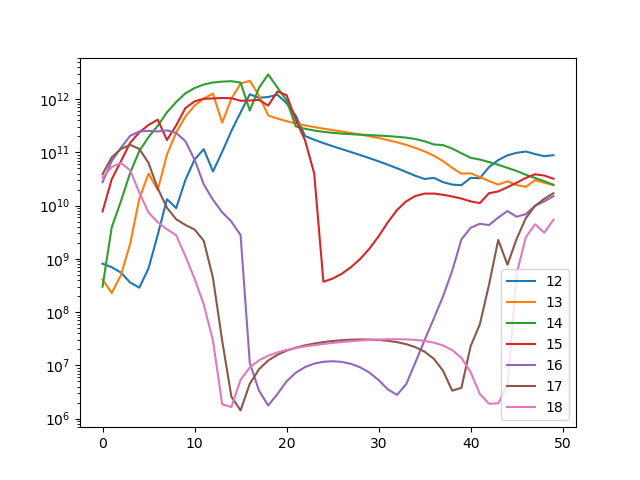

In [30]:
plt.figure()
for fcv_val in fcv_vals:
    plt.plot(list(map(compare, fcv_val)))
plt.yscale('log')
plt.legend(js)

<IPython.core.display.Javascript object>


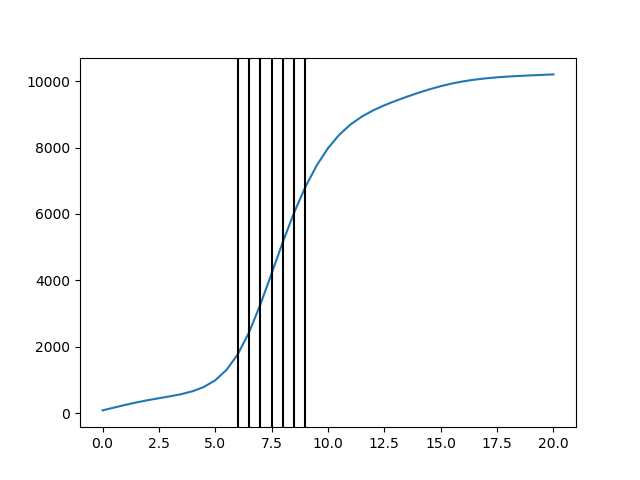

In [31]:
plt.figure()
plt.plot(tofsol, data_pd.flatten())
for j in js:
    plt.axvline(tofsol[j], color='k')
    

In [40]:
def x1(sol):
    return np.abs(float(getx(sol['x'])[-1][-1]) - raw_data.flatten()[-1])

<IPython.core.display.Javascript object>


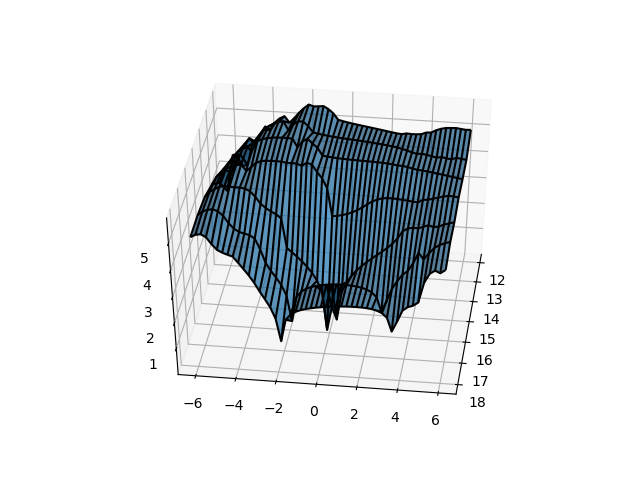

In [42]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = plt.axes(projection='3d')

x, y = np.meshgrid(js, np.log10(prange))

ax.plot_surface(x.T, y.T, np.log10(np.array([list(map(x1, s)) for s in fcv_vals])), alpha=0.7)
ax.plot_wireframe(x.T, y.T, np.log10(np.array([list(map(x1, s)) for s in fcv_vals])), color='k')

In [34]:
js


[12, 13, 14, 15, 16, 17, 18]